In [172]:
import bayesnewton
import jax
import objax
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
from sklearn.preprocessing import StandardScaler
from convertbng.util import convert_bng, convert_lonlat
import time
from sklearn.model_selection import train_test_split
import datetime
import math   
from jax import vmap
from scipy.stats import beta

import cv2
import sys, os
sys.path.append('../Utils')
import model_utils as mutils
import kernels_definitions as kerns
%load_ext autoreload
%autoreload 2
import copy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [173]:
#DATA VARIABLES
SYSTEMS_NUM = 120
TIMESTEPS_NUM = 9600
TRAIN_FRAC = 200  #IF TRAIN_FRAC > 1 THEN IT BECOMES THE LENGTH OF THE TEST SET
GRID_PIXELS = 30

#OPTIMISATION VARIABLES
LR_ADAM = 0.1
LR_NEWTON = 0.5
ITERS = 5

#GP Variables
VAR_Y = 0.1
LEN_SPACE = 0.5
LEN_ALTITUDE = 0.3

#PERIODIC KERNEL
VAR_PERIOD = 1.5
VAR_MATERN = 1
LEN_MATERN = 24 /  (TIMESTEPS_NUM / 100) #48
LEN_PERIOD = 400 /  (TIMESTEPS_NUM / 100)#24


#Want to use a sparse approximation
SPARSE = True
#Should we optimise the inducing points
OPT_Z = False  # will be set to False if SPARSE=SPARSE

#use a mean field approximation?
MEAN_FIELD = False
MINI_BATCH_SIZE = None #none if you don't want them
TEST_STATIONS = 271-120

In [174]:
uk_pv = pd.read_csv('../../Data/system_metadata_location_rounded.csv')
uk_pv['ss_id_string'] = uk_pv['ss_id'].astype('str')
#data_multiple.plot(legend=False)
lats = dict(uk_pv.set_index('ss_id')['latitude_noisy'])
longs = dict(uk_pv.set_index('ss_id')['longitude_noisy'])

data =  pd.read_csv('../../Data/pv_power_df_5day_capacity_scaled.csv', index_col='datetime')
#I AM SHUFFLING HERE
data_multiple = data.iloc[:,:SYSTEMS_NUM][:TIMESTEPS_NUM].reset_index()
stacked = mutils.stack_dataframe(data_multiple, lats, longs)
stacked = stacked[(stacked.latitude < 52.5) & (stacked.latitude > 50.5) & (stacked.longitude > -1) & (stacked.longitude < 1)]
capacities = uk_pv[uk_pv.ss_id_string.isin(data_multiple.columns)].set_index('ss_id_string')['kwp'].values * 1000


In [175]:
X = np.array(stacked[['epoch', 'longitude', 'latitude']])
Y = np.array(stacked[['PV']])

from suncalc import get_position, get_times
date_solar = stacked.datetime.values
lon_solar = stacked.longitude.values
lat_solar = stacked.latitude.values

solar_positions = get_position(date_solar, lon_solar, lat_solar)
solar_altitude = solar_positions['altitude']

# convert to easting and northings
british_national_grid_coords = convert_bng(X[:, 1], X[:, 2])
X = np.vstack([X[:, 0],
              np.array(british_national_grid_coords[0]),
              np.array(british_national_grid_coords[1])]).T

#Create a space-time grid from X and Y
t, R, Y = bayesnewton.utils.create_spatiotemporal_grid(X, Y)
t = t / (TIMESTEPS_NUM / 100)

# solar_altitudes = solar_altitude.reshape(R.shape[1], R.shape[0], 1).swapaxes(0,1)

# R = np.append(R, solar_altitudes, axis=2)

/Users/SeanNassimiha/miniforge3/envs/mscjax_dev/lib/python3.8/site-packages/geopandas/array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)


Text(0.5, 1.0, 'Grid of initial inducing points')

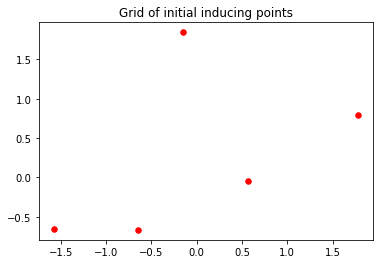

In [176]:
#train test split for 3 dimensional data
t_train, t_test, R_train, R_test, Y_train, Y_test = mutils.train_split_3d(t, R, Y, train_frac = TRAIN_FRAC, split_type = 'Cutoff')
Y = Y[:,:,0]

#get the mask of the test points
test_mask = np.in1d(t.squeeze(), t_test.squeeze())

#Scale the data
scaled_values = mutils.scale_2d_train_test_data(R, Y, R_train, R_test, Y_train, Y_test )
R_scaler, R_scaled, R_train_scaled, R_test_scaled, _, _, _, _ = scaled_values

#here get a list of scaled coordinates (frozen because at some point in time)
R_scaled_frozen = R_scaled[0]

# #Create a grid to perform prediction/interpolation on
r1, r2, Rplot = mutils.create_grid_from_coords(R = R_scaled_frozen, t = t, R_scaler = R_scaler, N_pixels = GRID_PIXELS, date_solar = date_solar)

z = R_scaled[2, ::5]

# #CHANGE THE INDUCING POINTS FOR THE SOLAR ALTITUDE TO BE EQUALLY SPACED ALONG THE TOTAL INTERVAL
# z[:,2] = np.linspace(solar_altitude.min(),solar_altitude.max(),  len(z))
    
plt.scatter(*zip(*z[:, :2]), marker='o', s=30, color='red')
plt.title('Grid of initial inducing points')


# CREATE A TEMPORAL ONLY MODEL

In [178]:
kern_time_period = bayesnewton.kernels.QuasiPeriodicMatern32(variance= VAR_PERIOD,
                                                                  lengthscale_periodic= LEN_PERIOD,
                                                                  period=96/ (TIMESTEPS_NUM / 100),
                                                                  lengthscale_matern= LEN_MATERN,
                                                                  order=2)

kern_time_matern = bayesnewton.kernels.Matern32(variance= VAR_MATERN, lengthscale=LEN_MATERN)


kern_time_day = bayesnewton.kernels.Sum([kern_time_period, kern_time_matern])

### FOR ALL SYSTEMS AND STORING EVERY ITERATION

In [ ]:
model_vars = dict.fromkeys(range(R.shape[1]))

for system_idx in range(R.shape[1]):
    model_vars_iter = dict.fromkeys(range(2000))

    lik = bayesnewton.likelihoods.Beta(scale = 30, fix_scale=False, link='probit')
    model = bayesnewton.models.MarkovVariationalGP(kernel = kern_time_day, likelihood = lik, X=t_train, Y=Y_train[:, system_idx,: ])

    opt_hypers = objax.optimizer.Adam(model.vars())
    energy = objax.GradValues(model.energy, model.vars())

    @objax.Function.with_vars(model.vars() + opt_hypers.vars())
    def train_op(batch_ind = None):
        model.inference(lr=LR_NEWTON, batch_ind = batch_ind)  #perform inference and update variational params
        dE, E = energy()  # compute energy and its gradients w.r.t. hypers
        opt_hypers(LR_ADAM, dE)
        return E
    train_op = objax.Jit(train_op)

    t0 = time.time()
    for i in range(1, 600 + 1):
        loss = train_op()

        data_var = [model.vars()['(MarkovVariationalGP).kernel(Sum).kernel0(QuasiPeriodicMatern32).transformed_lengthscale_periodic'].item(),
        model.vars()['(MarkovVariationalGP).kernel(Sum).kernel0(QuasiPeriodicMatern32).transformed_variance'].item(),
        model.vars()['(MarkovVariationalGP).kernel(Sum).kernel0(QuasiPeriodicMatern32).transformed_period'].item(),
        model.vars()['(MarkovVariationalGP).kernel(Sum).kernel0(QuasiPeriodicMatern32).transformed_lengthscale_matern'].item(),
        model.vars()['(MarkovVariationalGP).kernel(Sum).kernel1(Matern32).transformed_lengthscale'].item(),
        model.vars()['(MarkovVariationalGP).kernel(Sum).kernel1(Matern32).transformed_variance'].item(),
        model.vars()['(MarkovVariationalGP).likelihood(Beta).transformed_scale'].item()]
        data_model_vars = copy.copy(data_var)
        model_vars_iter[i] = data_model_vars

        print('iter %2d, energy: %1.4f' % (i, loss[0]))

    t1 = time.time()
    print('optimisation time: %2.2f secs' % (t1-t0))
    avg_time_taken = (t1-t0)/ITERS
    
    data_model = copy.copy(model_vars_iter)
    model_vars[system_idx] = data_model
    

iter  1, energy: 6111.6375
iter  2, energy: -6922.4981
iter  3, energy: -12584.5252
iter  4, energy: -15467.2760
iter  5, energy: -17337.5774
iter  6, energy: -18574.3864
iter  7, energy: -19394.2086
iter  8, energy: -19912.6100
iter  9, energy: -20154.2590
iter 10, energy: -20227.1164
iter 11, energy: -20466.1998
iter 12, energy: -20330.1650
iter 13, energy: -20506.4678
iter 14, energy: -20501.2911
iter 15, energy: -20491.5274
iter 16, energy: -20517.0383
iter 17, energy: -20510.5926
iter 18, energy: -20534.3760
iter 19, energy: -20570.2127
iter 20, energy: -20592.6136
iter 21, energy: -20627.2874
iter 22, energy: -20664.5150
iter 23, energy: -20709.8085
iter 24, energy: -20752.0943
iter 25, energy: -20794.5462
iter 26, energy: -20837.5142
iter 27, energy: -20878.8939
iter 28, energy: -20916.2965
iter 29, energy: -20950.5639
iter 30, energy: -20981.6570
iter 31, energy: -21009.5415
iter 32, energy: -21034.1968
iter 33, energy: -21055.6678
iter 34, energy: -21074.0676
iter 35, energy: 

iter 278, energy: -21691.6418
iter 279, energy: -21693.3477
iter 280, energy: -21695.0498
iter 281, energy: -21696.7481
iter 282, energy: -21698.4428
iter 283, energy: -21700.1337
iter 284, energy: -21701.8209
iter 285, energy: -21703.5045
iter 286, energy: -21705.1844
iter 287, energy: -21706.8607
iter 288, energy: -21708.5334
iter 289, energy: -21710.2025
iter 290, energy: -21711.8679
iter 291, energy: -21713.5298
iter 292, energy: -21715.1882
iter 293, energy: -21716.8430
iter 294, energy: -21718.4942
iter 295, energy: -21720.1420
iter 296, energy: -21721.7863
iter 297, energy: -21723.4270
iter 298, energy: -21725.0644
iter 299, energy: -21726.6982
iter 300, energy: -21728.3287
iter 301, energy: -21729.9557
iter 302, energy: -21731.5793
iter 303, energy: -21733.1995
iter 304, energy: -21734.8163
iter 305, energy: -21736.4298
iter 306, energy: -21738.0400
iter 307, energy: -21739.6467
iter 308, energy: -21741.2502
iter 309, energy: -21742.8504
iter 310, energy: -21744.4473
iter 311, 

iter 552, energy: -22059.0510
iter 553, energy: -22060.1279
iter 554, energy: -22061.2033
iter 555, energy: -22062.2772
iter 556, energy: -22063.3497
iter 557, energy: -22064.4208
iter 558, energy: -22065.4905
iter 559, energy: -22066.5588
iter 560, energy: -22067.6256
iter 561, energy: -22068.6910
iter 562, energy: -22069.7550
iter 563, energy: -22070.8176
iter 564, energy: -22071.8788
iter 565, energy: -22072.9386
iter 566, energy: -22073.9970
iter 567, energy: -22075.0540
iter 568, energy: -22076.1096
iter 569, energy: -22077.1637
iter 570, energy: -22078.2165
iter 571, energy: -22079.2679
iter 572, energy: -22080.3180
iter 573, energy: -22081.3666
iter 574, energy: -22082.4138
iter 575, energy: -22083.4597
iter 576, energy: -22084.5042
iter 577, energy: -22085.5473
iter 578, energy: -22086.5890
iter 579, energy: -22087.6294
iter 580, energy: -22088.6684
iter 581, energy: -22089.7060
iter 582, energy: -22090.7423
iter 583, energy: -22091.7771
iter 584, energy: -22092.8107
iter 585, 

iter 228, energy: -15486.2371
iter 229, energy: -15487.7195
iter 230, energy: -15489.1979
iter 231, energy: -15490.6721
iter 232, energy: -15492.1421
iter 233, energy: -15493.6081
iter 234, energy: -15495.0700
iter 235, energy: -15496.5278
iter 236, energy: -15497.9816
iter 237, energy: -15499.4314
iter 238, energy: -15500.8771
iter 239, energy: -15502.3189
iter 240, energy: -15503.7567
iter 241, energy: -15505.1906
iter 242, energy: -15506.6205
iter 243, energy: -15508.0466
iter 244, energy: -15509.4687
iter 245, energy: -15510.8870
iter 246, energy: -15512.3015
iter 247, energy: -15513.7121
iter 248, energy: -15515.1189
iter 249, energy: -15516.5219
iter 250, energy: -15517.9211
iter 251, energy: -15519.3165
iter 252, energy: -15520.7083
iter 253, energy: -15522.0963
iter 254, energy: -15523.4806
iter 255, energy: -15524.8612
iter 256, energy: -15526.2382
iter 257, energy: -15527.6115
iter 258, energy: -15528.9811
iter 259, energy: -15530.3472
iter 260, energy: -15531.7097
iter 261, 

iter 502, energy: -15785.4842
iter 503, energy: -15786.3016
iter 504, energy: -15787.1175
iter 505, energy: -15787.9320
iter 506, energy: -15788.7449
iter 507, energy: -15789.5563
iter 508, energy: -15790.3662
iter 509, energy: -15791.1746
iter 510, energy: -15791.9816
iter 511, energy: -15792.7870
iter 512, energy: -15793.5910
iter 513, energy: -15794.3935
iter 514, energy: -15795.1944
iter 515, energy: -15795.9939
iter 516, energy: -15796.7920
iter 517, energy: -15797.5885
iter 518, energy: -15798.3835
iter 519, energy: -15799.1771
iter 520, energy: -15799.9692
iter 521, energy: -15800.7599
iter 522, energy: -15801.5490
iter 523, energy: -15802.3367
iter 524, energy: -15803.1229
iter 525, energy: -15803.9077
iter 526, energy: -15804.6910
iter 527, energy: -15805.4728
iter 528, energy: -15806.2532
iter 529, energy: -15807.0321
iter 530, energy: -15807.8095
iter 531, energy: -15808.5855
iter 532, energy: -15809.3600
iter 533, energy: -15810.1331
iter 534, energy: -15810.9047
iter 535, 

iter 178, energy: -19664.2425
iter 179, energy: -19667.3831
iter 180, energy: -19670.5120
iter 181, energy: -19673.6293
iter 182, energy: -19676.7352
iter 183, energy: -19679.8296
iter 184, energy: -19682.9126
iter 185, energy: -19685.9844
iter 186, energy: -19689.0449
iter 187, energy: -19692.0943
iter 188, energy: -19695.1327
iter 189, energy: -19698.1600
iter 190, energy: -19701.1763
iter 191, energy: -19704.1818
iter 192, energy: -19707.1765
iter 193, energy: -19710.1605
iter 194, energy: -19713.1338
iter 195, energy: -19716.0965
iter 196, energy: -19719.0486
iter 197, energy: -19721.9903
iter 198, energy: -19724.9216
iter 199, energy: -19727.8425
iter 200, energy: -19730.7532
iter 201, energy: -19733.6537
iter 202, energy: -19736.5440
iter 203, energy: -19739.4242
iter 204, energy: -19742.2944
iter 205, energy: -19745.1547
iter 206, energy: -19748.0050
iter 207, energy: -19750.8455
iter 208, energy: -19753.6763
iter 209, energy: -19756.4973
iter 210, energy: -19759.3087
iter 211, 

iter 452, energy: -20247.9686
iter 453, energy: -20249.4431
iter 454, energy: -20250.9144
iter 455, energy: -20252.3825
iter 456, energy: -20253.8475
iter 457, energy: -20255.3093
iter 458, energy: -20256.7680
iter 459, energy: -20258.2237
iter 460, energy: -20259.6762
iter 461, energy: -20261.1256
iter 462, energy: -20262.5719
iter 463, energy: -20264.0152
iter 464, energy: -20265.4553
iter 465, energy: -20266.8925
iter 466, energy: -20268.3266
iter 467, energy: -20269.7576
iter 468, energy: -20271.1857
iter 469, energy: -20272.6107
iter 470, energy: -20274.0327
iter 471, energy: -20275.4517
iter 472, energy: -20276.8678
iter 473, energy: -20278.2808
iter 474, energy: -20279.6909
iter 475, energy: -20281.0981
iter 476, energy: -20282.5023
iter 477, energy: -20283.9035
iter 478, energy: -20285.3019
iter 479, energy: -20286.6973
iter 480, energy: -20288.0898
iter 481, energy: -20289.4794
iter 482, energy: -20290.8661
iter 483, energy: -20292.2499
iter 484, energy: -20293.6309
iter 485, 

iter 128, energy: -17735.8401
iter 129, energy: -17738.2034
iter 130, energy: -17740.5567
iter 131, energy: -17742.9001
iter 132, energy: -17745.2339
iter 133, energy: -17747.5583
iter 134, energy: -17749.8732
iter 135, energy: -17752.1787
iter 136, energy: -17754.4750
iter 137, energy: -17756.7618
iter 138, energy: -17759.0393
iter 139, energy: -17761.3074
iter 140, energy: -17763.5662
iter 141, energy: -17765.8157
iter 142, energy: -17768.0560
iter 143, energy: -17770.2873
iter 144, energy: -17772.5095
iter 145, energy: -17774.7230
iter 146, energy: -17776.9277
iter 147, energy: -17779.1237
iter 148, energy: -17781.3112
iter 149, energy: -17783.4903
iter 150, energy: -17785.6608
iter 151, energy: -17787.8230
iter 152, energy: -17789.9767
iter 153, energy: -17792.1221
iter 154, energy: -17794.2591
iter 155, energy: -17796.3878
iter 156, energy: -17798.5081
iter 157, energy: -17800.6202
iter 158, energy: -17802.7240
iter 159, energy: -17804.8196
iter 160, energy: -17806.9071
iter 161, 

iter 402, energy: -18156.4661
iter 403, energy: -18157.4895
iter 404, energy: -18158.5106
iter 405, energy: -18159.5294
iter 406, energy: -18160.5459
iter 407, energy: -18161.5602
iter 408, energy: -18162.5723
iter 409, energy: -18163.5820
iter 410, energy: -18164.5896
iter 411, energy: -18165.5949
iter 412, energy: -18166.5980
iter 413, energy: -18167.5989
iter 414, energy: -18168.5976
iter 415, energy: -18169.5941
iter 416, energy: -18170.5885
iter 417, energy: -18171.5806
iter 418, energy: -18172.5706
iter 419, energy: -18173.5584
iter 420, energy: -18174.5441
iter 421, energy: -18175.5276
iter 422, energy: -18176.5091
iter 423, energy: -18177.4883
iter 424, energy: -18178.4655
iter 425, energy: -18179.4406
iter 426, energy: -18180.4135
iter 427, energy: -18181.3844
iter 428, energy: -18182.3532
iter 429, energy: -18183.3199
iter 430, energy: -18184.2846
iter 431, energy: -18185.2472
iter 432, energy: -18186.2077
iter 433, energy: -18187.1662
iter 434, energy: -18188.1227
iter 435, 

iter 77, energy: -15644.2574
iter 78, energy: -15646.6350
iter 79, energy: -15649.0831
iter 80, energy: -15651.6054
iter 81, energy: -15654.1965
iter 82, energy: -15656.8433
iter 83, energy: -15659.5280
iter 84, energy: -15662.2306
iter 85, energy: -15664.9310
iter 86, energy: -15667.6115
iter 87, energy: -15670.2577
iter 88, energy: -15672.8599
iter 89, energy: -15675.4132
iter 90, energy: -15677.9171
iter 91, energy: -15680.3752
iter 92, energy: -15682.7939
iter 93, energy: -15685.1813
iter 94, energy: -15687.5460
iter 95, energy: -15689.8964
iter 96, energy: -15692.2394
iter 97, energy: -15694.5803
iter 98, energy: -15696.9219
iter 99, energy: -15699.2655
iter 100, energy: -15701.6102
iter 101, energy: -15703.9538
iter 102, energy: -15706.2934
iter 103, energy: -15708.6255
iter 104, energy: -15710.9471
iter 105, energy: -15713.2555
iter 106, energy: -15715.5488
iter 107, energy: -15717.8262
iter 108, energy: -15720.0875
iter 109, energy: -15722.3335
iter 110, energy: -15724.5656
ite

iter 351, energy: -16080.9405
iter 352, energy: -16081.9370
iter 353, energy: -16082.9310
iter 354, energy: -16083.9225
iter 355, energy: -16084.9115
iter 356, energy: -16085.8979
iter 357, energy: -16086.8819
iter 358, energy: -16087.8634
iter 359, energy: -16088.8425
iter 360, energy: -16089.8191
iter 361, energy: -16090.7932
iter 362, energy: -16091.7650
iter 363, energy: -16092.7343
iter 364, energy: -16093.7012
iter 365, energy: -16094.6657
iter 366, energy: -16095.6278
iter 367, energy: -16096.5875
iter 368, energy: -16097.5448
iter 369, energy: -16098.4998
iter 370, energy: -16099.4525
iter 371, energy: -16100.4028
iter 372, energy: -16101.3508
iter 373, energy: -16102.2964
iter 374, energy: -16103.2398
iter 375, energy: -16104.1808
iter 376, energy: -16105.1196
iter 377, energy: -16106.0561
iter 378, energy: -16106.9903
iter 379, energy: -16107.9222
iter 380, energy: -16108.8519
iter 381, energy: -16109.7794
iter 382, energy: -16110.7046
iter 383, energy: -16111.6276
iter 384, 

iter 24, energy: -19753.6400
iter 25, energy: -19804.7413
iter 26, energy: -19839.5557
iter 27, energy: -19861.0655
iter 28, energy: -19872.0415
iter 29, energy: -19874.9986
iter 30, energy: -19872.1718
iter 31, energy: -19865.5072
iter 32, energy: -19856.6628
iter 33, energy: -19847.0172
iter 34, energy: -19837.6828
iter 35, energy: -19829.5238
iter 36, energy: -19823.1763
iter 37, energy: -19819.0709
iter 38, energy: -19817.4563
iter 39, energy: -19818.4241
iter 40, energy: -19821.9333
iter 41, energy: -19827.8347
iter 42, energy: -19835.8944
iter 43, energy: -19845.8164
iter 44, energy: -19857.2634
iter 45, energy: -19869.8758
iter 46, energy: -19883.2888
iter 47, energy: -19897.1474
iter 48, energy: -19911.1190
iter 49, energy: -19924.9034
iter 50, energy: -19938.2414
iter 51, energy: -19950.9197
iter 52, energy: -19962.7746
iter 53, energy: -19973.6930
iter 54, energy: -19983.6116
iter 55, energy: -19992.5136
iter 56, energy: -20000.4249
iter 57, energy: -20007.4077
iter 58, energ

In [127]:
init_params = [model_vars[i][1] for i in range(R.shape[1])]
init_params_df = pd.DataFrame(init_params)
init_params_df.columns =  ['(QuasiPeriodicMatern32).transformed_lengthscale_periodic',
                        '(QuasiPeriodicMatern32).transformed_variance',
                        '(QuasiPeriodicMatern32).transformed_period',
                        '(QuasiPeriodicMatern32).transformed_lengthscale_matern',
                        '(Matern32).transformed_lengthscale',
                        '(Matern32).transformed_variance',
                        '(Beta).transformed_scale']
in_mean_df = init_params_df.T.mean(axis=1).to_frame()

final_params = [model_vars[i][200] for i in range(R.shape[1])]The
final_params_df = pd.DataFrame(final_params)
final_params_df.columns =  ['(QuasiPeriodicMatern32).transformed_lengthscale_periodic',
                        '(QuasiPeriodicMatern32).transformed_variance',
                        '(QuasiPeriodicMatern32).transformed_period',
                        '(QuasiPeriodicMatern32).transformed_lengthscale_matern',
                        '(Matern32).transformed_lengthscale',
                        '(Matern32).transformed_variance',
                        '(Beta).transformed_scale']

mean_df = final_params_df.T.mean(axis=1).to_frame()
std_df = final_params_df.T.std(axis=1).to_frame()

params_df_dist = pd.concat([in_mean_df, mean_df, std_df], axis=1)
params_df_dist.columns = ['init_param', 'final_mean_param', 'final_std_param']
params_df_dist

init_param  \
(QuasiPeriodicMatern32).transformed_lengthscale...    2.111198   
(QuasiPeriodicMatern32).transformed_variance         -0.167129   
(QuasiPeriodicMatern32).transformed_period            0.577543   
(QuasiPeriodicMatern32).transformed_lengthscale...    1.517439   
(Matern32).transformed_lengthscale                   11.230660   
(Matern32).transformed_variance                      -0.030154   
(Beta).transformed_scale                             29.990000   

                                                    final_mean_param  \
(QuasiPeriodicMatern32).transformed_lengthscale...          2.058029   
(QuasiPeriodicMatern32).transformed_variance               -0.202137   
(QuasiPeriodicMatern32).transformed_period                  0.574296   
(QuasiPeriodicMatern32).transformed_lengthscale...          1.535082   
(Matern32).transformed_lengthscale                         12.398719   
(Matern32).transformed_variance                            -0.054353   
(Beta).transformed_scale                                   31.701498   

                                                    final_std_param  
(QuasiPeriodicMatern32).transformed_lengthscale...         0.489636  
(QuasiPeriodicMatern32).transformed_variance               0.278761  
(QuasiPeriodicMatern32).transformed_period                 0.011703  
(QuasiPeriodicMatern32).transformed_lengthscale...         0.214227  
(Matern32).transformed_lengthscale                        11.303143  
(Matern32).transformed_variance                            0.452665  
(Beta).transformed_scale                                   0.182568

ValueError: Length mismatch: Expected axis has 0 elements, new values have 7 elements

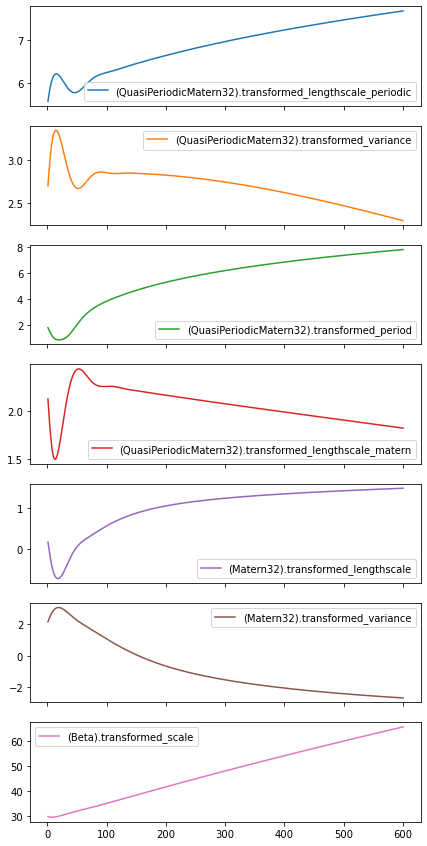

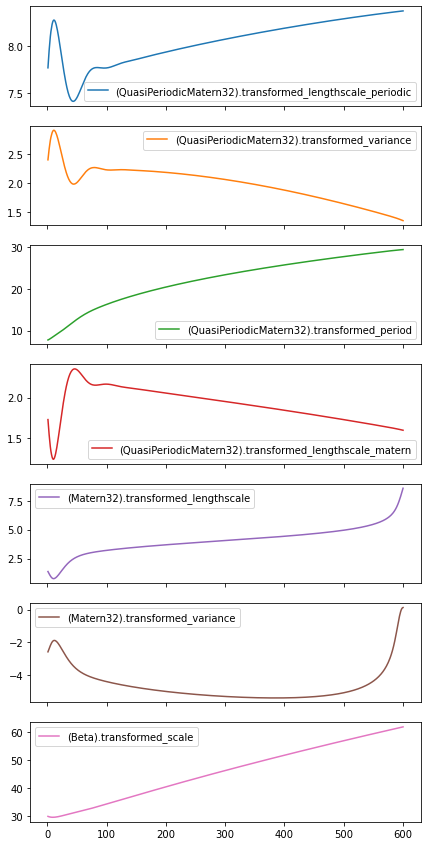

In [182]:
for system_idx in range(R.shape[1]):
    df_variables_iter = pd.DataFrame(model_vars[system_idx]).T
    df_variables_iter.columns = ['(QuasiPeriodicMatern32).transformed_lengthscale_periodic',
                            '(QuasiPeriodicMatern32).transformed_variance',
                            '(QuasiPeriodicMatern32).transformed_period',
                            '(QuasiPeriodicMatern32).transformed_lengthscale_matern',
                            '(Matern32).transformed_lengthscale',
                            '(Matern32).transformed_variance',
                            '(Beta).transformed_scale']

    df_variables_iter.plot(subplots=True, figsize=(7,15))


# WITHOUT PERIODICITY - CAN BE USED FOR THE INTERPOLATION STUDY

In [151]:
kern_time_matern = bayesnewton.kernels.Matern32(variance= VAR_MATERN, lengthscale=LEN_MATERN)

model_vars = dict.fromkeys(range(R.shape[1]))

for system_idx in range(R.shape[1]):
    model_vars_iter = dict.fromkeys(range(200))

    lik = bayesnewton.likelihoods.Beta(scale = 30, fix_scale=False, link='probit')
    model = bayesnewton.models.MarkovVariationalGP(kernel = kern_time_matern, likelihood = lik, X=t_train, Y=Y_train[:, system_idx,: ])

    opt_hypers = objax.optimizer.Adam(model.vars())
    energy = objax.GradValues(model.energy, model.vars())

    @objax.Function.with_vars(model.vars() + opt_hypers.vars())
    def train_op(batch_ind = None):
        model.inference(lr=LR_NEWTON, batch_ind = batch_ind)  #perform inference and update variational params
        dE, E = energy()  # compute energy and its gradients w.r.t. hypers
        opt_hypers(LR_ADAM, dE)
        return E
    train_op = objax.Jit(train_op)

    t0 = time.time()
    for i in range(1, 6000 + 1):
        loss = train_op()

        data_var = [model.vars()['(MarkovVariationalGP).kernel(Matern32).transformed_lengthscale'].item(),
                 model.vars()['(MarkovVariationalGP).kernel(Matern32).transformed_variance'].item(),
                 model.vars()['(MarkovVariationalGP).likelihood(Beta).transformed_scale'].item()]
        data_model_vars = copy.copy(data_var)
        model_vars_iter[i] = data_model_vars

        print('iter %2d, energy: %1.4f' % (i, loss[0]))

    t1 = time.time()
    print('optimisation time: %2.2f secs' % (t1-t0))
    avg_time_taken = (t1-t0)/ITERS
    
    data_model = copy.copy(model_vars_iter)
    model_vars[system_idx] = data_model

iter  1, energy: 5886.5089
iter  2, energy: -6630.7432
iter  3, energy: -11733.0880
iter  4, energy: -14445.1118
iter  5, energy: -15930.4873
iter  6, energy: -17381.9773
iter  7, energy: -15488.0147
iter  8, energy: -11097.8102
iter  9, energy: -16584.0463
iter 10, energy: -18910.6906
iter 11, energy: -19777.2696
iter 12, energy: -20146.9530
iter 13, energy: -20265.9535
iter 14, energy: -20288.5134
iter 15, energy: -20326.5952
iter 16, energy: -20342.0095
iter 17, energy: -20334.6220
iter 18, energy: -20337.2230
iter 19, energy: -20328.0955
iter 20, energy: -20316.5176
iter 21, energy: -20306.4536
iter 22, energy: -20301.2562
iter 23, energy: -20301.3125
iter 24, energy: -20306.5302
iter 25, energy: -20316.5563
iter 26, energy: -20330.8723
iter 27, energy: -20348.8579
iter 28, energy: -20369.8390
iter 29, energy: -20393.1254
iter 30, energy: -20418.0388
iter 31, energy: -20443.9351
iter 32, energy: -20470.2204
iter 33, energy: -20496.3623
iter 34, energy: -20521.8972
iter 35, energy: 

iter 279, energy: -20941.7731
iter 280, energy: -20942.3679
iter 281, energy: -20942.9604
iter 282, energy: -20943.5506
iter 283, energy: -20944.1386
iter 284, energy: -20944.7244
iter 285, energy: -20945.3079
iter 286, energy: -20945.8893
iter 287, energy: -20946.4684
iter 288, energy: -20947.0454
iter 289, energy: -20947.6202
iter 290, energy: -20948.1929
iter 291, energy: -20948.7634
iter 292, energy: -20949.3318
iter 293, energy: -20949.8981
iter 294, energy: -20950.4623
iter 295, energy: -20951.0243
iter 296, energy: -20951.5843
iter 297, energy: -20952.1422
iter 298, energy: -20952.6981
iter 299, energy: -20953.2518
iter 300, energy: -20953.8036
iter 301, energy: -20954.3533
iter 302, energy: -20954.9010
iter 303, energy: -20955.4467
iter 304, energy: -20955.9904
iter 305, energy: -20956.5321
iter 306, energy: -20957.0718
iter 307, energy: -20957.6096
iter 308, energy: -20958.1454
iter 309, energy: -20958.6792
iter 310, energy: -20959.2112
iter 311, energy: -20959.7411
iter 312, 

iter 554, energy: -21049.2088
iter 555, energy: -21049.4667
iter 556, energy: -21049.7239
iter 557, energy: -21049.9806
iter 558, energy: -21050.2366
iter 559, energy: -21050.4920
iter 560, energy: -21050.7469
iter 561, energy: -21051.0011
iter 562, energy: -21051.2547
iter 563, energy: -21051.5078
iter 564, energy: -21051.7602
iter 565, energy: -21052.0121
iter 566, energy: -21052.2633
iter 567, energy: -21052.5140
iter 568, energy: -21052.7641
iter 569, energy: -21053.0136
iter 570, energy: -21053.2626
iter 571, energy: -21053.5109
iter 572, energy: -21053.7587
iter 573, energy: -21054.0059
iter 574, energy: -21054.2526
iter 575, energy: -21054.4987
iter 576, energy: -21054.7442
iter 577, energy: -21054.9891
iter 578, energy: -21055.2335
iter 579, energy: -21055.4774
iter 580, energy: -21055.7206
iter 581, energy: -21055.9633
iter 582, energy: -21056.2055
iter 583, energy: -21056.4471
iter 584, energy: -21056.6882
iter 585, energy: -21056.9287
iter 586, energy: -21057.1687
iter 587, 

iter 830, energy: -21103.2361
iter 831, energy: -21103.3851
iter 832, energy: -21103.5338
iter 833, energy: -21103.6823
iter 834, energy: -21103.8305
iter 835, energy: -21103.9784
iter 836, energy: -21104.1261
iter 837, energy: -21104.2736
iter 838, energy: -21104.4208
iter 839, energy: -21104.5677
iter 840, energy: -21104.7144
iter 841, energy: -21104.8608
iter 842, energy: -21105.0070
iter 843, energy: -21105.1529
iter 844, energy: -21105.2986
iter 845, energy: -21105.4440
iter 846, energy: -21105.5892
iter 847, energy: -21105.7341
iter 848, energy: -21105.8788
iter 849, energy: -21106.0232
iter 850, energy: -21106.1674
iter 851, energy: -21106.3113
iter 852, energy: -21106.4550
iter 853, energy: -21106.5985
iter 854, energy: -21106.7417
iter 855, energy: -21106.8846
iter 856, energy: -21107.0273
iter 857, energy: -21107.1698
iter 858, energy: -21107.3120
iter 859, energy: -21107.4540
iter 860, energy: -21107.5957
iter 861, energy: -21107.7372
iter 862, energy: -21107.8785
iter 863, 

iter 1100, energy: -21135.6644
iter 1101, energy: -21135.7602
iter 1102, energy: -21135.8558
iter 1103, energy: -21135.9513
iter 1104, energy: -21136.0466
iter 1105, energy: -21136.1418
iter 1106, energy: -21136.2368
iter 1107, energy: -21136.3317
iter 1108, energy: -21136.4265
iter 1109, energy: -21136.5211
iter 1110, energy: -21136.6155
iter 1111, energy: -21136.7098
iter 1112, energy: -21136.8040
iter 1113, energy: -21136.8980
iter 1114, energy: -21136.9918
iter 1115, energy: -21137.0855
iter 1116, energy: -21137.1791
iter 1117, energy: -21137.2725
iter 1118, energy: -21137.3658
iter 1119, energy: -21137.4589
iter 1120, energy: -21137.5519
iter 1121, energy: -21137.6447
iter 1122, energy: -21137.7374
iter 1123, energy: -21137.8299
iter 1124, energy: -21137.9223
iter 1125, energy: -21138.0146
iter 1126, energy: -21138.1067
iter 1127, energy: -21138.1987
iter 1128, energy: -21138.2905
iter 1129, energy: -21138.3822
iter 1130, energy: -21138.4737
iter 1131, energy: -21138.5651
iter 113

iter 1368, energy: -21156.7306
iter 1369, energy: -21156.7945
iter 1370, energy: -21156.8582
iter 1371, energy: -21156.9219
iter 1372, energy: -21156.9854
iter 1373, energy: -21157.0489
iter 1374, energy: -21157.1122
iter 1375, energy: -21157.1755
iter 1376, energy: -21157.2387
iter 1377, energy: -21157.3018
iter 1378, energy: -21157.3648
iter 1379, energy: -21157.4277
iter 1380, energy: -21157.4905
iter 1381, energy: -21157.5532
iter 1382, energy: -21157.6159
iter 1383, energy: -21157.6784
iter 1384, energy: -21157.7409
iter 1385, energy: -21157.8032
iter 1386, energy: -21157.8655
iter 1387, energy: -21157.9277
iter 1388, energy: -21157.9898
iter 1389, energy: -21158.0518
iter 1390, energy: -21158.1137
iter 1391, energy: -21158.1755
iter 1392, energy: -21158.2372
iter 1393, energy: -21158.2989
iter 1394, energy: -21158.3604
iter 1395, energy: -21158.4219
iter 1396, energy: -21158.4832
iter 1397, energy: -21158.5445
iter 1398, energy: -21158.6057
iter 1399, energy: -21158.6668
iter 140

iter 1636, energy: -21170.9434
iter 1637, energy: -21170.9870
iter 1638, energy: -21171.0306
iter 1639, energy: -21171.0741
iter 1640, energy: -21171.1175
iter 1641, energy: -21171.1609
iter 1642, energy: -21171.2042
iter 1643, energy: -21171.2475
iter 1644, energy: -21171.2907
iter 1645, energy: -21171.3338
iter 1646, energy: -21171.3769
iter 1647, energy: -21171.4200
iter 1648, energy: -21171.4629
iter 1649, energy: -21171.5058
iter 1650, energy: -21171.5487
iter 1651, energy: -21171.5914
iter 1652, energy: -21171.6342
iter 1653, energy: -21171.6768
iter 1654, energy: -21171.7194
iter 1655, energy: -21171.7620
iter 1656, energy: -21171.8045
iter 1657, energy: -21171.8469
iter 1658, energy: -21171.8893
iter 1659, energy: -21171.9316
iter 1660, energy: -21171.9738
iter 1661, energy: -21172.0160
iter 1662, energy: -21172.0582
iter 1663, energy: -21172.1003
iter 1664, energy: -21172.1423
iter 1665, energy: -21172.1843
iter 1666, energy: -21172.2262
iter 1667, energy: -21172.2680
iter 166

iter 1903, energy: -21180.7054
iter 1904, energy: -21180.7357
iter 1905, energy: -21180.7660
iter 1906, energy: -21180.7963
iter 1907, energy: -21180.8265
iter 1908, energy: -21180.8566
iter 1909, energy: -21180.8867
iter 1910, energy: -21180.9168
iter 1911, energy: -21180.9468
iter 1912, energy: -21180.9768
iter 1913, energy: -21181.0068
iter 1914, energy: -21181.0367
iter 1915, energy: -21181.0666
iter 1916, energy: -21181.0964
iter 1917, energy: -21181.1262
iter 1918, energy: -21181.1560
iter 1919, energy: -21181.1857
iter 1920, energy: -21181.2154
iter 1921, energy: -21181.2450
iter 1922, energy: -21181.2746
iter 1923, energy: -21181.3042
iter 1924, energy: -21181.3337
iter 1925, energy: -21181.3631
iter 1926, energy: -21181.3926
iter 1927, energy: -21181.4220
iter 1928, energy: -21181.4513
iter 1929, energy: -21181.4807
iter 1930, energy: -21181.5099
iter 1931, energy: -21181.5392
iter 1932, energy: -21181.5684
iter 1933, energy: -21181.5975
iter 1934, energy: -21181.6267
iter 193

iter 2169, energy: -21187.4922
iter 2170, energy: -21187.5134
iter 2171, energy: -21187.5346
iter 2172, energy: -21187.5557
iter 2173, energy: -21187.5769
iter 2174, energy: -21187.5980
iter 2175, energy: -21187.6191
iter 2176, energy: -21187.6401
iter 2177, energy: -21187.6611
iter 2178, energy: -21187.6821
iter 2179, energy: -21187.7031
iter 2180, energy: -21187.7240
iter 2181, energy: -21187.7449
iter 2182, energy: -21187.7658
iter 2183, energy: -21187.7866
iter 2184, energy: -21187.8074
iter 2185, energy: -21187.8282
iter 2186, energy: -21187.8490
iter 2187, energy: -21187.8697
iter 2188, energy: -21187.8904
iter 2189, energy: -21187.9111
iter 2190, energy: -21187.9318
iter 2191, energy: -21187.9524
iter 2192, energy: -21187.9730
iter 2193, energy: -21187.9936
iter 2194, energy: -21188.0141
iter 2195, energy: -21188.0346
iter 2196, energy: -21188.0551
iter 2197, energy: -21188.0756
iter 2198, energy: -21188.0960
iter 2199, energy: -21188.1164
iter 2200, energy: -21188.1368
iter 220

iter 2437, energy: -21192.2642
iter 2438, energy: -21192.2790
iter 2439, energy: -21192.2937
iter 2440, energy: -21192.3084
iter 2441, energy: -21192.3231
iter 2442, energy: -21192.3377
iter 2443, energy: -21192.3524
iter 2444, energy: -21192.3670
iter 2445, energy: -21192.3816
iter 2446, energy: -21192.3962
iter 2447, energy: -21192.4107
iter 2448, energy: -21192.4252
iter 2449, energy: -21192.4398
iter 2450, energy: -21192.4543
iter 2451, energy: -21192.4687
iter 2452, energy: -21192.4832
iter 2453, energy: -21192.4976
iter 2454, energy: -21192.5120
iter 2455, energy: -21192.5264
iter 2456, energy: -21192.5408
iter 2457, energy: -21192.5552
iter 2458, energy: -21192.5695
iter 2459, energy: -21192.5838
iter 2460, energy: -21192.5981
iter 2461, energy: -21192.6124
iter 2462, energy: -21192.6267
iter 2463, energy: -21192.6409
iter 2464, energy: -21192.6551
iter 2465, energy: -21192.6693
iter 2466, energy: -21192.6835
iter 2467, energy: -21192.6977
iter 2468, energy: -21192.7118
iter 246

iter 2704, energy: -21195.5512
iter 2705, energy: -21195.5614
iter 2706, energy: -21195.5715
iter 2707, energy: -21195.5816
iter 2708, energy: -21195.5916
iter 2709, energy: -21195.6017
iter 2710, energy: -21195.6117
iter 2711, energy: -21195.6218
iter 2712, energy: -21195.6318
iter 2713, energy: -21195.6418
iter 2714, energy: -21195.6518
iter 2715, energy: -21195.6617
iter 2716, energy: -21195.6717
iter 2717, energy: -21195.6817
iter 2718, energy: -21195.6916
iter 2719, energy: -21195.7015
iter 2720, energy: -21195.7114
iter 2721, energy: -21195.7213
iter 2722, energy: -21195.7312
iter 2723, energy: -21195.7410
iter 2724, energy: -21195.7509
iter 2725, energy: -21195.7607
iter 2726, energy: -21195.7705
iter 2727, energy: -21195.7803
iter 2728, energy: -21195.7901
iter 2729, energy: -21195.7999
iter 2730, energy: -21195.8096
iter 2731, energy: -21195.8194
iter 2732, energy: -21195.8291
iter 2733, energy: -21195.8388
iter 2734, energy: -21195.8485
iter 2735, energy: -21195.8582
iter 273

iter 2973, energy: -21197.8004
iter 2974, energy: -21197.8072
iter 2975, energy: -21197.8140
iter 2976, energy: -21197.8207
iter 2977, energy: -21197.8275
iter 2978, energy: -21197.8342
iter 2979, energy: -21197.8409
iter 2980, energy: -21197.8476
iter 2981, energy: -21197.8543
iter 2982, energy: -21197.8610
iter 2983, energy: -21197.8677
iter 2984, energy: -21197.8744
iter 2985, energy: -21197.8811
iter 2986, energy: -21197.8877
iter 2987, energy: -21197.8944
iter 2988, energy: -21197.9010
iter 2989, energy: -21197.9076
iter 2990, energy: -21197.9142
iter 2991, energy: -21197.9208
iter 2992, energy: -21197.9274
iter 2993, energy: -21197.9340
iter 2994, energy: -21197.9406
iter 2995, energy: -21197.9471
iter 2996, energy: -21197.9537
iter 2997, energy: -21197.9602
iter 2998, energy: -21197.9668
iter 2999, energy: -21197.9733
iter 3000, energy: -21197.9798
iter 3001, energy: -21197.9863
iter 3002, energy: -21197.9928
iter 3003, energy: -21197.9993
iter 3004, energy: -21198.0057
iter 300

iter 3238, energy: -21199.2692
iter 3239, energy: -21199.2737
iter 3240, energy: -21199.2781
iter 3241, energy: -21199.2825
iter 3242, energy: -21199.2869
iter 3243, energy: -21199.2913
iter 3244, energy: -21199.2957
iter 3245, energy: -21199.3001
iter 3246, energy: -21199.3045
iter 3247, energy: -21199.3089
iter 3248, energy: -21199.3132
iter 3249, energy: -21199.3176
iter 3250, energy: -21199.3220
iter 3251, energy: -21199.3263
iter 3252, energy: -21199.3306
iter 3253, energy: -21199.3350
iter 3254, energy: -21199.3393
iter 3255, energy: -21199.3436
iter 3256, energy: -21199.3479
iter 3257, energy: -21199.3522
iter 3258, energy: -21199.3565
iter 3259, energy: -21199.3608
iter 3260, energy: -21199.3651
iter 3261, energy: -21199.3694
iter 3262, energy: -21199.3736
iter 3263, energy: -21199.3779
iter 3264, energy: -21199.3821
iter 3265, energy: -21199.3864
iter 3266, energy: -21199.3906
iter 3267, energy: -21199.3948
iter 3268, energy: -21199.3991
iter 3269, energy: -21199.4033
iter 327

iter 3505, energy: -21200.2195
iter 3506, energy: -21200.2223
iter 3507, energy: -21200.2251
iter 3508, energy: -21200.2279
iter 3509, energy: -21200.2306
iter 3510, energy: -21200.2334
iter 3511, energy: -21200.2362
iter 3512, energy: -21200.2389
iter 3513, energy: -21200.2417
iter 3514, energy: -21200.2444
iter 3515, energy: -21200.2471
iter 3516, energy: -21200.2499
iter 3517, energy: -21200.2526
iter 3518, energy: -21200.2553
iter 3519, energy: -21200.2580
iter 3520, energy: -21200.2607
iter 3521, energy: -21200.2634
iter 3522, energy: -21200.2661
iter 3523, energy: -21200.2688
iter 3524, energy: -21200.2715
iter 3525, energy: -21200.2742
iter 3526, energy: -21200.2769
iter 3527, energy: -21200.2796
iter 3528, energy: -21200.2822
iter 3529, energy: -21200.2849
iter 3530, energy: -21200.2876
iter 3531, energy: -21200.2902
iter 3532, energy: -21200.2929
iter 3533, energy: -21200.2955
iter 3534, energy: -21200.2982
iter 3535, energy: -21200.3008
iter 3536, energy: -21200.3034
iter 353

iter 3772, energy: -21200.8032
iter 3773, energy: -21200.8049
iter 3774, energy: -21200.8065
iter 3775, energy: -21200.8082
iter 3776, energy: -21200.8098
iter 3777, energy: -21200.8115
iter 3778, energy: -21200.8131
iter 3779, energy: -21200.8148
iter 3780, energy: -21200.8164
iter 3781, energy: -21200.8180
iter 3782, energy: -21200.8197
iter 3783, energy: -21200.8213
iter 3784, energy: -21200.8229
iter 3785, energy: -21200.8246
iter 3786, energy: -21200.8262
iter 3787, energy: -21200.8278
iter 3788, energy: -21200.8294
iter 3789, energy: -21200.8310
iter 3790, energy: -21200.8326
iter 3791, energy: -21200.8342
iter 3792, energy: -21200.8358
iter 3793, energy: -21200.8374
iter 3794, energy: -21200.8390
iter 3795, energy: -21200.8406
iter 3796, energy: -21200.8422
iter 3797, energy: -21200.8438
iter 3798, energy: -21200.8454
iter 3799, energy: -21200.8469
iter 3800, energy: -21200.8485
iter 3801, energy: -21200.8501
iter 3802, energy: -21200.8516
iter 3803, energy: -21200.8532
iter 380

iter 4037, energy: -21201.1414
iter 4038, energy: -21201.1423
iter 4039, energy: -21201.1433
iter 4040, energy: -21201.1442
iter 4041, energy: -21201.1452
iter 4042, energy: -21201.1461
iter 4043, energy: -21201.1470
iter 4044, energy: -21201.1480
iter 4045, energy: -21201.1489
iter 4046, energy: -21201.1498
iter 4047, energy: -21201.1507
iter 4048, energy: -21201.1516
iter 4049, energy: -21201.1526
iter 4050, energy: -21201.1535
iter 4051, energy: -21201.1544
iter 4052, energy: -21201.1553
iter 4053, energy: -21201.1562
iter 4054, energy: -21201.1571
iter 4055, energy: -21201.1580
iter 4056, energy: -21201.1589
iter 4057, energy: -21201.1598
iter 4058, energy: -21201.1607
iter 4059, energy: -21201.1616
iter 4060, energy: -21201.1625
iter 4061, energy: -21201.1634
iter 4062, energy: -21201.1643
iter 4063, energy: -21201.1652
iter 4064, energy: -21201.1661
iter 4065, energy: -21201.1670
iter 4066, energy: -21201.1679
iter 4067, energy: -21201.1687
iter 4068, energy: -21201.1696
iter 406

iter 4306, energy: -21201.3293
iter 4307, energy: -21201.3298
iter 4308, energy: -21201.3303
iter 4309, energy: -21201.3308
iter 4310, energy: -21201.3312
iter 4311, energy: -21201.3317
iter 4312, energy: -21201.3322
iter 4313, energy: -21201.3327
iter 4314, energy: -21201.3332
iter 4315, energy: -21201.3337
iter 4316, energy: -21201.3342
iter 4317, energy: -21201.3346
iter 4318, energy: -21201.3351
iter 4319, energy: -21201.3356
iter 4320, energy: -21201.3361
iter 4321, energy: -21201.3365
iter 4322, energy: -21201.3370
iter 4323, energy: -21201.3375
iter 4324, energy: -21201.3380
iter 4325, energy: -21201.3384
iter 4326, energy: -21201.3389
iter 4327, energy: -21201.3394
iter 4328, energy: -21201.3398
iter 4329, energy: -21201.3403
iter 4330, energy: -21201.3408
iter 4331, energy: -21201.3412
iter 4332, energy: -21201.3417
iter 4333, energy: -21201.3422
iter 4334, energy: -21201.3426
iter 4335, energy: -21201.3431
iter 4336, energy: -21201.3435
iter 4337, energy: -21201.3440
iter 433

iter 4574, energy: -21201.4239
iter 4575, energy: -21201.4242
iter 4576, energy: -21201.4244
iter 4577, energy: -21201.4246
iter 4578, energy: -21201.4249
iter 4579, energy: -21201.4251
iter 4580, energy: -21201.4254
iter 4581, energy: -21201.4256
iter 4582, energy: -21201.4258
iter 4583, energy: -21201.4261
iter 4584, energy: -21201.4263
iter 4585, energy: -21201.4265
iter 4586, energy: -21201.4268
iter 4587, energy: -21201.4270
iter 4588, energy: -21201.4272
iter 4589, energy: -21201.4274
iter 4590, energy: -21201.4277
iter 4591, energy: -21201.4279
iter 4592, energy: -21201.4281
iter 4593, energy: -21201.4283
iter 4594, energy: -21201.4286
iter 4595, energy: -21201.4288
iter 4596, energy: -21201.4290
iter 4597, energy: -21201.4292
iter 4598, energy: -21201.4295
iter 4599, energy: -21201.4297
iter 4600, energy: -21201.4299
iter 4601, energy: -21201.4301
iter 4602, energy: -21201.4304
iter 4603, energy: -21201.4306
iter 4604, energy: -21201.4308
iter 4605, energy: -21201.4310
iter 460

iter 4842, energy: -21201.4679
iter 4843, energy: -21201.4680
iter 4844, energy: -21201.4681
iter 4845, energy: -21201.4682
iter 4846, energy: -21201.4683
iter 4847, energy: -21201.4684
iter 4848, energy: -21201.4685
iter 4849, energy: -21201.4686
iter 4850, energy: -21201.4687
iter 4851, energy: -21201.4688
iter 4852, energy: -21201.4689
iter 4853, energy: -21201.4690
iter 4854, energy: -21201.4691
iter 4855, energy: -21201.4692
iter 4856, energy: -21201.4693
iter 4857, energy: -21201.4694
iter 4858, energy: -21201.4695
iter 4859, energy: -21201.4696
iter 4860, energy: -21201.4697
iter 4861, energy: -21201.4698
iter 4862, energy: -21201.4699
iter 4863, energy: -21201.4700
iter 4864, energy: -21201.4701
iter 4865, energy: -21201.4702
iter 4866, energy: -21201.4703
iter 4867, energy: -21201.4704
iter 4868, energy: -21201.4705
iter 4869, energy: -21201.4706
iter 4870, energy: -21201.4707
iter 4871, energy: -21201.4708
iter 4872, energy: -21201.4709
iter 4873, energy: -21201.4710
iter 487

iter 5109, energy: -21201.4864
iter 5110, energy: -21201.4865
iter 5111, energy: -21201.4865
iter 5112, energy: -21201.4865
iter 5113, energy: -21201.4866
iter 5114, energy: -21201.4866
iter 5115, energy: -21201.4867
iter 5116, energy: -21201.4867
iter 5117, energy: -21201.4867
iter 5118, energy: -21201.4868
iter 5119, energy: -21201.4868
iter 5120, energy: -21201.4869
iter 5121, energy: -21201.4869
iter 5122, energy: -21201.4869
iter 5123, energy: -21201.4870
iter 5124, energy: -21201.4870
iter 5125, energy: -21201.4871
iter 5126, energy: -21201.4871
iter 5127, energy: -21201.4871
iter 5128, energy: -21201.4872
iter 5129, energy: -21201.4872
iter 5130, energy: -21201.4873
iter 5131, energy: -21201.4873
iter 5132, energy: -21201.4873
iter 5133, energy: -21201.4874
iter 5134, energy: -21201.4874
iter 5135, energy: -21201.4875
iter 5136, energy: -21201.4875
iter 5137, energy: -21201.4875
iter 5138, energy: -21201.4876
iter 5139, energy: -21201.4876
iter 5140, energy: -21201.4876
iter 514

iter 5374, energy: -21201.4935
iter 5375, energy: -21201.4935
iter 5376, energy: -21201.4935
iter 5377, energy: -21201.4935
iter 5378, energy: -21201.4936
iter 5379, energy: -21201.4936
iter 5380, energy: -21201.4936
iter 5381, energy: -21201.4936
iter 5382, energy: -21201.4936
iter 5383, energy: -21201.4936
iter 5384, energy: -21201.4936
iter 5385, energy: -21201.4937
iter 5386, energy: -21201.4937
iter 5387, energy: -21201.4937
iter 5388, energy: -21201.4937
iter 5389, energy: -21201.4937
iter 5390, energy: -21201.4937
iter 5391, energy: -21201.4937
iter 5392, energy: -21201.4938
iter 5393, energy: -21201.4938
iter 5394, energy: -21201.4938
iter 5395, energy: -21201.4938
iter 5396, energy: -21201.4938
iter 5397, energy: -21201.4938
iter 5398, energy: -21201.4938
iter 5399, energy: -21201.4939
iter 5400, energy: -21201.4939
iter 5401, energy: -21201.4939
iter 5402, energy: -21201.4939
iter 5403, energy: -21201.4939
iter 5404, energy: -21201.4939
iter 5405, energy: -21201.4939
iter 540

iter 5642, energy: -21201.4960
iter 5643, energy: -21201.4960
iter 5644, energy: -21201.4960
iter 5645, energy: -21201.4960
iter 5646, energy: -21201.4960
iter 5647, energy: -21201.4960
iter 5648, energy: -21201.4961
iter 5649, energy: -21201.4961
iter 5650, energy: -21201.4961
iter 5651, energy: -21201.4961
iter 5652, energy: -21201.4961
iter 5653, energy: -21201.4961
iter 5654, energy: -21201.4961
iter 5655, energy: -21201.4961
iter 5656, energy: -21201.4961
iter 5657, energy: -21201.4961
iter 5658, energy: -21201.4961
iter 5659, energy: -21201.4961
iter 5660, energy: -21201.4961
iter 5661, energy: -21201.4961
iter 5662, energy: -21201.4961
iter 5663, energy: -21201.4961
iter 5664, energy: -21201.4961
iter 5665, energy: -21201.4961
iter 5666, energy: -21201.4961
iter 5667, energy: -21201.4961
iter 5668, energy: -21201.4962
iter 5669, energy: -21201.4962
iter 5670, energy: -21201.4962
iter 5671, energy: -21201.4962
iter 5672, energy: -21201.4962
iter 5673, energy: -21201.4962
iter 567

iter 5910, energy: -21201.4969
iter 5911, energy: -21201.4969
iter 5912, energy: -21201.4969
iter 5913, energy: -21201.4969
iter 5914, energy: -21201.4969
iter 5915, energy: -21201.4969
iter 5916, energy: -21201.4969
iter 5917, energy: -21201.4969
iter 5918, energy: -21201.4969
iter 5919, energy: -21201.4969
iter 5920, energy: -21201.4969
iter 5921, energy: -21201.4969
iter 5922, energy: -21201.4969
iter 5923, energy: -21201.4969
iter 5924, energy: -21201.4969
iter 5925, energy: -21201.4969
iter 5926, energy: -21201.4969
iter 5927, energy: -21201.4969
iter 5928, energy: -21201.4969
iter 5929, energy: -21201.4969
iter 5930, energy: -21201.4969
iter 5931, energy: -21201.4969
iter 5932, energy: -21201.4969
iter 5933, energy: -21201.4969
iter 5934, energy: -21201.4969
iter 5935, energy: -21201.4969
iter 5936, energy: -21201.4969
iter 5937, energy: -21201.4969
iter 5938, energy: -21201.4969
iter 5939, energy: -21201.4969
iter 5940, energy: -21201.4969
iter 5941, energy: -21201.4969
iter 594

iter 187, energy: -14803.6375
iter 188, energy: -14804.6783
iter 189, energy: -14805.6986
iter 190, energy: -14806.6990
iter 191, energy: -14807.6801
iter 192, energy: -14808.6425
iter 193, energy: -14809.5870
iter 194, energy: -14810.5143
iter 195, energy: -14811.4251
iter 196, energy: -14812.3201
iter 197, energy: -14813.2002
iter 198, energy: -14814.0660
iter 199, energy: -14814.9184
iter 200, energy: -14815.7581
iter 201, energy: -14816.5859
iter 202, energy: -14817.4025
iter 203, energy: -14818.2088
iter 204, energy: -14819.0053
iter 205, energy: -14819.7928
iter 206, energy: -14820.5720
iter 207, energy: -14821.3435
iter 208, energy: -14822.1079
iter 209, energy: -14822.8657
iter 210, energy: -14823.6175
iter 211, energy: -14824.3639
iter 212, energy: -14825.1052
iter 213, energy: -14825.8419
iter 214, energy: -14826.5744
iter 215, energy: -14827.3030
iter 216, energy: -14828.0281
iter 217, energy: -14828.7499
iter 218, energy: -14829.4688
iter 219, energy: -14830.1849
iter 220, 

iter 462, energy: -14954.9930
iter 463, energy: -14955.3405
iter 464, energy: -14955.6869
iter 465, energy: -14956.0323
iter 466, energy: -14956.3766
iter 467, energy: -14956.7199
iter 468, energy: -14957.0622
iter 469, energy: -14957.4034
iter 470, energy: -14957.7436
iter 471, energy: -14958.0827
iter 472, energy: -14958.4208
iter 473, energy: -14958.7579
iter 474, energy: -14959.0940
iter 475, energy: -14959.4291
iter 476, energy: -14959.7631
iter 477, energy: -14960.0961
iter 478, energy: -14960.4282
iter 479, energy: -14960.7592
iter 480, energy: -14961.0892
iter 481, energy: -14961.4182
iter 482, energy: -14961.7463
iter 483, energy: -14962.0733
iter 484, energy: -14962.3994
iter 485, energy: -14962.7244
iter 486, energy: -14963.0485
iter 487, energy: -14963.3716
iter 488, energy: -14963.6937
iter 489, energy: -14964.0149
iter 490, energy: -14964.3351
iter 491, energy: -14964.6543
iter 492, energy: -14964.9726
iter 493, energy: -14965.2899
iter 494, energy: -14965.6062
iter 495, 

iter 739, energy: -15020.6988
iter 740, energy: -15020.8534
iter 741, energy: -15021.0077
iter 742, energy: -15021.1614
iter 743, energy: -15021.3148
iter 744, energy: -15021.4677
iter 745, energy: -15021.6202
iter 746, energy: -15021.7722
iter 747, energy: -15021.9239
iter 748, energy: -15022.0751
iter 749, energy: -15022.2259
iter 750, energy: -15022.3763
iter 751, energy: -15022.5262
iter 752, energy: -15022.6757
iter 753, energy: -15022.8249
iter 754, energy: -15022.9736
iter 755, energy: -15023.1219
iter 756, energy: -15023.2697
iter 757, energy: -15023.4172
iter 758, energy: -15023.5643
iter 759, energy: -15023.7109
iter 760, energy: -15023.8571
iter 761, energy: -15024.0030
iter 762, energy: -15024.1484
iter 763, energy: -15024.2934
iter 764, energy: -15024.4380
iter 765, energy: -15024.5823
iter 766, energy: -15024.7261
iter 767, energy: -15024.8695
iter 768, energy: -15025.0125
iter 769, energy: -15025.1551
iter 770, energy: -15025.2974
iter 771, energy: -15025.4392
iter 772, 

iter 1012, energy: -15050.4701
iter 1013, energy: -15050.5439
iter 1014, energy: -15050.6176
iter 1015, energy: -15050.6911
iter 1016, energy: -15050.7644
iter 1017, energy: -15050.8375
iter 1018, energy: -15050.9104
iter 1019, energy: -15050.9831
iter 1020, energy: -15051.0556
iter 1021, energy: -15051.1279
iter 1022, energy: -15051.2001
iter 1023, energy: -15051.2720
iter 1024, energy: -15051.3438
iter 1025, energy: -15051.4154
iter 1026, energy: -15051.4868
iter 1027, energy: -15051.5580
iter 1028, energy: -15051.6290
iter 1029, energy: -15051.6998
iter 1030, energy: -15051.7705
iter 1031, energy: -15051.8409
iter 1032, energy: -15051.9112
iter 1033, energy: -15051.9813
iter 1034, energy: -15052.0512
iter 1035, energy: -15052.1209
iter 1036, energy: -15052.1904
iter 1037, energy: -15052.2598
iter 1038, energy: -15052.3290
iter 1039, energy: -15052.3980
iter 1040, energy: -15052.4668
iter 1041, energy: -15052.5354
iter 1042, energy: -15052.6039
iter 1043, energy: -15052.6721
iter 104

iter 1280, energy: -15064.7392
iter 1281, energy: -15064.7761
iter 1282, energy: -15064.8129
iter 1283, energy: -15064.8495
iter 1284, energy: -15064.8861
iter 1285, energy: -15064.9226
iter 1286, energy: -15064.9590
iter 1287, energy: -15064.9953
iter 1288, energy: -15065.0316
iter 1289, energy: -15065.0677
iter 1290, energy: -15065.1037
iter 1291, energy: -15065.1396
iter 1292, energy: -15065.1755
iter 1293, energy: -15065.2112
iter 1294, energy: -15065.2469
iter 1295, energy: -15065.2825
iter 1296, energy: -15065.3180
iter 1297, energy: -15065.3533
iter 1298, energy: -15065.3886
iter 1299, energy: -15065.4238
iter 1300, energy: -15065.4590
iter 1301, energy: -15065.4940
iter 1302, energy: -15065.5289
iter 1303, energy: -15065.5638
iter 1304, energy: -15065.5985
iter 1305, energy: -15065.6332
iter 1306, energy: -15065.6678
iter 1307, energy: -15065.7023
iter 1308, energy: -15065.7367
iter 1309, energy: -15065.7710
iter 1310, energy: -15065.8052
iter 1311, energy: -15065.8393
iter 131

iter 1549, energy: -15071.9059
iter 1550, energy: -15071.9243
iter 1551, energy: -15071.9427
iter 1552, energy: -15071.9610
iter 1553, energy: -15071.9793
iter 1554, energy: -15071.9975
iter 1555, energy: -15072.0157
iter 1556, energy: -15072.0338
iter 1557, energy: -15072.0519
iter 1558, energy: -15072.0700
iter 1559, energy: -15072.0880
iter 1560, energy: -15072.1059
iter 1561, energy: -15072.1238
iter 1562, energy: -15072.1417
iter 1563, energy: -15072.1595
iter 1564, energy: -15072.1772
iter 1565, energy: -15072.1949
iter 1566, energy: -15072.2126
iter 1567, energy: -15072.2302
iter 1568, energy: -15072.2478
iter 1569, energy: -15072.2653
iter 1570, energy: -15072.2828
iter 1571, energy: -15072.3003
iter 1572, energy: -15072.3177
iter 1573, energy: -15072.3350
iter 1574, energy: -15072.3523
iter 1575, energy: -15072.3696
iter 1576, energy: -15072.3868
iter 1577, energy: -15072.4040
iter 1578, energy: -15072.4211
iter 1579, energy: -15072.4382
iter 1580, energy: -15072.4552
iter 158

iter 1818, energy: -15075.4613
iter 1819, energy: -15075.4703
iter 1820, energy: -15075.4793
iter 1821, energy: -15075.4883
iter 1822, energy: -15075.4972
iter 1823, energy: -15075.5062
iter 1824, energy: -15075.5151
iter 1825, energy: -15075.5239
iter 1826, energy: -15075.5328
iter 1827, energy: -15075.5416
iter 1828, energy: -15075.5504
iter 1829, energy: -15075.5592
iter 1830, energy: -15075.5679
iter 1831, energy: -15075.5767
iter 1832, energy: -15075.5854
iter 1833, energy: -15075.5941
iter 1834, energy: -15075.6027
iter 1835, energy: -15075.6113
iter 1836, energy: -15075.6200
iter 1837, energy: -15075.6285
iter 1838, energy: -15075.6371
iter 1839, energy: -15075.6457
iter 1840, energy: -15075.6542
iter 1841, energy: -15075.6627
iter 1842, energy: -15075.6711
iter 1843, energy: -15075.6796
iter 1844, energy: -15075.6880
iter 1845, energy: -15075.6964
iter 1846, energy: -15075.7048
iter 1847, energy: -15075.7131
iter 1848, energy: -15075.7215
iter 1849, energy: -15075.7298
iter 185

iter 2084, energy: -15077.1605
iter 2085, energy: -15077.1647
iter 2086, energy: -15077.1690
iter 2087, energy: -15077.1732
iter 2088, energy: -15077.1775
iter 2089, energy: -15077.1817
iter 2090, energy: -15077.1859
iter 2091, energy: -15077.1901
iter 2092, energy: -15077.1943
iter 2093, energy: -15077.1984
iter 2094, energy: -15077.2026
iter 2095, energy: -15077.2068
iter 2096, energy: -15077.2109
iter 2097, energy: -15077.2150
iter 2098, energy: -15077.2191
iter 2099, energy: -15077.2232
iter 2100, energy: -15077.2273
iter 2101, energy: -15077.2314
iter 2102, energy: -15077.2354
iter 2103, energy: -15077.2395
iter 2104, energy: -15077.2435
iter 2105, energy: -15077.2476
iter 2106, energy: -15077.2516
iter 2107, energy: -15077.2556
iter 2108, energy: -15077.2596
iter 2109, energy: -15077.2636
iter 2110, energy: -15077.2675
iter 2111, energy: -15077.2715
iter 2112, energy: -15077.2754
iter 2113, energy: -15077.2794
iter 2114, energy: -15077.2833
iter 2115, energy: -15077.2872
iter 211

iter 2353, energy: -15077.9502
iter 2354, energy: -15077.9521
iter 2355, energy: -15077.9539
iter 2356, energy: -15077.9558
iter 2357, energy: -15077.9577
iter 2358, energy: -15077.9595
iter 2359, energy: -15077.9614
iter 2360, energy: -15077.9632
iter 2361, energy: -15077.9651
iter 2362, energy: -15077.9669
iter 2363, energy: -15077.9687
iter 2364, energy: -15077.9705
iter 2365, energy: -15077.9723
iter 2366, energy: -15077.9742
iter 2367, energy: -15077.9760
iter 2368, energy: -15077.9778
iter 2369, energy: -15077.9795
iter 2370, energy: -15077.9813
iter 2371, energy: -15077.9831
iter 2372, energy: -15077.9849
iter 2373, energy: -15077.9867
iter 2374, energy: -15077.9884
iter 2375, energy: -15077.9902
iter 2376, energy: -15077.9919
iter 2377, energy: -15077.9937
iter 2378, energy: -15077.9954
iter 2379, energy: -15077.9971
iter 2380, energy: -15077.9989
iter 2381, energy: -15078.0006
iter 2382, energy: -15078.0023
iter 2383, energy: -15078.0040
iter 2384, energy: -15078.0057
iter 238

iter 2619, energy: -15078.2833
iter 2620, energy: -15078.2840
iter 2621, energy: -15078.2848
iter 2622, energy: -15078.2856
iter 2623, energy: -15078.2863
iter 2624, energy: -15078.2871
iter 2625, energy: -15078.2878
iter 2626, energy: -15078.2886
iter 2627, energy: -15078.2893
iter 2628, energy: -15078.2901
iter 2629, energy: -15078.2908
iter 2630, energy: -15078.2915
iter 2631, energy: -15078.2923
iter 2632, energy: -15078.2930
iter 2633, energy: -15078.2937
iter 2634, energy: -15078.2945
iter 2635, energy: -15078.2952
iter 2636, energy: -15078.2959
iter 2637, energy: -15078.2966
iter 2638, energy: -15078.2973
iter 2639, energy: -15078.2981
iter 2640, energy: -15078.2988
iter 2641, energy: -15078.2995
iter 2642, energy: -15078.3002
iter 2643, energy: -15078.3009
iter 2644, energy: -15078.3016
iter 2645, energy: -15078.3023
iter 2646, energy: -15078.3030
iter 2647, energy: -15078.3037
iter 2648, energy: -15078.3044
iter 2649, energy: -15078.3051
iter 2650, energy: -15078.3058
iter 265

iter 2886, energy: -15078.4132
iter 2887, energy: -15078.4135
iter 2888, energy: -15078.4138
iter 2889, energy: -15078.4141
iter 2890, energy: -15078.4143
iter 2891, energy: -15078.4146
iter 2892, energy: -15078.4149
iter 2893, energy: -15078.4152
iter 2894, energy: -15078.4154
iter 2895, energy: -15078.4157
iter 2896, energy: -15078.4160
iter 2897, energy: -15078.4162
iter 2898, energy: -15078.4165
iter 2899, energy: -15078.4168
iter 2900, energy: -15078.4170
iter 2901, energy: -15078.4173
iter 2902, energy: -15078.4176
iter 2903, energy: -15078.4178
iter 2904, energy: -15078.4181
iter 2905, energy: -15078.4183
iter 2906, energy: -15078.4186
iter 2907, energy: -15078.4188
iter 2908, energy: -15078.4191
iter 2909, energy: -15078.4194
iter 2910, energy: -15078.4196
iter 2911, energy: -15078.4199
iter 2912, energy: -15078.4201
iter 2913, energy: -15078.4204
iter 2914, energy: -15078.4206
iter 2915, energy: -15078.4209
iter 2916, energy: -15078.4211
iter 2917, energy: -15078.4213
iter 291

iter 3152, energy: -15078.4578
iter 3153, energy: -15078.4579
iter 3154, energy: -15078.4580
iter 3155, energy: -15078.4581
iter 3156, energy: -15078.4582
iter 3157, energy: -15078.4582
iter 3158, energy: -15078.4583
iter 3159, energy: -15078.4584
iter 3160, energy: -15078.4585
iter 3161, energy: -15078.4586
iter 3162, energy: -15078.4587
iter 3163, energy: -15078.4588
iter 3164, energy: -15078.4588
iter 3165, energy: -15078.4589
iter 3166, energy: -15078.4590
iter 3167, energy: -15078.4591
iter 3168, energy: -15078.4592
iter 3169, energy: -15078.4593
iter 3170, energy: -15078.4593
iter 3171, energy: -15078.4594
iter 3172, energy: -15078.4595
iter 3173, energy: -15078.4596
iter 3174, energy: -15078.4597
iter 3175, energy: -15078.4597
iter 3176, energy: -15078.4598
iter 3177, energy: -15078.4599
iter 3178, energy: -15078.4600
iter 3179, energy: -15078.4601
iter 3180, energy: -15078.4601
iter 3181, energy: -15078.4602
iter 3182, energy: -15078.4603
iter 3183, energy: -15078.4604
iter 318

iter 3419, energy: -15078.4711
iter 3420, energy: -15078.4711
iter 3421, energy: -15078.4712
iter 3422, energy: -15078.4712
iter 3423, energy: -15078.4712
iter 3424, energy: -15078.4712
iter 3425, energy: -15078.4712
iter 3426, energy: -15078.4713
iter 3427, energy: -15078.4713
iter 3428, energy: -15078.4713
iter 3429, energy: -15078.4713
iter 3430, energy: -15078.4714
iter 3431, energy: -15078.4714
iter 3432, energy: -15078.4714
iter 3433, energy: -15078.4714
iter 3434, energy: -15078.4714
iter 3435, energy: -15078.4715
iter 3436, energy: -15078.4715
iter 3437, energy: -15078.4715
iter 3438, energy: -15078.4715
iter 3439, energy: -15078.4716
iter 3440, energy: -15078.4716
iter 3441, energy: -15078.4716
iter 3442, energy: -15078.4716
iter 3443, energy: -15078.4716
iter 3444, energy: -15078.4717
iter 3445, energy: -15078.4717
iter 3446, energy: -15078.4717
iter 3447, energy: -15078.4717
iter 3448, energy: -15078.4717
iter 3449, energy: -15078.4718
iter 3450, energy: -15078.4718
iter 345

iter 3684, energy: -15078.4744
iter 3685, energy: -15078.4744
iter 3686, energy: -15078.4744
iter 3687, energy: -15078.4744
iter 3688, energy: -15078.4744
iter 3689, energy: -15078.4744
iter 3690, energy: -15078.4745
iter 3691, energy: -15078.4745
iter 3692, energy: -15078.4745
iter 3693, energy: -15078.4745
iter 3694, energy: -15078.4745
iter 3695, energy: -15078.4745
iter 3696, energy: -15078.4745
iter 3697, energy: -15078.4745
iter 3698, energy: -15078.4745
iter 3699, energy: -15078.4745
iter 3700, energy: -15078.4745
iter 3701, energy: -15078.4745
iter 3702, energy: -15078.4745
iter 3703, energy: -15078.4745
iter 3704, energy: -15078.4745
iter 3705, energy: -15078.4745
iter 3706, energy: -15078.4745
iter 3707, energy: -15078.4745
iter 3708, energy: -15078.4745
iter 3709, energy: -15078.4745
iter 3710, energy: -15078.4745
iter 3711, energy: -15078.4746
iter 3712, energy: -15078.4746
iter 3713, energy: -15078.4746
iter 3714, energy: -15078.4746
iter 3715, energy: -15078.4746
iter 371

iter 3953, energy: -15078.4751
iter 3954, energy: -15078.4751
iter 3955, energy: -15078.4751
iter 3956, energy: -15078.4751
iter 3957, energy: -15078.4751
iter 3958, energy: -15078.4751
iter 3959, energy: -15078.4751
iter 3960, energy: -15078.4751
iter 3961, energy: -15078.4751
iter 3962, energy: -15078.4751
iter 3963, energy: -15078.4751
iter 3964, energy: -15078.4751
iter 3965, energy: -15078.4751
iter 3966, energy: -15078.4751
iter 3967, energy: -15078.4751
iter 3968, energy: -15078.4751
iter 3969, energy: -15078.4751
iter 3970, energy: -15078.4751
iter 3971, energy: -15078.4751
iter 3972, energy: -15078.4751
iter 3973, energy: -15078.4751
iter 3974, energy: -15078.4751
iter 3975, energy: -15078.4751
iter 3976, energy: -15078.4751
iter 3977, energy: -15078.4751
iter 3978, energy: -15078.4751
iter 3979, energy: -15078.4751
iter 3980, energy: -15078.4751
iter 3981, energy: -15078.4751
iter 3982, energy: -15078.4751
iter 3983, energy: -15078.4751
iter 3984, energy: -15078.4751
iter 398

iter 4222, energy: -15078.4752
iter 4223, energy: -15078.4752
iter 4224, energy: -15078.4752
iter 4225, energy: -15078.4752
iter 4226, energy: -15078.4752
iter 4227, energy: -15078.4752
iter 4228, energy: -15078.4752
iter 4229, energy: -15078.4752
iter 4230, energy: -15078.4752
iter 4231, energy: -15078.4752
iter 4232, energy: -15078.4752
iter 4233, energy: -15078.4752
iter 4234, energy: -15078.4752
iter 4235, energy: -15078.4752
iter 4236, energy: -15078.4752
iter 4237, energy: -15078.4752
iter 4238, energy: -15078.4752
iter 4239, energy: -15078.4752
iter 4240, energy: -15078.4752
iter 4241, energy: -15078.4752
iter 4242, energy: -15078.4752
iter 4243, energy: -15078.4752
iter 4244, energy: -15078.4752
iter 4245, energy: -15078.4752
iter 4246, energy: -15078.4752
iter 4247, energy: -15078.4752
iter 4248, energy: -15078.4752
iter 4249, energy: -15078.4752
iter 4250, energy: -15078.4752
iter 4251, energy: -15078.4752
iter 4252, energy: -15078.4752
iter 4253, energy: -15078.4752
iter 425

iter 4488, energy: -15078.4753
iter 4489, energy: -15078.4753
iter 4490, energy: -15078.4753
iter 4491, energy: -15078.4753
iter 4492, energy: -15078.4753
iter 4493, energy: -15078.4753
iter 4494, energy: -15078.4753
iter 4495, energy: -15078.4753
iter 4496, energy: -15078.4753
iter 4497, energy: -15078.4753
iter 4498, energy: -15078.4753
iter 4499, energy: -15078.4753
iter 4500, energy: -15078.4753
iter 4501, energy: -15078.4753
iter 4502, energy: -15078.4753
iter 4503, energy: -15078.4753
iter 4504, energy: -15078.4753
iter 4505, energy: -15078.4753
iter 4506, energy: -15078.4753
iter 4507, energy: -15078.4753
iter 4508, energy: -15078.4753
iter 4509, energy: -15078.4753
iter 4510, energy: -15078.4753
iter 4511, energy: -15078.4753
iter 4512, energy: -15078.4753
iter 4513, energy: -15078.4753
iter 4514, energy: -15078.4753
iter 4515, energy: -15078.4753
iter 4516, energy: -15078.4753
iter 4517, energy: -15078.4753
iter 4518, energy: -15078.4753
iter 4519, energy: -15078.4753
iter 452

iter 4753, energy: -15078.4753
iter 4754, energy: -15078.4753
iter 4755, energy: -15078.4753
iter 4756, energy: -15078.4753
iter 4757, energy: -15078.4753
iter 4758, energy: -15078.4753
iter 4759, energy: -15078.4753
iter 4760, energy: -15078.4753
iter 4761, energy: -15078.4753
iter 4762, energy: -15078.4753
iter 4763, energy: -15078.4753
iter 4764, energy: -15078.4753
iter 4765, energy: -15078.4753
iter 4766, energy: -15078.4753
iter 4767, energy: -15078.4753
iter 4768, energy: -15078.4753
iter 4769, energy: -15078.4753
iter 4770, energy: -15078.4753
iter 4771, energy: -15078.4753
iter 4772, energy: -15078.4753
iter 4773, energy: -15078.4753
iter 4774, energy: -15078.4753
iter 4775, energy: -15078.4753
iter 4776, energy: -15078.4753
iter 4777, energy: -15078.4753
iter 4778, energy: -15078.4753
iter 4779, energy: -15078.4753
iter 4780, energy: -15078.4753
iter 4781, energy: -15078.4753
iter 4782, energy: -15078.4753
iter 4783, energy: -15078.4753
iter 4784, energy: -15078.4753
iter 478

iter 5021, energy: -15078.4753
iter 5022, energy: -15078.4753
iter 5023, energy: -15078.4753
iter 5024, energy: -15078.4753
iter 5025, energy: -15078.4753
iter 5026, energy: -15078.4753
iter 5027, energy: -15078.4753
iter 5028, energy: -15078.4753
iter 5029, energy: -15078.4753
iter 5030, energy: -15078.4753
iter 5031, energy: -15078.4753
iter 5032, energy: -15078.4753
iter 5033, energy: -15078.4753
iter 5034, energy: -15078.4753
iter 5035, energy: -15078.4753
iter 5036, energy: -15078.4753
iter 5037, energy: -15078.4753
iter 5038, energy: -15078.4753
iter 5039, energy: -15078.4753
iter 5040, energy: -15078.4753
iter 5041, energy: -15078.4753
iter 5042, energy: -15078.4753
iter 5043, energy: -15078.4753
iter 5044, energy: -15078.4753
iter 5045, energy: -15078.4753
iter 5046, energy: -15078.4753
iter 5047, energy: -15078.4753
iter 5048, energy: -15078.4753
iter 5049, energy: -15078.4753
iter 5050, energy: -15078.4753
iter 5051, energy: -15078.4753
iter 5052, energy: -15078.4753
iter 505

iter 5288, energy: -15078.4753
iter 5289, energy: -15078.4753
iter 5290, energy: -15078.4753
iter 5291, energy: -15078.4753
iter 5292, energy: -15078.4753
iter 5293, energy: -15078.4753
iter 5294, energy: -15078.4753
iter 5295, energy: -15078.4753
iter 5296, energy: -15078.4753
iter 5297, energy: -15078.4753
iter 5298, energy: -15078.4753
iter 5299, energy: -15078.4753
iter 5300, energy: -15078.4753
iter 5301, energy: -15078.4753
iter 5302, energy: -15078.4753
iter 5303, energy: -15078.4753
iter 5304, energy: -15078.4753
iter 5305, energy: -15078.4753
iter 5306, energy: -15078.4753
iter 5307, energy: -15078.4753
iter 5308, energy: -15078.4753
iter 5309, energy: -15078.4753
iter 5310, energy: -15078.4753
iter 5311, energy: -15078.4753
iter 5312, energy: -15078.4753
iter 5313, energy: -15078.4753
iter 5314, energy: -15078.4753
iter 5315, energy: -15078.4753
iter 5316, energy: -15078.4753
iter 5317, energy: -15078.4753
iter 5318, energy: -15078.4753
iter 5319, energy: -15078.4753
iter 532

iter 5554, energy: -15078.4753
iter 5555, energy: -15078.4753
iter 5556, energy: -15078.4753
iter 5557, energy: -15078.4753
iter 5558, energy: -15078.4753
iter 5559, energy: -15078.4753
iter 5560, energy: -15078.4753
iter 5561, energy: -15078.4753
iter 5562, energy: -15078.4753
iter 5563, energy: -15078.4753
iter 5564, energy: -15078.4753
iter 5565, energy: -15078.4753
iter 5566, energy: -15078.4753
iter 5567, energy: -15078.4753
iter 5568, energy: -15078.4753
iter 5569, energy: -15078.4753
iter 5570, energy: -15078.4753
iter 5571, energy: -15078.4753
iter 5572, energy: -15078.4753
iter 5573, energy: -15078.4753
iter 5574, energy: -15078.4753
iter 5575, energy: -15078.4753
iter 5576, energy: -15078.4753
iter 5577, energy: -15078.4753
iter 5578, energy: -15078.4753
iter 5579, energy: -15078.4753
iter 5580, energy: -15078.4753
iter 5581, energy: -15078.4753
iter 5582, energy: -15078.4753
iter 5583, energy: -15078.4753
iter 5584, energy: -15078.4753
iter 5585, energy: -15078.4753
iter 558

iter 5823, energy: -15078.4753
iter 5824, energy: -15078.4753
iter 5825, energy: -15078.4753
iter 5826, energy: -15078.4753
iter 5827, energy: -15078.4753
iter 5828, energy: -15078.4753
iter 5829, energy: -15078.4753
iter 5830, energy: -15078.4753
iter 5831, energy: -15078.4753
iter 5832, energy: -15078.4753
iter 5833, energy: -15078.4753
iter 5834, energy: -15078.4753
iter 5835, energy: -15078.4753
iter 5836, energy: -15078.4753
iter 5837, energy: -15078.4753
iter 5838, energy: -15078.4753
iter 5839, energy: -15078.4753
iter 5840, energy: -15078.4753
iter 5841, energy: -15078.4753
iter 5842, energy: -15078.4753
iter 5843, energy: -15078.4753
iter 5844, energy: -15078.4753
iter 5845, energy: -15078.4753
iter 5846, energy: -15078.4753
iter 5847, energy: -15078.4753
iter 5848, energy: -15078.4753
iter 5849, energy: -15078.4753
iter 5850, energy: -15078.4753
iter 5851, energy: -15078.4753
iter 5852, energy: -15078.4753
iter 5853, energy: -15078.4753
iter 5854, energy: -15078.4753
iter 585

iter 93, energy: -19054.4703
iter 94, energy: -19057.9780
iter 95, energy: -19061.4723
iter 96, energy: -19064.9520
iter 97, energy: -19068.4161
iter 98, energy: -19071.8638
iter 99, energy: -19075.2945
iter 100, energy: -19078.7081
iter 101, energy: -19082.1044
iter 102, energy: -19085.4836
iter 103, energy: -19088.8458
iter 104, energy: -19092.1916
iter 105, energy: -19095.5213
iter 106, energy: -19098.8354
iter 107, energy: -19102.1346
iter 108, energy: -19105.4194
iter 109, energy: -19108.6902
iter 110, energy: -19111.9476
iter 111, energy: -19115.1919
iter 112, energy: -19118.4235
iter 113, energy: -19121.6428
iter 114, energy: -19124.8498
iter 115, energy: -19128.0448
iter 116, energy: -19131.2279
iter 117, energy: -19134.3991
iter 118, energy: -19137.5583
iter 119, energy: -19140.7056
iter 120, energy: -19143.8408
iter 121, energy: -19146.9640
iter 122, energy: -19150.0749
iter 123, energy: -19153.1736
iter 124, energy: -19156.2599
iter 125, energy: -19159.3338
iter 126, energy:

iter 368, energy: -19642.9693
iter 369, energy: -19644.2407
iter 370, energy: -19645.5084
iter 371, energy: -19646.7723
iter 372, energy: -19648.0326
iter 373, energy: -19649.2892
iter 374, energy: -19650.5422
iter 375, energy: -19651.7916
iter 376, energy: -19653.0373
iter 377, energy: -19654.2795
iter 378, energy: -19655.5181
iter 379, energy: -19656.7531
iter 380, energy: -19657.9846
iter 381, energy: -19659.2125
iter 382, energy: -19660.4369
iter 383, energy: -19661.6578
iter 384, energy: -19662.8753
iter 385, energy: -19664.0892
iter 386, energy: -19665.2997
iter 387, energy: -19666.5068
iter 388, energy: -19667.7104
iter 389, energy: -19668.9107
iter 390, energy: -19670.1075
iter 391, energy: -19671.3010
iter 392, energy: -19672.4911
iter 393, energy: -19673.6778
iter 394, energy: -19674.8612
iter 395, energy: -19676.0413
iter 396, energy: -19677.2181
iter 397, energy: -19678.3916
iter 398, energy: -19679.5618
iter 399, energy: -19680.7287
iter 400, energy: -19681.8924
iter 401, 

iter 646, energy: -19894.9844
iter 647, energy: -19895.6297
iter 648, energy: -19896.2738
iter 649, energy: -19896.9165
iter 650, energy: -19897.5579
iter 651, energy: -19898.1980
iter 652, energy: -19898.8368
iter 653, energy: -19899.4742
iter 654, energy: -19900.1104
iter 655, energy: -19900.7452
iter 656, energy: -19901.3788
iter 657, energy: -19902.0110
iter 658, energy: -19902.6420
iter 659, energy: -19903.2717
iter 660, energy: -19903.9000
iter 661, energy: -19904.5272
iter 662, energy: -19905.1530
iter 663, energy: -19905.7776
iter 664, energy: -19906.4009
iter 665, energy: -19907.0229
iter 666, energy: -19907.6437
iter 667, energy: -19908.2632
iter 668, energy: -19908.8815
iter 669, energy: -19909.4985
iter 670, energy: -19910.1142
iter 671, energy: -19910.7288
iter 672, energy: -19911.3421
iter 673, energy: -19911.9541
iter 674, energy: -19912.5650
iter 675, energy: -19913.1746
iter 676, energy: -19913.7829
iter 677, energy: -19914.3901
iter 678, energy: -19914.9960
iter 679, 

iter 920, energy: -20032.8055
iter 921, energy: -20033.1960
iter 922, energy: -20033.5860
iter 923, energy: -20033.9752
iter 924, energy: -20034.3639
iter 925, energy: -20034.7519
iter 926, energy: -20035.1392
iter 927, energy: -20035.5259
iter 928, energy: -20035.9120
iter 929, energy: -20036.2975
iter 930, energy: -20036.6823
iter 931, energy: -20037.0665
iter 932, energy: -20037.4501
iter 933, energy: -20037.8331
iter 934, energy: -20038.2154
iter 935, energy: -20038.5971
iter 936, energy: -20038.9782
iter 937, energy: -20039.3586
iter 938, energy: -20039.7385
iter 939, energy: -20040.1177
iter 940, energy: -20040.4963
iter 941, energy: -20040.8743
iter 942, energy: -20041.2517
iter 943, energy: -20041.6285
iter 944, energy: -20042.0046
iter 945, energy: -20042.3802
iter 946, energy: -20042.7551
iter 947, energy: -20043.1295
iter 948, energy: -20043.5032
iter 949, energy: -20043.8763
iter 950, energy: -20044.2489
iter 951, energy: -20044.6208
iter 952, energy: -20044.9921
iter 953, 

iter 1187, energy: -20118.1488
iter 1188, energy: -20118.4091
iter 1189, energy: -20118.6690
iter 1190, energy: -20118.9285
iter 1191, energy: -20119.1877
iter 1192, energy: -20119.4464
iter 1193, energy: -20119.7049
iter 1194, energy: -20119.9629
iter 1195, energy: -20120.2206
iter 1196, energy: -20120.4780
iter 1197, energy: -20120.7349
iter 1198, energy: -20120.9916
iter 1199, energy: -20121.2478
iter 1200, energy: -20121.5037
iter 1201, energy: -20121.7592
iter 1202, energy: -20122.0144
iter 1203, energy: -20122.2692
iter 1204, energy: -20122.5237
iter 1205, energy: -20122.7778
iter 1206, energy: -20123.0315
iter 1207, energy: -20123.2849
iter 1208, energy: -20123.5379
iter 1209, energy: -20123.7906
iter 1210, energy: -20124.0429
iter 1211, energy: -20124.2949
iter 1212, energy: -20124.5465
iter 1213, energy: -20124.7977
iter 1214, energy: -20125.0486
iter 1215, energy: -20125.2992
iter 1216, energy: -20125.5494
iter 1217, energy: -20125.7992
iter 1218, energy: -20126.0487
iter 121

iter 1455, energy: -20176.5905
iter 1456, energy: -20176.7721
iter 1457, energy: -20176.9534
iter 1458, energy: -20177.1346
iter 1459, energy: -20177.3155
iter 1460, energy: -20177.4961
iter 1461, energy: -20177.6766
iter 1462, energy: -20177.8568
iter 1463, energy: -20178.0367
iter 1464, energy: -20178.2165
iter 1465, energy: -20178.3960
iter 1466, energy: -20178.5753
iter 1467, energy: -20178.7544
iter 1468, energy: -20178.9332
iter 1469, energy: -20179.1118
iter 1470, energy: -20179.2902
iter 1471, energy: -20179.4683
iter 1472, energy: -20179.6462
iter 1473, energy: -20179.8239
iter 1474, energy: -20180.0014
iter 1475, energy: -20180.1786
iter 1476, energy: -20180.3556
iter 1477, energy: -20180.5324
iter 1478, energy: -20180.7090
iter 1479, energy: -20180.8853
iter 1480, energy: -20181.0615
iter 1481, energy: -20181.2374
iter 1482, energy: -20181.4130
iter 1483, energy: -20181.5885
iter 1484, energy: -20181.7637
iter 1485, energy: -20181.9387
iter 1486, energy: -20182.1135
iter 148

iter 1720, energy: -20217.5688
iter 1721, energy: -20217.6995
iter 1722, energy: -20217.8302
iter 1723, energy: -20217.9607
iter 1724, energy: -20218.0910
iter 1725, energy: -20218.2211
iter 1726, energy: -20218.3511
iter 1727, energy: -20218.4810
iter 1728, energy: -20218.6107
iter 1729, energy: -20218.7402
iter 1730, energy: -20218.8696
iter 1731, energy: -20218.9988
iter 1732, energy: -20219.1279
iter 1733, energy: -20219.2568
iter 1734, energy: -20219.3856
iter 1735, energy: -20219.5142
iter 1736, energy: -20219.6426
iter 1737, energy: -20219.7709
iter 1738, energy: -20219.8991
iter 1739, energy: -20220.0271
iter 1740, energy: -20220.1549
iter 1741, energy: -20220.2826
iter 1742, energy: -20220.4101
iter 1743, energy: -20220.5375
iter 1744, energy: -20220.6648
iter 1745, energy: -20220.7918
iter 1746, energy: -20220.9188
iter 1747, energy: -20221.0455
iter 1748, energy: -20221.1721
iter 1749, energy: -20221.2986
iter 1750, energy: -20221.4249
iter 1751, energy: -20221.5511
iter 175

iter 1987, energy: -20247.5157
iter 1988, energy: -20247.6112
iter 1989, energy: -20247.7065
iter 1990, energy: -20247.8018
iter 1991, energy: -20247.8969
iter 1992, energy: -20247.9919
iter 1993, energy: -20248.0868
iter 1994, energy: -20248.1816
iter 1995, energy: -20248.2763
iter 1996, energy: -20248.3709
iter 1997, energy: -20248.4653
iter 1998, energy: -20248.5597
iter 1999, energy: -20248.6540
iter 2000, energy: -20248.7481
iter 2001, energy: -20248.8421
iter 2002, energy: -20248.9360
iter 2003, energy: -20249.0299
iter 2004, energy: -20249.1236
iter 2005, energy: -20249.2172
iter 2006, energy: -20249.3107
iter 2007, energy: -20249.4040
iter 2008, energy: -20249.4973
iter 2009, energy: -20249.5905
iter 2010, energy: -20249.6835
iter 2011, energy: -20249.7765
iter 2012, energy: -20249.8693
iter 2013, energy: -20249.9620
iter 2014, energy: -20250.0547
iter 2015, energy: -20250.1472
iter 2016, energy: -20250.2396
iter 2017, energy: -20250.3319
iter 2018, energy: -20250.4241
iter 201

iter 2253, energy: -20269.3930
iter 2254, energy: -20269.4633
iter 2255, energy: -20269.5335
iter 2256, energy: -20269.6036
iter 2257, energy: -20269.6736
iter 2258, energy: -20269.7436
iter 2259, energy: -20269.8134
iter 2260, energy: -20269.8832
iter 2261, energy: -20269.9529
iter 2262, energy: -20270.0226
iter 2263, energy: -20270.0921
iter 2264, energy: -20270.1616
iter 2265, energy: -20270.2310
iter 2266, energy: -20270.3003
iter 2267, energy: -20270.3695
iter 2268, energy: -20270.4387
iter 2269, energy: -20270.5078
iter 2270, energy: -20270.5768
iter 2271, energy: -20270.6457
iter 2272, energy: -20270.7145
iter 2273, energy: -20270.7833
iter 2274, energy: -20270.8520
iter 2275, energy: -20270.9206
iter 2276, energy: -20270.9891
iter 2277, energy: -20271.0575
iter 2278, energy: -20271.1259
iter 2279, energy: -20271.1942
iter 2280, energy: -20271.2624
iter 2281, energy: -20271.3305
iter 2282, energy: -20271.3986
iter 2283, energy: -20271.4665
iter 2284, energy: -20271.5344
iter 228

iter 2521, energy: -20285.6158
iter 2522, energy: -20285.6674
iter 2523, energy: -20285.7190
iter 2524, energy: -20285.7706
iter 2525, energy: -20285.8220
iter 2526, energy: -20285.8735
iter 2527, energy: -20285.9248
iter 2528, energy: -20285.9761
iter 2529, energy: -20286.0274
iter 2530, energy: -20286.0785
iter 2531, energy: -20286.1297
iter 2532, energy: -20286.1807
iter 2533, energy: -20286.2317
iter 2534, energy: -20286.2827
iter 2535, energy: -20286.3335
iter 2536, energy: -20286.3844
iter 2537, energy: -20286.4351
iter 2538, energy: -20286.4859
iter 2539, energy: -20286.5365
iter 2540, energy: -20286.5871
iter 2541, energy: -20286.6376
iter 2542, energy: -20286.6881
iter 2543, energy: -20286.7385
iter 2544, energy: -20286.7889
iter 2545, energy: -20286.8392
iter 2546, energy: -20286.8894
iter 2547, energy: -20286.9396
iter 2548, energy: -20286.9897
iter 2549, energy: -20287.0398
iter 2550, energy: -20287.0898
iter 2551, energy: -20287.1398
iter 2552, energy: -20287.1897
iter 255

iter 2788, energy: -20297.4806
iter 2789, energy: -20297.5185
iter 2790, energy: -20297.5562
iter 2791, energy: -20297.5940
iter 2792, energy: -20297.6317
iter 2793, energy: -20297.6693
iter 2794, energy: -20297.7069
iter 2795, energy: -20297.7445
iter 2796, energy: -20297.7820
iter 2797, energy: -20297.8195
iter 2798, energy: -20297.8569
iter 2799, energy: -20297.8943
iter 2800, energy: -20297.9316
iter 2801, energy: -20297.9689
iter 2802, energy: -20298.0062
iter 2803, energy: -20298.0434
iter 2804, energy: -20298.0806
iter 2805, energy: -20298.1177
iter 2806, energy: -20298.1548
iter 2807, energy: -20298.1918
iter 2808, energy: -20298.2288
iter 2809, energy: -20298.2657
iter 2810, energy: -20298.3026
iter 2811, energy: -20298.3395
iter 2812, energy: -20298.3763
iter 2813, energy: -20298.4131
iter 2814, energy: -20298.4498
iter 2815, energy: -20298.4865
iter 2816, energy: -20298.5231
iter 2817, energy: -20298.5597
iter 2818, energy: -20298.5963
iter 2819, energy: -20298.6328
iter 282

iter 3053, energy: -20306.0771
iter 3054, energy: -20306.1046
iter 3055, energy: -20306.1321
iter 3056, energy: -20306.1595
iter 3057, energy: -20306.1869
iter 3058, energy: -20306.2142
iter 3059, energy: -20306.2415
iter 3060, energy: -20306.2688
iter 3061, energy: -20306.2961
iter 3062, energy: -20306.3233
iter 3063, energy: -20306.3505
iter 3064, energy: -20306.3777
iter 3065, energy: -20306.4048
iter 3066, energy: -20306.4319
iter 3067, energy: -20306.4589
iter 3068, energy: -20306.4859
iter 3069, energy: -20306.5129
iter 3070, energy: -20306.5399
iter 3071, energy: -20306.5668
iter 3072, energy: -20306.5937
iter 3073, energy: -20306.6206
iter 3074, energy: -20306.6474
iter 3075, energy: -20306.6742
iter 3076, energy: -20306.7009
iter 3077, energy: -20306.7277
iter 3078, energy: -20306.7543
iter 3079, energy: -20306.7810
iter 3080, energy: -20306.8076
iter 3081, energy: -20306.8342
iter 3082, energy: -20306.8608
iter 3083, energy: -20306.8873
iter 3084, energy: -20306.9138
iter 308

iter 3321, energy: -20312.3415
iter 3322, energy: -20312.3611
iter 3323, energy: -20312.3807
iter 3324, energy: -20312.4003
iter 3325, energy: -20312.4198
iter 3326, energy: -20312.4393
iter 3327, energy: -20312.4588
iter 3328, energy: -20312.4782
iter 3329, energy: -20312.4976
iter 3330, energy: -20312.5170
iter 3331, energy: -20312.5364
iter 3332, energy: -20312.5558
iter 3333, energy: -20312.5751
iter 3334, energy: -20312.5944
iter 3335, energy: -20312.6137
iter 3336, energy: -20312.6329
iter 3337, energy: -20312.6521
iter 3338, energy: -20312.6713
iter 3339, energy: -20312.6905
iter 3340, energy: -20312.7096
iter 3341, energy: -20312.7288
iter 3342, energy: -20312.7479
iter 3343, energy: -20312.7669
iter 3344, energy: -20312.7860
iter 3345, energy: -20312.8050
iter 3346, energy: -20312.8240
iter 3347, energy: -20312.8430
iter 3348, energy: -20312.8619
iter 3349, energy: -20312.8809
iter 3350, energy: -20312.8998
iter 3351, energy: -20312.9186
iter 3352, energy: -20312.9375
iter 335

iter 3586, energy: -20316.7248
iter 3587, energy: -20316.7385
iter 3588, energy: -20316.7522
iter 3589, energy: -20316.7659
iter 3590, energy: -20316.7796
iter 3591, energy: -20316.7933
iter 3592, energy: -20316.8069
iter 3593, energy: -20316.8205
iter 3594, energy: -20316.8341
iter 3595, energy: -20316.8477
iter 3596, energy: -20316.8613
iter 3597, energy: -20316.8748
iter 3598, energy: -20316.8884
iter 3599, energy: -20316.9019
iter 3600, energy: -20316.9154
iter 3601, energy: -20316.9289
iter 3602, energy: -20316.9423
iter 3603, energy: -20316.9557
iter 3604, energy: -20316.9692
iter 3605, energy: -20316.9826
iter 3606, energy: -20316.9959
iter 3607, energy: -20317.0093
iter 3608, energy: -20317.0226
iter 3609, energy: -20317.0360
iter 3610, energy: -20317.0493
iter 3611, energy: -20317.0626
iter 3612, energy: -20317.0758
iter 3613, energy: -20317.0891
iter 3614, energy: -20317.1023
iter 3615, energy: -20317.1155
iter 3616, energy: -20317.1287
iter 3617, energy: -20317.1419
iter 361

iter 3853, energy: -20319.7792
iter 3854, energy: -20319.7885
iter 3855, energy: -20319.7978
iter 3856, energy: -20319.8072
iter 3857, energy: -20319.8165
iter 3858, energy: -20319.8258
iter 3859, energy: -20319.8350
iter 3860, energy: -20319.8443
iter 3861, energy: -20319.8535
iter 3862, energy: -20319.8628
iter 3863, energy: -20319.8720
iter 3864, energy: -20319.8812
iter 3865, energy: -20319.8904
iter 3866, energy: -20319.8996
iter 3867, energy: -20319.9087
iter 3868, energy: -20319.9179
iter 3869, energy: -20319.9270
iter 3870, energy: -20319.9362
iter 3871, energy: -20319.9453
iter 3872, energy: -20319.9544
iter 3873, energy: -20319.9635
iter 3874, energy: -20319.9725
iter 3875, energy: -20319.9816
iter 3876, energy: -20319.9906
iter 3877, energy: -20319.9997
iter 3878, energy: -20320.0087
iter 3879, energy: -20320.0177
iter 3880, energy: -20320.0267
iter 3881, energy: -20320.0356
iter 3882, energy: -20320.0446
iter 3883, energy: -20320.0535
iter 3884, energy: -20320.0625
iter 388

iter 4118, energy: -20321.8134
iter 4119, energy: -20321.8196
iter 4120, energy: -20321.8258
iter 4121, energy: -20321.8319
iter 4122, energy: -20321.8380
iter 4123, energy: -20321.8442
iter 4124, energy: -20321.8503
iter 4125, energy: -20321.8564
iter 4126, energy: -20321.8625
iter 4127, energy: -20321.8686
iter 4128, energy: -20321.8746
iter 4129, energy: -20321.8807
iter 4130, energy: -20321.8868
iter 4131, energy: -20321.8928
iter 4132, energy: -20321.8988
iter 4133, energy: -20321.9049
iter 4134, energy: -20321.9109
iter 4135, energy: -20321.9169
iter 4136, energy: -20321.9229
iter 4137, energy: -20321.9289
iter 4138, energy: -20321.9348
iter 4139, energy: -20321.9408
iter 4140, energy: -20321.9468
iter 4141, energy: -20321.9527
iter 4142, energy: -20321.9587
iter 4143, energy: -20321.9646
iter 4144, energy: -20321.9705
iter 4145, energy: -20321.9764
iter 4146, energy: -20321.9823
iter 4147, energy: -20321.9882
iter 4148, energy: -20321.9941
iter 4149, energy: -20321.9999
iter 415

iter 4385, energy: -20323.1387
iter 4386, energy: -20323.1425
iter 4387, energy: -20323.1464
iter 4388, energy: -20323.1503
iter 4389, energy: -20323.1542
iter 4390, energy: -20323.1580
iter 4391, energy: -20323.1619
iter 4392, energy: -20323.1657
iter 4393, energy: -20323.1696
iter 4394, energy: -20323.1734
iter 4395, energy: -20323.1772
iter 4396, energy: -20323.1810
iter 4397, energy: -20323.1849
iter 4398, energy: -20323.1887
iter 4399, energy: -20323.1925
iter 4400, energy: -20323.1962
iter 4401, energy: -20323.2000
iter 4402, energy: -20323.2038
iter 4403, energy: -20323.2076
iter 4404, energy: -20323.2113
iter 4405, energy: -20323.2151
iter 4406, energy: -20323.2188
iter 4407, energy: -20323.2226
iter 4408, energy: -20323.2263
iter 4409, energy: -20323.2300
iter 4410, energy: -20323.2338
iter 4411, energy: -20323.2375
iter 4412, energy: -20323.2412
iter 4413, energy: -20323.2449
iter 4414, energy: -20323.2486
iter 4415, energy: -20323.2523
iter 4416, energy: -20323.2560
iter 441

iter 4653, energy: -20323.9579
iter 4654, energy: -20323.9603
iter 4655, energy: -20323.9626
iter 4656, energy: -20323.9649
iter 4657, energy: -20323.9672
iter 4658, energy: -20323.9695
iter 4659, energy: -20323.9718
iter 4660, energy: -20323.9741
iter 4661, energy: -20323.9764
iter 4662, energy: -20323.9787
iter 4663, energy: -20323.9810
iter 4664, energy: -20323.9833
iter 4665, energy: -20323.9855
iter 4666, energy: -20323.9878
iter 4667, energy: -20323.9901
iter 4668, energy: -20323.9923
iter 4669, energy: -20323.9946
iter 4670, energy: -20323.9968
iter 4671, energy: -20323.9991
iter 4672, energy: -20324.0013
iter 4673, energy: -20324.0036
iter 4674, energy: -20324.0058
iter 4675, energy: -20324.0080
iter 4676, energy: -20324.0102
iter 4677, energy: -20324.0125
iter 4678, energy: -20324.0147
iter 4679, energy: -20324.0169
iter 4680, energy: -20324.0191
iter 4681, energy: -20324.0213
iter 4682, energy: -20324.0235
iter 4683, energy: -20324.0257
iter 4684, energy: -20324.0279
iter 468

iter 4921, energy: -20324.4346
iter 4922, energy: -20324.4359
iter 4923, energy: -20324.4372
iter 4924, energy: -20324.4385
iter 4925, energy: -20324.4398
iter 4926, energy: -20324.4411
iter 4927, energy: -20324.4424
iter 4928, energy: -20324.4436
iter 4929, energy: -20324.4449
iter 4930, energy: -20324.4462
iter 4931, energy: -20324.4475
iter 4932, energy: -20324.4488
iter 4933, energy: -20324.4500
iter 4934, energy: -20324.4513
iter 4935, energy: -20324.4526
iter 4936, energy: -20324.4538
iter 4937, energy: -20324.4551
iter 4938, energy: -20324.4564
iter 4939, energy: -20324.4576
iter 4940, energy: -20324.4589
iter 4941, energy: -20324.4601
iter 4942, energy: -20324.4614
iter 4943, energy: -20324.4626
iter 4944, energy: -20324.4639
iter 4945, energy: -20324.4651
iter 4946, energy: -20324.4663
iter 4947, energy: -20324.4676
iter 4948, energy: -20324.4688
iter 4949, energy: -20324.4700
iter 4950, energy: -20324.4712
iter 4951, energy: -20324.4725
iter 4952, energy: -20324.4737
iter 495

iter 5186, energy: -20324.6917
iter 5187, energy: -20324.6924
iter 5188, energy: -20324.6931
iter 5189, energy: -20324.6938
iter 5190, energy: -20324.6944
iter 5191, energy: -20324.6951
iter 5192, energy: -20324.6958
iter 5193, energy: -20324.6965
iter 5194, energy: -20324.6971
iter 5195, energy: -20324.6978
iter 5196, energy: -20324.6985
iter 5197, energy: -20324.6992
iter 5198, energy: -20324.6998
iter 5199, energy: -20324.7005
iter 5200, energy: -20324.7011
iter 5201, energy: -20324.7018
iter 5202, energy: -20324.7025
iter 5203, energy: -20324.7031
iter 5204, energy: -20324.7038
iter 5205, energy: -20324.7044
iter 5206, energy: -20324.7051
iter 5207, energy: -20324.7057
iter 5208, energy: -20324.7064
iter 5209, energy: -20324.7070
iter 5210, energy: -20324.7077
iter 5211, energy: -20324.7083
iter 5212, energy: -20324.7090
iter 5213, energy: -20324.7096
iter 5214, energy: -20324.7103
iter 5215, energy: -20324.7109
iter 5216, energy: -20324.7115
iter 5217, energy: -20324.7122
iter 521

iter 5452, energy: -20324.8222
iter 5453, energy: -20324.8225
iter 5454, energy: -20324.8229
iter 5455, energy: -20324.8232
iter 5456, energy: -20324.8235
iter 5457, energy: -20324.8238
iter 5458, energy: -20324.8242
iter 5459, energy: -20324.8245
iter 5460, energy: -20324.8248
iter 5461, energy: -20324.8251
iter 5462, energy: -20324.8255
iter 5463, energy: -20324.8258
iter 5464, energy: -20324.8261
iter 5465, energy: -20324.8264
iter 5466, energy: -20324.8267
iter 5467, energy: -20324.8270
iter 5468, energy: -20324.8274
iter 5469, energy: -20324.8277
iter 5470, energy: -20324.8280
iter 5471, energy: -20324.8283
iter 5472, energy: -20324.8286
iter 5473, energy: -20324.8289
iter 5474, energy: -20324.8292
iter 5475, energy: -20324.8295
iter 5476, energy: -20324.8298
iter 5477, energy: -20324.8302
iter 5478, energy: -20324.8305
iter 5479, energy: -20324.8308
iter 5480, energy: -20324.8311
iter 5481, energy: -20324.8314
iter 5482, energy: -20324.8317
iter 5483, energy: -20324.8320
iter 548

iter 5718, energy: -20324.8823
iter 5719, energy: -20324.8824
iter 5720, energy: -20324.8826
iter 5721, energy: -20324.8827
iter 5722, energy: -20324.8828
iter 5723, energy: -20324.8830
iter 5724, energy: -20324.8831
iter 5725, energy: -20324.8833
iter 5726, energy: -20324.8834
iter 5727, energy: -20324.8835
iter 5728, energy: -20324.8837
iter 5729, energy: -20324.8838
iter 5730, energy: -20324.8840
iter 5731, energy: -20324.8841
iter 5732, energy: -20324.8842
iter 5733, energy: -20324.8844
iter 5734, energy: -20324.8845
iter 5735, energy: -20324.8846
iter 5736, energy: -20324.8848
iter 5737, energy: -20324.8849
iter 5738, energy: -20324.8850
iter 5739, energy: -20324.8852
iter 5740, energy: -20324.8853
iter 5741, energy: -20324.8854
iter 5742, energy: -20324.8856
iter 5743, energy: -20324.8857
iter 5744, energy: -20324.8858
iter 5745, energy: -20324.8860
iter 5746, energy: -20324.8861
iter 5747, energy: -20324.8862
iter 5748, energy: -20324.8864
iter 5749, energy: -20324.8865
iter 575

iter 5987, energy: -20324.9073
iter 5988, energy: -20324.9073
iter 5989, energy: -20324.9074
iter 5990, energy: -20324.9074
iter 5991, energy: -20324.9075
iter 5992, energy: -20324.9076
iter 5993, energy: -20324.9076
iter 5994, energy: -20324.9077
iter 5995, energy: -20324.9077
iter 5996, energy: -20324.9078
iter 5997, energy: -20324.9078
iter 5998, energy: -20324.9079
iter 5999, energy: -20324.9079
iter 6000, energy: -20324.9080
optimisation time: 309.76 secs
iter  1, energy: 13948.9341
iter  2, energy: 432.1268
iter  3, energy: -7624.3095
iter  4, energy: -11109.1394
iter  5, energy: -13980.9229
iter  6, energy: -13859.2216
iter  7, energy: -14416.5257
iter  8, energy: -18557.7276
iter  9, energy: -20524.7706
iter 10, energy: -21339.2747
iter 11, energy: -21744.3231
iter 12, energy: -21974.9658
iter 13, energy: -22103.9202
iter 14, energy: -22231.1148
iter 15, energy: -22350.1100
iter 16, energy: -22463.7589
iter 17, energy: -22563.4039
iter 18, energy: -22653.6696
iter 19, energy: -

iter 266, energy: -23873.2119
iter 267, energy: -23873.7191
iter 268, energy: -23874.2240
iter 269, energy: -23874.7266
iter 270, energy: -23875.2269
iter 271, energy: -23875.7250
iter 272, energy: -23876.2207
iter 273, energy: -23876.7142
iter 274, energy: -23877.2055
iter 275, energy: -23877.6945
iter 276, energy: -23878.1813
iter 277, energy: -23878.6658
iter 278, energy: -23879.1481
iter 279, energy: -23879.6282
iter 280, energy: -23880.1061
iter 281, energy: -23880.5818
iter 282, energy: -23881.0553
iter 283, energy: -23881.5266
iter 284, energy: -23881.9958
iter 285, energy: -23882.4628
iter 286, energy: -23882.9276
iter 287, energy: -23883.3903
iter 288, energy: -23883.8509
iter 289, energy: -23884.3093
iter 290, energy: -23884.7656
iter 291, energy: -23885.2198
iter 292, energy: -23885.6719
iter 293, energy: -23886.1220
iter 294, energy: -23886.5699
iter 295, energy: -23887.0158
iter 296, energy: -23887.4597
iter 297, energy: -23887.9015
iter 298, energy: -23888.3413
iter 299, 

iter 544, energy: -23957.2249
iter 545, energy: -23957.4039
iter 546, energy: -23957.5823
iter 547, energy: -23957.7603
iter 548, energy: -23957.9376
iter 549, energy: -23958.1145
iter 550, energy: -23958.2908
iter 551, energy: -23958.4665
iter 552, energy: -23958.6418
iter 553, energy: -23958.8165
iter 554, energy: -23958.9907
iter 555, energy: -23959.1643
iter 556, energy: -23959.3375
iter 557, energy: -23959.5101
iter 558, energy: -23959.6822
iter 559, energy: -23959.8538
iter 560, energy: -23960.0248
iter 561, energy: -23960.1954
iter 562, energy: -23960.3654
iter 563, energy: -23960.5350
iter 564, energy: -23960.7040
iter 565, energy: -23960.8725
iter 566, energy: -23961.0405
iter 567, energy: -23961.2081
iter 568, energy: -23961.3751
iter 569, energy: -23961.5416
iter 570, energy: -23961.7076
iter 571, energy: -23961.8731
iter 572, energy: -23962.0382
iter 573, energy: -23962.2027
iter 574, energy: -23962.3668
iter 575, energy: -23962.5304
iter 576, energy: -23962.6934
iter 577, 

iter 821, energy: -23991.5230
iter 822, energy: -23991.6063
iter 823, energy: -23991.6894
iter 824, energy: -23991.7723
iter 825, energy: -23991.8550
iter 826, energy: -23991.9375
iter 827, energy: -23992.0197
iter 828, energy: -23992.1018
iter 829, energy: -23992.1837
iter 830, energy: -23992.2653
iter 831, energy: -23992.3468
iter 832, energy: -23992.4280
iter 833, energy: -23992.5090
iter 834, energy: -23992.5899
iter 835, energy: -23992.6705
iter 836, energy: -23992.7509
iter 837, energy: -23992.8312
iter 838, energy: -23992.9112
iter 839, energy: -23992.9910
iter 840, energy: -23993.0706
iter 841, energy: -23993.1501
iter 842, energy: -23993.2293
iter 843, energy: -23993.3083
iter 844, energy: -23993.3872
iter 845, energy: -23993.4658
iter 846, energy: -23993.5443
iter 847, energy: -23993.6225
iter 848, energy: -23993.7006
iter 849, energy: -23993.7784
iter 850, energy: -23993.8561
iter 851, energy: -23993.9336
iter 852, energy: -23994.0109
iter 853, energy: -23994.0880
iter 854, 

iter 1093, energy: -24008.1345
iter 1094, energy: -24008.1781
iter 1095, energy: -24008.2216
iter 1096, energy: -24008.2650
iter 1097, energy: -24008.3084
iter 1098, energy: -24008.3516
iter 1099, energy: -24008.3947
iter 1100, energy: -24008.4377
iter 1101, energy: -24008.4806
iter 1102, energy: -24008.5235
iter 1103, energy: -24008.5662
iter 1104, energy: -24008.6088
iter 1105, energy: -24008.6513
iter 1106, energy: -24008.6938
iter 1107, energy: -24008.7361
iter 1108, energy: -24008.7784
iter 1109, energy: -24008.8205
iter 1110, energy: -24008.8626
iter 1111, energy: -24008.9045
iter 1112, energy: -24008.9464
iter 1113, energy: -24008.9881
iter 1114, energy: -24009.0298
iter 1115, energy: -24009.0714
iter 1116, energy: -24009.1129
iter 1117, energy: -24009.1542
iter 1118, energy: -24009.1955
iter 1119, energy: -24009.2367
iter 1120, energy: -24009.2778
iter 1121, energy: -24009.3188
iter 1122, energy: -24009.3598
iter 1123, energy: -24009.4006
iter 1124, energy: -24009.4413
iter 112

iter 1360, energy: -24016.8765
iter 1361, energy: -24016.9003
iter 1362, energy: -24016.9240
iter 1363, energy: -24016.9477
iter 1364, energy: -24016.9713
iter 1365, energy: -24016.9948
iter 1366, energy: -24017.0183
iter 1367, energy: -24017.0418
iter 1368, energy: -24017.0652
iter 1369, energy: -24017.0885
iter 1370, energy: -24017.1118
iter 1371, energy: -24017.1350
iter 1372, energy: -24017.1582
iter 1373, energy: -24017.1813
iter 1374, energy: -24017.2044
iter 1375, energy: -24017.2274
iter 1376, energy: -24017.2504
iter 1377, energy: -24017.2733
iter 1378, energy: -24017.2962
iter 1379, energy: -24017.3190
iter 1380, energy: -24017.3418
iter 1381, energy: -24017.3645
iter 1382, energy: -24017.3871
iter 1383, energy: -24017.4097
iter 1384, energy: -24017.4323
iter 1385, energy: -24017.4548
iter 1386, energy: -24017.4772
iter 1387, energy: -24017.4996
iter 1388, energy: -24017.5219
iter 1389, energy: -24017.5442
iter 1390, energy: -24017.5665
iter 1391, energy: -24017.5887
iter 139

iter 1627, energy: -24021.6059
iter 1628, energy: -24021.6185
iter 1629, energy: -24021.6312
iter 1630, energy: -24021.6437
iter 1631, energy: -24021.6563
iter 1632, energy: -24021.6688
iter 1633, energy: -24021.6813
iter 1634, energy: -24021.6938
iter 1635, energy: -24021.7063
iter 1636, energy: -24021.7187
iter 1637, energy: -24021.7310
iter 1638, energy: -24021.7434
iter 1639, energy: -24021.7557
iter 1640, energy: -24021.7680
iter 1641, energy: -24021.7803
iter 1642, energy: -24021.7925
iter 1643, energy: -24021.8047
iter 1644, energy: -24021.8169
iter 1645, energy: -24021.8290
iter 1646, energy: -24021.8411
iter 1647, energy: -24021.8532
iter 1648, energy: -24021.8652
iter 1649, energy: -24021.8772
iter 1650, energy: -24021.8892
iter 1651, energy: -24021.9012
iter 1652, energy: -24021.9131
iter 1653, energy: -24021.9250
iter 1654, energy: -24021.9369
iter 1655, energy: -24021.9487
iter 1656, energy: -24021.9606
iter 1657, energy: -24021.9723
iter 1658, energy: -24021.9841
iter 165

iter 1892, energy: -24024.0599
iter 1893, energy: -24024.0664
iter 1894, energy: -24024.0728
iter 1895, energy: -24024.0792
iter 1896, energy: -24024.0856
iter 1897, energy: -24024.0920
iter 1898, energy: -24024.0984
iter 1899, energy: -24024.1047
iter 1900, energy: -24024.1111
iter 1901, energy: -24024.1174
iter 1902, energy: -24024.1237
iter 1903, energy: -24024.1300
iter 1904, energy: -24024.1362
iter 1905, energy: -24024.1425
iter 1906, energy: -24024.1487
iter 1907, energy: -24024.1549
iter 1908, energy: -24024.1611
iter 1909, energy: -24024.1673
iter 1910, energy: -24024.1735
iter 1911, energy: -24024.1796
iter 1912, energy: -24024.1858
iter 1913, energy: -24024.1919
iter 1914, energy: -24024.1980
iter 1915, energy: -24024.2041
iter 1916, energy: -24024.2102
iter 1917, energy: -24024.2162
iter 1918, energy: -24024.2223
iter 1919, energy: -24024.2283
iter 1920, energy: -24024.2343
iter 1921, energy: -24024.2403
iter 1922, energy: -24024.2462
iter 1923, energy: -24024.2522
iter 192

iter 2161, energy: -24025.2946
iter 2162, energy: -24025.2976
iter 2163, energy: -24025.3007
iter 2164, energy: -24025.3038
iter 2165, energy: -24025.3068
iter 2166, energy: -24025.3099
iter 2167, energy: -24025.3129
iter 2168, energy: -24025.3159
iter 2169, energy: -24025.3189
iter 2170, energy: -24025.3219
iter 2171, energy: -24025.3249
iter 2172, energy: -24025.3279
iter 2173, energy: -24025.3309
iter 2174, energy: -24025.3339
iter 2175, energy: -24025.3368
iter 2176, energy: -24025.3398
iter 2177, energy: -24025.3427
iter 2178, energy: -24025.3457
iter 2179, energy: -24025.3486
iter 2180, energy: -24025.3515
iter 2181, energy: -24025.3544
iter 2182, energy: -24025.3573
iter 2183, energy: -24025.3602
iter 2184, energy: -24025.3631
iter 2185, energy: -24025.3660
iter 2186, energy: -24025.3689
iter 2187, energy: -24025.3717
iter 2188, energy: -24025.3746
iter 2189, energy: -24025.3774
iter 2190, energy: -24025.3803
iter 2191, energy: -24025.3831
iter 2192, energy: -24025.3859
iter 219

iter 2426, energy: -24025.8657
iter 2427, energy: -24025.8671
iter 2428, energy: -24025.8685
iter 2429, energy: -24025.8699
iter 2430, energy: -24025.8713
iter 2431, energy: -24025.8728
iter 2432, energy: -24025.8742
iter 2433, energy: -24025.8756
iter 2434, energy: -24025.8770
iter 2435, energy: -24025.8784
iter 2436, energy: -24025.8797
iter 2437, energy: -24025.8811
iter 2438, energy: -24025.8825
iter 2439, energy: -24025.8839
iter 2440, energy: -24025.8853
iter 2441, energy: -24025.8866
iter 2442, energy: -24025.8880
iter 2443, energy: -24025.8893
iter 2444, energy: -24025.8907
iter 2445, energy: -24025.8920
iter 2446, energy: -24025.8934
iter 2447, energy: -24025.8947
iter 2448, energy: -24025.8961
iter 2449, energy: -24025.8974
iter 2450, energy: -24025.8987
iter 2451, energy: -24025.9001
iter 2452, energy: -24025.9014
iter 2453, energy: -24025.9027
iter 2454, energy: -24025.9040
iter 2455, energy: -24025.9053
iter 2456, energy: -24025.9067
iter 2457, energy: -24025.9080
iter 245

iter 2694, energy: -24026.1288
iter 2695, energy: -24026.1294
iter 2696, energy: -24026.1300
iter 2697, energy: -24026.1307
iter 2698, energy: -24026.1313
iter 2699, energy: -24026.1319
iter 2700, energy: -24026.1325
iter 2701, energy: -24026.1332
iter 2702, energy: -24026.1338
iter 2703, energy: -24026.1344
iter 2704, energy: -24026.1350
iter 2705, energy: -24026.1356
iter 2706, energy: -24026.1363
iter 2707, energy: -24026.1369
iter 2708, energy: -24026.1375
iter 2709, energy: -24026.1381
iter 2710, energy: -24026.1387
iter 2711, energy: -24026.1393
iter 2712, energy: -24026.1399
iter 2713, energy: -24026.1405
iter 2714, energy: -24026.1411
iter 2715, energy: -24026.1417
iter 2716, energy: -24026.1423
iter 2717, energy: -24026.1429
iter 2718, energy: -24026.1435
iter 2719, energy: -24026.1441
iter 2720, energy: -24026.1447
iter 2721, energy: -24026.1453
iter 2722, energy: -24026.1459
iter 2723, energy: -24026.1464
iter 2724, energy: -24026.1470
iter 2725, energy: -24026.1476
iter 272

iter 2963, energy: -24026.2456
iter 2964, energy: -24026.2459
iter 2965, energy: -24026.2461
iter 2966, energy: -24026.2464
iter 2967, energy: -24026.2467
iter 2968, energy: -24026.2470
iter 2969, energy: -24026.2473
iter 2970, energy: -24026.2475
iter 2971, energy: -24026.2478
iter 2972, energy: -24026.2481
iter 2973, energy: -24026.2483
iter 2974, energy: -24026.2486
iter 2975, energy: -24026.2489
iter 2976, energy: -24026.2492
iter 2977, energy: -24026.2494
iter 2978, energy: -24026.2497
iter 2979, energy: -24026.2500
iter 2980, energy: -24026.2502
iter 2981, energy: -24026.2505
iter 2982, energy: -24026.2507
iter 2983, energy: -24026.2510
iter 2984, energy: -24026.2513
iter 2985, energy: -24026.2515
iter 2986, energy: -24026.2518
iter 2987, energy: -24026.2521
iter 2988, energy: -24026.2523
iter 2989, energy: -24026.2526
iter 2990, energy: -24026.2528
iter 2991, energy: -24026.2531
iter 2992, energy: -24026.2533
iter 2993, energy: -24026.2536
iter 2994, energy: -24026.2539
iter 299

iter 3231, energy: -24026.2964
iter 3232, energy: -24026.2965
iter 3233, energy: -24026.2966
iter 3234, energy: -24026.2967
iter 3235, energy: -24026.2968
iter 3236, energy: -24026.2970
iter 3237, energy: -24026.2971
iter 3238, energy: -24026.2972
iter 3239, energy: -24026.2973
iter 3240, energy: -24026.2974
iter 3241, energy: -24026.2975
iter 3242, energy: -24026.2977
iter 3243, energy: -24026.2978
iter 3244, energy: -24026.2979
iter 3245, energy: -24026.2980
iter 3246, energy: -24026.2981
iter 3247, energy: -24026.2982
iter 3248, energy: -24026.2984
iter 3249, energy: -24026.2985
iter 3250, energy: -24026.2986
iter 3251, energy: -24026.2987
iter 3252, energy: -24026.2988
iter 3253, energy: -24026.2989
iter 3254, energy: -24026.2990
iter 3255, energy: -24026.2991
iter 3256, energy: -24026.2993
iter 3257, energy: -24026.2994
iter 3258, energy: -24026.2995
iter 3259, energy: -24026.2996
iter 3260, energy: -24026.2997
iter 3261, energy: -24026.2998
iter 3262, energy: -24026.2999
iter 326

iter 3498, energy: -24026.3179
iter 3499, energy: -24026.3180
iter 3500, energy: -24026.3180
iter 3501, energy: -24026.3181
iter 3502, energy: -24026.3181
iter 3503, energy: -24026.3182
iter 3504, energy: -24026.3182
iter 3505, energy: -24026.3183
iter 3506, energy: -24026.3183
iter 3507, energy: -24026.3184
iter 3508, energy: -24026.3184
iter 3509, energy: -24026.3185
iter 3510, energy: -24026.3185
iter 3511, energy: -24026.3186
iter 3512, energy: -24026.3186
iter 3513, energy: -24026.3187
iter 3514, energy: -24026.3187
iter 3515, energy: -24026.3188
iter 3516, energy: -24026.3188
iter 3517, energy: -24026.3189
iter 3518, energy: -24026.3189
iter 3519, energy: -24026.3190
iter 3520, energy: -24026.3190
iter 3521, energy: -24026.3191
iter 3522, energy: -24026.3191
iter 3523, energy: -24026.3191
iter 3524, energy: -24026.3192
iter 3525, energy: -24026.3192
iter 3526, energy: -24026.3193
iter 3527, energy: -24026.3193
iter 3528, energy: -24026.3194
iter 3529, energy: -24026.3194
iter 353

iter 3766, energy: -24026.3266
iter 3767, energy: -24026.3267
iter 3768, energy: -24026.3267
iter 3769, energy: -24026.3267
iter 3770, energy: -24026.3267
iter 3771, energy: -24026.3267
iter 3772, energy: -24026.3268
iter 3773, energy: -24026.3268
iter 3774, energy: -24026.3268
iter 3775, energy: -24026.3268
iter 3776, energy: -24026.3268
iter 3777, energy: -24026.3268
iter 3778, energy: -24026.3269
iter 3779, energy: -24026.3269
iter 3780, energy: -24026.3269
iter 3781, energy: -24026.3269
iter 3782, energy: -24026.3269
iter 3783, energy: -24026.3270
iter 3784, energy: -24026.3270
iter 3785, energy: -24026.3270
iter 3786, energy: -24026.3270
iter 3787, energy: -24026.3270
iter 3788, energy: -24026.3270
iter 3789, energy: -24026.3271
iter 3790, energy: -24026.3271
iter 3791, energy: -24026.3271
iter 3792, energy: -24026.3271
iter 3793, energy: -24026.3271
iter 3794, energy: -24026.3271
iter 3795, energy: -24026.3272
iter 3796, energy: -24026.3272
iter 3797, energy: -24026.3272
iter 379

iter 4034, energy: -24026.3298
iter 4035, energy: -24026.3298
iter 4036, energy: -24026.3298
iter 4037, energy: -24026.3298
iter 4038, energy: -24026.3298
iter 4039, energy: -24026.3298
iter 4040, energy: -24026.3298
iter 4041, energy: -24026.3298
iter 4042, energy: -24026.3298
iter 4043, energy: -24026.3298
iter 4044, energy: -24026.3298
iter 4045, energy: -24026.3298
iter 4046, energy: -24026.3299
iter 4047, energy: -24026.3299
iter 4048, energy: -24026.3299
iter 4049, energy: -24026.3299
iter 4050, energy: -24026.3299
iter 4051, energy: -24026.3299
iter 4052, energy: -24026.3299
iter 4053, energy: -24026.3299
iter 4054, energy: -24026.3299
iter 4055, energy: -24026.3299
iter 4056, energy: -24026.3299
iter 4057, energy: -24026.3299
iter 4058, energy: -24026.3299
iter 4059, energy: -24026.3299
iter 4060, energy: -24026.3299
iter 4061, energy: -24026.3299
iter 4062, energy: -24026.3299
iter 4063, energy: -24026.3299
iter 4064, energy: -24026.3300
iter 4065, energy: -24026.3300
iter 406

iter 4301, energy: -24026.3308
iter 4302, energy: -24026.3308
iter 4303, energy: -24026.3308
iter 4304, energy: -24026.3308
iter 4305, energy: -24026.3308
iter 4306, energy: -24026.3308
iter 4307, energy: -24026.3308
iter 4308, energy: -24026.3308
iter 4309, energy: -24026.3308
iter 4310, energy: -24026.3308
iter 4311, energy: -24026.3308
iter 4312, energy: -24026.3308
iter 4313, energy: -24026.3308
iter 4314, energy: -24026.3308
iter 4315, energy: -24026.3308
iter 4316, energy: -24026.3308
iter 4317, energy: -24026.3308
iter 4318, energy: -24026.3308
iter 4319, energy: -24026.3308
iter 4320, energy: -24026.3308
iter 4321, energy: -24026.3308
iter 4322, energy: -24026.3308
iter 4323, energy: -24026.3308
iter 4324, energy: -24026.3308
iter 4325, energy: -24026.3308
iter 4326, energy: -24026.3308
iter 4327, energy: -24026.3308
iter 4328, energy: -24026.3308
iter 4329, energy: -24026.3308
iter 4330, energy: -24026.3308
iter 4331, energy: -24026.3308
iter 4332, energy: -24026.3308
iter 433

iter 4567, energy: -24026.3310
iter 4568, energy: -24026.3310
iter 4569, energy: -24026.3310
iter 4570, energy: -24026.3310
iter 4571, energy: -24026.3310
iter 4572, energy: -24026.3310
iter 4573, energy: -24026.3310
iter 4574, energy: -24026.3310
iter 4575, energy: -24026.3310
iter 4576, energy: -24026.3310
iter 4577, energy: -24026.3310
iter 4578, energy: -24026.3310
iter 4579, energy: -24026.3310
iter 4580, energy: -24026.3310
iter 4581, energy: -24026.3310
iter 4582, energy: -24026.3310
iter 4583, energy: -24026.3310
iter 4584, energy: -24026.3310
iter 4585, energy: -24026.3310
iter 4586, energy: -24026.3310
iter 4587, energy: -24026.3310
iter 4588, energy: -24026.3310
iter 4589, energy: -24026.3310
iter 4590, energy: -24026.3310
iter 4591, energy: -24026.3310
iter 4592, energy: -24026.3310
iter 4593, energy: -24026.3310
iter 4594, energy: -24026.3310
iter 4595, energy: -24026.3310
iter 4596, energy: -24026.3310
iter 4597, energy: -24026.3310
iter 4598, energy: -24026.3310
iter 459

iter 4836, energy: -24026.3311
iter 4837, energy: -24026.3311
iter 4838, energy: -24026.3311
iter 4839, energy: -24026.3311
iter 4840, energy: -24026.3311
iter 4841, energy: -24026.3311
iter 4842, energy: -24026.3311
iter 4843, energy: -24026.3311
iter 4844, energy: -24026.3311
iter 4845, energy: -24026.3311
iter 4846, energy: -24026.3311
iter 4847, energy: -24026.3311
iter 4848, energy: -24026.3311
iter 4849, energy: -24026.3311
iter 4850, energy: -24026.3311
iter 4851, energy: -24026.3311
iter 4852, energy: -24026.3311
iter 4853, energy: -24026.3311
iter 4854, energy: -24026.3311
iter 4855, energy: -24026.3311
iter 4856, energy: -24026.3311
iter 4857, energy: -24026.3311
iter 4858, energy: -24026.3311
iter 4859, energy: -24026.3311
iter 4860, energy: -24026.3311
iter 4861, energy: -24026.3311
iter 4862, energy: -24026.3311
iter 4863, energy: -24026.3311
iter 4864, energy: -24026.3311
iter 4865, energy: -24026.3311
iter 4866, energy: -24026.3311
iter 4867, energy: -24026.3311
iter 486

iter 5104, energy: -24026.3311
iter 5105, energy: -24026.3311
iter 5106, energy: -24026.3311
iter 5107, energy: -24026.3311
iter 5108, energy: -24026.3311
iter 5109, energy: -24026.3311
iter 5110, energy: -24026.3311
iter 5111, energy: -24026.3311
iter 5112, energy: -24026.3311
iter 5113, energy: -24026.3311
iter 5114, energy: -24026.3311
iter 5115, energy: -24026.3311
iter 5116, energy: -24026.3311
iter 5117, energy: -24026.3311
iter 5118, energy: -24026.3311
iter 5119, energy: -24026.3311
iter 5120, energy: -24026.3311
iter 5121, energy: -24026.3311
iter 5122, energy: -24026.3311
iter 5123, energy: -24026.3311
iter 5124, energy: -24026.3311
iter 5125, energy: -24026.3311
iter 5126, energy: -24026.3311
iter 5127, energy: -24026.3311
iter 5128, energy: -24026.3311
iter 5129, energy: -24026.3311
iter 5130, energy: -24026.3311
iter 5131, energy: -24026.3311
iter 5132, energy: -24026.3311
iter 5133, energy: -24026.3311
iter 5134, energy: -24026.3311
iter 5135, energy: -24026.3311
iter 513

iter 5371, energy: -24026.3311
iter 5372, energy: -24026.3311
iter 5373, energy: -24026.3311
iter 5374, energy: -24026.3311
iter 5375, energy: -24026.3311
iter 5376, energy: -24026.3311
iter 5377, energy: -24026.3311
iter 5378, energy: -24026.3311
iter 5379, energy: -24026.3311
iter 5380, energy: -24026.3311
iter 5381, energy: -24026.3311
iter 5382, energy: -24026.3311
iter 5383, energy: -24026.3311
iter 5384, energy: -24026.3311
iter 5385, energy: -24026.3311
iter 5386, energy: -24026.3311
iter 5387, energy: -24026.3311
iter 5388, energy: -24026.3311
iter 5389, energy: -24026.3311
iter 5390, energy: -24026.3311
iter 5391, energy: -24026.3311
iter 5392, energy: -24026.3311
iter 5393, energy: -24026.3311
iter 5394, energy: -24026.3311
iter 5395, energy: -24026.3311
iter 5396, energy: -24026.3311
iter 5397, energy: -24026.3311
iter 5398, energy: -24026.3311
iter 5399, energy: -24026.3311
iter 5400, energy: -24026.3311
iter 5401, energy: -24026.3311
iter 5402, energy: -24026.3311
iter 540

iter 5638, energy: -24026.3311
iter 5639, energy: -24026.3311
iter 5640, energy: -24026.3311
iter 5641, energy: -24026.3311
iter 5642, energy: -24026.3311
iter 5643, energy: -24026.3311
iter 5644, energy: -24026.3311
iter 5645, energy: -24026.3311
iter 5646, energy: -24026.3311
iter 5647, energy: -24026.3311
iter 5648, energy: -24026.3311
iter 5649, energy: -24026.3311
iter 5650, energy: -24026.3311
iter 5651, energy: -24026.3311
iter 5652, energy: -24026.3311
iter 5653, energy: -24026.3311
iter 5654, energy: -24026.3311
iter 5655, energy: -24026.3311
iter 5656, energy: -24026.3311
iter 5657, energy: -24026.3311
iter 5658, energy: -24026.3311
iter 5659, energy: -24026.3311
iter 5660, energy: -24026.3311
iter 5661, energy: -24026.3311
iter 5662, energy: -24026.3311
iter 5663, energy: -24026.3311
iter 5664, energy: -24026.3311
iter 5665, energy: -24026.3311
iter 5666, energy: -24026.3311
iter 5667, energy: -24026.3311
iter 5668, energy: -24026.3311
iter 5669, energy: -24026.3311
iter 567

iter 5907, energy: -24026.3311
iter 5908, energy: -24026.3311
iter 5909, energy: -24026.3311
iter 5910, energy: -24026.3311
iter 5911, energy: -24026.3311
iter 5912, energy: -24026.3311
iter 5913, energy: -24026.3311
iter 5914, energy: -24026.3311
iter 5915, energy: -24026.3311
iter 5916, energy: -24026.3311
iter 5917, energy: -24026.3311
iter 5918, energy: -24026.3311
iter 5919, energy: -24026.3311
iter 5920, energy: -24026.3311
iter 5921, energy: -24026.3311
iter 5922, energy: -24026.3311
iter 5923, energy: -24026.3311
iter 5924, energy: -24026.3311
iter 5925, energy: -24026.3311
iter 5926, energy: -24026.3311
iter 5927, energy: -24026.3311
iter 5928, energy: -24026.3311
iter 5929, energy: -24026.3311
iter 5930, energy: -24026.3311
iter 5931, energy: -24026.3311
iter 5932, energy: -24026.3311
iter 5933, energy: -24026.3311
iter 5934, energy: -24026.3311
iter 5935, energy: -24026.3311
iter 5936, energy: -24026.3311
iter 5937, energy: -24026.3311
iter 5938, energy: -24026.3311
iter 593

iter 181, energy: -17131.5317
iter 182, energy: -17132.7831
iter 183, energy: -17134.0268
iter 184, energy: -17135.2627
iter 185, energy: -17136.4905
iter 186, energy: -17137.7101
iter 187, energy: -17138.9213
iter 188, energy: -17140.1238
iter 189, energy: -17141.3176
iter 190, energy: -17142.5024
iter 191, energy: -17143.6781
iter 192, energy: -17144.8446
iter 193, energy: -17146.0016
iter 194, energy: -17147.1491
iter 195, energy: -17148.2868
iter 196, energy: -17149.4148
iter 197, energy: -17150.5328
iter 198, energy: -17151.6409
iter 199, energy: -17152.7387
iter 200, energy: -17153.8264
iter 201, energy: -17154.9039
iter 202, energy: -17155.9709
iter 203, energy: -17157.0276
iter 204, energy: -17158.0739
iter 205, energy: -17159.1097
iter 206, energy: -17160.1350
iter 207, energy: -17161.1499
iter 208, energy: -17162.1543
iter 209, energy: -17163.1482
iter 210, energy: -17164.1318
iter 211, energy: -17165.1049
iter 212, energy: -17166.0678
iter 213, energy: -17167.0204
iter 214, 

iter 457, energy: -17293.0302
iter 458, energy: -17293.3382
iter 459, energy: -17293.6451
iter 460, energy: -17293.9509
iter 461, energy: -17294.2555
iter 462, energy: -17294.5591
iter 463, energy: -17294.8615
iter 464, energy: -17295.1628
iter 465, energy: -17295.4630
iter 466, energy: -17295.7622
iter 467, energy: -17296.0602
iter 468, energy: -17296.3572
iter 469, energy: -17296.6531
iter 470, energy: -17296.9479
iter 471, energy: -17297.2416
iter 472, energy: -17297.5342
iter 473, energy: -17297.8258
iter 474, energy: -17298.1164
iter 475, energy: -17298.4059
iter 476, energy: -17298.6943
iter 477, energy: -17298.9817
iter 478, energy: -17299.2680
iter 479, energy: -17299.5533
iter 480, energy: -17299.8376
iter 481, energy: -17300.1208
iter 482, energy: -17300.4030
iter 483, energy: -17300.6842
iter 484, energy: -17300.9644
iter 485, energy: -17301.2436
iter 486, energy: -17301.5217
iter 487, energy: -17301.7989
iter 488, energy: -17302.0750
iter 489, energy: -17302.3502
iter 490, 

iter 733, energy: -17347.3854
iter 734, energy: -17347.5038
iter 735, energy: -17347.6217
iter 736, energy: -17347.7393
iter 737, energy: -17347.8565
iter 738, energy: -17347.9733
iter 739, energy: -17348.0897
iter 740, energy: -17348.2058
iter 741, energy: -17348.3214
iter 742, energy: -17348.4367
iter 743, energy: -17348.5516
iter 744, energy: -17348.6661
iter 745, energy: -17348.7803
iter 746, energy: -17348.8940
iter 747, energy: -17349.0074
iter 748, energy: -17349.1205
iter 749, energy: -17349.2331
iter 750, energy: -17349.3454
iter 751, energy: -17349.4574
iter 752, energy: -17349.5689
iter 753, energy: -17349.6801
iter 754, energy: -17349.7910
iter 755, energy: -17349.9014
iter 756, energy: -17350.0115
iter 757, energy: -17350.1213
iter 758, energy: -17350.2307
iter 759, energy: -17350.3397
iter 760, energy: -17350.4484
iter 761, energy: -17350.5567
iter 762, energy: -17350.6647
iter 763, energy: -17350.7723
iter 764, energy: -17350.8796
iter 765, energy: -17350.9865
iter 766, 

iter 1006, energy: -17368.9282
iter 1007, energy: -17368.9779
iter 1008, energy: -17369.0275
iter 1009, energy: -17369.0769
iter 1010, energy: -17369.1262
iter 1011, energy: -17369.1753
iter 1012, energy: -17369.2243
iter 1013, energy: -17369.2731
iter 1014, energy: -17369.3217
iter 1015, energy: -17369.3702
iter 1016, energy: -17369.4186
iter 1017, energy: -17369.4668
iter 1018, energy: -17369.5149
iter 1019, energy: -17369.5628
iter 1020, energy: -17369.6106
iter 1021, energy: -17369.6582
iter 1022, energy: -17369.7057
iter 1023, energy: -17369.7530
iter 1024, energy: -17369.8002
iter 1025, energy: -17369.8473
iter 1026, energy: -17369.8942
iter 1027, energy: -17369.9409
iter 1028, energy: -17369.9875
iter 1029, energy: -17370.0340
iter 1030, energy: -17370.0803
iter 1031, energy: -17370.1265
iter 1032, energy: -17370.1725
iter 1033, energy: -17370.2184
iter 1034, energy: -17370.2642
iter 1035, energy: -17370.3098
iter 1036, energy: -17370.3553
iter 1037, energy: -17370.4006
iter 103

iter 1271, energy: -17377.9618
iter 1272, energy: -17377.9839
iter 1273, energy: -17378.0060
iter 1274, energy: -17378.0279
iter 1275, energy: -17378.0498
iter 1276, energy: -17378.0716
iter 1277, energy: -17378.0934
iter 1278, energy: -17378.1151
iter 1279, energy: -17378.1367
iter 1280, energy: -17378.1583
iter 1281, energy: -17378.1798
iter 1282, energy: -17378.2012
iter 1283, energy: -17378.2226
iter 1284, energy: -17378.2439
iter 1285, energy: -17378.2651
iter 1286, energy: -17378.2863
iter 1287, energy: -17378.3074
iter 1288, energy: -17378.3285
iter 1289, energy: -17378.3494
iter 1290, energy: -17378.3703
iter 1291, energy: -17378.3912
iter 1292, energy: -17378.4120
iter 1293, energy: -17378.4327
iter 1294, energy: -17378.4534
iter 1295, energy: -17378.4740
iter 1296, energy: -17378.4945
iter 1297, energy: -17378.5150
iter 1298, energy: -17378.5354
iter 1299, energy: -17378.5557
iter 1300, energy: -17378.5760
iter 1301, energy: -17378.5962
iter 1302, energy: -17378.6164
iter 130

iter 1539, energy: -17382.0028
iter 1540, energy: -17382.0124
iter 1541, energy: -17382.0220
iter 1542, energy: -17382.0316
iter 1543, energy: -17382.0412
iter 1544, energy: -17382.0507
iter 1545, energy: -17382.0602
iter 1546, energy: -17382.0697
iter 1547, energy: -17382.0791
iter 1548, energy: -17382.0885
iter 1549, energy: -17382.0979
iter 1550, energy: -17382.1073
iter 1551, energy: -17382.1166
iter 1552, energy: -17382.1259
iter 1553, energy: -17382.1351
iter 1554, energy: -17382.1444
iter 1555, energy: -17382.1536
iter 1556, energy: -17382.1627
iter 1557, energy: -17382.1719
iter 1558, energy: -17382.1810
iter 1559, energy: -17382.1901
iter 1560, energy: -17382.1992
iter 1561, energy: -17382.2082
iter 1562, energy: -17382.2172
iter 1563, energy: -17382.2262
iter 1564, energy: -17382.2351
iter 1565, energy: -17382.2440
iter 1566, energy: -17382.2529
iter 1567, energy: -17382.2618
iter 1568, energy: -17382.2706
iter 1569, energy: -17382.2794
iter 1570, energy: -17382.2882
iter 157

iter 1805, energy: -17383.7331
iter 1806, energy: -17383.7371
iter 1807, energy: -17383.7412
iter 1808, energy: -17383.7452
iter 1809, energy: -17383.7493
iter 1810, energy: -17383.7533
iter 1811, energy: -17383.7573
iter 1812, energy: -17383.7613
iter 1813, energy: -17383.7652
iter 1814, energy: -17383.7692
iter 1815, energy: -17383.7732
iter 1816, energy: -17383.7771
iter 1817, energy: -17383.7810
iter 1818, energy: -17383.7849
iter 1819, energy: -17383.7888
iter 1820, energy: -17383.7927
iter 1821, energy: -17383.7966
iter 1822, energy: -17383.8004
iter 1823, energy: -17383.8043
iter 1824, energy: -17383.8081
iter 1825, energy: -17383.8119
iter 1826, energy: -17383.8157
iter 1827, energy: -17383.8195
iter 1828, energy: -17383.8233
iter 1829, energy: -17383.8271
iter 1830, energy: -17383.8308
iter 1831, energy: -17383.8346
iter 1832, energy: -17383.8383
iter 1833, energy: -17383.8420
iter 1834, energy: -17383.8457
iter 1835, energy: -17383.8494
iter 1836, energy: -17383.8531
iter 183

iter 2073, energy: -17384.4462
iter 2074, energy: -17384.4478
iter 2075, energy: -17384.4494
iter 2076, energy: -17384.4510
iter 2077, energy: -17384.4526
iter 2078, energy: -17384.4541
iter 2079, energy: -17384.4557
iter 2080, energy: -17384.4572
iter 2081, energy: -17384.4588
iter 2082, energy: -17384.4603
iter 2083, energy: -17384.4619
iter 2084, energy: -17384.4634
iter 2085, energy: -17384.4649
iter 2086, energy: -17384.4664
iter 2087, energy: -17384.4680
iter 2088, energy: -17384.4695
iter 2089, energy: -17384.4710
iter 2090, energy: -17384.4725
iter 2091, energy: -17384.4740
iter 2092, energy: -17384.4754
iter 2093, energy: -17384.4769
iter 2094, energy: -17384.4784
iter 2095, energy: -17384.4799
iter 2096, energy: -17384.4813
iter 2097, energy: -17384.4828
iter 2098, energy: -17384.4842
iter 2099, energy: -17384.4857
iter 2100, energy: -17384.4871
iter 2101, energy: -17384.4886
iter 2102, energy: -17384.4900
iter 2103, energy: -17384.4914
iter 2104, energy: -17384.4928
iter 210

iter 2338, energy: -17384.7117
iter 2339, energy: -17384.7123
iter 2340, energy: -17384.7128
iter 2341, energy: -17384.7134
iter 2342, energy: -17384.7139
iter 2343, energy: -17384.7145
iter 2344, energy: -17384.7151
iter 2345, energy: -17384.7156
iter 2346, energy: -17384.7162
iter 2347, energy: -17384.7167
iter 2348, energy: -17384.7172
iter 2349, energy: -17384.7178
iter 2350, energy: -17384.7183
iter 2351, energy: -17384.7189
iter 2352, energy: -17384.7194
iter 2353, energy: -17384.7199
iter 2354, energy: -17384.7205
iter 2355, energy: -17384.7210
iter 2356, energy: -17384.7215
iter 2357, energy: -17384.7220
iter 2358, energy: -17384.7226
iter 2359, energy: -17384.7231
iter 2360, energy: -17384.7236
iter 2361, energy: -17384.7241
iter 2362, energy: -17384.7246
iter 2363, energy: -17384.7252
iter 2364, energy: -17384.7257
iter 2365, energy: -17384.7262
iter 2366, energy: -17384.7267
iter 2367, energy: -17384.7272
iter 2368, energy: -17384.7277
iter 2369, energy: -17384.7282
iter 237

iter 2605, energy: -17384.8019
iter 2606, energy: -17384.8021
iter 2607, energy: -17384.8023
iter 2608, energy: -17384.8025
iter 2609, energy: -17384.8026
iter 2610, energy: -17384.8028
iter 2611, energy: -17384.8030
iter 2612, energy: -17384.8031
iter 2613, energy: -17384.8033
iter 2614, energy: -17384.8035
iter 2615, energy: -17384.8037
iter 2616, energy: -17384.8038
iter 2617, energy: -17384.8040
iter 2618, energy: -17384.8042
iter 2619, energy: -17384.8043
iter 2620, energy: -17384.8045
iter 2621, energy: -17384.8046
iter 2622, energy: -17384.8048
iter 2623, energy: -17384.8050
iter 2624, energy: -17384.8051
iter 2625, energy: -17384.8053
iter 2626, energy: -17384.8055
iter 2627, energy: -17384.8056
iter 2628, energy: -17384.8058
iter 2629, energy: -17384.8059
iter 2630, energy: -17384.8061
iter 2631, energy: -17384.8062
iter 2632, energy: -17384.8064
iter 2633, energy: -17384.8066
iter 2634, energy: -17384.8067
iter 2635, energy: -17384.8069
iter 2636, energy: -17384.8070
iter 263

iter 2872, energy: -17384.8283
iter 2873, energy: -17384.8283
iter 2874, energy: -17384.8284
iter 2875, energy: -17384.8284
iter 2876, energy: -17384.8285
iter 2877, energy: -17384.8285
iter 2878, energy: -17384.8285
iter 2879, energy: -17384.8286
iter 2880, energy: -17384.8286
iter 2881, energy: -17384.8287
iter 2882, energy: -17384.8287
iter 2883, energy: -17384.8288
iter 2884, energy: -17384.8288
iter 2885, energy: -17384.8289
iter 2886, energy: -17384.8289
iter 2887, energy: -17384.8289
iter 2888, energy: -17384.8290
iter 2889, energy: -17384.8290
iter 2890, energy: -17384.8291
iter 2891, energy: -17384.8291
iter 2892, energy: -17384.8292
iter 2893, energy: -17384.8292
iter 2894, energy: -17384.8292
iter 2895, energy: -17384.8293
iter 2896, energy: -17384.8293
iter 2897, energy: -17384.8294
iter 2898, energy: -17384.8294
iter 2899, energy: -17384.8294
iter 2900, energy: -17384.8295
iter 2901, energy: -17384.8295
iter 2902, energy: -17384.8296
iter 2903, energy: -17384.8296
iter 290

iter 3137, energy: -17384.8348
iter 3138, energy: -17384.8348
iter 3139, energy: -17384.8348
iter 3140, energy: -17384.8348
iter 3141, energy: -17384.8348
iter 3142, energy: -17384.8348
iter 3143, energy: -17384.8348
iter 3144, energy: -17384.8348
iter 3145, energy: -17384.8348
iter 3146, energy: -17384.8349
iter 3147, energy: -17384.8349
iter 3148, energy: -17384.8349
iter 3149, energy: -17384.8349
iter 3150, energy: -17384.8349
iter 3151, energy: -17384.8349
iter 3152, energy: -17384.8349
iter 3153, energy: -17384.8349
iter 3154, energy: -17384.8349
iter 3155, energy: -17384.8349
iter 3156, energy: -17384.8350
iter 3157, energy: -17384.8350
iter 3158, energy: -17384.8350
iter 3159, energy: -17384.8350
iter 3160, energy: -17384.8350
iter 3161, energy: -17384.8350
iter 3162, energy: -17384.8350
iter 3163, energy: -17384.8350
iter 3164, energy: -17384.8350
iter 3165, energy: -17384.8350
iter 3166, energy: -17384.8350
iter 3167, energy: -17384.8351
iter 3168, energy: -17384.8351
iter 316

iter 3403, energy: -17384.8361
iter 3404, energy: -17384.8361
iter 3405, energy: -17384.8362
iter 3406, energy: -17384.8362
iter 3407, energy: -17384.8362
iter 3408, energy: -17384.8362
iter 3409, energy: -17384.8362
iter 3410, energy: -17384.8362
iter 3411, energy: -17384.8362
iter 3412, energy: -17384.8362
iter 3413, energy: -17384.8362
iter 3414, energy: -17384.8362
iter 3415, energy: -17384.8362
iter 3416, energy: -17384.8362
iter 3417, energy: -17384.8362
iter 3418, energy: -17384.8362
iter 3419, energy: -17384.8362
iter 3420, energy: -17384.8362
iter 3421, energy: -17384.8362
iter 3422, energy: -17384.8362
iter 3423, energy: -17384.8362
iter 3424, energy: -17384.8362
iter 3425, energy: -17384.8362
iter 3426, energy: -17384.8362
iter 3427, energy: -17384.8362
iter 3428, energy: -17384.8362
iter 3429, energy: -17384.8362
iter 3430, energy: -17384.8362
iter 3431, energy: -17384.8362
iter 3432, energy: -17384.8362
iter 3433, energy: -17384.8362
iter 3434, energy: -17384.8362
iter 343

iter 3668, energy: -17384.8364
iter 3669, energy: -17384.8364
iter 3670, energy: -17384.8364
iter 3671, energy: -17384.8364
iter 3672, energy: -17384.8364
iter 3673, energy: -17384.8364
iter 3674, energy: -17384.8364
iter 3675, energy: -17384.8364
iter 3676, energy: -17384.8364
iter 3677, energy: -17384.8364
iter 3678, energy: -17384.8364
iter 3679, energy: -17384.8364
iter 3680, energy: -17384.8364
iter 3681, energy: -17384.8364
iter 3682, energy: -17384.8364
iter 3683, energy: -17384.8364
iter 3684, energy: -17384.8364
iter 3685, energy: -17384.8364
iter 3686, energy: -17384.8364
iter 3687, energy: -17384.8364
iter 3688, energy: -17384.8364
iter 3689, energy: -17384.8364
iter 3690, energy: -17384.8364
iter 3691, energy: -17384.8364
iter 3692, energy: -17384.8364
iter 3693, energy: -17384.8364
iter 3694, energy: -17384.8364
iter 3695, energy: -17384.8364
iter 3696, energy: -17384.8364
iter 3697, energy: -17384.8364
iter 3698, energy: -17384.8364
iter 3699, energy: -17384.8364
iter 370

iter 3933, energy: -17384.8365
iter 3934, energy: -17384.8365
iter 3935, energy: -17384.8365
iter 3936, energy: -17384.8365
iter 3937, energy: -17384.8365
iter 3938, energy: -17384.8365
iter 3939, energy: -17384.8365
iter 3940, energy: -17384.8365
iter 3941, energy: -17384.8365
iter 3942, energy: -17384.8365
iter 3943, energy: -17384.8365
iter 3944, energy: -17384.8365
iter 3945, energy: -17384.8365
iter 3946, energy: -17384.8365
iter 3947, energy: -17384.8365
iter 3948, energy: -17384.8365
iter 3949, energy: -17384.8365
iter 3950, energy: -17384.8365
iter 3951, energy: -17384.8365
iter 3952, energy: -17384.8365
iter 3953, energy: -17384.8365
iter 3954, energy: -17384.8365
iter 3955, energy: -17384.8365
iter 3956, energy: -17384.8365
iter 3957, energy: -17384.8365
iter 3958, energy: -17384.8365
iter 3959, energy: -17384.8365
iter 3960, energy: -17384.8365
iter 3961, energy: -17384.8365
iter 3962, energy: -17384.8365
iter 3963, energy: -17384.8365
iter 3964, energy: -17384.8365
iter 396

iter 4198, energy: -17384.8365
iter 4199, energy: -17384.8365
iter 4200, energy: -17384.8365
iter 4201, energy: -17384.8365
iter 4202, energy: -17384.8365
iter 4203, energy: -17384.8365
iter 4204, energy: -17384.8365
iter 4205, energy: -17384.8365
iter 4206, energy: -17384.8365
iter 4207, energy: -17384.8365
iter 4208, energy: -17384.8365
iter 4209, energy: -17384.8365
iter 4210, energy: -17384.8365
iter 4211, energy: -17384.8365
iter 4212, energy: -17384.8365
iter 4213, energy: -17384.8365
iter 4214, energy: -17384.8365
iter 4215, energy: -17384.8365
iter 4216, energy: -17384.8365
iter 4217, energy: -17384.8365
iter 4218, energy: -17384.8365
iter 4219, energy: -17384.8365
iter 4220, energy: -17384.8365
iter 4221, energy: -17384.8365
iter 4222, energy: -17384.8365
iter 4223, energy: -17384.8365
iter 4224, energy: -17384.8365
iter 4225, energy: -17384.8365
iter 4226, energy: -17384.8365
iter 4227, energy: -17384.8365
iter 4228, energy: -17384.8365
iter 4229, energy: -17384.8365
iter 423

iter 4465, energy: -17384.8365
iter 4466, energy: -17384.8365
iter 4467, energy: -17384.8365
iter 4468, energy: -17384.8365
iter 4469, energy: -17384.8365
iter 4470, energy: -17384.8365
iter 4471, energy: -17384.8365
iter 4472, energy: -17384.8365
iter 4473, energy: -17384.8365
iter 4474, energy: -17384.8365
iter 4475, energy: -17384.8365
iter 4476, energy: -17384.8365
iter 4477, energy: -17384.8365
iter 4478, energy: -17384.8365
iter 4479, energy: -17384.8365
iter 4480, energy: -17384.8365
iter 4481, energy: -17384.8365
iter 4482, energy: -17384.8365
iter 4483, energy: -17384.8365
iter 4484, energy: -17384.8365
iter 4485, energy: -17384.8365
iter 4486, energy: -17384.8365
iter 4487, energy: -17384.8365
iter 4488, energy: -17384.8365
iter 4489, energy: -17384.8365
iter 4490, energy: -17384.8365
iter 4491, energy: -17384.8365
iter 4492, energy: -17384.8365
iter 4493, energy: -17384.8365
iter 4494, energy: -17384.8365
iter 4495, energy: -17384.8365
iter 4496, energy: -17384.8365
iter 449

iter 4731, energy: -17384.8365
iter 4732, energy: -17384.8365
iter 4733, energy: -17384.8365
iter 4734, energy: -17384.8365
iter 4735, energy: -17384.8365
iter 4736, energy: -17384.8365
iter 4737, energy: -17384.8365
iter 4738, energy: -17384.8365
iter 4739, energy: -17384.8365
iter 4740, energy: -17384.8365
iter 4741, energy: -17384.8365
iter 4742, energy: -17384.8365
iter 4743, energy: -17384.8365
iter 4744, energy: -17384.8365
iter 4745, energy: -17384.8365
iter 4746, energy: -17384.8365
iter 4747, energy: -17384.8365
iter 4748, energy: -17384.8365
iter 4749, energy: -17384.8365
iter 4750, energy: -17384.8365
iter 4751, energy: -17384.8365
iter 4752, energy: -17384.8365
iter 4753, energy: -17384.8365
iter 4754, energy: -17384.8365
iter 4755, energy: -17384.8365
iter 4756, energy: -17384.8365
iter 4757, energy: -17384.8365
iter 4758, energy: -17384.8365
iter 4759, energy: -17384.8365
iter 4760, energy: -17384.8365
iter 4761, energy: -17384.8365
iter 4762, energy: -17384.8365
iter 476

iter 4998, energy: -17384.8365
iter 4999, energy: -17384.8365
iter 5000, energy: -17384.8365
iter 5001, energy: -17384.8365
iter 5002, energy: -17384.8365
iter 5003, energy: -17384.8365
iter 5004, energy: -17384.8365
iter 5005, energy: -17384.8365
iter 5006, energy: -17384.8365
iter 5007, energy: -17384.8365
iter 5008, energy: -17384.8365
iter 5009, energy: -17384.8365
iter 5010, energy: -17384.8365
iter 5011, energy: -17384.8365
iter 5012, energy: -17384.8365
iter 5013, energy: -17384.8365
iter 5014, energy: -17384.8365
iter 5015, energy: -17384.8365
iter 5016, energy: -17384.8365
iter 5017, energy: -17384.8365
iter 5018, energy: -17384.8365
iter 5019, energy: -17384.8365
iter 5020, energy: -17384.8365
iter 5021, energy: -17384.8365
iter 5022, energy: -17384.8365
iter 5023, energy: -17384.8365
iter 5024, energy: -17384.8365
iter 5025, energy: -17384.8365
iter 5026, energy: -17384.8365
iter 5027, energy: -17384.8365
iter 5028, energy: -17384.8365
iter 5029, energy: -17384.8365
iter 503

iter 5263, energy: -17384.8365
iter 5264, energy: -17384.8365
iter 5265, energy: -17384.8365
iter 5266, energy: -17384.8365
iter 5267, energy: -17384.8365
iter 5268, energy: -17384.8365
iter 5269, energy: -17384.8365
iter 5270, energy: -17384.8365
iter 5271, energy: -17384.8365
iter 5272, energy: -17384.8365
iter 5273, energy: -17384.8365
iter 5274, energy: -17384.8365
iter 5275, energy: -17384.8365
iter 5276, energy: -17384.8365
iter 5277, energy: -17384.8365
iter 5278, energy: -17384.8365
iter 5279, energy: -17384.8365
iter 5280, energy: -17384.8365
iter 5281, energy: -17384.8365
iter 5282, energy: -17384.8365
iter 5283, energy: -17384.8365
iter 5284, energy: -17384.8365
iter 5285, energy: -17384.8365
iter 5286, energy: -17384.8365
iter 5287, energy: -17384.8365
iter 5288, energy: -17384.8365
iter 5289, energy: -17384.8365
iter 5290, energy: -17384.8365
iter 5291, energy: -17384.8365
iter 5292, energy: -17384.8365
iter 5293, energy: -17384.8365
iter 5294, energy: -17384.8365
iter 529

iter 5530, energy: -17384.8365
iter 5531, energy: -17384.8365
iter 5532, energy: -17384.8365
iter 5533, energy: -17384.8365
iter 5534, energy: -17384.8365
iter 5535, energy: -17384.8365
iter 5536, energy: -17384.8365
iter 5537, energy: -17384.8365
iter 5538, energy: -17384.8365
iter 5539, energy: -17384.8365
iter 5540, energy: -17384.8365
iter 5541, energy: -17384.8365
iter 5542, energy: -17384.8365
iter 5543, energy: -17384.8365
iter 5544, energy: -17384.8365
iter 5545, energy: -17384.8365
iter 5546, energy: -17384.8365
iter 5547, energy: -17384.8365
iter 5548, energy: -17384.8365
iter 5549, energy: -17384.8365
iter 5550, energy: -17384.8365
iter 5551, energy: -17384.8365
iter 5552, energy: -17384.8365
iter 5553, energy: -17384.8365
iter 5554, energy: -17384.8365
iter 5555, energy: -17384.8365
iter 5556, energy: -17384.8365
iter 5557, energy: -17384.8365
iter 5558, energy: -17384.8365
iter 5559, energy: -17384.8365
iter 5560, energy: -17384.8365
iter 5561, energy: -17384.8365
iter 556

iter 5798, energy: -17384.8365
iter 5799, energy: -17384.8365
iter 5800, energy: -17384.8365
iter 5801, energy: -17384.8365
iter 5802, energy: -17384.8365
iter 5803, energy: -17384.8365
iter 5804, energy: -17384.8365
iter 5805, energy: -17384.8365
iter 5806, energy: -17384.8365
iter 5807, energy: -17384.8365
iter 5808, energy: -17384.8365
iter 5809, energy: -17384.8365
iter 5810, energy: -17384.8365
iter 5811, energy: -17384.8365
iter 5812, energy: -17384.8365
iter 5813, energy: -17384.8365
iter 5814, energy: -17384.8365
iter 5815, energy: -17384.8365
iter 5816, energy: -17384.8365
iter 5817, energy: -17384.8365
iter 5818, energy: -17384.8365
iter 5819, energy: -17384.8365
iter 5820, energy: -17384.8365
iter 5821, energy: -17384.8365
iter 5822, energy: -17384.8365
iter 5823, energy: -17384.8365
iter 5824, energy: -17384.8365
iter 5825, energy: -17384.8365
iter 5826, energy: -17384.8365
iter 5827, energy: -17384.8365
iter 5828, energy: -17384.8365
iter 5829, energy: -17384.8365
iter 583

iter 70, energy: -15137.7401
iter 71, energy: -15139.3048
iter 72, energy: -15140.8648
iter 73, energy: -15142.4038
iter 74, energy: -15143.9091
iter 75, energy: -15145.3724
iter 76, energy: -15146.7896
iter 77, energy: -15148.1606
iter 78, energy: -15149.4883
iter 79, energy: -15150.7783
iter 80, energy: -15152.0379
iter 81, energy: -15153.2752
iter 82, energy: -15154.4985
iter 83, energy: -15155.7155
iter 84, energy: -15156.9330
iter 85, energy: -15158.1563
iter 86, energy: -15159.3893
iter 87, energy: -15160.6341
iter 88, energy: -15161.8914
iter 89, energy: -15163.1605
iter 90, energy: -15164.4398
iter 91, energy: -15165.7266
iter 92, energy: -15167.0181
iter 93, energy: -15168.3111
iter 94, energy: -15169.6026
iter 95, energy: -15170.8900
iter 96, energy: -15172.1711
iter 97, energy: -15173.4442
iter 98, energy: -15174.7084
iter 99, energy: -15175.9631
iter 100, energy: -15177.2083
iter 101, energy: -15178.4446
iter 102, energy: -15179.6726
iter 103, energy: -15180.8930
iter 104, 

iter 349, energy: -15323.3214
iter 350, energy: -15323.5943
iter 351, energy: -15323.8659
iter 352, energy: -15324.1362
iter 353, energy: -15324.4054
iter 354, energy: -15324.6732
iter 355, energy: -15324.9399
iter 356, energy: -15325.2053
iter 357, energy: -15325.4695
iter 358, energy: -15325.7324
iter 359, energy: -15325.9942
iter 360, energy: -15326.2548
iter 361, energy: -15326.5141
iter 362, energy: -15326.7723
iter 363, energy: -15327.0293
iter 364, energy: -15327.2851
iter 365, energy: -15327.5398
iter 366, energy: -15327.7932
iter 367, energy: -15328.0456
iter 368, energy: -15328.2967
iter 369, energy: -15328.5468
iter 370, energy: -15328.7957
iter 371, energy: -15329.0434
iter 372, energy: -15329.2900
iter 373, energy: -15329.5356
iter 374, energy: -15329.7799
iter 375, energy: -15330.0232
iter 376, energy: -15330.2654
iter 377, energy: -15330.5065
iter 378, energy: -15330.7465
iter 379, energy: -15330.9854
iter 380, energy: -15331.2232
iter 381, energy: -15331.4599
iter 382, 

iter 623, energy: -15366.9297
iter 624, energy: -15367.0151
iter 625, energy: -15367.1001
iter 626, energy: -15367.1848
iter 627, energy: -15367.2692
iter 628, energy: -15367.3532
iter 629, energy: -15367.4369
iter 630, energy: -15367.5203
iter 631, energy: -15367.6034
iter 632, energy: -15367.6861
iter 633, energy: -15367.7685
iter 634, energy: -15367.8506
iter 635, energy: -15367.9324
iter 636, energy: -15368.0139
iter 637, energy: -15368.0950
iter 638, energy: -15368.1758
iter 639, energy: -15368.2563
iter 640, energy: -15368.3365
iter 641, energy: -15368.4164
iter 642, energy: -15368.4959
iter 643, energy: -15368.5752
iter 644, energy: -15368.6542
iter 645, energy: -15368.7328
iter 646, energy: -15368.8111
iter 647, energy: -15368.8892
iter 648, energy: -15368.9669
iter 649, energy: -15369.0443
iter 650, energy: -15369.1214
iter 651, energy: -15369.1983
iter 652, energy: -15369.2748
iter 653, energy: -15369.3510
iter 654, energy: -15369.4270
iter 655, energy: -15369.5026
iter 656, 

iter 897, energy: -15381.4585
iter 898, energy: -15381.4889
iter 899, energy: -15381.5192
iter 900, energy: -15381.5494
iter 901, energy: -15381.5794
iter 902, energy: -15381.6094
iter 903, energy: -15381.6392
iter 904, energy: -15381.6689
iter 905, energy: -15381.6986
iter 906, energy: -15381.7281
iter 907, energy: -15381.7575
iter 908, energy: -15381.7868
iter 909, energy: -15381.8160
iter 910, energy: -15381.8451
iter 911, energy: -15381.8740
iter 912, energy: -15381.9029
iter 913, energy: -15381.9317
iter 914, energy: -15381.9603
iter 915, energy: -15381.9889
iter 916, energy: -15382.0174
iter 917, energy: -15382.0457
iter 918, energy: -15382.0739
iter 919, energy: -15382.1021
iter 920, energy: -15382.1301
iter 921, energy: -15382.1581
iter 922, energy: -15382.1859
iter 923, energy: -15382.2136
iter 924, energy: -15382.2413
iter 925, energy: -15382.2688
iter 926, energy: -15382.2962
iter 927, energy: -15382.3235
iter 928, energy: -15382.3508
iter 929, energy: -15382.3779
iter 930, 

iter 1165, energy: -15386.6557
iter 1166, energy: -15386.6671
iter 1167, energy: -15386.6784
iter 1168, energy: -15386.6897
iter 1169, energy: -15386.7009
iter 1170, energy: -15386.7121
iter 1171, energy: -15386.7233
iter 1172, energy: -15386.7344
iter 1173, energy: -15386.7454
iter 1174, energy: -15386.7565
iter 1175, energy: -15386.7675
iter 1176, energy: -15386.7784
iter 1177, energy: -15386.7893
iter 1178, energy: -15386.8002
iter 1179, energy: -15386.8110
iter 1180, energy: -15386.8218
iter 1181, energy: -15386.8325
iter 1182, energy: -15386.8432
iter 1183, energy: -15386.8539
iter 1184, energy: -15386.8645
iter 1185, energy: -15386.8751
iter 1186, energy: -15386.8856
iter 1187, energy: -15386.8962
iter 1188, energy: -15386.9066
iter 1189, energy: -15386.9171
iter 1190, energy: -15386.9274
iter 1191, energy: -15386.9378
iter 1192, energy: -15386.9481
iter 1193, energy: -15386.9584
iter 1194, energy: -15386.9686
iter 1195, energy: -15386.9788
iter 1196, energy: -15386.9890
iter 119

iter 1431, energy: -15388.5670
iter 1432, energy: -15388.5711
iter 1433, energy: -15388.5752
iter 1434, energy: -15388.5793
iter 1435, energy: -15388.5833
iter 1436, energy: -15388.5874
iter 1437, energy: -15388.5914
iter 1438, energy: -15388.5954
iter 1439, energy: -15388.5994
iter 1440, energy: -15388.6034
iter 1441, energy: -15388.6074
iter 1442, energy: -15388.6113
iter 1443, energy: -15388.6153
iter 1444, energy: -15388.6192
iter 1445, energy: -15388.6231
iter 1446, energy: -15388.6270
iter 1447, energy: -15388.6309
iter 1448, energy: -15388.6347
iter 1449, energy: -15388.6386
iter 1450, energy: -15388.6424
iter 1451, energy: -15388.6462
iter 1452, energy: -15388.6500
iter 1453, energy: -15388.6538
iter 1454, energy: -15388.6576
iter 1455, energy: -15388.6613
iter 1456, energy: -15388.6651
iter 1457, energy: -15388.6688
iter 1458, energy: -15388.6725
iter 1459, energy: -15388.6762
iter 1460, energy: -15388.6799
iter 1461, energy: -15388.6835
iter 1462, energy: -15388.6872
iter 146

iter 1698, energy: -15389.2382
iter 1699, energy: -15389.2395
iter 1700, energy: -15389.2409
iter 1701, energy: -15389.2422
iter 1702, energy: -15389.2436
iter 1703, energy: -15389.2449
iter 1704, energy: -15389.2462
iter 1705, energy: -15389.2475
iter 1706, energy: -15389.2489
iter 1707, energy: -15389.2502
iter 1708, energy: -15389.2515
iter 1709, energy: -15389.2528
iter 1710, energy: -15389.2541
iter 1711, energy: -15389.2554
iter 1712, energy: -15389.2566
iter 1713, energy: -15389.2579
iter 1714, energy: -15389.2592
iter 1715, energy: -15389.2605
iter 1716, energy: -15389.2617
iter 1717, energy: -15389.2630
iter 1718, energy: -15389.2642
iter 1719, energy: -15389.2655
iter 1720, energy: -15389.2667
iter 1721, energy: -15389.2679
iter 1722, energy: -15389.2692
iter 1723, energy: -15389.2704
iter 1724, energy: -15389.2716
iter 1725, energy: -15389.2728
iter 1726, energy: -15389.2740
iter 1727, energy: -15389.2752
iter 1728, energy: -15389.2764
iter 1729, energy: -15389.2776
iter 173

iter 1966, energy: -15389.4492
iter 1967, energy: -15389.4496
iter 1968, energy: -15389.4500
iter 1969, energy: -15389.4504
iter 1970, energy: -15389.4508
iter 1971, energy: -15389.4512
iter 1972, energy: -15389.4515
iter 1973, energy: -15389.4519
iter 1974, energy: -15389.4523
iter 1975, energy: -15389.4527
iter 1976, energy: -15389.4530
iter 1977, energy: -15389.4534
iter 1978, energy: -15389.4538
iter 1979, energy: -15389.4541
iter 1980, energy: -15389.4545
iter 1981, energy: -15389.4549
iter 1982, energy: -15389.4552
iter 1983, energy: -15389.4556
iter 1984, energy: -15389.4560
iter 1985, energy: -15389.4563
iter 1986, energy: -15389.4567
iter 1987, energy: -15389.4570
iter 1988, energy: -15389.4574
iter 1989, energy: -15389.4577
iter 1990, energy: -15389.4581
iter 1991, energy: -15389.4584
iter 1992, energy: -15389.4588
iter 1993, energy: -15389.4591
iter 1994, energy: -15389.4594
iter 1995, energy: -15389.4598
iter 1996, energy: -15389.4601
iter 1997, energy: -15389.4605
iter 199

iter 2234, energy: -15389.5060
iter 2235, energy: -15389.5061
iter 2236, energy: -15389.5062
iter 2237, energy: -15389.5063
iter 2238, energy: -15389.5064
iter 2239, energy: -15389.5065
iter 2240, energy: -15389.5066
iter 2241, energy: -15389.5067
iter 2242, energy: -15389.5067
iter 2243, energy: -15389.5068
iter 2244, energy: -15389.5069
iter 2245, energy: -15389.5070
iter 2246, energy: -15389.5071
iter 2247, energy: -15389.5072
iter 2248, energy: -15389.5073
iter 2249, energy: -15389.5074
iter 2250, energy: -15389.5074
iter 2251, energy: -15389.5075
iter 2252, energy: -15389.5076
iter 2253, energy: -15389.5077
iter 2254, energy: -15389.5078
iter 2255, energy: -15389.5079
iter 2256, energy: -15389.5080
iter 2257, energy: -15389.5080
iter 2258, energy: -15389.5081
iter 2259, energy: -15389.5082
iter 2260, energy: -15389.5083
iter 2261, energy: -15389.5084
iter 2262, energy: -15389.5084
iter 2263, energy: -15389.5085
iter 2264, energy: -15389.5086
iter 2265, energy: -15389.5087
iter 226

iter 2503, energy: -15389.5187
iter 2504, energy: -15389.5187
iter 2505, energy: -15389.5187
iter 2506, energy: -15389.5187
iter 2507, energy: -15389.5187
iter 2508, energy: -15389.5187
iter 2509, energy: -15389.5188
iter 2510, energy: -15389.5188
iter 2511, energy: -15389.5188
iter 2512, energy: -15389.5188
iter 2513, energy: -15389.5188
iter 2514, energy: -15389.5189
iter 2515, energy: -15389.5189
iter 2516, energy: -15389.5189
iter 2517, energy: -15389.5189
iter 2518, energy: -15389.5189
iter 2519, energy: -15389.5189
iter 2520, energy: -15389.5190
iter 2521, energy: -15389.5190
iter 2522, energy: -15389.5190
iter 2523, energy: -15389.5190
iter 2524, energy: -15389.5190
iter 2525, energy: -15389.5190
iter 2526, energy: -15389.5190
iter 2527, energy: -15389.5191
iter 2528, energy: -15389.5191
iter 2529, energy: -15389.5191
iter 2530, energy: -15389.5191
iter 2531, energy: -15389.5191
iter 2532, energy: -15389.5191
iter 2533, energy: -15389.5192
iter 2534, energy: -15389.5192
iter 253

iter 2771, energy: -15389.5209
iter 2772, energy: -15389.5209
iter 2773, energy: -15389.5209
iter 2774, energy: -15389.5209
iter 2775, energy: -15389.5209
iter 2776, energy: -15389.5209
iter 2777, energy: -15389.5209
iter 2778, energy: -15389.5209
iter 2779, energy: -15389.5209
iter 2780, energy: -15389.5209
iter 2781, energy: -15389.5209
iter 2782, energy: -15389.5209
iter 2783, energy: -15389.5209
iter 2784, energy: -15389.5209
iter 2785, energy: -15389.5209
iter 2786, energy: -15389.5209
iter 2787, energy: -15389.5209
iter 2788, energy: -15389.5209
iter 2789, energy: -15389.5209
iter 2790, energy: -15389.5209
iter 2791, energy: -15389.5209
iter 2792, energy: -15389.5209
iter 2793, energy: -15389.5209
iter 2794, energy: -15389.5209
iter 2795, energy: -15389.5209
iter 2796, energy: -15389.5209
iter 2797, energy: -15389.5209
iter 2798, energy: -15389.5210
iter 2799, energy: -15389.5210
iter 2800, energy: -15389.5210
iter 2801, energy: -15389.5210
iter 2802, energy: -15389.5210
iter 280

iter 3040, energy: -15389.5212
iter 3041, energy: -15389.5212
iter 3042, energy: -15389.5212
iter 3043, energy: -15389.5212
iter 3044, energy: -15389.5212
iter 3045, energy: -15389.5212
iter 3046, energy: -15389.5212
iter 3047, energy: -15389.5212
iter 3048, energy: -15389.5212
iter 3049, energy: -15389.5212
iter 3050, energy: -15389.5212
iter 3051, energy: -15389.5212
iter 3052, energy: -15389.5212
iter 3053, energy: -15389.5212
iter 3054, energy: -15389.5212
iter 3055, energy: -15389.5212
iter 3056, energy: -15389.5212
iter 3057, energy: -15389.5212
iter 3058, energy: -15389.5212
iter 3059, energy: -15389.5212
iter 3060, energy: -15389.5212
iter 3061, energy: -15389.5212
iter 3062, energy: -15389.5212
iter 3063, energy: -15389.5212
iter 3064, energy: -15389.5212
iter 3065, energy: -15389.5212
iter 3066, energy: -15389.5212
iter 3067, energy: -15389.5212
iter 3068, energy: -15389.5212
iter 3069, energy: -15389.5212
iter 3070, energy: -15389.5212
iter 3071, energy: -15389.5212
iter 307

iter 3309, energy: -15389.5212
iter 3310, energy: -15389.5212
iter 3311, energy: -15389.5212
iter 3312, energy: -15389.5212
iter 3313, energy: -15389.5212
iter 3314, energy: -15389.5212
iter 3315, energy: -15389.5212
iter 3316, energy: -15389.5212
iter 3317, energy: -15389.5212
iter 3318, energy: -15389.5212
iter 3319, energy: -15389.5212
iter 3320, energy: -15389.5212
iter 3321, energy: -15389.5212
iter 3322, energy: -15389.5212
iter 3323, energy: -15389.5212
iter 3324, energy: -15389.5212
iter 3325, energy: -15389.5212
iter 3326, energy: -15389.5212
iter 3327, energy: -15389.5212
iter 3328, energy: -15389.5212
iter 3329, energy: -15389.5212
iter 3330, energy: -15389.5212
iter 3331, energy: -15389.5212
iter 3332, energy: -15389.5212
iter 3333, energy: -15389.5212
iter 3334, energy: -15389.5212
iter 3335, energy: -15389.5212
iter 3336, energy: -15389.5212
iter 3337, energy: -15389.5212
iter 3338, energy: -15389.5212
iter 3339, energy: -15389.5212
iter 3340, energy: -15389.5212
iter 334

iter 3575, energy: -15389.5212
iter 3576, energy: -15389.5212
iter 3577, energy: -15389.5212
iter 3578, energy: -15389.5212
iter 3579, energy: -15389.5212
iter 3580, energy: -15389.5212
iter 3581, energy: -15389.5212
iter 3582, energy: -15389.5212
iter 3583, energy: -15389.5212
iter 3584, energy: -15389.5212
iter 3585, energy: -15389.5212
iter 3586, energy: -15389.5212
iter 3587, energy: -15389.5212
iter 3588, energy: -15389.5212
iter 3589, energy: -15389.5212
iter 3590, energy: -15389.5212
iter 3591, energy: -15389.5212
iter 3592, energy: -15389.5212
iter 3593, energy: -15389.5212
iter 3594, energy: -15389.5212
iter 3595, energy: -15389.5212
iter 3596, energy: -15389.5212
iter 3597, energy: -15389.5212
iter 3598, energy: -15389.5212
iter 3599, energy: -15389.5212
iter 3600, energy: -15389.5212
iter 3601, energy: -15389.5212
iter 3602, energy: -15389.5212
iter 3603, energy: -15389.5212
iter 3604, energy: -15389.5212
iter 3605, energy: -15389.5212
iter 3606, energy: -15389.5212
iter 360

iter 3840, energy: -15389.5212
iter 3841, energy: -15389.5212
iter 3842, energy: -15389.5212
iter 3843, energy: -15389.5212
iter 3844, energy: -15389.5212
iter 3845, energy: -15389.5212
iter 3846, energy: -15389.5212
iter 3847, energy: -15389.5212
iter 3848, energy: -15389.5212
iter 3849, energy: -15389.5212
iter 3850, energy: -15389.5212
iter 3851, energy: -15389.5212
iter 3852, energy: -15389.5212
iter 3853, energy: -15389.5212
iter 3854, energy: -15389.5212
iter 3855, energy: -15389.5212
iter 3856, energy: -15389.5212
iter 3857, energy: -15389.5212
iter 3858, energy: -15389.5212
iter 3859, energy: -15389.5212
iter 3860, energy: -15389.5212
iter 3861, energy: -15389.5212
iter 3862, energy: -15389.5212
iter 3863, energy: -15389.5212
iter 3864, energy: -15389.5212
iter 3865, energy: -15389.5212
iter 3866, energy: -15389.5212
iter 3867, energy: -15389.5212
iter 3868, energy: -15389.5212
iter 3869, energy: -15389.5212
iter 3870, energy: -15389.5212
iter 3871, energy: -15389.5212
iter 387

iter 4107, energy: -15389.5212
iter 4108, energy: -15389.5212
iter 4109, energy: -15389.5212
iter 4110, energy: -15389.5212
iter 4111, energy: -15389.5212
iter 4112, energy: -15389.5212
iter 4113, energy: -15389.5212
iter 4114, energy: -15389.5212
iter 4115, energy: -15389.5212
iter 4116, energy: -15389.5212
iter 4117, energy: -15389.5212
iter 4118, energy: -15389.5212
iter 4119, energy: -15389.5212
iter 4120, energy: -15389.5212
iter 4121, energy: -15389.5212
iter 4122, energy: -15389.5212
iter 4123, energy: -15389.5212
iter 4124, energy: -15389.5212
iter 4125, energy: -15389.5212
iter 4126, energy: -15389.5212
iter 4127, energy: -15389.5212
iter 4128, energy: -15389.5212
iter 4129, energy: -15389.5212
iter 4130, energy: -15389.5212
iter 4131, energy: -15389.5212
iter 4132, energy: -15389.5212
iter 4133, energy: -15389.5212
iter 4134, energy: -15389.5212
iter 4135, energy: -15389.5212
iter 4136, energy: -15389.5212
iter 4137, energy: -15389.5212
iter 4138, energy: -15389.5212
iter 413

iter 4376, energy: -15389.5212
iter 4377, energy: -15389.5212
iter 4378, energy: -15389.5212
iter 4379, energy: -15389.5212
iter 4380, energy: -15389.5212
iter 4381, energy: -15389.5212
iter 4382, energy: -15389.5212
iter 4383, energy: -15389.5212
iter 4384, energy: -15389.5212
iter 4385, energy: -15389.5212
iter 4386, energy: -15389.5212
iter 4387, energy: -15389.5212
iter 4388, energy: -15389.5212
iter 4389, energy: -15389.5212
iter 4390, energy: -15389.5212
iter 4391, energy: -15389.5212
iter 4392, energy: -15389.5212
iter 4393, energy: -15389.5212
iter 4394, energy: -15389.5212
iter 4395, energy: -15389.5212
iter 4396, energy: -15389.5212
iter 4397, energy: -15389.5212
iter 4398, energy: -15389.5212
iter 4399, energy: -15389.5212
iter 4400, energy: -15389.5212
iter 4401, energy: -15389.5212
iter 4402, energy: -15389.5212
iter 4403, energy: -15389.5212
iter 4404, energy: -15389.5212
iter 4405, energy: -15389.5212
iter 4406, energy: -15389.5212
iter 4407, energy: -15389.5212
iter 440

iter 4641, energy: -15389.5212
iter 4642, energy: -15389.5212
iter 4643, energy: -15389.5212
iter 4644, energy: -15389.5212
iter 4645, energy: -15389.5212
iter 4646, energy: -15389.5212
iter 4647, energy: -15389.5212
iter 4648, energy: -15389.5212
iter 4649, energy: -15389.5212
iter 4650, energy: -15389.5212
iter 4651, energy: -15389.5212
iter 4652, energy: -15389.5212
iter 4653, energy: -15389.5212
iter 4654, energy: -15389.5212
iter 4655, energy: -15389.5212
iter 4656, energy: -15389.5212
iter 4657, energy: -15389.5212
iter 4658, energy: -15389.5212
iter 4659, energy: -15389.5212
iter 4660, energy: -15389.5212
iter 4661, energy: -15389.5212
iter 4662, energy: -15389.5212
iter 4663, energy: -15389.5212
iter 4664, energy: -15389.5212
iter 4665, energy: -15389.5212
iter 4666, energy: -15389.5212
iter 4667, energy: -15389.5212
iter 4668, energy: -15389.5212
iter 4669, energy: -15389.5212
iter 4670, energy: -15389.5212
iter 4671, energy: -15389.5212
iter 4672, energy: -15389.5212
iter 467

iter 4908, energy: -15389.5212
iter 4909, energy: -15389.5212
iter 4910, energy: -15389.5212
iter 4911, energy: -15389.5212
iter 4912, energy: -15389.5212
iter 4913, energy: -15389.5212
iter 4914, energy: -15389.5212
iter 4915, energy: -15389.5212
iter 4916, energy: -15389.5212
iter 4917, energy: -15389.5212
iter 4918, energy: -15389.5212
iter 4919, energy: -15389.5212
iter 4920, energy: -15389.5212
iter 4921, energy: -15389.5212
iter 4922, energy: -15389.5212
iter 4923, energy: -15389.5212
iter 4924, energy: -15389.5212
iter 4925, energy: -15389.5212
iter 4926, energy: -15389.5212
iter 4927, energy: -15389.5212
iter 4928, energy: -15389.5212
iter 4929, energy: -15389.5212
iter 4930, energy: -15389.5212
iter 4931, energy: -15389.5212
iter 4932, energy: -15389.5212
iter 4933, energy: -15389.5212
iter 4934, energy: -15389.5212
iter 4935, energy: -15389.5212
iter 4936, energy: -15389.5212
iter 4937, energy: -15389.5212
iter 4938, energy: -15389.5212
iter 4939, energy: -15389.5212
iter 494

iter 5175, energy: -15389.5212
iter 5176, energy: -15389.5212
iter 5177, energy: -15389.5212
iter 5178, energy: -15389.5212
iter 5179, energy: -15389.5212
iter 5180, energy: -15389.5212
iter 5181, energy: -15389.5212
iter 5182, energy: -15389.5212
iter 5183, energy: -15389.5212
iter 5184, energy: -15389.5212
iter 5185, energy: -15389.5212
iter 5186, energy: -15389.5212
iter 5187, energy: -15389.5212
iter 5188, energy: -15389.5212
iter 5189, energy: -15389.5212
iter 5190, energy: -15389.5212
iter 5191, energy: -15389.5212
iter 5192, energy: -15389.5212
iter 5193, energy: -15389.5212
iter 5194, energy: -15389.5212
iter 5195, energy: -15389.5212
iter 5196, energy: -15389.5212
iter 5197, energy: -15389.5212
iter 5198, energy: -15389.5212
iter 5199, energy: -15389.5212
iter 5200, energy: -15389.5212
iter 5201, energy: -15389.5212
iter 5202, energy: -15389.5212
iter 5203, energy: -15389.5212
iter 5204, energy: -15389.5212
iter 5205, energy: -15389.5212
iter 5206, energy: -15389.5212
iter 520

iter 5441, energy: -15389.5212
iter 5442, energy: -15389.5212
iter 5443, energy: -15389.5212
iter 5444, energy: -15389.5212
iter 5445, energy: -15389.5212
iter 5446, energy: -15389.5212
iter 5447, energy: -15389.5212
iter 5448, energy: -15389.5212
iter 5449, energy: -15389.5212
iter 5450, energy: -15389.5212
iter 5451, energy: -15389.5212
iter 5452, energy: -15389.5212
iter 5453, energy: -15389.5212
iter 5454, energy: -15389.5212
iter 5455, energy: -15389.5212
iter 5456, energy: -15389.5212
iter 5457, energy: -15389.5212
iter 5458, energy: -15389.5212
iter 5459, energy: -15389.5212
iter 5460, energy: -15389.5212
iter 5461, energy: -15389.5212
iter 5462, energy: -15389.5212
iter 5463, energy: -15389.5212
iter 5464, energy: -15389.5212
iter 5465, energy: -15389.5212
iter 5466, energy: -15389.5212
iter 5467, energy: -15389.5212
iter 5468, energy: -15389.5212
iter 5469, energy: -15389.5212
iter 5470, energy: -15389.5212
iter 5471, energy: -15389.5212
iter 5472, energy: -15389.5212
iter 547

iter 5709, energy: -15389.5212
iter 5710, energy: -15389.5212
iter 5711, energy: -15389.5212
iter 5712, energy: -15389.5212
iter 5713, energy: -15389.5212
iter 5714, energy: -15389.5212
iter 5715, energy: -15389.5212
iter 5716, energy: -15389.5212
iter 5717, energy: -15389.5212
iter 5718, energy: -15389.5212
iter 5719, energy: -15389.5212
iter 5720, energy: -15389.5212
iter 5721, energy: -15389.5212
iter 5722, energy: -15389.5212
iter 5723, energy: -15389.5212
iter 5724, energy: -15389.5212
iter 5725, energy: -15389.5212
iter 5726, energy: -15389.5212
iter 5727, energy: -15389.5212
iter 5728, energy: -15389.5212
iter 5729, energy: -15389.5212
iter 5730, energy: -15389.5212
iter 5731, energy: -15389.5212
iter 5732, energy: -15389.5212
iter 5733, energy: -15389.5212
iter 5734, energy: -15389.5212
iter 5735, energy: -15389.5212
iter 5736, energy: -15389.5212
iter 5737, energy: -15389.5212
iter 5738, energy: -15389.5212
iter 5739, energy: -15389.5212
iter 5740, energy: -15389.5212
iter 574

iter 5976, energy: -15389.5212
iter 5977, energy: -15389.5212
iter 5978, energy: -15389.5212
iter 5979, energy: -15389.5212
iter 5980, energy: -15389.5212
iter 5981, energy: -15389.5212
iter 5982, energy: -15389.5212
iter 5983, energy: -15389.5212
iter 5984, energy: -15389.5212
iter 5985, energy: -15389.5212
iter 5986, energy: -15389.5212
iter 5987, energy: -15389.5212
iter 5988, energy: -15389.5212
iter 5989, energy: -15389.5212
iter 5990, energy: -15389.5212
iter 5991, energy: -15389.5212
iter 5992, energy: -15389.5212
iter 5993, energy: -15389.5212
iter 5994, energy: -15389.5212
iter 5995, energy: -15389.5212
iter 5996, energy: -15389.5212
iter 5997, energy: -15389.5212
iter 5998, energy: -15389.5212
iter 5999, energy: -15389.5212
iter 6000, energy: -15389.5212
optimisation time: 319.58 secs
iter  1, energy: 14025.4509
iter  2, energy: 276.1729
iter  3, energy: -6173.2084
iter  4, energy: -10034.0642
iter  5, energy: -12738.5652
iter  6, energy: -12642.2921
iter  7, energy: -10622.2

iter 253, energy: -20203.1690
iter 254, energy: -20204.7451
iter 255, energy: -20206.3156
iter 256, energy: -20207.8802
iter 257, energy: -20209.4392
iter 258, energy: -20210.9925
iter 259, energy: -20212.5401
iter 260, energy: -20214.0820
iter 261, energy: -20215.6184
iter 262, energy: -20217.1491
iter 263, energy: -20218.6743
iter 264, energy: -20220.1940
iter 265, energy: -20221.7081
iter 266, energy: -20223.2168
iter 267, energy: -20224.7200
iter 268, energy: -20226.2177
iter 269, energy: -20227.7100
iter 270, energy: -20229.1969
iter 271, energy: -20230.6785
iter 272, energy: -20232.1547
iter 273, energy: -20233.6256
iter 274, energy: -20235.0911
iter 275, energy: -20236.5514
iter 276, energy: -20238.0065
iter 277, energy: -20239.4563
iter 278, energy: -20240.9009
iter 279, energy: -20242.3404
iter 280, energy: -20243.7746
iter 281, energy: -20245.2038
iter 282, energy: -20246.6278
iter 283, energy: -20248.0467
iter 284, energy: -20249.4606
iter 285, energy: -20250.8694
iter 286, 

iter 528, energy: -20487.4346
iter 529, energy: -20488.1081
iter 530, energy: -20488.7800
iter 531, energy: -20489.4501
iter 532, energy: -20490.1186
iter 533, energy: -20490.7855
iter 534, energy: -20491.4506
iter 535, energy: -20492.1141
iter 536, energy: -20492.7760
iter 537, energy: -20493.4362
iter 538, energy: -20494.0948
iter 539, energy: -20494.7518
iter 540, energy: -20495.4071
iter 541, energy: -20496.0608
iter 542, energy: -20496.7129
iter 543, energy: -20497.3635
iter 544, energy: -20498.0124
iter 545, energy: -20498.6597
iter 546, energy: -20499.3054
iter 547, energy: -20499.9495
iter 548, energy: -20500.5921
iter 549, energy: -20501.2331
iter 550, energy: -20501.8725
iter 551, energy: -20502.5104
iter 552, energy: -20503.1467
iter 553, energy: -20503.7815
iter 554, energy: -20504.4147
iter 555, energy: -20505.0464
iter 556, energy: -20505.6766
iter 557, energy: -20506.3052
iter 558, energy: -20506.9323
iter 559, energy: -20507.5579
iter 560, energy: -20508.1820
iter 561, 

iter 806, energy: -20626.2697
iter 807, energy: -20626.6381
iter 808, energy: -20627.0058
iter 809, energy: -20627.3728
iter 810, energy: -20627.7391
iter 811, energy: -20628.1047
iter 812, energy: -20628.4696
iter 813, energy: -20628.8338
iter 814, energy: -20629.1974
iter 815, energy: -20629.5602
iter 816, energy: -20629.9223
iter 817, energy: -20630.2838
iter 818, energy: -20630.6446
iter 819, energy: -20631.0047
iter 820, energy: -20631.3641
iter 821, energy: -20631.7228
iter 822, energy: -20632.0809
iter 823, energy: -20632.4382
iter 824, energy: -20632.7950
iter 825, energy: -20633.1510
iter 826, energy: -20633.5064
iter 827, energy: -20633.8611
iter 828, energy: -20634.2151
iter 829, energy: -20634.5685
iter 830, energy: -20634.9212
iter 831, energy: -20635.2732
iter 832, energy: -20635.6246
iter 833, energy: -20635.9753
iter 834, energy: -20636.3254
iter 835, energy: -20636.6748
iter 836, energy: -20637.0236
iter 837, energy: -20637.3717
iter 838, energy: -20637.7191
iter 839, 

iter 1080, energy: -20706.0081
iter 1081, energy: -20706.2362
iter 1082, energy: -20706.4639
iter 1083, energy: -20706.6913
iter 1084, energy: -20706.9183
iter 1085, energy: -20707.1449
iter 1086, energy: -20707.3712
iter 1087, energy: -20707.5971
iter 1088, energy: -20707.8226
iter 1089, energy: -20708.0478
iter 1090, energy: -20708.2726
iter 1091, energy: -20708.4970
iter 1092, energy: -20708.7211
iter 1093, energy: -20708.9448
iter 1094, energy: -20709.1682
iter 1095, energy: -20709.3912
iter 1096, energy: -20709.6138
iter 1097, energy: -20709.8361
iter 1098, energy: -20710.0580
iter 1099, energy: -20710.2796
iter 1100, energy: -20710.5008
iter 1101, energy: -20710.7216
iter 1102, energy: -20710.9421
iter 1103, energy: -20711.1623
iter 1104, energy: -20711.3821
iter 1105, energy: -20711.6015
iter 1106, energy: -20711.8206
iter 1107, energy: -20712.0394
iter 1108, energy: -20712.2577
iter 1109, energy: -20712.4758
iter 1110, energy: -20712.6935
iter 1111, energy: -20712.9108
iter 111

iter 1347, energy: -20755.8313
iter 1348, energy: -20755.9826
iter 1349, energy: -20756.1337
iter 1350, energy: -20756.2846
iter 1351, energy: -20756.4353
iter 1352, energy: -20756.5857
iter 1353, energy: -20756.7360
iter 1354, energy: -20756.8860
iter 1355, energy: -20757.0357
iter 1356, energy: -20757.1853
iter 1357, energy: -20757.3347
iter 1358, energy: -20757.4838
iter 1359, energy: -20757.6327
iter 1360, energy: -20757.7814
iter 1361, energy: -20757.9299
iter 1362, energy: -20758.0781
iter 1363, energy: -20758.2262
iter 1364, energy: -20758.3740
iter 1365, energy: -20758.5216
iter 1366, energy: -20758.6690
iter 1367, energy: -20758.8162
iter 1368, energy: -20758.9632
iter 1369, energy: -20759.1099
iter 1370, energy: -20759.2565
iter 1371, energy: -20759.4028
iter 1372, energy: -20759.5489
iter 1373, energy: -20759.6948
iter 1374, energy: -20759.8405
iter 1375, energy: -20759.9860
iter 1376, energy: -20760.1312
iter 1377, energy: -20760.2763
iter 1378, energy: -20760.4211
iter 137

iter 1615, energy: -20789.5253
iter 1616, energy: -20789.6287
iter 1617, energy: -20789.7320
iter 1618, energy: -20789.8352
iter 1619, energy: -20789.9382
iter 1620, energy: -20790.0411
iter 1621, energy: -20790.1438
iter 1622, energy: -20790.2464
iter 1623, energy: -20790.3489
iter 1624, energy: -20790.4512
iter 1625, energy: -20790.5534
iter 1626, energy: -20790.6554
iter 1627, energy: -20790.7573
iter 1628, energy: -20790.8590
iter 1629, energy: -20790.9606
iter 1630, energy: -20791.0621
iter 1631, energy: -20791.1635
iter 1632, energy: -20791.2646
iter 1633, energy: -20791.3657
iter 1634, energy: -20791.4666
iter 1635, energy: -20791.5674
iter 1636, energy: -20791.6680
iter 1637, energy: -20791.7685
iter 1638, energy: -20791.8689
iter 1639, energy: -20791.9691
iter 1640, energy: -20792.0692
iter 1641, energy: -20792.1691
iter 1642, energy: -20792.2690
iter 1643, energy: -20792.3686
iter 1644, energy: -20792.4682
iter 1645, energy: -20792.5676
iter 1646, energy: -20792.6668
iter 164

iter 1882, energy: -20812.6905
iter 1883, energy: -20812.7625
iter 1884, energy: -20812.8344
iter 1885, energy: -20812.9063
iter 1886, energy: -20812.9780
iter 1887, energy: -20813.0496
iter 1888, energy: -20813.1211
iter 1889, energy: -20813.1926
iter 1890, energy: -20813.2639
iter 1891, energy: -20813.3351
iter 1892, energy: -20813.4063
iter 1893, energy: -20813.4773
iter 1894, energy: -20813.5483
iter 1895, energy: -20813.6191
iter 1896, energy: -20813.6899
iter 1897, energy: -20813.7606
iter 1898, energy: -20813.8311
iter 1899, energy: -20813.9016
iter 1900, energy: -20813.9720
iter 1901, energy: -20814.0423
iter 1902, energy: -20814.1125
iter 1903, energy: -20814.1826
iter 1904, energy: -20814.2526
iter 1905, energy: -20814.3225
iter 1906, energy: -20814.3924
iter 1907, energy: -20814.4621
iter 1908, energy: -20814.5317
iter 1909, energy: -20814.6013
iter 1910, energy: -20814.6707
iter 1911, energy: -20814.7401
iter 1912, energy: -20814.8093
iter 1913, energy: -20814.8785
iter 191

iter 2151, energy: -20828.9746
iter 2152, energy: -20829.0249
iter 2153, energy: -20829.0751
iter 2154, energy: -20829.1253
iter 2155, energy: -20829.1754
iter 2156, energy: -20829.2254
iter 2157, energy: -20829.2754
iter 2158, energy: -20829.3252
iter 2159, energy: -20829.3751
iter 2160, energy: -20829.4248
iter 2161, energy: -20829.4745
iter 2162, energy: -20829.5242
iter 2163, energy: -20829.5737
iter 2164, energy: -20829.6232
iter 2165, energy: -20829.6727
iter 2166, energy: -20829.7220
iter 2167, energy: -20829.7713
iter 2168, energy: -20829.8206
iter 2169, energy: -20829.8697
iter 2170, energy: -20829.9188
iter 2171, energy: -20829.9679
iter 2172, energy: -20830.0169
iter 2173, energy: -20830.0658
iter 2174, energy: -20830.1146
iter 2175, energy: -20830.1634
iter 2176, energy: -20830.2121
iter 2177, energy: -20830.2607
iter 2178, energy: -20830.3093
iter 2179, energy: -20830.3578
iter 2180, energy: -20830.4063
iter 2181, energy: -20830.4547
iter 2182, energy: -20830.5030
iter 218

iter 2416, energy: -20840.2040
iter 2417, energy: -20840.2393
iter 2418, energy: -20840.2745
iter 2419, energy: -20840.3096
iter 2420, energy: -20840.3447
iter 2421, energy: -20840.3798
iter 2422, energy: -20840.4148
iter 2423, energy: -20840.4497
iter 2424, energy: -20840.4847
iter 2425, energy: -20840.5195
iter 2426, energy: -20840.5543
iter 2427, energy: -20840.5891
iter 2428, energy: -20840.6238
iter 2429, energy: -20840.6585
iter 2430, energy: -20840.6931
iter 2431, energy: -20840.7277
iter 2432, energy: -20840.7623
iter 2433, energy: -20840.7967
iter 2434, energy: -20840.8312
iter 2435, energy: -20840.8656
iter 2436, energy: -20840.8999
iter 2437, energy: -20840.9342
iter 2438, energy: -20840.9685
iter 2439, energy: -20841.0027
iter 2440, energy: -20841.0369
iter 2441, energy: -20841.0710
iter 2442, energy: -20841.1051
iter 2443, energy: -20841.1391
iter 2444, energy: -20841.1731
iter 2445, energy: -20841.2070
iter 2446, energy: -20841.2409
iter 2447, energy: -20841.2747
iter 244

iter 2682, energy: -20848.0678
iter 2683, energy: -20848.0923
iter 2684, energy: -20848.1167
iter 2685, energy: -20848.1411
iter 2686, energy: -20848.1654
iter 2687, energy: -20848.1897
iter 2688, energy: -20848.2139
iter 2689, energy: -20848.2382
iter 2690, energy: -20848.2624
iter 2691, energy: -20848.2865
iter 2692, energy: -20848.3107
iter 2693, energy: -20848.3348
iter 2694, energy: -20848.3588
iter 2695, energy: -20848.3829
iter 2696, energy: -20848.4068
iter 2697, energy: -20848.4308
iter 2698, energy: -20848.4547
iter 2699, energy: -20848.4786
iter 2700, energy: -20848.5025
iter 2701, energy: -20848.5263
iter 2702, energy: -20848.5501
iter 2703, energy: -20848.5739
iter 2704, energy: -20848.5976
iter 2705, energy: -20848.6213
iter 2706, energy: -20848.6449
iter 2707, energy: -20848.6686
iter 2708, energy: -20848.6922
iter 2709, energy: -20848.7157
iter 2710, energy: -20848.7392
iter 2711, energy: -20848.7627
iter 2712, energy: -20848.7862
iter 2713, energy: -20848.8096
iter 271

iter 2948, energy: -20853.4817
iter 2949, energy: -20853.4984
iter 2950, energy: -20853.5150
iter 2951, energy: -20853.5317
iter 2952, energy: -20853.5483
iter 2953, energy: -20853.5648
iter 2954, energy: -20853.5814
iter 2955, energy: -20853.5979
iter 2956, energy: -20853.6144
iter 2957, energy: -20853.6309
iter 2958, energy: -20853.6473
iter 2959, energy: -20853.6637
iter 2960, energy: -20853.6801
iter 2961, energy: -20853.6965
iter 2962, energy: -20853.7129
iter 2963, energy: -20853.7292
iter 2964, energy: -20853.7455
iter 2965, energy: -20853.7618
iter 2966, energy: -20853.7780
iter 2967, energy: -20853.7942
iter 2968, energy: -20853.8105
iter 2969, energy: -20853.8266
iter 2970, energy: -20853.8428
iter 2971, energy: -20853.8589
iter 2972, energy: -20853.8750
iter 2973, energy: -20853.8911
iter 2974, energy: -20853.9072
iter 2975, energy: -20853.9232
iter 2976, energy: -20853.9392
iter 2977, energy: -20853.9552
iter 2978, energy: -20853.9712
iter 2979, energy: -20853.9871
iter 298

iter 3216, energy: -20857.1591
iter 3217, energy: -20857.1702
iter 3218, energy: -20857.1812
iter 3219, energy: -20857.1923
iter 3220, energy: -20857.2033
iter 3221, energy: -20857.2143
iter 3222, energy: -20857.2253
iter 3223, energy: -20857.2362
iter 3224, energy: -20857.2472
iter 3225, energy: -20857.2581
iter 3226, energy: -20857.2690
iter 3227, energy: -20857.2799
iter 3228, energy: -20857.2908
iter 3229, energy: -20857.3017
iter 3230, energy: -20857.3125
iter 3231, energy: -20857.3233
iter 3232, energy: -20857.3342
iter 3233, energy: -20857.3450
iter 3234, energy: -20857.3557
iter 3235, energy: -20857.3665
iter 3236, energy: -20857.3772
iter 3237, energy: -20857.3880
iter 3238, energy: -20857.3987
iter 3239, energy: -20857.4094
iter 3240, energy: -20857.4200
iter 3241, energy: -20857.4307
iter 3242, energy: -20857.4413
iter 3243, energy: -20857.4520
iter 3244, energy: -20857.4626
iter 3245, energy: -20857.4732
iter 3246, energy: -20857.4837
iter 3247, energy: -20857.4943
iter 324

iter 3483, energy: -20859.5608
iter 3484, energy: -20859.5680
iter 3485, energy: -20859.5751
iter 3486, energy: -20859.5822
iter 3487, energy: -20859.5893
iter 3488, energy: -20859.5964
iter 3489, energy: -20859.6035
iter 3490, energy: -20859.6106
iter 3491, energy: -20859.6176
iter 3492, energy: -20859.6246
iter 3493, energy: -20859.6317
iter 3494, energy: -20859.6387
iter 3495, energy: -20859.6457
iter 3496, energy: -20859.6527
iter 3497, energy: -20859.6597
iter 3498, energy: -20859.6666
iter 3499, energy: -20859.6736
iter 3500, energy: -20859.6805
iter 3501, energy: -20859.6875
iter 3502, energy: -20859.6944
iter 3503, energy: -20859.7013
iter 3504, energy: -20859.7082
iter 3505, energy: -20859.7151
iter 3506, energy: -20859.7220
iter 3507, energy: -20859.7288
iter 3508, energy: -20859.7357
iter 3509, energy: -20859.7425
iter 3510, energy: -20859.7493
iter 3511, energy: -20859.7561
iter 3512, energy: -20859.7629
iter 3513, energy: -20859.7697
iter 3514, energy: -20859.7765
iter 351

iter 3751, energy: -20861.0866
iter 3752, energy: -20861.0910
iter 3753, energy: -20861.0954
iter 3754, energy: -20861.0998
iter 3755, energy: -20861.1042
iter 3756, energy: -20861.1086
iter 3757, energy: -20861.1130
iter 3758, energy: -20861.1173
iter 3759, energy: -20861.1217
iter 3760, energy: -20861.1260
iter 3761, energy: -20861.1304
iter 3762, energy: -20861.1347
iter 3763, energy: -20861.1390
iter 3764, energy: -20861.1433
iter 3765, energy: -20861.1476
iter 3766, energy: -20861.1519
iter 3767, energy: -20861.1562
iter 3768, energy: -20861.1605
iter 3769, energy: -20861.1648
iter 3770, energy: -20861.1691
iter 3771, energy: -20861.1733
iter 3772, energy: -20861.1776
iter 3773, energy: -20861.1818
iter 3774, energy: -20861.1860
iter 3775, energy: -20861.1903
iter 3776, energy: -20861.1945
iter 3777, energy: -20861.1987
iter 3778, energy: -20861.2029
iter 3779, energy: -20861.2071
iter 3780, energy: -20861.2113
iter 3781, energy: -20861.2154
iter 3782, energy: -20861.2196
iter 378

iter 4016, energy: -20862.0016
iter 4017, energy: -20862.0042
iter 4018, energy: -20862.0068
iter 4019, energy: -20862.0094
iter 4020, energy: -20862.0120
iter 4021, energy: -20862.0146
iter 4022, energy: -20862.0171
iter 4023, energy: -20862.0197
iter 4024, energy: -20862.0223
iter 4025, energy: -20862.0249
iter 4026, energy: -20862.0274
iter 4027, energy: -20862.0300
iter 4028, energy: -20862.0325
iter 4029, energy: -20862.0351
iter 4030, energy: -20862.0376
iter 4031, energy: -20862.0402
iter 4032, energy: -20862.0427
iter 4033, energy: -20862.0452
iter 4034, energy: -20862.0477
iter 4035, energy: -20862.0502
iter 4036, energy: -20862.0528
iter 4037, energy: -20862.0553
iter 4038, energy: -20862.0578
iter 4039, energy: -20862.0603
iter 4040, energy: -20862.0627
iter 4041, energy: -20862.0652
iter 4042, energy: -20862.0677
iter 4043, energy: -20862.0702
iter 4044, energy: -20862.0726
iter 4045, energy: -20862.0751
iter 4046, energy: -20862.0776
iter 4047, energy: -20862.0800
iter 404

iter 4281, energy: -20862.5289
iter 4282, energy: -20862.5303
iter 4283, energy: -20862.5318
iter 4284, energy: -20862.5332
iter 4285, energy: -20862.5347
iter 4286, energy: -20862.5361
iter 4287, energy: -20862.5376
iter 4288, energy: -20862.5390
iter 4289, energy: -20862.5404
iter 4290, energy: -20862.5419
iter 4291, energy: -20862.5433
iter 4292, energy: -20862.5447
iter 4293, energy: -20862.5461
iter 4294, energy: -20862.5475
iter 4295, energy: -20862.5490
iter 4296, energy: -20862.5504
iter 4297, energy: -20862.5518
iter 4298, energy: -20862.5532
iter 4299, energy: -20862.5546
iter 4300, energy: -20862.5560
iter 4301, energy: -20862.5573
iter 4302, energy: -20862.5587
iter 4303, energy: -20862.5601
iter 4304, energy: -20862.5615
iter 4305, energy: -20862.5629
iter 4306, energy: -20862.5643
iter 4307, energy: -20862.5656
iter 4308, energy: -20862.5670
iter 4309, energy: -20862.5684
iter 4310, energy: -20862.5697
iter 4311, energy: -20862.5711
iter 4312, energy: -20862.5724
iter 431

iter 4550, energy: -20862.8166
iter 4551, energy: -20862.8174
iter 4552, energy: -20862.8181
iter 4553, energy: -20862.8189
iter 4554, energy: -20862.8196
iter 4555, energy: -20862.8203
iter 4556, energy: -20862.8211
iter 4557, energy: -20862.8218
iter 4558, energy: -20862.8225
iter 4559, energy: -20862.8233
iter 4560, energy: -20862.8240
iter 4561, energy: -20862.8247
iter 4562, energy: -20862.8255
iter 4563, energy: -20862.8262
iter 4564, energy: -20862.8269
iter 4565, energy: -20862.8276
iter 4566, energy: -20862.8283
iter 4567, energy: -20862.8290
iter 4568, energy: -20862.8298
iter 4569, energy: -20862.8305
iter 4570, energy: -20862.8312
iter 4571, energy: -20862.8319
iter 4572, energy: -20862.8326
iter 4573, energy: -20862.8333
iter 4574, energy: -20862.8340
iter 4575, energy: -20862.8347
iter 4576, energy: -20862.8354
iter 4577, energy: -20862.8361
iter 4578, energy: -20862.8368
iter 4579, energy: -20862.8375
iter 4580, energy: -20862.8382
iter 4581, energy: -20862.8389
iter 458

iter 4817, energy: -20862.9579
iter 4818, energy: -20862.9583
iter 4819, energy: -20862.9586
iter 4820, energy: -20862.9590
iter 4821, energy: -20862.9593
iter 4822, energy: -20862.9597
iter 4823, energy: -20862.9600
iter 4824, energy: -20862.9604
iter 4825, energy: -20862.9607
iter 4826, energy: -20862.9611
iter 4827, energy: -20862.9614
iter 4828, energy: -20862.9617
iter 4829, energy: -20862.9621
iter 4830, energy: -20862.9624
iter 4831, energy: -20862.9628
iter 4832, energy: -20862.9631
iter 4833, energy: -20862.9634
iter 4834, energy: -20862.9638
iter 4835, energy: -20862.9641
iter 4836, energy: -20862.9644
iter 4837, energy: -20862.9648
iter 4838, energy: -20862.9651
iter 4839, energy: -20862.9654
iter 4840, energy: -20862.9658
iter 4841, energy: -20862.9661
iter 4842, energy: -20862.9664
iter 4843, energy: -20862.9667
iter 4844, energy: -20862.9671
iter 4845, energy: -20862.9674
iter 4846, energy: -20862.9677
iter 4847, energy: -20862.9680
iter 4848, energy: -20862.9684
iter 484

iter 5086, energy: -20863.0220
iter 5087, energy: -20863.0222
iter 5088, energy: -20863.0223
iter 5089, energy: -20863.0225
iter 5090, energy: -20863.0226
iter 5091, energy: -20863.0228
iter 5092, energy: -20863.0229
iter 5093, energy: -20863.0231
iter 5094, energy: -20863.0232
iter 5095, energy: -20863.0233
iter 5096, energy: -20863.0235
iter 5097, energy: -20863.0236
iter 5098, energy: -20863.0238
iter 5099, energy: -20863.0239
iter 5100, energy: -20863.0241
iter 5101, energy: -20863.0242
iter 5102, energy: -20863.0243
iter 5103, energy: -20863.0245
iter 5104, energy: -20863.0246
iter 5105, energy: -20863.0248
iter 5106, energy: -20863.0249
iter 5107, energy: -20863.0250
iter 5108, energy: -20863.0252
iter 5109, energy: -20863.0253
iter 5110, energy: -20863.0255
iter 5111, energy: -20863.0256
iter 5112, energy: -20863.0257
iter 5113, energy: -20863.0259
iter 5114, energy: -20863.0260
iter 5115, energy: -20863.0261
iter 5116, energy: -20863.0263
iter 5117, energy: -20863.0264
iter 511

iter 5353, energy: -20863.0476
iter 5354, energy: -20863.0477
iter 5355, energy: -20863.0478
iter 5356, energy: -20863.0478
iter 5357, energy: -20863.0479
iter 5358, energy: -20863.0479
iter 5359, energy: -20863.0480
iter 5360, energy: -20863.0480
iter 5361, energy: -20863.0481
iter 5362, energy: -20863.0481
iter 5363, energy: -20863.0482
iter 5364, energy: -20863.0483
iter 5365, energy: -20863.0483
iter 5366, energy: -20863.0484
iter 5367, energy: -20863.0484
iter 5368, energy: -20863.0485
iter 5369, energy: -20863.0485
iter 5370, energy: -20863.0486
iter 5371, energy: -20863.0486
iter 5372, energy: -20863.0487
iter 5373, energy: -20863.0487
iter 5374, energy: -20863.0488
iter 5375, energy: -20863.0488
iter 5376, energy: -20863.0489
iter 5377, energy: -20863.0489
iter 5378, energy: -20863.0490
iter 5379, energy: -20863.0490
iter 5380, energy: -20863.0491
iter 5381, energy: -20863.0491
iter 5382, energy: -20863.0492
iter 5383, energy: -20863.0492
iter 5384, energy: -20863.0493
iter 538

iter 5619, energy: -20863.0568
iter 5620, energy: -20863.0568
iter 5621, energy: -20863.0568
iter 5622, energy: -20863.0568
iter 5623, energy: -20863.0568
iter 5624, energy: -20863.0569
iter 5625, energy: -20863.0569
iter 5626, energy: -20863.0569
iter 5627, energy: -20863.0569
iter 5628, energy: -20863.0569
iter 5629, energy: -20863.0570
iter 5630, energy: -20863.0570
iter 5631, energy: -20863.0570
iter 5632, energy: -20863.0570
iter 5633, energy: -20863.0570
iter 5634, energy: -20863.0570
iter 5635, energy: -20863.0571
iter 5636, energy: -20863.0571
iter 5637, energy: -20863.0571
iter 5638, energy: -20863.0571
iter 5639, energy: -20863.0571
iter 5640, energy: -20863.0571
iter 5641, energy: -20863.0572
iter 5642, energy: -20863.0572
iter 5643, energy: -20863.0572
iter 5644, energy: -20863.0572
iter 5645, energy: -20863.0572
iter 5646, energy: -20863.0572
iter 5647, energy: -20863.0573
iter 5648, energy: -20863.0573
iter 5649, energy: -20863.0573
iter 5650, energy: -20863.0573
iter 565

iter 5884, energy: -20863.0596
iter 5885, energy: -20863.0596
iter 5886, energy: -20863.0596
iter 5887, energy: -20863.0597
iter 5888, energy: -20863.0597
iter 5889, energy: -20863.0597
iter 5890, energy: -20863.0597
iter 5891, energy: -20863.0597
iter 5892, energy: -20863.0597
iter 5893, energy: -20863.0597
iter 5894, energy: -20863.0597
iter 5895, energy: -20863.0597
iter 5896, energy: -20863.0597
iter 5897, energy: -20863.0597
iter 5898, energy: -20863.0597
iter 5899, energy: -20863.0597
iter 5900, energy: -20863.0597
iter 5901, energy: -20863.0597
iter 5902, energy: -20863.0597
iter 5903, energy: -20863.0597
iter 5904, energy: -20863.0597
iter 5905, energy: -20863.0597
iter 5906, energy: -20863.0597
iter 5907, energy: -20863.0598
iter 5908, energy: -20863.0598
iter 5909, energy: -20863.0598
iter 5910, energy: -20863.0598
iter 5911, energy: -20863.0598
iter 5912, energy: -20863.0598
iter 5913, energy: -20863.0598
iter 5914, energy: -20863.0598
iter 5915, energy: -20863.0598
iter 591

iter 160, energy: -23994.7808
iter 161, energy: -23995.9158
iter 162, energy: -23997.0478
iter 163, energy: -23998.1769
iter 164, energy: -23999.3030
iter 165, energy: -24000.4261
iter 166, energy: -24001.5462
iter 167, energy: -24002.6633
iter 168, energy: -24003.7774
iter 169, energy: -24004.8884
iter 170, energy: -24005.9965
iter 171, energy: -24007.1015
iter 172, energy: -24008.2035
iter 173, energy: -24009.3024
iter 174, energy: -24010.3983
iter 175, energy: -24011.4911
iter 176, energy: -24012.5808
iter 177, energy: -24013.6674
iter 178, energy: -24014.7510
iter 179, energy: -24015.8315
iter 180, energy: -24016.9089
iter 181, energy: -24017.9832
iter 182, energy: -24019.0543
iter 183, energy: -24020.1224
iter 184, energy: -24021.1873
iter 185, energy: -24022.2491
iter 186, energy: -24023.3078
iter 187, energy: -24024.3633
iter 188, energy: -24025.4157
iter 189, energy: -24026.4649
iter 190, energy: -24027.5110
iter 191, energy: -24028.5539
iter 192, energy: -24029.5936
iter 193, 

iter 434, energy: -24198.9791
iter 435, energy: -24199.4338
iter 436, energy: -24199.8873
iter 437, energy: -24200.3396
iter 438, energy: -24200.7905
iter 439, energy: -24201.2403
iter 440, energy: -24201.6887
iter 441, energy: -24202.1360
iter 442, energy: -24202.5820
iter 443, energy: -24203.0267
iter 444, energy: -24203.4703
iter 445, energy: -24203.9126
iter 446, energy: -24204.3537
iter 447, energy: -24204.7936
iter 448, energy: -24205.2323
iter 449, energy: -24205.6698
iter 450, energy: -24206.1061
iter 451, energy: -24206.5412
iter 452, energy: -24206.9751
iter 453, energy: -24207.4079
iter 454, energy: -24207.8394
iter 455, energy: -24208.2698
iter 456, energy: -24208.6990
iter 457, energy: -24209.1271
iter 458, energy: -24209.5540
iter 459, energy: -24209.9798
iter 460, energy: -24210.4044
iter 461, energy: -24210.8278
iter 462, energy: -24211.2502
iter 463, energy: -24211.6713
iter 464, energy: -24212.0914
iter 465, energy: -24212.5103
iter 466, energy: -24212.9281
iter 467, 

iter 710, energy: -24289.2867
iter 711, energy: -24289.5191
iter 712, energy: -24289.7509
iter 713, energy: -24289.9823
iter 714, energy: -24290.2131
iter 715, energy: -24290.4434
iter 716, energy: -24290.6733
iter 717, energy: -24290.9026
iter 718, energy: -24291.1314
iter 719, energy: -24291.3597
iter 720, energy: -24291.5875
iter 721, energy: -24291.8149
iter 722, energy: -24292.0417
iter 723, energy: -24292.2680
iter 724, energy: -24292.4939
iter 725, energy: -24292.7192
iter 726, energy: -24292.9441
iter 727, energy: -24293.1684
iter 728, energy: -24293.3923
iter 729, energy: -24293.6157
iter 730, energy: -24293.8386
iter 731, energy: -24294.0610
iter 732, energy: -24294.2830
iter 733, energy: -24294.5044
iter 734, energy: -24294.7254
iter 735, energy: -24294.9459
iter 736, energy: -24295.1659
iter 737, energy: -24295.3855
iter 738, energy: -24295.6045
iter 739, energy: -24295.8231
iter 740, energy: -24296.0412
iter 741, energy: -24296.2589
iter 742, energy: -24296.4761
iter 743, 

iter 988, energy: -24337.9298
iter 989, energy: -24338.0572
iter 990, energy: -24338.1843
iter 991, energy: -24338.3111
iter 992, energy: -24338.4376
iter 993, energy: -24338.5638
iter 994, energy: -24338.6898
iter 995, energy: -24338.8155
iter 996, energy: -24338.9409
iter 997, energy: -24339.0660
iter 998, energy: -24339.1908
iter 999, energy: -24339.3154
iter 1000, energy: -24339.4397
iter 1001, energy: -24339.5637
iter 1002, energy: -24339.6874
iter 1003, energy: -24339.8109
iter 1004, energy: -24339.9340
iter 1005, energy: -24340.0569
iter 1006, energy: -24340.1796
iter 1007, energy: -24340.3019
iter 1008, energy: -24340.4240
iter 1009, energy: -24340.5458
iter 1010, energy: -24340.6673
iter 1011, energy: -24340.7885
iter 1012, energy: -24340.9095
iter 1013, energy: -24341.0302
iter 1014, energy: -24341.1506
iter 1015, energy: -24341.2708
iter 1016, energy: -24341.3906
iter 1017, energy: -24341.5102
iter 1018, energy: -24341.6296
iter 1019, energy: -24341.7487
iter 1020, energy: -

iter 1257, energy: -24363.3914
iter 1258, energy: -24363.4581
iter 1259, energy: -24363.5246
iter 1260, energy: -24363.5910
iter 1261, energy: -24363.6572
iter 1262, energy: -24363.7232
iter 1263, energy: -24363.7890
iter 1264, energy: -24363.8547
iter 1265, energy: -24363.9202
iter 1266, energy: -24363.9855
iter 1267, energy: -24364.0507
iter 1268, energy: -24364.1157
iter 1269, energy: -24364.1805
iter 1270, energy: -24364.2452
iter 1271, energy: -24364.3097
iter 1272, energy: -24364.3740
iter 1273, energy: -24364.4382
iter 1274, energy: -24364.5021
iter 1275, energy: -24364.5660
iter 1276, energy: -24364.6296
iter 1277, energy: -24364.6931
iter 1278, energy: -24364.7564
iter 1279, energy: -24364.8196
iter 1280, energy: -24364.8826
iter 1281, energy: -24364.9454
iter 1282, energy: -24365.0081
iter 1283, energy: -24365.0706
iter 1284, energy: -24365.1330
iter 1285, energy: -24365.1951
iter 1286, energy: -24365.2571
iter 1287, energy: -24365.3190
iter 1288, energy: -24365.3807
iter 128

iter 1523, energy: -24376.0981
iter 1524, energy: -24376.1304
iter 1525, energy: -24376.1625
iter 1526, energy: -24376.1946
iter 1527, energy: -24376.2266
iter 1528, energy: -24376.2584
iter 1529, energy: -24376.2902
iter 1530, energy: -24376.3219
iter 1531, energy: -24376.3535
iter 1532, energy: -24376.3850
iter 1533, energy: -24376.4164
iter 1534, energy: -24376.4478
iter 1535, energy: -24376.4790
iter 1536, energy: -24376.5101
iter 1537, energy: -24376.5412
iter 1538, energy: -24376.5722
iter 1539, energy: -24376.6031
iter 1540, energy: -24376.6338
iter 1541, energy: -24376.6645
iter 1542, energy: -24376.6952
iter 1543, energy: -24376.7257
iter 1544, energy: -24376.7561
iter 1545, energy: -24376.7865
iter 1546, energy: -24376.8167
iter 1547, energy: -24376.8469
iter 1548, energy: -24376.8770
iter 1549, energy: -24376.9070
iter 1550, energy: -24376.9369
iter 1551, energy: -24376.9667
iter 1552, energy: -24376.9965
iter 1553, energy: -24377.0261
iter 1554, energy: -24377.0557
iter 155

iter 1791, energy: -24382.0732
iter 1792, energy: -24382.0876
iter 1793, energy: -24382.1019
iter 1794, energy: -24382.1162
iter 1795, energy: -24382.1304
iter 1796, energy: -24382.1446
iter 1797, energy: -24382.1588
iter 1798, energy: -24382.1729
iter 1799, energy: -24382.1870
iter 1800, energy: -24382.2010
iter 1801, energy: -24382.2150
iter 1802, energy: -24382.2289
iter 1803, energy: -24382.2428
iter 1804, energy: -24382.2566
iter 1805, energy: -24382.2704
iter 1806, energy: -24382.2842
iter 1807, energy: -24382.2979
iter 1808, energy: -24382.3116
iter 1809, energy: -24382.3252
iter 1810, energy: -24382.3388
iter 1811, energy: -24382.3523
iter 1812, energy: -24382.3658
iter 1813, energy: -24382.3793
iter 1814, energy: -24382.3927
iter 1815, energy: -24382.4061
iter 1816, energy: -24382.4194
iter 1817, energy: -24382.4327
iter 1818, energy: -24382.4459
iter 1819, energy: -24382.4591
iter 1820, energy: -24382.4723
iter 1821, energy: -24382.4854
iter 1822, energy: -24382.4984
iter 182

iter 2060, energy: -24384.6538
iter 2061, energy: -24384.6597
iter 2062, energy: -24384.6655
iter 2063, energy: -24384.6714
iter 2064, energy: -24384.6772
iter 2065, energy: -24384.6830
iter 2066, energy: -24384.6888
iter 2067, energy: -24384.6945
iter 2068, energy: -24384.7003
iter 2069, energy: -24384.7060
iter 2070, energy: -24384.7117
iter 2071, energy: -24384.7174
iter 2072, energy: -24384.7230
iter 2073, energy: -24384.7287
iter 2074, energy: -24384.7343
iter 2075, energy: -24384.7399
iter 2076, energy: -24384.7454
iter 2077, energy: -24384.7510
iter 2078, energy: -24384.7565
iter 2079, energy: -24384.7621
iter 2080, energy: -24384.7676
iter 2081, energy: -24384.7730
iter 2082, energy: -24384.7785
iter 2083, energy: -24384.7839
iter 2084, energy: -24384.7894
iter 2085, energy: -24384.7948
iter 2086, energy: -24384.8002
iter 2087, energy: -24384.8055
iter 2088, energy: -24384.8109
iter 2089, energy: -24384.8162
iter 2090, energy: -24384.8215
iter 2091, energy: -24384.8268
iter 209

iter 2326, energy: -24385.6588
iter 2327, energy: -24385.6610
iter 2328, energy: -24385.6632
iter 2329, energy: -24385.6653
iter 2330, energy: -24385.6675
iter 2331, energy: -24385.6697
iter 2332, energy: -24385.6718
iter 2333, energy: -24385.6740
iter 2334, energy: -24385.6761
iter 2335, energy: -24385.6782
iter 2336, energy: -24385.6803
iter 2337, energy: -24385.6824
iter 2338, energy: -24385.6845
iter 2339, energy: -24385.6866
iter 2340, energy: -24385.6887
iter 2341, energy: -24385.6908
iter 2342, energy: -24385.6928
iter 2343, energy: -24385.6949
iter 2344, energy: -24385.6969
iter 2345, energy: -24385.6990
iter 2346, energy: -24385.7010
iter 2347, energy: -24385.7030
iter 2348, energy: -24385.7050
iter 2349, energy: -24385.7071
iter 2350, energy: -24385.7090
iter 2351, energy: -24385.7110
iter 2352, energy: -24385.7130
iter 2353, energy: -24385.7150
iter 2354, energy: -24385.7170
iter 2355, energy: -24385.7189
iter 2356, energy: -24385.7209
iter 2357, energy: -24385.7228
iter 235

iter 2593, energy: -24386.0155
iter 2594, energy: -24386.0162
iter 2595, energy: -24386.0169
iter 2596, energy: -24386.0176
iter 2597, energy: -24386.0183
iter 2598, energy: -24386.0190
iter 2599, energy: -24386.0197
iter 2600, energy: -24386.0204
iter 2601, energy: -24386.0211
iter 2602, energy: -24386.0218
iter 2603, energy: -24386.0225
iter 2604, energy: -24386.0232
iter 2605, energy: -24386.0239
iter 2606, energy: -24386.0246
iter 2607, energy: -24386.0252
iter 2608, energy: -24386.0259
iter 2609, energy: -24386.0266
iter 2610, energy: -24386.0272
iter 2611, energy: -24386.0279
iter 2612, energy: -24386.0286
iter 2613, energy: -24386.0292
iter 2614, energy: -24386.0299
iter 2615, energy: -24386.0305
iter 2616, energy: -24386.0312
iter 2617, energy: -24386.0318
iter 2618, energy: -24386.0325
iter 2619, energy: -24386.0331
iter 2620, energy: -24386.0337
iter 2621, energy: -24386.0344
iter 2622, energy: -24386.0350
iter 2623, energy: -24386.0356
iter 2624, energy: -24386.0362
iter 262

iter 2858, energy: -24386.1248
iter 2859, energy: -24386.1250
iter 2860, energy: -24386.1252
iter 2861, energy: -24386.1254
iter 2862, energy: -24386.1256
iter 2863, energy: -24386.1258
iter 2864, energy: -24386.1260
iter 2865, energy: -24386.1262
iter 2866, energy: -24386.1264
iter 2867, energy: -24386.1266
iter 2868, energy: -24386.1268
iter 2869, energy: -24386.1270
iter 2870, energy: -24386.1272
iter 2871, energy: -24386.1274
iter 2872, energy: -24386.1276
iter 2873, energy: -24386.1277
iter 2874, energy: -24386.1279
iter 2875, energy: -24386.1281
iter 2876, energy: -24386.1283
iter 2877, energy: -24386.1285
iter 2878, energy: -24386.1287
iter 2879, energy: -24386.1289
iter 2880, energy: -24386.1290
iter 2881, energy: -24386.1292
iter 2882, energy: -24386.1294
iter 2883, energy: -24386.1296
iter 2884, energy: -24386.1298
iter 2885, energy: -24386.1299
iter 2886, energy: -24386.1301
iter 2887, energy: -24386.1303
iter 2888, energy: -24386.1305
iter 2889, energy: -24386.1306
iter 289

iter 3125, energy: -24386.1539
iter 3126, energy: -24386.1539
iter 3127, energy: -24386.1540
iter 3128, energy: -24386.1540
iter 3129, energy: -24386.1541
iter 3130, energy: -24386.1541
iter 3131, energy: -24386.1542
iter 3132, energy: -24386.1542
iter 3133, energy: -24386.1543
iter 3134, energy: -24386.1543
iter 3135, energy: -24386.1544
iter 3136, energy: -24386.1544
iter 3137, energy: -24386.1544
iter 3138, energy: -24386.1545
iter 3139, energy: -24386.1545
iter 3140, energy: -24386.1546
iter 3141, energy: -24386.1546
iter 3142, energy: -24386.1547
iter 3143, energy: -24386.1547
iter 3144, energy: -24386.1548
iter 3145, energy: -24386.1548
iter 3146, energy: -24386.1548
iter 3147, energy: -24386.1549
iter 3148, energy: -24386.1549
iter 3149, energy: -24386.1550
iter 3150, energy: -24386.1550
iter 3151, energy: -24386.1551
iter 3152, energy: -24386.1551
iter 3153, energy: -24386.1551
iter 3154, energy: -24386.1552
iter 3155, energy: -24386.1552
iter 3156, energy: -24386.1553
iter 315

iter 3393, energy: -24386.1604
iter 3394, energy: -24386.1604
iter 3395, energy: -24386.1604
iter 3396, energy: -24386.1604
iter 3397, energy: -24386.1604
iter 3398, energy: -24386.1604
iter 3399, energy: -24386.1604
iter 3400, energy: -24386.1604
iter 3401, energy: -24386.1604
iter 3402, energy: -24386.1604
iter 3403, energy: -24386.1604
iter 3404, energy: -24386.1605
iter 3405, energy: -24386.1605
iter 3406, energy: -24386.1605
iter 3407, energy: -24386.1605
iter 3408, energy: -24386.1605
iter 3409, energy: -24386.1605
iter 3410, energy: -24386.1605
iter 3411, energy: -24386.1605
iter 3412, energy: -24386.1605
iter 3413, energy: -24386.1605
iter 3414, energy: -24386.1605
iter 3415, energy: -24386.1605
iter 3416, energy: -24386.1606
iter 3417, energy: -24386.1606
iter 3418, energy: -24386.1606
iter 3419, energy: -24386.1606
iter 3420, energy: -24386.1606
iter 3421, energy: -24386.1606
iter 3422, energy: -24386.1606
iter 3423, energy: -24386.1606
iter 3424, energy: -24386.1606
iter 342

iter 3659, energy: -24386.1616
iter 3660, energy: -24386.1616
iter 3661, energy: -24386.1616
iter 3662, energy: -24386.1616
iter 3663, energy: -24386.1616
iter 3664, energy: -24386.1616
iter 3665, energy: -24386.1616
iter 3666, energy: -24386.1616
iter 3667, energy: -24386.1616
iter 3668, energy: -24386.1616
iter 3669, energy: -24386.1616
iter 3670, energy: -24386.1616
iter 3671, energy: -24386.1616
iter 3672, energy: -24386.1616
iter 3673, energy: -24386.1616
iter 3674, energy: -24386.1616
iter 3675, energy: -24386.1616
iter 3676, energy: -24386.1616
iter 3677, energy: -24386.1616
iter 3678, energy: -24386.1616
iter 3679, energy: -24386.1616
iter 3680, energy: -24386.1616
iter 3681, energy: -24386.1616
iter 3682, energy: -24386.1616
iter 3683, energy: -24386.1616
iter 3684, energy: -24386.1616
iter 3685, energy: -24386.1616
iter 3686, energy: -24386.1616
iter 3687, energy: -24386.1616
iter 3688, energy: -24386.1616
iter 3689, energy: -24386.1616
iter 3690, energy: -24386.1616
iter 369

iter 3926, energy: -24386.1618
iter 3927, energy: -24386.1618
iter 3928, energy: -24386.1618
iter 3929, energy: -24386.1618
iter 3930, energy: -24386.1618
iter 3931, energy: -24386.1618
iter 3932, energy: -24386.1618
iter 3933, energy: -24386.1618
iter 3934, energy: -24386.1618
iter 3935, energy: -24386.1618
iter 3936, energy: -24386.1618
iter 3937, energy: -24386.1618
iter 3938, energy: -24386.1618
iter 3939, energy: -24386.1618
iter 3940, energy: -24386.1618
iter 3941, energy: -24386.1618
iter 3942, energy: -24386.1618
iter 3943, energy: -24386.1618
iter 3944, energy: -24386.1618
iter 3945, energy: -24386.1618
iter 3946, energy: -24386.1618
iter 3947, energy: -24386.1618
iter 3948, energy: -24386.1618
iter 3949, energy: -24386.1618
iter 3950, energy: -24386.1618
iter 3951, energy: -24386.1618
iter 3952, energy: -24386.1618
iter 3953, energy: -24386.1618
iter 3954, energy: -24386.1618
iter 3955, energy: -24386.1618
iter 3956, energy: -24386.1618
iter 3957, energy: -24386.1618
iter 395

iter 4195, energy: -24386.1619
iter 4196, energy: -24386.1619
iter 4197, energy: -24386.1619
iter 4198, energy: -24386.1619
iter 4199, energy: -24386.1619
iter 4200, energy: -24386.1619
iter 4201, energy: -24386.1619
iter 4202, energy: -24386.1619
iter 4203, energy: -24386.1619
iter 4204, energy: -24386.1619
iter 4205, energy: -24386.1619
iter 4206, energy: -24386.1619
iter 4207, energy: -24386.1619
iter 4208, energy: -24386.1619
iter 4209, energy: -24386.1619
iter 4210, energy: -24386.1619
iter 4211, energy: -24386.1619
iter 4212, energy: -24386.1619
iter 4213, energy: -24386.1619
iter 4214, energy: -24386.1619
iter 4215, energy: -24386.1619
iter 4216, energy: -24386.1619
iter 4217, energy: -24386.1619
iter 4218, energy: -24386.1619
iter 4219, energy: -24386.1619
iter 4220, energy: -24386.1619
iter 4221, energy: -24386.1619
iter 4222, energy: -24386.1619
iter 4223, energy: -24386.1619
iter 4224, energy: -24386.1619
iter 4225, energy: -24386.1619
iter 4226, energy: -24386.1619
iter 422

iter 4461, energy: -24386.1619
iter 4462, energy: -24386.1619
iter 4463, energy: -24386.1619
iter 4464, energy: -24386.1619
iter 4465, energy: -24386.1619
iter 4466, energy: -24386.1619
iter 4467, energy: -24386.1619
iter 4468, energy: -24386.1619
iter 4469, energy: -24386.1619
iter 4470, energy: -24386.1619
iter 4471, energy: -24386.1619
iter 4472, energy: -24386.1619
iter 4473, energy: -24386.1619
iter 4474, energy: -24386.1619
iter 4475, energy: -24386.1619
iter 4476, energy: -24386.1619
iter 4477, energy: -24386.1619
iter 4478, energy: -24386.1619
iter 4479, energy: -24386.1619
iter 4480, energy: -24386.1619
iter 4481, energy: -24386.1619
iter 4482, energy: -24386.1619
iter 4483, energy: -24386.1619
iter 4484, energy: -24386.1619
iter 4485, energy: -24386.1619
iter 4486, energy: -24386.1619
iter 4487, energy: -24386.1619
iter 4488, energy: -24386.1619
iter 4489, energy: -24386.1619
iter 4490, energy: -24386.1619
iter 4491, energy: -24386.1619
iter 4492, energy: -24386.1619
iter 449

iter 4729, energy: -24386.1619
iter 4730, energy: -24386.1619
iter 4731, energy: -24386.1619
iter 4732, energy: -24386.1619
iter 4733, energy: -24386.1619
iter 4734, energy: -24386.1619
iter 4735, energy: -24386.1619
iter 4736, energy: -24386.1619
iter 4737, energy: -24386.1619
iter 4738, energy: -24386.1619
iter 4739, energy: -24386.1619
iter 4740, energy: -24386.1619
iter 4741, energy: -24386.1619
iter 4742, energy: -24386.1619
iter 4743, energy: -24386.1619
iter 4744, energy: -24386.1619
iter 4745, energy: -24386.1619
iter 4746, energy: -24386.1619
iter 4747, energy: -24386.1619
iter 4748, energy: -24386.1619
iter 4749, energy: -24386.1619
iter 4750, energy: -24386.1619
iter 4751, energy: -24386.1619
iter 4752, energy: -24386.1619
iter 4753, energy: -24386.1619
iter 4754, energy: -24386.1619
iter 4755, energy: -24386.1619
iter 4756, energy: -24386.1619
iter 4757, energy: -24386.1619
iter 4758, energy: -24386.1619
iter 4759, energy: -24386.1619
iter 4760, energy: -24386.1619
iter 476

iter 4998, energy: -24386.1619
iter 4999, energy: -24386.1619
iter 5000, energy: -24386.1619
iter 5001, energy: -24386.1619
iter 5002, energy: -24386.1619
iter 5003, energy: -24386.1619
iter 5004, energy: -24386.1619
iter 5005, energy: -24386.1619
iter 5006, energy: -24386.1619
iter 5007, energy: -24386.1619
iter 5008, energy: -24386.1619
iter 5009, energy: -24386.1619
iter 5010, energy: -24386.1619
iter 5011, energy: -24386.1619
iter 5012, energy: -24386.1619
iter 5013, energy: -24386.1619
iter 5014, energy: -24386.1619
iter 5015, energy: -24386.1619
iter 5016, energy: -24386.1619
iter 5017, energy: -24386.1619
iter 5018, energy: -24386.1619
iter 5019, energy: -24386.1619
iter 5020, energy: -24386.1619
iter 5021, energy: -24386.1619
iter 5022, energy: -24386.1619
iter 5023, energy: -24386.1619
iter 5024, energy: -24386.1619
iter 5025, energy: -24386.1619
iter 5026, energy: -24386.1619
iter 5027, energy: -24386.1619
iter 5028, energy: -24386.1619
iter 5029, energy: -24386.1619
iter 503

iter 5263, energy: -24386.1619
iter 5264, energy: -24386.1619
iter 5265, energy: -24386.1619
iter 5266, energy: -24386.1619
iter 5267, energy: -24386.1619
iter 5268, energy: -24386.1619
iter 5269, energy: -24386.1619
iter 5270, energy: -24386.1619
iter 5271, energy: -24386.1619
iter 5272, energy: -24386.1619
iter 5273, energy: -24386.1619
iter 5274, energy: -24386.1619
iter 5275, energy: -24386.1619
iter 5276, energy: -24386.1619
iter 5277, energy: -24386.1619
iter 5278, energy: -24386.1619
iter 5279, energy: -24386.1619
iter 5280, energy: -24386.1619
iter 5281, energy: -24386.1619
iter 5282, energy: -24386.1619
iter 5283, energy: -24386.1619
iter 5284, energy: -24386.1619
iter 5285, energy: -24386.1619
iter 5286, energy: -24386.1619
iter 5287, energy: -24386.1619
iter 5288, energy: -24386.1619
iter 5289, energy: -24386.1619
iter 5290, energy: -24386.1619
iter 5291, energy: -24386.1619
iter 5292, energy: -24386.1619
iter 5293, energy: -24386.1619
iter 5294, energy: -24386.1619
iter 529

iter 5530, energy: -24386.1619
iter 5531, energy: -24386.1619
iter 5532, energy: -24386.1619
iter 5533, energy: -24386.1619
iter 5534, energy: -24386.1619
iter 5535, energy: -24386.1619
iter 5536, energy: -24386.1619
iter 5537, energy: -24386.1619
iter 5538, energy: -24386.1619
iter 5539, energy: -24386.1619
iter 5540, energy: -24386.1619
iter 5541, energy: -24386.1619
iter 5542, energy: -24386.1619
iter 5543, energy: -24386.1619
iter 5544, energy: -24386.1619
iter 5545, energy: -24386.1619
iter 5546, energy: -24386.1619
iter 5547, energy: -24386.1619
iter 5548, energy: -24386.1619
iter 5549, energy: -24386.1619
iter 5550, energy: -24386.1619
iter 5551, energy: -24386.1619
iter 5552, energy: -24386.1619
iter 5553, energy: -24386.1619
iter 5554, energy: -24386.1619
iter 5555, energy: -24386.1619
iter 5556, energy: -24386.1619
iter 5557, energy: -24386.1619
iter 5558, energy: -24386.1619
iter 5559, energy: -24386.1619
iter 5560, energy: -24386.1619
iter 5561, energy: -24386.1619
iter 556

iter 5799, energy: -24386.1619
iter 5800, energy: -24386.1619
iter 5801, energy: -24386.1619
iter 5802, energy: -24386.1619
iter 5803, energy: -24386.1619
iter 5804, energy: -24386.1619
iter 5805, energy: -24386.1619
iter 5806, energy: -24386.1619
iter 5807, energy: -24386.1619
iter 5808, energy: -24386.1619
iter 5809, energy: -24386.1619
iter 5810, energy: -24386.1619
iter 5811, energy: -24386.1619
iter 5812, energy: -24386.1619
iter 5813, energy: -24386.1619
iter 5814, energy: -24386.1619
iter 5815, energy: -24386.1619
iter 5816, energy: -24386.1619
iter 5817, energy: -24386.1619
iter 5818, energy: -24386.1619
iter 5819, energy: -24386.1619
iter 5820, energy: -24386.1619
iter 5821, energy: -24386.1619
iter 5822, energy: -24386.1619
iter 5823, energy: -24386.1619
iter 5824, energy: -24386.1619
iter 5825, energy: -24386.1619
iter 5826, energy: -24386.1619
iter 5827, energy: -24386.1619
iter 5828, energy: -24386.1619
iter 5829, energy: -24386.1619
iter 5830, energy: -24386.1619
iter 583

iter 70, energy: -19511.2627
iter 71, energy: -19512.6293
iter 72, energy: -19514.1063
iter 73, energy: -19515.6830
iter 74, energy: -19517.3477
iter 75, energy: -19519.0882
iter 76, energy: -19520.8922
iter 77, energy: -19522.7477
iter 78, energy: -19524.6431
iter 79, energy: -19526.5674
iter 80, energy: -19528.5105
iter 81, energy: -19530.4631
iter 82, energy: -19532.4168
iter 83, energy: -19534.3645
iter 84, energy: -19536.2998
iter 85, energy: -19538.2175
iter 86, energy: -19540.1133
iter 87, energy: -19541.9839
iter 88, energy: -19543.8269
iter 89, energy: -19545.6406
iter 90, energy: -19547.4241
iter 91, energy: -19549.1771
iter 92, energy: -19550.9001
iter 93, energy: -19552.5937
iter 94, energy: -19554.2592
iter 95, energy: -19555.8981
iter 96, energy: -19557.5122
iter 97, energy: -19559.1034
iter 98, energy: -19560.6738
iter 99, energy: -19562.2254
iter 100, energy: -19563.7604
iter 101, energy: -19565.2809
iter 102, energy: -19566.7887
iter 103, energy: -19568.2859
iter 104, 

iter 349, energy: -19854.5707
iter 350, energy: -19855.3147
iter 351, energy: -19856.0551
iter 352, energy: -19856.7918
iter 353, energy: -19857.5248
iter 354, energy: -19858.2543
iter 355, energy: -19858.9802
iter 356, energy: -19859.7025
iter 357, energy: -19860.4212
iter 358, energy: -19861.1364
iter 359, energy: -19861.8481
iter 360, energy: -19862.5563
iter 361, energy: -19863.2610
iter 362, energy: -19863.9623
iter 363, energy: -19864.6601
iter 364, energy: -19865.3546
iter 365, energy: -19866.0456
iter 366, energy: -19866.7333
iter 367, energy: -19867.4177
iter 368, energy: -19868.0988
iter 369, energy: -19868.7765
iter 370, energy: -19869.4510
iter 371, energy: -19870.1222
iter 372, energy: -19870.7903
iter 373, energy: -19871.4551
iter 374, energy: -19872.1168
iter 375, energy: -19872.7753
iter 376, energy: -19873.4307
iter 377, energy: -19874.0831
iter 378, energy: -19874.7323
iter 379, energy: -19875.3785
iter 380, energy: -19876.0217
iter 381, energy: -19876.6619
iter 382, 

iter 625, energy: -19980.3642
iter 626, energy: -19980.6481
iter 627, energy: -19980.9313
iter 628, energy: -19981.2136
iter 629, energy: -19981.4951
iter 630, energy: -19981.7759
iter 631, energy: -19982.0558
iter 632, energy: -19982.3349
iter 633, energy: -19982.6133
iter 634, energy: -19982.8908
iter 635, energy: -19983.1676
iter 636, energy: -19983.4435
iter 637, energy: -19983.7187
iter 638, energy: -19983.9931
iter 639, energy: -19984.2667
iter 640, energy: -19984.5395
iter 641, energy: -19984.8116
iter 642, energy: -19985.0829
iter 643, energy: -19985.3534
iter 644, energy: -19985.6232
iter 645, energy: -19985.8922
iter 646, energy: -19986.1604
iter 647, energy: -19986.4279
iter 648, energy: -19986.6946
iter 649, energy: -19986.9606
iter 650, energy: -19987.2258
iter 651, energy: -19987.4903
iter 652, energy: -19987.7540
iter 653, energy: -19988.0170
iter 654, energy: -19988.2792
iter 655, energy: -19988.5407
iter 656, energy: -19988.8015
iter 657, energy: -19989.0615
iter 658, 

iter 902, energy: -20035.6686
iter 903, energy: -20035.8050
iter 904, energy: -20035.9411
iter 905, energy: -20036.0769
iter 906, energy: -20036.2123
iter 907, energy: -20036.3474
iter 908, energy: -20036.4821
iter 909, energy: -20036.6166
iter 910, energy: -20036.7506
iter 911, energy: -20036.8844
iter 912, energy: -20037.0179
iter 913, energy: -20037.1510
iter 914, energy: -20037.2838
iter 915, energy: -20037.4162
iter 916, energy: -20037.5484
iter 917, energy: -20037.6802
iter 918, energy: -20037.8117
iter 919, energy: -20037.9428
iter 920, energy: -20038.0737
iter 921, energy: -20038.2042
iter 922, energy: -20038.3344
iter 923, energy: -20038.4643
iter 924, energy: -20038.5939
iter 925, energy: -20038.7232
iter 926, energy: -20038.8521
iter 927, energy: -20038.9808
iter 928, energy: -20039.1091
iter 929, energy: -20039.2371
iter 930, energy: -20039.3648
iter 931, energy: -20039.4922
iter 932, energy: -20039.6193
iter 933, energy: -20039.7460
iter 934, energy: -20039.8725
iter 935, 

iter 1172, energy: -20062.8682
iter 1173, energy: -20062.9407
iter 1174, energy: -20063.0130
iter 1175, energy: -20063.0851
iter 1176, energy: -20063.1571
iter 1177, energy: -20063.2289
iter 1178, energy: -20063.3006
iter 1179, energy: -20063.3721
iter 1180, energy: -20063.4434
iter 1181, energy: -20063.5146
iter 1182, energy: -20063.5856
iter 1183, energy: -20063.6565
iter 1184, energy: -20063.7272
iter 1185, energy: -20063.7977
iter 1186, energy: -20063.8681
iter 1187, energy: -20063.9383
iter 1188, energy: -20064.0084
iter 1189, energy: -20064.0783
iter 1190, energy: -20064.1480
iter 1191, energy: -20064.2176
iter 1192, energy: -20064.2871
iter 1193, energy: -20064.3564
iter 1194, energy: -20064.4255
iter 1195, energy: -20064.4945
iter 1196, energy: -20064.5633
iter 1197, energy: -20064.6319
iter 1198, energy: -20064.7005
iter 1199, energy: -20064.7688
iter 1200, energy: -20064.8370
iter 1201, energy: -20064.9051
iter 1202, energy: -20064.9730
iter 1203, energy: -20065.0407
iter 120

iter 1438, energy: -20077.4444
iter 1439, energy: -20077.4847
iter 1440, energy: -20077.5249
iter 1441, energy: -20077.5650
iter 1442, energy: -20077.6051
iter 1443, energy: -20077.6450
iter 1444, energy: -20077.6849
iter 1445, energy: -20077.7247
iter 1446, energy: -20077.7644
iter 1447, energy: -20077.8040
iter 1448, energy: -20077.8436
iter 1449, energy: -20077.8830
iter 1450, energy: -20077.9224
iter 1451, energy: -20077.9616
iter 1452, energy: -20078.0008
iter 1453, energy: -20078.0399
iter 1454, energy: -20078.0789
iter 1455, energy: -20078.1179
iter 1456, energy: -20078.1567
iter 1457, energy: -20078.1955
iter 1458, energy: -20078.2342
iter 1459, energy: -20078.2728
iter 1460, energy: -20078.3113
iter 1461, energy: -20078.3497
iter 1462, energy: -20078.3880
iter 1463, energy: -20078.4263
iter 1464, energy: -20078.4645
iter 1465, energy: -20078.5026
iter 1466, energy: -20078.5406
iter 1467, energy: -20078.5785
iter 1468, energy: -20078.6163
iter 1469, energy: -20078.6541
iter 147

iter 1706, energy: -20085.6388
iter 1707, energy: -20085.6612
iter 1708, energy: -20085.6837
iter 1709, energy: -20085.7060
iter 1710, energy: -20085.7284
iter 1711, energy: -20085.7506
iter 1712, energy: -20085.7729
iter 1713, energy: -20085.7951
iter 1714, energy: -20085.8172
iter 1715, energy: -20085.8393
iter 1716, energy: -20085.8613
iter 1717, energy: -20085.8833
iter 1718, energy: -20085.9052
iter 1719, energy: -20085.9271
iter 1720, energy: -20085.9490
iter 1721, energy: -20085.9708
iter 1722, energy: -20085.9925
iter 1723, energy: -20086.0142
iter 1724, energy: -20086.0359
iter 1725, energy: -20086.0575
iter 1726, energy: -20086.0790
iter 1727, energy: -20086.1005
iter 1728, energy: -20086.1220
iter 1729, energy: -20086.1434
iter 1730, energy: -20086.1648
iter 1731, energy: -20086.1861
iter 1732, energy: -20086.2074
iter 1733, energy: -20086.2286
iter 1734, energy: -20086.2498
iter 1735, energy: -20086.2709
iter 1736, energy: -20086.2920
iter 1737, energy: -20086.3131
iter 173

iter 1974, energy: -20090.1850
iter 1975, energy: -20090.1973
iter 1976, energy: -20090.2096
iter 1977, energy: -20090.2219
iter 1978, energy: -20090.2342
iter 1979, energy: -20090.2464
iter 1980, energy: -20090.2586
iter 1981, energy: -20090.2708
iter 1982, energy: -20090.2830
iter 1983, energy: -20090.2951
iter 1984, energy: -20090.3072
iter 1985, energy: -20090.3193
iter 1986, energy: -20090.3313
iter 1987, energy: -20090.3433
iter 1988, energy: -20090.3553
iter 1989, energy: -20090.3673
iter 1990, energy: -20090.3792
iter 1991, energy: -20090.3911
iter 1992, energy: -20090.4030
iter 1993, energy: -20090.4149
iter 1994, energy: -20090.4267
iter 1995, energy: -20090.4385
iter 1996, energy: -20090.4503
iter 1997, energy: -20090.4620
iter 1998, energy: -20090.4737
iter 1999, energy: -20090.4854
iter 2000, energy: -20090.4971
iter 2001, energy: -20090.5087
iter 2002, energy: -20090.5203
iter 2003, energy: -20090.5319
iter 2004, energy: -20090.5435
iter 2005, energy: -20090.5550
iter 200

iter 2243, energy: -20092.6580
iter 2244, energy: -20092.6646
iter 2245, energy: -20092.6711
iter 2246, energy: -20092.6777
iter 2247, energy: -20092.6842
iter 2248, energy: -20092.6907
iter 2249, energy: -20092.6972
iter 2250, energy: -20092.7036
iter 2251, energy: -20092.7101
iter 2252, energy: -20092.7165
iter 2253, energy: -20092.7229
iter 2254, energy: -20092.7293
iter 2255, energy: -20092.7357
iter 2256, energy: -20092.7421
iter 2257, energy: -20092.7484
iter 2258, energy: -20092.7548
iter 2259, energy: -20092.7611
iter 2260, energy: -20092.7674
iter 2261, energy: -20092.7737
iter 2262, energy: -20092.7800
iter 2263, energy: -20092.7862
iter 2264, energy: -20092.7925
iter 2265, energy: -20092.7987
iter 2266, energy: -20092.8049
iter 2267, energy: -20092.8111
iter 2268, energy: -20092.8173
iter 2269, energy: -20092.8235
iter 2270, energy: -20092.8297
iter 2271, energy: -20092.8358
iter 2272, energy: -20092.8419
iter 2273, energy: -20092.8480
iter 2274, energy: -20092.8541
iter 227

iter 2511, energy: -20093.9417
iter 2512, energy: -20093.9450
iter 2513, energy: -20093.9483
iter 2514, energy: -20093.9516
iter 2515, energy: -20093.9549
iter 2516, energy: -20093.9582
iter 2517, energy: -20093.9615
iter 2518, energy: -20093.9648
iter 2519, energy: -20093.9680
iter 2520, energy: -20093.9713
iter 2521, energy: -20093.9745
iter 2522, energy: -20093.9778
iter 2523, energy: -20093.9810
iter 2524, energy: -20093.9842
iter 2525, energy: -20093.9874
iter 2526, energy: -20093.9906
iter 2527, energy: -20093.9938
iter 2528, energy: -20093.9970
iter 2529, energy: -20094.0002
iter 2530, energy: -20094.0034
iter 2531, energy: -20094.0065
iter 2532, energy: -20094.0097
iter 2533, energy: -20094.0128
iter 2534, energy: -20094.0160
iter 2535, energy: -20094.0191
iter 2536, energy: -20094.0222
iter 2537, energy: -20094.0253
iter 2538, energy: -20094.0284
iter 2539, energy: -20094.0315
iter 2540, energy: -20094.0346
iter 2541, energy: -20094.0377
iter 2542, energy: -20094.0408
iter 254

iter 2778, energy: -20094.5737
iter 2779, energy: -20094.5753
iter 2780, energy: -20094.5769
iter 2781, energy: -20094.5784
iter 2782, energy: -20094.5800
iter 2783, energy: -20094.5816
iter 2784, energy: -20094.5831
iter 2785, energy: -20094.5847
iter 2786, energy: -20094.5863
iter 2787, energy: -20094.5878
iter 2788, energy: -20094.5893
iter 2789, energy: -20094.5909
iter 2790, energy: -20094.5924
iter 2791, energy: -20094.5940
iter 2792, energy: -20094.5955
iter 2793, energy: -20094.5970
iter 2794, energy: -20094.5985
iter 2795, energy: -20094.6000
iter 2796, energy: -20094.6016
iter 2797, energy: -20094.6031
iter 2798, energy: -20094.6046
iter 2799, energy: -20094.6061
iter 2800, energy: -20094.6076
iter 2801, energy: -20094.6090
iter 2802, energy: -20094.6105
iter 2803, energy: -20094.6120
iter 2804, energy: -20094.6135
iter 2805, energy: -20094.6150
iter 2806, energy: -20094.6164
iter 2807, energy: -20094.6179
iter 2808, energy: -20094.6193
iter 2809, energy: -20094.6208
iter 281

iter 3045, energy: -20094.8655
iter 3046, energy: -20094.8662
iter 3047, energy: -20094.8669
iter 3048, energy: -20094.8676
iter 3049, energy: -20094.8683
iter 3050, energy: -20094.8690
iter 3051, energy: -20094.8697
iter 3052, energy: -20094.8704
iter 3053, energy: -20094.8711
iter 3054, energy: -20094.8717
iter 3055, energy: -20094.8724
iter 3056, energy: -20094.8731
iter 3057, energy: -20094.8738
iter 3058, energy: -20094.8744
iter 3059, energy: -20094.8751
iter 3060, energy: -20094.8758
iter 3061, energy: -20094.8765
iter 3062, energy: -20094.8771
iter 3063, energy: -20094.8778
iter 3064, energy: -20094.8784
iter 3065, energy: -20094.8791
iter 3066, energy: -20094.8798
iter 3067, energy: -20094.8804
iter 3068, energy: -20094.8811
iter 3069, energy: -20094.8817
iter 3070, energy: -20094.8824
iter 3071, energy: -20094.8830
iter 3072, energy: -20094.8836
iter 3073, energy: -20094.8843
iter 3074, energy: -20094.8849
iter 3075, energy: -20094.8856
iter 3076, energy: -20094.8862
iter 307

iter 3313, energy: -20094.9895
iter 3314, energy: -20094.9898
iter 3315, energy: -20094.9901
iter 3316, energy: -20094.9904
iter 3317, energy: -20094.9906
iter 3318, energy: -20094.9909
iter 3319, energy: -20094.9912
iter 3320, energy: -20094.9915
iter 3321, energy: -20094.9917
iter 3322, energy: -20094.9920
iter 3323, energy: -20094.9923
iter 3324, energy: -20094.9926
iter 3325, energy: -20094.9928
iter 3326, energy: -20094.9931
iter 3327, energy: -20094.9934
iter 3328, energy: -20094.9936
iter 3329, energy: -20094.9939
iter 3330, energy: -20094.9942
iter 3331, energy: -20094.9944
iter 3332, energy: -20094.9947
iter 3333, energy: -20094.9949
iter 3334, energy: -20094.9952
iter 3335, energy: -20094.9955
iter 3336, energy: -20094.9957
iter 3337, energy: -20094.9960
iter 3338, energy: -20094.9962
iter 3339, energy: -20094.9965
iter 3340, energy: -20094.9967
iter 3341, energy: -20094.9970
iter 3342, energy: -20094.9973
iter 3343, energy: -20094.9975
iter 3344, energy: -20094.9978
iter 334

iter 3582, energy: -20095.0371
iter 3583, energy: -20095.0372
iter 3584, energy: -20095.0373
iter 3585, energy: -20095.0374
iter 3586, energy: -20095.0375
iter 3587, energy: -20095.0376
iter 3588, energy: -20095.0377
iter 3589, energy: -20095.0378
iter 3590, energy: -20095.0379
iter 3591, energy: -20095.0380
iter 3592, energy: -20095.0381
iter 3593, energy: -20095.0382
iter 3594, energy: -20095.0383
iter 3595, energy: -20095.0384
iter 3596, energy: -20095.0385
iter 3597, energy: -20095.0386
iter 3598, energy: -20095.0387
iter 3599, energy: -20095.0388
iter 3600, energy: -20095.0389
iter 3601, energy: -20095.0390
iter 3602, energy: -20095.0391
iter 3603, energy: -20095.0392
iter 3604, energy: -20095.0393
iter 3605, energy: -20095.0393
iter 3606, energy: -20095.0394
iter 3607, energy: -20095.0395
iter 3608, energy: -20095.0396
iter 3609, energy: -20095.0397
iter 3610, energy: -20095.0398
iter 3611, energy: -20095.0399
iter 3612, energy: -20095.0400
iter 3613, energy: -20095.0401
iter 361

iter 3849, energy: -20095.0535
iter 3850, energy: -20095.0535
iter 3851, energy: -20095.0535
iter 3852, energy: -20095.0536
iter 3853, energy: -20095.0536
iter 3854, energy: -20095.0536
iter 3855, energy: -20095.0537
iter 3856, energy: -20095.0537
iter 3857, energy: -20095.0537
iter 3858, energy: -20095.0538
iter 3859, energy: -20095.0538
iter 3860, energy: -20095.0538
iter 3861, energy: -20095.0538
iter 3862, energy: -20095.0539
iter 3863, energy: -20095.0539
iter 3864, energy: -20095.0539
iter 3865, energy: -20095.0540
iter 3866, energy: -20095.0540
iter 3867, energy: -20095.0540
iter 3868, energy: -20095.0541
iter 3869, energy: -20095.0541
iter 3870, energy: -20095.0541
iter 3871, energy: -20095.0542
iter 3872, energy: -20095.0542
iter 3873, energy: -20095.0542
iter 3874, energy: -20095.0542
iter 3875, energy: -20095.0543
iter 3876, energy: -20095.0543
iter 3877, energy: -20095.0543
iter 3878, energy: -20095.0544
iter 3879, energy: -20095.0544
iter 3880, energy: -20095.0544
iter 388

iter 4115, energy: -20095.0586
iter 4116, energy: -20095.0586
iter 4117, energy: -20095.0586
iter 4118, energy: -20095.0586
iter 4119, energy: -20095.0586
iter 4120, energy: -20095.0586
iter 4121, energy: -20095.0587
iter 4122, energy: -20095.0587
iter 4123, energy: -20095.0587
iter 4124, energy: -20095.0587
iter 4125, energy: -20095.0587
iter 4126, energy: -20095.0587
iter 4127, energy: -20095.0587
iter 4128, energy: -20095.0587
iter 4129, energy: -20095.0587
iter 4130, energy: -20095.0587
iter 4131, energy: -20095.0588
iter 4132, energy: -20095.0588
iter 4133, energy: -20095.0588
iter 4134, energy: -20095.0588
iter 4135, energy: -20095.0588
iter 4136, energy: -20095.0588
iter 4137, energy: -20095.0588
iter 4138, energy: -20095.0588
iter 4139, energy: -20095.0588
iter 4140, energy: -20095.0588
iter 4141, energy: -20095.0588
iter 4142, energy: -20095.0589
iter 4143, energy: -20095.0589
iter 4144, energy: -20095.0589
iter 4145, energy: -20095.0589
iter 4146, energy: -20095.0589
iter 414

iter 4380, energy: -20095.0602
iter 4381, energy: -20095.0602
iter 4382, energy: -20095.0602
iter 4383, energy: -20095.0602
iter 4384, energy: -20095.0602
iter 4385, energy: -20095.0602
iter 4386, energy: -20095.0602
iter 4387, energy: -20095.0602
iter 4388, energy: -20095.0602
iter 4389, energy: -20095.0602
iter 4390, energy: -20095.0602
iter 4391, energy: -20095.0602
iter 4392, energy: -20095.0602
iter 4393, energy: -20095.0602
iter 4394, energy: -20095.0602
iter 4395, energy: -20095.0602
iter 4396, energy: -20095.0602
iter 4397, energy: -20095.0602
iter 4398, energy: -20095.0602
iter 4399, energy: -20095.0602
iter 4400, energy: -20095.0602
iter 4401, energy: -20095.0602
iter 4402, energy: -20095.0602
iter 4403, energy: -20095.0602
iter 4404, energy: -20095.0602
iter 4405, energy: -20095.0602
iter 4406, energy: -20095.0603
iter 4407, energy: -20095.0603
iter 4408, energy: -20095.0603
iter 4409, energy: -20095.0603
iter 4410, energy: -20095.0603
iter 4411, energy: -20095.0603
iter 441

iter 4647, energy: -20095.0607
iter 4648, energy: -20095.0607
iter 4649, energy: -20095.0607
iter 4650, energy: -20095.0607
iter 4651, energy: -20095.0607
iter 4652, energy: -20095.0607
iter 4653, energy: -20095.0607
iter 4654, energy: -20095.0607
iter 4655, energy: -20095.0607
iter 4656, energy: -20095.0607
iter 4657, energy: -20095.0607
iter 4658, energy: -20095.0607
iter 4659, energy: -20095.0607
iter 4660, energy: -20095.0607
iter 4661, energy: -20095.0607
iter 4662, energy: -20095.0607
iter 4663, energy: -20095.0607
iter 4664, energy: -20095.0607
iter 4665, energy: -20095.0607
iter 4666, energy: -20095.0607
iter 4667, energy: -20095.0607
iter 4668, energy: -20095.0607
iter 4669, energy: -20095.0607
iter 4670, energy: -20095.0607
iter 4671, energy: -20095.0607
iter 4672, energy: -20095.0607
iter 4673, energy: -20095.0607
iter 4674, energy: -20095.0607
iter 4675, energy: -20095.0607
iter 4676, energy: -20095.0607
iter 4677, energy: -20095.0607
iter 4678, energy: -20095.0607
iter 467

iter 4912, energy: -20095.0608
iter 4913, energy: -20095.0608
iter 4914, energy: -20095.0608
iter 4915, energy: -20095.0608
iter 4916, energy: -20095.0608
iter 4917, energy: -20095.0608
iter 4918, energy: -20095.0608
iter 4919, energy: -20095.0608
iter 4920, energy: -20095.0608
iter 4921, energy: -20095.0608
iter 4922, energy: -20095.0608
iter 4923, energy: -20095.0608
iter 4924, energy: -20095.0608
iter 4925, energy: -20095.0608
iter 4926, energy: -20095.0608
iter 4927, energy: -20095.0608
iter 4928, energy: -20095.0608
iter 4929, energy: -20095.0608
iter 4930, energy: -20095.0608
iter 4931, energy: -20095.0608
iter 4932, energy: -20095.0608
iter 4933, energy: -20095.0608
iter 4934, energy: -20095.0608
iter 4935, energy: -20095.0608
iter 4936, energy: -20095.0608
iter 4937, energy: -20095.0608
iter 4938, energy: -20095.0608
iter 4939, energy: -20095.0608
iter 4940, energy: -20095.0608
iter 4941, energy: -20095.0608
iter 4942, energy: -20095.0608
iter 4943, energy: -20095.0608
iter 494

iter 5181, energy: -20095.0609
iter 5182, energy: -20095.0609
iter 5183, energy: -20095.0609
iter 5184, energy: -20095.0609
iter 5185, energy: -20095.0609
iter 5186, energy: -20095.0609
iter 5187, energy: -20095.0609
iter 5188, energy: -20095.0609
iter 5189, energy: -20095.0609
iter 5190, energy: -20095.0609
iter 5191, energy: -20095.0609
iter 5192, energy: -20095.0609
iter 5193, energy: -20095.0609
iter 5194, energy: -20095.0609
iter 5195, energy: -20095.0609
iter 5196, energy: -20095.0609
iter 5197, energy: -20095.0609
iter 5198, energy: -20095.0609
iter 5199, energy: -20095.0609
iter 5200, energy: -20095.0609
iter 5201, energy: -20095.0609
iter 5202, energy: -20095.0609
iter 5203, energy: -20095.0609
iter 5204, energy: -20095.0609
iter 5205, energy: -20095.0609
iter 5206, energy: -20095.0609
iter 5207, energy: -20095.0609
iter 5208, energy: -20095.0609
iter 5209, energy: -20095.0609
iter 5210, energy: -20095.0609
iter 5211, energy: -20095.0609
iter 5212, energy: -20095.0609
iter 521

iter 5449, energy: -20095.0609
iter 5450, energy: -20095.0609
iter 5451, energy: -20095.0609
iter 5452, energy: -20095.0609
iter 5453, energy: -20095.0609
iter 5454, energy: -20095.0609
iter 5455, energy: -20095.0609
iter 5456, energy: -20095.0609
iter 5457, energy: -20095.0609
iter 5458, energy: -20095.0609
iter 5459, energy: -20095.0609
iter 5460, energy: -20095.0609
iter 5461, energy: -20095.0609
iter 5462, energy: -20095.0609
iter 5463, energy: -20095.0609
iter 5464, energy: -20095.0609
iter 5465, energy: -20095.0609
iter 5466, energy: -20095.0609
iter 5467, energy: -20095.0609
iter 5468, energy: -20095.0609
iter 5469, energy: -20095.0609
iter 5470, energy: -20095.0609
iter 5471, energy: -20095.0609
iter 5472, energy: -20095.0609
iter 5473, energy: -20095.0609
iter 5474, energy: -20095.0609
iter 5475, energy: -20095.0609
iter 5476, energy: -20095.0609
iter 5477, energy: -20095.0609
iter 5478, energy: -20095.0609
iter 5479, energy: -20095.0609
iter 5480, energy: -20095.0609
iter 548

iter 5717, energy: -20095.0609
iter 5718, energy: -20095.0609
iter 5719, energy: -20095.0609
iter 5720, energy: -20095.0609
iter 5721, energy: -20095.0609
iter 5722, energy: -20095.0609
iter 5723, energy: -20095.0609
iter 5724, energy: -20095.0609
iter 5725, energy: -20095.0609
iter 5726, energy: -20095.0609
iter 5727, energy: -20095.0609
iter 5728, energy: -20095.0609
iter 5729, energy: -20095.0609
iter 5730, energy: -20095.0609
iter 5731, energy: -20095.0609
iter 5732, energy: -20095.0609
iter 5733, energy: -20095.0609
iter 5734, energy: -20095.0609
iter 5735, energy: -20095.0609
iter 5736, energy: -20095.0609
iter 5737, energy: -20095.0609
iter 5738, energy: -20095.0609
iter 5739, energy: -20095.0609
iter 5740, energy: -20095.0609
iter 5741, energy: -20095.0609
iter 5742, energy: -20095.0609
iter 5743, energy: -20095.0609
iter 5744, energy: -20095.0609
iter 5745, energy: -20095.0609
iter 5746, energy: -20095.0609
iter 5747, energy: -20095.0609
iter 5748, energy: -20095.0609
iter 574

iter 5984, energy: -20095.0609
iter 5985, energy: -20095.0609
iter 5986, energy: -20095.0609
iter 5987, energy: -20095.0609
iter 5988, energy: -20095.0609
iter 5989, energy: -20095.0609
iter 5990, energy: -20095.0609
iter 5991, energy: -20095.0609
iter 5992, energy: -20095.0609
iter 5993, energy: -20095.0609
iter 5994, energy: -20095.0609
iter 5995, energy: -20095.0609
iter 5996, energy: -20095.0609
iter 5997, energy: -20095.0609
iter 5998, energy: -20095.0609
iter 5999, energy: -20095.0609
iter 6000, energy: -20095.0609
optimisation time: 307.22 secs
iter  1, energy: 15886.0213
iter  2, energy: 4227.8855
iter  3, energy: -2969.4385
iter  4, energy: -7232.0469
iter  5, energy: -8628.5162
iter  6, energy: -9544.1968
iter  7, energy: -11326.7478
iter  8, energy: -12683.1732
iter  9, energy: -13328.8651
iter 10, energy: -13843.0379
iter 11, energy: -14012.0231
iter 12, energy: -14253.8676
iter 13, energy: -14382.9720
iter 14, energy: -14494.1619
iter 15, energy: -14602.0388
iter 16, energ

iter 262, energy: -15657.5925
iter 263, energy: -15658.4096
iter 264, energy: -15659.2236
iter 265, energy: -15660.0346
iter 266, energy: -15660.8426
iter 267, energy: -15661.6476
iter 268, energy: -15662.4497
iter 269, energy: -15663.2487
iter 270, energy: -15664.0448
iter 271, energy: -15664.8380
iter 272, energy: -15665.6282
iter 273, energy: -15666.4155
iter 274, energy: -15667.1999
iter 275, energy: -15667.9814
iter 276, energy: -15668.7601
iter 277, energy: -15669.5358
iter 278, energy: -15670.3087
iter 279, energy: -15671.0788
iter 280, energy: -15671.8460
iter 281, energy: -15672.6104
iter 282, energy: -15673.3720
iter 283, energy: -15674.1308
iter 284, energy: -15674.8868
iter 285, energy: -15675.6400
iter 286, energy: -15676.3905
iter 287, energy: -15677.1382
iter 288, energy: -15677.8832
iter 289, energy: -15678.6254
iter 290, energy: -15679.3649
iter 291, energy: -15680.1018
iter 292, energy: -15680.8359
iter 293, energy: -15681.5674
iter 294, energy: -15682.2962
iter 295, 

iter 540, energy: -15802.6084
iter 541, energy: -15802.9258
iter 542, energy: -15803.2422
iter 543, energy: -15803.5577
iter 544, energy: -15803.8721
iter 545, energy: -15804.1857
iter 546, energy: -15804.4982
iter 547, energy: -15804.8098
iter 548, energy: -15805.1204
iter 549, energy: -15805.4301
iter 550, energy: -15805.7388
iter 551, energy: -15806.0466
iter 552, energy: -15806.3534
iter 553, energy: -15806.6593
iter 554, energy: -15806.9642
iter 555, energy: -15807.2682
iter 556, energy: -15807.5713
iter 557, energy: -15807.8734
iter 558, energy: -15808.1746
iter 559, energy: -15808.4749
iter 560, energy: -15808.7743
iter 561, energy: -15809.0728
iter 562, energy: -15809.3703
iter 563, energy: -15809.6670
iter 564, energy: -15809.9627
iter 565, energy: -15810.2576
iter 566, energy: -15810.5515
iter 567, energy: -15810.8446
iter 568, energy: -15811.1367
iter 569, energy: -15811.4280
iter 570, energy: -15811.7184
iter 571, energy: -15812.0079
iter 572, energy: -15812.2965
iter 573, 

iter 814, energy: -15862.2777
iter 815, energy: -15862.4215
iter 816, energy: -15862.5650
iter 817, energy: -15862.7080
iter 818, energy: -15862.8507
iter 819, energy: -15862.9929
iter 820, energy: -15863.1348
iter 821, energy: -15863.2763
iter 822, energy: -15863.4174
iter 823, energy: -15863.5582
iter 824, energy: -15863.6985
iter 825, energy: -15863.8385
iter 826, energy: -15863.9781
iter 827, energy: -15864.1173
iter 828, energy: -15864.2561
iter 829, energy: -15864.3946
iter 830, energy: -15864.5326
iter 831, energy: -15864.6704
iter 832, energy: -15864.8077
iter 833, energy: -15864.9447
iter 834, energy: -15865.0813
iter 835, energy: -15865.2175
iter 836, energy: -15865.3533
iter 837, energy: -15865.4888
iter 838, energy: -15865.6239
iter 839, energy: -15865.7587
iter 840, energy: -15865.8931
iter 841, energy: -15866.0271
iter 842, energy: -15866.1608
iter 843, energy: -15866.2941
iter 844, energy: -15866.4271
iter 845, energy: -15866.5596
iter 846, energy: -15866.6919
iter 847, 

iter 1087, energy: -15890.2250
iter 1088, energy: -15890.2951
iter 1089, energy: -15890.3651
iter 1090, energy: -15890.4349
iter 1091, energy: -15890.5045
iter 1092, energy: -15890.5739
iter 1093, energy: -15890.6432
iter 1094, energy: -15890.7122
iter 1095, energy: -15890.7812
iter 1096, energy: -15890.8499
iter 1097, energy: -15890.9184
iter 1098, energy: -15890.9868
iter 1099, energy: -15891.0550
iter 1100, energy: -15891.1230
iter 1101, energy: -15891.1909
iter 1102, energy: -15891.2586
iter 1103, energy: -15891.3261
iter 1104, energy: -15891.3934
iter 1105, energy: -15891.4606
iter 1106, energy: -15891.5275
iter 1107, energy: -15891.5944
iter 1108, energy: -15891.6610
iter 1109, energy: -15891.7275
iter 1110, energy: -15891.7938
iter 1111, energy: -15891.8599
iter 1112, energy: -15891.9259
iter 1113, energy: -15891.9917
iter 1114, energy: -15892.0573
iter 1115, energy: -15892.1228
iter 1116, energy: -15892.1881
iter 1117, energy: -15892.2532
iter 1118, energy: -15892.3182
iter 111

iter 1355, energy: -15903.8744
iter 1356, energy: -15903.9099
iter 1357, energy: -15903.9454
iter 1358, energy: -15903.9808
iter 1359, energy: -15904.0161
iter 1360, energy: -15904.0513
iter 1361, energy: -15904.0864
iter 1362, energy: -15904.1214
iter 1363, energy: -15904.1563
iter 1364, energy: -15904.1912
iter 1365, energy: -15904.2259
iter 1366, energy: -15904.2606
iter 1367, energy: -15904.2952
iter 1368, energy: -15904.3297
iter 1369, energy: -15904.3641
iter 1370, energy: -15904.3984
iter 1371, energy: -15904.4326
iter 1372, energy: -15904.4668
iter 1373, energy: -15904.5008
iter 1374, energy: -15904.5348
iter 1375, energy: -15904.5687
iter 1376, energy: -15904.6025
iter 1377, energy: -15904.6362
iter 1378, energy: -15904.6699
iter 1379, energy: -15904.7034
iter 1380, energy: -15904.7369
iter 1381, energy: -15904.7702
iter 1382, energy: -15904.8035
iter 1383, energy: -15904.8368
iter 1384, energy: -15904.8699
iter 1385, energy: -15904.9029
iter 1386, energy: -15904.9359
iter 138

iter 1624, energy: -15910.8151
iter 1625, energy: -15910.8330
iter 1626, energy: -15910.8508
iter 1627, energy: -15910.8687
iter 1628, energy: -15910.8864
iter 1629, energy: -15910.9042
iter 1630, energy: -15910.9219
iter 1631, energy: -15910.9395
iter 1632, energy: -15910.9571
iter 1633, energy: -15910.9746
iter 1634, energy: -15910.9921
iter 1635, energy: -15911.0096
iter 1636, energy: -15911.0270
iter 1637, energy: -15911.0444
iter 1638, energy: -15911.0617
iter 1639, energy: -15911.0790
iter 1640, energy: -15911.0962
iter 1641, energy: -15911.1134
iter 1642, energy: -15911.1306
iter 1643, energy: -15911.1477
iter 1644, energy: -15911.1647
iter 1645, energy: -15911.1817
iter 1646, energy: -15911.1987
iter 1647, energy: -15911.2156
iter 1648, energy: -15911.2325
iter 1649, energy: -15911.2493
iter 1650, energy: -15911.2661
iter 1651, energy: -15911.2829
iter 1652, energy: -15911.2996
iter 1653, energy: -15911.3162
iter 1654, energy: -15911.3329
iter 1655, energy: -15911.3494
iter 165

iter 1890, energy: -15914.2508
iter 1891, energy: -15914.2596
iter 1892, energy: -15914.2685
iter 1893, energy: -15914.2773
iter 1894, energy: -15914.2861
iter 1895, energy: -15914.2948
iter 1896, energy: -15914.3036
iter 1897, energy: -15914.3123
iter 1898, energy: -15914.3210
iter 1899, energy: -15914.3297
iter 1900, energy: -15914.3383
iter 1901, energy: -15914.3469
iter 1902, energy: -15914.3555
iter 1903, energy: -15914.3641
iter 1904, energy: -15914.3726
iter 1905, energy: -15914.3812
iter 1906, energy: -15914.3897
iter 1907, energy: -15914.3981
iter 1908, energy: -15914.4066
iter 1909, energy: -15914.4150
iter 1910, energy: -15914.4234
iter 1911, energy: -15914.4318
iter 1912, energy: -15914.4402
iter 1913, energy: -15914.4485
iter 1914, energy: -15914.4569
iter 1915, energy: -15914.4652
iter 1916, energy: -15914.4734
iter 1917, energy: -15914.4817
iter 1918, energy: -15914.4899
iter 1919, energy: -15914.4981
iter 1920, energy: -15914.5063
iter 1921, energy: -15914.5145
iter 192

iter 2155, energy: -15915.9132
iter 2156, energy: -15915.9174
iter 2157, energy: -15915.9216
iter 2158, energy: -15915.9257
iter 2159, energy: -15915.9299
iter 2160, energy: -15915.9340
iter 2161, energy: -15915.9381
iter 2162, energy: -15915.9423
iter 2163, energy: -15915.9464
iter 2164, energy: -15915.9504
iter 2165, energy: -15915.9545
iter 2166, energy: -15915.9586
iter 2167, energy: -15915.9626
iter 2168, energy: -15915.9667
iter 2169, energy: -15915.9707
iter 2170, energy: -15915.9747
iter 2171, energy: -15915.9787
iter 2172, energy: -15915.9827
iter 2173, energy: -15915.9867
iter 2174, energy: -15915.9907
iter 2175, energy: -15915.9947
iter 2176, energy: -15915.9986
iter 2177, energy: -15916.0025
iter 2178, energy: -15916.0065
iter 2179, energy: -15916.0104
iter 2180, energy: -15916.0143
iter 2181, energy: -15916.0182
iter 2182, energy: -15916.0220
iter 2183, energy: -15916.0259
iter 2184, energy: -15916.0298
iter 2185, energy: -15916.0336
iter 2186, energy: -15916.0374
iter 218

iter 2422, energy: -15916.6810
iter 2423, energy: -15916.6829
iter 2424, energy: -15916.6847
iter 2425, energy: -15916.6865
iter 2426, energy: -15916.6884
iter 2427, energy: -15916.6902
iter 2428, energy: -15916.6920
iter 2429, energy: -15916.6938
iter 2430, energy: -15916.6956
iter 2431, energy: -15916.6974
iter 2432, energy: -15916.6991
iter 2433, energy: -15916.7009
iter 2434, energy: -15916.7027
iter 2435, energy: -15916.7045
iter 2436, energy: -15916.7062
iter 2437, energy: -15916.7080
iter 2438, energy: -15916.7097
iter 2439, energy: -15916.7115
iter 2440, energy: -15916.7132
iter 2441, energy: -15916.7149
iter 2442, energy: -15916.7167
iter 2443, energy: -15916.7184
iter 2444, energy: -15916.7201
iter 2445, energy: -15916.7218
iter 2446, energy: -15916.7235
iter 2447, energy: -15916.7252
iter 2448, energy: -15916.7269
iter 2449, energy: -15916.7286
iter 2450, energy: -15916.7303
iter 2451, energy: -15916.7319
iter 2452, energy: -15916.7336
iter 2453, energy: -15916.7353
iter 245

iter 2688, energy: -15917.0044
iter 2689, energy: -15917.0051
iter 2690, energy: -15917.0058
iter 2691, energy: -15917.0066
iter 2692, energy: -15917.0073
iter 2693, energy: -15917.0080
iter 2694, energy: -15917.0087
iter 2695, energy: -15917.0095
iter 2696, energy: -15917.0102
iter 2697, energy: -15917.0109
iter 2698, energy: -15917.0116
iter 2699, energy: -15917.0123
iter 2700, energy: -15917.0130
iter 2701, energy: -15917.0137
iter 2702, energy: -15917.0144
iter 2703, energy: -15917.0151
iter 2704, energy: -15917.0158
iter 2705, energy: -15917.0165
iter 2706, energy: -15917.0172
iter 2707, energy: -15917.0179
iter 2708, energy: -15917.0186
iter 2709, energy: -15917.0193
iter 2710, energy: -15917.0199
iter 2711, energy: -15917.0206
iter 2712, energy: -15917.0213
iter 2713, energy: -15917.0220
iter 2714, energy: -15917.0226
iter 2715, energy: -15917.0233
iter 2716, energy: -15917.0240
iter 2717, energy: -15917.0246
iter 2718, energy: -15917.0253
iter 2719, energy: -15917.0260
iter 272

iter 2953, energy: -15917.1276
iter 2954, energy: -15917.1279
iter 2955, energy: -15917.1281
iter 2956, energy: -15917.1284
iter 2957, energy: -15917.1287
iter 2958, energy: -15917.1289
iter 2959, energy: -15917.1292
iter 2960, energy: -15917.1294
iter 2961, energy: -15917.1297
iter 2962, energy: -15917.1299
iter 2963, energy: -15917.1302
iter 2964, energy: -15917.1304
iter 2965, energy: -15917.1307
iter 2966, energy: -15917.1309
iter 2967, energy: -15917.1312
iter 2968, energy: -15917.1314
iter 2969, energy: -15917.1317
iter 2970, energy: -15917.1319
iter 2971, energy: -15917.1322
iter 2972, energy: -15917.1324
iter 2973, energy: -15917.1327
iter 2974, energy: -15917.1329
iter 2975, energy: -15917.1331
iter 2976, energy: -15917.1334
iter 2977, energy: -15917.1336
iter 2978, energy: -15917.1339
iter 2979, energy: -15917.1341
iter 2980, energy: -15917.1343
iter 2981, energy: -15917.1346
iter 2982, energy: -15917.1348
iter 2983, energy: -15917.1350
iter 2984, energy: -15917.1353
iter 298

iter 3218, energy: -15917.1692
iter 3219, energy: -15917.1693
iter 3220, energy: -15917.1694
iter 3221, energy: -15917.1694
iter 3222, energy: -15917.1695
iter 3223, energy: -15917.1696
iter 3224, energy: -15917.1697
iter 3225, energy: -15917.1698
iter 3226, energy: -15917.1698
iter 3227, energy: -15917.1699
iter 3228, energy: -15917.1700
iter 3229, energy: -15917.1701
iter 3230, energy: -15917.1702
iter 3231, energy: -15917.1702
iter 3232, energy: -15917.1703
iter 3233, energy: -15917.1704
iter 3234, energy: -15917.1705
iter 3235, energy: -15917.1705
iter 3236, energy: -15917.1706
iter 3237, energy: -15917.1707
iter 3238, energy: -15917.1708
iter 3239, energy: -15917.1708
iter 3240, energy: -15917.1709
iter 3241, energy: -15917.1710
iter 3242, energy: -15917.1711
iter 3243, energy: -15917.1711
iter 3244, energy: -15917.1712
iter 3245, energy: -15917.1713
iter 3246, energy: -15917.1713
iter 3247, energy: -15917.1714
iter 3248, energy: -15917.1715
iter 3249, energy: -15917.1716
iter 325

iter 3486, energy: -15917.1813
iter 3487, energy: -15917.1813
iter 3488, energy: -15917.1813
iter 3489, energy: -15917.1814
iter 3490, energy: -15917.1814
iter 3491, energy: -15917.1814
iter 3492, energy: -15917.1814
iter 3493, energy: -15917.1814
iter 3494, energy: -15917.1815
iter 3495, energy: -15917.1815
iter 3496, energy: -15917.1815
iter 3497, energy: -15917.1815
iter 3498, energy: -15917.1815
iter 3499, energy: -15917.1816
iter 3500, energy: -15917.1816
iter 3501, energy: -15917.1816
iter 3502, energy: -15917.1816
iter 3503, energy: -15917.1816
iter 3504, energy: -15917.1817
iter 3505, energy: -15917.1817
iter 3506, energy: -15917.1817
iter 3507, energy: -15917.1817
iter 3508, energy: -15917.1817
iter 3509, energy: -15917.1817
iter 3510, energy: -15917.1818
iter 3511, energy: -15917.1818
iter 3512, energy: -15917.1818
iter 3513, energy: -15917.1818
iter 3514, energy: -15917.1818
iter 3515, energy: -15917.1819
iter 3516, energy: -15917.1819
iter 3517, energy: -15917.1819
iter 351

iter 3755, energy: -15917.1842
iter 3756, energy: -15917.1842
iter 3757, energy: -15917.1842
iter 3758, energy: -15917.1842
iter 3759, energy: -15917.1842
iter 3760, energy: -15917.1842
iter 3761, energy: -15917.1842
iter 3762, energy: -15917.1842
iter 3763, energy: -15917.1842
iter 3764, energy: -15917.1842
iter 3765, energy: -15917.1842
iter 3766, energy: -15917.1842
iter 3767, energy: -15917.1842
iter 3768, energy: -15917.1842
iter 3769, energy: -15917.1842
iter 3770, energy: -15917.1842
iter 3771, energy: -15917.1842
iter 3772, energy: -15917.1842
iter 3773, energy: -15917.1842
iter 3774, energy: -15917.1842
iter 3775, energy: -15917.1842
iter 3776, energy: -15917.1842
iter 3777, energy: -15917.1842
iter 3778, energy: -15917.1842
iter 3779, energy: -15917.1842
iter 3780, energy: -15917.1843
iter 3781, energy: -15917.1843
iter 3782, energy: -15917.1843
iter 3783, energy: -15917.1843
iter 3784, energy: -15917.1843
iter 3785, energy: -15917.1843
iter 3786, energy: -15917.1843
iter 378

iter 4024, energy: -15917.1847
iter 4025, energy: -15917.1847
iter 4026, energy: -15917.1847
iter 4027, energy: -15917.1847
iter 4028, energy: -15917.1847
iter 4029, energy: -15917.1847
iter 4030, energy: -15917.1847
iter 4031, energy: -15917.1847
iter 4032, energy: -15917.1847
iter 4033, energy: -15917.1847
iter 4034, energy: -15917.1847
iter 4035, energy: -15917.1847
iter 4036, energy: -15917.1847
iter 4037, energy: -15917.1847
iter 4038, energy: -15917.1847
iter 4039, energy: -15917.1847
iter 4040, energy: -15917.1847
iter 4041, energy: -15917.1847
iter 4042, energy: -15917.1847
iter 4043, energy: -15917.1847
iter 4044, energy: -15917.1847
iter 4045, energy: -15917.1847
iter 4046, energy: -15917.1847
iter 4047, energy: -15917.1847
iter 4048, energy: -15917.1847
iter 4049, energy: -15917.1847
iter 4050, energy: -15917.1847
iter 4051, energy: -15917.1847
iter 4052, energy: -15917.1847
iter 4053, energy: -15917.1847
iter 4054, energy: -15917.1847
iter 4055, energy: -15917.1847
iter 405

iter 4293, energy: -15917.1848
iter 4294, energy: -15917.1848
iter 4295, energy: -15917.1848
iter 4296, energy: -15917.1848
iter 4297, energy: -15917.1848
iter 4298, energy: -15917.1848
iter 4299, energy: -15917.1848
iter 4300, energy: -15917.1848
iter 4301, energy: -15917.1848
iter 4302, energy: -15917.1848
iter 4303, energy: -15917.1848
iter 4304, energy: -15917.1848
iter 4305, energy: -15917.1848
iter 4306, energy: -15917.1848
iter 4307, energy: -15917.1848
iter 4308, energy: -15917.1848
iter 4309, energy: -15917.1848
iter 4310, energy: -15917.1848
iter 4311, energy: -15917.1848
iter 4312, energy: -15917.1848
iter 4313, energy: -15917.1848
iter 4314, energy: -15917.1848
iter 4315, energy: -15917.1848
iter 4316, energy: -15917.1848
iter 4317, energy: -15917.1848
iter 4318, energy: -15917.1848
iter 4319, energy: -15917.1848
iter 4320, energy: -15917.1848
iter 4321, energy: -15917.1848
iter 4322, energy: -15917.1848
iter 4323, energy: -15917.1848
iter 4324, energy: -15917.1848
iter 432

iter 4560, energy: -15917.1848
iter 4561, energy: -15917.1848
iter 4562, energy: -15917.1848
iter 4563, energy: -15917.1848
iter 4564, energy: -15917.1848
iter 4565, energy: -15917.1848
iter 4566, energy: -15917.1848
iter 4567, energy: -15917.1848
iter 4568, energy: -15917.1848
iter 4569, energy: -15917.1848
iter 4570, energy: -15917.1848
iter 4571, energy: -15917.1848
iter 4572, energy: -15917.1848
iter 4573, energy: -15917.1848
iter 4574, energy: -15917.1848
iter 4575, energy: -15917.1848
iter 4576, energy: -15917.1848
iter 4577, energy: -15917.1848
iter 4578, energy: -15917.1848
iter 4579, energy: -15917.1848
iter 4580, energy: -15917.1848
iter 4581, energy: -15917.1848
iter 4582, energy: -15917.1848
iter 4583, energy: -15917.1848
iter 4584, energy: -15917.1848
iter 4585, energy: -15917.1848
iter 4586, energy: -15917.1848
iter 4587, energy: -15917.1848
iter 4588, energy: -15917.1848
iter 4589, energy: -15917.1848
iter 4590, energy: -15917.1848
iter 4591, energy: -15917.1848
iter 459

iter 4825, energy: -15917.1848
iter 4826, energy: -15917.1848
iter 4827, energy: -15917.1848
iter 4828, energy: -15917.1848
iter 4829, energy: -15917.1848
iter 4830, energy: -15917.1848
iter 4831, energy: -15917.1848
iter 4832, energy: -15917.1848
iter 4833, energy: -15917.1848
iter 4834, energy: -15917.1848
iter 4835, energy: -15917.1848
iter 4836, energy: -15917.1848
iter 4837, energy: -15917.1848
iter 4838, energy: -15917.1848
iter 4839, energy: -15917.1848
iter 4840, energy: -15917.1848
iter 4841, energy: -15917.1848
iter 4842, energy: -15917.1848
iter 4843, energy: -15917.1848
iter 4844, energy: -15917.1848
iter 4845, energy: -15917.1848
iter 4846, energy: -15917.1848
iter 4847, energy: -15917.1848
iter 4848, energy: -15917.1848
iter 4849, energy: -15917.1848
iter 4850, energy: -15917.1848
iter 4851, energy: -15917.1848
iter 4852, energy: -15917.1848
iter 4853, energy: -15917.1848
iter 4854, energy: -15917.1848
iter 4855, energy: -15917.1848
iter 4856, energy: -15917.1848
iter 485

iter 5093, energy: -15917.1848
iter 5094, energy: -15917.1848
iter 5095, energy: -15917.1848
iter 5096, energy: -15917.1848
iter 5097, energy: -15917.1848
iter 5098, energy: -15917.1848
iter 5099, energy: -15917.1848
iter 5100, energy: -15917.1848
iter 5101, energy: -15917.1848
iter 5102, energy: -15917.1848
iter 5103, energy: -15917.1848
iter 5104, energy: -15917.1848
iter 5105, energy: -15917.1848
iter 5106, energy: -15917.1848
iter 5107, energy: -15917.1848
iter 5108, energy: -15917.1848
iter 5109, energy: -15917.1848
iter 5110, energy: -15917.1848
iter 5111, energy: -15917.1848
iter 5112, energy: -15917.1848
iter 5113, energy: -15917.1848
iter 5114, energy: -15917.1848
iter 5115, energy: -15917.1848
iter 5116, energy: -15917.1848
iter 5117, energy: -15917.1848
iter 5118, energy: -15917.1848
iter 5119, energy: -15917.1848
iter 5120, energy: -15917.1848
iter 5121, energy: -15917.1848
iter 5122, energy: -15917.1848
iter 5123, energy: -15917.1848
iter 5124, energy: -15917.1848
iter 512

iter 5358, energy: -15917.1848
iter 5359, energy: -15917.1848
iter 5360, energy: -15917.1848
iter 5361, energy: -15917.1848
iter 5362, energy: -15917.1848
iter 5363, energy: -15917.1848
iter 5364, energy: -15917.1848
iter 5365, energy: -15917.1848
iter 5366, energy: -15917.1848
iter 5367, energy: -15917.1848
iter 5368, energy: -15917.1848
iter 5369, energy: -15917.1848
iter 5370, energy: -15917.1848
iter 5371, energy: -15917.1848
iter 5372, energy: -15917.1848
iter 5373, energy: -15917.1848
iter 5374, energy: -15917.1848
iter 5375, energy: -15917.1848
iter 5376, energy: -15917.1848
iter 5377, energy: -15917.1848
iter 5378, energy: -15917.1848
iter 5379, energy: -15917.1848
iter 5380, energy: -15917.1848
iter 5381, energy: -15917.1848
iter 5382, energy: -15917.1848
iter 5383, energy: -15917.1848
iter 5384, energy: -15917.1848
iter 5385, energy: -15917.1848
iter 5386, energy: -15917.1848
iter 5387, energy: -15917.1848
iter 5388, energy: -15917.1848
iter 5389, energy: -15917.1848
iter 539

iter 5627, energy: -15917.1848
iter 5628, energy: -15917.1848
iter 5629, energy: -15917.1848
iter 5630, energy: -15917.1848
iter 5631, energy: -15917.1848
iter 5632, energy: -15917.1848
iter 5633, energy: -15917.1848
iter 5634, energy: -15917.1848
iter 5635, energy: -15917.1848
iter 5636, energy: -15917.1848
iter 5637, energy: -15917.1848
iter 5638, energy: -15917.1848
iter 5639, energy: -15917.1848
iter 5640, energy: -15917.1848
iter 5641, energy: -15917.1848
iter 5642, energy: -15917.1848
iter 5643, energy: -15917.1848
iter 5644, energy: -15917.1848
iter 5645, energy: -15917.1848
iter 5646, energy: -15917.1848
iter 5647, energy: -15917.1848
iter 5648, energy: -15917.1848
iter 5649, energy: -15917.1848
iter 5650, energy: -15917.1848
iter 5651, energy: -15917.1848
iter 5652, energy: -15917.1848
iter 5653, energy: -15917.1848
iter 5654, energy: -15917.1848
iter 5655, energy: -15917.1848
iter 5656, energy: -15917.1848
iter 5657, energy: -15917.1848
iter 5658, energy: -15917.1848
iter 565

iter 5893, energy: -15917.1848
iter 5894, energy: -15917.1848
iter 5895, energy: -15917.1848
iter 5896, energy: -15917.1848
iter 5897, energy: -15917.1848
iter 5898, energy: -15917.1848
iter 5899, energy: -15917.1848
iter 5900, energy: -15917.1848
iter 5901, energy: -15917.1848
iter 5902, energy: -15917.1848
iter 5903, energy: -15917.1848
iter 5904, energy: -15917.1848
iter 5905, energy: -15917.1848
iter 5906, energy: -15917.1848
iter 5907, energy: -15917.1848
iter 5908, energy: -15917.1848
iter 5909, energy: -15917.1848
iter 5910, energy: -15917.1848
iter 5911, energy: -15917.1848
iter 5912, energy: -15917.1848
iter 5913, energy: -15917.1848
iter 5914, energy: -15917.1848
iter 5915, energy: -15917.1848
iter 5916, energy: -15917.1848
iter 5917, energy: -15917.1848
iter 5918, energy: -15917.1848
iter 5919, energy: -15917.1848
iter 5920, energy: -15917.1848
iter 5921, energy: -15917.1848
iter 5922, energy: -15917.1848
iter 5923, energy: -15917.1848
iter 5924, energy: -15917.1848
iter 592

iter 169, energy: -18190.1125
iter 170, energy: -18192.1617
iter 171, energy: -18194.2022
iter 172, energy: -18196.2340
iter 173, energy: -18198.2571
iter 174, energy: -18200.2716
iter 175, energy: -18202.2775
iter 176, energy: -18204.2749
iter 177, energy: -18206.2638
iter 178, energy: -18208.2443
iter 179, energy: -18210.2164
iter 180, energy: -18212.1801
iter 181, energy: -18214.1356
iter 182, energy: -18216.0828
iter 183, energy: -18218.0218
iter 184, energy: -18219.9527
iter 185, energy: -18221.8754
iter 186, energy: -18223.7901
iter 187, energy: -18225.6968
iter 188, energy: -18227.5955
iter 189, energy: -18229.4862
iter 190, energy: -18231.3691
iter 191, energy: -18233.2441
iter 192, energy: -18235.1114
iter 193, energy: -18236.9709
iter 194, energy: -18238.8228
iter 195, energy: -18240.6669
iter 196, energy: -18242.5035
iter 197, energy: -18244.3326
iter 198, energy: -18246.1541
iter 199, energy: -18247.9683
iter 200, energy: -18249.7750
iter 201, energy: -18251.5743
iter 202, 

iter 446, energy: -18549.8698
iter 447, energy: -18550.7014
iter 448, energy: -18551.5309
iter 449, energy: -18552.3583
iter 450, energy: -18553.1835
iter 451, energy: -18554.0067
iter 452, energy: -18554.8278
iter 453, energy: -18555.6468
iter 454, energy: -18556.4637
iter 455, energy: -18557.2785
iter 456, energy: -18558.0912
iter 457, energy: -18558.9020
iter 458, energy: -18559.7106
iter 459, energy: -18560.5172
iter 460, energy: -18561.3218
iter 461, energy: -18562.1244
iter 462, energy: -18562.9249
iter 463, energy: -18563.7235
iter 464, energy: -18564.5200
iter 465, energy: -18565.3146
iter 466, energy: -18566.1071
iter 467, energy: -18566.8977
iter 468, energy: -18567.6863
iter 469, energy: -18568.4729
iter 470, energy: -18569.2576
iter 471, energy: -18570.0403
iter 472, energy: -18570.8211
iter 473, energy: -18571.5999
iter 474, energy: -18572.3769
iter 475, energy: -18573.1519
iter 476, energy: -18573.9249
iter 477, energy: -18574.6961
iter 478, energy: -18575.4654
iter 479, 

iter 721, energy: -18718.8417
iter 722, energy: -18719.2927
iter 723, energy: -18719.7428
iter 724, energy: -18720.1920
iter 725, energy: -18720.6403
iter 726, energy: -18721.0878
iter 727, energy: -18721.5344
iter 728, energy: -18721.9800
iter 729, energy: -18722.4249
iter 730, energy: -18722.8688
iter 731, energy: -18723.3119
iter 732, energy: -18723.7541
iter 733, energy: -18724.1954
iter 734, energy: -18724.6359
iter 735, energy: -18725.0755
iter 736, energy: -18725.5143
iter 737, energy: -18725.9522
iter 738, energy: -18726.3893
iter 739, energy: -18726.8255
iter 740, energy: -18727.2608
iter 741, energy: -18727.6954
iter 742, energy: -18728.1290
iter 743, energy: -18728.5618
iter 744, energy: -18728.9938
iter 745, energy: -18729.4250
iter 746, energy: -18729.8553
iter 747, energy: -18730.2848
iter 748, energy: -18730.7134
iter 749, energy: -18731.1412
iter 750, energy: -18731.5682
iter 751, energy: -18731.9944
iter 752, energy: -18732.4197
iter 753, energy: -18732.8443
iter 754, 

iter 999, energy: -18816.7473
iter 1000, energy: -18817.0195
iter 1001, energy: -18817.2914
iter 1002, energy: -18817.5627
iter 1003, energy: -18817.8336
iter 1004, energy: -18818.1041
iter 1005, energy: -18818.3741
iter 1006, energy: -18818.6436
iter 1007, energy: -18818.9127
iter 1008, energy: -18819.1813
iter 1009, energy: -18819.4495
iter 1010, energy: -18819.7172
iter 1011, energy: -18819.9845
iter 1012, energy: -18820.2513
iter 1013, energy: -18820.5177
iter 1014, energy: -18820.7837
iter 1015, energy: -18821.0492
iter 1016, energy: -18821.3142
iter 1017, energy: -18821.5788
iter 1018, energy: -18821.8430
iter 1019, energy: -18822.1067
iter 1020, energy: -18822.3700
iter 1021, energy: -18822.6328
iter 1022, energy: -18822.8952
iter 1023, energy: -18823.1571
iter 1024, energy: -18823.4187
iter 1025, energy: -18823.6798
iter 1026, energy: -18823.9404
iter 1027, energy: -18824.2006
iter 1028, energy: -18824.4604
iter 1029, energy: -18824.7198
iter 1030, energy: -18824.9787
iter 1031

iter 1267, energy: -18875.9080
iter 1268, energy: -18876.0853
iter 1269, energy: -18876.2622
iter 1270, energy: -18876.4389
iter 1271, energy: -18876.6153
iter 1272, energy: -18876.7914
iter 1273, energy: -18876.9673
iter 1274, energy: -18877.1429
iter 1275, energy: -18877.3182
iter 1276, energy: -18877.4933
iter 1277, energy: -18877.6681
iter 1278, energy: -18877.8426
iter 1279, energy: -18878.0169
iter 1280, energy: -18878.1909
iter 1281, energy: -18878.3646
iter 1282, energy: -18878.5381
iter 1283, energy: -18878.7113
iter 1284, energy: -18878.8842
iter 1285, energy: -18879.0569
iter 1286, energy: -18879.2293
iter 1287, energy: -18879.4015
iter 1288, energy: -18879.5733
iter 1289, energy: -18879.7450
iter 1290, energy: -18879.9164
iter 1291, energy: -18880.0875
iter 1292, energy: -18880.2583
iter 1293, energy: -18880.4289
iter 1294, energy: -18880.5992
iter 1295, energy: -18880.7693
iter 1296, energy: -18880.9391
iter 1297, energy: -18881.1087
iter 1298, energy: -18881.2780
iter 129

iter 1532, energy: -18914.7224
iter 1533, energy: -18914.8423
iter 1534, energy: -18914.9620
iter 1535, energy: -18915.0815
iter 1536, energy: -18915.2009
iter 1537, energy: -18915.3201
iter 1538, energy: -18915.4391
iter 1539, energy: -18915.5580
iter 1540, energy: -18915.6767
iter 1541, energy: -18915.7952
iter 1542, energy: -18915.9136
iter 1543, energy: -18916.0318
iter 1544, energy: -18916.1498
iter 1545, energy: -18916.2676
iter 1546, energy: -18916.3853
iter 1547, energy: -18916.5028
iter 1548, energy: -18916.6202
iter 1549, energy: -18916.7373
iter 1550, energy: -18916.8544
iter 1551, energy: -18916.9712
iter 1552, energy: -18917.0879
iter 1553, energy: -18917.2044
iter 1554, energy: -18917.3207
iter 1555, energy: -18917.4369
iter 1556, energy: -18917.5530
iter 1557, energy: -18917.6688
iter 1558, energy: -18917.7845
iter 1559, energy: -18917.9000
iter 1560, energy: -18918.0154
iter 1561, energy: -18918.1306
iter 1562, energy: -18918.2456
iter 1563, energy: -18918.3605
iter 156

iter 1797, energy: -18941.2658
iter 1798, energy: -18941.3486
iter 1799, energy: -18941.4314
iter 1800, energy: -18941.5140
iter 1801, energy: -18941.5965
iter 1802, energy: -18941.6789
iter 1803, energy: -18941.7612
iter 1804, energy: -18941.8434
iter 1805, energy: -18941.9255
iter 1806, energy: -18942.0074
iter 1807, energy: -18942.0893
iter 1808, energy: -18942.1710
iter 1809, energy: -18942.2526
iter 1810, energy: -18942.3341
iter 1811, energy: -18942.4155
iter 1812, energy: -18942.4968
iter 1813, energy: -18942.5780
iter 1814, energy: -18942.6591
iter 1815, energy: -18942.7400
iter 1816, energy: -18942.8209
iter 1817, energy: -18942.9016
iter 1818, energy: -18942.9822
iter 1819, energy: -18943.0628
iter 1820, energy: -18943.1432
iter 1821, energy: -18943.2235
iter 1822, energy: -18943.3037
iter 1823, energy: -18943.3837
iter 1824, energy: -18943.4637
iter 1825, energy: -18943.5436
iter 1826, energy: -18943.6233
iter 1827, energy: -18943.7030
iter 1828, energy: -18943.7825
iter 182

iter 2062, energy: -18959.7328
iter 2063, energy: -18959.7908
iter 2064, energy: -18959.8487
iter 2065, energy: -18959.9065
iter 2066, energy: -18959.9643
iter 2067, energy: -18960.0220
iter 2068, energy: -18960.0796
iter 2069, energy: -18960.1372
iter 2070, energy: -18960.1946
iter 2071, energy: -18960.2520
iter 2072, energy: -18960.3093
iter 2073, energy: -18960.3666
iter 2074, energy: -18960.4237
iter 2075, energy: -18960.4808
iter 2076, energy: -18960.5378
iter 2077, energy: -18960.5948
iter 2078, energy: -18960.6516
iter 2079, energy: -18960.7084
iter 2080, energy: -18960.7651
iter 2081, energy: -18960.8217
iter 2082, energy: -18960.8783
iter 2083, energy: -18960.9348
iter 2084, energy: -18960.9912
iter 2085, energy: -18961.0475
iter 2086, energy: -18961.1038
iter 2087, energy: -18961.1599
iter 2088, energy: -18961.2160
iter 2089, energy: -18961.2721
iter 2090, energy: -18961.3280
iter 2091, energy: -18961.3839
iter 2092, energy: -18961.4397
iter 2093, energy: -18961.4955
iter 209

iter 2329, energy: -18972.7841
iter 2330, energy: -18972.8248
iter 2331, energy: -18972.8655
iter 2332, energy: -18972.9061
iter 2333, energy: -18972.9467
iter 2334, energy: -18972.9872
iter 2335, energy: -18973.0277
iter 2336, energy: -18973.0681
iter 2337, energy: -18973.1085
iter 2338, energy: -18973.1488
iter 2339, energy: -18973.1890
iter 2340, energy: -18973.2292
iter 2341, energy: -18973.2694
iter 2342, energy: -18973.3095
iter 2343, energy: -18973.3495
iter 2344, energy: -18973.3895
iter 2345, energy: -18973.4294
iter 2346, energy: -18973.4693
iter 2347, energy: -18973.5091
iter 2348, energy: -18973.5489
iter 2349, energy: -18973.5886
iter 2350, energy: -18973.6283
iter 2351, energy: -18973.6679
iter 2352, energy: -18973.7075
iter 2353, energy: -18973.7470
iter 2354, energy: -18973.7865
iter 2355, energy: -18973.8259
iter 2356, energy: -18973.8652
iter 2357, energy: -18973.9045
iter 2358, energy: -18973.9438
iter 2359, energy: -18973.9830
iter 2360, energy: -18974.0221
iter 236

iter 2598, energy: -18982.0096
iter 2599, energy: -18982.0381
iter 2600, energy: -18982.0666
iter 2601, energy: -18982.0950
iter 2602, energy: -18982.1234
iter 2603, energy: -18982.1518
iter 2604, energy: -18982.1801
iter 2605, energy: -18982.2084
iter 2606, energy: -18982.2367
iter 2607, energy: -18982.2649
iter 2608, energy: -18982.2931
iter 2609, energy: -18982.3212
iter 2610, energy: -18982.3493
iter 2611, energy: -18982.3774
iter 2612, energy: -18982.4054
iter 2613, energy: -18982.4334
iter 2614, energy: -18982.4613
iter 2615, energy: -18982.4893
iter 2616, energy: -18982.5171
iter 2617, energy: -18982.5450
iter 2618, energy: -18982.5728
iter 2619, energy: -18982.6006
iter 2620, energy: -18982.6283
iter 2621, energy: -18982.6560
iter 2622, energy: -18982.6836
iter 2623, energy: -18982.7112
iter 2624, energy: -18982.7388
iter 2625, energy: -18982.7664
iter 2626, energy: -18982.7939
iter 2627, energy: -18982.8214
iter 2628, energy: -18982.8488
iter 2629, energy: -18982.8762
iter 263

iter 2865, energy: -18988.4127
iter 2866, energy: -18988.4326
iter 2867, energy: -18988.4524
iter 2868, energy: -18988.4723
iter 2869, energy: -18988.4921
iter 2870, energy: -18988.5119
iter 2871, energy: -18988.5316
iter 2872, energy: -18988.5513
iter 2873, energy: -18988.5710
iter 2874, energy: -18988.5907
iter 2875, energy: -18988.6104
iter 2876, energy: -18988.6300
iter 2877, energy: -18988.6496
iter 2878, energy: -18988.6692
iter 2879, energy: -18988.6887
iter 2880, energy: -18988.7082
iter 2881, energy: -18988.7277
iter 2882, energy: -18988.7472
iter 2883, energy: -18988.7666
iter 2884, energy: -18988.7860
iter 2885, energy: -18988.8054
iter 2886, energy: -18988.8247
iter 2887, energy: -18988.8441
iter 2888, energy: -18988.8634
iter 2889, energy: -18988.8827
iter 2890, energy: -18988.9019
iter 2891, energy: -18988.9211
iter 2892, energy: -18988.9403
iter 2893, energy: -18988.9595
iter 2894, energy: -18988.9786
iter 2895, energy: -18988.9978
iter 2896, energy: -18989.0168
iter 289

iter 3132, energy: -18992.8559
iter 3133, energy: -18992.8696
iter 3134, energy: -18992.8833
iter 3135, energy: -18992.8970
iter 3136, energy: -18992.9106
iter 3137, energy: -18992.9243
iter 3138, energy: -18992.9379
iter 3139, energy: -18992.9515
iter 3140, energy: -18992.9650
iter 3141, energy: -18992.9786
iter 3142, energy: -18992.9921
iter 3143, energy: -18993.0056
iter 3144, energy: -18993.0191
iter 3145, energy: -18993.0326
iter 3146, energy: -18993.0461
iter 3147, energy: -18993.0595
iter 3148, energy: -18993.0729
iter 3149, energy: -18993.0863
iter 3150, energy: -18993.0997
iter 3151, energy: -18993.1130
iter 3152, energy: -18993.1264
iter 3153, energy: -18993.1397
iter 3154, energy: -18993.1530
iter 3155, energy: -18993.1663
iter 3156, energy: -18993.1796
iter 3157, energy: -18993.1928
iter 3158, energy: -18993.2060
iter 3159, energy: -18993.2192
iter 3160, energy: -18993.2324
iter 3161, energy: -18993.2456
iter 3162, energy: -18993.2587
iter 3163, energy: -18993.2719
iter 316

iter 3399, energy: -18995.8931
iter 3400, energy: -18995.9024
iter 3401, energy: -18995.9116
iter 3402, energy: -18995.9209
iter 3403, energy: -18995.9301
iter 3404, energy: -18995.9393
iter 3405, energy: -18995.9485
iter 3406, energy: -18995.9577
iter 3407, energy: -18995.9669
iter 3408, energy: -18995.9761
iter 3409, energy: -18995.9852
iter 3410, energy: -18995.9943
iter 3411, energy: -18996.0035
iter 3412, energy: -18996.0126
iter 3413, energy: -18996.0217
iter 3414, energy: -18996.0307
iter 3415, energy: -18996.0398
iter 3416, energy: -18996.0489
iter 3417, energy: -18996.0579
iter 3418, energy: -18996.0669
iter 3419, energy: -18996.0759
iter 3420, energy: -18996.0849
iter 3421, energy: -18996.0939
iter 3422, energy: -18996.1029
iter 3423, energy: -18996.1118
iter 3424, energy: -18996.1208
iter 3425, energy: -18996.1297
iter 3426, energy: -18996.1386
iter 3427, energy: -18996.1475
iter 3428, energy: -18996.1564
iter 3429, energy: -18996.1653
iter 3430, energy: -18996.1742
iter 343

iter 3664, energy: -18997.9128
iter 3665, energy: -18997.9190
iter 3666, energy: -18997.9251
iter 3667, energy: -18997.9312
iter 3668, energy: -18997.9373
iter 3669, energy: -18997.9434
iter 3670, energy: -18997.9495
iter 3671, energy: -18997.9556
iter 3672, energy: -18997.9617
iter 3673, energy: -18997.9677
iter 3674, energy: -18997.9738
iter 3675, energy: -18997.9798
iter 3676, energy: -18997.9858
iter 3677, energy: -18997.9919
iter 3678, energy: -18997.9979
iter 3679, energy: -18998.0039
iter 3680, energy: -18998.0099
iter 3681, energy: -18998.0158
iter 3682, energy: -18998.0218
iter 3683, energy: -18998.0278
iter 3684, energy: -18998.0337
iter 3685, energy: -18998.0397
iter 3686, energy: -18998.0456
iter 3687, energy: -18998.0515
iter 3688, energy: -18998.0574
iter 3689, energy: -18998.0633
iter 3690, energy: -18998.0692
iter 3691, energy: -18998.0751
iter 3692, energy: -18998.0810
iter 3693, energy: -18998.0869
iter 3694, energy: -18998.0927
iter 3695, energy: -18998.0986
iter 369

iter 3929, energy: -18999.2308
iter 3930, energy: -18999.2347
iter 3931, energy: -18999.2386
iter 3932, energy: -18999.2425
iter 3933, energy: -18999.2464
iter 3934, energy: -18999.2504
iter 3935, energy: -18999.2543
iter 3936, energy: -18999.2581
iter 3937, energy: -18999.2620
iter 3938, energy: -18999.2659
iter 3939, energy: -18999.2698
iter 3940, energy: -18999.2737
iter 3941, energy: -18999.2775
iter 3942, energy: -18999.2814
iter 3943, energy: -18999.2852
iter 3944, energy: -18999.2890
iter 3945, energy: -18999.2929
iter 3946, energy: -18999.2967
iter 3947, energy: -18999.3005
iter 3948, energy: -18999.3043
iter 3949, energy: -18999.3081
iter 3950, energy: -18999.3119
iter 3951, energy: -18999.3157
iter 3952, energy: -18999.3195
iter 3953, energy: -18999.3233
iter 3954, energy: -18999.3271
iter 3955, energy: -18999.3308
iter 3956, energy: -18999.3346
iter 3957, energy: -18999.3383
iter 3958, energy: -18999.3421
iter 3959, energy: -18999.3458
iter 3960, energy: -18999.3496
iter 396

iter 4196, energy: -19000.0654
iter 4197, energy: -19000.0678
iter 4198, energy: -19000.0702
iter 4199, energy: -19000.0726
iter 4200, energy: -19000.0750
iter 4201, energy: -19000.0774
iter 4202, energy: -19000.0798
iter 4203, energy: -19000.0822
iter 4204, energy: -19000.0846
iter 4205, energy: -19000.0869
iter 4206, energy: -19000.0893
iter 4207, energy: -19000.0917
iter 4208, energy: -19000.0940
iter 4209, energy: -19000.0964
iter 4210, energy: -19000.0988
iter 4211, energy: -19000.1011
iter 4212, energy: -19000.1034
iter 4213, energy: -19000.1058
iter 4214, energy: -19000.1081
iter 4215, energy: -19000.1104
iter 4216, energy: -19000.1128
iter 4217, energy: -19000.1151
iter 4218, energy: -19000.1174
iter 4219, energy: -19000.1197
iter 4220, energy: -19000.1220
iter 4221, energy: -19000.1243
iter 4222, energy: -19000.1266
iter 4223, energy: -19000.1289
iter 4224, energy: -19000.1312
iter 4225, energy: -19000.1335
iter 4226, energy: -19000.1358
iter 4227, energy: -19000.1381
iter 422

iter 4461, energy: -19000.5632
iter 4462, energy: -19000.5646
iter 4463, energy: -19000.5660
iter 4464, energy: -19000.5674
iter 4465, energy: -19000.5688
iter 4466, energy: -19000.5702
iter 4467, energy: -19000.5716
iter 4468, energy: -19000.5730
iter 4469, energy: -19000.5744
iter 4470, energy: -19000.5758
iter 4471, energy: -19000.5772
iter 4472, energy: -19000.5785
iter 4473, energy: -19000.5799
iter 4474, energy: -19000.5813
iter 4475, energy: -19000.5827
iter 4476, energy: -19000.5840
iter 4477, energy: -19000.5854
iter 4478, energy: -19000.5868
iter 4479, energy: -19000.5881
iter 4480, energy: -19000.5895
iter 4481, energy: -19000.5909
iter 4482, energy: -19000.5922
iter 4483, energy: -19000.5936
iter 4484, energy: -19000.5949
iter 4485, energy: -19000.5963
iter 4486, energy: -19000.5976
iter 4487, energy: -19000.5989
iter 4488, energy: -19000.6003
iter 4489, energy: -19000.6016
iter 4490, energy: -19000.6029
iter 4491, energy: -19000.6043
iter 4492, energy: -19000.6056
iter 449

iter 4729, energy: -19000.8494
iter 4730, energy: -19000.8501
iter 4731, energy: -19000.8509
iter 4732, energy: -19000.8517
iter 4733, energy: -19000.8524
iter 4734, energy: -19000.8532
iter 4735, energy: -19000.8540
iter 4736, energy: -19000.8547
iter 4737, energy: -19000.8555
iter 4738, energy: -19000.8563
iter 4739, energy: -19000.8570
iter 4740, energy: -19000.8578
iter 4741, energy: -19000.8585
iter 4742, energy: -19000.8593
iter 4743, energy: -19000.8600
iter 4744, energy: -19000.8608
iter 4745, energy: -19000.8615
iter 4746, energy: -19000.8623
iter 4747, energy: -19000.8630
iter 4748, energy: -19000.8637
iter 4749, energy: -19000.8645
iter 4750, energy: -19000.8652
iter 4751, energy: -19000.8659
iter 4752, energy: -19000.8667
iter 4753, energy: -19000.8674
iter 4754, energy: -19000.8681
iter 4755, energy: -19000.8689
iter 4756, energy: -19000.8696
iter 4757, energy: -19000.8703
iter 4758, energy: -19000.8710
iter 4759, energy: -19000.8718
iter 4760, energy: -19000.8725
iter 476

iter 4997, energy: -19001.0011
iter 4998, energy: -19001.0015
iter 4999, energy: -19001.0018
iter 5000, energy: -19001.0022
iter 5001, energy: -19001.0026
iter 5002, energy: -19001.0030
iter 5003, energy: -19001.0034
iter 5004, energy: -19001.0038
iter 5005, energy: -19001.0042
iter 5006, energy: -19001.0046
iter 5007, energy: -19001.0049
iter 5008, energy: -19001.0053
iter 5009, energy: -19001.0057
iter 5010, energy: -19001.0061
iter 5011, energy: -19001.0065
iter 5012, energy: -19001.0068
iter 5013, energy: -19001.0072
iter 5014, energy: -19001.0076
iter 5015, energy: -19001.0080
iter 5016, energy: -19001.0083
iter 5017, energy: -19001.0087
iter 5018, energy: -19001.0091
iter 5019, energy: -19001.0095
iter 5020, energy: -19001.0098
iter 5021, energy: -19001.0102
iter 5022, energy: -19001.0106
iter 5023, energy: -19001.0109
iter 5024, energy: -19001.0113
iter 5025, energy: -19001.0117
iter 5026, energy: -19001.0120
iter 5027, energy: -19001.0124
iter 5028, energy: -19001.0128
iter 502

iter 5263, energy: -19001.0750
iter 5264, energy: -19001.0752
iter 5265, energy: -19001.0754
iter 5266, energy: -19001.0755
iter 5267, energy: -19001.0757
iter 5268, energy: -19001.0759
iter 5269, energy: -19001.0761
iter 5270, energy: -19001.0763
iter 5271, energy: -19001.0765
iter 5272, energy: -19001.0766
iter 5273, energy: -19001.0768
iter 5274, energy: -19001.0770
iter 5275, energy: -19001.0772
iter 5276, energy: -19001.0773
iter 5277, energy: -19001.0775
iter 5278, energy: -19001.0777
iter 5279, energy: -19001.0779
iter 5280, energy: -19001.0781
iter 5281, energy: -19001.0782
iter 5282, energy: -19001.0784
iter 5283, energy: -19001.0786
iter 5284, energy: -19001.0788
iter 5285, energy: -19001.0789
iter 5286, energy: -19001.0791
iter 5287, energy: -19001.0793
iter 5288, energy: -19001.0794
iter 5289, energy: -19001.0796
iter 5290, energy: -19001.0798
iter 5291, energy: -19001.0799
iter 5292, energy: -19001.0801
iter 5293, energy: -19001.0803
iter 5294, energy: -19001.0805
iter 529

iter 5528, energy: -19001.1057
iter 5529, energy: -19001.1029
iter 5530, energy: -19001.1077
iter 5531, energy: -19001.1080
iter 5532, energy: -19001.1046
iter 5533, energy: -19001.1070
iter 5534, energy: -19001.1084
iter 5535, energy: -19001.1070
iter 5536, energy: -19001.1072
iter 5537, energy: -19001.1078
iter 5538, energy: -19001.1086
iter 5539, energy: -19001.1081
iter 5540, energy: -19001.1074
iter 5541, energy: -19001.1091
iter 5542, energy: -19001.1090
iter 5543, energy: -19001.1078
iter 5544, energy: -19001.1091
iter 5545, energy: -19001.1094
iter 5546, energy: -19001.1087
iter 5547, energy: -19001.1092
iter 5548, energy: -19001.1093
iter 5549, energy: -19001.1095
iter 5550, energy: -19001.1096
iter 5551, energy: -19001.1093
iter 5552, energy: -19001.1099
iter 5553, energy: -19001.1100
iter 5554, energy: -19001.1095
iter 5555, energy: -19001.1101
iter 5556, energy: -19001.1102
iter 5557, energy: -19001.1099
iter 5558, energy: -19001.1103
iter 5559, energy: -19001.1103
iter 556

iter 5795, energy: -19001.1218
iter 5796, energy: -19001.1218
iter 5797, energy: -19001.1218
iter 5798, energy: -19001.1219
iter 5799, energy: -19001.1219
iter 5800, energy: -19001.1219
iter 5801, energy: -19001.1220
iter 5802, energy: -19001.1220
iter 5803, energy: -19001.1220
iter 5804, energy: -19001.1220
iter 5805, energy: -19001.1221
iter 5806, energy: -19001.1221
iter 5807, energy: -19001.1221
iter 5808, energy: -19001.1222
iter 5809, energy: -19001.1222
iter 5810, energy: -19001.1222
iter 5811, energy: -19001.1222
iter 5812, energy: -19001.1223
iter 5813, energy: -19001.1223
iter 5814, energy: -19001.1223
iter 5815, energy: -19001.1224
iter 5816, energy: -19001.1224
iter 5817, energy: -19001.1224
iter 5818, energy: -19001.1224
iter 5819, energy: -19001.1225
iter 5820, energy: -19001.1225
iter 5821, energy: -19001.1225
iter 5822, energy: -19001.1226
iter 5823, energy: -19001.1226
iter 5824, energy: -19001.1226
iter 5825, energy: -19001.1226
iter 5826, energy: -19001.1227
iter 582

iter 66, energy: -27497.2015
iter 67, energy: -27501.7573
iter 68, energy: -27506.2685
iter 69, energy: -27510.7342
iter 70, energy: -27515.1544
iter 71, energy: -27519.5300
iter 72, energy: -27523.8627
iter 73, energy: -27528.1548
iter 74, energy: -27532.4088
iter 75, energy: -27536.6278
iter 76, energy: -27540.8149
iter 77, energy: -27544.9732
iter 78, energy: -27549.1059
iter 79, energy: -27553.2158
iter 80, energy: -27557.3056
iter 81, energy: -27561.3777
iter 82, energy: -27565.4343
iter 83, energy: -27569.4770
iter 84, energy: -27573.5073
iter 85, energy: -27577.5263
iter 86, energy: -27581.5347
iter 87, energy: -27585.5329
iter 88, energy: -27589.5213
iter 89, energy: -27593.4998
iter 90, energy: -27597.4681
iter 91, energy: -27601.4260
iter 92, energy: -27605.3731
iter 93, energy: -27609.3089
iter 94, energy: -27613.2327
iter 95, energy: -27617.1442
iter 96, energy: -27621.0428
iter 97, energy: -27624.9280
iter 98, energy: -27628.7995
iter 99, energy: -27632.6569
iter 100, ener

iter 343, energy: -28261.9606
iter 344, energy: -28263.6637
iter 345, energy: -28265.3620
iter 346, energy: -28267.0556
iter 347, energy: -28268.7444
iter 348, energy: -28270.4285
iter 349, energy: -28272.1079
iter 350, energy: -28273.7826
iter 351, energy: -28275.4527
iter 352, energy: -28277.1181
iter 353, energy: -28278.7789
iter 354, energy: -28280.4351
iter 355, energy: -28282.0868
iter 356, energy: -28283.7338
iter 357, energy: -28285.3763
iter 358, energy: -28287.0143
iter 359, energy: -28288.6478
iter 360, energy: -28290.2768
iter 361, energy: -28291.9013
iter 362, energy: -28293.5214
iter 363, energy: -28295.1371
iter 364, energy: -28296.7483
iter 365, energy: -28298.3551
iter 366, energy: -28299.9576
iter 367, energy: -28301.5556
iter 368, energy: -28303.1494
iter 369, energy: -28304.7388
iter 370, energy: -28306.3239
iter 371, energy: -28307.9047
iter 372, energy: -28309.4812
iter 373, energy: -28311.0535
iter 374, energy: -28312.6215
iter 375, energy: -28314.1854
iter 376, 

iter 617, energy: -28600.8371
iter 618, energy: -28601.7451
iter 619, energy: -28602.6514
iter 620, energy: -28603.5561
iter 621, energy: -28604.4591
iter 622, energy: -28605.3605
iter 623, energy: -28606.2603
iter 624, energy: -28607.1585
iter 625, energy: -28608.0550
iter 626, energy: -28608.9500
iter 627, energy: -28609.8433
iter 628, energy: -28610.7350
iter 629, energy: -28611.6252
iter 630, energy: -28612.5137
iter 631, energy: -28613.4007
iter 632, energy: -28614.2860
iter 633, energy: -28615.1698
iter 634, energy: -28616.0521
iter 635, energy: -28616.9327
iter 636, energy: -28617.8118
iter 637, energy: -28618.6894
iter 638, energy: -28619.5654
iter 639, energy: -28620.4398
iter 640, energy: -28621.3127
iter 641, energy: -28622.1841
iter 642, energy: -28623.0539
iter 643, energy: -28623.9223
iter 644, energy: -28624.7891
iter 645, energy: -28625.6543
iter 646, energy: -28626.5181
iter 647, energy: -28627.3804
iter 648, energy: -28628.2411
iter 649, energy: -28629.1004
iter 650, 

iter 893, energy: -28802.9353
iter 894, energy: -28803.5269
iter 895, energy: -28804.1175
iter 896, energy: -28804.7074
iter 897, energy: -28805.2963
iter 898, energy: -28805.8844
iter 899, energy: -28806.4717
iter 900, energy: -28807.0581
iter 901, energy: -28807.6436
iter 902, energy: -28808.2283
iter 903, energy: -28808.8121
iter 904, energy: -28809.3951
iter 905, energy: -28809.9772
iter 906, energy: -28810.5585
iter 907, energy: -28811.1389
iter 908, energy: -28811.7184
iter 909, energy: -28812.2971
iter 910, energy: -28812.8750
iter 911, energy: -28813.4520
iter 912, energy: -28814.0282
iter 913, energy: -28814.6035
iter 914, energy: -28815.1779
iter 915, energy: -28815.7515
iter 916, energy: -28816.3243
iter 917, energy: -28816.8962
iter 918, energy: -28817.4673
iter 919, energy: -28818.0375
iter 920, energy: -28818.6069
iter 921, energy: -28819.1754
iter 922, energy: -28819.7430
iter 923, energy: -28820.3099
iter 924, energy: -28820.8758
iter 925, energy: -28821.4410
iter 926, 

iter 1163, energy: -28932.4138
iter 1164, energy: -28932.7865
iter 1165, energy: -28933.1585
iter 1166, energy: -28933.5299
iter 1167, energy: -28933.9005
iter 1168, energy: -28934.2704
iter 1169, energy: -28934.6396
iter 1170, energy: -28935.0081
iter 1171, energy: -28935.3759
iter 1172, energy: -28935.7430
iter 1173, energy: -28936.1094
iter 1174, energy: -28936.4751
iter 1175, energy: -28936.8401
iter 1176, energy: -28937.2045
iter 1177, energy: -28937.5681
iter 1178, energy: -28937.9310
iter 1179, energy: -28938.2933
iter 1180, energy: -28938.6548
iter 1181, energy: -28939.0157
iter 1182, energy: -28939.3758
iter 1183, energy: -28939.7353
iter 1184, energy: -28940.0941
iter 1185, energy: -28940.4523
iter 1186, energy: -28940.8097
iter 1187, energy: -28941.1664
iter 1188, energy: -28941.5225
iter 1189, energy: -28941.8779
iter 1190, energy: -28942.2326
iter 1191, energy: -28942.5867
iter 1192, energy: -28942.9401
iter 1193, energy: -28943.2927
iter 1194, energy: -28943.6448
iter 119

iter 1432, energy: -29010.9266
iter 1433, energy: -29011.1502
iter 1434, energy: -29011.3733
iter 1435, energy: -29011.5960
iter 1436, energy: -29011.8183
iter 1437, energy: -29012.0401
iter 1438, energy: -29012.2616
iter 1439, energy: -29012.4826
iter 1440, energy: -29012.7033
iter 1441, energy: -29012.9235
iter 1442, energy: -29013.1433
iter 1443, energy: -29013.3626
iter 1444, energy: -29013.5816
iter 1445, energy: -29013.8002
iter 1446, energy: -29014.0184
iter 1447, energy: -29014.2361
iter 1448, energy: -29014.4534
iter 1449, energy: -29014.6704
iter 1450, energy: -29014.8869
iter 1451, energy: -29015.1030
iter 1452, energy: -29015.3188
iter 1453, energy: -29015.5341
iter 1454, energy: -29015.7490
iter 1455, energy: -29015.9635
iter 1456, energy: -29016.1776
iter 1457, energy: -29016.3913
iter 1458, energy: -29016.6046
iter 1459, energy: -29016.8175
iter 1460, energy: -29017.0301
iter 1461, energy: -29017.2422
iter 1462, energy: -29017.4539
iter 1463, energy: -29017.6652
iter 146

iter 1699, energy: -29058.0155
iter 1700, energy: -29058.1518
iter 1701, energy: -29058.2879
iter 1702, energy: -29058.4237
iter 1703, energy: -29058.5593
iter 1704, energy: -29058.6946
iter 1705, energy: -29058.8297
iter 1706, energy: -29058.9646
iter 1707, energy: -29059.0992
iter 1708, energy: -29059.2335
iter 1709, energy: -29059.3676
iter 1710, energy: -29059.5015
iter 1711, energy: -29059.6351
iter 1712, energy: -29059.7685
iter 1713, energy: -29059.9016
iter 1714, energy: -29060.0345
iter 1715, energy: -29060.1671
iter 1716, energy: -29060.2995
iter 1717, energy: -29060.4316
iter 1718, energy: -29060.5635
iter 1719, energy: -29060.6952
iter 1720, energy: -29060.8266
iter 1721, energy: -29060.9578
iter 1722, energy: -29061.0888
iter 1723, energy: -29061.2195
iter 1724, energy: -29061.3499
iter 1725, energy: -29061.4802
iter 1726, energy: -29061.6101
iter 1727, energy: -29061.7399
iter 1728, energy: -29061.8694
iter 1729, energy: -29061.9987
iter 1730, energy: -29062.1277
iter 173

iter 1967, energy: -29086.9029
iter 1968, energy: -29086.9862
iter 1969, energy: -29087.0694
iter 1970, energy: -29087.1524
iter 1971, energy: -29087.2352
iter 1972, energy: -29087.3180
iter 1973, energy: -29087.4005
iter 1974, energy: -29087.4829
iter 1975, energy: -29087.5651
iter 1976, energy: -29087.6472
iter 1977, energy: -29087.7292
iter 1978, energy: -29087.8110
iter 1979, energy: -29087.8926
iter 1980, energy: -29087.9741
iter 1981, energy: -29088.0554
iter 1982, energy: -29088.1366
iter 1983, energy: -29088.2177
iter 1984, energy: -29088.2986
iter 1985, energy: -29088.3793
iter 1986, energy: -29088.4599
iter 1987, energy: -29088.5403
iter 1988, energy: -29088.6206
iter 1989, energy: -29088.7008
iter 1990, energy: -29088.7808
iter 1991, energy: -29088.8606
iter 1992, energy: -29088.9403
iter 1993, energy: -29089.0199
iter 1994, energy: -29089.0993
iter 1995, energy: -29089.1785
iter 1996, energy: -29089.2576
iter 1997, energy: -29089.3366
iter 1998, energy: -29089.4154
iter 199

iter 2233, energy: -29104.3915
iter 2234, energy: -29104.4420
iter 2235, energy: -29104.4925
iter 2236, energy: -29104.5429
iter 2237, energy: -29104.5932
iter 2238, energy: -29104.6434
iter 2239, energy: -29104.6935
iter 2240, energy: -29104.7435
iter 2241, energy: -29104.7934
iter 2242, energy: -29104.8432
iter 2243, energy: -29104.8929
iter 2244, energy: -29104.9425
iter 2245, energy: -29104.9921
iter 2246, energy: -29105.0415
iter 2247, energy: -29105.0908
iter 2248, energy: -29105.1401
iter 2249, energy: -29105.1892
iter 2250, energy: -29105.2383
iter 2251, energy: -29105.2872
iter 2252, energy: -29105.3361
iter 2253, energy: -29105.3848
iter 2254, energy: -29105.4335
iter 2255, energy: -29105.4821
iter 2256, energy: -29105.5306
iter 2257, energy: -29105.5790
iter 2258, energy: -29105.6273
iter 2259, energy: -29105.6755
iter 2260, energy: -29105.7236
iter 2261, energy: -29105.7717
iter 2262, energy: -29105.8196
iter 2263, energy: -29105.8674
iter 2264, energy: -29105.9152
iter 226

iter 2499, energy: -29114.9050
iter 2500, energy: -29114.9350
iter 2501, energy: -29114.9649
iter 2502, energy: -29114.9947
iter 2503, energy: -29115.0245
iter 2504, energy: -29115.0543
iter 2505, energy: -29115.0840
iter 2506, energy: -29115.1136
iter 2507, energy: -29115.1431
iter 2508, energy: -29115.1726
iter 2509, energy: -29115.2021
iter 2510, energy: -29115.2315
iter 2511, energy: -29115.2608
iter 2512, energy: -29115.2900
iter 2513, energy: -29115.3192
iter 2514, energy: -29115.3484
iter 2515, energy: -29115.3775
iter 2516, energy: -29115.4065
iter 2517, energy: -29115.4354
iter 2518, energy: -29115.4644
iter 2519, energy: -29115.4932
iter 2520, energy: -29115.5220
iter 2521, energy: -29115.5507
iter 2522, energy: -29115.5794
iter 2523, energy: -29115.6080
iter 2524, energy: -29115.6366
iter 2525, energy: -29115.6651
iter 2526, energy: -29115.6935
iter 2527, energy: -29115.7219
iter 2528, energy: -29115.7502
iter 2529, energy: -29115.7785
iter 2530, energy: -29115.8067
iter 253

iter 2767, energy: -29121.0747
iter 2768, energy: -29121.0918
iter 2769, energy: -29121.1088
iter 2770, energy: -29121.1258
iter 2771, energy: -29121.1427
iter 2772, energy: -29121.1596
iter 2773, energy: -29121.1765
iter 2774, energy: -29121.1933
iter 2775, energy: -29121.2101
iter 2776, energy: -29121.2269
iter 2777, energy: -29121.2436
iter 2778, energy: -29121.2603
iter 2779, energy: -29121.2769
iter 2780, energy: -29121.2935
iter 2781, energy: -29121.3101
iter 2782, energy: -29121.3266
iter 2783, energy: -29121.3431
iter 2784, energy: -29121.3596
iter 2785, energy: -29121.3760
iter 2786, energy: -29121.3924
iter 2787, energy: -29121.4088
iter 2788, energy: -29121.4251
iter 2789, energy: -29121.4414
iter 2790, energy: -29121.4576
iter 2791, energy: -29121.4738
iter 2792, energy: -29121.4900
iter 2793, energy: -29121.5062
iter 2794, energy: -29121.5223
iter 2795, energy: -29121.5383
iter 2796, energy: -29121.5544
iter 2797, energy: -29121.5704
iter 2798, energy: -29121.5863
iter 279

iter 3036, energy: -29124.5170
iter 3037, energy: -29124.5262
iter 3038, energy: -29124.5353
iter 3039, energy: -29124.5445
iter 3040, energy: -29124.5536
iter 3041, energy: -29124.5627
iter 3042, energy: -29124.5718
iter 3043, energy: -29124.5808
iter 3044, energy: -29124.5899
iter 3045, energy: -29124.5989
iter 3046, energy: -29124.6079
iter 3047, energy: -29124.6169
iter 3048, energy: -29124.6258
iter 3049, energy: -29124.6347
iter 3050, energy: -29124.6436
iter 3051, energy: -29124.6525
iter 3052, energy: -29124.6614
iter 3053, energy: -29124.6702
iter 3054, energy: -29124.6790
iter 3055, energy: -29124.6878
iter 3056, energy: -29124.6966
iter 3057, energy: -29124.7054
iter 3058, energy: -29124.7141
iter 3059, energy: -29124.7228
iter 3060, energy: -29124.7315
iter 3061, energy: -29124.7402
iter 3062, energy: -29124.7488
iter 3063, energy: -29124.7575
iter 3064, energy: -29124.7661
iter 3065, energy: -29124.7747
iter 3066, energy: -29124.7832
iter 3067, energy: -29124.7918
iter 306

iter 3301, energy: -29126.3012
iter 3302, energy: -29126.3059
iter 3303, energy: -29126.3106
iter 3304, energy: -29126.3152
iter 3305, energy: -29126.3199
iter 3306, energy: -29126.3245
iter 3307, energy: -29126.3291
iter 3308, energy: -29126.3337
iter 3309, energy: -29126.3383
iter 3310, energy: -29126.3429
iter 3311, energy: -29126.3475
iter 3312, energy: -29126.3520
iter 3313, energy: -29126.3566
iter 3314, energy: -29126.3611
iter 3315, energy: -29126.3656
iter 3316, energy: -29126.3701
iter 3317, energy: -29126.3746
iter 3318, energy: -29126.3791
iter 3319, energy: -29126.3836
iter 3320, energy: -29126.3880
iter 3321, energy: -29126.3925
iter 3322, energy: -29126.3969
iter 3323, energy: -29126.4013
iter 3324, energy: -29126.4057
iter 3325, energy: -29126.4101
iter 3326, energy: -29126.4145
iter 3327, energy: -29126.4189
iter 3328, energy: -29126.4233
iter 3329, energy: -29126.4276
iter 3330, energy: -29126.4320
iter 3331, energy: -29126.4363
iter 3332, energy: -29126.4406
iter 333

iter 3570, energy: -29127.1881
iter 3571, energy: -29127.1903
iter 3572, energy: -29127.1925
iter 3573, energy: -29127.1946
iter 3574, energy: -29127.1968
iter 3575, energy: -29127.1989
iter 3576, energy: -29127.2011
iter 3577, energy: -29127.2032
iter 3578, energy: -29127.2053
iter 3579, energy: -29127.2075
iter 3580, energy: -29127.2096
iter 3581, energy: -29127.2117
iter 3582, energy: -29127.2138
iter 3583, energy: -29127.2159
iter 3584, energy: -29127.2180
iter 3585, energy: -29127.2200
iter 3586, energy: -29127.2221
iter 3587, energy: -29127.2242
iter 3588, energy: -29127.2262
iter 3589, energy: -29127.2283
iter 3590, energy: -29127.2303
iter 3591, energy: -29127.2324
iter 3592, energy: -29127.2344
iter 3593, energy: -29127.2365
iter 3594, energy: -29127.2385
iter 3595, energy: -29127.2405
iter 3596, energy: -29127.2425
iter 3597, energy: -29127.2445
iter 3598, energy: -29127.2465
iter 3599, energy: -29127.2485
iter 3600, energy: -29127.2505
iter 3601, energy: -29127.2525
iter 360

iter 3838, energy: -29127.5817
iter 3839, energy: -29127.5826
iter 3840, energy: -29127.5835
iter 3841, energy: -29127.5845
iter 3842, energy: -29127.5854
iter 3843, energy: -29127.5863
iter 3844, energy: -29127.5872
iter 3845, energy: -29127.5881
iter 3846, energy: -29127.5889
iter 3847, energy: -29127.5898
iter 3848, energy: -29127.5907
iter 3849, energy: -29127.5916
iter 3850, energy: -29127.5925
iter 3851, energy: -29127.5934
iter 3852, energy: -29127.5942
iter 3853, energy: -29127.5951
iter 3854, energy: -29127.5960
iter 3855, energy: -29127.5968
iter 3856, energy: -29127.5977
iter 3857, energy: -29127.5986
iter 3858, energy: -29127.5994
iter 3859, energy: -29127.6003
iter 3860, energy: -29127.6011
iter 3861, energy: -29127.6020
iter 3862, energy: -29127.6028
iter 3863, energy: -29127.6036
iter 3864, energy: -29127.6045
iter 3865, energy: -29127.6053
iter 3866, energy: -29127.6061
iter 3867, energy: -29127.6070
iter 3868, energy: -29127.6078
iter 3869, energy: -29127.6086
iter 387

iter 4104, energy: -29127.7387
iter 4105, energy: -29127.7390
iter 4106, energy: -29127.7394
iter 4107, energy: -29127.7397
iter 4108, energy: -29127.7401
iter 4109, energy: -29127.7404
iter 4110, energy: -29127.7407
iter 4111, energy: -29127.7411
iter 4112, energy: -29127.7414
iter 4113, energy: -29127.7417
iter 4114, energy: -29127.7421
iter 4115, energy: -29127.7424
iter 4116, energy: -29127.7427
iter 4117, energy: -29127.7431
iter 4118, energy: -29127.7434
iter 4119, energy: -29127.7437
iter 4120, energy: -29127.7440
iter 4121, energy: -29127.7444
iter 4122, energy: -29127.7447
iter 4123, energy: -29127.7450
iter 4124, energy: -29127.7453
iter 4125, energy: -29127.7456
iter 4126, energy: -29127.7460
iter 4127, energy: -29127.7463
iter 4128, energy: -29127.7466
iter 4129, energy: -29127.7469
iter 4130, energy: -29127.7472
iter 4131, energy: -29127.7475
iter 4132, energy: -29127.7478
iter 4133, energy: -29127.7481
iter 4134, energy: -29127.7484
iter 4135, energy: -29127.7487
iter 413

iter 4371, energy: -29127.7948
iter 4372, energy: -29127.7949
iter 4373, energy: -29127.7950
iter 4374, energy: -29127.7951
iter 4375, energy: -29127.7952
iter 4376, energy: -29127.7953
iter 4377, energy: -29127.7955
iter 4378, energy: -29127.7956
iter 4379, energy: -29127.7957
iter 4380, energy: -29127.7958
iter 4381, energy: -29127.7959
iter 4382, energy: -29127.7960
iter 4383, energy: -29127.7961
iter 4384, energy: -29127.7962
iter 4385, energy: -29127.7963
iter 4386, energy: -29127.7964
iter 4387, energy: -29127.7965
iter 4388, energy: -29127.7966
iter 4389, energy: -29127.7967
iter 4390, energy: -29127.7968
iter 4391, energy: -29127.7970
iter 4392, energy: -29127.7971
iter 4393, energy: -29127.7972
iter 4394, energy: -29127.7973
iter 4395, energy: -29127.7974
iter 4396, energy: -29127.7975
iter 4397, energy: -29127.7976
iter 4398, energy: -29127.7977
iter 4399, energy: -29127.7978
iter 4400, energy: -29127.7979
iter 4401, energy: -29127.7980
iter 4402, energy: -29127.7981
iter 440

iter 4636, energy: -29127.8121
iter 4637, energy: -29127.8121
iter 4638, energy: -29127.8122
iter 4639, energy: -29127.8122
iter 4640, energy: -29127.8122
iter 4641, energy: -29127.8123
iter 4642, energy: -29127.8123
iter 4643, energy: -29127.8123
iter 4644, energy: -29127.8124
iter 4645, energy: -29127.8124
iter 4646, energy: -29127.8124
iter 4647, energy: -29127.8125
iter 4648, energy: -29127.8125
iter 4649, energy: -29127.8125
iter 4650, energy: -29127.8126
iter 4651, energy: -29127.8126
iter 4652, energy: -29127.8126
iter 4653, energy: -29127.8126
iter 4654, energy: -29127.8127
iter 4655, energy: -29127.8127
iter 4656, energy: -29127.8127
iter 4657, energy: -29127.8128
iter 4658, energy: -29127.8128
iter 4659, energy: -29127.8128
iter 4660, energy: -29127.8129
iter 4661, energy: -29127.8129
iter 4662, energy: -29127.8129
iter 4663, energy: -29127.8129
iter 4664, energy: -29127.8130
iter 4665, energy: -29127.8130
iter 4666, energy: -29127.8130
iter 4667, energy: -29127.8131
iter 466

iter 4901, energy: -29127.8169
iter 4902, energy: -29127.8169
iter 4903, energy: -29127.8169
iter 4904, energy: -29127.8169
iter 4905, energy: -29127.8169
iter 4906, energy: -29127.8169
iter 4907, energy: -29127.8169
iter 4908, energy: -29127.8169
iter 4909, energy: -29127.8169
iter 4910, energy: -29127.8169
iter 4911, energy: -29127.8169
iter 4912, energy: -29127.8170
iter 4913, energy: -29127.8170
iter 4914, energy: -29127.8170
iter 4915, energy: -29127.8170
iter 4916, energy: -29127.8170
iter 4917, energy: -29127.8170
iter 4918, energy: -29127.8170
iter 4919, energy: -29127.8170
iter 4920, energy: -29127.8170
iter 4921, energy: -29127.8170
iter 4922, energy: -29127.8170
iter 4923, energy: -29127.8170
iter 4924, energy: -29127.8170
iter 4925, energy: -29127.8171
iter 4926, energy: -29127.8171
iter 4927, energy: -29127.8171
iter 4928, energy: -29127.8171
iter 4929, energy: -29127.8171
iter 4930, energy: -29127.8171
iter 4931, energy: -29127.8171
iter 4932, energy: -29127.8171
iter 493

iter 5170, energy: -29127.8181
iter 5171, energy: -29127.8181
iter 5172, energy: -29127.8181
iter 5173, energy: -29127.8181
iter 5174, energy: -29127.8181
iter 5175, energy: -29127.8181
iter 5176, energy: -29127.8181
iter 5177, energy: -29127.8181
iter 5178, energy: -29127.8181
iter 5179, energy: -29127.8181
iter 5180, energy: -29127.8181
iter 5181, energy: -29127.8181
iter 5182, energy: -29127.8181
iter 5183, energy: -29127.8181
iter 5184, energy: -29127.8181
iter 5185, energy: -29127.8181
iter 5186, energy: -29127.8181
iter 5187, energy: -29127.8181
iter 5188, energy: -29127.8181
iter 5189, energy: -29127.8181
iter 5190, energy: -29127.8181
iter 5191, energy: -29127.8181
iter 5192, energy: -29127.8181
iter 5193, energy: -29127.8181
iter 5194, energy: -29127.8181
iter 5195, energy: -29127.8181
iter 5196, energy: -29127.8181
iter 5197, energy: -29127.8181
iter 5198, energy: -29127.8181
iter 5199, energy: -29127.8181
iter 5200, energy: -29127.8181
iter 5201, energy: -29127.8181
iter 520

iter 5437, energy: -29127.8183
iter 5438, energy: -29127.8183
iter 5439, energy: -29127.8183
iter 5440, energy: -29127.8183
iter 5441, energy: -29127.8183
iter 5442, energy: -29127.8183
iter 5443, energy: -29127.8183
iter 5444, energy: -29127.8183
iter 5445, energy: -29127.8183
iter 5446, energy: -29127.8183
iter 5447, energy: -29127.8183
iter 5448, energy: -29127.8183
iter 5449, energy: -29127.8183
iter 5450, energy: -29127.8183
iter 5451, energy: -29127.8183
iter 5452, energy: -29127.8183
iter 5453, energy: -29127.8183
iter 5454, energy: -29127.8183
iter 5455, energy: -29127.8183
iter 5456, energy: -29127.8183
iter 5457, energy: -29127.8183
iter 5458, energy: -29127.8183
iter 5459, energy: -29127.8183
iter 5460, energy: -29127.8183
iter 5461, energy: -29127.8183
iter 5462, energy: -29127.8183
iter 5463, energy: -29127.8183
iter 5464, energy: -29127.8183
iter 5465, energy: -29127.8183
iter 5466, energy: -29127.8183
iter 5467, energy: -29127.8183
iter 5468, energy: -29127.8183
iter 546

iter 5705, energy: -29127.8184
iter 5706, energy: -29127.8184
iter 5707, energy: -29127.8184
iter 5708, energy: -29127.8184
iter 5709, energy: -29127.8184
iter 5710, energy: -29127.8184
iter 5711, energy: -29127.8184
iter 5712, energy: -29127.8184
iter 5713, energy: -29127.8184
iter 5714, energy: -29127.8184
iter 5715, energy: -29127.8184
iter 5716, energy: -29127.8184
iter 5717, energy: -29127.8184
iter 5718, energy: -29127.8184
iter 5719, energy: -29127.8184
iter 5720, energy: -29127.8184
iter 5721, energy: -29127.8184
iter 5722, energy: -29127.8184
iter 5723, energy: -29127.8184
iter 5724, energy: -29127.8184
iter 5725, energy: -29127.8184
iter 5726, energy: -29127.8184
iter 5727, energy: -29127.8184
iter 5728, energy: -29127.8184
iter 5729, energy: -29127.8184
iter 5730, energy: -29127.8184
iter 5731, energy: -29127.8184
iter 5732, energy: -29127.8184
iter 5733, energy: -29127.8184
iter 5734, energy: -29127.8184
iter 5735, energy: -29127.8184
iter 5736, energy: -29127.8184
iter 573

iter 5972, energy: -29127.8184
iter 5973, energy: -29127.8184
iter 5974, energy: -29127.8184
iter 5975, energy: -29127.8184
iter 5976, energy: -29127.8184
iter 5977, energy: -29127.8184
iter 5978, energy: -29127.8184
iter 5979, energy: -29127.8184
iter 5980, energy: -29127.8184
iter 5981, energy: -29127.8184
iter 5982, energy: -29127.8184
iter 5983, energy: -29127.8184
iter 5984, energy: -29127.8184
iter 5985, energy: -29127.8184
iter 5986, energy: -29127.8184
iter 5987, energy: -29127.8184
iter 5988, energy: -29127.8184
iter 5989, energy: -29127.8184
iter 5990, energy: -29127.8184
iter 5991, energy: -29127.8184
iter 5992, energy: -29127.8184
iter 5993, energy: -29127.8184
iter 5994, energy: -29127.8184
iter 5995, energy: -29127.8184
iter 5996, energy: -29127.8184
iter 5997, energy: -29127.8184
iter 5998, energy: -29127.8184
iter 5999, energy: -29127.8184
iter 6000, energy: -29127.8184
optimisation time: 303.98 secs
iter  1, energy: 15580.5557
iter  2, energy: 6787.8752
iter  3, energy

iter 248, energy: -23346.7132
iter 249, energy: -23347.9151
iter 250, energy: -23349.1129
iter 251, energy: -23350.3065
iter 252, energy: -23351.4961
iter 253, energy: -23352.6815
iter 254, energy: -23353.8629
iter 255, energy: -23355.0401
iter 256, energy: -23356.2132
iter 257, energy: -23357.3823
iter 258, energy: -23358.5473
iter 259, energy: -23359.7082
iter 260, energy: -23360.8650
iter 261, energy: -23362.0178
iter 262, energy: -23363.1665
iter 263, energy: -23364.3111
iter 264, energy: -23365.4518
iter 265, energy: -23366.5883
iter 266, energy: -23367.7209
iter 267, energy: -23368.8494
iter 268, energy: -23369.9739
iter 269, energy: -23371.0944
iter 270, energy: -23372.2108
iter 271, energy: -23373.3233
iter 272, energy: -23374.4317
iter 273, energy: -23375.5362
iter 274, energy: -23376.6367
iter 275, energy: -23377.7331
iter 276, energy: -23378.8256
iter 277, energy: -23379.9142
iter 278, energy: -23380.9987
iter 279, energy: -23382.0793
iter 280, energy: -23383.1559
iter 281, 

iter 523, energy: -23556.4002
iter 524, energy: -23556.8799
iter 525, energy: -23557.3583
iter 526, energy: -23557.8356
iter 527, energy: -23558.3117
iter 528, energy: -23558.7866
iter 529, energy: -23559.2604
iter 530, energy: -23559.7330
iter 531, energy: -23560.2044
iter 532, energy: -23560.6747
iter 533, energy: -23561.1438
iter 534, energy: -23561.6118
iter 535, energy: -23562.0786
iter 536, energy: -23562.5443
iter 537, energy: -23563.0089
iter 538, energy: -23563.4723
iter 539, energy: -23563.9346
iter 540, energy: -23564.3958
iter 541, energy: -23564.8559
iter 542, energy: -23565.3149
iter 543, energy: -23565.7728
iter 544, energy: -23566.2295
iter 545, energy: -23566.6852
iter 546, energy: -23567.1397
iter 547, energy: -23567.5932
iter 548, energy: -23568.0456
iter 549, energy: -23568.4969
iter 550, energy: -23568.9472
iter 551, energy: -23569.3963
iter 552, energy: -23569.8444
iter 553, energy: -23570.2915
iter 554, energy: -23570.7374
iter 555, energy: -23571.1824
iter 556, 

iter 798, energy: -23655.4630
iter 799, energy: -23655.7349
iter 800, energy: -23656.0063
iter 801, energy: -23656.2771
iter 802, energy: -23656.5476
iter 803, energy: -23656.8175
iter 804, energy: -23657.0870
iter 805, energy: -23657.3560
iter 806, energy: -23657.6246
iter 807, energy: -23657.8927
iter 808, energy: -23658.1603
iter 809, energy: -23658.4275
iter 810, energy: -23658.6942
iter 811, energy: -23658.9604
iter 812, energy: -23659.2262
iter 813, energy: -23659.4915
iter 814, energy: -23659.7564
iter 815, energy: -23660.0208
iter 816, energy: -23660.2848
iter 817, energy: -23660.5483
iter 818, energy: -23660.8114
iter 819, energy: -23661.0740
iter 820, energy: -23661.3362
iter 821, energy: -23661.5979
iter 822, energy: -23661.8591
iter 823, energy: -23662.1200
iter 824, energy: -23662.3804
iter 825, energy: -23662.6403
iter 826, energy: -23662.8998
iter 827, energy: -23663.1589
iter 828, energy: -23663.4175
iter 829, energy: -23663.6757
iter 830, energy: -23663.9334
iter 831, 

iter 1070, energy: -23715.2665
iter 1071, energy: -23715.4435
iter 1072, energy: -23715.6202
iter 1073, energy: -23715.7967
iter 1074, energy: -23715.9729
iter 1075, energy: -23716.1488
iter 1076, energy: -23716.3245
iter 1077, energy: -23716.5000
iter 1078, energy: -23716.6751
iter 1079, energy: -23716.8501
iter 1080, energy: -23717.0247
iter 1081, energy: -23717.1991
iter 1082, energy: -23717.3733
iter 1083, energy: -23717.5472
iter 1084, energy: -23717.7208
iter 1085, energy: -23717.8942
iter 1086, energy: -23718.0673
iter 1087, energy: -23718.2402
iter 1088, energy: -23718.4128
iter 1089, energy: -23718.5852
iter 1090, energy: -23718.7573
iter 1091, energy: -23718.9292
iter 1092, energy: -23719.1008
iter 1093, energy: -23719.2722
iter 1094, energy: -23719.4433
iter 1095, energy: -23719.6141
iter 1096, energy: -23719.7847
iter 1097, energy: -23719.9551
iter 1098, energy: -23720.1252
iter 1099, energy: -23720.2951
iter 1100, energy: -23720.4647
iter 1101, energy: -23720.6341
iter 110

iter 1336, energy: -23754.3506
iter 1337, energy: -23754.4711
iter 1338, energy: -23754.5914
iter 1339, energy: -23754.7116
iter 1340, energy: -23754.8316
iter 1341, energy: -23754.9514
iter 1342, energy: -23755.0710
iter 1343, energy: -23755.1904
iter 1344, energy: -23755.3097
iter 1345, energy: -23755.4288
iter 1346, energy: -23755.5478
iter 1347, energy: -23755.6666
iter 1348, energy: -23755.7852
iter 1349, energy: -23755.9036
iter 1350, energy: -23756.0218
iter 1351, energy: -23756.1399
iter 1352, energy: -23756.2579
iter 1353, energy: -23756.3756
iter 1354, energy: -23756.4932
iter 1355, energy: -23756.6106
iter 1356, energy: -23756.7279
iter 1357, energy: -23756.8449
iter 1358, energy: -23756.9618
iter 1359, energy: -23757.0786
iter 1360, energy: -23757.1952
iter 1361, energy: -23757.3116
iter 1362, energy: -23757.4278
iter 1363, energy: -23757.5439
iter 1364, energy: -23757.6598
iter 1365, energy: -23757.7755
iter 1366, energy: -23757.8911
iter 1367, energy: -23758.0065
iter 136

iter 1605, energy: -23781.2383
iter 1606, energy: -23781.3200
iter 1607, energy: -23781.4016
iter 1608, energy: -23781.4831
iter 1609, energy: -23781.5644
iter 1610, energy: -23781.6456
iter 1611, energy: -23781.7267
iter 1612, energy: -23781.8077
iter 1613, energy: -23781.8886
iter 1614, energy: -23781.9693
iter 1615, energy: -23782.0500
iter 1616, energy: -23782.1305
iter 1617, energy: -23782.2109
iter 1618, energy: -23782.2912
iter 1619, energy: -23782.3713
iter 1620, energy: -23782.4514
iter 1621, energy: -23782.5313
iter 1622, energy: -23782.6111
iter 1623, energy: -23782.6908
iter 1624, energy: -23782.7704
iter 1625, energy: -23782.8499
iter 1626, energy: -23782.9292
iter 1627, energy: -23783.0084
iter 1628, energy: -23783.0876
iter 1629, energy: -23783.1666
iter 1630, energy: -23783.2455
iter 1631, energy: -23783.3242
iter 1632, energy: -23783.4029
iter 1633, energy: -23783.4814
iter 1634, energy: -23783.5599
iter 1635, energy: -23783.6382
iter 1636, energy: -23783.7164
iter 163

iter 1874, energy: -23799.4122
iter 1875, energy: -23799.4672
iter 1876, energy: -23799.5221
iter 1877, energy: -23799.5769
iter 1878, energy: -23799.6316
iter 1879, energy: -23799.6863
iter 1880, energy: -23799.7408
iter 1881, energy: -23799.7953
iter 1882, energy: -23799.8497
iter 1883, energy: -23799.9041
iter 1884, energy: -23799.9583
iter 1885, energy: -23800.0125
iter 1886, energy: -23800.0666
iter 1887, energy: -23800.1206
iter 1888, energy: -23800.1745
iter 1889, energy: -23800.2283
iter 1890, energy: -23800.2821
iter 1891, energy: -23800.3358
iter 1892, energy: -23800.3894
iter 1893, energy: -23800.4429
iter 1894, energy: -23800.4963
iter 1895, energy: -23800.5497
iter 1896, energy: -23800.6030
iter 1897, energy: -23800.6562
iter 1898, energy: -23800.7093
iter 1899, energy: -23800.7623
iter 1900, energy: -23800.8153
iter 1901, energy: -23800.8682
iter 1902, energy: -23800.9210
iter 1903, energy: -23800.9737
iter 1904, energy: -23801.0264
iter 1905, energy: -23801.0790
iter 190

iter 2143, energy: -23811.5807
iter 2144, energy: -23811.6173
iter 2145, energy: -23811.6538
iter 2146, energy: -23811.6902
iter 2147, energy: -23811.7266
iter 2148, energy: -23811.7629
iter 2149, energy: -23811.7992
iter 2150, energy: -23811.8354
iter 2151, energy: -23811.8716
iter 2152, energy: -23811.9077
iter 2153, energy: -23811.9438
iter 2154, energy: -23811.9798
iter 2155, energy: -23812.0157
iter 2156, energy: -23812.0516
iter 2157, energy: -23812.0875
iter 2158, energy: -23812.1232
iter 2159, energy: -23812.1590
iter 2160, energy: -23812.1946
iter 2161, energy: -23812.2303
iter 2162, energy: -23812.2658
iter 2163, energy: -23812.3013
iter 2164, energy: -23812.3368
iter 2165, energy: -23812.3722
iter 2166, energy: -23812.4075
iter 2167, energy: -23812.4428
iter 2168, energy: -23812.4780
iter 2169, energy: -23812.5132
iter 2170, energy: -23812.5483
iter 2171, energy: -23812.5834
iter 2172, energy: -23812.6184
iter 2173, energy: -23812.6533
iter 2174, energy: -23812.6882
iter 217

iter 2409, energy: -23819.5383
iter 2410, energy: -23819.5623
iter 2411, energy: -23819.5863
iter 2412, energy: -23819.6102
iter 2413, energy: -23819.6341
iter 2414, energy: -23819.6579
iter 2415, energy: -23819.6817
iter 2416, energy: -23819.7055
iter 2417, energy: -23819.7292
iter 2418, energy: -23819.7529
iter 2419, energy: -23819.7765
iter 2420, energy: -23819.8001
iter 2421, energy: -23819.8237
iter 2422, energy: -23819.8472
iter 2423, energy: -23819.8707
iter 2424, energy: -23819.8942
iter 2425, energy: -23819.9176
iter 2426, energy: -23819.9410
iter 2427, energy: -23819.9643
iter 2428, energy: -23819.9876
iter 2429, energy: -23820.0109
iter 2430, energy: -23820.0341
iter 2431, energy: -23820.0573
iter 2432, energy: -23820.0804
iter 2433, energy: -23820.1036
iter 2434, energy: -23820.1266
iter 2435, energy: -23820.1497
iter 2436, energy: -23820.1727
iter 2437, energy: -23820.1956
iter 2438, energy: -23820.2186
iter 2439, energy: -23820.2414
iter 2440, energy: -23820.2643
iter 244

iter 2674, energy: -23824.6884
iter 2675, energy: -23824.7037
iter 2676, energy: -23824.7191
iter 2677, energy: -23824.7344
iter 2678, energy: -23824.7497
iter 2679, energy: -23824.7650
iter 2680, energy: -23824.7803
iter 2681, energy: -23824.7955
iter 2682, energy: -23824.8107
iter 2683, energy: -23824.8259
iter 2684, energy: -23824.8410
iter 2685, energy: -23824.8561
iter 2686, energy: -23824.8712
iter 2687, energy: -23824.8863
iter 2688, energy: -23824.9013
iter 2689, energy: -23824.9163
iter 2690, energy: -23824.9313
iter 2691, energy: -23824.9463
iter 2692, energy: -23824.9612
iter 2693, energy: -23824.9761
iter 2694, energy: -23824.9910
iter 2695, energy: -23825.0059
iter 2696, energy: -23825.0207
iter 2697, energy: -23825.0355
iter 2698, energy: -23825.0503
iter 2699, energy: -23825.0651
iter 2700, energy: -23825.0798
iter 2701, energy: -23825.0945
iter 2702, energy: -23825.1092
iter 2703, energy: -23825.1238
iter 2704, energy: -23825.1384
iter 2705, energy: -23825.1530
iter 270

iter 2943, energy: -23827.9812
iter 2944, energy: -23827.9907
iter 2945, energy: -23828.0001
iter 2946, energy: -23828.0095
iter 2947, energy: -23828.0190
iter 2948, energy: -23828.0284
iter 2949, energy: -23828.0378
iter 2950, energy: -23828.0471
iter 2951, energy: -23828.0565
iter 2952, energy: -23828.0658
iter 2953, energy: -23828.0751
iter 2954, energy: -23828.0844
iter 2955, energy: -23828.0937
iter 2956, energy: -23828.1030
iter 2957, energy: -23828.1122
iter 2958, energy: -23828.1214
iter 2959, energy: -23828.1307
iter 2960, energy: -23828.1398
iter 2961, energy: -23828.1490
iter 2962, energy: -23828.1582
iter 2963, energy: -23828.1673
iter 2964, energy: -23828.1764
iter 2965, energy: -23828.1856
iter 2966, energy: -23828.1946
iter 2967, energy: -23828.2037
iter 2968, energy: -23828.2128
iter 2969, energy: -23828.2218
iter 2970, energy: -23828.2308
iter 2971, energy: -23828.2398
iter 2972, energy: -23828.2488
iter 2973, energy: -23828.2578
iter 2974, energy: -23828.2668
iter 297

iter 3210, energy: -23829.9602
iter 3211, energy: -23829.9658
iter 3212, energy: -23829.9714
iter 3213, energy: -23829.9770
iter 3214, energy: -23829.9825
iter 3215, energy: -23829.9881
iter 3216, energy: -23829.9937
iter 3217, energy: -23829.9992
iter 3218, energy: -23830.0047
iter 3219, energy: -23830.0103
iter 3220, energy: -23830.0158
iter 3221, energy: -23830.0213
iter 3222, energy: -23830.0268
iter 3223, energy: -23830.0322
iter 3224, energy: -23830.0377
iter 3225, energy: -23830.0431
iter 3226, energy: -23830.0486
iter 3227, energy: -23830.0540
iter 3228, energy: -23830.0594
iter 3229, energy: -23830.0648
iter 3230, energy: -23830.0702
iter 3231, energy: -23830.0756
iter 3232, energy: -23830.0810
iter 3233, energy: -23830.0864
iter 3234, energy: -23830.0917
iter 3235, energy: -23830.0971
iter 3236, energy: -23830.1024
iter 3237, energy: -23830.1077
iter 3238, energy: -23830.1130
iter 3239, energy: -23830.1183
iter 3240, energy: -23830.1236
iter 3241, energy: -23830.1289
iter 324

iter 3479, energy: -23831.1123
iter 3480, energy: -23831.1155
iter 3481, energy: -23831.1186
iter 3482, energy: -23831.1217
iter 3483, energy: -23831.1248
iter 3484, energy: -23831.1279
iter 3485, energy: -23831.1311
iter 3486, energy: -23831.1342
iter 3487, energy: -23831.1372
iter 3488, energy: -23831.1403
iter 3489, energy: -23831.1434
iter 3490, energy: -23831.1465
iter 3491, energy: -23831.1495
iter 3492, energy: -23831.1526
iter 3493, energy: -23831.1556
iter 3494, energy: -23831.1587
iter 3495, energy: -23831.1617
iter 3496, energy: -23831.1647
iter 3497, energy: -23831.1678
iter 3498, energy: -23831.1708
iter 3499, energy: -23831.1738
iter 3500, energy: -23831.1768
iter 3501, energy: -23831.1798
iter 3502, energy: -23831.1828
iter 3503, energy: -23831.1858
iter 3504, energy: -23831.1887
iter 3505, energy: -23831.1917
iter 3506, energy: -23831.1947
iter 3507, energy: -23831.1976
iter 3508, energy: -23831.2005
iter 3509, energy: -23831.2035
iter 3510, energy: -23831.2064
iter 351

iter 3745, energy: -23831.7343
iter 3746, energy: -23831.7360
iter 3747, energy: -23831.7376
iter 3748, energy: -23831.7393
iter 3749, energy: -23831.7409
iter 3750, energy: -23831.7426
iter 3751, energy: -23831.7442
iter 3752, energy: -23831.7458
iter 3753, energy: -23831.7475
iter 3754, energy: -23831.7491
iter 3755, energy: -23831.7507
iter 3756, energy: -23831.7523
iter 3757, energy: -23831.7540
iter 3758, energy: -23831.7556
iter 3759, energy: -23831.7572
iter 3760, energy: -23831.7588
iter 3761, energy: -23831.7604
iter 3762, energy: -23831.7620
iter 3763, energy: -23831.7636
iter 3764, energy: -23831.7651
iter 3765, energy: -23831.7667
iter 3766, energy: -23831.7683
iter 3767, energy: -23831.7699
iter 3768, energy: -23831.7714
iter 3769, energy: -23831.7730
iter 3770, energy: -23831.7746
iter 3771, energy: -23831.7761
iter 3772, energy: -23831.7777
iter 3773, energy: -23831.7792
iter 3774, energy: -23831.7808
iter 3775, energy: -23831.7823
iter 3776, energy: -23831.7839
iter 377

iter 4014, energy: -23832.0552
iter 4015, energy: -23832.0560
iter 4016, energy: -23832.0568
iter 4017, energy: -23832.0576
iter 4018, energy: -23832.0584
iter 4019, energy: -23832.0592
iter 4020, energy: -23832.0600
iter 4021, energy: -23832.0608
iter 4022, energy: -23832.0616
iter 4023, energy: -23832.0624
iter 4024, energy: -23832.0632
iter 4025, energy: -23832.0640
iter 4026, energy: -23832.0648
iter 4027, energy: -23832.0655
iter 4028, energy: -23832.0663
iter 4029, energy: -23832.0671
iter 4030, energy: -23832.0679
iter 4031, energy: -23832.0686
iter 4032, energy: -23832.0694
iter 4033, energy: -23832.0702
iter 4034, energy: -23832.0710
iter 4035, energy: -23832.0717
iter 4036, energy: -23832.0725
iter 4037, energy: -23832.0732
iter 4038, energy: -23832.0740
iter 4039, energy: -23832.0747
iter 4040, energy: -23832.0755
iter 4041, energy: -23832.0762
iter 4042, energy: -23832.0770
iter 4043, energy: -23832.0777
iter 4044, energy: -23832.0785
iter 4045, energy: -23832.0792
iter 404

iter 4279, energy: -23832.2043
iter 4280, energy: -23832.2047
iter 4281, energy: -23832.2051
iter 4282, energy: -23832.2054
iter 4283, energy: -23832.2058
iter 4284, energy: -23832.2062
iter 4285, energy: -23832.2065
iter 4286, energy: -23832.2069
iter 4287, energy: -23832.2072
iter 4288, energy: -23832.2076
iter 4289, energy: -23832.2079
iter 4290, energy: -23832.2083
iter 4291, energy: -23832.2087
iter 4292, energy: -23832.2090
iter 4293, energy: -23832.2094
iter 4294, energy: -23832.2097
iter 4295, energy: -23832.2101
iter 4296, energy: -23832.2104
iter 4297, energy: -23832.2107
iter 4298, energy: -23832.2111
iter 4299, energy: -23832.2114
iter 4300, energy: -23832.2118
iter 4301, energy: -23832.2121
iter 4302, energy: -23832.2125
iter 4303, energy: -23832.2128
iter 4304, energy: -23832.2131
iter 4305, energy: -23832.2135
iter 4306, energy: -23832.2138
iter 4307, energy: -23832.2142
iter 4308, energy: -23832.2145
iter 4309, energy: -23832.2148
iter 4310, energy: -23832.2152
iter 431

iter 4544, energy: -23832.2693
iter 4545, energy: -23832.2695
iter 4546, energy: -23832.2696
iter 4547, energy: -23832.2698
iter 4548, energy: -23832.2699
iter 4549, energy: -23832.2701
iter 4550, energy: -23832.2702
iter 4551, energy: -23832.2704
iter 4552, energy: -23832.2705
iter 4553, energy: -23832.2707
iter 4554, energy: -23832.2708
iter 4555, energy: -23832.2710
iter 4556, energy: -23832.2711
iter 4557, energy: -23832.2713
iter 4558, energy: -23832.2714
iter 4559, energy: -23832.2715
iter 4560, energy: -23832.2717
iter 4561, energy: -23832.2718
iter 4562, energy: -23832.2720
iter 4563, energy: -23832.2721
iter 4564, energy: -23832.2723
iter 4565, energy: -23832.2724
iter 4566, energy: -23832.2725
iter 4567, energy: -23832.2727
iter 4568, energy: -23832.2728
iter 4569, energy: -23832.2730
iter 4570, energy: -23832.2731
iter 4571, energy: -23832.2732
iter 4572, energy: -23832.2734
iter 4573, energy: -23832.2735
iter 4574, energy: -23832.2737
iter 4575, energy: -23832.2738
iter 457

iter 4813, energy: -23832.2956
iter 4814, energy: -23832.2956
iter 4815, energy: -23832.2957
iter 4816, energy: -23832.2957
iter 4817, energy: -23832.2958
iter 4818, energy: -23832.2959
iter 4819, energy: -23832.2959
iter 4820, energy: -23832.2960
iter 4821, energy: -23832.2960
iter 4822, energy: -23832.2961
iter 4823, energy: -23832.2961
iter 4824, energy: -23832.2962
iter 4825, energy: -23832.2962
iter 4826, energy: -23832.2963
iter 4827, energy: -23832.2963
iter 4828, energy: -23832.2964
iter 4829, energy: -23832.2965
iter 4830, energy: -23832.2965
iter 4831, energy: -23832.2966
iter 4832, energy: -23832.2966
iter 4833, energy: -23832.2967
iter 4834, energy: -23832.2967
iter 4835, energy: -23832.2968
iter 4836, energy: -23832.2968
iter 4837, energy: -23832.2969
iter 4838, energy: -23832.2969
iter 4839, energy: -23832.2970
iter 4840, energy: -23832.2970
iter 4841, energy: -23832.2971
iter 4842, energy: -23832.2971
iter 4843, energy: -23832.2972
iter 4844, energy: -23832.2972
iter 484

iter 5079, energy: -23832.3051
iter 5080, energy: -23832.3051
iter 5081, energy: -23832.3052
iter 5082, energy: -23832.3052
iter 5083, energy: -23832.3052
iter 5084, energy: -23832.3052
iter 5085, energy: -23832.3052
iter 5086, energy: -23832.3053
iter 5087, energy: -23832.3053
iter 5088, energy: -23832.3053
iter 5089, energy: -23832.3053
iter 5090, energy: -23832.3053
iter 5091, energy: -23832.3054
iter 5092, energy: -23832.3054
iter 5093, energy: -23832.3054
iter 5094, energy: -23832.3054
iter 5095, energy: -23832.3054
iter 5096, energy: -23832.3055
iter 5097, energy: -23832.3055
iter 5098, energy: -23832.3055
iter 5099, energy: -23832.3055
iter 5100, energy: -23832.3055
iter 5101, energy: -23832.3056
iter 5102, energy: -23832.3056
iter 5103, energy: -23832.3056
iter 5104, energy: -23832.3056
iter 5105, energy: -23832.3056
iter 5106, energy: -23832.3057
iter 5107, energy: -23832.3057
iter 5108, energy: -23832.3057
iter 5109, energy: -23832.3057
iter 5110, energy: -23832.3057
iter 511

iter 5344, energy: -23832.3085
iter 5345, energy: -23832.3085
iter 5346, energy: -23832.3085
iter 5347, energy: -23832.3086
iter 5348, energy: -23832.3086
iter 5349, energy: -23832.3086
iter 5350, energy: -23832.3086
iter 5351, energy: -23832.3086
iter 5352, energy: -23832.3086
iter 5353, energy: -23832.3086
iter 5354, energy: -23832.3086
iter 5355, energy: -23832.3086
iter 5356, energy: -23832.3086
iter 5357, energy: -23832.3086
iter 5358, energy: -23832.3086
iter 5359, energy: -23832.3086
iter 5360, energy: -23832.3086
iter 5361, energy: -23832.3087
iter 5362, energy: -23832.3087
iter 5363, energy: -23832.3087
iter 5364, energy: -23832.3087
iter 5365, energy: -23832.3087
iter 5366, energy: -23832.3087
iter 5367, energy: -23832.3087
iter 5368, energy: -23832.3087
iter 5369, energy: -23832.3087
iter 5370, energy: -23832.3087
iter 5371, energy: -23832.3087
iter 5372, energy: -23832.3087
iter 5373, energy: -23832.3087
iter 5374, energy: -23832.3087
iter 5375, energy: -23832.3087
iter 537

iter 5611, energy: -23832.3098
iter 5612, energy: -23832.3098
iter 5613, energy: -23832.3098
iter 5614, energy: -23832.3098
iter 5615, energy: -23832.3098
iter 5616, energy: -23832.3098
iter 5617, energy: -23832.3098
iter 5618, energy: -23832.3098
iter 5619, energy: -23832.3098
iter 5620, energy: -23832.3098
iter 5621, energy: -23832.3098
iter 5622, energy: -23832.3098
iter 5623, energy: -23832.3098
iter 5624, energy: -23832.3098
iter 5625, energy: -23832.3098
iter 5626, energy: -23832.3098
iter 5627, energy: -23832.3098
iter 5628, energy: -23832.3098
iter 5629, energy: -23832.3098
iter 5630, energy: -23832.3098
iter 5631, energy: -23832.3098
iter 5632, energy: -23832.3098
iter 5633, energy: -23832.3098
iter 5634, energy: -23832.3098
iter 5635, energy: -23832.3098
iter 5636, energy: -23832.3098
iter 5637, energy: -23832.3098
iter 5638, energy: -23832.3098
iter 5639, energy: -23832.3098
iter 5640, energy: -23832.3098
iter 5641, energy: -23832.3098
iter 5642, energy: -23832.3098
iter 564

iter 5878, energy: -23832.3102
iter 5879, energy: -23832.3102
iter 5880, energy: -23832.3102
iter 5881, energy: -23832.3102
iter 5882, energy: -23832.3102
iter 5883, energy: -23832.3102
iter 5884, energy: -23832.3102
iter 5885, energy: -23832.3102
iter 5886, energy: -23832.3102
iter 5887, energy: -23832.3102
iter 5888, energy: -23832.3102
iter 5889, energy: -23832.3102
iter 5890, energy: -23832.3102
iter 5891, energy: -23832.3102
iter 5892, energy: -23832.3102
iter 5893, energy: -23832.3102
iter 5894, energy: -23832.3102
iter 5895, energy: -23832.3102
iter 5896, energy: -23832.3102
iter 5897, energy: -23832.3102
iter 5898, energy: -23832.3102
iter 5899, energy: -23832.3102
iter 5900, energy: -23832.3102
iter 5901, energy: -23832.3102
iter 5902, energy: -23832.3102
iter 5903, energy: -23832.3102
iter 5904, energy: -23832.3102
iter 5905, energy: -23832.3102
iter 5906, energy: -23832.3102
iter 5907, energy: -23832.3102
iter 5908, energy: -23832.3102
iter 5909, energy: -23832.3102
iter 591

iter 150, energy: -14943.9792
iter 151, energy: -14945.0351
iter 152, energy: -14946.0931
iter 153, energy: -14947.1533
iter 154, energy: -14948.2156
iter 155, energy: -14949.2800
iter 156, energy: -14950.3464
iter 157, energy: -14951.4150
iter 158, energy: -14952.4856
iter 159, energy: -14953.5583
iter 160, energy: -14954.6331
iter 161, energy: -14955.7098
iter 162, energy: -14956.7886
iter 163, energy: -14957.8695
iter 164, energy: -14958.9523
iter 165, energy: -14960.0372
iter 166, energy: -14961.1240
iter 167, energy: -14962.2129
iter 168, energy: -14963.3037
iter 169, energy: -14964.3965
iter 170, energy: -14965.4913
iter 171, energy: -14966.5880
iter 172, energy: -14967.6867
iter 173, energy: -14968.7872
iter 174, energy: -14969.8897
iter 175, energy: -14970.9940
iter 176, energy: -14972.1002
iter 177, energy: -14973.2082
iter 178, energy: -14974.3180
iter 179, energy: -14975.4296
iter 180, energy: -14976.5429
iter 181, energy: -14977.6579
iter 182, energy: -14978.7746
iter 183, 

iter 429, energy: -15148.2655
iter 430, energy: -15148.5797
iter 431, energy: -15148.8930
iter 432, energy: -15149.2053
iter 433, energy: -15149.5166
iter 434, energy: -15149.8270
iter 435, energy: -15150.1364
iter 436, energy: -15150.4449
iter 437, energy: -15150.7524
iter 438, energy: -15151.0589
iter 439, energy: -15151.3645
iter 440, energy: -15151.6692
iter 441, energy: -15151.9730
iter 442, energy: -15152.2758
iter 443, energy: -15152.5777
iter 444, energy: -15152.8786
iter 445, energy: -15153.1787
iter 446, energy: -15153.4778
iter 447, energy: -15153.7760
iter 448, energy: -15154.0733
iter 449, energy: -15154.3697
iter 450, energy: -15154.6651
iter 451, energy: -15154.9597
iter 452, energy: -15155.2534
iter 453, energy: -15155.5462
iter 454, energy: -15155.8381
iter 455, energy: -15156.1291
iter 456, energy: -15156.4192
iter 457, energy: -15156.7085
iter 458, energy: -15156.9969
iter 459, energy: -15157.2844
iter 460, energy: -15157.5710
iter 461, energy: -15157.8567
iter 462, 

iter 705, energy: -15207.9407
iter 706, energy: -15208.0854
iter 707, energy: -15208.2298
iter 708, energy: -15208.3738
iter 709, energy: -15208.5175
iter 710, energy: -15208.6607
iter 711, energy: -15208.8036
iter 712, energy: -15208.9462
iter 713, energy: -15209.0884
iter 714, energy: -15209.2302
iter 715, energy: -15209.3717
iter 716, energy: -15209.5128
iter 717, energy: -15209.6535
iter 718, energy: -15209.7939
iter 719, energy: -15209.9340
iter 720, energy: -15210.0737
iter 721, energy: -15210.2130
iter 722, energy: -15210.3520
iter 723, energy: -15210.4906
iter 724, energy: -15210.6289
iter 725, energy: -15210.7668
iter 726, energy: -15210.9044
iter 727, energy: -15211.0417
iter 728, energy: -15211.1786
iter 729, energy: -15211.3151
iter 730, energy: -15211.4513
iter 731, energy: -15211.5872
iter 732, energy: -15211.7227
iter 733, energy: -15211.8579
iter 734, energy: -15211.9927
iter 735, energy: -15212.1272
iter 736, energy: -15212.2614
iter 737, energy: -15212.3953
iter 738, 

iter 981, energy: -15237.0760
iter 982, energy: -15237.1512
iter 983, energy: -15237.2263
iter 984, energy: -15237.3012
iter 985, energy: -15237.3760
iter 986, energy: -15237.4505
iter 987, energy: -15237.5249
iter 988, energy: -15237.5992
iter 989, energy: -15237.6733
iter 990, energy: -15237.7472
iter 991, energy: -15237.8209
iter 992, energy: -15237.8945
iter 993, energy: -15237.9680
iter 994, energy: -15238.0412
iter 995, energy: -15238.1143
iter 996, energy: -15238.1873
iter 997, energy: -15238.2601
iter 998, energy: -15238.3327
iter 999, energy: -15238.4051
iter 1000, energy: -15238.4774
iter 1001, energy: -15238.5496
iter 1002, energy: -15238.6216
iter 1003, energy: -15238.6934
iter 1004, energy: -15238.7650
iter 1005, energy: -15238.8365
iter 1006, energy: -15238.9079
iter 1007, energy: -15238.9791
iter 1008, energy: -15239.0501
iter 1009, energy: -15239.1210
iter 1010, energy: -15239.1917
iter 1011, energy: -15239.2623
iter 1012, energy: -15239.3327
iter 1013, energy: -15239.4

iter 1250, energy: -15252.4412
iter 1251, energy: -15252.4836
iter 1252, energy: -15252.5260
iter 1253, energy: -15252.5682
iter 1254, energy: -15252.6104
iter 1255, energy: -15252.6524
iter 1256, energy: -15252.6944
iter 1257, energy: -15252.7363
iter 1258, energy: -15252.7781
iter 1259, energy: -15252.8198
iter 1260, energy: -15252.8615
iter 1261, energy: -15252.9030
iter 1262, energy: -15252.9445
iter 1263, energy: -15252.9859
iter 1264, energy: -15253.0272
iter 1265, energy: -15253.0684
iter 1266, energy: -15253.1095
iter 1267, energy: -15253.1506
iter 1268, energy: -15253.1915
iter 1269, energy: -15253.2324
iter 1270, energy: -15253.2732
iter 1271, energy: -15253.3139
iter 1272, energy: -15253.3545
iter 1273, energy: -15253.3951
iter 1274, energy: -15253.4355
iter 1275, energy: -15253.4759
iter 1276, energy: -15253.5162
iter 1277, energy: -15253.5564
iter 1278, energy: -15253.5965
iter 1279, energy: -15253.6366
iter 1280, energy: -15253.6765
iter 1281, energy: -15253.7164
iter 128

iter 1515, energy: -15261.1422
iter 1516, energy: -15261.1670
iter 1517, energy: -15261.1918
iter 1518, energy: -15261.2165
iter 1519, energy: -15261.2412
iter 1520, energy: -15261.2659
iter 1521, energy: -15261.2905
iter 1522, energy: -15261.3150
iter 1523, energy: -15261.3395
iter 1524, energy: -15261.3640
iter 1525, energy: -15261.3884
iter 1526, energy: -15261.4127
iter 1527, energy: -15261.4370
iter 1528, energy: -15261.4613
iter 1529, energy: -15261.4855
iter 1530, energy: -15261.5096
iter 1531, energy: -15261.5338
iter 1532, energy: -15261.5578
iter 1533, energy: -15261.5818
iter 1534, energy: -15261.6058
iter 1535, energy: -15261.6297
iter 1536, energy: -15261.6536
iter 1537, energy: -15261.6774
iter 1538, energy: -15261.7012
iter 1539, energy: -15261.7249
iter 1540, energy: -15261.7486
iter 1541, energy: -15261.7722
iter 1542, energy: -15261.7958
iter 1543, energy: -15261.8194
iter 1544, energy: -15261.8429
iter 1545, energy: -15261.8663
iter 1546, energy: -15261.8897
iter 154

iter 1782, energy: -15266.2934
iter 1783, energy: -15266.3080
iter 1784, energy: -15266.3226
iter 1785, energy: -15266.3371
iter 1786, energy: -15266.3517
iter 1787, energy: -15266.3661
iter 1788, energy: -15266.3806
iter 1789, energy: -15266.3950
iter 1790, energy: -15266.4094
iter 1791, energy: -15266.4238
iter 1792, energy: -15266.4382
iter 1793, energy: -15266.4525
iter 1794, energy: -15266.4668
iter 1795, energy: -15266.4810
iter 1796, energy: -15266.4953
iter 1797, energy: -15266.5095
iter 1798, energy: -15266.5236
iter 1799, energy: -15266.5378
iter 1800, energy: -15266.5519
iter 1801, energy: -15266.5660
iter 1802, energy: -15266.5801
iter 1803, energy: -15266.5941
iter 1804, energy: -15266.6081
iter 1805, energy: -15266.6221
iter 1806, energy: -15266.6360
iter 1807, energy: -15266.6499
iter 1808, energy: -15266.6638
iter 1809, energy: -15266.6777
iter 1810, energy: -15266.6915
iter 1811, energy: -15266.7054
iter 1812, energy: -15266.7191
iter 1813, energy: -15266.7329
iter 181

iter 2049, energy: -15269.3141
iter 2050, energy: -15269.3226
iter 2051, energy: -15269.3311
iter 2052, energy: -15269.3396
iter 2053, energy: -15269.3480
iter 2054, energy: -15269.3565
iter 2055, energy: -15269.3649
iter 2056, energy: -15269.3733
iter 2057, energy: -15269.3817
iter 2058, energy: -15269.3901
iter 2059, energy: -15269.3985
iter 2060, energy: -15269.4068
iter 2061, energy: -15269.4151
iter 2062, energy: -15269.4234
iter 2063, energy: -15269.4317
iter 2064, energy: -15269.4400
iter 2065, energy: -15269.4482
iter 2066, energy: -15269.4565
iter 2067, energy: -15269.4647
iter 2068, energy: -15269.4729
iter 2069, energy: -15269.4811
iter 2070, energy: -15269.4893
iter 2071, energy: -15269.4974
iter 2072, energy: -15269.5055
iter 2073, energy: -15269.5137
iter 2074, energy: -15269.5218
iter 2075, energy: -15269.5299
iter 2076, energy: -15269.5379
iter 2077, energy: -15269.5460
iter 2078, energy: -15269.5540
iter 2079, energy: -15269.5620
iter 2080, energy: -15269.5700
iter 208

iter 2316, energy: -15271.0585
iter 2317, energy: -15271.0633
iter 2318, energy: -15271.0681
iter 2319, energy: -15271.0730
iter 2320, energy: -15271.0778
iter 2321, energy: -15271.0826
iter 2322, energy: -15271.0874
iter 2323, energy: -15271.0922
iter 2324, energy: -15271.0970
iter 2325, energy: -15271.1017
iter 2326, energy: -15271.1065
iter 2327, energy: -15271.1112
iter 2328, energy: -15271.1159
iter 2329, energy: -15271.1207
iter 2330, energy: -15271.1254
iter 2331, energy: -15271.1301
iter 2332, energy: -15271.1348
iter 2333, energy: -15271.1395
iter 2334, energy: -15271.1441
iter 2335, energy: -15271.1488
iter 2336, energy: -15271.1535
iter 2337, energy: -15271.1581
iter 2338, energy: -15271.1627
iter 2339, energy: -15271.1674
iter 2340, energy: -15271.1720
iter 2341, energy: -15271.1766
iter 2342, energy: -15271.1812
iter 2343, energy: -15271.1857
iter 2344, energy: -15271.1903
iter 2345, energy: -15271.1949
iter 2346, energy: -15271.1994
iter 2347, energy: -15271.2040
iter 234

iter 2581, energy: -15272.0312
iter 2582, energy: -15272.0339
iter 2583, energy: -15272.0366
iter 2584, energy: -15272.0392
iter 2585, energy: -15272.0419
iter 2586, energy: -15272.0445
iter 2587, energy: -15272.0472
iter 2588, energy: -15272.0498
iter 2589, energy: -15272.0524
iter 2590, energy: -15272.0550
iter 2591, energy: -15272.0577
iter 2592, energy: -15272.0603
iter 2593, energy: -15272.0629
iter 2594, energy: -15272.0655
iter 2595, energy: -15272.0681
iter 2596, energy: -15272.0707
iter 2597, energy: -15272.0732
iter 2598, energy: -15272.0758
iter 2599, energy: -15272.0784
iter 2600, energy: -15272.0809
iter 2601, energy: -15272.0835
iter 2602, energy: -15272.0861
iter 2603, energy: -15272.0886
iter 2604, energy: -15272.0911
iter 2605, energy: -15272.0937
iter 2606, energy: -15272.0962
iter 2607, energy: -15272.0987
iter 2608, energy: -15272.1012
iter 2609, energy: -15272.1037
iter 2610, energy: -15272.1062
iter 2611, energy: -15272.1087
iter 2612, energy: -15272.1112
iter 261

iter 2849, energy: -15272.5603
iter 2850, energy: -15272.5616
iter 2851, energy: -15272.5630
iter 2852, energy: -15272.5644
iter 2853, energy: -15272.5658
iter 2854, energy: -15272.5672
iter 2855, energy: -15272.5685
iter 2856, energy: -15272.5699
iter 2857, energy: -15272.5713
iter 2858, energy: -15272.5726
iter 2859, energy: -15272.5740
iter 2860, energy: -15272.5753
iter 2861, energy: -15272.5767
iter 2862, energy: -15272.5780
iter 2863, energy: -15272.5794
iter 2864, energy: -15272.5807
iter 2865, energy: -15272.5821
iter 2866, energy: -15272.5834
iter 2867, energy: -15272.5847
iter 2868, energy: -15272.5861
iter 2869, energy: -15272.5874
iter 2870, energy: -15272.5887
iter 2871, energy: -15272.5900
iter 2872, energy: -15272.5913
iter 2873, energy: -15272.5926
iter 2874, energy: -15272.5939
iter 2875, energy: -15272.5952
iter 2876, energy: -15272.5965
iter 2877, energy: -15272.5978
iter 2878, energy: -15272.5991
iter 2879, energy: -15272.6004
iter 2880, energy: -15272.6017
iter 288

iter 3116, energy: -15272.8269
iter 3117, energy: -15272.8275
iter 3118, energy: -15272.8282
iter 3119, energy: -15272.8289
iter 3120, energy: -15272.8295
iter 3121, energy: -15272.8302
iter 3122, energy: -15272.8309
iter 3123, energy: -15272.8315
iter 3124, energy: -15272.8322
iter 3125, energy: -15272.8329
iter 3126, energy: -15272.8335
iter 3127, energy: -15272.8342
iter 3128, energy: -15272.8348
iter 3129, energy: -15272.8355
iter 3130, energy: -15272.8362
iter 3131, energy: -15272.8368
iter 3132, energy: -15272.8375
iter 3133, energy: -15272.8381
iter 3134, energy: -15272.8387
iter 3135, energy: -15272.8394
iter 3136, energy: -15272.8400
iter 3137, energy: -15272.8407
iter 3138, energy: -15272.8413
iter 3139, energy: -15272.8419
iter 3140, energy: -15272.8426
iter 3141, energy: -15272.8432
iter 3142, energy: -15272.8438
iter 3143, energy: -15272.8445
iter 3144, energy: -15272.8451
iter 3145, energy: -15272.8457
iter 3146, energy: -15272.8463
iter 3147, energy: -15272.8470
iter 314

iter 3382, energy: -15272.9519
iter 3383, energy: -15272.9522
iter 3384, energy: -15272.9525
iter 3385, energy: -15272.9528
iter 3386, energy: -15272.9531
iter 3387, energy: -15272.9534
iter 3388, energy: -15272.9537
iter 3389, energy: -15272.9540
iter 3390, energy: -15272.9543
iter 3391, energy: -15272.9546
iter 3392, energy: -15272.9549
iter 3393, energy: -15272.9552
iter 3394, energy: -15272.9554
iter 3395, energy: -15272.9557
iter 3396, energy: -15272.9560
iter 3397, energy: -15272.9563
iter 3398, energy: -15272.9566
iter 3399, energy: -15272.9569
iter 3400, energy: -15272.9572
iter 3401, energy: -15272.9575
iter 3402, energy: -15272.9578
iter 3403, energy: -15272.9580
iter 3404, energy: -15272.9583
iter 3405, energy: -15272.9586
iter 3406, energy: -15272.9589
iter 3407, energy: -15272.9592
iter 3408, energy: -15272.9595
iter 3409, energy: -15272.9597
iter 3410, energy: -15272.9600
iter 3411, energy: -15272.9603
iter 3412, energy: -15272.9606
iter 3413, energy: -15272.9608
iter 341

iter 3650, energy: -15273.0059
iter 3651, energy: -15273.0060
iter 3652, energy: -15273.0061
iter 3653, energy: -15273.0062
iter 3654, energy: -15273.0064
iter 3655, energy: -15273.0065
iter 3656, energy: -15273.0066
iter 3657, energy: -15273.0067
iter 3658, energy: -15273.0068
iter 3659, energy: -15273.0070
iter 3660, energy: -15273.0071
iter 3661, energy: -15273.0072
iter 3662, energy: -15273.0073
iter 3663, energy: -15273.0074
iter 3664, energy: -15273.0075
iter 3665, energy: -15273.0077
iter 3666, energy: -15273.0078
iter 3667, energy: -15273.0079
iter 3668, energy: -15273.0080
iter 3669, energy: -15273.0081
iter 3670, energy: -15273.0082
iter 3671, energy: -15273.0083
iter 3672, energy: -15273.0085
iter 3673, energy: -15273.0086
iter 3674, energy: -15273.0087
iter 3675, energy: -15273.0088
iter 3676, energy: -15273.0089
iter 3677, energy: -15273.0090
iter 3678, energy: -15273.0091
iter 3679, energy: -15273.0092
iter 3680, energy: -15273.0093
iter 3681, energy: -15273.0095
iter 368

iter 3917, energy: -15273.0265
iter 3918, energy: -15273.0265
iter 3919, energy: -15273.0265
iter 3920, energy: -15273.0266
iter 3921, energy: -15273.0266
iter 3922, energy: -15273.0267
iter 3923, energy: -15273.0267
iter 3924, energy: -15273.0268
iter 3925, energy: -15273.0268
iter 3926, energy: -15273.0268
iter 3927, energy: -15273.0269
iter 3928, energy: -15273.0269
iter 3929, energy: -15273.0270
iter 3930, energy: -15273.0270
iter 3931, energy: -15273.0270
iter 3932, energy: -15273.0271
iter 3933, energy: -15273.0271
iter 3934, energy: -15273.0272
iter 3935, energy: -15273.0272
iter 3936, energy: -15273.0272
iter 3937, energy: -15273.0273
iter 3938, energy: -15273.0273
iter 3939, energy: -15273.0274
iter 3940, energy: -15273.0274
iter 3941, energy: -15273.0274
iter 3942, energy: -15273.0275
iter 3943, energy: -15273.0275
iter 3944, energy: -15273.0276
iter 3945, energy: -15273.0276
iter 3946, energy: -15273.0276
iter 3947, energy: -15273.0277
iter 3948, energy: -15273.0277
iter 394

iter 4185, energy: -15273.0334
iter 4186, energy: -15273.0334
iter 4187, energy: -15273.0334
iter 4188, energy: -15273.0334
iter 4189, energy: -15273.0334
iter 4190, energy: -15273.0334
iter 4191, energy: -15273.0335
iter 4192, energy: -15273.0335
iter 4193, energy: -15273.0335
iter 4194, energy: -15273.0335
iter 4195, energy: -15273.0335
iter 4196, energy: -15273.0335
iter 4197, energy: -15273.0335
iter 4198, energy: -15273.0335
iter 4199, energy: -15273.0336
iter 4200, energy: -15273.0336
iter 4201, energy: -15273.0336
iter 4202, energy: -15273.0336
iter 4203, energy: -15273.0336
iter 4204, energy: -15273.0336
iter 4205, energy: -15273.0336
iter 4206, energy: -15273.0336
iter 4207, energy: -15273.0337
iter 4208, energy: -15273.0337
iter 4209, energy: -15273.0337
iter 4210, energy: -15273.0337
iter 4211, energy: -15273.0337
iter 4212, energy: -15273.0337
iter 4213, energy: -15273.0337
iter 4214, energy: -15273.0337
iter 4215, energy: -15273.0338
iter 4216, energy: -15273.0338
iter 421

iter 4451, energy: -15273.0354
iter 4452, energy: -15273.0354
iter 4453, energy: -15273.0354
iter 4454, energy: -15273.0354
iter 4455, energy: -15273.0354
iter 4456, energy: -15273.0354
iter 4457, energy: -15273.0354
iter 4458, energy: -15273.0354
iter 4459, energy: -15273.0354
iter 4460, energy: -15273.0354
iter 4461, energy: -15273.0354
iter 4462, energy: -15273.0354
iter 4463, energy: -15273.0354
iter 4464, energy: -15273.0354
iter 4465, energy: -15273.0354
iter 4466, energy: -15273.0354
iter 4467, energy: -15273.0354
iter 4468, energy: -15273.0354
iter 4469, energy: -15273.0354
iter 4470, energy: -15273.0354
iter 4471, energy: -15273.0354
iter 4472, energy: -15273.0354
iter 4473, energy: -15273.0354
iter 4474, energy: -15273.0354
iter 4475, energy: -15273.0354
iter 4476, energy: -15273.0354
iter 4477, energy: -15273.0355
iter 4478, energy: -15273.0355
iter 4479, energy: -15273.0355
iter 4480, energy: -15273.0355
iter 4481, energy: -15273.0355
iter 4482, energy: -15273.0355
iter 448

iter 4718, energy: -15273.0359
iter 4719, energy: -15273.0359
iter 4720, energy: -15273.0359
iter 4721, energy: -15273.0359
iter 4722, energy: -15273.0359
iter 4723, energy: -15273.0359
iter 4724, energy: -15273.0359
iter 4725, energy: -15273.0359
iter 4726, energy: -15273.0359
iter 4727, energy: -15273.0359
iter 4728, energy: -15273.0359
iter 4729, energy: -15273.0359
iter 4730, energy: -15273.0359
iter 4731, energy: -15273.0359
iter 4732, energy: -15273.0359
iter 4733, energy: -15273.0359
iter 4734, energy: -15273.0359
iter 4735, energy: -15273.0359
iter 4736, energy: -15273.0359
iter 4737, energy: -15273.0359
iter 4738, energy: -15273.0359
iter 4739, energy: -15273.0359
iter 4740, energy: -15273.0359
iter 4741, energy: -15273.0359
iter 4742, energy: -15273.0359
iter 4743, energy: -15273.0359
iter 4744, energy: -15273.0359
iter 4745, energy: -15273.0359
iter 4746, energy: -15273.0359
iter 4747, energy: -15273.0359
iter 4748, energy: -15273.0359
iter 4749, energy: -15273.0359
iter 475

iter 4986, energy: -15273.0360
iter 4987, energy: -15273.0360
iter 4988, energy: -15273.0360
iter 4989, energy: -15273.0360
iter 4990, energy: -15273.0360
iter 4991, energy: -15273.0360
iter 4992, energy: -15273.0360
iter 4993, energy: -15273.0360
iter 4994, energy: -15273.0360
iter 4995, energy: -15273.0360
iter 4996, energy: -15273.0360
iter 4997, energy: -15273.0360
iter 4998, energy: -15273.0360
iter 4999, energy: -15273.0360
iter 5000, energy: -15273.0360
iter 5001, energy: -15273.0360
iter 5002, energy: -15273.0360
iter 5003, energy: -15273.0360
iter 5004, energy: -15273.0360
iter 5005, energy: -15273.0360
iter 5006, energy: -15273.0360
iter 5007, energy: -15273.0360
iter 5008, energy: -15273.0360
iter 5009, energy: -15273.0360
iter 5010, energy: -15273.0360
iter 5011, energy: -15273.0360
iter 5012, energy: -15273.0360
iter 5013, energy: -15273.0360
iter 5014, energy: -15273.0360
iter 5015, energy: -15273.0360
iter 5016, energy: -15273.0360
iter 5017, energy: -15273.0360
iter 501

iter 5251, energy: -15273.0360
iter 5252, energy: -15273.0360
iter 5253, energy: -15273.0360
iter 5254, energy: -15273.0360
iter 5255, energy: -15273.0360
iter 5256, energy: -15273.0360
iter 5257, energy: -15273.0360
iter 5258, energy: -15273.0360
iter 5259, energy: -15273.0360
iter 5260, energy: -15273.0360
iter 5261, energy: -15273.0360
iter 5262, energy: -15273.0360
iter 5263, energy: -15273.0360
iter 5264, energy: -15273.0360
iter 5265, energy: -15273.0360
iter 5266, energy: -15273.0360
iter 5267, energy: -15273.0360
iter 5268, energy: -15273.0360
iter 5269, energy: -15273.0360
iter 5270, energy: -15273.0360
iter 5271, energy: -15273.0360
iter 5272, energy: -15273.0360
iter 5273, energy: -15273.0360
iter 5274, energy: -15273.0360
iter 5275, energy: -15273.0360
iter 5276, energy: -15273.0360
iter 5277, energy: -15273.0360
iter 5278, energy: -15273.0360
iter 5279, energy: -15273.0360
iter 5280, energy: -15273.0360
iter 5281, energy: -15273.0360
iter 5282, energy: -15273.0360
iter 528

iter 5516, energy: -15273.0360
iter 5517, energy: -15273.0360
iter 5518, energy: -15273.0360
iter 5519, energy: -15273.0360
iter 5520, energy: -15273.0360
iter 5521, energy: -15273.0360
iter 5522, energy: -15273.0360
iter 5523, energy: -15273.0360
iter 5524, energy: -15273.0360
iter 5525, energy: -15273.0360
iter 5526, energy: -15273.0360
iter 5527, energy: -15273.0360
iter 5528, energy: -15273.0360
iter 5529, energy: -15273.0360
iter 5530, energy: -15273.0360
iter 5531, energy: -15273.0360
iter 5532, energy: -15273.0360
iter 5533, energy: -15273.0360
iter 5534, energy: -15273.0360
iter 5535, energy: -15273.0360
iter 5536, energy: -15273.0360
iter 5537, energy: -15273.0360
iter 5538, energy: -15273.0360
iter 5539, energy: -15273.0360
iter 5540, energy: -15273.0360
iter 5541, energy: -15273.0360
iter 5542, energy: -15273.0360
iter 5543, energy: -15273.0360
iter 5544, energy: -15273.0360
iter 5545, energy: -15273.0360
iter 5546, energy: -15273.0360
iter 5547, energy: -15273.0360
iter 554

iter 5784, energy: -15273.0360
iter 5785, energy: -15273.0360
iter 5786, energy: -15273.0360
iter 5787, energy: -15273.0360
iter 5788, energy: -15273.0360
iter 5789, energy: -15273.0360
iter 5790, energy: -15273.0360
iter 5791, energy: -15273.0360
iter 5792, energy: -15273.0360
iter 5793, energy: -15273.0360
iter 5794, energy: -15273.0360
iter 5795, energy: -15273.0360
iter 5796, energy: -15273.0360
iter 5797, energy: -15273.0360
iter 5798, energy: -15273.0360
iter 5799, energy: -15273.0360
iter 5800, energy: -15273.0360
iter 5801, energy: -15273.0360
iter 5802, energy: -15273.0360
iter 5803, energy: -15273.0360
iter 5804, energy: -15273.0360
iter 5805, energy: -15273.0360
iter 5806, energy: -15273.0360
iter 5807, energy: -15273.0360
iter 5808, energy: -15273.0360
iter 5809, energy: -15273.0360
iter 5810, energy: -15273.0360
iter 5811, energy: -15273.0360
iter 5812, energy: -15273.0360
iter 5813, energy: -15273.0360
iter 5814, energy: -15273.0360
iter 5815, energy: -15273.0360
iter 581

iter 54, energy: -20731.7537
iter 55, energy: -20739.0484
iter 56, energy: -20746.3571
iter 57, energy: -20753.6519
iter 58, energy: -20760.9084
iter 59, energy: -20768.1053
iter 60, energy: -20775.2251
iter 61, energy: -20782.2535
iter 62, energy: -20789.1800
iter 63, energy: -20795.9971
iter 64, energy: -20802.7005
iter 65, energy: -20809.2885
iter 66, energy: -20815.7621
iter 67, energy: -20822.1242
iter 68, energy: -20828.3795
iter 69, energy: -20834.5343
iter 70, energy: -20840.5955
iter 71, energy: -20846.5712
iter 72, energy: -20852.4695
iter 73, energy: -20858.2988
iter 74, energy: -20864.0672
iter 75, energy: -20869.7826
iter 76, energy: -20875.4522
iter 77, energy: -20881.0826
iter 78, energy: -20886.6797
iter 79, energy: -20892.2483
iter 80, energy: -20897.7927
iter 81, energy: -20903.3160
iter 82, energy: -20908.8208
iter 83, energy: -20914.3088
iter 84, energy: -20919.7809
iter 85, energy: -20925.2377
iter 86, energy: -20930.6790
iter 87, energy: -20936.1043
iter 88, energ

iter 330, energy: -21788.3126
iter 331, energy: -21790.6006
iter 332, energy: -21792.8822
iter 333, energy: -21795.1576
iter 334, energy: -21797.4267
iter 335, energy: -21799.6895
iter 336, energy: -21801.9461
iter 337, energy: -21804.1966
iter 338, energy: -21806.4408
iter 339, energy: -21808.6790
iter 340, energy: -21810.9110
iter 341, energy: -21813.1370
iter 342, energy: -21815.3569
iter 343, energy: -21817.5707
iter 344, energy: -21819.7786
iter 345, energy: -21821.9805
iter 346, energy: -21824.1764
iter 347, energy: -21826.3664
iter 348, energy: -21828.5506
iter 349, energy: -21830.7288
iter 350, energy: -21832.9012
iter 351, energy: -21835.0678
iter 352, energy: -21837.2286
iter 353, energy: -21839.3836
iter 354, energy: -21841.5329
iter 355, energy: -21843.6765
iter 356, energy: -21845.8143
iter 357, energy: -21847.9465
iter 358, energy: -21850.0730
iter 359, energy: -21852.1939
iter 360, energy: -21854.3092
iter 361, energy: -21856.4190
iter 362, energy: -21858.5231
iter 363, 

iter 604, energy: -22245.4822
iter 605, energy: -22246.7002
iter 606, energy: -22247.9158
iter 607, energy: -22249.1290
iter 608, energy: -22250.3399
iter 609, energy: -22251.5484
iter 610, energy: -22252.7545
iter 611, energy: -22253.9583
iter 612, energy: -22255.1597
iter 613, energy: -22256.3588
iter 614, energy: -22257.5556
iter 615, energy: -22258.7500
iter 616, energy: -22259.9422
iter 617, energy: -22261.1320
iter 618, energy: -22262.3195
iter 619, energy: -22263.5048
iter 620, energy: -22264.6877
iter 621, energy: -22265.8684
iter 622, energy: -22267.0468
iter 623, energy: -22268.2229
iter 624, energy: -22269.3968
iter 625, energy: -22270.5684
iter 626, energy: -22271.7377
iter 627, energy: -22272.9048
iter 628, energy: -22274.0697
iter 629, energy: -22275.2324
iter 630, energy: -22276.3928
iter 631, energy: -22277.5510
iter 632, energy: -22278.7070
iter 633, energy: -22279.8607
iter 634, energy: -22281.0123
iter 635, energy: -22282.1617
iter 636, energy: -22283.3089
iter 637, 

iter 882, energy: -22511.4090
iter 883, energy: -22512.1566
iter 884, energy: -22512.9031
iter 885, energy: -22513.6484
iter 886, energy: -22514.3925
iter 887, energy: -22515.1354
iter 888, energy: -22515.8771
iter 889, energy: -22516.6177
iter 890, energy: -22517.3570
iter 891, energy: -22518.0952
iter 892, energy: -22518.8323
iter 893, energy: -22519.5681
iter 894, energy: -22520.3028
iter 895, energy: -22521.0364
iter 896, energy: -22521.7688
iter 897, energy: -22522.5000
iter 898, energy: -22523.2301
iter 899, energy: -22523.9590
iter 900, energy: -22524.6867
iter 901, energy: -22525.4134
iter 902, energy: -22526.1388
iter 903, energy: -22526.8632
iter 904, energy: -22527.5864
iter 905, energy: -22528.3084
iter 906, energy: -22529.0294
iter 907, energy: -22529.7491
iter 908, energy: -22530.4678
iter 909, energy: -22531.1853
iter 910, energy: -22531.9017
iter 911, energy: -22532.6170
iter 912, energy: -22533.3312
iter 913, energy: -22534.0442
iter 914, energy: -22534.7562
iter 915, 

iter 1155, energy: -22678.5799
iter 1156, energy: -22679.0784
iter 1157, energy: -22679.5762
iter 1158, energy: -22680.0733
iter 1159, energy: -22680.5697
iter 1160, energy: -22681.0655
iter 1161, energy: -22681.5605
iter 1162, energy: -22682.0548
iter 1163, energy: -22682.5485
iter 1164, energy: -22683.0415
iter 1165, energy: -22683.5338
iter 1166, energy: -22684.0254
iter 1167, energy: -22684.5163
iter 1168, energy: -22685.0066
iter 1169, energy: -22685.4962
iter 1170, energy: -22685.9850
iter 1171, energy: -22686.4733
iter 1172, energy: -22686.9608
iter 1173, energy: -22687.4477
iter 1174, energy: -22687.9339
iter 1175, energy: -22688.4194
iter 1176, energy: -22688.9043
iter 1177, energy: -22689.3884
iter 1178, energy: -22689.8720
iter 1179, energy: -22690.3548
iter 1180, energy: -22690.8370
iter 1181, energy: -22691.3185
iter 1182, energy: -22691.7994
iter 1183, energy: -22692.2796
iter 1184, energy: -22692.7591
iter 1185, energy: -22693.2380
iter 1186, energy: -22693.7162
iter 118

iter 1425, energy: -22791.4759
iter 1426, energy: -22791.8244
iter 1427, energy: -22792.1724
iter 1428, energy: -22792.5200
iter 1429, energy: -22792.8672
iter 1430, energy: -22793.2139
iter 1431, energy: -22793.5601
iter 1432, energy: -22793.9060
iter 1433, energy: -22794.2514
iter 1434, energy: -22794.5963
iter 1435, energy: -22794.9408
iter 1436, energy: -22795.2849
iter 1437, energy: -22795.6286
iter 1438, energy: -22795.9718
iter 1439, energy: -22796.3146
iter 1440, energy: -22796.6569
iter 1441, energy: -22796.9988
iter 1442, energy: -22797.3403
iter 1443, energy: -22797.6814
iter 1444, energy: -22798.0220
iter 1445, energy: -22798.3622
iter 1446, energy: -22798.7019
iter 1447, energy: -22799.0413
iter 1448, energy: -22799.3802
iter 1449, energy: -22799.7187
iter 1450, energy: -22800.0567
iter 1451, energy: -22800.3943
iter 1452, energy: -22800.7315
iter 1453, energy: -22801.0683
iter 1454, energy: -22801.4047
iter 1455, energy: -22801.7406
iter 1456, energy: -22802.0761
iter 145

iter 1690, energy: -22870.2172
iter 1691, energy: -22870.4688
iter 1692, energy: -22870.7202
iter 1693, energy: -22870.9713
iter 1694, energy: -22871.2220
iter 1695, energy: -22871.4725
iter 1696, energy: -22871.7227
iter 1697, energy: -22871.9726
iter 1698, energy: -22872.2221
iter 1699, energy: -22872.4714
iter 1700, energy: -22872.7204
iter 1701, energy: -22872.9691
iter 1702, energy: -22873.2175
iter 1703, energy: -22873.4656
iter 1704, energy: -22873.7134
iter 1705, energy: -22873.9609
iter 1706, energy: -22874.2081
iter 1707, energy: -22874.4550
iter 1708, energy: -22874.7016
iter 1709, energy: -22874.9480
iter 1710, energy: -22875.1940
iter 1711, energy: -22875.4397
iter 1712, energy: -22875.6852
iter 1713, energy: -22875.9304
iter 1714, energy: -22876.1752
iter 1715, energy: -22876.4198
iter 1716, energy: -22876.6641
iter 1717, energy: -22876.9081
iter 1718, energy: -22877.1518
iter 1719, energy: -22877.3952
iter 1720, energy: -22877.6384
iter 1721, energy: -22877.8812
iter 172

iter 1957, energy: -22927.9156
iter 1958, energy: -22928.0998
iter 1959, energy: -22928.2838
iter 1960, energy: -22928.4675
iter 1961, energy: -22928.6511
iter 1962, energy: -22928.8345
iter 1963, energy: -22929.0176
iter 1964, energy: -22929.2006
iter 1965, energy: -22929.3833
iter 1966, energy: -22929.5658
iter 1967, energy: -22929.7481
iter 1968, energy: -22929.9302
iter 1969, energy: -22930.1121
iter 1970, energy: -22930.2938
iter 1971, energy: -22930.4753
iter 1972, energy: -22930.6565
iter 1973, energy: -22930.8376
iter 1974, energy: -22931.0184
iter 1975, energy: -22931.1991
iter 1976, energy: -22931.3795
iter 1977, energy: -22931.5598
iter 1978, energy: -22931.7398
iter 1979, energy: -22931.9196
iter 1980, energy: -22932.0992
iter 1981, energy: -22932.2786
iter 1982, energy: -22932.4578
iter 1983, energy: -22932.6368
iter 1984, energy: -22932.8156
iter 1985, energy: -22932.9942
iter 1986, energy: -22933.1726
iter 1987, energy: -22933.3507
iter 1988, energy: -22933.5287
iter 198

iter 2223, energy: -22970.2018
iter 2224, energy: -22970.3380
iter 2225, energy: -22970.4739
iter 2226, energy: -22970.6097
iter 2227, energy: -22970.7454
iter 2228, energy: -22970.8809
iter 2229, energy: -22971.0162
iter 2230, energy: -22971.1514
iter 2231, energy: -22971.2865
iter 2232, energy: -22971.4214
iter 2233, energy: -22971.5561
iter 2234, energy: -22971.6907
iter 2235, energy: -22971.8251
iter 2236, energy: -22971.9594
iter 2237, energy: -22972.0936
iter 2238, energy: -22972.2275
iter 2239, energy: -22972.3614
iter 2240, energy: -22972.4950
iter 2241, energy: -22972.6286
iter 2242, energy: -22972.7620
iter 2243, energy: -22972.8952
iter 2244, energy: -22973.0283
iter 2245, energy: -22973.1612
iter 2246, energy: -22973.2940
iter 2247, energy: -22973.4266
iter 2248, energy: -22973.5591
iter 2249, energy: -22973.6914
iter 2250, energy: -22973.8236
iter 2251, energy: -22973.9556
iter 2252, energy: -22974.0875
iter 2253, energy: -22974.2192
iter 2254, energy: -22974.3508
iter 225

iter 2490, energy: -23001.5995
iter 2491, energy: -23001.7002
iter 2492, energy: -23001.8008
iter 2493, energy: -23001.9013
iter 2494, energy: -23002.0017
iter 2495, energy: -23002.1019
iter 2496, energy: -23002.2021
iter 2497, energy: -23002.3021
iter 2498, energy: -23002.4020
iter 2499, energy: -23002.5018
iter 2500, energy: -23002.6015
iter 2501, energy: -23002.7011
iter 2502, energy: -23002.8005
iter 2503, energy: -23002.8999
iter 2504, energy: -23002.9991
iter 2505, energy: -23003.0983
iter 2506, energy: -23003.1973
iter 2507, energy: -23003.2962
iter 2508, energy: -23003.3950
iter 2509, energy: -23003.4936
iter 2510, energy: -23003.5922
iter 2511, energy: -23003.6907
iter 2512, energy: -23003.7890
iter 2513, energy: -23003.8873
iter 2514, energy: -23003.9854
iter 2515, energy: -23004.0834
iter 2516, energy: -23004.1813
iter 2517, energy: -23004.2791
iter 2518, energy: -23004.3768
iter 2519, energy: -23004.4743
iter 2520, energy: -23004.5718
iter 2521, energy: -23004.6691
iter 252

iter 2758, energy: -23024.8832
iter 2759, energy: -23024.9574
iter 2760, energy: -23025.0316
iter 2761, energy: -23025.1056
iter 2762, energy: -23025.1796
iter 2763, energy: -23025.2535
iter 2764, energy: -23025.3272
iter 2765, energy: -23025.4010
iter 2766, energy: -23025.4746
iter 2767, energy: -23025.5481
iter 2768, energy: -23025.6216
iter 2769, energy: -23025.6949
iter 2770, energy: -23025.7682
iter 2771, energy: -23025.8414
iter 2772, energy: -23025.9145
iter 2773, energy: -23025.9876
iter 2774, energy: -23026.0605
iter 2775, energy: -23026.1334
iter 2776, energy: -23026.2062
iter 2777, energy: -23026.2789
iter 2778, energy: -23026.3515
iter 2779, energy: -23026.4240
iter 2780, energy: -23026.4965
iter 2781, energy: -23026.5688
iter 2782, energy: -23026.6411
iter 2783, energy: -23026.7133
iter 2784, energy: -23026.7854
iter 2785, energy: -23026.8574
iter 2786, energy: -23026.9294
iter 2787, energy: -23027.0012
iter 2788, energy: -23027.0730
iter 2789, energy: -23027.1447
iter 279

iter 3026, energy: -23041.9863
iter 3027, energy: -23042.0406
iter 3028, energy: -23042.0948
iter 3029, energy: -23042.1489
iter 3030, energy: -23042.2030
iter 3031, energy: -23042.2570
iter 3032, energy: -23042.3110
iter 3033, energy: -23042.3649
iter 3034, energy: -23042.4187
iter 3035, energy: -23042.4725
iter 3036, energy: -23042.5262
iter 3037, energy: -23042.5798
iter 3038, energy: -23042.6334
iter 3039, energy: -23042.6869
iter 3040, energy: -23042.7403
iter 3041, energy: -23042.7937
iter 3042, energy: -23042.8470
iter 3043, energy: -23042.9002
iter 3044, energy: -23042.9534
iter 3045, energy: -23043.0065
iter 3046, energy: -23043.0596
iter 3047, energy: -23043.1126
iter 3048, energy: -23043.1655
iter 3049, energy: -23043.2184
iter 3050, energy: -23043.2712
iter 3051, energy: -23043.3239
iter 3052, energy: -23043.3766
iter 3053, energy: -23043.4292
iter 3054, energy: -23043.4818
iter 3055, energy: -23043.5343
iter 3056, energy: -23043.5867
iter 3057, energy: -23043.6391
iter 305

iter 3294, energy: -23054.4231
iter 3295, energy: -23054.4623
iter 3296, energy: -23054.5014
iter 3297, energy: -23054.5405
iter 3298, energy: -23054.5796
iter 3299, energy: -23054.6186
iter 3300, energy: -23054.6575
iter 3301, energy: -23054.6964
iter 3302, energy: -23054.7352
iter 3303, energy: -23054.7740
iter 3304, energy: -23054.8128
iter 3305, energy: -23054.8515
iter 3306, energy: -23054.8901
iter 3307, energy: -23054.9287
iter 3308, energy: -23054.9673
iter 3309, energy: -23055.0058
iter 3310, energy: -23055.0442
iter 3311, energy: -23055.0827
iter 3312, energy: -23055.1210
iter 3313, energy: -23055.1593
iter 3314, energy: -23055.1976
iter 3315, energy: -23055.2358
iter 3316, energy: -23055.2740
iter 3317, energy: -23055.3121
iter 3318, energy: -23055.3502
iter 3319, energy: -23055.3882
iter 3320, energy: -23055.4262
iter 3321, energy: -23055.4641
iter 3322, energy: -23055.5020
iter 3323, energy: -23055.5398
iter 3324, energy: -23055.5776
iter 3325, energy: -23055.6154
iter 332

iter 3562, energy: -23063.3308
iter 3563, energy: -23063.3586
iter 3564, energy: -23063.3864
iter 3565, energy: -23063.4141
iter 3566, energy: -23063.4418
iter 3567, energy: -23063.4694
iter 3568, energy: -23063.4970
iter 3569, energy: -23063.5246
iter 3570, energy: -23063.5521
iter 3571, energy: -23063.5796
iter 3572, energy: -23063.6070
iter 3573, energy: -23063.6345
iter 3574, energy: -23063.6618
iter 3575, energy: -23063.6892
iter 3576, energy: -23063.7165
iter 3577, energy: -23063.7438
iter 3578, energy: -23063.7710
iter 3579, energy: -23063.7982
iter 3580, energy: -23063.8254
iter 3581, energy: -23063.8525
iter 3582, energy: -23063.8796
iter 3583, energy: -23063.9067
iter 3584, energy: -23063.9337
iter 3585, energy: -23063.9607
iter 3586, energy: -23063.9876
iter 3587, energy: -23064.0146
iter 3588, energy: -23064.0414
iter 3589, energy: -23064.0683
iter 3590, energy: -23064.0951
iter 3591, energy: -23064.1219
iter 3592, energy: -23064.1486
iter 3593, energy: -23064.1753
iter 359

iter 3828, energy: -23069.5426
iter 3829, energy: -23069.5619
iter 3830, energy: -23069.5812
iter 3831, energy: -23069.6004
iter 3832, energy: -23069.6196
iter 3833, energy: -23069.6388
iter 3834, energy: -23069.6580
iter 3835, energy: -23069.6771
iter 3836, energy: -23069.6962
iter 3837, energy: -23069.7153
iter 3838, energy: -23069.7344
iter 3839, energy: -23069.7534
iter 3840, energy: -23069.7724
iter 3841, energy: -23069.7913
iter 3842, energy: -23069.8103
iter 3843, energy: -23069.8292
iter 3844, energy: -23069.8481
iter 3845, energy: -23069.8670
iter 3846, energy: -23069.8858
iter 3847, energy: -23069.9046
iter 3848, energy: -23069.9234
iter 3849, energy: -23069.9422
iter 3850, energy: -23069.9609
iter 3851, energy: -23069.9796
iter 3852, energy: -23069.9983
iter 3853, energy: -23070.0169
iter 3854, energy: -23070.0355
iter 3855, energy: -23070.0541
iter 3856, energy: -23070.0727
iter 3857, energy: -23070.0912
iter 3858, energy: -23070.1098
iter 3859, energy: -23070.1283
iter 386

iter 4095, energy: -23073.8132
iter 4096, energy: -23073.8262
iter 4097, energy: -23073.8392
iter 4098, energy: -23073.8522
iter 4099, energy: -23073.8651
iter 4100, energy: -23073.8780
iter 4101, energy: -23073.8909
iter 4102, energy: -23073.9038
iter 4103, energy: -23073.9166
iter 4104, energy: -23073.9295
iter 4105, energy: -23073.9423
iter 4106, energy: -23073.9551
iter 4107, energy: -23073.9678
iter 4108, energy: -23073.9806
iter 4109, energy: -23073.9933
iter 4110, energy: -23074.0060
iter 4111, energy: -23074.0187
iter 4112, energy: -23074.0314
iter 4113, energy: -23074.0441
iter 4114, energy: -23074.0567
iter 4115, energy: -23074.0693
iter 4116, energy: -23074.0819
iter 4117, energy: -23074.0945
iter 4118, energy: -23074.1071
iter 4119, energy: -23074.1196
iter 4120, energy: -23074.1321
iter 4121, energy: -23074.1446
iter 4122, energy: -23074.1571
iter 4123, energy: -23074.1696
iter 4124, energy: -23074.1820
iter 4125, energy: -23074.1944
iter 4126, energy: -23074.2068
iter 412

iter 4365, energy: -23076.6667
iter 4366, energy: -23076.6751
iter 4367, energy: -23076.6835
iter 4368, energy: -23076.6918
iter 4369, energy: -23076.7002
iter 4370, energy: -23076.7085
iter 4371, energy: -23076.7168
iter 4372, energy: -23076.7251
iter 4373, energy: -23076.7334
iter 4374, energy: -23076.7417
iter 4375, energy: -23076.7499
iter 4376, energy: -23076.7582
iter 4377, energy: -23076.7664
iter 4378, energy: -23076.7746
iter 4379, energy: -23076.7828
iter 4380, energy: -23076.7910
iter 4381, energy: -23076.7992
iter 4382, energy: -23076.8074
iter 4383, energy: -23076.8155
iter 4384, energy: -23076.8236
iter 4385, energy: -23076.8318
iter 4386, energy: -23076.8399
iter 4387, energy: -23076.8480
iter 4388, energy: -23076.8560
iter 4389, energy: -23076.8641
iter 4390, energy: -23076.8722
iter 4391, energy: -23076.8802
iter 4392, energy: -23076.8882
iter 4393, energy: -23076.8962
iter 4394, energy: -23076.9042
iter 4395, energy: -23076.9122
iter 4396, energy: -23076.9202
iter 439

iter 4633, energy: -23078.4606
iter 4634, energy: -23078.4658
iter 4635, energy: -23078.4710
iter 4636, energy: -23078.4762
iter 4637, energy: -23078.4813
iter 4638, energy: -23078.4865
iter 4639, energy: -23078.4916
iter 4640, energy: -23078.4967
iter 4641, energy: -23078.5018
iter 4642, energy: -23078.5070
iter 4643, energy: -23078.5121
iter 4644, energy: -23078.5171
iter 4645, energy: -23078.5222
iter 4646, energy: -23078.5273
iter 4647, energy: -23078.5324
iter 4648, energy: -23078.5374
iter 4649, energy: -23078.5425
iter 4650, energy: -23078.5475
iter 4651, energy: -23078.5525
iter 4652, energy: -23078.5575
iter 4653, energy: -23078.5625
iter 4654, energy: -23078.5675
iter 4655, energy: -23078.5725
iter 4656, energy: -23078.5775
iter 4657, energy: -23078.5824
iter 4658, energy: -23078.5874
iter 4659, energy: -23078.5923
iter 4660, energy: -23078.5973
iter 4661, energy: -23078.6022
iter 4662, energy: -23078.6071
iter 4663, energy: -23078.6120
iter 4664, energy: -23078.6169
iter 466

iter 4902, energy: -23079.5462
iter 4903, energy: -23079.5492
iter 4904, energy: -23079.5522
iter 4905, energy: -23079.5552
iter 4906, energy: -23079.5582
iter 4907, energy: -23079.5612
iter 4908, energy: -23079.5642
iter 4909, energy: -23079.5672
iter 4910, energy: -23079.5702
iter 4911, energy: -23079.5732
iter 4912, energy: -23079.5762
iter 4913, energy: -23079.5791
iter 4914, energy: -23079.5821
iter 4915, energy: -23079.5850
iter 4916, energy: -23079.5880
iter 4917, energy: -23079.5909
iter 4918, energy: -23079.5939
iter 4919, energy: -23079.5968
iter 4920, energy: -23079.5997
iter 4921, energy: -23079.6026
iter 4922, energy: -23079.6055
iter 4923, energy: -23079.6084
iter 4924, energy: -23079.6113
iter 4925, energy: -23079.6142
iter 4926, energy: -23079.6171
iter 4927, energy: -23079.6200
iter 4928, energy: -23079.6228
iter 4929, energy: -23079.6257
iter 4930, energy: -23079.6286
iter 4931, energy: -23079.6314
iter 4932, energy: -23079.6343
iter 4933, energy: -23079.6371
iter 493

iter 5167, energy: -23080.1546
iter 5168, energy: -23080.1563
iter 5169, energy: -23080.1579
iter 5170, energy: -23080.1596
iter 5171, energy: -23080.1612
iter 5172, energy: -23080.1629
iter 5173, energy: -23080.1645
iter 5174, energy: -23080.1662
iter 5175, energy: -23080.1678
iter 5176, energy: -23080.1694
iter 5177, energy: -23080.1711
iter 5178, energy: -23080.1727
iter 5179, energy: -23080.1743
iter 5180, energy: -23080.1759
iter 5181, energy: -23080.1776
iter 5182, energy: -23080.1792
iter 5183, energy: -23080.1808
iter 5184, energy: -23080.1824
iter 5185, energy: -23080.1840
iter 5186, energy: -23080.1856
iter 5187, energy: -23080.1872
iter 5188, energy: -23080.1888
iter 5189, energy: -23080.1903
iter 5190, energy: -23080.1919
iter 5191, energy: -23080.1935
iter 5192, energy: -23080.1951
iter 5193, energy: -23080.1966
iter 5194, energy: -23080.1982
iter 5195, energy: -23080.1998
iter 5196, energy: -23080.2013
iter 5197, energy: -23080.2029
iter 5198, energy: -23080.2044
iter 519

iter 5434, energy: -23080.4800
iter 5435, energy: -23080.4808
iter 5436, energy: -23080.4817
iter 5437, energy: -23080.4825
iter 5438, energy: -23080.4834
iter 5439, energy: -23080.4842
iter 5440, energy: -23080.4850
iter 5441, energy: -23080.4858
iter 5442, energy: -23080.4867
iter 5443, energy: -23080.4875
iter 5444, energy: -23080.4883
iter 5445, energy: -23080.4891
iter 5446, energy: -23080.4900
iter 5447, energy: -23080.4908
iter 5448, energy: -23080.4916
iter 5449, energy: -23080.4924
iter 5450, energy: -23080.4932
iter 5451, energy: -23080.4940
iter 5452, energy: -23080.4948
iter 5453, energy: -23080.4956
iter 5454, energy: -23080.4964
iter 5455, energy: -23080.4972
iter 5456, energy: -23080.4980
iter 5457, energy: -23080.4988
iter 5458, energy: -23080.4996
iter 5459, energy: -23080.5004
iter 5460, energy: -23080.5012
iter 5461, energy: -23080.5020
iter 5462, energy: -23080.5028
iter 5463, energy: -23080.5035
iter 5464, energy: -23080.5043
iter 5465, energy: -23080.5051
iter 546

iter 5703, energy: -23080.6389
iter 5704, energy: -23080.6392
iter 5705, energy: -23080.6396
iter 5706, energy: -23080.6400
iter 5707, energy: -23080.6404
iter 5708, energy: -23080.6408
iter 5709, energy: -23080.6412
iter 5710, energy: -23080.6415
iter 5711, energy: -23080.6419
iter 5712, energy: -23080.6423
iter 5713, energy: -23080.6427
iter 5714, energy: -23080.6430
iter 5715, energy: -23080.6434
iter 5716, energy: -23080.6438
iter 5717, energy: -23080.6441
iter 5718, energy: -23080.6445
iter 5719, energy: -23080.6449
iter 5720, energy: -23080.6452
iter 5721, energy: -23080.6456
iter 5722, energy: -23080.6460
iter 5723, energy: -23080.6463
iter 5724, energy: -23080.6467
iter 5725, energy: -23080.6471
iter 5726, energy: -23080.6474
iter 5727, energy: -23080.6478
iter 5728, energy: -23080.6481
iter 5729, energy: -23080.6485
iter 5730, energy: -23080.6488
iter 5731, energy: -23080.6492
iter 5732, energy: -23080.6496
iter 5733, energy: -23080.6499
iter 5734, energy: -23080.6503
iter 573

iter 5972, energy: -23080.7081
iter 5973, energy: -23080.7082
iter 5974, energy: -23080.7084
iter 5975, energy: -23080.7086
iter 5976, energy: -23080.7087
iter 5977, energy: -23080.7089
iter 5978, energy: -23080.7090
iter 5979, energy: -23080.7092
iter 5980, energy: -23080.7093
iter 5981, energy: -23080.7095
iter 5982, energy: -23080.7096
iter 5983, energy: -23080.7098
iter 5984, energy: -23080.7099
iter 5985, energy: -23080.7101
iter 5986, energy: -23080.7102
iter 5987, energy: -23080.7104
iter 5988, energy: -23080.7105
iter 5989, energy: -23080.7107
iter 5990, energy: -23080.7108
iter 5991, energy: -23080.7110
iter 5992, energy: -23080.7111
iter 5993, energy: -23080.7113
iter 5994, energy: -23080.7114
iter 5995, energy: -23080.7116
iter 5996, energy: -23080.7117
iter 5997, energy: -23080.7118
iter 5998, energy: -23080.7120
iter 5999, energy: -23080.7121
iter 6000, energy: -23080.7123
optimisation time: 309.55 secs
iter  1, energy: 14867.9250
iter  2, energy: 2710.0955
iter  3, energy

iter 247, energy: -21944.6190
iter 248, energy: -21946.9434
iter 249, energy: -21949.2602
iter 250, energy: -21951.5694
iter 251, energy: -21953.8710
iter 252, energy: -21956.1651
iter 253, energy: -21958.4516
iter 254, energy: -21960.7306
iter 255, energy: -21963.0022
iter 256, energy: -21965.2664
iter 257, energy: -21967.5232
iter 258, energy: -21969.7727
iter 259, energy: -21972.0148
iter 260, energy: -21974.2497
iter 261, energy: -21976.4774
iter 262, energy: -21978.6978
iter 263, energy: -21980.9111
iter 264, energy: -21983.1173
iter 265, energy: -21985.3163
iter 266, energy: -21987.5083
iter 267, energy: -21989.6932
iter 268, energy: -21991.8712
iter 269, energy: -21994.0421
iter 270, energy: -21996.2062
iter 271, energy: -21998.3633
iter 272, energy: -22000.5135
iter 273, energy: -22002.6569
iter 274, energy: -22004.7935
iter 275, energy: -22006.9234
iter 276, energy: -22009.0464
iter 277, energy: -22011.1628
iter 278, energy: -22013.2725
iter 279, energy: -22015.3755
iter 280, 

iter 525, energy: -22389.2560
iter 526, energy: -22390.3645
iter 527, energy: -22391.4707
iter 528, energy: -22392.5745
iter 529, energy: -22393.6760
iter 530, energy: -22394.7751
iter 531, energy: -22395.8719
iter 532, energy: -22396.9664
iter 533, energy: -22398.0586
iter 534, energy: -22399.1485
iter 535, energy: -22400.2361
iter 536, energy: -22401.3215
iter 537, energy: -22402.4045
iter 538, energy: -22403.4853
iter 539, energy: -22404.5638
iter 540, energy: -22405.6401
iter 541, energy: -22406.7142
iter 542, energy: -22407.7860
iter 543, energy: -22408.8556
iter 544, energy: -22409.9229
iter 545, energy: -22410.9881
iter 546, energy: -22412.0510
iter 547, energy: -22413.1118
iter 548, energy: -22414.1703
iter 549, energy: -22415.2267
iter 550, energy: -22416.2809
iter 551, energy: -22417.3329
iter 552, energy: -22418.3828
iter 553, energy: -22419.4305
iter 554, energy: -22420.4761
iter 555, energy: -22421.5196
iter 556, energy: -22422.5609
iter 557, energy: -22423.6001
iter 558, 

iter 799, energy: -22625.8887
iter 800, energy: -22626.5637
iter 801, energy: -22627.2377
iter 802, energy: -22627.9106
iter 803, energy: -22628.5824
iter 804, energy: -22629.2532
iter 805, energy: -22629.9230
iter 806, energy: -22630.5917
iter 807, energy: -22631.2593
iter 808, energy: -22631.9260
iter 809, energy: -22632.5916
iter 810, energy: -22633.2561
iter 811, energy: -22633.9197
iter 812, energy: -22634.5822
iter 813, energy: -22635.2437
iter 814, energy: -22635.9041
iter 815, energy: -22636.5636
iter 816, energy: -22637.2220
iter 817, energy: -22637.8794
iter 818, energy: -22638.5358
iter 819, energy: -22639.1912
iter 820, energy: -22639.8455
iter 821, energy: -22640.4989
iter 822, energy: -22641.1513
iter 823, energy: -22641.8026
iter 824, energy: -22642.4530
iter 825, energy: -22643.1024
iter 826, energy: -22643.7507
iter 827, energy: -22644.3981
iter 828, energy: -22645.0445
iter 829, energy: -22645.6899
iter 830, energy: -22646.3343
iter 831, energy: -22646.9778
iter 832, 

iter 1073, energy: -22778.2219
iter 1074, energy: -22778.6782
iter 1075, energy: -22779.1339
iter 1076, energy: -22779.5890
iter 1077, energy: -22780.0435
iter 1078, energy: -22780.4974
iter 1079, energy: -22780.9507
iter 1080, energy: -22781.4034
iter 1081, energy: -22781.8555
iter 1082, energy: -22782.3070
iter 1083, energy: -22782.7579
iter 1084, energy: -22783.2082
iter 1085, energy: -22783.6579
iter 1086, energy: -22784.1070
iter 1087, energy: -22784.5556
iter 1088, energy: -22785.0035
iter 1089, energy: -22785.4508
iter 1090, energy: -22785.8976
iter 1091, energy: -22786.3438
iter 1092, energy: -22786.7893
iter 1093, energy: -22787.2343
iter 1094, energy: -22787.6787
iter 1095, energy: -22788.1226
iter 1096, energy: -22788.5658
iter 1097, energy: -22789.0085
iter 1098, energy: -22789.4505
iter 1099, energy: -22789.8920
iter 1100, energy: -22790.3330
iter 1101, energy: -22790.7733
iter 1102, energy: -22791.2131
iter 1103, energy: -22791.6523
iter 1104, energy: -22792.0909
iter 110

iter 1338, energy: -22880.8264
iter 1339, energy: -22881.1534
iter 1340, energy: -22881.4800
iter 1341, energy: -22881.8062
iter 1342, energy: -22882.1320
iter 1343, energy: -22882.4574
iter 1344, energy: -22882.7825
iter 1345, energy: -22883.1071
iter 1346, energy: -22883.4314
iter 1347, energy: -22883.7552
iter 1348, energy: -22884.0787
iter 1349, energy: -22884.4018
iter 1350, energy: -22884.7245
iter 1351, energy: -22885.0469
iter 1352, energy: -22885.3688
iter 1353, energy: -22885.6904
iter 1354, energy: -22886.0116
iter 1355, energy: -22886.3324
iter 1356, energy: -22886.6528
iter 1357, energy: -22886.9728
iter 1358, energy: -22887.2925
iter 1359, energy: -22887.6117
iter 1360, energy: -22887.9306
iter 1361, energy: -22888.2492
iter 1362, energy: -22888.5673
iter 1363, energy: -22888.8851
iter 1364, energy: -22889.2025
iter 1365, energy: -22889.5195
iter 1366, energy: -22889.8361
iter 1367, energy: -22890.1524
iter 1368, energy: -22890.4683
iter 1369, energy: -22890.7838
iter 137

iter 1603, energy: -22955.4259
iter 1604, energy: -22955.6670
iter 1605, energy: -22955.9079
iter 1606, energy: -22956.1485
iter 1607, energy: -22956.3888
iter 1608, energy: -22956.6289
iter 1609, energy: -22956.8687
iter 1610, energy: -22957.1082
iter 1611, energy: -22957.3475
iter 1612, energy: -22957.5865
iter 1613, energy: -22957.8253
iter 1614, energy: -22958.0638
iter 1615, energy: -22958.3020
iter 1616, energy: -22958.5399
iter 1617, energy: -22958.7776
iter 1618, energy: -22959.0150
iter 1619, energy: -22959.2522
iter 1620, energy: -22959.4891
iter 1621, energy: -22959.7258
iter 1622, energy: -22959.9621
iter 1623, energy: -22960.1983
iter 1624, energy: -22960.4341
iter 1625, energy: -22960.6697
iter 1626, energy: -22960.9051
iter 1627, energy: -22961.1401
iter 1628, energy: -22961.3750
iter 1629, energy: -22961.6095
iter 1630, energy: -22961.8438
iter 1631, energy: -22962.0779
iter 1632, energy: -22962.3117
iter 1633, energy: -22962.5452
iter 1634, energy: -22962.7785
iter 163

iter 1871, energy: -23011.4978
iter 1872, energy: -23011.6783
iter 1873, energy: -23011.8586
iter 1874, energy: -23012.0387
iter 1875, energy: -23012.2186
iter 1876, energy: -23012.3983
iter 1877, energy: -23012.5778
iter 1878, energy: -23012.7572
iter 1879, energy: -23012.9363
iter 1880, energy: -23013.1153
iter 1881, energy: -23013.2941
iter 1882, energy: -23013.4726
iter 1883, energy: -23013.6510
iter 1884, energy: -23013.8292
iter 1885, energy: -23014.0073
iter 1886, energy: -23014.1851
iter 1887, energy: -23014.3627
iter 1888, energy: -23014.5402
iter 1889, energy: -23014.7174
iter 1890, energy: -23014.8945
iter 1891, energy: -23015.0714
iter 1892, energy: -23015.2481
iter 1893, energy: -23015.4246
iter 1894, energy: -23015.6010
iter 1895, energy: -23015.7771
iter 1896, energy: -23015.9531
iter 1897, energy: -23016.1289
iter 1898, energy: -23016.3045
iter 1899, energy: -23016.4799
iter 1900, energy: -23016.6551
iter 1901, energy: -23016.8301
iter 1902, energy: -23017.0050
iter 190

iter 2137, energy: -23053.4114
iter 2138, energy: -23053.5481
iter 2139, energy: -23053.6846
iter 2140, energy: -23053.8210
iter 2141, energy: -23053.9573
iter 2142, energy: -23054.0934
iter 2143, energy: -23054.2294
iter 2144, energy: -23054.3652
iter 2145, energy: -23054.5009
iter 2146, energy: -23054.6364
iter 2147, energy: -23054.7718
iter 2148, energy: -23054.9071
iter 2149, energy: -23055.0422
iter 2150, energy: -23055.1772
iter 2151, energy: -23055.3121
iter 2152, energy: -23055.4468
iter 2153, energy: -23055.5814
iter 2154, energy: -23055.7158
iter 2155, energy: -23055.8501
iter 2156, energy: -23055.9842
iter 2157, energy: -23056.1183
iter 2158, energy: -23056.2521
iter 2159, energy: -23056.3859
iter 2160, energy: -23056.5195
iter 2161, energy: -23056.6529
iter 2162, energy: -23056.7863
iter 2163, energy: -23056.9194
iter 2164, energy: -23057.0525
iter 2165, energy: -23057.1854
iter 2166, energy: -23057.3182
iter 2167, energy: -23057.4508
iter 2168, energy: -23057.5833
iter 216

iter 2405, energy: -23085.4206
iter 2406, energy: -23085.5242
iter 2407, energy: -23085.6277
iter 2408, energy: -23085.7310
iter 2409, energy: -23085.8343
iter 2410, energy: -23085.9375
iter 2411, energy: -23086.0406
iter 2412, energy: -23086.1435
iter 2413, energy: -23086.2464
iter 2414, energy: -23086.3491
iter 2415, energy: -23086.4518
iter 2416, energy: -23086.5543
iter 2417, energy: -23086.6567
iter 2418, energy: -23086.7591
iter 2419, energy: -23086.8613
iter 2420, energy: -23086.9634
iter 2421, energy: -23087.0654
iter 2422, energy: -23087.1673
iter 2423, energy: -23087.2691
iter 2424, energy: -23087.3708
iter 2425, energy: -23087.4724
iter 2426, energy: -23087.5739
iter 2427, energy: -23087.6752
iter 2428, energy: -23087.7765
iter 2429, energy: -23087.8777
iter 2430, energy: -23087.9787
iter 2431, energy: -23088.0797
iter 2432, energy: -23088.1805
iter 2433, energy: -23088.2813
iter 2434, energy: -23088.3819
iter 2435, energy: -23088.4825
iter 2436, energy: -23088.5829
iter 243

iter 2670, energy: -23109.4320
iter 2671, energy: -23109.5106
iter 2672, energy: -23109.5891
iter 2673, energy: -23109.6675
iter 2674, energy: -23109.7459
iter 2675, energy: -23109.8241
iter 2676, energy: -23109.9023
iter 2677, energy: -23109.9804
iter 2678, energy: -23110.0585
iter 2679, energy: -23110.1364
iter 2680, energy: -23110.2143
iter 2681, energy: -23110.2920
iter 2682, energy: -23110.3697
iter 2683, energy: -23110.4474
iter 2684, energy: -23110.5249
iter 2685, energy: -23110.6023
iter 2686, energy: -23110.6797
iter 2687, energy: -23110.7570
iter 2688, energy: -23110.8342
iter 2689, energy: -23110.9113
iter 2690, energy: -23110.9884
iter 2691, energy: -23111.0653
iter 2692, energy: -23111.1422
iter 2693, energy: -23111.2190
iter 2694, energy: -23111.2957
iter 2695, energy: -23111.3724
iter 2696, energy: -23111.4489
iter 2697, energy: -23111.5254
iter 2698, energy: -23111.6018
iter 2699, energy: -23111.6781
iter 2700, energy: -23111.7544
iter 2701, energy: -23111.8305
iter 270

iter 2935, energy: -23127.5971
iter 2936, energy: -23127.6563
iter 2937, energy: -23127.7155
iter 2938, energy: -23127.7746
iter 2939, energy: -23127.8336
iter 2940, energy: -23127.8926
iter 2941, energy: -23127.9515
iter 2942, energy: -23128.0103
iter 2943, energy: -23128.0691
iter 2944, energy: -23128.1278
iter 2945, energy: -23128.1865
iter 2946, energy: -23128.2451
iter 2947, energy: -23128.3036
iter 2948, energy: -23128.3621
iter 2949, energy: -23128.4205
iter 2950, energy: -23128.4788
iter 2951, energy: -23128.5371
iter 2952, energy: -23128.5953
iter 2953, energy: -23128.6534
iter 2954, energy: -23128.7115
iter 2955, energy: -23128.7695
iter 2956, energy: -23128.8275
iter 2957, energy: -23128.8854
iter 2958, energy: -23128.9432
iter 2959, energy: -23129.0010
iter 2960, energy: -23129.0587
iter 2961, energy: -23129.1163
iter 2962, energy: -23129.1739
iter 2963, energy: -23129.2314
iter 2964, energy: -23129.2889
iter 2965, energy: -23129.3462
iter 2966, energy: -23129.4036
iter 296

iter 3203, energy: -23141.3505
iter 3204, energy: -23141.3945
iter 3205, energy: -23141.4384
iter 3206, energy: -23141.4823
iter 3207, energy: -23141.5261
iter 3208, energy: -23141.5699
iter 3209, energy: -23141.6137
iter 3210, energy: -23141.6574
iter 3211, energy: -23141.7010
iter 3212, energy: -23141.7446
iter 3213, energy: -23141.7881
iter 3214, energy: -23141.8316
iter 3215, energy: -23141.8751
iter 3216, energy: -23141.9185
iter 3217, energy: -23141.9618
iter 3218, energy: -23142.0051
iter 3219, energy: -23142.0483
iter 3220, energy: -23142.0915
iter 3221, energy: -23142.1347
iter 3222, energy: -23142.1778
iter 3223, energy: -23142.2208
iter 3224, energy: -23142.2638
iter 3225, energy: -23142.3068
iter 3226, energy: -23142.3497
iter 3227, energy: -23142.3925
iter 3228, energy: -23142.4353
iter 3229, energy: -23142.4781
iter 3230, energy: -23142.5208
iter 3231, energy: -23142.5634
iter 3232, energy: -23142.6060
iter 3233, energy: -23142.6486
iter 3234, energy: -23142.6911
iter 323

iter 3470, energy: -23151.4595
iter 3471, energy: -23151.4917
iter 3472, energy: -23151.5239
iter 3473, energy: -23151.5560
iter 3474, energy: -23151.5880
iter 3475, energy: -23151.6201
iter 3476, energy: -23151.6521
iter 3477, energy: -23151.6840
iter 3478, energy: -23151.7159
iter 3479, energy: -23151.7478
iter 3480, energy: -23151.7797
iter 3481, energy: -23151.8115
iter 3482, energy: -23151.8432
iter 3483, energy: -23151.8750
iter 3484, energy: -23151.9066
iter 3485, energy: -23151.9383
iter 3486, energy: -23151.9699
iter 3487, energy: -23152.0015
iter 3488, energy: -23152.0330
iter 3489, energy: -23152.0645
iter 3490, energy: -23152.0960
iter 3491, energy: -23152.1274
iter 3492, energy: -23152.1588
iter 3493, energy: -23152.1901
iter 3494, energy: -23152.2214
iter 3495, energy: -23152.2527
iter 3496, energy: -23152.2839
iter 3497, energy: -23152.3151
iter 3498, energy: -23152.3463
iter 3499, energy: -23152.3774
iter 3500, energy: -23152.4085
iter 3501, energy: -23152.4395
iter 350

iter 3737, energy: -23158.7876
iter 3738, energy: -23158.8107
iter 3739, energy: -23158.8337
iter 3740, energy: -23158.8567
iter 3741, energy: -23158.8797
iter 3742, energy: -23158.9026
iter 3743, energy: -23158.9256
iter 3744, energy: -23158.9485
iter 3745, energy: -23158.9713
iter 3746, energy: -23158.9941
iter 3747, energy: -23159.0169
iter 3748, energy: -23159.0397
iter 3749, energy: -23159.0625
iter 3750, energy: -23159.0852
iter 3751, energy: -23159.1079
iter 3752, energy: -23159.1305
iter 3753, energy: -23159.1531
iter 3754, energy: -23159.1757
iter 3755, energy: -23159.1983
iter 3756, energy: -23159.2208
iter 3757, energy: -23159.2433
iter 3758, energy: -23159.2658
iter 3759, energy: -23159.2883
iter 3760, energy: -23159.3107
iter 3761, energy: -23159.3331
iter 3762, energy: -23159.3554
iter 3763, energy: -23159.3778
iter 3764, energy: -23159.4001
iter 3765, energy: -23159.4223
iter 3766, energy: -23159.4446
iter 3767, energy: -23159.4668
iter 3768, energy: -23159.4890
iter 376

iter 4006, energy: -23164.0094
iter 4007, energy: -23164.0254
iter 4008, energy: -23164.0415
iter 4009, energy: -23164.0575
iter 4010, energy: -23164.0735
iter 4011, energy: -23164.0894
iter 4012, energy: -23164.1054
iter 4013, energy: -23164.1213
iter 4014, energy: -23164.1372
iter 4015, energy: -23164.1531
iter 4016, energy: -23164.1689
iter 4017, energy: -23164.1848
iter 4018, energy: -23164.2006
iter 4019, energy: -23164.2164
iter 4020, energy: -23164.2321
iter 4021, energy: -23164.2479
iter 4022, energy: -23164.2636
iter 4023, energy: -23164.2793
iter 4024, energy: -23164.2950
iter 4025, energy: -23164.3106
iter 4026, energy: -23164.3263
iter 4027, energy: -23164.3419
iter 4028, energy: -23164.3575
iter 4029, energy: -23164.3730
iter 4030, energy: -23164.3886
iter 4031, energy: -23164.4041
iter 4032, energy: -23164.4196
iter 4033, energy: -23164.4351
iter 4034, energy: -23164.4505
iter 4035, energy: -23164.4660
iter 4036, energy: -23164.4814
iter 4037, energy: -23164.4968
iter 403

iter 4271, energy: -23167.5467
iter 4272, energy: -23167.5576
iter 4273, energy: -23167.5684
iter 4274, energy: -23167.5793
iter 4275, energy: -23167.5901
iter 4276, energy: -23167.6009
iter 4277, energy: -23167.6117
iter 4278, energy: -23167.6225
iter 4279, energy: -23167.6333
iter 4280, energy: -23167.6440
iter 4281, energy: -23167.6547
iter 4282, energy: -23167.6654
iter 4283, energy: -23167.6761
iter 4284, energy: -23167.6868
iter 4285, energy: -23167.6975
iter 4286, energy: -23167.7081
iter 4287, energy: -23167.7187
iter 4288, energy: -23167.7294
iter 4289, energy: -23167.7400
iter 4290, energy: -23167.7505
iter 4291, energy: -23167.7611
iter 4292, energy: -23167.7716
iter 4293, energy: -23167.7822
iter 4294, energy: -23167.7927
iter 4295, energy: -23167.8032
iter 4296, energy: -23167.8137
iter 4297, energy: -23167.8241
iter 4298, energy: -23167.8346
iter 4299, energy: -23167.8450
iter 4300, energy: -23167.8554
iter 4301, energy: -23167.8658
iter 4302, energy: -23167.8762
iter 430

iter 4536, energy: -23169.9012
iter 4537, energy: -23169.9083
iter 4538, energy: -23169.9154
iter 4539, energy: -23169.9224
iter 4540, energy: -23169.9295
iter 4541, energy: -23169.9365
iter 4542, energy: -23169.9435
iter 4543, energy: -23169.9505
iter 4544, energy: -23169.9575
iter 4545, energy: -23169.9645
iter 4546, energy: -23169.9715
iter 4547, energy: -23169.9785
iter 4548, energy: -23169.9854
iter 4549, energy: -23169.9924
iter 4550, energy: -23169.9993
iter 4551, energy: -23170.0062
iter 4552, energy: -23170.0131
iter 4553, energy: -23170.0200
iter 4554, energy: -23170.0269
iter 4555, energy: -23170.0338
iter 4556, energy: -23170.0406
iter 4557, energy: -23170.0475
iter 4558, energy: -23170.0543
iter 4559, energy: -23170.0611
iter 4560, energy: -23170.0679
iter 4561, energy: -23170.0747
iter 4562, energy: -23170.0815
iter 4563, energy: -23170.0883
iter 4564, energy: -23170.0951
iter 4565, energy: -23170.1018
iter 4566, energy: -23170.1086
iter 4567, energy: -23170.1153
iter 456

iter 4801, energy: -23171.4025
iter 4802, energy: -23171.4069
iter 4803, energy: -23171.4113
iter 4804, energy: -23171.4157
iter 4805, energy: -23171.4200
iter 4806, energy: -23171.4244
iter 4807, energy: -23171.4288
iter 4808, energy: -23171.4331
iter 4809, energy: -23171.4375
iter 4810, energy: -23171.4418
iter 4811, energy: -23171.4461
iter 4812, energy: -23171.4504
iter 4813, energy: -23171.4547
iter 4814, energy: -23171.4590
iter 4815, energy: -23171.4633
iter 4816, energy: -23171.4676
iter 4817, energy: -23171.4719
iter 4818, energy: -23171.4762
iter 4819, energy: -23171.4804
iter 4820, energy: -23171.4847
iter 4821, energy: -23171.4889
iter 4822, energy: -23171.4931
iter 4823, energy: -23171.4974
iter 4824, energy: -23171.5016
iter 4825, energy: -23171.5058
iter 4826, energy: -23171.5100
iter 4827, energy: -23171.5142
iter 4828, energy: -23171.5184
iter 4829, energy: -23171.5226
iter 4830, energy: -23171.5267
iter 4831, energy: -23171.5309
iter 4832, energy: -23171.5350
iter 483

iter 5066, energy: -23172.3114
iter 5067, energy: -23172.3140
iter 5068, energy: -23172.3166
iter 5069, energy: -23172.3192
iter 5070, energy: -23172.3217
iter 5071, energy: -23172.3243
iter 5072, energy: -23172.3268
iter 5073, energy: -23172.3294
iter 5074, energy: -23172.3319
iter 5075, energy: -23172.3345
iter 5076, energy: -23172.3370
iter 5077, energy: -23172.3395
iter 5078, energy: -23172.3420
iter 5079, energy: -23172.3445
iter 5080, energy: -23172.3471
iter 5081, energy: -23172.3496
iter 5082, energy: -23172.3521
iter 5083, energy: -23172.3545
iter 5084, energy: -23172.3570
iter 5085, energy: -23172.3595
iter 5086, energy: -23172.3620
iter 5087, energy: -23172.3645
iter 5088, energy: -23172.3669
iter 5089, energy: -23172.3694
iter 5090, energy: -23172.3718
iter 5091, energy: -23172.3743
iter 5092, energy: -23172.3767
iter 5093, energy: -23172.3792
iter 5094, energy: -23172.3816
iter 5095, energy: -23172.3840
iter 5096, energy: -23172.3865
iter 5097, energy: -23172.3889
iter 509

iter 5331, energy: -23172.8286
iter 5332, energy: -23172.8300
iter 5333, energy: -23172.8314
iter 5334, energy: -23172.8328
iter 5335, energy: -23172.8343
iter 5336, energy: -23172.8356
iter 5337, energy: -23172.8370
iter 5338, energy: -23172.8384
iter 5339, energy: -23172.8398
iter 5340, energy: -23172.8412
iter 5341, energy: -23172.8426
iter 5342, energy: -23172.8440
iter 5343, energy: -23172.8453
iter 5344, energy: -23172.8467
iter 5345, energy: -23172.8481
iter 5346, energy: -23172.8494
iter 5347, energy: -23172.8508
iter 5348, energy: -23172.8522
iter 5349, energy: -23172.8535
iter 5350, energy: -23172.8549
iter 5351, energy: -23172.8562
iter 5352, energy: -23172.8576
iter 5353, energy: -23172.8589
iter 5354, energy: -23172.8602
iter 5355, energy: -23172.8616
iter 5356, energy: -23172.8629
iter 5357, energy: -23172.8642
iter 5358, energy: -23172.8656
iter 5359, energy: -23172.8669
iter 5360, energy: -23172.8682
iter 5361, energy: -23172.8695
iter 5362, energy: -23172.8708
iter 536

iter 5596, energy: -23173.1020
iter 5597, energy: -23173.1027
iter 5598, energy: -23173.1034
iter 5599, energy: -23173.1041
iter 5600, energy: -23173.1048
iter 5601, energy: -23173.1055
iter 5602, energy: -23173.1063
iter 5603, energy: -23173.1070
iter 5604, energy: -23173.1077
iter 5605, energy: -23173.1083
iter 5606, energy: -23173.1090
iter 5607, energy: -23173.1097
iter 5608, energy: -23173.1104
iter 5609, energy: -23173.1111
iter 5610, energy: -23173.1118
iter 5611, energy: -23173.1125
iter 5612, energy: -23173.1132
iter 5613, energy: -23173.1139
iter 5614, energy: -23173.1145
iter 5615, energy: -23173.1152
iter 5616, energy: -23173.1159
iter 5617, energy: -23173.1166
iter 5618, energy: -23173.1172
iter 5619, energy: -23173.1179
iter 5620, energy: -23173.1186
iter 5621, energy: -23173.1192
iter 5622, energy: -23173.1199
iter 5623, energy: -23173.1206
iter 5624, energy: -23173.1212
iter 5625, energy: -23173.1219
iter 5626, energy: -23173.1225
iter 5627, energy: -23173.1232
iter 562

iter 5864, energy: -23173.2353
iter 5865, energy: -23173.2357
iter 5866, energy: -23173.2360
iter 5867, energy: -23173.2363
iter 5868, energy: -23173.2366
iter 5869, energy: -23173.2369
iter 5870, energy: -23173.2373
iter 5871, energy: -23173.2376
iter 5872, energy: -23173.2379
iter 5873, energy: -23173.2382
iter 5874, energy: -23173.2385
iter 5875, energy: -23173.2388
iter 5876, energy: -23173.2391
iter 5877, energy: -23173.2395
iter 5878, energy: -23173.2398
iter 5879, energy: -23173.2401
iter 5880, energy: -23173.2404
iter 5881, energy: -23173.2407
iter 5882, energy: -23173.2410
iter 5883, energy: -23173.2413
iter 5884, energy: -23173.2416
iter 5885, energy: -23173.2419
iter 5886, energy: -23173.2422
iter 5887, energy: -23173.2425
iter 5888, energy: -23173.2428
iter 5889, energy: -23173.2431
iter 5890, energy: -23173.2434
iter 5891, energy: -23173.2437
iter 5892, energy: -23173.2440
iter 5893, energy: -23173.2443
iter 5894, energy: -23173.2446
iter 5895, energy: -23173.2449
iter 589

iter 138, energy: -17628.9382
iter 139, energy: -17629.9692
iter 140, energy: -17630.9986
iter 141, energy: -17632.0261
iter 142, energy: -17633.0519
iter 143, energy: -17634.0756
iter 144, energy: -17635.0974
iter 145, energy: -17636.1171
iter 146, energy: -17637.1345
iter 147, energy: -17638.1498
iter 148, energy: -17639.1627
iter 149, energy: -17640.1732
iter 150, energy: -17641.1814
iter 151, energy: -17642.1870
iter 152, energy: -17643.1900
iter 153, energy: -17644.1905
iter 154, energy: -17645.1884
iter 155, energy: -17646.1836
iter 156, energy: -17647.1760
iter 157, energy: -17648.1657
iter 158, energy: -17649.1526
iter 159, energy: -17650.1366
iter 160, energy: -17651.1178
iter 161, energy: -17652.0959
iter 162, energy: -17653.0712
iter 163, energy: -17654.0433
iter 164, energy: -17655.0124
iter 165, energy: -17655.9784
iter 166, energy: -17656.9412
iter 167, energy: -17657.9008
iter 168, energy: -17658.8572
iter 169, energy: -17659.8102
iter 170, energy: -17660.7599
iter 171, 

iter 413, energy: -17793.7583
iter 414, energy: -17794.0730
iter 415, energy: -17794.3868
iter 416, energy: -17794.6994
iter 417, energy: -17795.0110
iter 418, energy: -17795.3216
iter 419, energy: -17795.6311
iter 420, energy: -17795.9395
iter 421, energy: -17796.2470
iter 422, energy: -17796.5533
iter 423, energy: -17796.8587
iter 424, energy: -17797.1630
iter 425, energy: -17797.4663
iter 426, energy: -17797.7686
iter 427, energy: -17798.0698
iter 428, energy: -17798.3701
iter 429, energy: -17798.6693
iter 430, energy: -17798.9676
iter 431, energy: -17799.2648
iter 432, energy: -17799.5611
iter 433, energy: -17799.8563
iter 434, energy: -17800.1506
iter 435, energy: -17800.4439
iter 436, energy: -17800.7362
iter 437, energy: -17801.0276
iter 438, energy: -17801.3180
iter 439, energy: -17801.6074
iter 440, energy: -17801.8959
iter 441, energy: -17802.1834
iter 442, energy: -17802.4699
iter 443, energy: -17802.7555
iter 444, energy: -17803.0402
iter 445, energy: -17803.3239
iter 446, 

iter 690, energy: -17852.0483
iter 691, energy: -17852.1852
iter 692, energy: -17852.3217
iter 693, energy: -17852.4579
iter 694, energy: -17852.5937
iter 695, energy: -17852.7291
iter 696, energy: -17852.8642
iter 697, energy: -17852.9989
iter 698, energy: -17853.1333
iter 699, energy: -17853.2673
iter 700, energy: -17853.4009
iter 701, energy: -17853.5342
iter 702, energy: -17853.6671
iter 703, energy: -17853.7997
iter 704, energy: -17853.9319
iter 705, energy: -17854.0638
iter 706, energy: -17854.1953
iter 707, energy: -17854.3265
iter 708, energy: -17854.4573
iter 709, energy: -17854.5878
iter 710, energy: -17854.7180
iter 711, energy: -17854.8478
iter 712, energy: -17854.9772
iter 713, energy: -17855.1063
iter 714, energy: -17855.2351
iter 715, energy: -17855.3635
iter 716, energy: -17855.4916
iter 717, energy: -17855.6194
iter 718, energy: -17855.7468
iter 719, energy: -17855.8739
iter 720, energy: -17856.0007
iter 721, energy: -17856.1271
iter 722, energy: -17856.2532
iter 723, 

iter 964, energy: -17879.0874
iter 965, energy: -17879.1567
iter 966, energy: -17879.2260
iter 967, energy: -17879.2950
iter 968, energy: -17879.3639
iter 969, energy: -17879.4327
iter 970, energy: -17879.5012
iter 971, energy: -17879.5697
iter 972, energy: -17879.6379
iter 973, energy: -17879.7060
iter 974, energy: -17879.7740
iter 975, energy: -17879.8418
iter 976, energy: -17879.9094
iter 977, energy: -17879.9769
iter 978, energy: -17880.0442
iter 979, energy: -17880.1113
iter 980, energy: -17880.1783
iter 981, energy: -17880.2452
iter 982, energy: -17880.3119
iter 983, energy: -17880.3784
iter 984, energy: -17880.4448
iter 985, energy: -17880.5111
iter 986, energy: -17880.5771
iter 987, energy: -17880.6431
iter 988, energy: -17880.7088
iter 989, energy: -17880.7745
iter 990, energy: -17880.8399
iter 991, energy: -17880.9053
iter 992, energy: -17880.9704
iter 993, energy: -17881.0355
iter 994, energy: -17881.1003
iter 995, energy: -17881.1651
iter 996, energy: -17881.2296
iter 997, 

iter 1230, energy: -17892.9494
iter 1231, energy: -17892.9875
iter 1232, energy: -17893.0255
iter 1233, energy: -17893.0635
iter 1234, energy: -17893.1013
iter 1235, energy: -17893.1391
iter 1236, energy: -17893.1768
iter 1237, energy: -17893.2145
iter 1238, energy: -17893.2520
iter 1239, energy: -17893.2895
iter 1240, energy: -17893.3268
iter 1241, energy: -17893.3641
iter 1242, energy: -17893.4013
iter 1243, energy: -17893.4385
iter 1244, energy: -17893.4755
iter 1245, energy: -17893.5125
iter 1246, energy: -17893.5494
iter 1247, energy: -17893.5862
iter 1248, energy: -17893.6229
iter 1249, energy: -17893.6595
iter 1250, energy: -17893.6961
iter 1251, energy: -17893.7326
iter 1252, energy: -17893.7690
iter 1253, energy: -17893.8053
iter 1254, energy: -17893.8415
iter 1255, energy: -17893.8777
iter 1256, energy: -17893.9138
iter 1257, energy: -17893.9498
iter 1258, energy: -17893.9857
iter 1259, energy: -17894.0216
iter 1260, energy: -17894.0573
iter 1261, energy: -17894.0930
iter 126

iter 1498, energy: -17900.6852
iter 1499, energy: -17900.7064
iter 1500, energy: -17900.7275
iter 1501, energy: -17900.7486
iter 1502, energy: -17900.7697
iter 1503, energy: -17900.7907
iter 1504, energy: -17900.8116
iter 1505, energy: -17900.8326
iter 1506, energy: -17900.8534
iter 1507, energy: -17900.8743
iter 1508, energy: -17900.8950
iter 1509, energy: -17900.9158
iter 1510, energy: -17900.9365
iter 1511, energy: -17900.9571
iter 1512, energy: -17900.9777
iter 1513, energy: -17900.9983
iter 1514, energy: -17901.0188
iter 1515, energy: -17901.0392
iter 1516, energy: -17901.0596
iter 1517, energy: -17901.0800
iter 1518, energy: -17901.1003
iter 1519, energy: -17901.1206
iter 1520, energy: -17901.1409
iter 1521, energy: -17901.1611
iter 1522, energy: -17901.1812
iter 1523, energy: -17901.2013
iter 1524, energy: -17901.2214
iter 1525, energy: -17901.2414
iter 1526, energy: -17901.2614
iter 1527, energy: -17901.2813
iter 1528, energy: -17901.3012
iter 1529, energy: -17901.3210
iter 153

iter 1764, energy: -17904.9499
iter 1765, energy: -17904.9616
iter 1766, energy: -17904.9733
iter 1767, energy: -17904.9849
iter 1768, energy: -17904.9965
iter 1769, energy: -17905.0082
iter 1770, energy: -17905.0197
iter 1771, energy: -17905.0313
iter 1772, energy: -17905.0428
iter 1773, energy: -17905.0543
iter 1774, energy: -17905.0658
iter 1775, energy: -17905.0772
iter 1776, energy: -17905.0886
iter 1777, energy: -17905.1000
iter 1778, energy: -17905.1114
iter 1779, energy: -17905.1228
iter 1780, energy: -17905.1341
iter 1781, energy: -17905.1454
iter 1782, energy: -17905.1566
iter 1783, energy: -17905.1679
iter 1784, energy: -17905.1791
iter 1785, energy: -17905.1903
iter 1786, energy: -17905.2014
iter 1787, energy: -17905.2126
iter 1788, energy: -17905.2237
iter 1789, energy: -17905.2348
iter 1790, energy: -17905.2458
iter 1791, energy: -17905.2569
iter 1792, energy: -17905.2679
iter 1793, energy: -17905.2789
iter 1794, energy: -17905.2898
iter 1795, energy: -17905.3008
iter 179

iter 2033, energy: -17907.2971
iter 2034, energy: -17907.3033
iter 2035, energy: -17907.3096
iter 2036, energy: -17907.3158
iter 2037, energy: -17907.3220
iter 2038, energy: -17907.3281
iter 2039, energy: -17907.3343
iter 2040, energy: -17907.3404
iter 2041, energy: -17907.3466
iter 2042, energy: -17907.3527
iter 2043, energy: -17907.3588
iter 2044, energy: -17907.3649
iter 2045, energy: -17907.3709
iter 2046, energy: -17907.3770
iter 2047, energy: -17907.3830
iter 2048, energy: -17907.3891
iter 2049, energy: -17907.3951
iter 2050, energy: -17907.4011
iter 2051, energy: -17907.4071
iter 2052, energy: -17907.4130
iter 2053, energy: -17907.4190
iter 2054, energy: -17907.4249
iter 2055, energy: -17907.4308
iter 2056, energy: -17907.4368
iter 2057, energy: -17907.4427
iter 2058, energy: -17907.4485
iter 2059, energy: -17907.4544
iter 2060, energy: -17907.4603
iter 2061, energy: -17907.4661
iter 2062, energy: -17907.4719
iter 2063, energy: -17907.4777
iter 2064, energy: -17907.4835
iter 206

iter 2300, energy: -17908.5160
iter 2301, energy: -17908.5192
iter 2302, energy: -17908.5224
iter 2303, energy: -17908.5256
iter 2304, energy: -17908.5287
iter 2305, energy: -17908.5319
iter 2306, energy: -17908.5350
iter 2307, energy: -17908.5381
iter 2308, energy: -17908.5413
iter 2309, energy: -17908.5444
iter 2310, energy: -17908.5475
iter 2311, energy: -17908.5506
iter 2312, energy: -17908.5537
iter 2313, energy: -17908.5568
iter 2314, energy: -17908.5598
iter 2315, energy: -17908.5629
iter 2316, energy: -17908.5660
iter 2317, energy: -17908.5690
iter 2318, energy: -17908.5721
iter 2319, energy: -17908.5751
iter 2320, energy: -17908.5781
iter 2321, energy: -17908.5811
iter 2322, energy: -17908.5841
iter 2323, energy: -17908.5871
iter 2324, energy: -17908.5901
iter 2325, energy: -17908.5931
iter 2326, energy: -17908.5961
iter 2327, energy: -17908.5991
iter 2328, energy: -17908.6020
iter 2329, energy: -17908.6050
iter 2330, energy: -17908.6079
iter 2331, energy: -17908.6109
iter 233

iter 2567, energy: -17909.1217
iter 2568, energy: -17909.1232
iter 2569, energy: -17909.1248
iter 2570, energy: -17909.1263
iter 2571, energy: -17909.1278
iter 2572, energy: -17909.1293
iter 2573, energy: -17909.1308
iter 2574, energy: -17909.1323
iter 2575, energy: -17909.1338
iter 2576, energy: -17909.1353
iter 2577, energy: -17909.1367
iter 2578, energy: -17909.1382
iter 2579, energy: -17909.1397
iter 2580, energy: -17909.1412
iter 2581, energy: -17909.1426
iter 2582, energy: -17909.1441
iter 2583, energy: -17909.1456
iter 2584, energy: -17909.1470
iter 2585, energy: -17909.1485
iter 2586, energy: -17909.1499
iter 2587, energy: -17909.1513
iter 2588, energy: -17909.1528
iter 2589, energy: -17909.1542
iter 2590, energy: -17909.1556
iter 2591, energy: -17909.1571
iter 2592, energy: -17909.1585
iter 2593, energy: -17909.1599
iter 2594, energy: -17909.1613
iter 2595, energy: -17909.1627
iter 2596, energy: -17909.1641
iter 2597, energy: -17909.1655
iter 2598, energy: -17909.1669
iter 259

iter 2832, energy: -17909.4005
iter 2833, energy: -17909.4012
iter 2834, energy: -17909.4019
iter 2835, energy: -17909.4026
iter 2836, energy: -17909.4032
iter 2837, energy: -17909.4039
iter 2838, energy: -17909.4046
iter 2839, energy: -17909.4052
iter 2840, energy: -17909.4059
iter 2841, energy: -17909.4065
iter 2842, energy: -17909.4072
iter 2843, energy: -17909.4079
iter 2844, energy: -17909.4085
iter 2845, energy: -17909.4092
iter 2846, energy: -17909.4098
iter 2847, energy: -17909.4104
iter 2848, energy: -17909.4111
iter 2849, energy: -17909.4117
iter 2850, energy: -17909.4124
iter 2851, energy: -17909.4130
iter 2852, energy: -17909.4136
iter 2853, energy: -17909.4143
iter 2854, energy: -17909.4149
iter 2855, energy: -17909.4155
iter 2856, energy: -17909.4162
iter 2857, energy: -17909.4168
iter 2858, energy: -17909.4174
iter 2859, energy: -17909.4180
iter 2860, energy: -17909.4187
iter 2861, energy: -17909.4193
iter 2862, energy: -17909.4199
iter 2863, energy: -17909.4205
iter 286

iter 3100, energy: -17909.5200
iter 3101, energy: -17909.5203
iter 3102, energy: -17909.5206
iter 3103, energy: -17909.5208
iter 3104, energy: -17909.5211
iter 3105, energy: -17909.5214
iter 3106, energy: -17909.5216
iter 3107, energy: -17909.5219
iter 3108, energy: -17909.5221
iter 3109, energy: -17909.5224
iter 3110, energy: -17909.5227
iter 3111, energy: -17909.5229
iter 3112, energy: -17909.5232
iter 3113, energy: -17909.5234
iter 3114, energy: -17909.5237
iter 3115, energy: -17909.5240
iter 3116, energy: -17909.5242
iter 3117, energy: -17909.5245
iter 3118, energy: -17909.5247
iter 3119, energy: -17909.5250
iter 3120, energy: -17909.5252
iter 3121, energy: -17909.5255
iter 3122, energy: -17909.5257
iter 3123, energy: -17909.5260
iter 3124, energy: -17909.5262
iter 3125, energy: -17909.5264
iter 3126, energy: -17909.5267
iter 3127, energy: -17909.5269
iter 3128, energy: -17909.5272
iter 3129, energy: -17909.5274
iter 3130, energy: -17909.5277
iter 3131, energy: -17909.5279
iter 313

iter 3367, energy: -17909.5650
iter 3368, energy: -17909.5651
iter 3369, energy: -17909.5652
iter 3370, energy: -17909.5653
iter 3371, energy: -17909.5654
iter 3372, energy: -17909.5655
iter 3373, energy: -17909.5656
iter 3374, energy: -17909.5657
iter 3375, energy: -17909.5657
iter 3376, energy: -17909.5658
iter 3377, energy: -17909.5659
iter 3378, energy: -17909.5660
iter 3379, energy: -17909.5661
iter 3380, energy: -17909.5662
iter 3381, energy: -17909.5663
iter 3382, energy: -17909.5664
iter 3383, energy: -17909.5665
iter 3384, energy: -17909.5666
iter 3385, energy: -17909.5666
iter 3386, energy: -17909.5667
iter 3387, energy: -17909.5668
iter 3388, energy: -17909.5669
iter 3389, energy: -17909.5670
iter 3390, energy: -17909.5671
iter 3391, energy: -17909.5672
iter 3392, energy: -17909.5672
iter 3393, energy: -17909.5673
iter 3394, energy: -17909.5674
iter 3395, energy: -17909.5675
iter 3396, energy: -17909.5676
iter 3397, energy: -17909.5677
iter 3398, energy: -17909.5678
iter 339

iter 3635, energy: -17909.5800
iter 3636, energy: -17909.5800
iter 3637, energy: -17909.5800
iter 3638, energy: -17909.5800
iter 3639, energy: -17909.5801
iter 3640, energy: -17909.5801
iter 3641, energy: -17909.5801
iter 3642, energy: -17909.5802
iter 3643, energy: -17909.5802
iter 3644, energy: -17909.5802
iter 3645, energy: -17909.5802
iter 3646, energy: -17909.5803
iter 3647, energy: -17909.5803
iter 3648, energy: -17909.5803
iter 3649, energy: -17909.5803
iter 3650, energy: -17909.5804
iter 3651, energy: -17909.5804
iter 3652, energy: -17909.5804
iter 3653, energy: -17909.5805
iter 3654, energy: -17909.5805
iter 3655, energy: -17909.5805
iter 3656, energy: -17909.5805
iter 3657, energy: -17909.5806
iter 3658, energy: -17909.5806
iter 3659, energy: -17909.5806
iter 3660, energy: -17909.5806
iter 3661, energy: -17909.5807
iter 3662, energy: -17909.5807
iter 3663, energy: -17909.5807
iter 3664, energy: -17909.5807
iter 3665, energy: -17909.5808
iter 3666, energy: -17909.5808
iter 366

iter 3902, energy: -17909.5842
iter 3903, energy: -17909.5842
iter 3904, energy: -17909.5842
iter 3905, energy: -17909.5842
iter 3906, energy: -17909.5842
iter 3907, energy: -17909.5842
iter 3908, energy: -17909.5842
iter 3909, energy: -17909.5842
iter 3910, energy: -17909.5843
iter 3911, energy: -17909.5843
iter 3912, energy: -17909.5843
iter 3913, energy: -17909.5843
iter 3914, energy: -17909.5843
iter 3915, energy: -17909.5843
iter 3916, energy: -17909.5843
iter 3917, energy: -17909.5843
iter 3918, energy: -17909.5843
iter 3919, energy: -17909.5843
iter 3920, energy: -17909.5843
iter 3921, energy: -17909.5843
iter 3922, energy: -17909.5843
iter 3923, energy: -17909.5843
iter 3924, energy: -17909.5843
iter 3925, energy: -17909.5844
iter 3926, energy: -17909.5844
iter 3927, energy: -17909.5844
iter 3928, energy: -17909.5844
iter 3929, energy: -17909.5844
iter 3930, energy: -17909.5844
iter 3931, energy: -17909.5844
iter 3932, energy: -17909.5844
iter 3933, energy: -17909.5844
iter 393

iter 4170, energy: -17909.5852
iter 4171, energy: -17909.5852
iter 4172, energy: -17909.5852
iter 4173, energy: -17909.5852
iter 4174, energy: -17909.5852
iter 4175, energy: -17909.5852
iter 4176, energy: -17909.5852
iter 4177, energy: -17909.5852
iter 4178, energy: -17909.5852
iter 4179, energy: -17909.5852
iter 4180, energy: -17909.5852
iter 4181, energy: -17909.5852
iter 4182, energy: -17909.5852
iter 4183, energy: -17909.5852
iter 4184, energy: -17909.5852
iter 4185, energy: -17909.5853
iter 4186, energy: -17909.5853
iter 4187, energy: -17909.5853
iter 4188, energy: -17909.5853
iter 4189, energy: -17909.5853
iter 4190, energy: -17909.5853
iter 4191, energy: -17909.5853
iter 4192, energy: -17909.5853
iter 4193, energy: -17909.5853
iter 4194, energy: -17909.5853
iter 4195, energy: -17909.5853
iter 4196, energy: -17909.5853
iter 4197, energy: -17909.5853
iter 4198, energy: -17909.5853
iter 4199, energy: -17909.5853
iter 4200, energy: -17909.5853
iter 4201, energy: -17909.5853
iter 420

iter 4437, energy: -17909.5854
iter 4438, energy: -17909.5854
iter 4439, energy: -17909.5854
iter 4440, energy: -17909.5854
iter 4441, energy: -17909.5854
iter 4442, energy: -17909.5854
iter 4443, energy: -17909.5854
iter 4444, energy: -17909.5854
iter 4445, energy: -17909.5854
iter 4446, energy: -17909.5854
iter 4447, energy: -17909.5854
iter 4448, energy: -17909.5854
iter 4449, energy: -17909.5854
iter 4450, energy: -17909.5854
iter 4451, energy: -17909.5854
iter 4452, energy: -17909.5854
iter 4453, energy: -17909.5854
iter 4454, energy: -17909.5854
iter 4455, energy: -17909.5854
iter 4456, energy: -17909.5854
iter 4457, energy: -17909.5854
iter 4458, energy: -17909.5854
iter 4459, energy: -17909.5854
iter 4460, energy: -17909.5854
iter 4461, energy: -17909.5854
iter 4462, energy: -17909.5854
iter 4463, energy: -17909.5855
iter 4464, energy: -17909.5855
iter 4465, energy: -17909.5855
iter 4466, energy: -17909.5855
iter 4467, energy: -17909.5855
iter 4468, energy: -17909.5855
iter 446

iter 4704, energy: -17909.5855
iter 4705, energy: -17909.5855
iter 4706, energy: -17909.5855
iter 4707, energy: -17909.5855
iter 4708, energy: -17909.5855
iter 4709, energy: -17909.5855
iter 4710, energy: -17909.5855
iter 4711, energy: -17909.5855
iter 4712, energy: -17909.5855
iter 4713, energy: -17909.5855
iter 4714, energy: -17909.5855
iter 4715, energy: -17909.5855
iter 4716, energy: -17909.5855
iter 4717, energy: -17909.5855
iter 4718, energy: -17909.5855
iter 4719, energy: -17909.5855
iter 4720, energy: -17909.5855
iter 4721, energy: -17909.5855
iter 4722, energy: -17909.5855
iter 4723, energy: -17909.5855
iter 4724, energy: -17909.5855
iter 4725, energy: -17909.5855
iter 4726, energy: -17909.5855
iter 4727, energy: -17909.5855
iter 4728, energy: -17909.5855
iter 4729, energy: -17909.5855
iter 4730, energy: -17909.5855
iter 4731, energy: -17909.5855
iter 4732, energy: -17909.5855
iter 4733, energy: -17909.5855
iter 4734, energy: -17909.5855
iter 4735, energy: -17909.5855
iter 473

iter 4971, energy: -17909.5855
iter 4972, energy: -17909.5855
iter 4973, energy: -17909.5855
iter 4974, energy: -17909.5855
iter 4975, energy: -17909.5855
iter 4976, energy: -17909.5855
iter 4977, energy: -17909.5855
iter 4978, energy: -17909.5855
iter 4979, energy: -17909.5855
iter 4980, energy: -17909.5855
iter 4981, energy: -17909.5855
iter 4982, energy: -17909.5855
iter 4983, energy: -17909.5855
iter 4984, energy: -17909.5855
iter 4985, energy: -17909.5855
iter 4986, energy: -17909.5855
iter 4987, energy: -17909.5855
iter 4988, energy: -17909.5855
iter 4989, energy: -17909.5855
iter 4990, energy: -17909.5855
iter 4991, energy: -17909.5855
iter 4992, energy: -17909.5855
iter 4993, energy: -17909.5855
iter 4994, energy: -17909.5855
iter 4995, energy: -17909.5855
iter 4996, energy: -17909.5855
iter 4997, energy: -17909.5855
iter 4998, energy: -17909.5855
iter 4999, energy: -17909.5855
iter 5000, energy: -17909.5855
iter 5001, energy: -17909.5855
iter 5002, energy: -17909.5855
iter 500

iter 5239, energy: -17909.5855
iter 5240, energy: -17909.5855
iter 5241, energy: -17909.5855
iter 5242, energy: -17909.5855
iter 5243, energy: -17909.5855
iter 5244, energy: -17909.5855
iter 5245, energy: -17909.5855
iter 5246, energy: -17909.5855
iter 5247, energy: -17909.5855
iter 5248, energy: -17909.5855
iter 5249, energy: -17909.5855
iter 5250, energy: -17909.5855
iter 5251, energy: -17909.5855
iter 5252, energy: -17909.5855
iter 5253, energy: -17909.5855
iter 5254, energy: -17909.5855
iter 5255, energy: -17909.5855
iter 5256, energy: -17909.5855
iter 5257, energy: -17909.5855
iter 5258, energy: -17909.5855
iter 5259, energy: -17909.5855
iter 5260, energy: -17909.5855
iter 5261, energy: -17909.5855
iter 5262, energy: -17909.5855
iter 5263, energy: -17909.5855
iter 5264, energy: -17909.5855
iter 5265, energy: -17909.5855
iter 5266, energy: -17909.5855
iter 5267, energy: -17909.5855
iter 5268, energy: -17909.5855
iter 5269, energy: -17909.5855
iter 5270, energy: -17909.5855
iter 527

iter 5507, energy: -17909.5855
iter 5508, energy: -17909.5855
iter 5509, energy: -17909.5855
iter 5510, energy: -17909.5855
iter 5511, energy: -17909.5855
iter 5512, energy: -17909.5855
iter 5513, energy: -17909.5855
iter 5514, energy: -17909.5855
iter 5515, energy: -17909.5855
iter 5516, energy: -17909.5855
iter 5517, energy: -17909.5855
iter 5518, energy: -17909.5855
iter 5519, energy: -17909.5855
iter 5520, energy: -17909.5855
iter 5521, energy: -17909.5855
iter 5522, energy: -17909.5855
iter 5523, energy: -17909.5855
iter 5524, energy: -17909.5855
iter 5525, energy: -17909.5855
iter 5526, energy: -17909.5855
iter 5527, energy: -17909.5855
iter 5528, energy: -17909.5855
iter 5529, energy: -17909.5855
iter 5530, energy: -17909.5855
iter 5531, energy: -17909.5855
iter 5532, energy: -17909.5855
iter 5533, energy: -17909.5855
iter 5534, energy: -17909.5855
iter 5535, energy: -17909.5855
iter 5536, energy: -17909.5855
iter 5537, energy: -17909.5855
iter 5538, energy: -17909.5855
iter 553

iter 5773, energy: -17909.5855
iter 5774, energy: -17909.5855
iter 5775, energy: -17909.5855
iter 5776, energy: -17909.5855
iter 5777, energy: -17909.5855
iter 5778, energy: -17909.5855
iter 5779, energy: -17909.5855
iter 5780, energy: -17909.5855
iter 5781, energy: -17909.5855
iter 5782, energy: -17909.5855
iter 5783, energy: -17909.5855
iter 5784, energy: -17909.5855
iter 5785, energy: -17909.5855
iter 5786, energy: -17909.5855
iter 5787, energy: -17909.5855
iter 5788, energy: -17909.5855
iter 5789, energy: -17909.5855
iter 5790, energy: -17909.5855
iter 5791, energy: -17909.5855
iter 5792, energy: -17909.5855
iter 5793, energy: -17909.5855
iter 5794, energy: -17909.5855
iter 5795, energy: -17909.5855
iter 5796, energy: -17909.5855
iter 5797, energy: -17909.5855
iter 5798, energy: -17909.5855
iter 5799, energy: -17909.5855
iter 5800, energy: -17909.5855
iter 5801, energy: -17909.5855
iter 5802, energy: -17909.5855
iter 5803, energy: -17909.5855
iter 5804, energy: -17909.5855
iter 580

iter 40, energy: -17552.9631
iter 41, energy: -17560.7073
iter 42, energy: -17566.9251
iter 43, energy: -17571.8840
iter 44, energy: -17575.8260
iter 45, energy: -17578.9679
iter 46, energy: -17581.5018
iter 47, energy: -17583.5962
iter 48, energy: -17585.3966
iter 49, energy: -17587.0268
iter 50, energy: -17588.5901
iter 51, energy: -17590.1711
iter 52, energy: -17591.8366
iter 53, energy: -17593.6374
iter 54, energy: -17595.6103
iter 55, energy: -17597.7793
iter 56, energy: -17600.1574
iter 57, energy: -17602.7483
iter 58, energy: -17605.5479
iter 59, energy: -17608.5457
iter 60, energy: -17611.7264
iter 61, energy: -17615.0710
iter 62, energy: -17618.5579
iter 63, energy: -17622.1643
iter 64, energy: -17625.8666
iter 65, energy: -17629.6416
iter 66, energy: -17633.4669
iter 67, energy: -17637.3214
iter 68, energy: -17641.1859
iter 69, energy: -17645.0430
iter 70, energy: -17648.8777
iter 71, energy: -17652.6774
iter 72, energy: -17656.4317
iter 73, energy: -17660.1324
iter 74, energ

iter 316, energy: -18169.3163
iter 317, energy: -18170.6715
iter 318, energy: -18172.0232
iter 319, energy: -18173.3713
iter 320, energy: -18174.7158
iter 321, energy: -18176.0568
iter 322, energy: -18177.3942
iter 323, energy: -18178.7282
iter 324, energy: -18180.0586
iter 325, energy: -18181.3856
iter 326, energy: -18182.7092
iter 327, energy: -18184.0293
iter 328, energy: -18185.3460
iter 329, energy: -18186.6593
iter 330, energy: -18187.9692
iter 331, energy: -18189.2757
iter 332, energy: -18190.5789
iter 333, energy: -18191.8787
iter 334, energy: -18193.1753
iter 335, energy: -18194.4685
iter 336, energy: -18195.7584
iter 337, energy: -18197.0451
iter 338, energy: -18198.3285
iter 339, energy: -18199.6086
iter 340, energy: -18200.8856
iter 341, energy: -18202.1593
iter 342, energy: -18203.4298
iter 343, energy: -18204.6971
iter 344, energy: -18205.9613
iter 345, energy: -18207.2223
iter 346, energy: -18208.4802
iter 347, energy: -18209.7349
iter 348, energy: -18210.9865
iter 349, 

iter 591, energy: -18445.5058
iter 592, energy: -18446.2495
iter 593, energy: -18446.9918
iter 594, energy: -18447.7326
iter 595, energy: -18448.4721
iter 596, energy: -18449.2101
iter 597, energy: -18449.9467
iter 598, energy: -18450.6819
iter 599, energy: -18451.4157
iter 600, energy: -18452.1481
iter 601, energy: -18452.8791
iter 602, energy: -18453.6087
iter 603, energy: -18454.3369
iter 604, energy: -18455.0638
iter 605, energy: -18455.7892
iter 606, energy: -18456.5132
iter 607, energy: -18457.2359
iter 608, energy: -18457.9572
iter 609, energy: -18458.6771
iter 610, energy: -18459.3957
iter 611, energy: -18460.1129
iter 612, energy: -18460.8287
iter 613, energy: -18461.5432
iter 614, energy: -18462.2563
iter 615, energy: -18462.9680
iter 616, energy: -18463.6784
iter 617, energy: -18464.3875
iter 618, energy: -18465.0952
iter 619, energy: -18465.8016
iter 620, energy: -18466.5066
iter 621, energy: -18467.2103
iter 622, energy: -18467.9127
iter 623, energy: -18468.6138
iter 624, 

iter 867, energy: -18606.5667
iter 868, energy: -18607.0189
iter 869, energy: -18607.4703
iter 870, energy: -18607.9209
iter 871, energy: -18608.3707
iter 872, energy: -18608.8198
iter 873, energy: -18609.2681
iter 874, energy: -18609.7157
iter 875, energy: -18610.1625
iter 876, energy: -18610.6085
iter 877, energy: -18611.0538
iter 878, energy: -18611.4983
iter 879, energy: -18611.9421
iter 880, energy: -18612.3851
iter 881, energy: -18612.8273
iter 882, energy: -18613.2688
iter 883, energy: -18613.7096
iter 884, energy: -18614.1496
iter 885, energy: -18614.5889
iter 886, energy: -18615.0274
iter 887, energy: -18615.4652
iter 888, energy: -18615.9022
iter 889, energy: -18616.3385
iter 890, energy: -18616.7741
iter 891, energy: -18617.2089
iter 892, energy: -18617.6430
iter 893, energy: -18618.0764
iter 894, energy: -18618.5090
iter 895, energy: -18618.9409
iter 896, energy: -18619.3721
iter 897, energy: -18619.8025
iter 898, energy: -18620.2322
iter 899, energy: -18620.6612
iter 900, 

iter 1137, energy: -18705.0462
iter 1138, energy: -18705.3369
iter 1139, energy: -18705.6272
iter 1140, energy: -18705.9170
iter 1141, energy: -18706.2063
iter 1142, energy: -18706.4952
iter 1143, energy: -18706.7837
iter 1144, energy: -18707.0716
iter 1145, energy: -18707.3592
iter 1146, energy: -18707.6463
iter 1147, energy: -18707.9329
iter 1148, energy: -18708.2191
iter 1149, energy: -18708.5048
iter 1150, energy: -18708.7901
iter 1151, energy: -18709.0749
iter 1152, energy: -18709.3593
iter 1153, energy: -18709.6432
iter 1154, energy: -18709.9267
iter 1155, energy: -18710.2098
iter 1156, energy: -18710.4924
iter 1157, energy: -18710.7746
iter 1158, energy: -18711.0563
iter 1159, energy: -18711.3376
iter 1160, energy: -18711.6184
iter 1161, energy: -18711.8988
iter 1162, energy: -18712.1788
iter 1163, energy: -18712.4583
iter 1164, energy: -18712.7374
iter 1165, energy: -18713.0161
iter 1166, energy: -18713.2943
iter 1167, energy: -18713.5721
iter 1168, energy: -18713.8494
iter 116

iter 1403, energy: -18768.5101
iter 1404, energy: -18768.7037
iter 1405, energy: -18768.8969
iter 1406, energy: -18769.0899
iter 1407, energy: -18769.2826
iter 1408, energy: -18769.4750
iter 1409, energy: -18769.6671
iter 1410, energy: -18769.8590
iter 1411, energy: -18770.0505
iter 1412, energy: -18770.2418
iter 1413, energy: -18770.4328
iter 1414, energy: -18770.6234
iter 1415, energy: -18770.8139
iter 1416, energy: -18771.0040
iter 1417, energy: -18771.1938
iter 1418, energy: -18771.3834
iter 1419, energy: -18771.5727
iter 1420, energy: -18771.7617
iter 1421, energy: -18771.9504
iter 1422, energy: -18772.1388
iter 1423, energy: -18772.3270
iter 1424, energy: -18772.5149
iter 1425, energy: -18772.7025
iter 1426, energy: -18772.8898
iter 1427, energy: -18773.0768
iter 1428, energy: -18773.2636
iter 1429, energy: -18773.4501
iter 1430, energy: -18773.6363
iter 1431, energy: -18773.8222
iter 1432, energy: -18774.0079
iter 1433, energy: -18774.1933
iter 1434, energy: -18774.3784
iter 143

iter 1669, energy: -18811.1454
iter 1670, energy: -18811.2766
iter 1671, energy: -18811.4075
iter 1672, energy: -18811.5383
iter 1673, energy: -18811.6689
iter 1674, energy: -18811.7993
iter 1675, energy: -18811.9296
iter 1676, energy: -18812.0596
iter 1677, energy: -18812.1895
iter 1678, energy: -18812.3191
iter 1679, energy: -18812.4486
iter 1680, energy: -18812.5779
iter 1681, energy: -18812.7070
iter 1682, energy: -18812.8359
iter 1683, energy: -18812.9647
iter 1684, energy: -18813.0932
iter 1685, energy: -18813.2216
iter 1686, energy: -18813.3498
iter 1687, energy: -18813.4777
iter 1688, energy: -18813.6056
iter 1689, energy: -18813.7332
iter 1690, energy: -18813.8606
iter 1691, energy: -18813.9879
iter 1692, energy: -18814.1150
iter 1693, energy: -18814.2419
iter 1694, energy: -18814.3686
iter 1695, energy: -18814.4951
iter 1696, energy: -18814.6215
iter 1697, energy: -18814.7476
iter 1698, energy: -18814.8736
iter 1699, energy: -18814.9994
iter 1700, energy: -18815.1251
iter 170

iter 1936, energy: -18840.2718
iter 1937, energy: -18840.3614
iter 1938, energy: -18840.4509
iter 1939, energy: -18840.5402
iter 1940, energy: -18840.6294
iter 1941, energy: -18840.7185
iter 1942, energy: -18840.8074
iter 1943, energy: -18840.8963
iter 1944, energy: -18840.9850
iter 1945, energy: -18841.0735
iter 1946, energy: -18841.1620
iter 1947, energy: -18841.2503
iter 1948, energy: -18841.3385
iter 1949, energy: -18841.4266
iter 1950, energy: -18841.5145
iter 1951, energy: -18841.6024
iter 1952, energy: -18841.6901
iter 1953, energy: -18841.7776
iter 1954, energy: -18841.8651
iter 1955, energy: -18841.9524
iter 1956, energy: -18842.0396
iter 1957, energy: -18842.1267
iter 1958, energy: -18842.2137
iter 1959, energy: -18842.3005
iter 1960, energy: -18842.3872
iter 1961, energy: -18842.4738
iter 1962, energy: -18842.5602
iter 1963, energy: -18842.6466
iter 1964, energy: -18842.7328
iter 1965, energy: -18842.8189
iter 1966, energy: -18842.9049
iter 1967, energy: -18842.9907
iter 196

iter 2203, energy: -18860.1944
iter 2204, energy: -18860.2557
iter 2205, energy: -18860.3170
iter 2206, energy: -18860.3781
iter 2207, energy: -18860.4391
iter 2208, energy: -18860.5001
iter 2209, energy: -18860.5610
iter 2210, energy: -18860.6217
iter 2211, energy: -18860.6824
iter 2212, energy: -18860.7430
iter 2213, energy: -18860.8036
iter 2214, energy: -18860.8640
iter 2215, energy: -18860.9243
iter 2216, energy: -18860.9846
iter 2217, energy: -18861.0448
iter 2218, energy: -18861.1049
iter 2219, energy: -18861.1649
iter 2220, energy: -18861.2248
iter 2221, energy: -18861.2846
iter 2222, energy: -18861.3444
iter 2223, energy: -18861.4041
iter 2224, energy: -18861.4636
iter 2225, energy: -18861.5231
iter 2226, energy: -18861.5825
iter 2227, energy: -18861.6419
iter 2228, energy: -18861.7011
iter 2229, energy: -18861.7603
iter 2230, energy: -18861.8193
iter 2231, energy: -18861.8783
iter 2232, energy: -18861.9372
iter 2233, energy: -18861.9960
iter 2234, energy: -18862.0548
iter 223

iter 2468, energy: -18873.7198
iter 2469, energy: -18873.7617
iter 2470, energy: -18873.8035
iter 2471, energy: -18873.8452
iter 2472, energy: -18873.8869
iter 2473, energy: -18873.9285
iter 2474, energy: -18873.9701
iter 2475, energy: -18874.0116
iter 2476, energy: -18874.0530
iter 2477, energy: -18874.0944
iter 2478, energy: -18874.1357
iter 2479, energy: -18874.1770
iter 2480, energy: -18874.2182
iter 2481, energy: -18874.2593
iter 2482, energy: -18874.3004
iter 2483, energy: -18874.3414
iter 2484, energy: -18874.3824
iter 2485, energy: -18874.4233
iter 2486, energy: -18874.4641
iter 2487, energy: -18874.5049
iter 2488, energy: -18874.5456
iter 2489, energy: -18874.5863
iter 2490, energy: -18874.6269
iter 2491, energy: -18874.6674
iter 2492, energy: -18874.7079
iter 2493, energy: -18874.7483
iter 2494, energy: -18874.7887
iter 2495, energy: -18874.8290
iter 2496, energy: -18874.8693
iter 2497, energy: -18874.9094
iter 2498, energy: -18874.9496
iter 2499, energy: -18874.9896
iter 250

iter 2735, energy: -18882.9689
iter 2736, energy: -18882.9971
iter 2737, energy: -18883.0252
iter 2738, energy: -18883.0533
iter 2739, energy: -18883.0814
iter 2740, energy: -18883.1094
iter 2741, energy: -18883.1374
iter 2742, energy: -18883.1653
iter 2743, energy: -18883.1932
iter 2744, energy: -18883.2210
iter 2745, energy: -18883.2488
iter 2746, energy: -18883.2766
iter 2747, energy: -18883.3043
iter 2748, energy: -18883.3320
iter 2749, energy: -18883.3596
iter 2750, energy: -18883.3872
iter 2751, energy: -18883.4147
iter 2752, energy: -18883.4422
iter 2753, energy: -18883.4697
iter 2754, energy: -18883.4971
iter 2755, energy: -18883.5245
iter 2756, energy: -18883.5518
iter 2757, energy: -18883.5791
iter 2758, energy: -18883.6064
iter 2759, energy: -18883.6336
iter 2760, energy: -18883.6608
iter 2761, energy: -18883.6879
iter 2762, energy: -18883.7150
iter 2763, energy: -18883.7420
iter 2764, energy: -18883.7690
iter 2765, energy: -18883.7960
iter 2766, energy: -18883.8229
iter 276

iter 3000, energy: -18889.1078
iter 3001, energy: -18889.1265
iter 3002, energy: -18889.1451
iter 3003, energy: -18889.1637
iter 3004, energy: -18889.1823
iter 3005, energy: -18889.2009
iter 3006, energy: -18889.2194
iter 3007, energy: -18889.2379
iter 3008, energy: -18889.2564
iter 3009, energy: -18889.2748
iter 3010, energy: -18889.2932
iter 3011, energy: -18889.3116
iter 3012, energy: -18889.3300
iter 3013, energy: -18889.3483
iter 3014, energy: -18889.3666
iter 3015, energy: -18889.3849
iter 3016, energy: -18889.4031
iter 3017, energy: -18889.4213
iter 3018, energy: -18889.4395
iter 3019, energy: -18889.4577
iter 3020, energy: -18889.4758
iter 3021, energy: -18889.4939
iter 3022, energy: -18889.5119
iter 3023, energy: -18889.5300
iter 3024, energy: -18889.5480
iter 3025, energy: -18889.5660
iter 3026, energy: -18889.5839
iter 3027, energy: -18889.6018
iter 3028, energy: -18889.6197
iter 3029, energy: -18889.6376
iter 3030, energy: -18889.6554
iter 3031, energy: -18889.6732
iter 303

iter 3266, energy: -18893.1444
iter 3267, energy: -18893.1564
iter 3268, energy: -18893.1685
iter 3269, energy: -18893.1805
iter 3270, energy: -18893.1925
iter 3271, energy: -18893.2044
iter 3272, energy: -18893.2164
iter 3273, energy: -18893.2283
iter 3274, energy: -18893.2402
iter 3275, energy: -18893.2521
iter 3276, energy: -18893.2640
iter 3277, energy: -18893.2758
iter 3278, energy: -18893.2877
iter 3279, energy: -18893.2995
iter 3280, energy: -18893.3113
iter 3281, energy: -18893.3230
iter 3282, energy: -18893.3348
iter 3283, energy: -18893.3465
iter 3284, energy: -18893.3582
iter 3285, energy: -18893.3699
iter 3286, energy: -18893.3816
iter 3287, energy: -18893.3932
iter 3288, energy: -18893.4048
iter 3289, energy: -18893.4165
iter 3290, energy: -18893.4280
iter 3291, energy: -18893.4396
iter 3292, energy: -18893.4512
iter 3293, energy: -18893.4627
iter 3294, energy: -18893.4742
iter 3295, energy: -18893.4857
iter 3296, energy: -18893.4972
iter 3297, energy: -18893.5086
iter 329

iter 3532, energy: -18895.7104
iter 3533, energy: -18895.7180
iter 3534, energy: -18895.7255
iter 3535, energy: -18895.7330
iter 3536, energy: -18895.7404
iter 3537, energy: -18895.7479
iter 3538, energy: -18895.7553
iter 3539, energy: -18895.7628
iter 3540, energy: -18895.7702
iter 3541, energy: -18895.7776
iter 3542, energy: -18895.7850
iter 3543, energy: -18895.7924
iter 3544, energy: -18895.7998
iter 3545, energy: -18895.8071
iter 3546, energy: -18895.8144
iter 3547, energy: -18895.8218
iter 3548, energy: -18895.8291
iter 3549, energy: -18895.8364
iter 3550, energy: -18895.8437
iter 3551, energy: -18895.8509
iter 3552, energy: -18895.8582
iter 3553, energy: -18895.8654
iter 3554, energy: -18895.8727
iter 3555, energy: -18895.8799
iter 3556, energy: -18895.8871
iter 3557, energy: -18895.8943
iter 3558, energy: -18895.9015
iter 3559, energy: -18895.9086
iter 3560, energy: -18895.9158
iter 3561, energy: -18895.9229
iter 3562, energy: -18895.9300
iter 3563, energy: -18895.9371
iter 356

iter 3798, energy: -18897.2812
iter 3799, energy: -18897.2857
iter 3800, energy: -18897.2902
iter 3801, energy: -18897.2946
iter 3802, energy: -18897.2991
iter 3803, energy: -18897.3035
iter 3804, energy: -18897.3080
iter 3805, energy: -18897.3124
iter 3806, energy: -18897.3169
iter 3807, energy: -18897.3213
iter 3808, energy: -18897.3257
iter 3809, energy: -18897.3301
iter 3810, energy: -18897.3345
iter 3811, energy: -18897.3389
iter 3812, energy: -18897.3432
iter 3813, energy: -18897.3476
iter 3814, energy: -18897.3520
iter 3815, energy: -18897.3563
iter 3816, energy: -18897.3607
iter 3817, energy: -18897.3650
iter 3818, energy: -18897.3693
iter 3819, energy: -18897.3736
iter 3820, energy: -18897.3779
iter 3821, energy: -18897.3822
iter 3822, energy: -18897.3865
iter 3823, energy: -18897.3908
iter 3824, energy: -18897.3950
iter 3825, energy: -18897.3993
iter 3826, energy: -18897.4036
iter 3827, energy: -18897.4078
iter 3828, energy: -18897.4120
iter 3829, energy: -18897.4163
iter 383

iter 4064, energy: -18898.1979
iter 4065, energy: -18898.2005
iter 4066, energy: -18898.2030
iter 4067, energy: -18898.2056
iter 4068, energy: -18898.2081
iter 4069, energy: -18898.2106
iter 4070, energy: -18898.2131
iter 4071, energy: -18898.2156
iter 4072, energy: -18898.2181
iter 4073, energy: -18898.2206
iter 4074, energy: -18898.2231
iter 4075, energy: -18898.2256
iter 4076, energy: -18898.2281
iter 4077, energy: -18898.2306
iter 4078, energy: -18898.2330
iter 4079, energy: -18898.2355
iter 4080, energy: -18898.2380
iter 4081, energy: -18898.2404
iter 4082, energy: -18898.2429
iter 4083, energy: -18898.2453
iter 4084, energy: -18898.2477
iter 4085, energy: -18898.2502
iter 4086, energy: -18898.2526
iter 4087, energy: -18898.2550
iter 4088, energy: -18898.2574
iter 4089, energy: -18898.2598
iter 4090, energy: -18898.2622
iter 4091, energy: -18898.2646
iter 4092, energy: -18898.2670
iter 4093, energy: -18898.2694
iter 4094, energy: -18898.2718
iter 4095, energy: -18898.2742
iter 409

iter 4329, energy: -18898.7011
iter 4330, energy: -18898.7024
iter 4331, energy: -18898.7038
iter 4332, energy: -18898.7051
iter 4333, energy: -18898.7065
iter 4334, energy: -18898.7078
iter 4335, energy: -18898.7091
iter 4336, energy: -18898.7105
iter 4337, energy: -18898.7118
iter 4338, energy: -18898.7131
iter 4339, energy: -18898.7144
iter 4340, energy: -18898.7157
iter 4341, energy: -18898.7171
iter 4342, energy: -18898.7184
iter 4343, energy: -18898.7197
iter 4344, energy: -18898.7210
iter 4345, energy: -18898.7223
iter 4346, energy: -18898.7236
iter 4347, energy: -18898.7249
iter 4348, energy: -18898.7262
iter 4349, energy: -18898.7275
iter 4350, energy: -18898.7287
iter 4351, energy: -18898.7300
iter 4352, energy: -18898.7313
iter 4353, energy: -18898.7326
iter 4354, energy: -18898.7338
iter 4355, energy: -18898.7351
iter 4356, energy: -18898.7364
iter 4357, energy: -18898.7376
iter 4358, energy: -18898.7389
iter 4359, energy: -18898.7402
iter 4360, energy: -18898.7414
iter 436

iter 4596, energy: -18898.9607
iter 4597, energy: -18898.9614
iter 4598, energy: -18898.9621
iter 4599, energy: -18898.9627
iter 4600, energy: -18898.9634
iter 4601, energy: -18898.9640
iter 4602, energy: -18898.9647
iter 4603, energy: -18898.9653
iter 4604, energy: -18898.9660
iter 4605, energy: -18898.9666
iter 4606, energy: -18898.9673
iter 4607, energy: -18898.9679
iter 4608, energy: -18898.9685
iter 4609, energy: -18898.9692
iter 4610, energy: -18898.9698
iter 4611, energy: -18898.9704
iter 4612, energy: -18898.9711
iter 4613, energy: -18898.9717
iter 4614, energy: -18898.9723
iter 4615, energy: -18898.9729
iter 4616, energy: -18898.9736
iter 4617, energy: -18898.9742
iter 4618, energy: -18898.9748
iter 4619, energy: -18898.9754
iter 4620, energy: -18898.9761
iter 4621, energy: -18898.9767
iter 4622, energy: -18898.9773
iter 4623, energy: -18898.9779
iter 4624, energy: -18898.9785
iter 4625, energy: -18898.9791
iter 4626, energy: -18898.9797
iter 4627, energy: -18898.9803
iter 462

iter 4863, energy: -18899.0823
iter 4864, energy: -18899.0826
iter 4865, energy: -18899.0829
iter 4866, energy: -18899.0832
iter 4867, energy: -18899.0835
iter 4868, energy: -18899.0838
iter 4869, energy: -18899.0840
iter 4870, energy: -18899.0843
iter 4871, energy: -18899.0846
iter 4872, energy: -18899.0849
iter 4873, energy: -18899.0852
iter 4874, energy: -18899.0855
iter 4875, energy: -18899.0857
iter 4876, energy: -18899.0860
iter 4877, energy: -18899.0863
iter 4878, energy: -18899.0866
iter 4879, energy: -18899.0869
iter 4880, energy: -18899.0871
iter 4881, energy: -18899.0874
iter 4882, energy: -18899.0877
iter 4883, energy: -18899.0880
iter 4884, energy: -18899.0882
iter 4885, energy: -18899.0885
iter 4886, energy: -18899.0888
iter 4887, energy: -18899.0891
iter 4888, energy: -18899.0893
iter 4889, energy: -18899.0896
iter 4890, energy: -18899.0899
iter 4891, energy: -18899.0901
iter 4892, energy: -18899.0904
iter 4893, energy: -18899.0907
iter 4894, energy: -18899.0909
iter 489

iter 5129, energy: -18899.1335
iter 5130, energy: -18899.1336
iter 5131, energy: -18899.1337
iter 5132, energy: -18899.1338
iter 5133, energy: -18899.1339
iter 5134, energy: -18899.1340
iter 5135, energy: -18899.1341
iter 5136, energy: -18899.1343
iter 5137, energy: -18899.1344
iter 5138, energy: -18899.1345
iter 5139, energy: -18899.1346
iter 5140, energy: -18899.1347
iter 5141, energy: -18899.1348
iter 5142, energy: -18899.1349
iter 5143, energy: -18899.1350
iter 5144, energy: -18899.1351
iter 5145, energy: -18899.1352
iter 5146, energy: -18899.1354
iter 5147, energy: -18899.1355
iter 5148, energy: -18899.1356
iter 5149, energy: -18899.1357
iter 5150, energy: -18899.1358
iter 5151, energy: -18899.1359
iter 5152, energy: -18899.1360
iter 5153, energy: -18899.1361
iter 5154, energy: -18899.1362
iter 5155, energy: -18899.1363
iter 5156, energy: -18899.1364
iter 5157, energy: -18899.1365
iter 5158, energy: -18899.1366
iter 5159, energy: -18899.1367
iter 5160, energy: -18899.1368
iter 516

iter 5394, energy: -18899.1526
iter 5395, energy: -18899.1526
iter 5396, energy: -18899.1526
iter 5397, energy: -18899.1527
iter 5398, energy: -18899.1527
iter 5399, energy: -18899.1528
iter 5400, energy: -18899.1528
iter 5401, energy: -18899.1528
iter 5402, energy: -18899.1529
iter 5403, energy: -18899.1529
iter 5404, energy: -18899.1529
iter 5405, energy: -18899.1530
iter 5406, energy: -18899.1530
iter 5407, energy: -18899.1531
iter 5408, energy: -18899.1531
iter 5409, energy: -18899.1531
iter 5410, energy: -18899.1532
iter 5411, energy: -18899.1532
iter 5412, energy: -18899.1532
iter 5413, energy: -18899.1533
iter 5414, energy: -18899.1533
iter 5415, energy: -18899.1534
iter 5416, energy: -18899.1534
iter 5417, energy: -18899.1534
iter 5418, energy: -18899.1535
iter 5419, energy: -18899.1535
iter 5420, energy: -18899.1535
iter 5421, energy: -18899.1536
iter 5422, energy: -18899.1536
iter 5423, energy: -18899.1536
iter 5424, energy: -18899.1537
iter 5425, energy: -18899.1537
iter 542

iter 5660, energy: -18899.1588
iter 5661, energy: -18899.1588
iter 5662, energy: -18899.1588
iter 5663, energy: -18899.1588
iter 5664, energy: -18899.1588
iter 5665, energy: -18899.1589
iter 5666, energy: -18899.1589
iter 5667, energy: -18899.1589
iter 5668, energy: -18899.1589
iter 5669, energy: -18899.1589
iter 5670, energy: -18899.1589
iter 5671, energy: -18899.1589
iter 5672, energy: -18899.1589
iter 5673, energy: -18899.1589
iter 5674, energy: -18899.1590
iter 5675, energy: -18899.1590
iter 5676, energy: -18899.1590
iter 5677, energy: -18899.1590
iter 5678, energy: -18899.1590
iter 5679, energy: -18899.1590
iter 5680, energy: -18899.1590
iter 5681, energy: -18899.1590
iter 5682, energy: -18899.1590
iter 5683, energy: -18899.1591
iter 5684, energy: -18899.1591
iter 5685, energy: -18899.1591
iter 5686, energy: -18899.1591
iter 5687, energy: -18899.1591
iter 5688, energy: -18899.1591
iter 5689, energy: -18899.1591
iter 5690, energy: -18899.1591
iter 5691, energy: -18899.1591
iter 569

iter 5928, energy: -18899.1605
iter 5929, energy: -18899.1605
iter 5930, energy: -18899.1605
iter 5931, energy: -18899.1605
iter 5932, energy: -18899.1605
iter 5933, energy: -18899.1605
iter 5934, energy: -18899.1605
iter 5935, energy: -18899.1606
iter 5936, energy: -18899.1606
iter 5937, energy: -18899.1606
iter 5938, energy: -18899.1606
iter 5939, energy: -18899.1606
iter 5940, energy: -18899.1606
iter 5941, energy: -18899.1606
iter 5942, energy: -18899.1606
iter 5943, energy: -18899.1606
iter 5944, energy: -18899.1606
iter 5945, energy: -18899.1606
iter 5946, energy: -18899.1606
iter 5947, energy: -18899.1606
iter 5948, energy: -18899.1606
iter 5949, energy: -18899.1606
iter 5950, energy: -18899.1606
iter 5951, energy: -18899.1606
iter 5952, energy: -18899.1606
iter 5953, energy: -18899.1606
iter 5954, energy: -18899.1606
iter 5955, energy: -18899.1606
iter 5956, energy: -18899.1606
iter 5957, energy: -18899.1606
iter 5958, energy: -18899.1606
iter 5959, energy: -18899.1606
iter 596

iter 204, energy: -18302.4882
iter 205, energy: -18303.5227
iter 206, energy: -18304.5512
iter 207, energy: -18305.5737
iter 208, energy: -18306.5903
iter 209, energy: -18307.6010
iter 210, energy: -18308.6059
iter 211, energy: -18309.6051
iter 212, energy: -18310.5986
iter 213, energy: -18311.5864
iter 214, energy: -18312.5686
iter 215, energy: -18313.5453
iter 216, energy: -18314.5166
iter 217, energy: -18315.4824
iter 218, energy: -18316.4428
iter 219, energy: -18317.3980
iter 220, energy: -18318.3479
iter 221, energy: -18319.2927
iter 222, energy: -18320.2323
iter 223, energy: -18321.1668
iter 224, energy: -18322.0963
iter 225, energy: -18323.0208
iter 226, energy: -18323.9404
iter 227, energy: -18324.8552
iter 228, energy: -18325.7652
iter 229, energy: -18326.6704
iter 230, energy: -18327.5710
iter 231, energy: -18328.4669
iter 232, energy: -18329.3582
iter 233, energy: -18330.2450
iter 234, energy: -18331.1273
iter 235, energy: -18332.0052
iter 236, energy: -18332.8787
iter 237, 

iter 480, energy: -18467.7920
iter 481, energy: -18468.1377
iter 482, energy: -18468.4823
iter 483, energy: -18468.8258
iter 484, energy: -18469.1681
iter 485, energy: -18469.5094
iter 486, energy: -18469.8496
iter 487, energy: -18470.1888
iter 488, energy: -18470.5269
iter 489, energy: -18470.8639
iter 490, energy: -18471.1998
iter 491, energy: -18471.5347
iter 492, energy: -18471.8685
iter 493, energy: -18472.2013
iter 494, energy: -18472.5331
iter 495, energy: -18472.8638
iter 496, energy: -18473.1934
iter 497, energy: -18473.5221
iter 498, energy: -18473.8497
iter 499, energy: -18474.1763
iter 500, energy: -18474.5019
iter 501, energy: -18474.8265
iter 502, energy: -18475.1500
iter 503, energy: -18475.4726
iter 504, energy: -18475.7941
iter 505, energy: -18476.1147
iter 506, energy: -18476.4343
iter 507, energy: -18476.7529
iter 508, energy: -18477.0705
iter 509, energy: -18477.3871
iter 510, energy: -18477.7028
iter 511, energy: -18478.0175
iter 512, energy: -18478.3312
iter 513, 

iter 754, energy: -18533.3622
iter 755, energy: -18533.5263
iter 756, energy: -18533.6899
iter 757, energy: -18533.8532
iter 758, energy: -18534.0161
iter 759, energy: -18534.1786
iter 760, energy: -18534.3408
iter 761, energy: -18534.5026
iter 762, energy: -18534.6640
iter 763, energy: -18534.8250
iter 764, energy: -18534.9857
iter 765, energy: -18535.1460
iter 766, energy: -18535.3059
iter 767, energy: -18535.4654
iter 768, energy: -18535.6246
iter 769, energy: -18535.7834
iter 770, energy: -18535.9419
iter 771, energy: -18536.1000
iter 772, energy: -18536.2577
iter 773, energy: -18536.4151
iter 774, energy: -18536.5721
iter 775, energy: -18536.7288
iter 776, energy: -18536.8851
iter 777, energy: -18537.0410
iter 778, energy: -18537.1966
iter 779, energy: -18537.3518
iter 780, energy: -18537.5067
iter 781, energy: -18537.6612
iter 782, energy: -18537.8154
iter 783, energy: -18537.9693
iter 784, energy: -18538.1227
iter 785, energy: -18538.2759
iter 786, energy: -18538.4287
iter 787, 

iter 1029, energy: -18567.4686
iter 1030, energy: -18567.5618
iter 1031, energy: -18567.6548
iter 1032, energy: -18567.7477
iter 1033, energy: -18567.8404
iter 1034, energy: -18567.9330
iter 1035, energy: -18568.0253
iter 1036, energy: -18568.1175
iter 1037, energy: -18568.2096
iter 1038, energy: -18568.3014
iter 1039, energy: -18568.3931
iter 1040, energy: -18568.4846
iter 1041, energy: -18568.5760
iter 1042, energy: -18568.6672
iter 1043, energy: -18568.7582
iter 1044, energy: -18568.8491
iter 1045, energy: -18568.9398
iter 1046, energy: -18569.0304
iter 1047, energy: -18569.1207
iter 1048, energy: -18569.2110
iter 1049, energy: -18569.3010
iter 1050, energy: -18569.3909
iter 1051, energy: -18569.4806
iter 1052, energy: -18569.5702
iter 1053, energy: -18569.6596
iter 1054, energy: -18569.7489
iter 1055, energy: -18569.8379
iter 1056, energy: -18569.9269
iter 1057, energy: -18570.0156
iter 1058, energy: -18570.1042
iter 1059, energy: -18570.1927
iter 1060, energy: -18570.2810
iter 106

iter 1297, energy: -18587.4906
iter 1298, energy: -18587.5501
iter 1299, energy: -18587.6096
iter 1300, energy: -18587.6690
iter 1301, energy: -18587.7282
iter 1302, energy: -18587.7874
iter 1303, energy: -18587.8465
iter 1304, energy: -18587.9055
iter 1305, energy: -18587.9644
iter 1306, energy: -18588.0233
iter 1307, energy: -18588.0820
iter 1308, energy: -18588.1406
iter 1309, energy: -18588.1992
iter 1310, energy: -18588.2576
iter 1311, energy: -18588.3160
iter 1312, energy: -18588.3743
iter 1313, energy: -18588.4325
iter 1314, energy: -18588.4906
iter 1315, energy: -18588.5486
iter 1316, energy: -18588.6066
iter 1317, energy: -18588.6644
iter 1318, energy: -18588.7222
iter 1319, energy: -18588.7798
iter 1320, energy: -18588.8374
iter 1321, energy: -18588.8949
iter 1322, energy: -18588.9523
iter 1323, energy: -18589.0096
iter 1324, energy: -18589.0668
iter 1325, energy: -18589.1240
iter 1326, energy: -18589.1810
iter 1327, energy: -18589.2380
iter 1328, energy: -18589.2949
iter 132

iter 1563, energy: -18600.6039
iter 1564, energy: -18600.6445
iter 1565, energy: -18600.6850
iter 1566, energy: -18600.7255
iter 1567, energy: -18600.7659
iter 1568, energy: -18600.8063
iter 1569, energy: -18600.8466
iter 1570, energy: -18600.8868
iter 1571, energy: -18600.9270
iter 1572, energy: -18600.9672
iter 1573, energy: -18601.0073
iter 1574, energy: -18601.0473
iter 1575, energy: -18601.0873
iter 1576, energy: -18601.1272
iter 1577, energy: -18601.1671
iter 1578, energy: -18601.2069
iter 1579, energy: -18601.2466
iter 1580, energy: -18601.2863
iter 1581, energy: -18601.3260
iter 1582, energy: -18601.3656
iter 1583, energy: -18601.4051
iter 1584, energy: -18601.4446
iter 1585, energy: -18601.4841
iter 1586, energy: -18601.5235
iter 1587, energy: -18601.5628
iter 1588, energy: -18601.6021
iter 1589, energy: -18601.6413
iter 1590, energy: -18601.6805
iter 1591, energy: -18601.7196
iter 1592, energy: -18601.7587
iter 1593, energy: -18601.7977
iter 1594, energy: -18601.8367
iter 159

iter 1831, energy: -18609.7722
iter 1832, energy: -18609.8008
iter 1833, energy: -18609.8295
iter 1834, energy: -18609.8581
iter 1835, energy: -18609.8866
iter 1836, energy: -18609.9151
iter 1837, energy: -18609.9436
iter 1838, energy: -18609.9721
iter 1839, energy: -18610.0005
iter 1840, energy: -18610.0288
iter 1841, energy: -18610.0572
iter 1842, energy: -18610.0855
iter 1843, energy: -18610.1138
iter 1844, energy: -18610.1420
iter 1845, energy: -18610.1702
iter 1846, energy: -18610.1984
iter 1847, energy: -18610.2265
iter 1848, energy: -18610.2546
iter 1849, energy: -18610.2826
iter 1850, energy: -18610.3107
iter 1851, energy: -18610.3387
iter 1852, energy: -18610.3666
iter 1853, energy: -18610.3945
iter 1854, energy: -18610.4224
iter 1855, energy: -18610.4503
iter 1856, energy: -18610.4781
iter 1857, energy: -18610.5059
iter 1858, energy: -18610.5336
iter 1859, energy: -18610.5613
iter 1860, energy: -18610.5890
iter 1861, energy: -18610.6167
iter 1862, energy: -18610.6443
iter 186

iter 2099, energy: -18616.3275
iter 2100, energy: -18616.3482
iter 2101, energy: -18616.3689
iter 2102, energy: -18616.3896
iter 2103, energy: -18616.4102
iter 2104, energy: -18616.4309
iter 2105, energy: -18616.4515
iter 2106, energy: -18616.4721
iter 2107, energy: -18616.4926
iter 2108, energy: -18616.5132
iter 2109, energy: -18616.5337
iter 2110, energy: -18616.5542
iter 2111, energy: -18616.5746
iter 2112, energy: -18616.5951
iter 2113, energy: -18616.6155
iter 2114, energy: -18616.6359
iter 2115, energy: -18616.6563
iter 2116, energy: -18616.6766
iter 2117, energy: -18616.6969
iter 2118, energy: -18616.7172
iter 2119, energy: -18616.7375
iter 2120, energy: -18616.7577
iter 2121, energy: -18616.7780
iter 2122, energy: -18616.7982
iter 2123, energy: -18616.8184
iter 2124, energy: -18616.8385
iter 2125, energy: -18616.8586
iter 2126, energy: -18616.8787
iter 2127, energy: -18616.8988
iter 2128, energy: -18616.9189
iter 2129, energy: -18616.9389
iter 2130, energy: -18616.9589
iter 213

iter 2367, energy: -18621.1027
iter 2368, energy: -18621.1179
iter 2369, energy: -18621.1331
iter 2370, energy: -18621.1483
iter 2371, energy: -18621.1634
iter 2372, energy: -18621.1785
iter 2373, energy: -18621.1937
iter 2374, energy: -18621.2087
iter 2375, energy: -18621.2238
iter 2376, energy: -18621.2389
iter 2377, energy: -18621.2539
iter 2378, energy: -18621.2689
iter 2379, energy: -18621.2840
iter 2380, energy: -18621.2989
iter 2381, energy: -18621.3139
iter 2382, energy: -18621.3289
iter 2383, energy: -18621.3438
iter 2384, energy: -18621.3587
iter 2385, energy: -18621.3736
iter 2386, energy: -18621.3885
iter 2387, energy: -18621.4034
iter 2388, energy: -18621.4182
iter 2389, energy: -18621.4331
iter 2390, energy: -18621.4479
iter 2391, energy: -18621.4627
iter 2392, energy: -18621.4775
iter 2393, energy: -18621.4923
iter 2394, energy: -18621.5070
iter 2395, energy: -18621.5217
iter 2396, energy: -18621.5365
iter 2397, energy: -18621.5512
iter 2398, energy: -18621.5658
iter 239

iter 2634, energy: -18624.6027
iter 2635, energy: -18624.6140
iter 2636, energy: -18624.6252
iter 2637, energy: -18624.6363
iter 2638, energy: -18624.6475
iter 2639, energy: -18624.6587
iter 2640, energy: -18624.6698
iter 2641, energy: -18624.6810
iter 2642, energy: -18624.6921
iter 2643, energy: -18624.7032
iter 2644, energy: -18624.7143
iter 2645, energy: -18624.7254
iter 2646, energy: -18624.7364
iter 2647, energy: -18624.7475
iter 2648, energy: -18624.7585
iter 2649, energy: -18624.7696
iter 2650, energy: -18624.7806
iter 2651, energy: -18624.7916
iter 2652, energy: -18624.8026
iter 2653, energy: -18624.8136
iter 2654, energy: -18624.8246
iter 2655, energy: -18624.8355
iter 2656, energy: -18624.8465
iter 2657, energy: -18624.8574
iter 2658, energy: -18624.8683
iter 2659, energy: -18624.8792
iter 2660, energy: -18624.8901
iter 2661, energy: -18624.9010
iter 2662, energy: -18624.9119
iter 2663, energy: -18624.9227
iter 2664, energy: -18624.9336
iter 2665, energy: -18624.9444
iter 266

iter 2902, energy: -18627.1927
iter 2903, energy: -18627.2009
iter 2904, energy: -18627.2092
iter 2905, energy: -18627.2174
iter 2906, energy: -18627.2256
iter 2907, energy: -18627.2338
iter 2908, energy: -18627.2420
iter 2909, energy: -18627.2502
iter 2910, energy: -18627.2584
iter 2911, energy: -18627.2666
iter 2912, energy: -18627.2748
iter 2913, energy: -18627.2829
iter 2914, energy: -18627.2911
iter 2915, energy: -18627.2992
iter 2916, energy: -18627.3073
iter 2917, energy: -18627.3154
iter 2918, energy: -18627.3235
iter 2919, energy: -18627.3316
iter 2920, energy: -18627.3397
iter 2921, energy: -18627.3478
iter 2922, energy: -18627.3559
iter 2923, energy: -18627.3639
iter 2924, energy: -18627.3720
iter 2925, energy: -18627.3800
iter 2926, energy: -18627.3881
iter 2927, energy: -18627.3961
iter 2928, energy: -18627.4041
iter 2929, energy: -18627.4121
iter 2930, energy: -18627.4201
iter 2931, energy: -18627.4281
iter 2932, energy: -18627.4361
iter 2933, energy: -18627.4440
iter 293

iter 3169, energy: -18629.0869
iter 3170, energy: -18629.0929
iter 3171, energy: -18629.0989
iter 3172, energy: -18629.1049
iter 3173, energy: -18629.1110
iter 3174, energy: -18629.1170
iter 3175, energy: -18629.1230
iter 3176, energy: -18629.1290
iter 3177, energy: -18629.1349
iter 3178, energy: -18629.1409
iter 3179, energy: -18629.1469
iter 3180, energy: -18629.1528
iter 3181, energy: -18629.1588
iter 3182, energy: -18629.1647
iter 3183, energy: -18629.1707
iter 3184, energy: -18629.1766
iter 3185, energy: -18629.1826
iter 3186, energy: -18629.1885
iter 3187, energy: -18629.1944
iter 3188, energy: -18629.2003
iter 3189, energy: -18629.2062
iter 3190, energy: -18629.2121
iter 3191, energy: -18629.2180
iter 3192, energy: -18629.2238
iter 3193, energy: -18629.2297
iter 3194, energy: -18629.2356
iter 3195, energy: -18629.2414
iter 3196, energy: -18629.2473
iter 3197, energy: -18629.2531
iter 3198, energy: -18629.2590
iter 3199, energy: -18629.2648
iter 3200, energy: -18629.2706
iter 320

iter 3434, energy: -18630.4559
iter 3435, energy: -18630.4602
iter 3436, energy: -18630.4646
iter 3437, energy: -18630.4689
iter 3438, energy: -18630.4733
iter 3439, energy: -18630.4776
iter 3440, energy: -18630.4820
iter 3441, energy: -18630.4863
iter 3442, energy: -18630.4906
iter 3443, energy: -18630.4950
iter 3444, energy: -18630.4993
iter 3445, energy: -18630.5036
iter 3446, energy: -18630.5079
iter 3447, energy: -18630.5122
iter 3448, energy: -18630.5165
iter 3449, energy: -18630.5208
iter 3450, energy: -18630.5251
iter 3451, energy: -18630.5294
iter 3452, energy: -18630.5336
iter 3453, energy: -18630.5379
iter 3454, energy: -18630.5422
iter 3455, energy: -18630.5464
iter 3456, energy: -18630.5507
iter 3457, energy: -18630.5549
iter 3458, energy: -18630.5592
iter 3459, energy: -18630.5634
iter 3460, energy: -18630.5677
iter 3461, energy: -18630.5719
iter 3462, energy: -18630.5761
iter 3463, energy: -18630.5803
iter 3464, energy: -18630.5845
iter 3465, energy: -18630.5887
iter 346

iter 3699, energy: -18631.4389
iter 3700, energy: -18631.4420
iter 3701, energy: -18631.4451
iter 3702, energy: -18631.4482
iter 3703, energy: -18631.4513
iter 3704, energy: -18631.4544
iter 3705, energy: -18631.4575
iter 3706, energy: -18631.4605
iter 3707, energy: -18631.4636
iter 3708, energy: -18631.4667
iter 3709, energy: -18631.4698
iter 3710, energy: -18631.4728
iter 3711, energy: -18631.4759
iter 3712, energy: -18631.4789
iter 3713, energy: -18631.4820
iter 3714, energy: -18631.4850
iter 3715, energy: -18631.4881
iter 3716, energy: -18631.4911
iter 3717, energy: -18631.4942
iter 3718, energy: -18631.4972
iter 3719, energy: -18631.5002
iter 3720, energy: -18631.5032
iter 3721, energy: -18631.5063
iter 3722, energy: -18631.5093
iter 3723, energy: -18631.5123
iter 3724, energy: -18631.5153
iter 3725, energy: -18631.5183
iter 3726, energy: -18631.5213
iter 3727, energy: -18631.5243
iter 3728, energy: -18631.5273
iter 3729, energy: -18631.5303
iter 3730, energy: -18631.5333
iter 373

iter 3968, energy: -18632.1388
iter 3969, energy: -18632.1410
iter 3970, energy: -18632.1431
iter 3971, energy: -18632.1453
iter 3972, energy: -18632.1474
iter 3973, energy: -18632.1495
iter 3974, energy: -18632.1517
iter 3975, energy: -18632.1538
iter 3976, energy: -18632.1559
iter 3977, energy: -18632.1580
iter 3978, energy: -18632.1601
iter 3979, energy: -18632.1623
iter 3980, energy: -18632.1644
iter 3981, energy: -18632.1665
iter 3982, energy: -18632.1686
iter 3983, energy: -18632.1707
iter 3984, energy: -18632.1728
iter 3985, energy: -18632.1749
iter 3986, energy: -18632.1770
iter 3987, energy: -18632.1790
iter 3988, energy: -18632.1811
iter 3989, energy: -18632.1832
iter 3990, energy: -18632.1853
iter 3991, energy: -18632.1874
iter 3992, energy: -18632.1894
iter 3993, energy: -18632.1915
iter 3994, energy: -18632.1936
iter 3995, energy: -18632.1956
iter 3996, energy: -18632.1977
iter 3997, energy: -18632.1998
iter 3998, energy: -18632.2018
iter 3999, energy: -18632.2039
iter 400

iter 4233, energy: -18632.6093
iter 4234, energy: -18632.6108
iter 4235, energy: -18632.6122
iter 4236, energy: -18632.6136
iter 4237, energy: -18632.6151
iter 4238, energy: -18632.6165
iter 4239, energy: -18632.6179
iter 4240, energy: -18632.6194
iter 4241, energy: -18632.6208
iter 4242, energy: -18632.6222
iter 4243, energy: -18632.6236
iter 4244, energy: -18632.6250
iter 4245, energy: -18632.6265
iter 4246, energy: -18632.6279
iter 4247, energy: -18632.6293
iter 4248, energy: -18632.6307
iter 4249, energy: -18632.6321
iter 4250, energy: -18632.6335
iter 4251, energy: -18632.6349
iter 4252, energy: -18632.6363
iter 4253, energy: -18632.6377
iter 4254, energy: -18632.6391
iter 4255, energy: -18632.6405
iter 4256, energy: -18632.6419
iter 4257, energy: -18632.6433
iter 4258, energy: -18632.6447
iter 4259, energy: -18632.6461
iter 4260, energy: -18632.6475
iter 4261, energy: -18632.6488
iter 4262, energy: -18632.6502
iter 4263, energy: -18632.6516
iter 4264, energy: -18632.6530
iter 426

iter 4498, energy: -18632.9205
iter 4499, energy: -18632.9215
iter 4500, energy: -18632.9224
iter 4501, energy: -18632.9233
iter 4502, energy: -18632.9243
iter 4503, energy: -18632.9252
iter 4504, energy: -18632.9261
iter 4505, energy: -18632.9270
iter 4506, energy: -18632.9280
iter 4507, energy: -18632.9289
iter 4508, energy: -18632.9298
iter 4509, energy: -18632.9307
iter 4510, energy: -18632.9316
iter 4511, energy: -18632.9326
iter 4512, energy: -18632.9335
iter 4513, energy: -18632.9344
iter 4514, energy: -18632.9353
iter 4515, energy: -18632.9362
iter 4516, energy: -18632.9371
iter 4517, energy: -18632.9380
iter 4518, energy: -18632.9389
iter 4519, energy: -18632.9398
iter 4520, energy: -18632.9407
iter 4521, energy: -18632.9416
iter 4522, energy: -18632.9425
iter 4523, energy: -18632.9434
iter 4524, energy: -18632.9443
iter 4525, energy: -18632.9452
iter 4526, energy: -18632.9461
iter 4527, energy: -18632.9470
iter 4528, energy: -18632.9479
iter 4529, energy: -18632.9488
iter 453

iter 4764, energy: -18633.1187
iter 4765, energy: -18633.1192
iter 4766, energy: -18633.1198
iter 4767, energy: -18633.1204
iter 4768, energy: -18633.1210
iter 4769, energy: -18633.1215
iter 4770, energy: -18633.1221
iter 4771, energy: -18633.1227
iter 4772, energy: -18633.1233
iter 4773, energy: -18633.1238
iter 4774, energy: -18633.1244
iter 4775, energy: -18633.1250
iter 4776, energy: -18633.1255
iter 4777, energy: -18633.1261
iter 4778, energy: -18633.1266
iter 4779, energy: -18633.1272
iter 4780, energy: -18633.1278
iter 4781, energy: -18633.1283
iter 4782, energy: -18633.1289
iter 4783, energy: -18633.1294
iter 4784, energy: -18633.1300
iter 4785, energy: -18633.1306
iter 4786, energy: -18633.1311
iter 4787, energy: -18633.1317
iter 4788, energy: -18633.1322
iter 4789, energy: -18633.1328
iter 4790, energy: -18633.1333
iter 4791, energy: -18633.1339
iter 4792, energy: -18633.1344
iter 4793, energy: -18633.1350
iter 4794, energy: -18633.1355
iter 4795, energy: -18633.1360
iter 479

iter 5032, energy: -18633.2388
iter 5033, energy: -18633.2391
iter 5034, energy: -18633.2394
iter 5035, energy: -18633.2398
iter 5036, energy: -18633.2401
iter 5037, energy: -18633.2404
iter 5038, energy: -18633.2408
iter 5039, energy: -18633.2411
iter 5040, energy: -18633.2414
iter 5041, energy: -18633.2418
iter 5042, energy: -18633.2421
iter 5043, energy: -18633.2424
iter 5044, energy: -18633.2427
iter 5045, energy: -18633.2431
iter 5046, energy: -18633.2434
iter 5047, energy: -18633.2437
iter 5048, energy: -18633.2440
iter 5049, energy: -18633.2444
iter 5050, energy: -18633.2447
iter 5051, energy: -18633.2450
iter 5052, energy: -18633.2453
iter 5053, energy: -18633.2457
iter 5054, energy: -18633.2460
iter 5055, energy: -18633.2463
iter 5056, energy: -18633.2466
iter 5057, energy: -18633.2469
iter 5058, energy: -18633.2473
iter 5059, energy: -18633.2476
iter 5060, energy: -18633.2479
iter 5061, energy: -18633.2482
iter 5062, energy: -18633.2485
iter 5063, energy: -18633.2488
iter 506

iter 5301, energy: -18633.3068
iter 5302, energy: -18633.3070
iter 5303, energy: -18633.3072
iter 5304, energy: -18633.3074
iter 5305, energy: -18633.3075
iter 5306, energy: -18633.3077
iter 5307, energy: -18633.3079
iter 5308, energy: -18633.3081
iter 5309, energy: -18633.3083
iter 5310, energy: -18633.3084
iter 5311, energy: -18633.3086
iter 5312, energy: -18633.3088
iter 5313, energy: -18633.3090
iter 5314, energy: -18633.3091
iter 5315, energy: -18633.3093
iter 5316, energy: -18633.3095
iter 5317, energy: -18633.3097
iter 5318, energy: -18633.3099
iter 5319, energy: -18633.3100
iter 5320, energy: -18633.3102
iter 5321, energy: -18633.3104
iter 5322, energy: -18633.3105
iter 5323, energy: -18633.3107
iter 5324, energy: -18633.3109
iter 5325, energy: -18633.3111
iter 5326, energy: -18633.3112
iter 5327, energy: -18633.3114
iter 5328, energy: -18633.3116
iter 5329, energy: -18633.3118
iter 5330, energy: -18633.3119
iter 5331, energy: -18633.3121
iter 5332, energy: -18633.3123
iter 533

iter 5570, energy: -18633.3426
iter 5571, energy: -18633.3426
iter 5572, energy: -18633.3427
iter 5573, energy: -18633.3428
iter 5574, energy: -18633.3429
iter 5575, energy: -18633.3430
iter 5576, energy: -18633.3431
iter 5577, energy: -18633.3432
iter 5578, energy: -18633.3433
iter 5579, energy: -18633.3434
iter 5580, energy: -18633.3435
iter 5581, energy: -18633.3435
iter 5582, energy: -18633.3436
iter 5583, energy: -18633.3437
iter 5584, energy: -18633.3438
iter 5585, energy: -18633.3439
iter 5586, energy: -18633.3440
iter 5587, energy: -18633.3441
iter 5588, energy: -18633.3442
iter 5589, energy: -18633.3443
iter 5590, energy: -18633.3443
iter 5591, energy: -18633.3444
iter 5592, energy: -18633.3445
iter 5593, energy: -18633.3446
iter 5594, energy: -18633.3447
iter 5595, energy: -18633.3448
iter 5596, energy: -18633.3449
iter 5597, energy: -18633.3449
iter 5598, energy: -18633.3450
iter 5599, energy: -18633.3451
iter 5600, energy: -18633.3452
iter 5601, energy: -18633.3453
iter 560

iter 5838, energy: -18633.3584
iter 5839, energy: -18633.3580
iter 5840, energy: -18633.3588
iter 5841, energy: -18633.3597
iter 5842, energy: -18633.3595
iter 5843, energy: -18633.3588
iter 5844, energy: -18633.3591
iter 5845, energy: -18633.3598
iter 5846, energy: -18633.3599
iter 5847, energy: -18633.3596
iter 5848, energy: -18633.3594
iter 5849, energy: -18633.3599
iter 5850, energy: -18633.3602
iter 5851, energy: -18633.3600
iter 5852, energy: -18633.3599
iter 5853, energy: -18633.3600
iter 5854, energy: -18633.3603
iter 5855, energy: -18633.3604
iter 5856, energy: -18633.3602
iter 5857, energy: -18633.3603
iter 5858, energy: -18633.3604
iter 5859, energy: -18633.3605
iter 5860, energy: -18633.3605
iter 5861, energy: -18633.3604
iter 5862, energy: -18633.3606
iter 5863, energy: -18633.3607
iter 5864, energy: -18633.3607
iter 5865, energy: -18633.3607
iter 5866, energy: -18633.3607
iter 5867, energy: -18633.3608
iter 5868, energy: -18633.3609
iter 5869, energy: -18633.3609
iter 587

iter 110, energy: -27490.3543
iter 111, energy: -27494.9817
iter 112, energy: -27499.5944
iter 113, energy: -27504.1928
iter 114, energy: -27508.7770
iter 115, energy: -27513.3469
iter 116, energy: -27517.9027
iter 117, energy: -27522.4445
iter 118, energy: -27526.9721
iter 119, energy: -27531.4857
iter 120, energy: -27535.9851
iter 121, energy: -27540.4705
iter 122, energy: -27544.9417
iter 123, energy: -27549.3988
iter 124, energy: -27553.8417
iter 125, energy: -27558.2704
iter 126, energy: -27562.6848
iter 127, energy: -27567.0849
iter 128, energy: -27571.4708
iter 129, energy: -27575.8424
iter 130, energy: -27580.1997
iter 131, energy: -27584.5426
iter 132, energy: -27588.8712
iter 133, energy: -27593.1856
iter 134, energy: -27597.4856
iter 135, energy: -27601.7713
iter 136, energy: -27606.0428
iter 137, energy: -27610.3000
iter 138, energy: -27614.5430
iter 139, energy: -27618.7717
iter 140, energy: -27622.9864
iter 141, energy: -27627.1869
iter 142, energy: -27631.3733
iter 143, 

iter 384, energy: -28349.1413
iter 385, energy: -28351.2655
iter 386, energy: -28353.3850
iter 387, energy: -28355.4998
iter 388, energy: -28357.6099
iter 389, energy: -28359.7154
iter 390, energy: -28361.8163
iter 391, energy: -28363.9125
iter 392, energy: -28366.0042
iter 393, energy: -28368.0913
iter 394, energy: -28370.1739
iter 395, energy: -28372.2520
iter 396, energy: -28374.3255
iter 397, energy: -28376.3945
iter 398, energy: -28378.4591
iter 399, energy: -28380.5192
iter 400, energy: -28382.5748
iter 401, energy: -28384.6261
iter 402, energy: -28386.6729
iter 403, energy: -28388.7154
iter 404, energy: -28390.7534
iter 405, energy: -28392.7871
iter 406, energy: -28394.8165
iter 407, energy: -28396.8416
iter 408, energy: -28398.8623
iter 409, energy: -28400.8788
iter 410, energy: -28402.8910
iter 411, energy: -28404.8990
iter 412, energy: -28406.9027
iter 413, energy: -28408.9021
iter 414, energy: -28410.8974
iter 415, energy: -28412.8885
iter 416, energy: -28414.8755
iter 417, 

iter 662, energy: -28807.2528
iter 663, energy: -28808.5474
iter 664, energy: -28809.8402
iter 665, energy: -28811.1311
iter 666, energy: -28812.4201
iter 667, energy: -28813.7073
iter 668, energy: -28814.9925
iter 669, energy: -28816.2760
iter 670, energy: -28817.5575
iter 671, energy: -28818.8372
iter 672, energy: -28820.1151
iter 673, energy: -28821.3911
iter 674, energy: -28822.6653
iter 675, energy: -28823.9376
iter 676, energy: -28825.2081
iter 677, energy: -28826.4768
iter 678, energy: -28827.7436
iter 679, energy: -28829.0087
iter 680, energy: -28830.2719
iter 681, energy: -28831.5333
iter 682, energy: -28832.7930
iter 683, energy: -28834.0508
iter 684, energy: -28835.3068
iter 685, energy: -28836.5611
iter 686, energy: -28837.8135
iter 687, energy: -28839.0642
iter 688, energy: -28840.3131
iter 689, energy: -28841.5602
iter 690, energy: -28842.8056
iter 691, energy: -28844.0492
iter 692, energy: -28845.2910
iter 693, energy: -28846.5311
iter 694, energy: -28847.7694
iter 695, 

iter 936, energy: -29103.9705
iter 937, energy: -29104.8759
iter 938, energy: -29105.7802
iter 939, energy: -29106.6834
iter 940, energy: -29107.5855
iter 941, energy: -29108.4866
iter 942, energy: -29109.3866
iter 943, energy: -29110.2854
iter 944, energy: -29111.1833
iter 945, energy: -29112.0800
iter 946, energy: -29112.9756
iter 947, energy: -29113.8702
iter 948, energy: -29114.7638
iter 949, energy: -29115.6562
iter 950, energy: -29116.5476
iter 951, energy: -29117.4379
iter 952, energy: -29118.3272
iter 953, energy: -29119.2153
iter 954, energy: -29120.1025
iter 955, energy: -29120.9886
iter 956, energy: -29121.8736
iter 957, energy: -29122.7575
iter 958, energy: -29123.6404
iter 959, energy: -29124.5223
iter 960, energy: -29125.4031
iter 961, energy: -29126.2829
iter 962, energy: -29127.1616
iter 963, energy: -29128.0392
iter 964, energy: -29128.9158
iter 965, energy: -29129.7914
iter 966, energy: -29130.6660
iter 967, energy: -29131.5395
iter 968, energy: -29132.4119
iter 969, 

iter 1203, energy: -29311.6555
iter 1204, energy: -29312.3197
iter 1205, energy: -29312.9831
iter 1206, energy: -29313.6458
iter 1207, energy: -29314.3078
iter 1208, energy: -29314.9690
iter 1209, energy: -29315.6294
iter 1210, energy: -29316.2891
iter 1211, energy: -29316.9481
iter 1212, energy: -29317.6064
iter 1213, energy: -29318.2638
iter 1214, energy: -29318.9206
iter 1215, energy: -29319.5766
iter 1216, energy: -29320.2319
iter 1217, energy: -29320.8864
iter 1218, energy: -29321.5402
iter 1219, energy: -29322.1933
iter 1220, energy: -29322.8456
iter 1221, energy: -29323.4972
iter 1222, energy: -29324.1481
iter 1223, energy: -29324.7982
iter 1224, energy: -29325.4476
iter 1225, energy: -29326.0963
iter 1226, energy: -29326.7442
iter 1227, energy: -29327.3915
iter 1228, energy: -29328.0380
iter 1229, energy: -29328.6837
iter 1230, energy: -29329.3288
iter 1231, energy: -29329.9731
iter 1232, energy: -29330.6167
iter 1233, energy: -29331.2596
iter 1234, energy: -29331.9017
iter 123

iter 1472, energy: -29466.2645
iter 1473, energy: -29466.7592
iter 1474, energy: -29467.2534
iter 1475, energy: -29467.7471
iter 1476, energy: -29468.2403
iter 1477, energy: -29468.7329
iter 1478, energy: -29469.2250
iter 1479, energy: -29469.7165
iter 1480, energy: -29470.2076
iter 1481, energy: -29470.6981
iter 1482, energy: -29471.1882
iter 1483, energy: -29471.6777
iter 1484, energy: -29472.1666
iter 1485, energy: -29472.6551
iter 1486, energy: -29473.1430
iter 1487, energy: -29473.6305
iter 1488, energy: -29474.1174
iter 1489, energy: -29474.6038
iter 1490, energy: -29475.0897
iter 1491, energy: -29475.5750
iter 1492, energy: -29476.0599
iter 1493, energy: -29476.5442
iter 1494, energy: -29477.0280
iter 1495, energy: -29477.5114
iter 1496, energy: -29477.9942
iter 1497, energy: -29478.4765
iter 1498, energy: -29478.9583
iter 1499, energy: -29479.4395
iter 1500, energy: -29479.9203
iter 1501, energy: -29480.4006
iter 1502, energy: -29480.8803
iter 1503, energy: -29481.3596
iter 150

iter 1741, energy: -29582.3600
iter 1742, energy: -29582.7346
iter 1743, energy: -29583.1088
iter 1744, energy: -29583.4826
iter 1745, energy: -29583.8561
iter 1746, energy: -29584.2292
iter 1747, energy: -29584.6019
iter 1748, energy: -29584.9742
iter 1749, energy: -29585.3462
iter 1750, energy: -29585.7178
iter 1751, energy: -29586.0890
iter 1752, energy: -29586.4599
iter 1753, energy: -29586.8303
iter 1754, energy: -29587.2004
iter 1755, energy: -29587.5701
iter 1756, energy: -29587.9395
iter 1757, energy: -29588.3085
iter 1758, energy: -29588.6771
iter 1759, energy: -29589.0453
iter 1760, energy: -29589.4132
iter 1761, energy: -29589.7807
iter 1762, energy: -29590.1478
iter 1763, energy: -29590.5146
iter 1764, energy: -29590.8810
iter 1765, energy: -29591.2470
iter 1766, energy: -29591.6127
iter 1767, energy: -29591.9780
iter 1768, energy: -29592.3429
iter 1769, energy: -29592.7074
iter 1770, energy: -29593.0716
iter 1771, energy: -29593.4355
iter 1772, energy: -29593.7989
iter 177

iter 2006, energy: -29669.6563
iter 2007, energy: -29669.9445
iter 2008, energy: -29670.2325
iter 2009, energy: -29670.5201
iter 2010, energy: -29670.8075
iter 2011, energy: -29671.0945
iter 2012, energy: -29671.3813
iter 2013, energy: -29671.6679
iter 2014, energy: -29671.9541
iter 2015, energy: -29672.2401
iter 2016, energy: -29672.5258
iter 2017, energy: -29672.8112
iter 2018, energy: -29673.0963
iter 2019, energy: -29673.3812
iter 2020, energy: -29673.6657
iter 2021, energy: -29673.9500
iter 2022, energy: -29674.2341
iter 2023, energy: -29674.5178
iter 2024, energy: -29674.8013
iter 2025, energy: -29675.0845
iter 2026, energy: -29675.3674
iter 2027, energy: -29675.6500
iter 2028, energy: -29675.9324
iter 2029, energy: -29676.2145
iter 2030, energy: -29676.4963
iter 2031, energy: -29676.7779
iter 2032, energy: -29677.0592
iter 2033, energy: -29677.3402
iter 2034, energy: -29677.6209
iter 2035, energy: -29677.9014
iter 2036, energy: -29678.1815
iter 2037, energy: -29678.4615
iter 203

iter 2271, energy: -29737.0722
iter 2272, energy: -29737.2955
iter 2273, energy: -29737.5187
iter 2274, energy: -29737.7416
iter 2275, energy: -29737.9643
iter 2276, energy: -29738.1867
iter 2277, energy: -29738.4090
iter 2278, energy: -29738.6310
iter 2279, energy: -29738.8529
iter 2280, energy: -29739.0745
iter 2281, energy: -29739.2959
iter 2282, energy: -29739.5171
iter 2283, energy: -29739.7381
iter 2284, energy: -29739.9589
iter 2285, energy: -29740.1795
iter 2286, energy: -29740.3999
iter 2287, energy: -29740.6200
iter 2288, energy: -29740.8400
iter 2289, energy: -29741.0597
iter 2290, energy: -29741.2792
iter 2291, energy: -29741.4986
iter 2292, energy: -29741.7177
iter 2293, energy: -29741.9366
iter 2294, energy: -29742.1553
iter 2295, energy: -29742.3738
iter 2296, energy: -29742.5920
iter 2297, energy: -29742.8101
iter 2298, energy: -29743.0280
iter 2299, energy: -29743.2456
iter 2300, energy: -29743.4631
iter 2301, energy: -29743.6803
iter 2302, energy: -29743.8973
iter 230

iter 2536, energy: -29789.4114
iter 2537, energy: -29789.5850
iter 2538, energy: -29789.7585
iter 2539, energy: -29789.9318
iter 2540, energy: -29790.1049
iter 2541, energy: -29790.2779
iter 2542, energy: -29790.4507
iter 2543, energy: -29790.6234
iter 2544, energy: -29790.7958
iter 2545, energy: -29790.9681
iter 2546, energy: -29791.1403
iter 2547, energy: -29791.3123
iter 2548, energy: -29791.4841
iter 2549, energy: -29791.6558
iter 2550, energy: -29791.8273
iter 2551, energy: -29791.9986
iter 2552, energy: -29792.1698
iter 2553, energy: -29792.3408
iter 2554, energy: -29792.5116
iter 2555, energy: -29792.6823
iter 2556, energy: -29792.8529
iter 2557, energy: -29793.0232
iter 2558, energy: -29793.1934
iter 2559, energy: -29793.3635
iter 2560, energy: -29793.5333
iter 2561, energy: -29793.7031
iter 2562, energy: -29793.8726
iter 2563, energy: -29794.0420
iter 2564, energy: -29794.2113
iter 2565, energy: -29794.3803
iter 2566, energy: -29794.5492
iter 2567, energy: -29794.7180
iter 256

iter 2805, energy: -29830.6465
iter 2806, energy: -29830.7810
iter 2807, energy: -29830.9153
iter 2808, energy: -29831.0494
iter 2809, energy: -29831.1835
iter 2810, energy: -29831.3174
iter 2811, energy: -29831.4512
iter 2812, energy: -29831.5848
iter 2813, energy: -29831.7184
iter 2814, energy: -29831.8518
iter 2815, energy: -29831.9850
iter 2816, energy: -29832.1182
iter 2817, energy: -29832.2512
iter 2818, energy: -29832.3841
iter 2819, energy: -29832.5169
iter 2820, energy: -29832.6495
iter 2821, energy: -29832.7820
iter 2822, energy: -29832.9144
iter 2823, energy: -29833.0467
iter 2824, energy: -29833.1788
iter 2825, energy: -29833.3108
iter 2826, energy: -29833.4427
iter 2827, energy: -29833.5744
iter 2828, energy: -29833.7061
iter 2829, energy: -29833.8376
iter 2830, energy: -29833.9689
iter 2831, energy: -29834.1002
iter 2832, energy: -29834.2313
iter 2833, energy: -29834.3623
iter 2834, energy: -29834.4932
iter 2835, energy: -29834.6239
iter 2836, energy: -29834.7546
iter 283

iter 3073, energy: -29862.4178
iter 3074, energy: -29862.5216
iter 3075, energy: -29862.6253
iter 3076, energy: -29862.7289
iter 3077, energy: -29862.8323
iter 3078, energy: -29862.9357
iter 3079, energy: -29863.0390
iter 3080, energy: -29863.1422
iter 3081, energy: -29863.2453
iter 3082, energy: -29863.3483
iter 3083, energy: -29863.4511
iter 3084, energy: -29863.5539
iter 3085, energy: -29863.6565
iter 3086, energy: -29863.7591
iter 3087, energy: -29863.8616
iter 3088, energy: -29863.9639
iter 3089, energy: -29864.0662
iter 3090, energy: -29864.1683
iter 3091, energy: -29864.2704
iter 3092, energy: -29864.3723
iter 3093, energy: -29864.4742
iter 3094, energy: -29864.5760
iter 3095, energy: -29864.6776
iter 3096, energy: -29864.7792
iter 3097, energy: -29864.8806
iter 3098, energy: -29864.9820
iter 3099, energy: -29865.0832
iter 3100, energy: -29865.1844
iter 3101, energy: -29865.2855
iter 3102, energy: -29865.3864
iter 3103, energy: -29865.4873
iter 3104, energy: -29865.5880
iter 310

iter 3342, energy: -29886.9267
iter 3343, energy: -29887.0060
iter 3344, energy: -29887.0852
iter 3345, energy: -29887.1644
iter 3346, energy: -29887.2434
iter 3347, energy: -29887.3224
iter 3348, energy: -29887.4013
iter 3349, energy: -29887.4801
iter 3350, energy: -29887.5588
iter 3351, energy: -29887.6375
iter 3352, energy: -29887.7160
iter 3353, energy: -29887.7945
iter 3354, energy: -29887.8729
iter 3355, energy: -29887.9512
iter 3356, energy: -29888.0295
iter 3357, energy: -29888.1077
iter 3358, energy: -29888.1858
iter 3359, energy: -29888.2638
iter 3360, energy: -29888.3417
iter 3361, energy: -29888.4195
iter 3362, energy: -29888.4973
iter 3363, energy: -29888.5750
iter 3364, energy: -29888.6526
iter 3365, energy: -29888.7301
iter 3366, energy: -29888.8076
iter 3367, energy: -29888.8850
iter 3368, energy: -29888.9623
iter 3369, energy: -29889.0395
iter 3370, energy: -29889.1166
iter 3371, energy: -29889.1937
iter 3372, energy: -29889.2706
iter 3373, energy: -29889.3475
iter 337

iter 3608, energy: -29905.3723
iter 3609, energy: -29905.4324
iter 3610, energy: -29905.4924
iter 3611, energy: -29905.5523
iter 3612, energy: -29905.6121
iter 3613, energy: -29905.6719
iter 3614, energy: -29905.7317
iter 3615, energy: -29905.7913
iter 3616, energy: -29905.8509
iter 3617, energy: -29905.9104
iter 3618, energy: -29905.9699
iter 3619, energy: -29906.0293
iter 3620, energy: -29906.0887
iter 3621, energy: -29906.1479
iter 3622, energy: -29906.2072
iter 3623, energy: -29906.2663
iter 3624, energy: -29906.3254
iter 3625, energy: -29906.3844
iter 3626, energy: -29906.4434
iter 3627, energy: -29906.5023
iter 3628, energy: -29906.5611
iter 3629, energy: -29906.6199
iter 3630, energy: -29906.6786
iter 3631, energy: -29906.7372
iter 3632, energy: -29906.7958
iter 3633, energy: -29906.8543
iter 3634, energy: -29906.9128
iter 3635, energy: -29906.9712
iter 3636, energy: -29907.0295
iter 3637, energy: -29907.0877
iter 3638, energy: -29907.1459
iter 3639, energy: -29907.2041
iter 364

iter 3875, energy: -29919.2802
iter 3876, energy: -29919.3249
iter 3877, energy: -29919.3695
iter 3878, energy: -29919.4140
iter 3879, energy: -29919.4585
iter 3880, energy: -29919.5030
iter 3881, energy: -29919.5474
iter 3882, energy: -29919.5917
iter 3883, energy: -29919.6360
iter 3884, energy: -29919.6803
iter 3885, energy: -29919.7245
iter 3886, energy: -29919.7686
iter 3887, energy: -29919.8127
iter 3888, energy: -29919.8568
iter 3889, energy: -29919.9008
iter 3890, energy: -29919.9447
iter 3891, energy: -29919.9886
iter 3892, energy: -29920.0325
iter 3893, energy: -29920.0763
iter 3894, energy: -29920.1200
iter 3895, energy: -29920.1637
iter 3896, energy: -29920.2074
iter 3897, energy: -29920.2509
iter 3898, energy: -29920.2945
iter 3899, energy: -29920.3380
iter 3900, energy: -29920.3814
iter 3901, energy: -29920.4248
iter 3902, energy: -29920.4682
iter 3903, energy: -29920.5115
iter 3904, energy: -29920.5547
iter 3905, energy: -29920.5979
iter 3906, energy: -29920.6410
iter 390

iter 4143, energy: -29929.5543
iter 4144, energy: -29929.5867
iter 4145, energy: -29929.6192
iter 4146, energy: -29929.6515
iter 4147, energy: -29929.6839
iter 4148, energy: -29929.7162
iter 4149, energy: -29929.7484
iter 4150, energy: -29929.7807
iter 4151, energy: -29929.8128
iter 4152, energy: -29929.8450
iter 4153, energy: -29929.8771
iter 4154, energy: -29929.9091
iter 4155, energy: -29929.9412
iter 4156, energy: -29929.9731
iter 4157, energy: -29930.0051
iter 4158, energy: -29930.0370
iter 4159, energy: -29930.0688
iter 4160, energy: -29930.1007
iter 4161, energy: -29930.1324
iter 4162, energy: -29930.1642
iter 4163, energy: -29930.1959
iter 4164, energy: -29930.2276
iter 4165, energy: -29930.2592
iter 4166, energy: -29930.2908
iter 4167, energy: -29930.3223
iter 4168, energy: -29930.3538
iter 4169, energy: -29930.3853
iter 4170, energy: -29930.4167
iter 4171, energy: -29930.4481
iter 4172, energy: -29930.4795
iter 4173, energy: -29930.5108
iter 4174, energy: -29930.5420
iter 417

iter 4410, energy: -29936.9075
iter 4411, energy: -29936.9304
iter 4412, energy: -29936.9534
iter 4413, energy: -29936.9763
iter 4414, energy: -29936.9992
iter 4415, energy: -29937.0221
iter 4416, energy: -29937.0449
iter 4417, energy: -29937.0677
iter 4418, energy: -29937.0905
iter 4419, energy: -29937.1133
iter 4420, energy: -29937.1360
iter 4421, energy: -29937.1587
iter 4422, energy: -29937.1813
iter 4423, energy: -29937.2039
iter 4424, energy: -29937.2265
iter 4425, energy: -29937.2491
iter 4426, energy: -29937.2716
iter 4427, energy: -29937.2941
iter 4428, energy: -29937.3166
iter 4429, energy: -29937.3390
iter 4430, energy: -29937.3614
iter 4431, energy: -29937.3838
iter 4432, energy: -29937.4062
iter 4433, energy: -29937.4285
iter 4434, energy: -29937.4508
iter 4435, energy: -29937.4730
iter 4436, energy: -29937.4953
iter 4437, energy: -29937.5174
iter 4438, energy: -29937.5396
iter 4439, energy: -29937.5617
iter 4440, energy: -29937.5839
iter 4441, energy: -29937.6059
iter 444

iter 4679, energy: -29942.0705
iter 4680, energy: -29942.0863
iter 4681, energy: -29942.1019
iter 4682, energy: -29942.1176
iter 4683, energy: -29942.1332
iter 4684, energy: -29942.1489
iter 4685, energy: -29942.1645
iter 4686, energy: -29942.1800
iter 4687, energy: -29942.1956
iter 4688, energy: -29942.2111
iter 4689, energy: -29942.2266
iter 4690, energy: -29942.2421
iter 4691, energy: -29942.2576
iter 4692, energy: -29942.2730
iter 4693, energy: -29942.2884
iter 4694, energy: -29942.3038
iter 4695, energy: -29942.3191
iter 4696, energy: -29942.3345
iter 4697, energy: -29942.3498
iter 4698, energy: -29942.3651
iter 4699, energy: -29942.3804
iter 4700, energy: -29942.3956
iter 4701, energy: -29942.4109
iter 4702, energy: -29942.4261
iter 4703, energy: -29942.4412
iter 4704, energy: -29942.4564
iter 4705, energy: -29942.4715
iter 4706, energy: -29942.4867
iter 4707, energy: -29942.5017
iter 4708, energy: -29942.5168
iter 4709, energy: -29942.5319
iter 4710, energy: -29942.5469
iter 471

iter 4946, energy: -29945.5146
iter 4947, energy: -29945.5249
iter 4948, energy: -29945.5353
iter 4949, energy: -29945.5456
iter 4950, energy: -29945.5559
iter 4951, energy: -29945.5661
iter 4952, energy: -29945.5764
iter 4953, energy: -29945.5866
iter 4954, energy: -29945.5969
iter 4955, energy: -29945.6071
iter 4956, energy: -29945.6173
iter 4957, energy: -29945.6275
iter 4958, energy: -29945.6376
iter 4959, energy: -29945.6478
iter 4960, energy: -29945.6579
iter 4961, energy: -29945.6680
iter 4962, energy: -29945.6781
iter 4963, energy: -29945.6882
iter 4964, energy: -29945.6982
iter 4965, energy: -29945.7083
iter 4966, energy: -29945.7183
iter 4967, energy: -29945.7283
iter 4968, energy: -29945.7383
iter 4969, energy: -29945.7482
iter 4970, energy: -29945.7582
iter 4971, energy: -29945.7681
iter 4972, energy: -29945.7781
iter 4973, energy: -29945.7880
iter 4974, energy: -29945.7979
iter 4975, energy: -29945.8077
iter 4976, energy: -29945.8176
iter 4977, energy: -29945.8275
iter 497

iter 5211, energy: -29947.7211
iter 5212, energy: -29947.7276
iter 5213, energy: -29947.7341
iter 5214, energy: -29947.7406
iter 5215, energy: -29947.7471
iter 5216, energy: -29947.7535
iter 5217, energy: -29947.7600
iter 5218, energy: -29947.7664
iter 5219, energy: -29947.7729
iter 5220, energy: -29947.7793
iter 5221, energy: -29947.7857
iter 5222, energy: -29947.7921
iter 5223, energy: -29947.7985
iter 5224, energy: -29947.8049
iter 5225, energy: -29947.8112
iter 5226, energy: -29947.8176
iter 5227, energy: -29947.8239
iter 5228, energy: -29947.8302
iter 5229, energy: -29947.8366
iter 5230, energy: -29947.8429
iter 5231, energy: -29947.8491
iter 5232, energy: -29947.8554
iter 5233, energy: -29947.8617
iter 5234, energy: -29947.8679
iter 5235, energy: -29947.8742
iter 5236, energy: -29947.8804
iter 5237, energy: -29947.8866
iter 5238, energy: -29947.8929
iter 5239, energy: -29947.8991
iter 5240, energy: -29947.9052
iter 5241, energy: -29947.9114
iter 5242, energy: -29947.9176
iter 524

iter 5478, energy: -29949.0845
iter 5479, energy: -29949.0884
iter 5480, energy: -29949.0922
iter 5481, energy: -29949.0961
iter 5482, energy: -29949.0999
iter 5483, energy: -29949.1037
iter 5484, energy: -29949.1076
iter 5485, energy: -29949.1114
iter 5486, energy: -29949.1152
iter 5487, energy: -29949.1190
iter 5488, energy: -29949.1228
iter 5489, energy: -29949.1266
iter 5490, energy: -29949.1303
iter 5491, energy: -29949.1341
iter 5492, energy: -29949.1379
iter 5493, energy: -29949.1416
iter 5494, energy: -29949.1454
iter 5495, energy: -29949.1491
iter 5496, energy: -29949.1528
iter 5497, energy: -29949.1566
iter 5498, energy: -29949.1603
iter 5499, energy: -29949.1640
iter 5500, energy: -29949.1677
iter 5501, energy: -29949.1714
iter 5502, energy: -29949.1751
iter 5503, energy: -29949.1787
iter 5504, energy: -29949.1824
iter 5505, energy: -29949.1861
iter 5506, energy: -29949.1897
iter 5507, energy: -29949.1934
iter 5508, energy: -29949.1970
iter 5509, energy: -29949.2006
iter 551

iter 5745, energy: -29949.8694
iter 5746, energy: -29949.8715
iter 5747, energy: -29949.8736
iter 5748, energy: -29949.8758
iter 5749, energy: -29949.8779
iter 5750, energy: -29949.8800
iter 5751, energy: -29949.8821
iter 5752, energy: -29949.8843
iter 5753, energy: -29949.8864
iter 5754, energy: -29949.8885
iter 5755, energy: -29949.8906
iter 5756, energy: -29949.8926
iter 5757, energy: -29949.8947
iter 5758, energy: -29949.8968
iter 5759, energy: -29949.8989
iter 5760, energy: -29949.9010
iter 5761, energy: -29949.9030
iter 5762, energy: -29949.9051
iter 5763, energy: -29949.9072
iter 5764, energy: -29949.9092
iter 5765, energy: -29949.9113
iter 5766, energy: -29949.9133
iter 5767, energy: -29949.9153
iter 5768, energy: -29949.9174
iter 5769, energy: -29949.9194
iter 5770, energy: -29949.9214
iter 5771, energy: -29949.9234
iter 5772, energy: -29949.9254
iter 5773, energy: -29949.9275
iter 5774, energy: -29949.9295
iter 5775, energy: -29949.9315
iter 5776, energy: -29949.9335
iter 577

iter 10, energy: -13205.1103
iter 11, energy: -14944.4012
iter 12, energy: -15890.8910
iter 13, energy: -16112.6263
iter 14, energy: -16207.6430
iter 15, energy: -16280.0846
iter 16, energy: -16077.6309
iter 17, energy: -16715.8686
iter 18, energy: -16892.5617
iter 19, energy: -16948.4589
iter 20, energy: -16978.1119
iter 21, energy: -17007.1375
iter 22, energy: -17040.8039
iter 23, energy: -17040.2676
iter 24, energy: -17151.3303
iter 25, energy: -17219.5597
iter 26, energy: -17297.3305
iter 27, energy: -17384.5702
iter 28, energy: -17481.7661
iter 29, energy: -17584.6876
iter 30, energy: -17690.5901
iter 31, energy: -17799.8849
iter 32, energy: -17910.9556
iter 33, energy: -18021.9849
iter 34, energy: -18132.3285
iter 35, energy: -18240.8703
iter 36, energy: -18346.7961
iter 37, energy: -18449.5212
iter 38, energy: -18548.6286
iter 39, energy: -18643.8151
iter 40, energy: -18734.8400
iter 41, energy: -18821.5341
iter 42, energy: -18903.7979
iter 43, energy: -18981.5915
iter 44, energ

iter 287, energy: -20183.1508
iter 288, energy: -20184.1257
iter 289, energy: -20185.0985
iter 290, energy: -20186.0692
iter 291, energy: -20187.0377
iter 292, energy: -20188.0041
iter 293, energy: -20188.9684
iter 294, energy: -20189.9305
iter 295, energy: -20190.8905
iter 296, energy: -20191.8483
iter 297, energy: -20192.8040
iter 298, energy: -20193.7574
iter 299, energy: -20194.7087
iter 300, energy: -20195.6578
iter 301, energy: -20196.6047
iter 302, energy: -20197.5494
iter 303, energy: -20198.4919
iter 304, energy: -20199.4322
iter 305, energy: -20200.3702
iter 306, energy: -20201.3060
iter 307, energy: -20202.2396
iter 308, energy: -20203.1710
iter 309, energy: -20204.1000
iter 310, energy: -20205.0268
iter 311, energy: -20205.9514
iter 312, energy: -20206.8737
iter 313, energy: -20207.7937
iter 314, energy: -20208.7113
iter 315, energy: -20209.6267
iter 316, energy: -20210.5398
iter 317, energy: -20211.4506
iter 318, energy: -20212.3590
iter 319, energy: -20213.2652
iter 320, 

iter 561, energy: -20361.0181
iter 562, energy: -20361.4030
iter 563, energy: -20361.7866
iter 564, energy: -20362.1692
iter 565, energy: -20362.5506
iter 566, energy: -20362.9309
iter 567, energy: -20363.3100
iter 568, energy: -20363.6880
iter 569, energy: -20364.0649
iter 570, energy: -20364.4407
iter 571, energy: -20364.8154
iter 572, energy: -20365.1889
iter 573, energy: -20365.5614
iter 574, energy: -20365.9327
iter 575, energy: -20366.3030
iter 576, energy: -20366.6722
iter 577, energy: -20367.0403
iter 578, energy: -20367.4073
iter 579, energy: -20367.7732
iter 580, energy: -20368.1381
iter 581, energy: -20368.5019
iter 582, energy: -20368.8646
iter 583, energy: -20369.2262
iter 584, energy: -20369.5868
iter 585, energy: -20369.9464
iter 586, energy: -20370.3049
iter 587, energy: -20370.6623
iter 588, energy: -20371.0188
iter 589, energy: -20371.3741
iter 590, energy: -20371.7285
iter 591, energy: -20372.0818
iter 592, energy: -20372.4341
iter 593, energy: -20372.7853
iter 594, 

iter 835, energy: -20434.4692
iter 836, energy: -20434.6497
iter 837, energy: -20434.8297
iter 838, energy: -20435.0092
iter 839, energy: -20435.1883
iter 840, energy: -20435.3670
iter 841, energy: -20435.5451
iter 842, energy: -20435.7228
iter 843, energy: -20435.9001
iter 844, energy: -20436.0768
iter 845, energy: -20436.2532
iter 846, energy: -20436.4290
iter 847, energy: -20436.6044
iter 848, energy: -20436.7794
iter 849, energy: -20436.9539
iter 850, energy: -20437.1279
iter 851, energy: -20437.3015
iter 852, energy: -20437.4747
iter 853, energy: -20437.6474
iter 854, energy: -20437.8196
iter 855, energy: -20437.9915
iter 856, energy: -20438.1628
iter 857, energy: -20438.3337
iter 858, energy: -20438.5042
iter 859, energy: -20438.6743
iter 860, energy: -20438.8439
iter 861, energy: -20439.0130
iter 862, energy: -20439.1818
iter 863, energy: -20439.3501
iter 864, energy: -20439.5179
iter 865, energy: -20439.6854
iter 866, energy: -20439.8524
iter 867, energy: -20440.0189
iter 868, 

iter 1106, energy: -20469.8900
iter 1107, energy: -20469.9816
iter 1108, energy: -20470.0729
iter 1109, energy: -20470.1641
iter 1110, energy: -20470.2550
iter 1111, energy: -20470.3457
iter 1112, energy: -20470.4362
iter 1113, energy: -20470.5265
iter 1114, energy: -20470.6166
iter 1115, energy: -20470.7064
iter 1116, energy: -20470.7960
iter 1117, energy: -20470.8854
iter 1118, energy: -20470.9746
iter 1119, energy: -20471.0636
iter 1120, energy: -20471.1523
iter 1121, energy: -20471.2409
iter 1122, energy: -20471.3292
iter 1123, energy: -20471.4173
iter 1124, energy: -20471.5052
iter 1125, energy: -20471.5929
iter 1126, energy: -20471.6804
iter 1127, energy: -20471.7676
iter 1128, energy: -20471.8547
iter 1129, energy: -20471.9415
iter 1130, energy: -20472.0282
iter 1131, energy: -20472.1146
iter 1132, energy: -20472.2008
iter 1133, energy: -20472.2868
iter 1134, energy: -20472.3726
iter 1135, energy: -20472.4582
iter 1136, energy: -20472.5436
iter 1137, energy: -20472.6288
iter 113

iter 1372, energy: -20487.9106
iter 1373, energy: -20487.9590
iter 1374, energy: -20488.0073
iter 1375, energy: -20488.0555
iter 1376, energy: -20488.1036
iter 1377, energy: -20488.1516
iter 1378, energy: -20488.1994
iter 1379, energy: -20488.2472
iter 1380, energy: -20488.2948
iter 1381, energy: -20488.3423
iter 1382, energy: -20488.3897
iter 1383, energy: -20488.4370
iter 1384, energy: -20488.4841
iter 1385, energy: -20488.5312
iter 1386, energy: -20488.5781
iter 1387, energy: -20488.6250
iter 1388, energy: -20488.6717
iter 1389, energy: -20488.7183
iter 1390, energy: -20488.7648
iter 1391, energy: -20488.8112
iter 1392, energy: -20488.8574
iter 1393, energy: -20488.9036
iter 1394, energy: -20488.9497
iter 1395, energy: -20488.9956
iter 1396, energy: -20489.0414
iter 1397, energy: -20489.0872
iter 1398, energy: -20489.1328
iter 1399, energy: -20489.1783
iter 1400, energy: -20489.2237
iter 1401, energy: -20489.2690
iter 1402, energy: -20489.3142
iter 1403, energy: -20489.3593
iter 140

iter 1639, energy: -20497.4754
iter 1640, energy: -20497.5009
iter 1641, energy: -20497.5263
iter 1642, energy: -20497.5517
iter 1643, energy: -20497.5770
iter 1644, energy: -20497.6023
iter 1645, energy: -20497.6274
iter 1646, energy: -20497.6526
iter 1647, energy: -20497.6776
iter 1648, energy: -20497.7026
iter 1649, energy: -20497.7276
iter 1650, energy: -20497.7525
iter 1651, energy: -20497.7773
iter 1652, energy: -20497.8020
iter 1653, energy: -20497.8267
iter 1654, energy: -20497.8514
iter 1655, energy: -20497.8760
iter 1656, energy: -20497.9005
iter 1657, energy: -20497.9249
iter 1658, energy: -20497.9493
iter 1659, energy: -20497.9737
iter 1660, energy: -20497.9980
iter 1661, energy: -20498.0222
iter 1662, energy: -20498.0464
iter 1663, energy: -20498.0705
iter 1664, energy: -20498.0945
iter 1665, energy: -20498.1185
iter 1666, energy: -20498.1424
iter 1667, energy: -20498.1663
iter 1668, energy: -20498.1901
iter 1669, energy: -20498.2139
iter 1670, energy: -20498.2376
iter 167

iter 1904, energy: -20502.4408
iter 1905, energy: -20502.4540
iter 1906, energy: -20502.4672
iter 1907, energy: -20502.4803
iter 1908, energy: -20502.4933
iter 1909, energy: -20502.5064
iter 1910, energy: -20502.5194
iter 1911, energy: -20502.5324
iter 1912, energy: -20502.5453
iter 1913, energy: -20502.5582
iter 1914, energy: -20502.5711
iter 1915, energy: -20502.5839
iter 1916, energy: -20502.5968
iter 1917, energy: -20502.6095
iter 1918, energy: -20502.6223
iter 1919, energy: -20502.6350
iter 1920, energy: -20502.6477
iter 1921, energy: -20502.6603
iter 1922, energy: -20502.6729
iter 1923, energy: -20502.6855
iter 1924, energy: -20502.6981
iter 1925, energy: -20502.7106
iter 1926, energy: -20502.7231
iter 1927, energy: -20502.7355
iter 1928, energy: -20502.7480
iter 1929, energy: -20502.7603
iter 1930, energy: -20502.7727
iter 1931, energy: -20502.7850
iter 1932, energy: -20502.7973
iter 1933, energy: -20502.8096
iter 1934, energy: -20502.8218
iter 1935, energy: -20502.8340
iter 193

iter 2170, energy: -20504.9701
iter 2171, energy: -20504.9766
iter 2172, energy: -20504.9831
iter 2173, energy: -20504.9896
iter 2174, energy: -20504.9961
iter 2175, energy: -20505.0025
iter 2176, energy: -20505.0089
iter 2177, energy: -20505.0153
iter 2178, energy: -20505.0217
iter 2179, energy: -20505.0281
iter 2180, energy: -20505.0344
iter 2181, energy: -20505.0408
iter 2182, energy: -20505.0471
iter 2183, energy: -20505.0534
iter 2184, energy: -20505.0597
iter 2185, energy: -20505.0659
iter 2186, energy: -20505.0722
iter 2187, energy: -20505.0784
iter 2188, energy: -20505.0846
iter 2189, energy: -20505.0908
iter 2190, energy: -20505.0970
iter 2191, energy: -20505.1031
iter 2192, energy: -20505.1093
iter 2193, energy: -20505.1154
iter 2194, energy: -20505.1215
iter 2195, energy: -20505.1276
iter 2196, energy: -20505.1337
iter 2197, energy: -20505.1398
iter 2198, energy: -20505.1458
iter 2199, energy: -20505.1518
iter 2200, energy: -20505.1578
iter 2201, energy: -20505.1638
iter 220

iter 2438, energy: -20506.1944
iter 2439, energy: -20506.1974
iter 2440, energy: -20506.2004
iter 2441, energy: -20506.2034
iter 2442, energy: -20506.2064
iter 2443, energy: -20506.2094
iter 2444, energy: -20506.2123
iter 2445, energy: -20506.2153
iter 2446, energy: -20506.2182
iter 2447, energy: -20506.2212
iter 2448, energy: -20506.2241
iter 2449, energy: -20506.2270
iter 2450, energy: -20506.2299
iter 2451, energy: -20506.2328
iter 2452, energy: -20506.2357
iter 2453, energy: -20506.2386
iter 2454, energy: -20506.2414
iter 2455, energy: -20506.2443
iter 2456, energy: -20506.2472
iter 2457, energy: -20506.2500
iter 2458, energy: -20506.2528
iter 2459, energy: -20506.2557
iter 2460, energy: -20506.2585
iter 2461, energy: -20506.2613
iter 2462, energy: -20506.2641
iter 2463, energy: -20506.2669
iter 2464, energy: -20506.2697
iter 2465, energy: -20506.2725
iter 2466, energy: -20506.2752
iter 2467, energy: -20506.2780
iter 2468, energy: -20506.2807
iter 2469, energy: -20506.2835
iter 247

iter 2705, energy: -20506.7392
iter 2706, energy: -20506.7404
iter 2707, energy: -20506.7417
iter 2708, energy: -20506.7430
iter 2709, energy: -20506.7442
iter 2710, energy: -20506.7455
iter 2711, energy: -20506.7468
iter 2712, energy: -20506.7480
iter 2713, energy: -20506.7493
iter 2714, energy: -20506.7505
iter 2715, energy: -20506.7518
iter 2716, energy: -20506.7530
iter 2717, energy: -20506.7542
iter 2718, energy: -20506.7555
iter 2719, energy: -20506.7567
iter 2720, energy: -20506.7579
iter 2721, energy: -20506.7591
iter 2722, energy: -20506.7603
iter 2723, energy: -20506.7615
iter 2724, energy: -20506.7627
iter 2725, energy: -20506.7639
iter 2726, energy: -20506.7651
iter 2727, energy: -20506.7663
iter 2728, energy: -20506.7675
iter 2729, energy: -20506.7687
iter 2730, energy: -20506.7699
iter 2731, energy: -20506.7711
iter 2732, energy: -20506.7722
iter 2733, energy: -20506.7734
iter 2734, energy: -20506.7746
iter 2735, energy: -20506.7757
iter 2736, energy: -20506.7769
iter 273

iter 2971, energy: -20506.9608
iter 2972, energy: -20506.9613
iter 2973, energy: -20506.9618
iter 2974, energy: -20506.9623
iter 2975, energy: -20506.9627
iter 2976, energy: -20506.9632
iter 2977, energy: -20506.9637
iter 2978, energy: -20506.9642
iter 2979, energy: -20506.9647
iter 2980, energy: -20506.9651
iter 2981, energy: -20506.9656
iter 2982, energy: -20506.9661
iter 2983, energy: -20506.9666
iter 2984, energy: -20506.9670
iter 2985, energy: -20506.9675
iter 2986, energy: -20506.9680
iter 2987, energy: -20506.9684
iter 2988, energy: -20506.9689
iter 2989, energy: -20506.9694
iter 2990, energy: -20506.9698
iter 2991, energy: -20506.9703
iter 2992, energy: -20506.9707
iter 2993, energy: -20506.9712
iter 2994, energy: -20506.9716
iter 2995, energy: -20506.9721
iter 2996, energy: -20506.9725
iter 2997, energy: -20506.9730
iter 2998, energy: -20506.9734
iter 2999, energy: -20506.9739
iter 3000, energy: -20506.9743
iter 3001, energy: -20506.9747
iter 3002, energy: -20506.9752
iter 300

iter 3237, energy: -20507.0416
iter 3238, energy: -20507.0418
iter 3239, energy: -20507.0419
iter 3240, energy: -20507.0421
iter 3241, energy: -20507.0423
iter 3242, energy: -20507.0424
iter 3243, energy: -20507.0426
iter 3244, energy: -20507.0428
iter 3245, energy: -20507.0429
iter 3246, energy: -20507.0431
iter 3247, energy: -20507.0432
iter 3248, energy: -20507.0434
iter 3249, energy: -20507.0436
iter 3250, energy: -20507.0437
iter 3251, energy: -20507.0439
iter 3252, energy: -20507.0440
iter 3253, energy: -20507.0442
iter 3254, energy: -20507.0443
iter 3255, energy: -20507.0445
iter 3256, energy: -20507.0446
iter 3257, energy: -20507.0448
iter 3258, energy: -20507.0449
iter 3259, energy: -20507.0451
iter 3260, energy: -20507.0452
iter 3261, energy: -20507.0454
iter 3262, energy: -20507.0455
iter 3263, energy: -20507.0457
iter 3264, energy: -20507.0458
iter 3265, energy: -20507.0460
iter 3266, energy: -20507.0461
iter 3267, energy: -20507.0463
iter 3268, energy: -20507.0464
iter 326

iter 3504, energy: -20507.0673
iter 3505, energy: -20507.0673
iter 3506, energy: -20507.0674
iter 3507, energy: -20507.0674
iter 3508, energy: -20507.0675
iter 3509, energy: -20507.0675
iter 3510, energy: -20507.0676
iter 3511, energy: -20507.0676
iter 3512, energy: -20507.0677
iter 3513, energy: -20507.0677
iter 3514, energy: -20507.0678
iter 3515, energy: -20507.0678
iter 3516, energy: -20507.0678
iter 3517, energy: -20507.0679
iter 3518, energy: -20507.0679
iter 3519, energy: -20507.0680
iter 3520, energy: -20507.0680
iter 3521, energy: -20507.0681
iter 3522, energy: -20507.0681
iter 3523, energy: -20507.0682
iter 3524, energy: -20507.0682
iter 3525, energy: -20507.0682
iter 3526, energy: -20507.0683
iter 3527, energy: -20507.0683
iter 3528, energy: -20507.0684
iter 3529, energy: -20507.0684
iter 3530, energy: -20507.0684
iter 3531, energy: -20507.0685
iter 3532, energy: -20507.0685
iter 3533, energy: -20507.0686
iter 3534, energy: -20507.0686
iter 3535, energy: -20507.0687
iter 353

iter 3770, energy: -20507.0741
iter 3771, energy: -20507.0742
iter 3772, energy: -20507.0742
iter 3773, energy: -20507.0742
iter 3774, energy: -20507.0742
iter 3775, energy: -20507.0742
iter 3776, energy: -20507.0742
iter 3777, energy: -20507.0742
iter 3778, energy: -20507.0742
iter 3779, energy: -20507.0742
iter 3780, energy: -20507.0743
iter 3781, energy: -20507.0743
iter 3782, energy: -20507.0743
iter 3783, energy: -20507.0743
iter 3784, energy: -20507.0743
iter 3785, energy: -20507.0743
iter 3786, energy: -20507.0743
iter 3787, energy: -20507.0743
iter 3788, energy: -20507.0743
iter 3789, energy: -20507.0743
iter 3790, energy: -20507.0744
iter 3791, energy: -20507.0744
iter 3792, energy: -20507.0744
iter 3793, energy: -20507.0744
iter 3794, energy: -20507.0744
iter 3795, energy: -20507.0744
iter 3796, energy: -20507.0744
iter 3797, energy: -20507.0744
iter 3798, energy: -20507.0744
iter 3799, energy: -20507.0744
iter 3800, energy: -20507.0745
iter 3801, energy: -20507.0745
iter 380

iter 4035, energy: -20507.0757
iter 4036, energy: -20507.0757
iter 4037, energy: -20507.0757
iter 4038, energy: -20507.0757
iter 4039, energy: -20507.0757
iter 4040, energy: -20507.0757
iter 4041, energy: -20507.0757
iter 4042, energy: -20507.0757
iter 4043, energy: -20507.0757
iter 4044, energy: -20507.0757
iter 4045, energy: -20507.0757
iter 4046, energy: -20507.0757
iter 4047, energy: -20507.0757
iter 4048, energy: -20507.0757
iter 4049, energy: -20507.0757
iter 4050, energy: -20507.0757
iter 4051, energy: -20507.0757
iter 4052, energy: -20507.0757
iter 4053, energy: -20507.0757
iter 4054, energy: -20507.0757
iter 4055, energy: -20507.0757
iter 4056, energy: -20507.0757
iter 4057, energy: -20507.0757
iter 4058, energy: -20507.0757
iter 4059, energy: -20507.0757
iter 4060, energy: -20507.0757
iter 4061, energy: -20507.0757
iter 4062, energy: -20507.0757
iter 4063, energy: -20507.0757
iter 4064, energy: -20507.0757
iter 4065, energy: -20507.0757
iter 4066, energy: -20507.0757
iter 406

iter 4300, energy: -20507.0759
iter 4301, energy: -20507.0759
iter 4302, energy: -20507.0759
iter 4303, energy: -20507.0759
iter 4304, energy: -20507.0759
iter 4305, energy: -20507.0759
iter 4306, energy: -20507.0759
iter 4307, energy: -20507.0759
iter 4308, energy: -20507.0759
iter 4309, energy: -20507.0759
iter 4310, energy: -20507.0759
iter 4311, energy: -20507.0759
iter 4312, energy: -20507.0759
iter 4313, energy: -20507.0759
iter 4314, energy: -20507.0759
iter 4315, energy: -20507.0759
iter 4316, energy: -20507.0759
iter 4317, energy: -20507.0759
iter 4318, energy: -20507.0759
iter 4319, energy: -20507.0759
iter 4320, energy: -20507.0759
iter 4321, energy: -20507.0759
iter 4322, energy: -20507.0759
iter 4323, energy: -20507.0759
iter 4324, energy: -20507.0760
iter 4325, energy: -20507.0760
iter 4326, energy: -20507.0760
iter 4327, energy: -20507.0760
iter 4328, energy: -20507.0760
iter 4329, energy: -20507.0760
iter 4330, energy: -20507.0760
iter 4331, energy: -20507.0760
iter 433

iter 4566, energy: -20507.0760
iter 4567, energy: -20507.0760
iter 4568, energy: -20507.0760
iter 4569, energy: -20507.0760
iter 4570, energy: -20507.0760
iter 4571, energy: -20507.0760
iter 4572, energy: -20507.0760
iter 4573, energy: -20507.0760
iter 4574, energy: -20507.0760
iter 4575, energy: -20507.0760
iter 4576, energy: -20507.0760
iter 4577, energy: -20507.0760
iter 4578, energy: -20507.0760
iter 4579, energy: -20507.0760
iter 4580, energy: -20507.0760
iter 4581, energy: -20507.0760
iter 4582, energy: -20507.0760
iter 4583, energy: -20507.0760
iter 4584, energy: -20507.0760
iter 4585, energy: -20507.0760
iter 4586, energy: -20507.0760
iter 4587, energy: -20507.0760
iter 4588, energy: -20507.0760
iter 4589, energy: -20507.0760
iter 4590, energy: -20507.0760
iter 4591, energy: -20507.0760
iter 4592, energy: -20507.0760
iter 4593, energy: -20507.0760
iter 4594, energy: -20507.0760
iter 4595, energy: -20507.0760
iter 4596, energy: -20507.0760
iter 4597, energy: -20507.0760
iter 459

iter 4832, energy: -20507.0760
iter 4833, energy: -20507.0760
iter 4834, energy: -20507.0760
iter 4835, energy: -20507.0760
iter 4836, energy: -20507.0760
iter 4837, energy: -20507.0760
iter 4838, energy: -20507.0760
iter 4839, energy: -20507.0760
iter 4840, energy: -20507.0760
iter 4841, energy: -20507.0760
iter 4842, energy: -20507.0760
iter 4843, energy: -20507.0760
iter 4844, energy: -20507.0760
iter 4845, energy: -20507.0760
iter 4846, energy: -20507.0760
iter 4847, energy: -20507.0760
iter 4848, energy: -20507.0760
iter 4849, energy: -20507.0760
iter 4850, energy: -20507.0760
iter 4851, energy: -20507.0760
iter 4852, energy: -20507.0760
iter 4853, energy: -20507.0760
iter 4854, energy: -20507.0760
iter 4855, energy: -20507.0760
iter 4856, energy: -20507.0760
iter 4857, energy: -20507.0760
iter 4858, energy: -20507.0760
iter 4859, energy: -20507.0760
iter 4860, energy: -20507.0760
iter 4861, energy: -20507.0760
iter 4862, energy: -20507.0760
iter 4863, energy: -20507.0760
iter 486

iter 5097, energy: -20507.0760
iter 5098, energy: -20507.0760
iter 5099, energy: -20507.0760
iter 5100, energy: -20507.0760
iter 5101, energy: -20507.0760
iter 5102, energy: -20507.0760
iter 5103, energy: -20507.0760
iter 5104, energy: -20507.0760
iter 5105, energy: -20507.0760
iter 5106, energy: -20507.0760
iter 5107, energy: -20507.0760
iter 5108, energy: -20507.0760
iter 5109, energy: -20507.0760
iter 5110, energy: -20507.0760
iter 5111, energy: -20507.0760
iter 5112, energy: -20507.0760
iter 5113, energy: -20507.0760
iter 5114, energy: -20507.0760
iter 5115, energy: -20507.0760
iter 5116, energy: -20507.0760
iter 5117, energy: -20507.0760
iter 5118, energy: -20507.0760
iter 5119, energy: -20507.0760
iter 5120, energy: -20507.0760
iter 5121, energy: -20507.0760
iter 5122, energy: -20507.0760
iter 5123, energy: -20507.0760
iter 5124, energy: -20507.0760
iter 5125, energy: -20507.0760
iter 5126, energy: -20507.0760
iter 5127, energy: -20507.0760
iter 5128, energy: -20507.0760
iter 512

iter 5363, energy: -20507.0760
iter 5364, energy: -20507.0760
iter 5365, energy: -20507.0760
iter 5366, energy: -20507.0760
iter 5367, energy: -20507.0760
iter 5368, energy: -20507.0760
iter 5369, energy: -20507.0760
iter 5370, energy: -20507.0760
iter 5371, energy: -20507.0760
iter 5372, energy: -20507.0760
iter 5373, energy: -20507.0760
iter 5374, energy: -20507.0760
iter 5375, energy: -20507.0760
iter 5376, energy: -20507.0760
iter 5377, energy: -20507.0760
iter 5378, energy: -20507.0760
iter 5379, energy: -20507.0760
iter 5380, energy: -20507.0760
iter 5381, energy: -20507.0760
iter 5382, energy: -20507.0760
iter 5383, energy: -20507.0760
iter 5384, energy: -20507.0760
iter 5385, energy: -20507.0760
iter 5386, energy: -20507.0760
iter 5387, energy: -20507.0760
iter 5388, energy: -20507.0760
iter 5389, energy: -20507.0760
iter 5390, energy: -20507.0760
iter 5391, energy: -20507.0760
iter 5392, energy: -20507.0760
iter 5393, energy: -20507.0760
iter 5394, energy: -20507.0760
iter 539

iter 5630, energy: -20507.0760
iter 5631, energy: -20507.0760
iter 5632, energy: -20507.0760
iter 5633, energy: -20507.0760
iter 5634, energy: -20507.0760
iter 5635, energy: -20507.0760
iter 5636, energy: -20507.0760
iter 5637, energy: -20507.0760
iter 5638, energy: -20507.0760
iter 5639, energy: -20507.0760
iter 5640, energy: -20507.0760
iter 5641, energy: -20507.0760
iter 5642, energy: -20507.0760
iter 5643, energy: -20507.0760
iter 5644, energy: -20507.0760
iter 5645, energy: -20507.0760
iter 5646, energy: -20507.0760
iter 5647, energy: -20507.0760
iter 5648, energy: -20507.0760
iter 5649, energy: -20507.0760
iter 5650, energy: -20507.0760
iter 5651, energy: -20507.0760
iter 5652, energy: -20507.0760
iter 5653, energy: -20507.0760
iter 5654, energy: -20507.0760
iter 5655, energy: -20507.0760
iter 5656, energy: -20507.0760
iter 5657, energy: -20507.0760
iter 5658, energy: -20507.0760
iter 5659, energy: -20507.0760
iter 5660, energy: -20507.0760
iter 5661, energy: -20507.0760
iter 566

iter 5896, energy: -20507.0760
iter 5897, energy: -20507.0760
iter 5898, energy: -20507.0760
iter 5899, energy: -20507.0760
iter 5900, energy: -20507.0760
iter 5901, energy: -20507.0760
iter 5902, energy: -20507.0760
iter 5903, energy: -20507.0760
iter 5904, energy: -20507.0760
iter 5905, energy: -20507.0760
iter 5906, energy: -20507.0760
iter 5907, energy: -20507.0760
iter 5908, energy: -20507.0760
iter 5909, energy: -20507.0760
iter 5910, energy: -20507.0760
iter 5911, energy: -20507.0760
iter 5912, energy: -20507.0760
iter 5913, energy: -20507.0760
iter 5914, energy: -20507.0760
iter 5915, energy: -20507.0760
iter 5916, energy: -20507.0760
iter 5917, energy: -20507.0760
iter 5918, energy: -20507.0760
iter 5919, energy: -20507.0760
iter 5920, energy: -20507.0760
iter 5921, energy: -20507.0760
iter 5922, energy: -20507.0760
iter 5923, energy: -20507.0760
iter 5924, energy: -20507.0760
iter 5925, energy: -20507.0760
iter 5926, energy: -20507.0760
iter 5927, energy: -20507.0760
iter 592

iter 171, energy: -20825.9999
iter 172, energy: -20827.9597
iter 173, energy: -20829.9127
iter 174, energy: -20831.8589
iter 175, energy: -20833.7984
iter 176, energy: -20835.7312
iter 177, energy: -20837.6572
iter 178, energy: -20839.5766
iter 179, energy: -20841.4893
iter 180, energy: -20843.3953
iter 181, energy: -20845.2948
iter 182, energy: -20847.1876
iter 183, energy: -20849.0739
iter 184, energy: -20850.9537
iter 185, energy: -20852.8269
iter 186, energy: -20854.6936
iter 187, energy: -20856.5538
iter 188, energy: -20858.4076
iter 189, energy: -20860.2549
iter 190, energy: -20862.0958
iter 191, energy: -20863.9303
iter 192, energy: -20865.7585
iter 193, energy: -20867.5803
iter 194, energy: -20869.3957
iter 195, energy: -20871.2048
iter 196, energy: -20873.0076
iter 197, energy: -20874.8041
iter 198, energy: -20876.5944
iter 199, energy: -20878.3784
iter 200, energy: -20880.1562
iter 201, energy: -20881.9278
iter 202, energy: -20883.6932
iter 203, energy: -20885.4524
iter 204, 

iter 445, energy: -21169.7117
iter 446, energy: -21170.4797
iter 447, energy: -21171.2455
iter 448, energy: -21172.0092
iter 449, energy: -21172.7707
iter 450, energy: -21173.5301
iter 451, energy: -21174.2874
iter 452, energy: -21175.0426
iter 453, energy: -21175.7956
iter 454, energy: -21176.5466
iter 455, energy: -21177.2954
iter 456, energy: -21178.0422
iter 457, energy: -21178.7869
iter 458, energy: -21179.5295
iter 459, energy: -21180.2701
iter 460, energy: -21181.0086
iter 461, energy: -21181.7451
iter 462, energy: -21182.4796
iter 463, energy: -21183.2120
iter 464, energy: -21183.9424
iter 465, energy: -21184.6708
iter 466, energy: -21185.3972
iter 467, energy: -21186.1215
iter 468, energy: -21186.8439
iter 469, energy: -21187.5643
iter 470, energy: -21188.2828
iter 471, energy: -21188.9993
iter 472, energy: -21189.7138
iter 473, energy: -21190.4263
iter 474, energy: -21191.1369
iter 475, energy: -21191.8456
iter 476, energy: -21192.5524
iter 477, energy: -21193.2572
iter 478, 

iter 719, energy: -21320.3549
iter 720, energy: -21320.7417
iter 721, energy: -21321.1277
iter 722, energy: -21321.5127
iter 723, energy: -21321.8969
iter 724, energy: -21322.2803
iter 725, energy: -21322.6627
iter 726, energy: -21323.0443
iter 727, energy: -21323.4250
iter 728, energy: -21323.8049
iter 729, energy: -21324.1839
iter 730, energy: -21324.5620
iter 731, energy: -21324.9393
iter 732, energy: -21325.3158
iter 733, energy: -21325.6913
iter 734, energy: -21326.0661
iter 735, energy: -21326.4400
iter 736, energy: -21326.8130
iter 737, energy: -21327.1852
iter 738, energy: -21327.5566
iter 739, energy: -21327.9271
iter 740, energy: -21328.2968
iter 741, energy: -21328.6657
iter 742, energy: -21329.0337
iter 743, energy: -21329.4009
iter 744, energy: -21329.7673
iter 745, energy: -21330.1329
iter 746, energy: -21330.4976
iter 747, energy: -21330.8615
iter 748, energy: -21331.2246
iter 749, energy: -21331.5869
iter 750, energy: -21331.9484
iter 751, energy: -21332.3091
iter 752, 

iter 995, energy: -21400.4772
iter 996, energy: -21400.6900
iter 997, energy: -21400.9023
iter 998, energy: -21401.1142
iter 999, energy: -21401.3256
iter 1000, energy: -21401.5366
iter 1001, energy: -21401.7471
iter 1002, energy: -21401.9572
iter 1003, energy: -21402.1669
iter 1004, energy: -21402.3761
iter 1005, energy: -21402.5849
iter 1006, energy: -21402.7932
iter 1007, energy: -21403.0012
iter 1008, energy: -21403.2086
iter 1009, energy: -21403.4157
iter 1010, energy: -21403.6223
iter 1011, energy: -21403.8285
iter 1012, energy: -21404.0342
iter 1013, energy: -21404.2395
iter 1014, energy: -21404.4444
iter 1015, energy: -21404.6489
iter 1016, energy: -21404.8529
iter 1017, energy: -21405.0565
iter 1018, energy: -21405.2597
iter 1019, energy: -21405.4625
iter 1020, energy: -21405.6648
iter 1021, energy: -21405.8667
iter 1022, energy: -21406.0682
iter 1023, energy: -21406.2693
iter 1024, energy: -21406.4700
iter 1025, energy: -21406.6702
iter 1026, energy: -21406.8700
iter 1027, en

iter 1260, energy: -21443.8655
iter 1261, energy: -21443.9882
iter 1262, energy: -21444.1108
iter 1263, energy: -21444.2330
iter 1264, energy: -21444.3550
iter 1265, energy: -21444.4768
iter 1266, energy: -21444.5983
iter 1267, energy: -21444.7195
iter 1268, energy: -21444.8405
iter 1269, energy: -21444.9613
iter 1270, energy: -21445.0818
iter 1271, energy: -21445.2020
iter 1272, energy: -21445.3220
iter 1273, energy: -21445.4418
iter 1274, energy: -21445.5613
iter 1275, energy: -21445.6806
iter 1276, energy: -21445.7996
iter 1277, energy: -21445.9183
iter 1278, energy: -21446.0369
iter 1279, energy: -21446.1551
iter 1280, energy: -21446.2732
iter 1281, energy: -21446.3910
iter 1282, energy: -21446.5085
iter 1283, energy: -21446.6258
iter 1284, energy: -21446.7429
iter 1285, energy: -21446.8597
iter 1286, energy: -21446.9763
iter 1287, energy: -21447.0926
iter 1288, energy: -21447.2087
iter 1289, energy: -21447.3246
iter 1290, energy: -21447.4402
iter 1291, energy: -21447.5556
iter 129

iter 1526, energy: -21468.9912
iter 1527, energy: -21469.0618
iter 1528, energy: -21469.1322
iter 1529, energy: -21469.2025
iter 1530, energy: -21469.2727
iter 1531, energy: -21469.3427
iter 1532, energy: -21469.4126
iter 1533, energy: -21469.4823
iter 1534, energy: -21469.5519
iter 1535, energy: -21469.6213
iter 1536, energy: -21469.6906
iter 1537, energy: -21469.7598
iter 1538, energy: -21469.8288
iter 1539, energy: -21469.8976
iter 1540, energy: -21469.9663
iter 1541, energy: -21470.0349
iter 1542, energy: -21470.1033
iter 1543, energy: -21470.1716
iter 1544, energy: -21470.2397
iter 1545, energy: -21470.3077
iter 1546, energy: -21470.3756
iter 1547, energy: -21470.4433
iter 1548, energy: -21470.5108
iter 1549, energy: -21470.5783
iter 1550, energy: -21470.6455
iter 1551, energy: -21470.7127
iter 1552, energy: -21470.7797
iter 1553, energy: -21470.8465
iter 1554, energy: -21470.9132
iter 1555, energy: -21470.9798
iter 1556, energy: -21471.0462
iter 1557, energy: -21471.1125
iter 155

iter 1791, energy: -21483.3239
iter 1792, energy: -21483.3640
iter 1793, energy: -21483.4041
iter 1794, energy: -21483.4440
iter 1795, energy: -21483.4839
iter 1796, energy: -21483.5236
iter 1797, energy: -21483.5633
iter 1798, energy: -21483.6029
iter 1799, energy: -21483.6425
iter 1800, energy: -21483.6819
iter 1801, energy: -21483.7212
iter 1802, energy: -21483.7605
iter 1803, energy: -21483.7997
iter 1804, energy: -21483.8388
iter 1805, energy: -21483.8778
iter 1806, energy: -21483.9167
iter 1807, energy: -21483.9555
iter 1808, energy: -21483.9943
iter 1809, energy: -21484.0329
iter 1810, energy: -21484.0715
iter 1811, energy: -21484.1100
iter 1812, energy: -21484.1484
iter 1813, energy: -21484.1867
iter 1814, energy: -21484.2250
iter 1815, energy: -21484.2632
iter 1816, energy: -21484.3012
iter 1817, energy: -21484.3392
iter 1818, energy: -21484.3771
iter 1819, energy: -21484.4150
iter 1820, energy: -21484.4527
iter 1821, energy: -21484.4904
iter 1822, energy: -21484.5280
iter 182

iter 2056, energy: -21491.3801
iter 2057, energy: -21491.4023
iter 2058, energy: -21491.4244
iter 2059, energy: -21491.4465
iter 2060, energy: -21491.4686
iter 2061, energy: -21491.4906
iter 2062, energy: -21491.5125
iter 2063, energy: -21491.5344
iter 2064, energy: -21491.5563
iter 2065, energy: -21491.5781
iter 2066, energy: -21491.5998
iter 2067, energy: -21491.6215
iter 2068, energy: -21491.6431
iter 2069, energy: -21491.6647
iter 2070, energy: -21491.6863
iter 2071, energy: -21491.7078
iter 2072, energy: -21491.7292
iter 2073, energy: -21491.7506
iter 2074, energy: -21491.7720
iter 2075, energy: -21491.7933
iter 2076, energy: -21491.8145
iter 2077, energy: -21491.8357
iter 2078, energy: -21491.8569
iter 2079, energy: -21491.8780
iter 2080, energy: -21491.8990
iter 2081, energy: -21491.9200
iter 2082, energy: -21491.9410
iter 2083, energy: -21491.9619
iter 2084, energy: -21491.9828
iter 2085, energy: -21492.0036
iter 2086, energy: -21492.0243
iter 2087, energy: -21492.0451
iter 208

iter 2321, energy: -21495.7636
iter 2322, energy: -21495.7754
iter 2323, energy: -21495.7872
iter 2324, energy: -21495.7989
iter 2325, energy: -21495.8106
iter 2326, energy: -21495.8223
iter 2327, energy: -21495.8340
iter 2328, energy: -21495.8456
iter 2329, energy: -21495.8572
iter 2330, energy: -21495.8688
iter 2331, energy: -21495.8803
iter 2332, energy: -21495.8918
iter 2333, energy: -21495.9033
iter 2334, energy: -21495.9148
iter 2335, energy: -21495.9262
iter 2336, energy: -21495.9376
iter 2337, energy: -21495.9490
iter 2338, energy: -21495.9603
iter 2339, energy: -21495.9716
iter 2340, energy: -21495.9829
iter 2341, energy: -21495.9942
iter 2342, energy: -21496.0054
iter 2343, energy: -21496.0166
iter 2344, energy: -21496.0278
iter 2345, energy: -21496.0389
iter 2346, energy: -21496.0500
iter 2347, energy: -21496.0611
iter 2348, energy: -21496.0722
iter 2349, energy: -21496.0832
iter 2350, energy: -21496.0942
iter 2351, energy: -21496.1052
iter 2352, energy: -21496.1162
iter 235

iter 2588, energy: -21498.0524
iter 2589, energy: -21498.0583
iter 2590, energy: -21498.0642
iter 2591, energy: -21498.0701
iter 2592, energy: -21498.0759
iter 2593, energy: -21498.0818
iter 2594, energy: -21498.0876
iter 2595, energy: -21498.0934
iter 2596, energy: -21498.0992
iter 2597, energy: -21498.1050
iter 2598, energy: -21498.1108
iter 2599, energy: -21498.1165
iter 2600, energy: -21498.1222
iter 2601, energy: -21498.1279
iter 2602, energy: -21498.1336
iter 2603, energy: -21498.1393
iter 2604, energy: -21498.1450
iter 2605, energy: -21498.1507
iter 2606, energy: -21498.1563
iter 2607, energy: -21498.1619
iter 2608, energy: -21498.1675
iter 2609, energy: -21498.1731
iter 2610, energy: -21498.1787
iter 2611, energy: -21498.1843
iter 2612, energy: -21498.1898
iter 2613, energy: -21498.1953
iter 2614, energy: -21498.2008
iter 2615, energy: -21498.2063
iter 2616, energy: -21498.2118
iter 2617, energy: -21498.2173
iter 2618, energy: -21498.2228
iter 2619, energy: -21498.2282
iter 262

iter 2856, energy: -21499.1662
iter 2857, energy: -21499.1689
iter 2858, energy: -21499.1716
iter 2859, energy: -21499.1744
iter 2860, energy: -21499.1771
iter 2861, energy: -21499.1798
iter 2862, energy: -21499.1825
iter 2863, energy: -21499.1852
iter 2864, energy: -21499.1879
iter 2865, energy: -21499.1905
iter 2866, energy: -21499.1932
iter 2867, energy: -21499.1959
iter 2868, energy: -21499.1985
iter 2869, energy: -21499.2011
iter 2870, energy: -21499.2038
iter 2871, energy: -21499.2064
iter 2872, energy: -21499.2090
iter 2873, energy: -21499.2116
iter 2874, energy: -21499.2142
iter 2875, energy: -21499.2168
iter 2876, energy: -21499.2194
iter 2877, energy: -21499.2220
iter 2878, energy: -21499.2246
iter 2879, energy: -21499.2271
iter 2880, energy: -21499.2297
iter 2881, energy: -21499.2322
iter 2882, energy: -21499.2348
iter 2883, energy: -21499.2373
iter 2884, energy: -21499.2398
iter 2885, energy: -21499.2423
iter 2886, energy: -21499.2448
iter 2887, energy: -21499.2473
iter 288

iter 3122, energy: -21499.6611
iter 3123, energy: -21499.6623
iter 3124, energy: -21499.6634
iter 3125, energy: -21499.6646
iter 3126, energy: -21499.6658
iter 3127, energy: -21499.6669
iter 3128, energy: -21499.6681
iter 3129, energy: -21499.6692
iter 3130, energy: -21499.6703
iter 3131, energy: -21499.6715
iter 3132, energy: -21499.6726
iter 3133, energy: -21499.6737
iter 3134, energy: -21499.6748
iter 3135, energy: -21499.6760
iter 3136, energy: -21499.6771
iter 3137, energy: -21499.6782
iter 3138, energy: -21499.6793
iter 3139, energy: -21499.6804
iter 3140, energy: -21499.6815
iter 3141, energy: -21499.6826
iter 3142, energy: -21499.6837
iter 3143, energy: -21499.6848
iter 3144, energy: -21499.6859
iter 3145, energy: -21499.6870
iter 3146, energy: -21499.6880
iter 3147, energy: -21499.6891
iter 3148, energy: -21499.6902
iter 3149, energy: -21499.6912
iter 3150, energy: -21499.6923
iter 3151, energy: -21499.6934
iter 3152, energy: -21499.6944
iter 3153, energy: -21499.6955
iter 315

iter 3390, energy: -21499.8635
iter 3391, energy: -21499.8639
iter 3392, energy: -21499.8643
iter 3393, energy: -21499.8648
iter 3394, energy: -21499.8652
iter 3395, energy: -21499.8657
iter 3396, energy: -21499.8661
iter 3397, energy: -21499.8665
iter 3398, energy: -21499.8669
iter 3399, energy: -21499.8674
iter 3400, energy: -21499.8678
iter 3401, energy: -21499.8682
iter 3402, energy: -21499.8686
iter 3403, energy: -21499.8691
iter 3404, energy: -21499.8695
iter 3405, energy: -21499.8699
iter 3406, energy: -21499.8703
iter 3407, energy: -21499.8707
iter 3408, energy: -21499.8712
iter 3409, energy: -21499.8716
iter 3410, energy: -21499.8720
iter 3411, energy: -21499.8724
iter 3412, energy: -21499.8728
iter 3413, energy: -21499.8732
iter 3414, energy: -21499.8736
iter 3415, energy: -21499.8740
iter 3416, energy: -21499.8744
iter 3417, energy: -21499.8748
iter 3418, energy: -21499.8752
iter 3419, energy: -21499.8756
iter 3420, energy: -21499.8760
iter 3421, energy: -21499.8764
iter 342

iter 3657, energy: -21499.9360
iter 3658, energy: -21499.9361
iter 3659, energy: -21499.9363
iter 3660, energy: -21499.9364
iter 3661, energy: -21499.9365
iter 3662, energy: -21499.9367
iter 3663, energy: -21499.9368
iter 3664, energy: -21499.9370
iter 3665, energy: -21499.9371
iter 3666, energy: -21499.9373
iter 3667, energy: -21499.9374
iter 3668, energy: -21499.9375
iter 3669, energy: -21499.9377
iter 3670, energy: -21499.9378
iter 3671, energy: -21499.9380
iter 3672, energy: -21499.9381
iter 3673, energy: -21499.9382
iter 3674, energy: -21499.9384
iter 3675, energy: -21499.9385
iter 3676, energy: -21499.9387
iter 3677, energy: -21499.9388
iter 3678, energy: -21499.9389
iter 3679, energy: -21499.9391
iter 3680, energy: -21499.9392
iter 3681, energy: -21499.9393
iter 3682, energy: -21499.9395
iter 3683, energy: -21499.9396
iter 3684, energy: -21499.9397
iter 3685, energy: -21499.9398
iter 3686, energy: -21499.9400
iter 3687, energy: -21499.9401
iter 3688, energy: -21499.9402
iter 368

iter 3924, energy: -21499.9588
iter 3925, energy: -21499.9588
iter 3926, energy: -21499.9589
iter 3927, energy: -21499.9589
iter 3928, energy: -21499.9590
iter 3929, energy: -21499.9590
iter 3930, energy: -21499.9591
iter 3931, energy: -21499.9591
iter 3932, energy: -21499.9591
iter 3933, energy: -21499.9592
iter 3934, energy: -21499.9592
iter 3935, energy: -21499.9593
iter 3936, energy: -21499.9593
iter 3937, energy: -21499.9593
iter 3938, energy: -21499.9594
iter 3939, energy: -21499.9594
iter 3940, energy: -21499.9595
iter 3941, energy: -21499.9595
iter 3942, energy: -21499.9595
iter 3943, energy: -21499.9596
iter 3944, energy: -21499.9596
iter 3945, energy: -21499.9597
iter 3946, energy: -21499.9597
iter 3947, energy: -21499.9597
iter 3948, energy: -21499.9598
iter 3949, energy: -21499.9598
iter 3950, energy: -21499.9598
iter 3951, energy: -21499.9599
iter 3952, energy: -21499.9599
iter 3953, energy: -21499.9600
iter 3954, energy: -21499.9600
iter 3955, energy: -21499.9600
iter 395

iter 4191, energy: -21499.9651
iter 4192, energy: -21499.9651
iter 4193, energy: -21499.9651
iter 4194, energy: -21499.9651
iter 4195, energy: -21499.9651
iter 4196, energy: -21499.9651
iter 4197, energy: -21499.9651
iter 4198, energy: -21499.9651
iter 4199, energy: -21499.9651
iter 4200, energy: -21499.9652
iter 4201, energy: -21499.9652
iter 4202, energy: -21499.9652
iter 4203, energy: -21499.9652
iter 4204, energy: -21499.9652
iter 4205, energy: -21499.9652
iter 4206, energy: -21499.9652
iter 4207, energy: -21499.9652
iter 4208, energy: -21499.9652
iter 4209, energy: -21499.9652
iter 4210, energy: -21499.9653
iter 4211, energy: -21499.9653
iter 4212, energy: -21499.9653
iter 4213, energy: -21499.9653
iter 4214, energy: -21499.9653
iter 4215, energy: -21499.9653
iter 4216, energy: -21499.9653
iter 4217, energy: -21499.9653
iter 4218, energy: -21499.9653
iter 4219, energy: -21499.9653
iter 4220, energy: -21499.9653
iter 4221, energy: -21499.9654
iter 4222, energy: -21499.9654
iter 422

iter 4458, energy: -21499.9666
iter 4459, energy: -21499.9666
iter 4460, energy: -21499.9666
iter 4461, energy: -21499.9666
iter 4462, energy: -21499.9666
iter 4463, energy: -21499.9666
iter 4464, energy: -21499.9666
iter 4465, energy: -21499.9666
iter 4466, energy: -21499.9666
iter 4467, energy: -21499.9666
iter 4468, energy: -21499.9666
iter 4469, energy: -21499.9666
iter 4470, energy: -21499.9666
iter 4471, energy: -21499.9666
iter 4472, energy: -21499.9666
iter 4473, energy: -21499.9666
iter 4474, energy: -21499.9666
iter 4475, energy: -21499.9666
iter 4476, energy: -21499.9666
iter 4477, energy: -21499.9666
iter 4478, energy: -21499.9666
iter 4479, energy: -21499.9666
iter 4480, energy: -21499.9666
iter 4481, energy: -21499.9666
iter 4482, energy: -21499.9666
iter 4483, energy: -21499.9666
iter 4484, energy: -21499.9666
iter 4485, energy: -21499.9666
iter 4486, energy: -21499.9666
iter 4487, energy: -21499.9666
iter 4488, energy: -21499.9667
iter 4489, energy: -21499.9667
iter 449

iter 4724, energy: -21499.9669
iter 4725, energy: -21499.9669
iter 4726, energy: -21499.9669
iter 4727, energy: -21499.9669
iter 4728, energy: -21499.9669
iter 4729, energy: -21499.9669
iter 4730, energy: -21499.9669
iter 4731, energy: -21499.9669
iter 4732, energy: -21499.9669
iter 4733, energy: -21499.9669
iter 4734, energy: -21499.9669
iter 4735, energy: -21499.9669
iter 4736, energy: -21499.9669
iter 4737, energy: -21499.9669
iter 4738, energy: -21499.9669
iter 4739, energy: -21499.9669
iter 4740, energy: -21499.9669
iter 4741, energy: -21499.9669
iter 4742, energy: -21499.9669
iter 4743, energy: -21499.9669
iter 4744, energy: -21499.9669
iter 4745, energy: -21499.9669
iter 4746, energy: -21499.9669
iter 4747, energy: -21499.9669
iter 4748, energy: -21499.9669
iter 4749, energy: -21499.9669
iter 4750, energy: -21499.9669
iter 4751, energy: -21499.9669
iter 4752, energy: -21499.9669
iter 4753, energy: -21499.9669
iter 4754, energy: -21499.9669
iter 4755, energy: -21499.9670
iter 475

iter 4991, energy: -21499.9670
iter 4992, energy: -21499.9670
iter 4993, energy: -21499.9670
iter 4994, energy: -21499.9670
iter 4995, energy: -21499.9670
iter 4996, energy: -21499.9670
iter 4997, energy: -21499.9670
iter 4998, energy: -21499.9670
iter 4999, energy: -21499.9670
iter 5000, energy: -21499.9670
iter 5001, energy: -21499.9670
iter 5002, energy: -21499.9670
iter 5003, energy: -21499.9670
iter 5004, energy: -21499.9670
iter 5005, energy: -21499.9670
iter 5006, energy: -21499.9670
iter 5007, energy: -21499.9670
iter 5008, energy: -21499.9670
iter 5009, energy: -21499.9670
iter 5010, energy: -21499.9670
iter 5011, energy: -21499.9670
iter 5012, energy: -21499.9670
iter 5013, energy: -21499.9670
iter 5014, energy: -21499.9670
iter 5015, energy: -21499.9670
iter 5016, energy: -21499.9670
iter 5017, energy: -21499.9670
iter 5018, energy: -21499.9670
iter 5019, energy: -21499.9670
iter 5020, energy: -21499.9670
iter 5021, energy: -21499.9670
iter 5022, energy: -21499.9670
iter 502

iter 5258, energy: -21499.9670
iter 5259, energy: -21499.9670
iter 5260, energy: -21499.9670
iter 5261, energy: -21499.9670
iter 5262, energy: -21499.9670
iter 5263, energy: -21499.9670
iter 5264, energy: -21499.9670
iter 5265, energy: -21499.9670
iter 5266, energy: -21499.9670
iter 5267, energy: -21499.9670
iter 5268, energy: -21499.9670
iter 5269, energy: -21499.9670
iter 5270, energy: -21499.9670
iter 5271, energy: -21499.9670
iter 5272, energy: -21499.9670
iter 5273, energy: -21499.9670
iter 5274, energy: -21499.9670
iter 5275, energy: -21499.9670
iter 5276, energy: -21499.9670
iter 5277, energy: -21499.9670
iter 5278, energy: -21499.9670
iter 5279, energy: -21499.9670
iter 5280, energy: -21499.9670
iter 5281, energy: -21499.9670
iter 5282, energy: -21499.9670
iter 5283, energy: -21499.9670
iter 5284, energy: -21499.9670
iter 5285, energy: -21499.9670
iter 5286, energy: -21499.9670
iter 5287, energy: -21499.9670
iter 5288, energy: -21499.9670
iter 5289, energy: -21499.9670
iter 529

iter 5523, energy: -21499.9670
iter 5524, energy: -21499.9670
iter 5525, energy: -21499.9670
iter 5526, energy: -21499.9670
iter 5527, energy: -21499.9670
iter 5528, energy: -21499.9670
iter 5529, energy: -21499.9670
iter 5530, energy: -21499.9670
iter 5531, energy: -21499.9670
iter 5532, energy: -21499.9670
iter 5533, energy: -21499.9670
iter 5534, energy: -21499.9670
iter 5535, energy: -21499.9670
iter 5536, energy: -21499.9670
iter 5537, energy: -21499.9670
iter 5538, energy: -21499.9670
iter 5539, energy: -21499.9670
iter 5540, energy: -21499.9670
iter 5541, energy: -21499.9670
iter 5542, energy: -21499.9670
iter 5543, energy: -21499.9670
iter 5544, energy: -21499.9670
iter 5545, energy: -21499.9670
iter 5546, energy: -21499.9670
iter 5547, energy: -21499.9670
iter 5548, energy: -21499.9670
iter 5549, energy: -21499.9670
iter 5550, energy: -21499.9670
iter 5551, energy: -21499.9670
iter 5552, energy: -21499.9670
iter 5553, energy: -21499.9670
iter 5554, energy: -21499.9670
iter 555

iter 5788, energy: -21499.9670
iter 5789, energy: -21499.9670
iter 5790, energy: -21499.9670
iter 5791, energy: -21499.9670
iter 5792, energy: -21499.9670
iter 5793, energy: -21499.9670
iter 5794, energy: -21499.9670
iter 5795, energy: -21499.9670
iter 5796, energy: -21499.9670
iter 5797, energy: -21499.9670
iter 5798, energy: -21499.9670
iter 5799, energy: -21499.9670
iter 5800, energy: -21499.9670
iter 5801, energy: -21499.9670
iter 5802, energy: -21499.9670
iter 5803, energy: -21499.9670
iter 5804, energy: -21499.9670
iter 5805, energy: -21499.9670
iter 5806, energy: -21499.9670
iter 5807, energy: -21499.9670
iter 5808, energy: -21499.9670
iter 5809, energy: -21499.9670
iter 5810, energy: -21499.9670
iter 5811, energy: -21499.9670
iter 5812, energy: -21499.9670
iter 5813, energy: -21499.9670
iter 5814, energy: -21499.9670
iter 5815, energy: -21499.9670
iter 5816, energy: -21499.9670
iter 5817, energy: -21499.9670
iter 5818, energy: -21499.9670
iter 5819, energy: -21499.9670
iter 582

iter 57, energy: -21294.5532
iter 58, energy: -21299.3633
iter 59, energy: -21303.9698
iter 60, energy: -21308.4231
iter 61, energy: -21312.7658
iter 62, energy: -21317.0341
iter 63, energy: -21321.2579
iter 64, energy: -21325.4616
iter 65, energy: -21329.6650
iter 66, energy: -21333.8833
iter 67, energy: -21338.1281
iter 68, energy: -21342.4076
iter 69, energy: -21346.7274
iter 70, energy: -21351.0905
iter 71, energy: -21355.4979
iter 72, energy: -21359.9492
iter 73, energy: -21364.4425
iter 74, energy: -21368.9746
iter 75, energy: -21373.5420
iter 76, energy: -21378.1403
iter 77, energy: -21382.7649
iter 78, energy: -21387.4107
iter 79, energy: -21392.0729
iter 80, energy: -21396.7465
iter 81, energy: -21401.4267
iter 82, energy: -21406.1092
iter 83, energy: -21410.7896
iter 84, energy: -21415.4640
iter 85, energy: -21420.1289
iter 86, energy: -21424.7812
iter 87, energy: -21429.4182
iter 88, energy: -21434.0375
iter 89, energy: -21438.6372
iter 90, energy: -21443.2157
iter 91, energ

iter 333, energy: -22183.8263
iter 334, energy: -22185.8611
iter 335, energy: -22187.8904
iter 336, energy: -22189.9140
iter 337, energy: -22191.9320
iter 338, energy: -22193.9444
iter 339, energy: -22195.9514
iter 340, energy: -22197.9527
iter 341, energy: -22199.9486
iter 342, energy: -22201.9391
iter 343, energy: -22203.9240
iter 344, energy: -22205.9036
iter 345, energy: -22207.8777
iter 346, energy: -22209.8465
iter 347, energy: -22211.8098
iter 348, energy: -22213.7679
iter 349, energy: -22215.7206
iter 350, energy: -22217.6681
iter 351, energy: -22219.6103
iter 352, energy: -22221.5472
iter 353, energy: -22223.4789
iter 354, energy: -22225.4054
iter 355, energy: -22227.3268
iter 356, energy: -22229.2429
iter 357, energy: -22231.1539
iter 358, energy: -22233.0599
iter 359, energy: -22234.9607
iter 360, energy: -22236.8564
iter 361, energy: -22238.7471
iter 362, energy: -22240.6327
iter 363, energy: -22242.5134
iter 364, energy: -22244.3890
iter 365, energy: -22246.2597
iter 366, 

iter 609, energy: -22591.5841
iter 610, energy: -22592.6564
iter 611, energy: -22593.7266
iter 612, energy: -22594.7946
iter 613, energy: -22595.8606
iter 614, energy: -22596.9245
iter 615, energy: -22597.9862
iter 616, energy: -22599.0459
iter 617, energy: -22600.1034
iter 618, energy: -22601.1589
iter 619, energy: -22602.2124
iter 620, energy: -22603.2637
iter 621, energy: -22604.3130
iter 622, energy: -22605.3602
iter 623, energy: -22606.4054
iter 624, energy: -22607.4485
iter 625, energy: -22608.4896
iter 626, energy: -22609.5287
iter 627, energy: -22610.5657
iter 628, energy: -22611.6008
iter 629, energy: -22612.6338
iter 630, energy: -22613.6647
iter 631, energy: -22614.6937
iter 632, energy: -22615.7207
iter 633, energy: -22616.7457
iter 634, energy: -22617.7687
iter 635, energy: -22618.7897
iter 636, energy: -22619.8088
iter 637, energy: -22620.8258
iter 638, energy: -22621.8409
iter 639, energy: -22622.8541
iter 640, energy: -22623.8653
iter 641, energy: -22624.8745
iter 642, 

iter 883, energy: -22822.2987
iter 884, energy: -22822.9560
iter 885, energy: -22823.6121
iter 886, energy: -22824.2672
iter 887, energy: -22824.9212
iter 888, energy: -22825.5742
iter 889, energy: -22826.2261
iter 890, energy: -22826.8769
iter 891, energy: -22827.5267
iter 892, energy: -22828.1754
iter 893, energy: -22828.8230
iter 894, energy: -22829.4696
iter 895, energy: -22830.1152
iter 896, energy: -22830.7597
iter 897, energy: -22831.4031
iter 898, energy: -22832.0455
iter 899, energy: -22832.6869
iter 900, energy: -22833.3272
iter 901, energy: -22833.9665
iter 902, energy: -22834.6047
iter 903, energy: -22835.2419
iter 904, energy: -22835.8781
iter 905, energy: -22836.5133
iter 906, energy: -22837.1474
iter 907, energy: -22837.7805
iter 908, energy: -22838.4125
iter 909, energy: -22839.0436
iter 910, energy: -22839.6736
iter 911, energy: -22840.3026
iter 912, energy: -22840.9306
iter 913, energy: -22841.5576
iter 914, energy: -22842.1836
iter 915, energy: -22842.8086
iter 916, 

iter 1152, energy: -22966.4616
iter 1153, energy: -22966.8945
iter 1154, energy: -22967.3269
iter 1155, energy: -22967.7585
iter 1156, energy: -22968.1896
iter 1157, energy: -22968.6200
iter 1158, energy: -22969.0497
iter 1159, energy: -22969.4789
iter 1160, energy: -22969.9073
iter 1161, energy: -22970.3352
iter 1162, energy: -22970.7624
iter 1163, energy: -22971.1890
iter 1164, energy: -22971.6150
iter 1165, energy: -22972.0403
iter 1166, energy: -22972.4650
iter 1167, energy: -22972.8891
iter 1168, energy: -22973.3126
iter 1169, energy: -22973.7354
iter 1170, energy: -22974.1576
iter 1171, energy: -22974.5792
iter 1172, energy: -22975.0001
iter 1173, energy: -22975.4205
iter 1174, energy: -22975.8402
iter 1175, energy: -22976.2593
iter 1176, energy: -22976.6778
iter 1177, energy: -22977.0957
iter 1178, energy: -22977.5129
iter 1179, energy: -22977.9296
iter 1180, energy: -22978.3456
iter 1181, energy: -22978.7610
iter 1182, energy: -22979.1758
iter 1183, energy: -22979.5900
iter 118

iter 1419, energy: -23062.4049
iter 1420, energy: -23062.7004
iter 1421, energy: -23062.9955
iter 1422, energy: -23063.2902
iter 1423, energy: -23063.5845
iter 1424, energy: -23063.8783
iter 1425, energy: -23064.1718
iter 1426, energy: -23064.4649
iter 1427, energy: -23064.7575
iter 1428, energy: -23065.0498
iter 1429, energy: -23065.3416
iter 1430, energy: -23065.6331
iter 1431, energy: -23065.9241
iter 1432, energy: -23066.2148
iter 1433, energy: -23066.5050
iter 1434, energy: -23066.7948
iter 1435, energy: -23067.0843
iter 1436, energy: -23067.3733
iter 1437, energy: -23067.6620
iter 1438, energy: -23067.9502
iter 1439, energy: -23068.2381
iter 1440, energy: -23068.5255
iter 1441, energy: -23068.8126
iter 1442, energy: -23069.0992
iter 1443, energy: -23069.3855
iter 1444, energy: -23069.6714
iter 1445, energy: -23069.9568
iter 1446, energy: -23070.2419
iter 1447, energy: -23070.5266
iter 1448, energy: -23070.8109
iter 1449, energy: -23071.0948
iter 1450, energy: -23071.3784
iter 145

iter 1688, energy: -23129.0097
iter 1689, energy: -23129.2152
iter 1690, energy: -23129.4204
iter 1691, energy: -23129.6253
iter 1692, energy: -23129.8300
iter 1693, energy: -23130.0344
iter 1694, energy: -23130.2385
iter 1695, energy: -23130.4424
iter 1696, energy: -23130.6460
iter 1697, energy: -23130.8493
iter 1698, energy: -23131.0524
iter 1699, energy: -23131.2552
iter 1700, energy: -23131.4577
iter 1701, energy: -23131.6599
iter 1702, energy: -23131.8619
iter 1703, energy: -23132.0636
iter 1704, energy: -23132.2651
iter 1705, energy: -23132.4663
iter 1706, energy: -23132.6672
iter 1707, energy: -23132.8679
iter 1708, energy: -23133.0683
iter 1709, energy: -23133.2684
iter 1710, energy: -23133.4683
iter 1711, energy: -23133.6679
iter 1712, energy: -23133.8672
iter 1713, energy: -23134.0663
iter 1714, energy: -23134.2651
iter 1715, energy: -23134.4636
iter 1716, energy: -23134.6619
iter 1717, energy: -23134.8600
iter 1718, energy: -23135.0577
iter 1719, energy: -23135.2552
iter 172

iter 1957, energy: -23175.6212
iter 1958, energy: -23175.7659
iter 1959, energy: -23175.9103
iter 1960, energy: -23176.0545
iter 1961, energy: -23176.1986
iter 1962, energy: -23176.3425
iter 1963, energy: -23176.4861
iter 1964, energy: -23176.6296
iter 1965, energy: -23176.7730
iter 1966, energy: -23176.9161
iter 1967, energy: -23177.0590
iter 1968, energy: -23177.2018
iter 1969, energy: -23177.3444
iter 1970, energy: -23177.4868
iter 1971, energy: -23177.6290
iter 1972, energy: -23177.7710
iter 1973, energy: -23177.9128
iter 1974, energy: -23178.0545
iter 1975, energy: -23178.1959
iter 1976, energy: -23178.3372
iter 1977, energy: -23178.4783
iter 1978, energy: -23178.6193
iter 1979, energy: -23178.7600
iter 1980, energy: -23178.9006
iter 1981, energy: -23179.0409
iter 1982, energy: -23179.1811
iter 1983, energy: -23179.3212
iter 1984, energy: -23179.4610
iter 1985, energy: -23179.6006
iter 1986, energy: -23179.7401
iter 1987, energy: -23179.8794
iter 1988, energy: -23180.0185
iter 198

iter 2225, energy: -23208.4016
iter 2226, energy: -23208.5039
iter 2227, energy: -23208.6060
iter 2228, energy: -23208.7081
iter 2229, energy: -23208.8100
iter 2230, energy: -23208.9117
iter 2231, energy: -23209.0134
iter 2232, energy: -23209.1149
iter 2233, energy: -23209.2162
iter 2234, energy: -23209.3175
iter 2235, energy: -23209.4186
iter 2236, energy: -23209.5195
iter 2237, energy: -23209.6204
iter 2238, energy: -23209.7211
iter 2239, energy: -23209.8217
iter 2240, energy: -23209.9221
iter 2241, energy: -23210.0225
iter 2242, energy: -23210.1227
iter 2243, energy: -23210.2227
iter 2244, energy: -23210.3226
iter 2245, energy: -23210.4225
iter 2246, energy: -23210.5221
iter 2247, energy: -23210.6217
iter 2248, energy: -23210.7211
iter 2249, energy: -23210.8204
iter 2250, energy: -23210.9195
iter 2251, energy: -23211.0186
iter 2252, energy: -23211.1175
iter 2253, energy: -23211.2163
iter 2254, energy: -23211.3149
iter 2255, energy: -23211.4134
iter 2256, energy: -23211.5118
iter 225

iter 2492, energy: -23231.4901
iter 2493, energy: -23231.5623
iter 2494, energy: -23231.6343
iter 2495, energy: -23231.7063
iter 2496, energy: -23231.7783
iter 2497, energy: -23231.8501
iter 2498, energy: -23231.9218
iter 2499, energy: -23231.9934
iter 2500, energy: -23232.0649
iter 2501, energy: -23232.1364
iter 2502, energy: -23232.2077
iter 2503, energy: -23232.2789
iter 2504, energy: -23232.3501
iter 2505, energy: -23232.4211
iter 2506, energy: -23232.4921
iter 2507, energy: -23232.5630
iter 2508, energy: -23232.6337
iter 2509, energy: -23232.7044
iter 2510, energy: -23232.7750
iter 2511, energy: -23232.8455
iter 2512, energy: -23232.9159
iter 2513, energy: -23232.9862
iter 2514, energy: -23233.0564
iter 2515, energy: -23233.1265
iter 2516, energy: -23233.1966
iter 2517, energy: -23233.2665
iter 2518, energy: -23233.3363
iter 2519, energy: -23233.4061
iter 2520, energy: -23233.4757
iter 2521, energy: -23233.5453
iter 2522, energy: -23233.6148
iter 2523, energy: -23233.6842
iter 252

iter 2760, energy: -23247.7657
iter 2761, energy: -23247.8161
iter 2762, energy: -23247.8663
iter 2763, energy: -23247.9166
iter 2764, energy: -23247.9667
iter 2765, energy: -23248.0168
iter 2766, energy: -23248.0668
iter 2767, energy: -23248.1168
iter 2768, energy: -23248.1666
iter 2769, energy: -23248.2164
iter 2770, energy: -23248.2662
iter 2771, energy: -23248.3159
iter 2772, energy: -23248.3655
iter 2773, energy: -23248.4150
iter 2774, energy: -23248.4645
iter 2775, energy: -23248.5139
iter 2776, energy: -23248.5632
iter 2777, energy: -23248.6125
iter 2778, energy: -23248.6617
iter 2779, energy: -23248.7108
iter 2780, energy: -23248.7598
iter 2781, energy: -23248.8088
iter 2782, energy: -23248.8578
iter 2783, energy: -23248.9066
iter 2784, energy: -23248.9554
iter 2785, energy: -23249.0041
iter 2786, energy: -23249.0528
iter 2787, energy: -23249.1014
iter 2788, energy: -23249.1499
iter 2789, energy: -23249.1984
iter 2790, energy: -23249.2468
iter 2791, energy: -23249.2951
iter 279

iter 3028, energy: -23259.0355
iter 3029, energy: -23259.0700
iter 3030, energy: -23259.1045
iter 3031, energy: -23259.1389
iter 3032, energy: -23259.1733
iter 3033, energy: -23259.2077
iter 3034, energy: -23259.2420
iter 3035, energy: -23259.2762
iter 3036, energy: -23259.3104
iter 3037, energy: -23259.3445
iter 3038, energy: -23259.3786
iter 3039, energy: -23259.4126
iter 3040, energy: -23259.4466
iter 3041, energy: -23259.4806
iter 3042, energy: -23259.5145
iter 3043, energy: -23259.5483
iter 3044, energy: -23259.5821
iter 3045, energy: -23259.6158
iter 3046, energy: -23259.6495
iter 3047, energy: -23259.6832
iter 3048, energy: -23259.7168
iter 3049, energy: -23259.7503
iter 3050, energy: -23259.7838
iter 3051, energy: -23259.8173
iter 3052, energy: -23259.8507
iter 3053, energy: -23259.8840
iter 3054, energy: -23259.9173
iter 3055, energy: -23259.9506
iter 3056, energy: -23259.9838
iter 3057, energy: -23260.0169
iter 3058, energy: -23260.0500
iter 3059, energy: -23260.0831
iter 306

iter 3293, energy: -23266.6125
iter 3294, energy: -23266.6358
iter 3295, energy: -23266.6589
iter 3296, energy: -23266.6821
iter 3297, energy: -23266.7052
iter 3298, energy: -23266.7283
iter 3299, energy: -23266.7513
iter 3300, energy: -23266.7744
iter 3301, energy: -23266.7973
iter 3302, energy: -23266.8203
iter 3303, energy: -23266.8432
iter 3304, energy: -23266.8660
iter 3305, energy: -23266.8889
iter 3306, energy: -23266.9117
iter 3307, energy: -23266.9344
iter 3308, energy: -23266.9571
iter 3309, energy: -23266.9798
iter 3310, energy: -23267.0025
iter 3311, energy: -23267.0251
iter 3312, energy: -23267.0477
iter 3313, energy: -23267.0702
iter 3314, energy: -23267.0928
iter 3315, energy: -23267.1152
iter 3316, energy: -23267.1377
iter 3317, energy: -23267.1601
iter 3318, energy: -23267.1825
iter 3319, energy: -23267.2048
iter 3320, energy: -23267.2271
iter 3321, energy: -23267.2494
iter 3322, energy: -23267.2716
iter 3323, energy: -23267.2938
iter 3324, energy: -23267.3160
iter 332

iter 3562, energy: -23271.6991
iter 3563, energy: -23271.7142
iter 3564, energy: -23271.7292
iter 3565, energy: -23271.7442
iter 3566, energy: -23271.7591
iter 3567, energy: -23271.7741
iter 3568, energy: -23271.7890
iter 3569, energy: -23271.8039
iter 3570, energy: -23271.8187
iter 3571, energy: -23271.8336
iter 3572, energy: -23271.8484
iter 3573, energy: -23271.8632
iter 3574, energy: -23271.8779
iter 3575, energy: -23271.8927
iter 3576, energy: -23271.9074
iter 3577, energy: -23271.9221
iter 3578, energy: -23271.9367
iter 3579, energy: -23271.9514
iter 3580, energy: -23271.9660
iter 3581, energy: -23271.9806
iter 3582, energy: -23271.9952
iter 3583, energy: -23272.0097
iter 3584, energy: -23272.0242
iter 3585, energy: -23272.0387
iter 3586, energy: -23272.0532
iter 3587, energy: -23272.0676
iter 3588, energy: -23272.0820
iter 3589, energy: -23272.0964
iter 3590, energy: -23272.1108
iter 3591, energy: -23272.1251
iter 3592, energy: -23272.1395
iter 3593, energy: -23272.1538
iter 359

iter 3827, energy: -23274.8970
iter 3828, energy: -23274.9064
iter 3829, energy: -23274.9158
iter 3830, energy: -23274.9252
iter 3831, energy: -23274.9345
iter 3832, energy: -23274.9439
iter 3833, energy: -23274.9532
iter 3834, energy: -23274.9625
iter 3835, energy: -23274.9718
iter 3836, energy: -23274.9811
iter 3837, energy: -23274.9904
iter 3838, energy: -23274.9996
iter 3839, energy: -23275.0089
iter 3840, energy: -23275.0181
iter 3841, energy: -23275.0273
iter 3842, energy: -23275.0365
iter 3843, energy: -23275.0456
iter 3844, energy: -23275.0548
iter 3845, energy: -23275.0639
iter 3846, energy: -23275.0730
iter 3847, energy: -23275.0821
iter 3848, energy: -23275.0912
iter 3849, energy: -23275.1002
iter 3850, energy: -23275.1093
iter 3851, energy: -23275.1183
iter 3852, energy: -23275.1273
iter 3853, energy: -23275.1363
iter 3854, energy: -23275.1453
iter 3855, energy: -23275.1542
iter 3856, energy: -23275.1632
iter 3857, energy: -23275.1721
iter 3858, energy: -23275.1810
iter 385

iter 4095, energy: -23276.8741
iter 4096, energy: -23276.8797
iter 4097, energy: -23276.8852
iter 4098, energy: -23276.8908
iter 4099, energy: -23276.8964
iter 4100, energy: -23276.9019
iter 4101, energy: -23276.9074
iter 4102, energy: -23276.9129
iter 4103, energy: -23276.9184
iter 4104, energy: -23276.9239
iter 4105, energy: -23276.9294
iter 4106, energy: -23276.9349
iter 4107, energy: -23276.9404
iter 4108, energy: -23276.9458
iter 4109, energy: -23276.9512
iter 4110, energy: -23276.9567
iter 4111, energy: -23276.9621
iter 4112, energy: -23276.9675
iter 4113, energy: -23276.9729
iter 4114, energy: -23276.9783
iter 4115, energy: -23276.9836
iter 4116, energy: -23276.9890
iter 4117, energy: -23276.9943
iter 4118, energy: -23276.9997
iter 4119, energy: -23277.0050
iter 4120, energy: -23277.0103
iter 4121, energy: -23277.0156
iter 4122, energy: -23277.0209
iter 4123, energy: -23277.0262
iter 4124, energy: -23277.0315
iter 4125, energy: -23277.0367
iter 4126, energy: -23277.0420
iter 412

iter 4360, energy: -23278.0061
iter 4361, energy: -23278.0093
iter 4362, energy: -23278.0124
iter 4363, energy: -23278.0155
iter 4364, energy: -23278.0186
iter 4365, energy: -23278.0218
iter 4366, energy: -23278.0249
iter 4367, energy: -23278.0280
iter 4368, energy: -23278.0310
iter 4369, energy: -23278.0341
iter 4370, energy: -23278.0372
iter 4371, energy: -23278.0403
iter 4372, energy: -23278.0433
iter 4373, energy: -23278.0464
iter 4374, energy: -23278.0494
iter 4375, energy: -23278.0524
iter 4376, energy: -23278.0555
iter 4377, energy: -23278.0585
iter 4378, energy: -23278.0615
iter 4379, energy: -23278.0645
iter 4380, energy: -23278.0675
iter 4381, energy: -23278.0705
iter 4382, energy: -23278.0735
iter 4383, energy: -23278.0765
iter 4384, energy: -23278.0795
iter 4385, energy: -23278.0824
iter 4386, energy: -23278.0854
iter 4387, energy: -23278.0884
iter 4388, energy: -23278.0913
iter 4389, energy: -23278.0942
iter 4390, energy: -23278.0972
iter 4391, energy: -23278.1001
iter 439

iter 4626, energy: -23278.6243
iter 4627, energy: -23278.6259
iter 4628, energy: -23278.6276
iter 4629, energy: -23278.6292
iter 4630, energy: -23278.6308
iter 4631, energy: -23278.6324
iter 4632, energy: -23278.6341
iter 4633, energy: -23278.6357
iter 4634, energy: -23278.6373
iter 4635, energy: -23278.6389
iter 4636, energy: -23278.6405
iter 4637, energy: -23278.6421
iter 4638, energy: -23278.6437
iter 4639, energy: -23278.6452
iter 4640, energy: -23278.6468
iter 4641, energy: -23278.6484
iter 4642, energy: -23278.6500
iter 4643, energy: -23278.6515
iter 4644, energy: -23278.6531
iter 4645, energy: -23278.6547
iter 4646, energy: -23278.6562
iter 4647, energy: -23278.6578
iter 4648, energy: -23278.6593
iter 4649, energy: -23278.6609
iter 4650, energy: -23278.6624
iter 4651, energy: -23278.6640
iter 4652, energy: -23278.6655
iter 4653, energy: -23278.6670
iter 4654, energy: -23278.6685
iter 4655, energy: -23278.6701
iter 4656, energy: -23278.6716
iter 4657, energy: -23278.6731
iter 465

iter 4893, energy: -23278.9360
iter 4894, energy: -23278.9368
iter 4895, energy: -23278.9375
iter 4896, energy: -23278.9383
iter 4897, energy: -23278.9391
iter 4898, energy: -23278.9399
iter 4899, energy: -23278.9406
iter 4900, energy: -23278.9414
iter 4901, energy: -23278.9422
iter 4902, energy: -23278.9429
iter 4903, energy: -23278.9437
iter 4904, energy: -23278.9445
iter 4905, energy: -23278.9452
iter 4906, energy: -23278.9460
iter 4907, energy: -23278.9467
iter 4908, energy: -23278.9475
iter 4909, energy: -23278.9482
iter 4910, energy: -23278.9490
iter 4911, energy: -23278.9497
iter 4912, energy: -23278.9504
iter 4913, energy: -23278.9512
iter 4914, energy: -23278.9519
iter 4915, energy: -23278.9527
iter 4916, energy: -23278.9534
iter 4917, energy: -23278.9541
iter 4918, energy: -23278.9548
iter 4919, energy: -23278.9556
iter 4920, energy: -23278.9563
iter 4921, energy: -23278.9570
iter 4922, energy: -23278.9577
iter 4923, energy: -23278.9585
iter 4924, energy: -23278.9592
iter 492

iter 5158, energy: -23279.0781
iter 5159, energy: -23279.0784
iter 5160, energy: -23279.0788
iter 5161, energy: -23279.0791
iter 5162, energy: -23279.0794
iter 5163, energy: -23279.0798
iter 5164, energy: -23279.0801
iter 5165, energy: -23279.0804
iter 5166, energy: -23279.0808
iter 5167, energy: -23279.0811
iter 5168, energy: -23279.0814
iter 5169, energy: -23279.0818
iter 5170, energy: -23279.0821
iter 5171, energy: -23279.0824
iter 5172, energy: -23279.0827
iter 5173, energy: -23279.0831
iter 5174, energy: -23279.0834
iter 5175, energy: -23279.0837
iter 5176, energy: -23279.0840
iter 5177, energy: -23279.0844
iter 5178, energy: -23279.0847
iter 5179, energy: -23279.0850
iter 5180, energy: -23279.0853
iter 5181, energy: -23279.0856
iter 5182, energy: -23279.0859
iter 5183, energy: -23279.0863
iter 5184, energy: -23279.0866
iter 5185, energy: -23279.0869
iter 5186, energy: -23279.0872
iter 5187, energy: -23279.0875
iter 5188, energy: -23279.0878
iter 5189, energy: -23279.0881
iter 519

iter 5423, energy: -23279.1372
iter 5424, energy: -23279.1373
iter 5425, energy: -23279.1375
iter 5426, energy: -23279.1376
iter 5427, energy: -23279.1377
iter 5428, energy: -23279.1379
iter 5429, energy: -23279.1380
iter 5430, energy: -23279.1381
iter 5431, energy: -23279.1383
iter 5432, energy: -23279.1384
iter 5433, energy: -23279.1385
iter 5434, energy: -23279.1386
iter 5435, energy: -23279.1388
iter 5436, energy: -23279.1389
iter 5437, energy: -23279.1390
iter 5438, energy: -23279.1391
iter 5439, energy: -23279.1393
iter 5440, energy: -23279.1394
iter 5441, energy: -23279.1395
iter 5442, energy: -23279.1396
iter 5443, energy: -23279.1398
iter 5444, energy: -23279.1399
iter 5445, energy: -23279.1400
iter 5446, energy: -23279.1401
iter 5447, energy: -23279.1403
iter 5448, energy: -23279.1404
iter 5449, energy: -23279.1405
iter 5450, energy: -23279.1406
iter 5451, energy: -23279.1407
iter 5452, energy: -23279.1409
iter 5453, energy: -23279.1410
iter 5454, energy: -23279.1411
iter 545

iter 5691, energy: -23279.1594
iter 5692, energy: -23279.1594
iter 5693, energy: -23279.1595
iter 5694, energy: -23279.1595
iter 5695, energy: -23279.1596
iter 5696, energy: -23279.1596
iter 5697, energy: -23279.1597
iter 5698, energy: -23279.1597
iter 5699, energy: -23279.1597
iter 5700, energy: -23279.1598
iter 5701, energy: -23279.1598
iter 5702, energy: -23279.1599
iter 5703, energy: -23279.1599
iter 5704, energy: -23279.1600
iter 5705, energy: -23279.1600
iter 5706, energy: -23279.1601
iter 5707, energy: -23279.1601
iter 5708, energy: -23279.1601
iter 5709, energy: -23279.1602
iter 5710, energy: -23279.1602
iter 5711, energy: -23279.1603
iter 5712, energy: -23279.1603
iter 5713, energy: -23279.1604
iter 5714, energy: -23279.1604
iter 5715, energy: -23279.1604
iter 5716, energy: -23279.1605
iter 5717, energy: -23279.1605
iter 5718, energy: -23279.1606
iter 5719, energy: -23279.1606
iter 5720, energy: -23279.1606
iter 5721, energy: -23279.1607
iter 5722, energy: -23279.1607
iter 572

iter 5959, energy: -23279.1667
iter 5960, energy: -23279.1667
iter 5961, energy: -23279.1668
iter 5962, energy: -23279.1668
iter 5963, energy: -23279.1668
iter 5964, energy: -23279.1668
iter 5965, energy: -23279.1668
iter 5966, energy: -23279.1668
iter 5967, energy: -23279.1668
iter 5968, energy: -23279.1668
iter 5969, energy: -23279.1669
iter 5970, energy: -23279.1669
iter 5971, energy: -23279.1669
iter 5972, energy: -23279.1669
iter 5973, energy: -23279.1669
iter 5974, energy: -23279.1669
iter 5975, energy: -23279.1669
iter 5976, energy: -23279.1670
iter 5977, energy: -23279.1670
iter 5978, energy: -23279.1670
iter 5979, energy: -23279.1670
iter 5980, energy: -23279.1670
iter 5981, energy: -23279.1670
iter 5982, energy: -23279.1670
iter 5983, energy: -23279.1671
iter 5984, energy: -23279.1671
iter 5985, energy: -23279.1671
iter 5986, energy: -23279.1671
iter 5987, energy: -23279.1671
iter 5988, energy: -23279.1671
iter 5989, energy: -23279.1671
iter 5990, energy: -23279.1671
iter 599

iter 235, energy: -20332.8845
iter 236, energy: -20333.8237
iter 237, energy: -20334.7580
iter 238, energy: -20335.6876
iter 239, energy: -20336.6124
iter 240, energy: -20337.5326
iter 241, energy: -20338.4481
iter 242, energy: -20339.3590
iter 243, energy: -20340.2654
iter 244, energy: -20341.1673
iter 245, energy: -20342.0648
iter 246, energy: -20342.9579
iter 247, energy: -20343.8466
iter 248, energy: -20344.7310
iter 249, energy: -20345.6112
iter 250, energy: -20346.4871
iter 251, energy: -20347.3589
iter 252, energy: -20348.2266
iter 253, energy: -20349.0902
iter 254, energy: -20349.9498
iter 255, energy: -20350.8054
iter 256, energy: -20351.6570
iter 257, energy: -20352.5048
iter 258, energy: -20353.3487
iter 259, energy: -20354.1888
iter 260, energy: -20355.0251
iter 261, energy: -20355.8577
iter 262, energy: -20356.6866
iter 263, energy: -20357.5119
iter 264, energy: -20358.3335
iter 265, energy: -20359.1516
iter 266, energy: -20359.9661
iter 267, energy: -20360.7772
iter 268, 

iter 513, energy: -20494.2719
iter 514, energy: -20494.6345
iter 515, energy: -20494.9962
iter 516, energy: -20495.3569
iter 517, energy: -20495.7166
iter 518, energy: -20496.0753
iter 519, energy: -20496.4331
iter 520, energy: -20496.7899
iter 521, energy: -20497.1457
iter 522, energy: -20497.5006
iter 523, energy: -20497.8545
iter 524, energy: -20498.2075
iter 525, energy: -20498.5595
iter 526, energy: -20498.9106
iter 527, energy: -20499.2607
iter 528, energy: -20499.6099
iter 529, energy: -20499.9582
iter 530, energy: -20500.3055
iter 531, energy: -20500.6520
iter 532, energy: -20500.9974
iter 533, energy: -20501.3420
iter 534, energy: -20501.6857
iter 535, energy: -20502.0284
iter 536, energy: -20502.3703
iter 537, energy: -20502.7112
iter 538, energy: -20503.0513
iter 539, energy: -20503.3904
iter 540, energy: -20503.7287
iter 541, energy: -20504.0660
iter 542, energy: -20504.4025
iter 543, energy: -20504.7381
iter 544, energy: -20505.0728
iter 545, energy: -20505.4066
iter 546, 

iter 790, energy: -20567.1599
iter 791, energy: -20567.3497
iter 792, energy: -20567.5390
iter 793, energy: -20567.7280
iter 794, energy: -20567.9166
iter 795, energy: -20568.1048
iter 796, energy: -20568.2927
iter 797, energy: -20568.4801
iter 798, energy: -20568.6672
iter 799, energy: -20568.8539
iter 800, energy: -20569.0402
iter 801, energy: -20569.2261
iter 802, energy: -20569.4117
iter 803, energy: -20569.5969
iter 804, energy: -20569.7817
iter 805, energy: -20569.9661
iter 806, energy: -20570.1501
iter 807, energy: -20570.3338
iter 808, energy: -20570.5171
iter 809, energy: -20570.7001
iter 810, energy: -20570.8826
iter 811, energy: -20571.0648
iter 812, energy: -20571.2467
iter 813, energy: -20571.4281
iter 814, energy: -20571.6092
iter 815, energy: -20571.7900
iter 816, energy: -20571.9704
iter 817, energy: -20572.1504
iter 818, energy: -20572.3300
iter 819, energy: -20572.5093
iter 820, energy: -20572.6882
iter 821, energy: -20572.8668
iter 822, energy: -20573.0450
iter 823, 

iter 1063, energy: -20607.3618
iter 1064, energy: -20607.4744
iter 1065, energy: -20607.5868
iter 1066, energy: -20607.6990
iter 1067, energy: -20607.8110
iter 1068, energy: -20607.9228
iter 1069, energy: -20608.0344
iter 1070, energy: -20608.1458
iter 1071, energy: -20608.2569
iter 1072, energy: -20608.3679
iter 1073, energy: -20608.4787
iter 1074, energy: -20608.5893
iter 1075, energy: -20608.6996
iter 1076, energy: -20608.8098
iter 1077, energy: -20608.9198
iter 1078, energy: -20609.0295
iter 1079, energy: -20609.1391
iter 1080, energy: -20609.2485
iter 1081, energy: -20609.3577
iter 1082, energy: -20609.4666
iter 1083, energy: -20609.5754
iter 1084, energy: -20609.6840
iter 1085, energy: -20609.7923
iter 1086, energy: -20609.9005
iter 1087, energy: -20610.0085
iter 1088, energy: -20610.1163
iter 1089, energy: -20610.2239
iter 1090, energy: -20610.3313
iter 1091, energy: -20610.4385
iter 1092, energy: -20610.5455
iter 1093, energy: -20610.6523
iter 1094, energy: -20610.7589
iter 109

iter 1329, energy: -20631.1588
iter 1330, energy: -20631.2286
iter 1331, energy: -20631.2981
iter 1332, energy: -20631.3676
iter 1333, energy: -20631.4369
iter 1334, energy: -20631.5061
iter 1335, energy: -20631.5752
iter 1336, energy: -20631.6442
iter 1337, energy: -20631.7130
iter 1338, energy: -20631.7817
iter 1339, energy: -20631.8503
iter 1340, energy: -20631.9188
iter 1341, energy: -20631.9871
iter 1342, energy: -20632.0553
iter 1343, energy: -20632.1234
iter 1344, energy: -20632.1914
iter 1345, energy: -20632.2593
iter 1346, energy: -20632.3270
iter 1347, energy: -20632.3946
iter 1348, energy: -20632.4621
iter 1349, energy: -20632.5295
iter 1350, energy: -20632.5967
iter 1351, energy: -20632.6639
iter 1352, energy: -20632.7309
iter 1353, energy: -20632.7978
iter 1354, energy: -20632.8645
iter 1355, energy: -20632.9312
iter 1356, energy: -20632.9977
iter 1357, energy: -20633.0641
iter 1358, energy: -20633.1304
iter 1359, energy: -20633.1966
iter 1360, energy: -20633.2627
iter 136

iter 1594, energy: -20645.8755
iter 1595, energy: -20645.9188
iter 1596, energy: -20645.9621
iter 1597, energy: -20646.0052
iter 1598, energy: -20646.0483
iter 1599, energy: -20646.0913
iter 1600, energy: -20646.1343
iter 1601, energy: -20646.1771
iter 1602, energy: -20646.2199
iter 1603, energy: -20646.2626
iter 1604, energy: -20646.3052
iter 1605, energy: -20646.3478
iter 1606, energy: -20646.3903
iter 1607, energy: -20646.4327
iter 1608, energy: -20646.4750
iter 1609, energy: -20646.5172
iter 1610, energy: -20646.5594
iter 1611, energy: -20646.6015
iter 1612, energy: -20646.6435
iter 1613, energy: -20646.6855
iter 1614, energy: -20646.7273
iter 1615, energy: -20646.7691
iter 1616, energy: -20646.8108
iter 1617, energy: -20646.8525
iter 1618, energy: -20646.8940
iter 1619, energy: -20646.9355
iter 1620, energy: -20646.9769
iter 1621, energy: -20647.0183
iter 1622, energy: -20647.0595
iter 1623, energy: -20647.1007
iter 1624, energy: -20647.1419
iter 1625, energy: -20647.1829
iter 162

iter 1859, energy: -20655.0031
iter 1860, energy: -20655.0298
iter 1861, energy: -20655.0565
iter 1862, energy: -20655.0832
iter 1863, energy: -20655.1098
iter 1864, energy: -20655.1364
iter 1865, energy: -20655.1629
iter 1866, energy: -20655.1894
iter 1867, energy: -20655.2158
iter 1868, energy: -20655.2422
iter 1869, energy: -20655.2685
iter 1870, energy: -20655.2948
iter 1871, energy: -20655.3211
iter 1872, energy: -20655.3472
iter 1873, energy: -20655.3734
iter 1874, energy: -20655.3995
iter 1875, energy: -20655.4255
iter 1876, energy: -20655.4515
iter 1877, energy: -20655.4775
iter 1878, energy: -20655.5033
iter 1879, energy: -20655.5292
iter 1880, energy: -20655.5550
iter 1881, energy: -20655.5808
iter 1882, energy: -20655.6065
iter 1883, energy: -20655.6321
iter 1884, energy: -20655.6577
iter 1885, energy: -20655.6833
iter 1886, energy: -20655.7088
iter 1887, energy: -20655.7343
iter 1888, energy: -20655.7597
iter 1889, energy: -20655.7851
iter 1890, energy: -20655.8104
iter 189

iter 2128, energy: -20660.6765
iter 2129, energy: -20660.6927
iter 2130, energy: -20660.7089
iter 2131, energy: -20660.7250
iter 2132, energy: -20660.7411
iter 2133, energy: -20660.7572
iter 2134, energy: -20660.7732
iter 2135, energy: -20660.7892
iter 2136, energy: -20660.8052
iter 2137, energy: -20660.8211
iter 2138, energy: -20660.8370
iter 2139, energy: -20660.8529
iter 2140, energy: -20660.8688
iter 2141, energy: -20660.8846
iter 2142, energy: -20660.9004
iter 2143, energy: -20660.9162
iter 2144, energy: -20660.9319
iter 2145, energy: -20660.9476
iter 2146, energy: -20660.9633
iter 2147, energy: -20660.9789
iter 2148, energy: -20660.9945
iter 2149, energy: -20661.0101
iter 2150, energy: -20661.0257
iter 2151, energy: -20661.0412
iter 2152, energy: -20661.0567
iter 2153, energy: -20661.0721
iter 2154, energy: -20661.0876
iter 2155, energy: -20661.1030
iter 2156, energy: -20661.1184
iter 2157, energy: -20661.1337
iter 2158, energy: -20661.1490
iter 2159, energy: -20661.1643
iter 216

iter 2393, energy: -20664.0356
iter 2394, energy: -20664.0452
iter 2395, energy: -20664.0548
iter 2396, energy: -20664.0644
iter 2397, energy: -20664.0740
iter 2398, energy: -20664.0836
iter 2399, energy: -20664.0931
iter 2400, energy: -20664.1027
iter 2401, energy: -20664.1122
iter 2402, energy: -20664.1216
iter 2403, energy: -20664.1311
iter 2404, energy: -20664.1406
iter 2405, energy: -20664.1500
iter 2406, energy: -20664.1594
iter 2407, energy: -20664.1688
iter 2408, energy: -20664.1782
iter 2409, energy: -20664.1875
iter 2410, energy: -20664.1969
iter 2411, energy: -20664.2062
iter 2412, energy: -20664.2155
iter 2413, energy: -20664.2247
iter 2414, energy: -20664.2340
iter 2415, energy: -20664.2432
iter 2416, energy: -20664.2525
iter 2417, energy: -20664.2617
iter 2418, energy: -20664.2709
iter 2419, energy: -20664.2800
iter 2420, energy: -20664.2892
iter 2421, energy: -20664.2983
iter 2422, energy: -20664.3074
iter 2423, energy: -20664.3165
iter 2424, energy: -20664.3256
iter 242

iter 2662, energy: -20666.0298
iter 2663, energy: -20666.0353
iter 2664, energy: -20666.0408
iter 2665, energy: -20666.0463
iter 2666, energy: -20666.0518
iter 2667, energy: -20666.0572
iter 2668, energy: -20666.0627
iter 2669, energy: -20666.0681
iter 2670, energy: -20666.0735
iter 2671, energy: -20666.0789
iter 2672, energy: -20666.0843
iter 2673, energy: -20666.0897
iter 2674, energy: -20666.0951
iter 2675, energy: -20666.1005
iter 2676, energy: -20666.1058
iter 2677, energy: -20666.1112
iter 2678, energy: -20666.1165
iter 2679, energy: -20666.1218
iter 2680, energy: -20666.1271
iter 2681, energy: -20666.1324
iter 2682, energy: -20666.1377
iter 2683, energy: -20666.1430
iter 2684, energy: -20666.1482
iter 2685, energy: -20666.1535
iter 2686, energy: -20666.1587
iter 2687, energy: -20666.1639
iter 2688, energy: -20666.1692
iter 2689, energy: -20666.1744
iter 2690, energy: -20666.1795
iter 2691, energy: -20666.1847
iter 2692, energy: -20666.1899
iter 2693, energy: -20666.1951
iter 269

iter 2930, energy: -20667.1434
iter 2931, energy: -20667.1464
iter 2932, energy: -20667.1494
iter 2933, energy: -20667.1524
iter 2934, energy: -20667.1554
iter 2935, energy: -20667.1584
iter 2936, energy: -20667.1613
iter 2937, energy: -20667.1643
iter 2938, energy: -20667.1673
iter 2939, energy: -20667.1702
iter 2940, energy: -20667.1732
iter 2941, energy: -20667.1761
iter 2942, energy: -20667.1790
iter 2943, energy: -20667.1820
iter 2944, energy: -20667.1849
iter 2945, energy: -20667.1878
iter 2946, energy: -20667.1907
iter 2947, energy: -20667.1936
iter 2948, energy: -20667.1965
iter 2949, energy: -20667.1994
iter 2950, energy: -20667.2022
iter 2951, energy: -20667.2051
iter 2952, energy: -20667.2080
iter 2953, energy: -20667.2108
iter 2954, energy: -20667.2137
iter 2955, energy: -20667.2165
iter 2956, energy: -20667.2194
iter 2957, energy: -20667.2222
iter 2958, energy: -20667.2250
iter 2959, energy: -20667.2278
iter 2960, energy: -20667.2306
iter 2961, energy: -20667.2334
iter 296

iter 3196, energy: -20667.7338
iter 3197, energy: -20667.7354
iter 3198, energy: -20667.7369
iter 3199, energy: -20667.7385
iter 3200, energy: -20667.7400
iter 3201, energy: -20667.7416
iter 3202, energy: -20667.7431
iter 3203, energy: -20667.7447
iter 3204, energy: -20667.7462
iter 3205, energy: -20667.7477
iter 3206, energy: -20667.7492
iter 3207, energy: -20667.7508
iter 3208, energy: -20667.7523
iter 3209, energy: -20667.7538
iter 3210, energy: -20667.7553
iter 3211, energy: -20667.7568
iter 3212, energy: -20667.7583
iter 3213, energy: -20667.7598
iter 3214, energy: -20667.7613
iter 3215, energy: -20667.7628
iter 3216, energy: -20667.7643
iter 3217, energy: -20667.7657
iter 3218, energy: -20667.7672
iter 3219, energy: -20667.7687
iter 3220, energy: -20667.7701
iter 3221, energy: -20667.7716
iter 3222, energy: -20667.7731
iter 3223, energy: -20667.7745
iter 3224, energy: -20667.7760
iter 3225, energy: -20667.7774
iter 3226, energy: -20667.7789
iter 3227, energy: -20667.7803
iter 322

iter 3464, energy: -20668.0320
iter 3465, energy: -20668.0327
iter 3466, energy: -20668.0335
iter 3467, energy: -20668.0342
iter 3468, energy: -20668.0350
iter 3469, energy: -20668.0357
iter 3470, energy: -20668.0364
iter 3471, energy: -20668.0372
iter 3472, energy: -20668.0379
iter 3473, energy: -20668.0386
iter 3474, energy: -20668.0394
iter 3475, energy: -20668.0401
iter 3476, energy: -20668.0408
iter 3477, energy: -20668.0415
iter 3478, energy: -20668.0423
iter 3479, energy: -20668.0430
iter 3480, energy: -20668.0437
iter 3481, energy: -20668.0444
iter 3482, energy: -20668.0451
iter 3483, energy: -20668.0458
iter 3484, energy: -20668.0465
iter 3485, energy: -20668.0472
iter 3486, energy: -20668.0479
iter 3487, energy: -20668.0486
iter 3488, energy: -20668.0493
iter 3489, energy: -20668.0500
iter 3490, energy: -20668.0507
iter 3491, energy: -20668.0514
iter 3492, energy: -20668.0521
iter 3493, energy: -20668.0528
iter 3494, energy: -20668.0535
iter 3495, energy: -20668.0542
iter 349

iter 3731, energy: -20668.1694
iter 3732, energy: -20668.1698
iter 3733, energy: -20668.1701
iter 3734, energy: -20668.1704
iter 3735, energy: -20668.1707
iter 3736, energy: -20668.1711
iter 3737, energy: -20668.1714
iter 3738, energy: -20668.1717
iter 3739, energy: -20668.1720
iter 3740, energy: -20668.1724
iter 3741, energy: -20668.1727
iter 3742, energy: -20668.1730
iter 3743, energy: -20668.1733
iter 3744, energy: -20668.1736
iter 3745, energy: -20668.1739
iter 3746, energy: -20668.1743
iter 3747, energy: -20668.1746
iter 3748, energy: -20668.1749
iter 3749, energy: -20668.1752
iter 3750, energy: -20668.1755
iter 3751, energy: -20668.1758
iter 3752, energy: -20668.1761
iter 3753, energy: -20668.1764
iter 3754, energy: -20668.1767
iter 3755, energy: -20668.1770
iter 3756, energy: -20668.1773
iter 3757, energy: -20668.1776
iter 3758, energy: -20668.1779
iter 3759, energy: -20668.1783
iter 3760, energy: -20668.1786
iter 3761, energy: -20668.1789
iter 3762, energy: -20668.1791
iter 376

iter 3996, energy: -20668.2273
iter 3997, energy: -20668.2274
iter 3998, energy: -20668.2275
iter 3999, energy: -20668.2277
iter 4000, energy: -20668.2278
iter 4001, energy: -20668.2279
iter 4002, energy: -20668.2280
iter 4003, energy: -20668.2282
iter 4004, energy: -20668.2283
iter 4005, energy: -20668.2284
iter 4006, energy: -20668.2286
iter 4007, energy: -20668.2287
iter 4008, energy: -20668.2288
iter 4009, energy: -20668.2289
iter 4010, energy: -20668.2291
iter 4011, energy: -20668.2292
iter 4012, energy: -20668.2293
iter 4013, energy: -20668.2294
iter 4014, energy: -20668.2296
iter 4015, energy: -20668.2297
iter 4016, energy: -20668.2298
iter 4017, energy: -20668.2299
iter 4018, energy: -20668.2301
iter 4019, energy: -20668.2302
iter 4020, energy: -20668.2303
iter 4021, energy: -20668.2304
iter 4022, energy: -20668.2305
iter 4023, energy: -20668.2307
iter 4024, energy: -20668.2308
iter 4025, energy: -20668.2309
iter 4026, energy: -20668.2310
iter 4027, energy: -20668.2311
iter 402

iter 4261, energy: -20668.2495
iter 4262, energy: -20668.2495
iter 4263, energy: -20668.2496
iter 4264, energy: -20668.2496
iter 4265, energy: -20668.2497
iter 4266, energy: -20668.2497
iter 4267, energy: -20668.2498
iter 4268, energy: -20668.2498
iter 4269, energy: -20668.2499
iter 4270, energy: -20668.2499
iter 4271, energy: -20668.2500
iter 4272, energy: -20668.2500
iter 4273, energy: -20668.2501
iter 4274, energy: -20668.2501
iter 4275, energy: -20668.2502
iter 4276, energy: -20668.2502
iter 4277, energy: -20668.2502
iter 4278, energy: -20668.2503
iter 4279, energy: -20668.2503
iter 4280, energy: -20668.2504
iter 4281, energy: -20668.2504
iter 4282, energy: -20668.2505
iter 4283, energy: -20668.2505
iter 4284, energy: -20668.2506
iter 4285, energy: -20668.2506
iter 4286, energy: -20668.2506
iter 4287, energy: -20668.2507
iter 4288, energy: -20668.2507
iter 4289, energy: -20668.2508
iter 4290, energy: -20668.2508
iter 4291, energy: -20668.2509
iter 4292, energy: -20668.2509
iter 429

iter 4530, energy: -20668.2573
iter 4531, energy: -20668.2573
iter 4532, energy: -20668.2573
iter 4533, energy: -20668.2573
iter 4534, energy: -20668.2574
iter 4535, energy: -20668.2574
iter 4536, energy: -20668.2574
iter 4537, energy: -20668.2574
iter 4538, energy: -20668.2574
iter 4539, energy: -20668.2574
iter 4540, energy: -20668.2574
iter 4541, energy: -20668.2575
iter 4542, energy: -20668.2575
iter 4543, energy: -20668.2575
iter 4544, energy: -20668.2575
iter 4545, energy: -20668.2575
iter 4546, energy: -20668.2575
iter 4547, energy: -20668.2576
iter 4548, energy: -20668.2576
iter 4549, energy: -20668.2576
iter 4550, energy: -20668.2576
iter 4551, energy: -20668.2576
iter 4552, energy: -20668.2576
iter 4553, energy: -20668.2576
iter 4554, energy: -20668.2576
iter 4555, energy: -20668.2577
iter 4556, energy: -20668.2577
iter 4557, energy: -20668.2577
iter 4558, energy: -20668.2577
iter 4559, energy: -20668.2577
iter 4560, energy: -20668.2577
iter 4561, energy: -20668.2577
iter 456

iter 4796, energy: -20668.2597
iter 4797, energy: -20668.2597
iter 4798, energy: -20668.2597
iter 4799, energy: -20668.2597
iter 4800, energy: -20668.2597
iter 4801, energy: -20668.2598
iter 4802, energy: -20668.2598
iter 4803, energy: -20668.2598
iter 4804, energy: -20668.2598
iter 4805, energy: -20668.2598
iter 4806, energy: -20668.2598
iter 4807, energy: -20668.2598
iter 4808, energy: -20668.2598
iter 4809, energy: -20668.2598
iter 4810, energy: -20668.2598
iter 4811, energy: -20668.2598
iter 4812, energy: -20668.2598
iter 4813, energy: -20668.2598
iter 4814, energy: -20668.2598
iter 4815, energy: -20668.2598
iter 4816, energy: -20668.2598
iter 4817, energy: -20668.2598
iter 4818, energy: -20668.2598
iter 4819, energy: -20668.2598
iter 4820, energy: -20668.2598
iter 4821, energy: -20668.2598
iter 4822, energy: -20668.2598
iter 4823, energy: -20668.2599
iter 4824, energy: -20668.2599
iter 4825, energy: -20668.2599
iter 4826, energy: -20668.2599
iter 4827, energy: -20668.2599
iter 482

iter 5063, energy: -20668.2605
iter 5064, energy: -20668.2605
iter 5065, energy: -20668.2605
iter 5066, energy: -20668.2605
iter 5067, energy: -20668.2605
iter 5068, energy: -20668.2605
iter 5069, energy: -20668.2605
iter 5070, energy: -20668.2605
iter 5071, energy: -20668.2605
iter 5072, energy: -20668.2605
iter 5073, energy: -20668.2605
iter 5074, energy: -20668.2605
iter 5075, energy: -20668.2605
iter 5076, energy: -20668.2605
iter 5077, energy: -20668.2605
iter 5078, energy: -20668.2605
iter 5079, energy: -20668.2605
iter 5080, energy: -20668.2605
iter 5081, energy: -20668.2605
iter 5082, energy: -20668.2605
iter 5083, energy: -20668.2605
iter 5084, energy: -20668.2605
iter 5085, energy: -20668.2605
iter 5086, energy: -20668.2605
iter 5087, energy: -20668.2605
iter 5088, energy: -20668.2605
iter 5089, energy: -20668.2605
iter 5090, energy: -20668.2605
iter 5091, energy: -20668.2605
iter 5092, energy: -20668.2605
iter 5093, energy: -20668.2605
iter 5094, energy: -20668.2605
iter 509

iter 5328, energy: -20668.2607
iter 5329, energy: -20668.2607
iter 5330, energy: -20668.2607
iter 5331, energy: -20668.2607
iter 5332, energy: -20668.2607
iter 5333, energy: -20668.2607
iter 5334, energy: -20668.2607
iter 5335, energy: -20668.2607
iter 5336, energy: -20668.2607
iter 5337, energy: -20668.2607
iter 5338, energy: -20668.2607
iter 5339, energy: -20668.2607
iter 5340, energy: -20668.2607
iter 5341, energy: -20668.2607
iter 5342, energy: -20668.2607
iter 5343, energy: -20668.2607
iter 5344, energy: -20668.2607
iter 5345, energy: -20668.2607
iter 5346, energy: -20668.2607
iter 5347, energy: -20668.2607
iter 5348, energy: -20668.2607
iter 5349, energy: -20668.2607
iter 5350, energy: -20668.2607
iter 5351, energy: -20668.2607
iter 5352, energy: -20668.2607
iter 5353, energy: -20668.2607
iter 5354, energy: -20668.2607
iter 5355, energy: -20668.2607
iter 5356, energy: -20668.2607
iter 5357, energy: -20668.2607
iter 5358, energy: -20668.2607
iter 5359, energy: -20668.2607
iter 536

iter 5593, energy: -20668.2608
iter 5594, energy: -20668.2608
iter 5595, energy: -20668.2608
iter 5596, energy: -20668.2608
iter 5597, energy: -20668.2608
iter 5598, energy: -20668.2608
iter 5599, energy: -20668.2608
iter 5600, energy: -20668.2608
iter 5601, energy: -20668.2608
iter 5602, energy: -20668.2608
iter 5603, energy: -20668.2608
iter 5604, energy: -20668.2608
iter 5605, energy: -20668.2608
iter 5606, energy: -20668.2608
iter 5607, energy: -20668.2608
iter 5608, energy: -20668.2608
iter 5609, energy: -20668.2608
iter 5610, energy: -20668.2608
iter 5611, energy: -20668.2608
iter 5612, energy: -20668.2608
iter 5613, energy: -20668.2608
iter 5614, energy: -20668.2608
iter 5615, energy: -20668.2608
iter 5616, energy: -20668.2608
iter 5617, energy: -20668.2608
iter 5618, energy: -20668.2608
iter 5619, energy: -20668.2608
iter 5620, energy: -20668.2608
iter 5621, energy: -20668.2608
iter 5622, energy: -20668.2608
iter 5623, energy: -20668.2608
iter 5624, energy: -20668.2608
iter 562

iter 5859, energy: -20668.2608
iter 5860, energy: -20668.2608
iter 5861, energy: -20668.2608
iter 5862, energy: -20668.2608
iter 5863, energy: -20668.2608
iter 5864, energy: -20668.2608
iter 5865, energy: -20668.2608
iter 5866, energy: -20668.2608
iter 5867, energy: -20668.2608
iter 5868, energy: -20668.2608
iter 5869, energy: -20668.2608
iter 5870, energy: -20668.2608
iter 5871, energy: -20668.2608
iter 5872, energy: -20668.2608
iter 5873, energy: -20668.2608
iter 5874, energy: -20668.2608
iter 5875, energy: -20668.2608
iter 5876, energy: -20668.2608
iter 5877, energy: -20668.2608
iter 5878, energy: -20668.2608
iter 5879, energy: -20668.2608
iter 5880, energy: -20668.2608
iter 5881, energy: -20668.2608
iter 5882, energy: -20668.2608
iter 5883, energy: -20668.2608
iter 5884, energy: -20668.2608
iter 5885, energy: -20668.2608
iter 5886, energy: -20668.2608
iter 5887, energy: -20668.2608
iter 5888, energy: -20668.2608
iter 5889, energy: -20668.2608
iter 5890, energy: -20668.2608
iter 589

iter 131, energy: -22378.0813
iter 132, energy: -22379.9326
iter 133, energy: -22381.7800
iter 134, energy: -22383.6233
iter 135, energy: -22385.4627
iter 136, energy: -22387.2980
iter 137, energy: -22389.1292
iter 138, energy: -22390.9564
iter 139, energy: -22392.7794
iter 140, energy: -22394.5982
iter 141, energy: -22396.4129
iter 142, energy: -22398.2235
iter 143, energy: -22400.0298
iter 144, energy: -22401.8320
iter 145, energy: -22403.6299
iter 146, energy: -22405.4237
iter 147, energy: -22407.2133
iter 148, energy: -22408.9987
iter 149, energy: -22410.7800
iter 150, energy: -22412.5571
iter 151, energy: -22414.3300
iter 152, energy: -22416.0987
iter 153, energy: -22417.8633
iter 154, energy: -22419.6237
iter 155, energy: -22421.3799
iter 156, energy: -22423.1319
iter 157, energy: -22424.8797
iter 158, energy: -22426.6232
iter 159, energy: -22428.3625
iter 160, energy: -22430.0976
iter 161, energy: -22431.8283
iter 162, energy: -22433.5548
iter 163, energy: -22435.2770
iter 164, 

iter 409, energy: -22724.7674
iter 410, energy: -22725.4907
iter 411, energy: -22726.2118
iter 412, energy: -22726.9308
iter 413, energy: -22727.6475
iter 414, energy: -22728.3622
iter 415, energy: -22729.0747
iter 416, energy: -22729.7850
iter 417, energy: -22730.4933
iter 418, energy: -22731.1994
iter 419, energy: -22731.9035
iter 420, energy: -22732.6054
iter 421, energy: -22733.3053
iter 422, energy: -22734.0032
iter 423, energy: -22734.6989
iter 424, energy: -22735.3927
iter 425, energy: -22736.0844
iter 426, energy: -22736.7741
iter 427, energy: -22737.4617
iter 428, energy: -22738.1474
iter 429, energy: -22738.8311
iter 430, energy: -22739.5128
iter 431, energy: -22740.1925
iter 432, energy: -22740.8703
iter 433, energy: -22741.5461
iter 434, energy: -22742.2199
iter 435, energy: -22742.8918
iter 436, energy: -22743.5618
iter 437, energy: -22744.2299
iter 438, energy: -22744.8960
iter 439, energy: -22745.5603
iter 440, energy: -22746.2226
iter 441, energy: -22746.8831
iter 442, 

iter 687, energy: -22866.2242
iter 688, energy: -22866.5767
iter 689, energy: -22866.9283
iter 690, energy: -22867.2792
iter 691, energy: -22867.6292
iter 692, energy: -22867.9785
iter 693, energy: -22868.3269
iter 694, energy: -22868.6746
iter 695, energy: -22869.0214
iter 696, energy: -22869.3674
iter 697, energy: -22869.7127
iter 698, energy: -22870.0571
iter 699, energy: -22870.4008
iter 700, energy: -22870.7436
iter 701, energy: -22871.0857
iter 702, energy: -22871.4270
iter 703, energy: -22871.7675
iter 704, energy: -22872.1072
iter 705, energy: -22872.4461
iter 706, energy: -22872.7843
iter 707, energy: -22873.1217
iter 708, energy: -22873.4583
iter 709, energy: -22873.7942
iter 710, energy: -22874.1292
iter 711, energy: -22874.4636
iter 712, energy: -22874.7971
iter 713, energy: -22875.1299
iter 714, energy: -22875.4619
iter 715, energy: -22875.7932
iter 716, energy: -22876.1237
iter 717, energy: -22876.4535
iter 718, energy: -22876.7825
iter 719, energy: -22877.1107
iter 720, 

iter 961, energy: -22938.4636
iter 962, energy: -22938.6555
iter 963, energy: -22938.8470
iter 964, energy: -22939.0380
iter 965, energy: -22939.2287
iter 966, energy: -22939.4189
iter 967, energy: -22939.6088
iter 968, energy: -22939.7982
iter 969, energy: -22939.9872
iter 970, energy: -22940.1757
iter 971, energy: -22940.3639
iter 972, energy: -22940.5516
iter 973, energy: -22940.7390
iter 974, energy: -22940.9259
iter 975, energy: -22941.1124
iter 976, energy: -22941.2986
iter 977, energy: -22941.4843
iter 978, energy: -22941.6696
iter 979, energy: -22941.8545
iter 980, energy: -22942.0390
iter 981, energy: -22942.2230
iter 982, energy: -22942.4067
iter 983, energy: -22942.5900
iter 984, energy: -22942.7729
iter 985, energy: -22942.9554
iter 986, energy: -22943.1375
iter 987, energy: -22943.3191
iter 988, energy: -22943.5004
iter 989, energy: -22943.6813
iter 990, energy: -22943.8618
iter 991, energy: -22944.0419
iter 992, energy: -22944.2216
iter 993, energy: -22944.4009
iter 994, 

iter 1231, energy: -22977.5611
iter 1232, energy: -22977.6666
iter 1233, energy: -22977.7720
iter 1234, energy: -22977.8771
iter 1235, energy: -22977.9819
iter 1236, energy: -22978.0866
iter 1237, energy: -22978.1909
iter 1238, energy: -22978.2951
iter 1239, energy: -22978.3990
iter 1240, energy: -22978.5027
iter 1241, energy: -22978.6062
iter 1242, energy: -22978.7094
iter 1243, energy: -22978.8124
iter 1244, energy: -22978.9151
iter 1245, energy: -22979.0177
iter 1246, energy: -22979.1200
iter 1247, energy: -22979.2220
iter 1248, energy: -22979.3239
iter 1249, energy: -22979.4255
iter 1250, energy: -22979.5269
iter 1251, energy: -22979.6280
iter 1252, energy: -22979.7290
iter 1253, energy: -22979.8297
iter 1254, energy: -22979.9302
iter 1255, energy: -22980.0304
iter 1256, energy: -22980.1304
iter 1257, energy: -22980.2303
iter 1258, energy: -22980.3298
iter 1259, energy: -22980.4292
iter 1260, energy: -22980.5283
iter 1261, energy: -22980.6272
iter 1262, energy: -22980.7259
iter 126

iter 1500, energy: -22998.8639
iter 1501, energy: -22998.9212
iter 1502, energy: -22998.9784
iter 1503, energy: -22999.0354
iter 1504, energy: -22999.0923
iter 1505, energy: -22999.1491
iter 1506, energy: -22999.2058
iter 1507, energy: -22999.2623
iter 1508, energy: -22999.3187
iter 1509, energy: -22999.3750
iter 1510, energy: -22999.4311
iter 1511, energy: -22999.4871
iter 1512, energy: -22999.5430
iter 1513, energy: -22999.5988
iter 1514, energy: -22999.6544
iter 1515, energy: -22999.7099
iter 1516, energy: -22999.7653
iter 1517, energy: -22999.8205
iter 1518, energy: -22999.8756
iter 1519, energy: -22999.9306
iter 1520, energy: -22999.9855
iter 1521, energy: -23000.0402
iter 1522, energy: -23000.0948
iter 1523, energy: -23000.1493
iter 1524, energy: -23000.2037
iter 1525, energy: -23000.2579
iter 1526, energy: -23000.3120
iter 1527, energy: -23000.3660
iter 1528, energy: -23000.4198
iter 1529, energy: -23000.4736
iter 1530, energy: -23000.5272
iter 1531, energy: -23000.5807
iter 153

iter 1769, energy: -23010.3381
iter 1770, energy: -23010.3686
iter 1771, energy: -23010.3990
iter 1772, energy: -23010.4294
iter 1773, energy: -23010.4597
iter 1774, energy: -23010.4899
iter 1775, energy: -23010.5201
iter 1776, energy: -23010.5502
iter 1777, energy: -23010.5802
iter 1778, energy: -23010.6101
iter 1779, energy: -23010.6400
iter 1780, energy: -23010.6698
iter 1781, energy: -23010.6995
iter 1782, energy: -23010.7291
iter 1783, energy: -23010.7587
iter 1784, energy: -23010.7882
iter 1785, energy: -23010.8177
iter 1786, energy: -23010.8470
iter 1787, energy: -23010.8763
iter 1788, energy: -23010.9056
iter 1789, energy: -23010.9347
iter 1790, energy: -23010.9638
iter 1791, energy: -23010.9928
iter 1792, energy: -23011.0218
iter 1793, energy: -23011.0507
iter 1794, energy: -23011.0795
iter 1795, energy: -23011.1082
iter 1796, energy: -23011.1369
iter 1797, energy: -23011.1655
iter 1798, energy: -23011.1940
iter 1799, energy: -23011.2225
iter 1800, energy: -23011.2509
iter 180

iter 2037, energy: -23016.3522
iter 2038, energy: -23016.3680
iter 2039, energy: -23016.3837
iter 2040, energy: -23016.3994
iter 2041, energy: -23016.4151
iter 2042, energy: -23016.4307
iter 2043, energy: -23016.4463
iter 2044, energy: -23016.4618
iter 2045, energy: -23016.4773
iter 2046, energy: -23016.4928
iter 2047, energy: -23016.5082
iter 2048, energy: -23016.5235
iter 2049, energy: -23016.5389
iter 2050, energy: -23016.5542
iter 2051, energy: -23016.5694
iter 2052, energy: -23016.5847
iter 2053, energy: -23016.5998
iter 2054, energy: -23016.6150
iter 2055, energy: -23016.6301
iter 2056, energy: -23016.6452
iter 2057, energy: -23016.6602
iter 2058, energy: -23016.6752
iter 2059, energy: -23016.6901
iter 2060, energy: -23016.7050
iter 2061, energy: -23016.7199
iter 2062, energy: -23016.7347
iter 2063, energy: -23016.7495
iter 2064, energy: -23016.7643
iter 2065, energy: -23016.7790
iter 2066, energy: -23016.7937
iter 2067, energy: -23016.8084
iter 2068, energy: -23016.8230
iter 206

iter 2306, energy: -23019.4070
iter 2307, energy: -23019.4147
iter 2308, energy: -23019.4224
iter 2309, energy: -23019.4301
iter 2310, energy: -23019.4378
iter 2311, energy: -23019.4455
iter 2312, energy: -23019.4531
iter 2313, energy: -23019.4607
iter 2314, energy: -23019.4683
iter 2315, energy: -23019.4759
iter 2316, energy: -23019.4834
iter 2317, energy: -23019.4910
iter 2318, energy: -23019.4985
iter 2319, energy: -23019.5060
iter 2320, energy: -23019.5135
iter 2321, energy: -23019.5209
iter 2322, energy: -23019.5283
iter 2323, energy: -23019.5357
iter 2324, energy: -23019.5431
iter 2325, energy: -23019.5505
iter 2326, energy: -23019.5579
iter 2327, energy: -23019.5652
iter 2328, energy: -23019.5725
iter 2329, energy: -23019.5798
iter 2330, energy: -23019.5870
iter 2331, energy: -23019.5943
iter 2332, energy: -23019.6015
iter 2333, energy: -23019.6087
iter 2334, energy: -23019.6159
iter 2335, energy: -23019.6231
iter 2336, energy: -23019.6302
iter 2337, energy: -23019.6374
iter 233

iter 2571, energy: -23020.8514
iter 2572, energy: -23020.8550
iter 2573, energy: -23020.8586
iter 2574, energy: -23020.8621
iter 2575, energy: -23020.8657
iter 2576, energy: -23020.8693
iter 2577, energy: -23020.8728
iter 2578, energy: -23020.8763
iter 2579, energy: -23020.8799
iter 2580, energy: -23020.8834
iter 2581, energy: -23020.8869
iter 2582, energy: -23020.8904
iter 2583, energy: -23020.8939
iter 2584, energy: -23020.8973
iter 2585, energy: -23020.9008
iter 2586, energy: -23020.9042
iter 2587, energy: -23020.9077
iter 2588, energy: -23020.9111
iter 2589, energy: -23020.9145
iter 2590, energy: -23020.9179
iter 2591, energy: -23020.9213
iter 2592, energy: -23020.9247
iter 2593, energy: -23020.9281
iter 2594, energy: -23020.9314
iter 2595, energy: -23020.9348
iter 2596, energy: -23020.9381
iter 2597, energy: -23020.9415
iter 2598, energy: -23020.9448
iter 2599, energy: -23020.9481
iter 2600, energy: -23020.9514
iter 2601, energy: -23020.9547
iter 2602, energy: -23020.9580
iter 260

iter 2838, energy: -23021.5027
iter 2839, energy: -23021.5043
iter 2840, energy: -23021.5058
iter 2841, energy: -23021.5073
iter 2842, energy: -23021.5088
iter 2843, energy: -23021.5103
iter 2844, energy: -23021.5118
iter 2845, energy: -23021.5133
iter 2846, energy: -23021.5148
iter 2847, energy: -23021.5163
iter 2848, energy: -23021.5178
iter 2849, energy: -23021.5192
iter 2850, energy: -23021.5207
iter 2851, energy: -23021.5222
iter 2852, energy: -23021.5236
iter 2853, energy: -23021.5251
iter 2854, energy: -23021.5266
iter 2855, energy: -23021.5280
iter 2856, energy: -23021.5294
iter 2857, energy: -23021.5309
iter 2858, energy: -23021.5323
iter 2859, energy: -23021.5337
iter 2860, energy: -23021.5352
iter 2861, energy: -23021.5366
iter 2862, energy: -23021.5380
iter 2863, energy: -23021.5394
iter 2864, energy: -23021.5408
iter 2865, energy: -23021.5422
iter 2866, energy: -23021.5436
iter 2867, energy: -23021.5450
iter 2868, energy: -23021.5464
iter 2869, energy: -23021.5477
iter 287

iter 3105, energy: -23021.7676
iter 3106, energy: -23021.7682
iter 3107, energy: -23021.7688
iter 3108, energy: -23021.7693
iter 3109, energy: -23021.7699
iter 3110, energy: -23021.7705
iter 3111, energy: -23021.7711
iter 3112, energy: -23021.7716
iter 3113, energy: -23021.7722
iter 3114, energy: -23021.7728
iter 3115, energy: -23021.7733
iter 3116, energy: -23021.7739
iter 3117, energy: -23021.7745
iter 3118, energy: -23021.7750
iter 3119, energy: -23021.7756
iter 3120, energy: -23021.7761
iter 3121, energy: -23021.7767
iter 3122, energy: -23021.7772
iter 3123, energy: -23021.7778
iter 3124, energy: -23021.7783
iter 3125, energy: -23021.7789
iter 3126, energy: -23021.7794
iter 3127, energy: -23021.7799
iter 3128, energy: -23021.7805
iter 3129, energy: -23021.7810
iter 3130, energy: -23021.7815
iter 3131, energy: -23021.7821
iter 3132, energy: -23021.7826
iter 3133, energy: -23021.7831
iter 3134, energy: -23021.7837
iter 3135, energy: -23021.7842
iter 3136, energy: -23021.7847
iter 313

iter 3374, energy: -23021.8645
iter 3375, energy: -23021.8647
iter 3376, energy: -23021.8649
iter 3377, energy: -23021.8651
iter 3378, energy: -23021.8653
iter 3379, energy: -23021.8655
iter 3380, energy: -23021.8656
iter 3381, energy: -23021.8658
iter 3382, energy: -23021.8660
iter 3383, energy: -23021.8662
iter 3384, energy: -23021.8664
iter 3385, energy: -23021.8666
iter 3386, energy: -23021.8668
iter 3387, energy: -23021.8670
iter 3388, energy: -23021.8672
iter 3389, energy: -23021.8673
iter 3390, energy: -23021.8675
iter 3391, energy: -23021.8677
iter 3392, energy: -23021.8679
iter 3393, energy: -23021.8681
iter 3394, energy: -23021.8683
iter 3395, energy: -23021.8684
iter 3396, energy: -23021.8686
iter 3397, energy: -23021.8688
iter 3398, energy: -23021.8690
iter 3399, energy: -23021.8691
iter 3400, energy: -23021.8693
iter 3401, energy: -23021.8695
iter 3402, energy: -23021.8697
iter 3403, energy: -23021.8698
iter 3404, energy: -23021.8700
iter 3405, energy: -23021.8702
iter 340

iter 3641, energy: -23021.8953
iter 3642, energy: -23021.8954
iter 3643, energy: -23021.8955
iter 3644, energy: -23021.8955
iter 3645, energy: -23021.8956
iter 3646, energy: -23021.8956
iter 3647, energy: -23021.8957
iter 3648, energy: -23021.8957
iter 3649, energy: -23021.8958
iter 3650, energy: -23021.8959
iter 3651, energy: -23021.8959
iter 3652, energy: -23021.8960
iter 3653, energy: -23021.8960
iter 3654, energy: -23021.8961
iter 3655, energy: -23021.8961
iter 3656, energy: -23021.8962
iter 3657, energy: -23021.8962
iter 3658, energy: -23021.8963
iter 3659, energy: -23021.8964
iter 3660, energy: -23021.8964
iter 3661, energy: -23021.8965
iter 3662, energy: -23021.8965
iter 3663, energy: -23021.8966
iter 3664, energy: -23021.8966
iter 3665, energy: -23021.8967
iter 3666, energy: -23021.8967
iter 3667, energy: -23021.8968
iter 3668, energy: -23021.8968
iter 3669, energy: -23021.8969
iter 3670, energy: -23021.8969
iter 3671, energy: -23021.8970
iter 3672, energy: -23021.8970
iter 367

iter 3908, energy: -23021.9042
iter 3909, energy: -23021.9042
iter 3910, energy: -23021.9042
iter 3911, energy: -23021.9042
iter 3912, energy: -23021.9043
iter 3913, energy: -23021.9043
iter 3914, energy: -23021.9043
iter 3915, energy: -23021.9043
iter 3916, energy: -23021.9043
iter 3917, energy: -23021.9043
iter 3918, energy: -23021.9043
iter 3919, energy: -23021.9044
iter 3920, energy: -23021.9044
iter 3921, energy: -23021.9044
iter 3922, energy: -23021.9044
iter 3923, energy: -23021.9044
iter 3924, energy: -23021.9044
iter 3925, energy: -23021.9045
iter 3926, energy: -23021.9045
iter 3927, energy: -23021.9045
iter 3928, energy: -23021.9045
iter 3929, energy: -23021.9045
iter 3930, energy: -23021.9045
iter 3931, energy: -23021.9045
iter 3932, energy: -23021.9046
iter 3933, energy: -23021.9046
iter 3934, energy: -23021.9046
iter 3935, energy: -23021.9046
iter 3936, energy: -23021.9046
iter 3937, energy: -23021.9046
iter 3938, energy: -23021.9046
iter 3939, energy: -23021.9047
iter 394

iter 4175, energy: -23021.9065
iter 4176, energy: -23021.9065
iter 4177, energy: -23021.9066
iter 4178, energy: -23021.9066
iter 4179, energy: -23021.9066
iter 4180, energy: -23021.9066
iter 4181, energy: -23021.9066
iter 4182, energy: -23021.9066
iter 4183, energy: -23021.9066
iter 4184, energy: -23021.9066
iter 4185, energy: -23021.9066
iter 4186, energy: -23021.9066
iter 4187, energy: -23021.9066
iter 4188, energy: -23021.9066
iter 4189, energy: -23021.9066
iter 4190, energy: -23021.9066
iter 4191, energy: -23021.9066
iter 4192, energy: -23021.9066
iter 4193, energy: -23021.9066
iter 4194, energy: -23021.9066
iter 4195, energy: -23021.9066
iter 4196, energy: -23021.9066
iter 4197, energy: -23021.9066
iter 4198, energy: -23021.9066
iter 4199, energy: -23021.9066
iter 4200, energy: -23021.9066
iter 4201, energy: -23021.9066
iter 4202, energy: -23021.9067
iter 4203, energy: -23021.9067
iter 4204, energy: -23021.9067
iter 4205, energy: -23021.9067
iter 4206, energy: -23021.9067
iter 420

iter 4442, energy: -23021.9072
iter 4443, energy: -23021.9072
iter 4444, energy: -23021.9072
iter 4445, energy: -23021.9072
iter 4446, energy: -23021.9072
iter 4447, energy: -23021.9072
iter 4448, energy: -23021.9072
iter 4449, energy: -23021.9072
iter 4450, energy: -23021.9072
iter 4451, energy: -23021.9072
iter 4452, energy: -23021.9072
iter 4453, energy: -23021.9072
iter 4454, energy: -23021.9072
iter 4455, energy: -23021.9072
iter 4456, energy: -23021.9072
iter 4457, energy: -23021.9072
iter 4458, energy: -23021.9072
iter 4459, energy: -23021.9072
iter 4460, energy: -23021.9072
iter 4461, energy: -23021.9072
iter 4462, energy: -23021.9072
iter 4463, energy: -23021.9072
iter 4464, energy: -23021.9072
iter 4465, energy: -23021.9072
iter 4466, energy: -23021.9072
iter 4467, energy: -23021.9072
iter 4468, energy: -23021.9072
iter 4469, energy: -23021.9072
iter 4470, energy: -23021.9072
iter 4471, energy: -23021.9072
iter 4472, energy: -23021.9072
iter 4473, energy: -23021.9072
iter 447

iter 4710, energy: -23021.9073
iter 4711, energy: -23021.9073
iter 4712, energy: -23021.9073
iter 4713, energy: -23021.9073
iter 4714, energy: -23021.9073
iter 4715, energy: -23021.9073
iter 4716, energy: -23021.9073
iter 4717, energy: -23021.9073
iter 4718, energy: -23021.9073
iter 4719, energy: -23021.9073
iter 4720, energy: -23021.9073
iter 4721, energy: -23021.9073
iter 4722, energy: -23021.9073
iter 4723, energy: -23021.9073
iter 4724, energy: -23021.9073
iter 4725, energy: -23021.9073
iter 4726, energy: -23021.9073
iter 4727, energy: -23021.9074
iter 4728, energy: -23021.9074
iter 4729, energy: -23021.9074
iter 4730, energy: -23021.9074
iter 4731, energy: -23021.9074
iter 4732, energy: -23021.9074
iter 4733, energy: -23021.9074
iter 4734, energy: -23021.9074
iter 4735, energy: -23021.9074
iter 4736, energy: -23021.9074
iter 4737, energy: -23021.9074
iter 4738, energy: -23021.9074
iter 4739, energy: -23021.9074
iter 4740, energy: -23021.9074
iter 4741, energy: -23021.9074
iter 474

iter 4979, energy: -23021.9074
iter 4980, energy: -23021.9074
iter 4981, energy: -23021.9074
iter 4982, energy: -23021.9074
iter 4983, energy: -23021.9074
iter 4984, energy: -23021.9074
iter 4985, energy: -23021.9074
iter 4986, energy: -23021.9074
iter 4987, energy: -23021.9074
iter 4988, energy: -23021.9074
iter 4989, energy: -23021.9074
iter 4990, energy: -23021.9074
iter 4991, energy: -23021.9074
iter 4992, energy: -23021.9074
iter 4993, energy: -23021.9074
iter 4994, energy: -23021.9074
iter 4995, energy: -23021.9074
iter 4996, energy: -23021.9074
iter 4997, energy: -23021.9074
iter 4998, energy: -23021.9074
iter 4999, energy: -23021.9074
iter 5000, energy: -23021.9074
iter 5001, energy: -23021.9074
iter 5002, energy: -23021.9074
iter 5003, energy: -23021.9074
iter 5004, energy: -23021.9074
iter 5005, energy: -23021.9074
iter 5006, energy: -23021.9074
iter 5007, energy: -23021.9074
iter 5008, energy: -23021.9074
iter 5009, energy: -23021.9074
iter 5010, energy: -23021.9074
iter 501

iter 5247, energy: -23021.9074
iter 5248, energy: -23021.9074
iter 5249, energy: -23021.9074
iter 5250, energy: -23021.9074
iter 5251, energy: -23021.9074
iter 5252, energy: -23021.9074
iter 5253, energy: -23021.9074
iter 5254, energy: -23021.9074
iter 5255, energy: -23021.9074
iter 5256, energy: -23021.9074
iter 5257, energy: -23021.9074
iter 5258, energy: -23021.9074
iter 5259, energy: -23021.9074
iter 5260, energy: -23021.9074
iter 5261, energy: -23021.9074
iter 5262, energy: -23021.9074
iter 5263, energy: -23021.9074
iter 5264, energy: -23021.9074
iter 5265, energy: -23021.9074
iter 5266, energy: -23021.9074
iter 5267, energy: -23021.9074
iter 5268, energy: -23021.9074
iter 5269, energy: -23021.9074
iter 5270, energy: -23021.9074
iter 5271, energy: -23021.9074
iter 5272, energy: -23021.9074
iter 5273, energy: -23021.9074
iter 5274, energy: -23021.9074
iter 5275, energy: -23021.9074
iter 5276, energy: -23021.9074
iter 5277, energy: -23021.9074
iter 5278, energy: -23021.9074
iter 527

iter 5513, energy: -23021.9074
iter 5514, energy: -23021.9074
iter 5515, energy: -23021.9074
iter 5516, energy: -23021.9074
iter 5517, energy: -23021.9074
iter 5518, energy: -23021.9074
iter 5519, energy: -23021.9074
iter 5520, energy: -23021.9074
iter 5521, energy: -23021.9074
iter 5522, energy: -23021.9074
iter 5523, energy: -23021.9074
iter 5524, energy: -23021.9074
iter 5525, energy: -23021.9074
iter 5526, energy: -23021.9074
iter 5527, energy: -23021.9074
iter 5528, energy: -23021.9074
iter 5529, energy: -23021.9074
iter 5530, energy: -23021.9074
iter 5531, energy: -23021.9074
iter 5532, energy: -23021.9074
iter 5533, energy: -23021.9074
iter 5534, energy: -23021.9074
iter 5535, energy: -23021.9074
iter 5536, energy: -23021.9074
iter 5537, energy: -23021.9074
iter 5538, energy: -23021.9074
iter 5539, energy: -23021.9074
iter 5540, energy: -23021.9074
iter 5541, energy: -23021.9074
iter 5542, energy: -23021.9074
iter 5543, energy: -23021.9074
iter 5544, energy: -23021.9074
iter 554

iter 5780, energy: -23021.9074
iter 5781, energy: -23021.9074
iter 5782, energy: -23021.9074
iter 5783, energy: -23021.9074
iter 5784, energy: -23021.9074
iter 5785, energy: -23021.9074
iter 5786, energy: -23021.9074
iter 5787, energy: -23021.9074
iter 5788, energy: -23021.9074
iter 5789, energy: -23021.9074
iter 5790, energy: -23021.9074
iter 5791, energy: -23021.9074
iter 5792, energy: -23021.9074
iter 5793, energy: -23021.9074
iter 5794, energy: -23021.9074
iter 5795, energy: -23021.9074
iter 5796, energy: -23021.9074
iter 5797, energy: -23021.9074
iter 5798, energy: -23021.9074
iter 5799, energy: -23021.9074
iter 5800, energy: -23021.9074
iter 5801, energy: -23021.9074
iter 5802, energy: -23021.9074
iter 5803, energy: -23021.9074
iter 5804, energy: -23021.9074
iter 5805, energy: -23021.9074
iter 5806, energy: -23021.9074
iter 5807, energy: -23021.9074
iter 5808, energy: -23021.9074
iter 5809, energy: -23021.9074
iter 5810, energy: -23021.9074
iter 5811, energy: -23021.9074
iter 581

iter 51, energy: -22131.9465
iter 52, energy: -22134.4533
iter 53, energy: -22137.2068
iter 54, energy: -22140.1622
iter 55, energy: -22143.2747
iter 56, energy: -22146.5002
iter 57, energy: -22149.7970
iter 58, energy: -22153.1263
iter 59, energy: -22156.4533
iter 60, energy: -22159.7471
iter 61, energy: -22162.9817
iter 62, energy: -22166.1359
iter 63, energy: -22169.1932
iter 64, energy: -22172.1419
iter 65, energy: -22174.9747
iter 66, energy: -22177.6885
iter 67, energy: -22180.2840
iter 68, energy: -22182.7651
iter 69, energy: -22185.1385
iter 70, energy: -22187.4133
iter 71, energy: -22189.5998
iter 72, energy: -22191.7100
iter 73, energy: -22193.7560
iter 74, energy: -22195.7502
iter 75, energy: -22197.7048
iter 76, energy: -22199.6311
iter 77, energy: -22201.5395
iter 78, energy: -22203.4392
iter 79, energy: -22205.3380
iter 80, energy: -22207.2422
iter 81, energy: -22209.1566
iter 82, energy: -22211.0848
iter 83, energy: -22213.0288
iter 84, energy: -22214.9894
iter 85, energ

iter 327, energy: -22607.5905
iter 328, energy: -22608.6337
iter 329, energy: -22609.6725
iter 330, energy: -22610.7070
iter 331, energy: -22611.7370
iter 332, energy: -22612.7628
iter 333, energy: -22613.7843
iter 334, energy: -22614.8016
iter 335, energy: -22615.8147
iter 336, energy: -22616.8237
iter 337, energy: -22617.8286
iter 338, energy: -22618.8294
iter 339, energy: -22619.8262
iter 340, energy: -22620.8190
iter 341, energy: -22621.8079
iter 342, energy: -22622.7928
iter 343, energy: -22623.7739
iter 344, energy: -22624.7512
iter 345, energy: -22625.7247
iter 346, energy: -22626.6944
iter 347, energy: -22627.6604
iter 348, energy: -22628.6227
iter 349, energy: -22629.5814
iter 350, energy: -22630.5365
iter 351, energy: -22631.4880
iter 352, energy: -22632.4360
iter 353, energy: -22633.3805
iter 354, energy: -22634.3215
iter 355, energy: -22635.2591
iter 356, energy: -22636.1933
iter 357, energy: -22637.1241
iter 358, energy: -22638.0516
iter 359, energy: -22638.9757
iter 360, 

iter 601, energy: -22798.6660
iter 602, energy: -22799.1340
iter 603, energy: -22799.6008
iter 604, energy: -22800.0664
iter 605, energy: -22800.5308
iter 606, energy: -22800.9940
iter 607, energy: -22801.4561
iter 608, energy: -22801.9171
iter 609, energy: -22802.3769
iter 610, energy: -22802.8355
iter 611, energy: -22803.2930
iter 612, energy: -22803.7494
iter 613, energy: -22804.2046
iter 614, energy: -22804.6586
iter 615, energy: -22805.1116
iter 616, energy: -22805.5634
iter 617, energy: -22806.0141
iter 618, energy: -22806.4636
iter 619, energy: -22806.9121
iter 620, energy: -22807.3594
iter 621, energy: -22807.8056
iter 622, energy: -22808.2508
iter 623, energy: -22808.6948
iter 624, energy: -22809.1377
iter 625, energy: -22809.5795
iter 626, energy: -22810.0202
iter 627, energy: -22810.4598
iter 628, energy: -22810.8984
iter 629, energy: -22811.3358
iter 630, energy: -22811.7722
iter 631, energy: -22812.2075
iter 632, energy: -22812.6417
iter 633, energy: -22813.0748
iter 634, 

iter 878, energy: -22893.4337
iter 879, energy: -22893.6777
iter 880, energy: -22893.9210
iter 881, energy: -22894.1639
iter 882, energy: -22894.4062
iter 883, energy: -22894.6479
iter 884, energy: -22894.8891
iter 885, energy: -22895.1298
iter 886, energy: -22895.3699
iter 887, energy: -22895.6094
iter 888, energy: -22895.8485
iter 889, energy: -22896.0870
iter 890, energy: -22896.3250
iter 891, energy: -22896.5624
iter 892, energy: -22896.7993
iter 893, energy: -22897.0357
iter 894, energy: -22897.2715
iter 895, energy: -22897.5068
iter 896, energy: -22897.7416
iter 897, energy: -22897.9759
iter 898, energy: -22898.2096
iter 899, energy: -22898.4428
iter 900, energy: -22898.6755
iter 901, energy: -22898.9077
iter 902, energy: -22899.1393
iter 903, energy: -22899.3704
iter 904, energy: -22899.6010
iter 905, energy: -22899.8311
iter 906, energy: -22900.0607
iter 907, energy: -22900.2898
iter 908, energy: -22900.5183
iter 909, energy: -22900.7463
iter 910, energy: -22900.9739
iter 911, 

iter 1149, energy: -22943.0069
iter 1150, energy: -22943.1393
iter 1151, energy: -22943.2714
iter 1152, energy: -22943.4032
iter 1153, energy: -22943.5347
iter 1154, energy: -22943.6659
iter 1155, energy: -22943.7968
iter 1156, energy: -22943.9274
iter 1157, energy: -22944.0577
iter 1158, energy: -22944.1877
iter 1159, energy: -22944.3174
iter 1160, energy: -22944.4468
iter 1161, energy: -22944.5759
iter 1162, energy: -22944.7047
iter 1163, energy: -22944.8332
iter 1164, energy: -22944.9614
iter 1165, energy: -22945.0893
iter 1166, energy: -22945.2170
iter 1167, energy: -22945.3443
iter 1168, energy: -22945.4714
iter 1169, energy: -22945.5981
iter 1170, energy: -22945.7246
iter 1171, energy: -22945.8507
iter 1172, energy: -22945.9766
iter 1173, energy: -22946.1022
iter 1174, energy: -22946.2275
iter 1175, energy: -22946.3525
iter 1176, energy: -22946.4772
iter 1177, energy: -22946.6017
iter 1178, energy: -22946.7258
iter 1179, energy: -22946.8497
iter 1180, energy: -22946.9733
iter 118

iter 1416, energy: -22969.3439
iter 1417, energy: -22969.4144
iter 1418, energy: -22969.4848
iter 1419, energy: -22969.5549
iter 1420, energy: -22969.6249
iter 1421, energy: -22969.6948
iter 1422, energy: -22969.7644
iter 1423, energy: -22969.8339
iter 1424, energy: -22969.9032
iter 1425, energy: -22969.9724
iter 1426, energy: -22970.0414
iter 1427, energy: -22970.1102
iter 1428, energy: -22970.1789
iter 1429, energy: -22970.2473
iter 1430, energy: -22970.3157
iter 1431, energy: -22970.3838
iter 1432, energy: -22970.4518
iter 1433, energy: -22970.5196
iter 1434, energy: -22970.5873
iter 1435, energy: -22970.6548
iter 1436, energy: -22970.7221
iter 1437, energy: -22970.7893
iter 1438, energy: -22970.8563
iter 1439, energy: -22970.9231
iter 1440, energy: -22970.9898
iter 1441, energy: -22971.0563
iter 1442, energy: -22971.1226
iter 1443, energy: -22971.1888
iter 1444, energy: -22971.2548
iter 1445, energy: -22971.3207
iter 1446, energy: -22971.3864
iter 1447, energy: -22971.4519
iter 144

iter 1681, energy: -22983.0690
iter 1682, energy: -22983.1054
iter 1683, energy: -22983.1416
iter 1684, energy: -22983.1778
iter 1685, energy: -22983.2139
iter 1686, energy: -22983.2499
iter 1687, energy: -22983.2857
iter 1688, energy: -22983.3215
iter 1689, energy: -22983.3572
iter 1690, energy: -22983.3929
iter 1691, energy: -22983.4284
iter 1692, energy: -22983.4638
iter 1693, energy: -22983.4991
iter 1694, energy: -22983.5344
iter 1695, energy: -22983.5695
iter 1696, energy: -22983.6046
iter 1697, energy: -22983.6396
iter 1698, energy: -22983.6745
iter 1699, energy: -22983.7092
iter 1700, energy: -22983.7439
iter 1701, energy: -22983.7786
iter 1702, energy: -22983.8131
iter 1703, energy: -22983.8475
iter 1704, energy: -22983.8819
iter 1705, energy: -22983.9161
iter 1706, energy: -22983.9503
iter 1707, energy: -22983.9844
iter 1708, energy: -22984.0184
iter 1709, energy: -22984.0523
iter 1710, energy: -22984.0861
iter 1711, energy: -22984.1198
iter 1712, energy: -22984.1534
iter 171

iter 1950, energy: -22990.0844
iter 1951, energy: -22990.1021
iter 1952, energy: -22990.1198
iter 1953, energy: -22990.1374
iter 1954, energy: -22990.1550
iter 1955, energy: -22990.1725
iter 1956, energy: -22990.1900
iter 1957, energy: -22990.2074
iter 1958, energy: -22990.2248
iter 1959, energy: -22990.2422
iter 1960, energy: -22990.2594
iter 1961, energy: -22990.2767
iter 1962, energy: -22990.2939
iter 1963, energy: -22990.3110
iter 1964, energy: -22990.3281
iter 1965, energy: -22990.3451
iter 1966, energy: -22990.3621
iter 1967, energy: -22990.3791
iter 1968, energy: -22990.3960
iter 1969, energy: -22990.4129
iter 1970, energy: -22990.4297
iter 1971, energy: -22990.4464
iter 1972, energy: -22990.4632
iter 1973, energy: -22990.4798
iter 1974, energy: -22990.4964
iter 1975, energy: -22990.5130
iter 1976, energy: -22990.5296
iter 1977, energy: -22990.5460
iter 1978, energy: -22990.5625
iter 1979, energy: -22990.5789
iter 1980, energy: -22990.5952
iter 1981, energy: -22990.6115
iter 198

iter 2217, energy: -22993.4025
iter 2218, energy: -22993.4107
iter 2219, energy: -22993.4188
iter 2220, energy: -22993.4270
iter 2221, energy: -22993.4351
iter 2222, energy: -22993.4431
iter 2223, energy: -22993.4512
iter 2224, energy: -22993.4592
iter 2225, energy: -22993.4672
iter 2226, energy: -22993.4752
iter 2227, energy: -22993.4831
iter 2228, energy: -22993.4911
iter 2229, energy: -22993.4990
iter 2230, energy: -22993.5068
iter 2231, energy: -22993.5147
iter 2232, energy: -22993.5225
iter 2233, energy: -22993.5303
iter 2234, energy: -22993.5381
iter 2235, energy: -22993.5459
iter 2236, energy: -22993.5536
iter 2237, energy: -22993.5613
iter 2238, energy: -22993.5690
iter 2239, energy: -22993.5767
iter 2240, energy: -22993.5843
iter 2241, energy: -22993.5919
iter 2242, energy: -22993.5995
iter 2243, energy: -22993.6071
iter 2244, energy: -22993.6147
iter 2245, energy: -22993.6222
iter 2246, energy: -22993.6297
iter 2247, energy: -22993.6372
iter 2248, energy: -22993.6446
iter 224

iter 2483, energy: -22994.8794
iter 2484, energy: -22994.8828
iter 2485, energy: -22994.8863
iter 2486, energy: -22994.8898
iter 2487, energy: -22994.8932
iter 2488, energy: -22994.8967
iter 2489, energy: -22994.9001
iter 2490, energy: -22994.9035
iter 2491, energy: -22994.9069
iter 2492, energy: -22994.9103
iter 2493, energy: -22994.9137
iter 2494, energy: -22994.9171
iter 2495, energy: -22994.9204
iter 2496, energy: -22994.9238
iter 2497, energy: -22994.9271
iter 2498, energy: -22994.9305
iter 2499, energy: -22994.9338
iter 2500, energy: -22994.9371
iter 2501, energy: -22994.9404
iter 2502, energy: -22994.9436
iter 2503, energy: -22994.9469
iter 2504, energy: -22994.9502
iter 2505, energy: -22994.9534
iter 2506, energy: -22994.9567
iter 2507, energy: -22994.9599
iter 2508, energy: -22994.9631
iter 2509, energy: -22994.9663
iter 2510, energy: -22994.9695
iter 2511, energy: -22994.9727
iter 2512, energy: -22994.9759
iter 2513, energy: -22994.9790
iter 2514, energy: -22994.9822
iter 251

iter 2748, energy: -22995.4825
iter 2749, energy: -22995.4838
iter 2750, energy: -22995.4852
iter 2751, energy: -22995.4865
iter 2752, energy: -22995.4879
iter 2753, energy: -22995.4892
iter 2754, energy: -22995.4905
iter 2755, energy: -22995.4918
iter 2756, energy: -22995.4931
iter 2757, energy: -22995.4944
iter 2758, energy: -22995.4957
iter 2759, energy: -22995.4970
iter 2760, energy: -22995.4983
iter 2761, energy: -22995.4996
iter 2762, energy: -22995.5009
iter 2763, energy: -22995.5022
iter 2764, energy: -22995.5035
iter 2765, energy: -22995.5047
iter 2766, energy: -22995.5060
iter 2767, energy: -22995.5072
iter 2768, energy: -22995.5085
iter 2769, energy: -22995.5097
iter 2770, energy: -22995.5110
iter 2771, energy: -22995.5122
iter 2772, energy: -22995.5135
iter 2773, energy: -22995.5147
iter 2774, energy: -22995.5159
iter 2775, energy: -22995.5171
iter 2776, energy: -22995.5183
iter 2777, energy: -22995.5196
iter 2778, energy: -22995.5208
iter 2779, energy: -22995.5220
iter 278

iter 3016, energy: -22995.7054
iter 3017, energy: -22995.7059
iter 3018, energy: -22995.7063
iter 3019, energy: -22995.7068
iter 3020, energy: -22995.7072
iter 3021, energy: -22995.7077
iter 3022, energy: -22995.7081
iter 3023, energy: -22995.7086
iter 3024, energy: -22995.7090
iter 3025, energy: -22995.7095
iter 3026, energy: -22995.7099
iter 3027, energy: -22995.7103
iter 3028, energy: -22995.7108
iter 3029, energy: -22995.7112
iter 3030, energy: -22995.7116
iter 3031, energy: -22995.7120
iter 3032, energy: -22995.7125
iter 3033, energy: -22995.7129
iter 3034, energy: -22995.7133
iter 3035, energy: -22995.7137
iter 3036, energy: -22995.7141
iter 3037, energy: -22995.7146
iter 3038, energy: -22995.7150
iter 3039, energy: -22995.7154
iter 3040, energy: -22995.7158
iter 3041, energy: -22995.7162
iter 3042, energy: -22995.7166
iter 3043, energy: -22995.7170
iter 3044, energy: -22995.7174
iter 3045, energy: -22995.7178
iter 3046, energy: -22995.7182
iter 3047, energy: -22995.7186
iter 304

iter 3285, energy: -22995.7761
iter 3286, energy: -22995.7762
iter 3287, energy: -22995.7764
iter 3288, energy: -22995.7765
iter 3289, energy: -22995.7766
iter 3290, energy: -22995.7767
iter 3291, energy: -22995.7769
iter 3292, energy: -22995.7770
iter 3293, energy: -22995.7771
iter 3294, energy: -22995.7772
iter 3295, energy: -22995.7774
iter 3296, energy: -22995.7775
iter 3297, energy: -22995.7776
iter 3298, energy: -22995.7777
iter 3299, energy: -22995.7779
iter 3300, energy: -22995.7780
iter 3301, energy: -22995.7781
iter 3302, energy: -22995.7782
iter 3303, energy: -22995.7783
iter 3304, energy: -22995.7785
iter 3305, energy: -22995.7786
iter 3306, energy: -22995.7787
iter 3307, energy: -22995.7788
iter 3308, energy: -22995.7789
iter 3309, energy: -22995.7790
iter 3310, energy: -22995.7792
iter 3311, energy: -22995.7793
iter 3312, energy: -22995.7794
iter 3313, energy: -22995.7795
iter 3314, energy: -22995.7796
iter 3315, energy: -22995.7797
iter 3316, energy: -22995.7798
iter 331

iter 3551, energy: -22995.7949
iter 3552, energy: -22995.7949
iter 3553, energy: -22995.7950
iter 3554, energy: -22995.7950
iter 3555, energy: -22995.7950
iter 3556, energy: -22995.7951
iter 3557, energy: -22995.7951
iter 3558, energy: -22995.7951
iter 3559, energy: -22995.7951
iter 3560, energy: -22995.7952
iter 3561, energy: -22995.7952
iter 3562, energy: -22995.7952
iter 3563, energy: -22995.7953
iter 3564, energy: -22995.7953
iter 3565, energy: -22995.7953
iter 3566, energy: -22995.7954
iter 3567, energy: -22995.7954
iter 3568, energy: -22995.7954
iter 3569, energy: -22995.7954
iter 3570, energy: -22995.7955
iter 3571, energy: -22995.7955
iter 3572, energy: -22995.7955
iter 3573, energy: -22995.7956
iter 3574, energy: -22995.7956
iter 3575, energy: -22995.7956
iter 3576, energy: -22995.7956
iter 3577, energy: -22995.7957
iter 3578, energy: -22995.7957
iter 3579, energy: -22995.7957
iter 3580, energy: -22995.7957
iter 3581, energy: -22995.7958
iter 3582, energy: -22995.7958
iter 358

iter 3819, energy: -22995.7992
iter 3820, energy: -22995.7992
iter 3821, energy: -22995.7992
iter 3822, energy: -22995.7992
iter 3823, energy: -22995.7992
iter 3824, energy: -22995.7992
iter 3825, energy: -22995.7992
iter 3826, energy: -22995.7992
iter 3827, energy: -22995.7992
iter 3828, energy: -22995.7992
iter 3829, energy: -22995.7993
iter 3830, energy: -22995.7993
iter 3831, energy: -22995.7993
iter 3832, energy: -22995.7993
iter 3833, energy: -22995.7993
iter 3834, energy: -22995.7993
iter 3835, energy: -22995.7993
iter 3836, energy: -22995.7993
iter 3837, energy: -22995.7993
iter 3838, energy: -22995.7993
iter 3839, energy: -22995.7993
iter 3840, energy: -22995.7993
iter 3841, energy: -22995.7993
iter 3842, energy: -22995.7993
iter 3843, energy: -22995.7993
iter 3844, energy: -22995.7993
iter 3845, energy: -22995.7993
iter 3846, energy: -22995.7994
iter 3847, energy: -22995.7994
iter 3848, energy: -22995.7994
iter 3849, energy: -22995.7994
iter 3850, energy: -22995.7994
iter 385

iter 4084, energy: -22995.8000
iter 4085, energy: -22995.8000
iter 4086, energy: -22995.8000
iter 4087, energy: -22995.8000
iter 4088, energy: -22995.8000
iter 4089, energy: -22995.8000
iter 4090, energy: -22995.8000
iter 4091, energy: -22995.8000
iter 4092, energy: -22995.8000
iter 4093, energy: -22995.8000
iter 4094, energy: -22995.8000
iter 4095, energy: -22995.8000
iter 4096, energy: -22995.8000
iter 4097, energy: -22995.8000
iter 4098, energy: -22995.8000
iter 4099, energy: -22995.8000
iter 4100, energy: -22995.8000
iter 4101, energy: -22995.8000
iter 4102, energy: -22995.8000
iter 4103, energy: -22995.8000
iter 4104, energy: -22995.8000
iter 4105, energy: -22995.8000
iter 4106, energy: -22995.8000
iter 4107, energy: -22995.8000
iter 4108, energy: -22995.8000
iter 4109, energy: -22995.8000
iter 4110, energy: -22995.8000
iter 4111, energy: -22995.8000
iter 4112, energy: -22995.8000
iter 4113, energy: -22995.8000
iter 4114, energy: -22995.8000
iter 4115, energy: -22995.8000
iter 411

iter 4350, energy: -22995.8002
iter 4351, energy: -22995.8002
iter 4352, energy: -22995.8002
iter 4353, energy: -22995.8002
iter 4354, energy: -22995.8002
iter 4355, energy: -22995.8002
iter 4356, energy: -22995.8002
iter 4357, energy: -22995.8002
iter 4358, energy: -22995.8002
iter 4359, energy: -22995.8002
iter 4360, energy: -22995.8002
iter 4361, energy: -22995.8002
iter 4362, energy: -22995.8002
iter 4363, energy: -22995.8002
iter 4364, energy: -22995.8002
iter 4365, energy: -22995.8002
iter 4366, energy: -22995.8002
iter 4367, energy: -22995.8002
iter 4368, energy: -22995.8002
iter 4369, energy: -22995.8002
iter 4370, energy: -22995.8002
iter 4371, energy: -22995.8002
iter 4372, energy: -22995.8002
iter 4373, energy: -22995.8002
iter 4374, energy: -22995.8002
iter 4375, energy: -22995.8002
iter 4376, energy: -22995.8002
iter 4377, energy: -22995.8002
iter 4378, energy: -22995.8002
iter 4379, energy: -22995.8002
iter 4380, energy: -22995.8002
iter 4381, energy: -22995.8002
iter 438

iter 4615, energy: -22995.8002
iter 4616, energy: -22995.8002
iter 4617, energy: -22995.8002
iter 4618, energy: -22995.8002
iter 4619, energy: -22995.8002
iter 4620, energy: -22995.8002
iter 4621, energy: -22995.8002
iter 4622, energy: -22995.8002
iter 4623, energy: -22995.8002
iter 4624, energy: -22995.8002
iter 4625, energy: -22995.8002
iter 4626, energy: -22995.8002
iter 4627, energy: -22995.8002
iter 4628, energy: -22995.8002
iter 4629, energy: -22995.8002
iter 4630, energy: -22995.8002
iter 4631, energy: -22995.8002
iter 4632, energy: -22995.8002
iter 4633, energy: -22995.8002
iter 4634, energy: -22995.8002
iter 4635, energy: -22995.8002
iter 4636, energy: -22995.8002
iter 4637, energy: -22995.8002
iter 4638, energy: -22995.8002
iter 4639, energy: -22995.8002
iter 4640, energy: -22995.8002
iter 4641, energy: -22995.8002
iter 4642, energy: -22995.8002
iter 4643, energy: -22995.8002
iter 4644, energy: -22995.8002
iter 4645, energy: -22995.8002
iter 4646, energy: -22995.8002
iter 464

iter 4880, energy: -22995.8002
iter 4881, energy: -22995.8002
iter 4882, energy: -22995.8002
iter 4883, energy: -22995.8002
iter 4884, energy: -22995.8002
iter 4885, energy: -22995.8002
iter 4886, energy: -22995.8002
iter 4887, energy: -22995.8002
iter 4888, energy: -22995.8002
iter 4889, energy: -22995.8002
iter 4890, energy: -22995.8002
iter 4891, energy: -22995.8002
iter 4892, energy: -22995.8002
iter 4893, energy: -22995.8002
iter 4894, energy: -22995.8002
iter 4895, energy: -22995.8002
iter 4896, energy: -22995.8002
iter 4897, energy: -22995.8002
iter 4898, energy: -22995.8002
iter 4899, energy: -22995.8002
iter 4900, energy: -22995.8002
iter 4901, energy: -22995.8002
iter 4902, energy: -22995.8002
iter 4903, energy: -22995.8002
iter 4904, energy: -22995.8002
iter 4905, energy: -22995.8002
iter 4906, energy: -22995.8002
iter 4907, energy: -22995.8002
iter 4908, energy: -22995.8002
iter 4909, energy: -22995.8002
iter 4910, energy: -22995.8002
iter 4911, energy: -22995.8002
iter 491

iter 5146, energy: -22995.8002
iter 5147, energy: -22995.8002
iter 5148, energy: -22995.8002
iter 5149, energy: -22995.8002
iter 5150, energy: -22995.8002
iter 5151, energy: -22995.8002
iter 5152, energy: -22995.8002
iter 5153, energy: -22995.8002
iter 5154, energy: -22995.8002
iter 5155, energy: -22995.8002
iter 5156, energy: -22995.8002
iter 5157, energy: -22995.8002
iter 5158, energy: -22995.8002
iter 5159, energy: -22995.8002
iter 5160, energy: -22995.8002
iter 5161, energy: -22995.8002
iter 5162, energy: -22995.8002
iter 5163, energy: -22995.8002
iter 5164, energy: -22995.8002
iter 5165, energy: -22995.8002
iter 5166, energy: -22995.8002
iter 5167, energy: -22995.8002
iter 5168, energy: -22995.8002
iter 5169, energy: -22995.8002
iter 5170, energy: -22995.8002
iter 5171, energy: -22995.8002
iter 5172, energy: -22995.8002
iter 5173, energy: -22995.8002
iter 5174, energy: -22995.8002
iter 5175, energy: -22995.8002
iter 5176, energy: -22995.8002
iter 5177, energy: -22995.8002
iter 517

iter 5413, energy: -22995.8002
iter 5414, energy: -22995.8002
iter 5415, energy: -22995.8002
iter 5416, energy: -22995.8002
iter 5417, energy: -22995.8002
iter 5418, energy: -22995.8002
iter 5419, energy: -22995.8002
iter 5420, energy: -22995.8002
iter 5421, energy: -22995.8002
iter 5422, energy: -22995.8002
iter 5423, energy: -22995.8002
iter 5424, energy: -22995.8002
iter 5425, energy: -22995.8002
iter 5426, energy: -22995.8002
iter 5427, energy: -22995.8002
iter 5428, energy: -22995.8002
iter 5429, energy: -22995.8002
iter 5430, energy: -22995.8002
iter 5431, energy: -22995.8002
iter 5432, energy: -22995.8002
iter 5433, energy: -22995.8002
iter 5434, energy: -22995.8002
iter 5435, energy: -22995.8002
iter 5436, energy: -22995.8002
iter 5437, energy: -22995.8002
iter 5438, energy: -22995.8002
iter 5439, energy: -22995.8002
iter 5440, energy: -22995.8002
iter 5441, energy: -22995.8002
iter 5442, energy: -22995.8002
iter 5443, energy: -22995.8002
iter 5444, energy: -22995.8002
iter 544

iter 5681, energy: -22995.8002
iter 5682, energy: -22995.8002
iter 5683, energy: -22995.8002
iter 5684, energy: -22995.8002
iter 5685, energy: -22995.8002
iter 5686, energy: -22995.8002
iter 5687, energy: -22995.8002
iter 5688, energy: -22995.8002
iter 5689, energy: -22995.8002
iter 5690, energy: -22995.8002
iter 5691, energy: -22995.8002
iter 5692, energy: -22995.8002
iter 5693, energy: -22995.8002
iter 5694, energy: -22995.8002
iter 5695, energy: -22995.8002
iter 5696, energy: -22995.8002
iter 5697, energy: -22995.8002
iter 5698, energy: -22995.8002
iter 5699, energy: -22995.8002
iter 5700, energy: -22995.8002
iter 5701, energy: -22995.8002
iter 5702, energy: -22995.8002
iter 5703, energy: -22995.8002
iter 5704, energy: -22995.8002
iter 5705, energy: -22995.8002
iter 5706, energy: -22995.8002
iter 5707, energy: -22995.8002
iter 5708, energy: -22995.8002
iter 5709, energy: -22995.8002
iter 5710, energy: -22995.8002
iter 5711, energy: -22995.8002
iter 5712, energy: -22995.8002
iter 571

iter 5947, energy: -22995.8002
iter 5948, energy: -22995.8002
iter 5949, energy: -22995.8002
iter 5950, energy: -22995.8002
iter 5951, energy: -22995.8002
iter 5952, energy: -22995.8002
iter 5953, energy: -22995.8002
iter 5954, energy: -22995.8002
iter 5955, energy: -22995.8002
iter 5956, energy: -22995.8002
iter 5957, energy: -22995.8002
iter 5958, energy: -22995.8002
iter 5959, energy: -22995.8002
iter 5960, energy: -22995.8002
iter 5961, energy: -22995.8002
iter 5962, energy: -22995.8002
iter 5963, energy: -22995.8002
iter 5964, energy: -22995.8002
iter 5965, energy: -22995.8002
iter 5966, energy: -22995.8002
iter 5967, energy: -22995.8002
iter 5968, energy: -22995.8002
iter 5969, energy: -22995.8002
iter 5970, energy: -22995.8002
iter 5971, energy: -22995.8002
iter 5972, energy: -22995.8002
iter 5973, energy: -22995.8002
iter 5974, energy: -22995.8002
iter 5975, energy: -22995.8002
iter 5976, energy: -22995.8002
iter 5977, energy: -22995.8002
iter 5978, energy: -22995.8002
iter 597

iter 223, energy: -19608.7239
iter 224, energy: -19610.2925
iter 225, energy: -19611.8545
iter 226, energy: -19613.4098
iter 227, energy: -19614.9585
iter 228, energy: -19616.5005
iter 229, energy: -19618.0358
iter 230, energy: -19619.5645
iter 231, energy: -19621.0865
iter 232, energy: -19622.6018
iter 233, energy: -19624.1104
iter 234, energy: -19625.6124
iter 235, energy: -19627.1076
iter 236, energy: -19628.5962
iter 237, energy: -19630.0782
iter 238, energy: -19631.5535
iter 239, energy: -19633.0221
iter 240, energy: -19634.4841
iter 241, energy: -19635.9394
iter 242, energy: -19637.3881
iter 243, energy: -19638.8303
iter 244, energy: -19640.2658
iter 245, energy: -19641.6947
iter 246, energy: -19643.1171
iter 247, energy: -19644.5330
iter 248, energy: -19645.9423
iter 249, energy: -19647.3451
iter 250, energy: -19648.7415
iter 251, energy: -19650.1314
iter 252, energy: -19651.5149
iter 253, energy: -19652.8921
iter 254, energy: -19654.2628
iter 255, energy: -19655.6272
iter 256, 

iter 501, energy: -19877.4044
iter 502, energy: -19878.0127
iter 503, energy: -19878.6194
iter 504, energy: -19879.2245
iter 505, energy: -19879.8279
iter 506, energy: -19880.4298
iter 507, energy: -19881.0300
iter 508, energy: -19881.6286
iter 509, energy: -19882.2256
iter 510, energy: -19882.8211
iter 511, energy: -19883.4149
iter 512, energy: -19884.0072
iter 513, energy: -19884.5979
iter 514, energy: -19885.1870
iter 515, energy: -19885.7746
iter 516, energy: -19886.3606
iter 517, energy: -19886.9450
iter 518, energy: -19887.5279
iter 519, energy: -19888.1093
iter 520, energy: -19888.6891
iter 521, energy: -19889.2674
iter 522, energy: -19889.8442
iter 523, energy: -19890.4195
iter 524, energy: -19890.9932
iter 525, energy: -19891.5655
iter 526, energy: -19892.1362
iter 527, energy: -19892.7054
iter 528, energy: -19893.2732
iter 529, energy: -19893.8394
iter 530, energy: -19894.4042
iter 531, energy: -19894.9675
iter 532, energy: -19895.5294
iter 533, energy: -19896.0897
iter 534, 

iter 779, energy: -19999.5792
iter 780, energy: -19999.8921
iter 781, energy: -20000.2044
iter 782, energy: -20000.5159
iter 783, energy: -20000.8268
iter 784, energy: -20001.1370
iter 785, energy: -20001.4466
iter 786, energy: -20001.7555
iter 787, energy: -20002.0637
iter 788, energy: -20002.3713
iter 789, energy: -20002.6782
iter 790, energy: -20002.9844
iter 791, energy: -20003.2900
iter 792, energy: -20003.5949
iter 793, energy: -20003.8992
iter 794, energy: -20004.2029
iter 795, energy: -20004.5059
iter 796, energy: -20004.8082
iter 797, energy: -20005.1099
iter 798, energy: -20005.4110
iter 799, energy: -20005.7114
iter 800, energy: -20006.0111
iter 801, energy: -20006.3103
iter 802, energy: -20006.6088
iter 803, energy: -20006.9066
iter 804, energy: -20007.2039
iter 805, energy: -20007.5005
iter 806, energy: -20007.7965
iter 807, energy: -20008.0918
iter 808, energy: -20008.3865
iter 809, energy: -20008.6806
iter 810, energy: -20008.9741
iter 811, energy: -20009.2670
iter 812, 

iter 1054, energy: -20065.3213
iter 1055, energy: -20065.5009
iter 1056, energy: -20065.6802
iter 1057, energy: -20065.8591
iter 1058, energy: -20066.0377
iter 1059, energy: -20066.2159
iter 1060, energy: -20066.3938
iter 1061, energy: -20066.5714
iter 1062, energy: -20066.7486
iter 1063, energy: -20066.9255
iter 1064, energy: -20067.1020
iter 1065, energy: -20067.2782
iter 1066, energy: -20067.4541
iter 1067, energy: -20067.6296
iter 1068, energy: -20067.8048
iter 1069, energy: -20067.9797
iter 1070, energy: -20068.1542
iter 1071, energy: -20068.3284
iter 1072, energy: -20068.5023
iter 1073, energy: -20068.6758
iter 1074, energy: -20068.8490
iter 1075, energy: -20069.0219
iter 1076, energy: -20069.1945
iter 1077, energy: -20069.3667
iter 1078, energy: -20069.5386
iter 1079, energy: -20069.7101
iter 1080, energy: -20069.8814
iter 1081, energy: -20070.0523
iter 1082, energy: -20070.2229
iter 1083, energy: -20070.3931
iter 1084, energy: -20070.5631
iter 1085, energy: -20070.7327
iter 108

iter 1322, energy: -20103.1748
iter 1323, energy: -20103.2838
iter 1324, energy: -20103.3927
iter 1325, energy: -20103.5013
iter 1326, energy: -20103.6098
iter 1327, energy: -20103.7181
iter 1328, energy: -20103.8261
iter 1329, energy: -20103.9340
iter 1330, energy: -20104.0417
iter 1331, energy: -20104.1492
iter 1332, energy: -20104.2564
iter 1333, energy: -20104.3635
iter 1334, energy: -20104.4704
iter 1335, energy: -20104.5771
iter 1336, energy: -20104.6836
iter 1337, energy: -20104.7900
iter 1338, energy: -20104.8961
iter 1339, energy: -20105.0020
iter 1340, energy: -20105.1078
iter 1341, energy: -20105.2133
iter 1342, energy: -20105.3187
iter 1343, energy: -20105.4238
iter 1344, energy: -20105.5288
iter 1345, energy: -20105.6336
iter 1346, energy: -20105.7382
iter 1347, energy: -20105.8426
iter 1348, energy: -20105.9468
iter 1349, energy: -20106.0508
iter 1350, energy: -20106.1546
iter 1351, energy: -20106.2583
iter 1352, energy: -20106.3617
iter 1353, energy: -20106.4650
iter 135

iter 1587, energy: -20126.1665
iter 1588, energy: -20126.2342
iter 1589, energy: -20126.3018
iter 1590, energy: -20126.3693
iter 1591, energy: -20126.4367
iter 1592, energy: -20126.5039
iter 1593, energy: -20126.5711
iter 1594, energy: -20126.6381
iter 1595, energy: -20126.7049
iter 1596, energy: -20126.7717
iter 1597, energy: -20126.8383
iter 1598, energy: -20126.9049
iter 1599, energy: -20126.9713
iter 1600, energy: -20127.0376
iter 1601, energy: -20127.1037
iter 1602, energy: -20127.1698
iter 1603, energy: -20127.2357
iter 1604, energy: -20127.3016
iter 1605, energy: -20127.3673
iter 1606, energy: -20127.4328
iter 1607, energy: -20127.4983
iter 1608, energy: -20127.5637
iter 1609, energy: -20127.6289
iter 1610, energy: -20127.6940
iter 1611, energy: -20127.7590
iter 1612, energy: -20127.8239
iter 1613, energy: -20127.8887
iter 1614, energy: -20127.9533
iter 1615, energy: -20128.0179
iter 1616, energy: -20128.0823
iter 1617, energy: -20128.1466
iter 1618, energy: -20128.2108
iter 161

iter 1853, energy: -20140.5280
iter 1854, energy: -20140.5702
iter 1855, energy: -20140.6122
iter 1856, energy: -20140.6543
iter 1857, energy: -20140.6962
iter 1858, energy: -20140.7381
iter 1859, energy: -20140.7799
iter 1860, energy: -20140.8216
iter 1861, energy: -20140.8632
iter 1862, energy: -20140.9048
iter 1863, energy: -20140.9463
iter 1864, energy: -20140.9877
iter 1865, energy: -20141.0290
iter 1866, energy: -20141.0703
iter 1867, energy: -20141.1115
iter 1868, energy: -20141.1526
iter 1869, energy: -20141.1937
iter 1870, energy: -20141.2347
iter 1871, energy: -20141.2756
iter 1872, energy: -20141.3164
iter 1873, energy: -20141.3572
iter 1874, energy: -20141.3978
iter 1875, energy: -20141.4384
iter 1876, energy: -20141.4790
iter 1877, energy: -20141.5195
iter 1878, energy: -20141.5599
iter 1879, energy: -20141.6002
iter 1880, energy: -20141.6404
iter 1881, energy: -20141.6806
iter 1882, energy: -20141.7207
iter 1883, energy: -20141.7607
iter 1884, energy: -20141.8007
iter 188

iter 2119, energy: -20149.4527
iter 2120, energy: -20149.4788
iter 2121, energy: -20149.5049
iter 2122, energy: -20149.5309
iter 2123, energy: -20149.5568
iter 2124, energy: -20149.5827
iter 2125, energy: -20149.6086
iter 2126, energy: -20149.6344
iter 2127, energy: -20149.6602
iter 2128, energy: -20149.6859
iter 2129, energy: -20149.7116
iter 2130, energy: -20149.7372
iter 2131, energy: -20149.7628
iter 2132, energy: -20149.7883
iter 2133, energy: -20149.8138
iter 2134, energy: -20149.8392
iter 2135, energy: -20149.8646
iter 2136, energy: -20149.8899
iter 2137, energy: -20149.9152
iter 2138, energy: -20149.9405
iter 2139, energy: -20149.9657
iter 2140, energy: -20149.9908
iter 2141, energy: -20150.0160
iter 2142, energy: -20150.0410
iter 2143, energy: -20150.0660
iter 2144, energy: -20150.0910
iter 2145, energy: -20150.1159
iter 2146, energy: -20150.1408
iter 2147, energy: -20150.1657
iter 2148, energy: -20150.1905
iter 2149, energy: -20150.2152
iter 2150, energy: -20150.2399
iter 215

iter 2388, energy: -20154.9872
iter 2389, energy: -20155.0030
iter 2390, energy: -20155.0187
iter 2391, energy: -20155.0345
iter 2392, energy: -20155.0502
iter 2393, energy: -20155.0659
iter 2394, energy: -20155.0815
iter 2395, energy: -20155.0971
iter 2396, energy: -20155.1127
iter 2397, energy: -20155.1283
iter 2398, energy: -20155.1438
iter 2399, energy: -20155.1593
iter 2400, energy: -20155.1748
iter 2401, energy: -20155.1902
iter 2402, energy: -20155.2056
iter 2403, energy: -20155.2210
iter 2404, energy: -20155.2363
iter 2405, energy: -20155.2517
iter 2406, energy: -20155.2669
iter 2407, energy: -20155.2822
iter 2408, energy: -20155.2974
iter 2409, energy: -20155.3126
iter 2410, energy: -20155.3278
iter 2411, energy: -20155.3430
iter 2412, energy: -20155.3581
iter 2413, energy: -20155.3732
iter 2414, energy: -20155.3882
iter 2415, energy: -20155.4033
iter 2416, energy: -20155.4183
iter 2417, energy: -20155.4332
iter 2418, energy: -20155.4482
iter 2419, energy: -20155.4631
iter 242

iter 2653, energy: -20158.2613
iter 2654, energy: -20158.2706
iter 2655, energy: -20158.2800
iter 2656, energy: -20158.2893
iter 2657, energy: -20158.2987
iter 2658, energy: -20158.3080
iter 2659, energy: -20158.3173
iter 2660, energy: -20158.3265
iter 2661, energy: -20158.3358
iter 2662, energy: -20158.3450
iter 2663, energy: -20158.3542
iter 2664, energy: -20158.3634
iter 2665, energy: -20158.3726
iter 2666, energy: -20158.3817
iter 2667, energy: -20158.3909
iter 2668, energy: -20158.4000
iter 2669, energy: -20158.4091
iter 2670, energy: -20158.4181
iter 2671, energy: -20158.4272
iter 2672, energy: -20158.4362
iter 2673, energy: -20158.4453
iter 2674, energy: -20158.4543
iter 2675, energy: -20158.4633
iter 2676, energy: -20158.4722
iter 2677, energy: -20158.4812
iter 2678, energy: -20158.4901
iter 2679, energy: -20158.4990
iter 2680, energy: -20158.5079
iter 2681, energy: -20158.5168
iter 2682, energy: -20158.5256
iter 2683, energy: -20158.5345
iter 2684, energy: -20158.5433
iter 268

iter 2920, energy: -20160.1846
iter 2921, energy: -20160.1900
iter 2922, energy: -20160.1953
iter 2923, energy: -20160.2006
iter 2924, energy: -20160.2059
iter 2925, energy: -20160.2112
iter 2926, energy: -20160.2165
iter 2927, energy: -20160.2217
iter 2928, energy: -20160.2270
iter 2929, energy: -20160.2322
iter 2930, energy: -20160.2375
iter 2931, energy: -20160.2427
iter 2932, energy: -20160.2479
iter 2933, energy: -20160.2531
iter 2934, energy: -20160.2583
iter 2935, energy: -20160.2635
iter 2936, energy: -20160.2686
iter 2937, energy: -20160.2738
iter 2938, energy: -20160.2789
iter 2939, energy: -20160.2841
iter 2940, energy: -20160.2892
iter 2941, energy: -20160.2943
iter 2942, energy: -20160.2994
iter 2943, energy: -20160.3045
iter 2944, energy: -20160.3095
iter 2945, energy: -20160.3146
iter 2946, energy: -20160.3197
iter 2947, energy: -20160.3247
iter 2948, energy: -20160.3297
iter 2949, energy: -20160.3347
iter 2950, energy: -20160.3397
iter 2951, energy: -20160.3447
iter 295

iter 3188, energy: -20161.2588
iter 3189, energy: -20161.2617
iter 3190, energy: -20161.2645
iter 3191, energy: -20161.2674
iter 3192, energy: -20161.2703
iter 3193, energy: -20161.2731
iter 3194, energy: -20161.2760
iter 3195, energy: -20161.2788
iter 3196, energy: -20161.2816
iter 3197, energy: -20161.2845
iter 3198, energy: -20161.2873
iter 3199, energy: -20161.2901
iter 3200, energy: -20161.2929
iter 3201, energy: -20161.2957
iter 3202, energy: -20161.2985
iter 3203, energy: -20161.3013
iter 3204, energy: -20161.3041
iter 3205, energy: -20161.3068
iter 3206, energy: -20161.3096
iter 3207, energy: -20161.3123
iter 3208, energy: -20161.3151
iter 3209, energy: -20161.3178
iter 3210, energy: -20161.3206
iter 3211, energy: -20161.3233
iter 3212, energy: -20161.3260
iter 3213, energy: -20161.3288
iter 3214, energy: -20161.3315
iter 3215, energy: -20161.3342
iter 3216, energy: -20161.3369
iter 3217, energy: -20161.3396
iter 3218, energy: -20161.3423
iter 3219, energy: -20161.3449
iter 322

iter 3456, energy: -20161.8229
iter 3457, energy: -20161.8244
iter 3458, energy: -20161.8259
iter 3459, energy: -20161.8273
iter 3460, energy: -20161.8288
iter 3461, energy: -20161.8302
iter 3462, energy: -20161.8316
iter 3463, energy: -20161.8331
iter 3464, energy: -20161.8345
iter 3465, energy: -20161.8359
iter 3466, energy: -20161.8374
iter 3467, energy: -20161.8388
iter 3468, energy: -20161.8402
iter 3469, energy: -20161.8416
iter 3470, energy: -20161.8430
iter 3471, energy: -20161.8444
iter 3472, energy: -20161.8458
iter 3473, energy: -20161.8472
iter 3474, energy: -20161.8486
iter 3475, energy: -20161.8500
iter 3476, energy: -20161.8514
iter 3477, energy: -20161.8528
iter 3478, energy: -20161.8542
iter 3479, energy: -20161.8555
iter 3480, energy: -20161.8569
iter 3481, energy: -20161.8583
iter 3482, energy: -20161.8596
iter 3483, energy: -20161.8610
iter 3484, energy: -20161.8624
iter 3485, energy: -20161.8637
iter 3486, energy: -20161.8651
iter 3487, energy: -20161.8664
iter 348

iter 3725, energy: -20162.1000
iter 3726, energy: -20162.1006
iter 3727, energy: -20162.1013
iter 3728, energy: -20162.1020
iter 3729, energy: -20162.1027
iter 3730, energy: -20162.1033
iter 3731, energy: -20162.1040
iter 3732, energy: -20162.1047
iter 3733, energy: -20162.1054
iter 3734, energy: -20162.1060
iter 3735, energy: -20162.1067
iter 3736, energy: -20162.1073
iter 3737, energy: -20162.1080
iter 3738, energy: -20162.1087
iter 3739, energy: -20162.1093
iter 3740, energy: -20162.1100
iter 3741, energy: -20162.1106
iter 3742, energy: -20162.1113
iter 3743, energy: -20162.1119
iter 3744, energy: -20162.1126
iter 3745, energy: -20162.1132
iter 3746, energy: -20162.1138
iter 3747, energy: -20162.1145
iter 3748, energy: -20162.1151
iter 3749, energy: -20162.1158
iter 3750, energy: -20162.1164
iter 3751, energy: -20162.1170
iter 3752, energy: -20162.1176
iter 3753, energy: -20162.1183
iter 3754, energy: -20162.1189
iter 3755, energy: -20162.1195
iter 3756, energy: -20162.1201
iter 375

iter 3993, energy: -20162.2241
iter 3994, energy: -20162.2244
iter 3995, energy: -20162.2247
iter 3996, energy: -20162.2250
iter 3997, energy: -20162.2253
iter 3998, energy: -20162.2255
iter 3999, energy: -20162.2258
iter 4000, energy: -20162.2261
iter 4001, energy: -20162.2264
iter 4002, energy: -20162.2267
iter 4003, energy: -20162.2270
iter 4004, energy: -20162.2272
iter 4005, energy: -20162.2275
iter 4006, energy: -20162.2278
iter 4007, energy: -20162.2281
iter 4008, energy: -20162.2284
iter 4009, energy: -20162.2286
iter 4010, energy: -20162.2289
iter 4011, energy: -20162.2292
iter 4012, energy: -20162.2295
iter 4013, energy: -20162.2297
iter 4014, energy: -20162.2300
iter 4015, energy: -20162.2303
iter 4016, energy: -20162.2306
iter 4017, energy: -20162.2308
iter 4018, energy: -20162.2311
iter 4019, energy: -20162.2314
iter 4020, energy: -20162.2316
iter 4021, energy: -20162.2319
iter 4022, energy: -20162.2322
iter 4023, energy: -20162.2324
iter 4024, energy: -20162.2327
iter 402

iter 4261, energy: -20162.2750
iter 4262, energy: -20162.2751
iter 4263, energy: -20162.2752
iter 4264, energy: -20162.2753
iter 4265, energy: -20162.2754
iter 4266, energy: -20162.2755
iter 4267, energy: -20162.2756
iter 4268, energy: -20162.2757
iter 4269, energy: -20162.2759
iter 4270, energy: -20162.2760
iter 4271, energy: -20162.2761
iter 4272, energy: -20162.2762
iter 4273, energy: -20162.2763
iter 4274, energy: -20162.2764
iter 4275, energy: -20162.2765
iter 4276, energy: -20162.2766
iter 4277, energy: -20162.2767
iter 4278, energy: -20162.2768
iter 4279, energy: -20162.2769
iter 4280, energy: -20162.2770
iter 4281, energy: -20162.2771
iter 4282, energy: -20162.2772
iter 4283, energy: -20162.2773
iter 4284, energy: -20162.2775
iter 4285, energy: -20162.2776
iter 4286, energy: -20162.2777
iter 4287, energy: -20162.2778
iter 4288, energy: -20162.2779
iter 4289, energy: -20162.2780
iter 4290, energy: -20162.2781
iter 4291, energy: -20162.2782
iter 4292, energy: -20162.2783
iter 429

iter 4527, energy: -20162.2938
iter 4528, energy: -20162.2938
iter 4529, energy: -20162.2938
iter 4530, energy: -20162.2939
iter 4531, energy: -20162.2939
iter 4532, energy: -20162.2940
iter 4533, energy: -20162.2940
iter 4534, energy: -20162.2940
iter 4535, energy: -20162.2941
iter 4536, energy: -20162.2941
iter 4537, energy: -20162.2941
iter 4538, energy: -20162.2942
iter 4539, energy: -20162.2942
iter 4540, energy: -20162.2943
iter 4541, energy: -20162.2943
iter 4542, energy: -20162.2943
iter 4543, energy: -20162.2944
iter 4544, energy: -20162.2944
iter 4545, energy: -20162.2944
iter 4546, energy: -20162.2945
iter 4547, energy: -20162.2945
iter 4548, energy: -20162.2946
iter 4549, energy: -20162.2946
iter 4550, energy: -20162.2946
iter 4551, energy: -20162.2947
iter 4552, energy: -20162.2947
iter 4553, energy: -20162.2947
iter 4554, energy: -20162.2948
iter 4555, energy: -20162.2948
iter 4556, energy: -20162.2948
iter 4557, energy: -20162.2949
iter 4558, energy: -20162.2949
iter 455

iter 4792, energy: -20162.3002
iter 4793, energy: -20162.3002
iter 4794, energy: -20162.3002
iter 4795, energy: -20162.3002
iter 4796, energy: -20162.3002
iter 4797, energy: -20162.3002
iter 4798, energy: -20162.3002
iter 4799, energy: -20162.3003
iter 4800, energy: -20162.3003
iter 4801, energy: -20162.3003
iter 4802, energy: -20162.3003
iter 4803, energy: -20162.3003
iter 4804, energy: -20162.3003
iter 4805, energy: -20162.3003
iter 4806, energy: -20162.3003
iter 4807, energy: -20162.3004
iter 4808, energy: -20162.3004
iter 4809, energy: -20162.3004
iter 4810, energy: -20162.3004
iter 4811, energy: -20162.3004
iter 4812, energy: -20162.3004
iter 4813, energy: -20162.3004
iter 4814, energy: -20162.3004
iter 4815, energy: -20162.3004
iter 4816, energy: -20162.3005
iter 4817, energy: -20162.3005
iter 4818, energy: -20162.3005
iter 4819, energy: -20162.3005
iter 4820, energy: -20162.3005
iter 4821, energy: -20162.3005
iter 4822, energy: -20162.3005
iter 4823, energy: -20162.3005
iter 482

iter 5059, energy: -20162.3022
iter 5060, energy: -20162.3023
iter 5061, energy: -20162.3023
iter 5062, energy: -20162.3023
iter 5063, energy: -20162.3023
iter 5064, energy: -20162.3023
iter 5065, energy: -20162.3023
iter 5066, energy: -20162.3023
iter 5067, energy: -20162.3023
iter 5068, energy: -20162.3023
iter 5069, energy: -20162.3023
iter 5070, energy: -20162.3023
iter 5071, energy: -20162.3023
iter 5072, energy: -20162.3023
iter 5073, energy: -20162.3023
iter 5074, energy: -20162.3023
iter 5075, energy: -20162.3023
iter 5076, energy: -20162.3023
iter 5077, energy: -20162.3023
iter 5078, energy: -20162.3023
iter 5079, energy: -20162.3023
iter 5080, energy: -20162.3023
iter 5081, energy: -20162.3023
iter 5082, energy: -20162.3023
iter 5083, energy: -20162.3023
iter 5084, energy: -20162.3023
iter 5085, energy: -20162.3024
iter 5086, energy: -20162.3024
iter 5087, energy: -20162.3024
iter 5088, energy: -20162.3024
iter 5089, energy: -20162.3024
iter 5090, energy: -20162.3024
iter 509

iter 5326, energy: -20162.3029
iter 5327, energy: -20162.3029
iter 5328, energy: -20162.3029
iter 5329, energy: -20162.3029
iter 5330, energy: -20162.3029
iter 5331, energy: -20162.3029
iter 5332, energy: -20162.3029
iter 5333, energy: -20162.3029
iter 5334, energy: -20162.3029
iter 5335, energy: -20162.3029
iter 5336, energy: -20162.3029
iter 5337, energy: -20162.3029
iter 5338, energy: -20162.3029
iter 5339, energy: -20162.3029
iter 5340, energy: -20162.3029
iter 5341, energy: -20162.3029
iter 5342, energy: -20162.3029
iter 5343, energy: -20162.3029
iter 5344, energy: -20162.3029
iter 5345, energy: -20162.3029
iter 5346, energy: -20162.3029
iter 5347, energy: -20162.3029
iter 5348, energy: -20162.3029
iter 5349, energy: -20162.3029
iter 5350, energy: -20162.3029
iter 5351, energy: -20162.3030
iter 5352, energy: -20162.3030
iter 5353, energy: -20162.3030
iter 5354, energy: -20162.3030
iter 5355, energy: -20162.3030
iter 5356, energy: -20162.3030
iter 5357, energy: -20162.3030
iter 535

iter 5594, energy: -20162.3031
iter 5595, energy: -20162.3031
iter 5596, energy: -20162.3031
iter 5597, energy: -20162.3031
iter 5598, energy: -20162.3031
iter 5599, energy: -20162.3031
iter 5600, energy: -20162.3031
iter 5601, energy: -20162.3031
iter 5602, energy: -20162.3031
iter 5603, energy: -20162.3031
iter 5604, energy: -20162.3031
iter 5605, energy: -20162.3031
iter 5606, energy: -20162.3031
iter 5607, energy: -20162.3031
iter 5608, energy: -20162.3031
iter 5609, energy: -20162.3031
iter 5610, energy: -20162.3031
iter 5611, energy: -20162.3031
iter 5612, energy: -20162.3031
iter 5613, energy: -20162.3031
iter 5614, energy: -20162.3031
iter 5615, energy: -20162.3031
iter 5616, energy: -20162.3031
iter 5617, energy: -20162.3031
iter 5618, energy: -20162.3031
iter 5619, energy: -20162.3031
iter 5620, energy: -20162.3031
iter 5621, energy: -20162.3031
iter 5622, energy: -20162.3031
iter 5623, energy: -20162.3031
iter 5624, energy: -20162.3031
iter 5625, energy: -20162.3032
iter 562

iter 5860, energy: -20162.3032
iter 5861, energy: -20162.3032
iter 5862, energy: -20162.3032
iter 5863, energy: -20162.3032
iter 5864, energy: -20162.3032
iter 5865, energy: -20162.3032
iter 5866, energy: -20162.3032
iter 5867, energy: -20162.3032
iter 5868, energy: -20162.3032
iter 5869, energy: -20162.3032
iter 5870, energy: -20162.3032
iter 5871, energy: -20162.3032
iter 5872, energy: -20162.3032
iter 5873, energy: -20162.3032
iter 5874, energy: -20162.3032
iter 5875, energy: -20162.3032
iter 5876, energy: -20162.3032
iter 5877, energy: -20162.3032
iter 5878, energy: -20162.3032
iter 5879, energy: -20162.3032
iter 5880, energy: -20162.3032
iter 5881, energy: -20162.3032
iter 5882, energy: -20162.3032
iter 5883, energy: -20162.3032
iter 5884, energy: -20162.3032
iter 5885, energy: -20162.3032
iter 5886, energy: -20162.3032
iter 5887, energy: -20162.3032
iter 5888, energy: -20162.3032
iter 5889, energy: -20162.3032
iter 5890, energy: -20162.3032
iter 5891, energy: -20162.3032
iter 589

In [152]:
init_params = [model_vars[i][1] for i in range(R.shape[1])]
init_params_df = pd.DataFrame(init_params)
init_params_df.columns =  [
                        '(Matern32).transformed_lengthscale',
                        '(Matern32).transformed_variance',
                        '(Beta).transformed_scale']
in_mean_df = init_params_df.T.mean(axis=1).to_frame()

final_params = [model_vars[i][200] for i in range(R.shape[1])]
final_params_df = pd.DataFrame(final_params)
final_params_df.columns =  [
                        '(Matern32).transformed_lengthscale',
                        '(Matern32).transformed_variance',
                        '(Beta).transformed_scale']

mean_df = final_params_df.T.mean(axis=1).to_frame()
std_df = final_params_df.T.std(axis=1).to_frame()

params_df_dist = pd.concat([in_mean_df, mean_df, std_df], axis=1)
params_df_dist.columns = ['init_param', 'final_mean_param', 'final_std_param']
params_df_dist

init_param  final_mean_param  \
(Matern32).transformed_lengthscale   -2.206533         -1.386149   
(Matern32).transformed_variance       1.904642          1.944618   
(Beta).transformed_scale             29.900000         39.213931   

                                    final_std_param  
(Matern32).transformed_lengthscale         0.470824  
(Matern32).transformed_variance            0.573708  
(Beta).transformed_scale                   2.837646

In [162]:
untransformed_param_df = np.log(1+np.exp(params_df_dist))
untransformed_param_df.index = ['lengthscale', 'variance', 'beta_scale']
untransformed_param_df

init_param  final_mean_param  final_std_param
lengthscale    0.104434          0.223173         0.956016
variance       2.043426          2.078311         1.020592
beta_scale    29.900000         39.213931         2.894559

<AxesSubplot:>

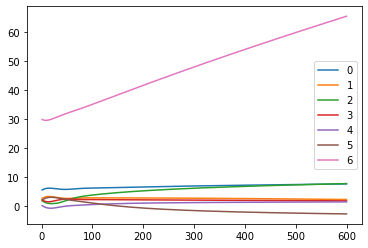

In [187]:
df_variables_iter.plot()

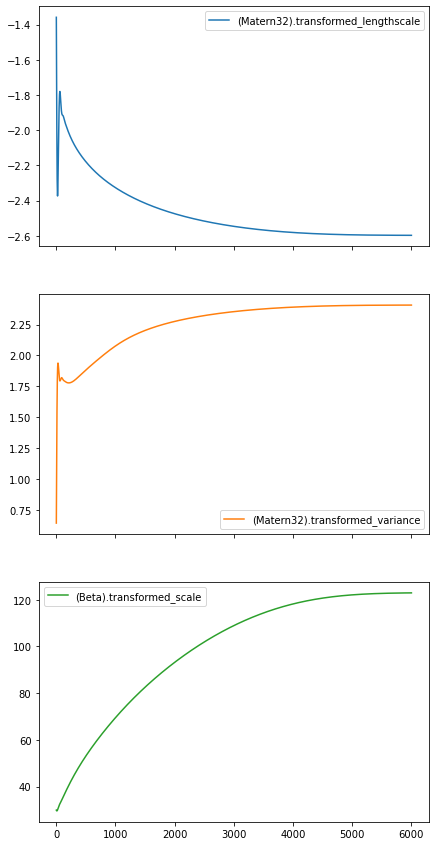

In [153]:
for system_idx in range(R.shape[1])[:1]:
    df_variables_iter = pd.DataFrame(model_vars[system_idx]).T
    df_variables_iter.columns = [
                        '(Matern32).transformed_lengthscale',
                        '(Matern32).transformed_variance',
                        '(Beta).transformed_scale']

    df_variables_iter.plot(subplots=True, figsize=(7,15))
    plt.show()


## SPATIAL ONLY

In [49]:
kern_space0 = bayesnewton.kernels.Matern32(variance=VAR_PERIOD , lengthscale=LEN_SPACE)
kern_space1 = bayesnewton.kernels.Matern32(variance=VAR_PERIOD , lengthscale=LEN_SPACE)
kern_space = bayesnewton.kernels.Separable([kern_space0, kern_space1])

In [55]:
space_model_vars = dict.fromkeys(range(len(t_train)))

for t_idx in range(len(t_train))[:100]: 

    lik = bayesnewton.likelihoods.Beta(scale = 30, fix_scale=False, link='probit')
    model = bayesnewton.models.VariationalGP(kernel = kern_space, likelihood = lik, X=R_train_scaled[t_idx], Y=Y_train[t_idx])

    opt_hypers = objax.optimizer.Adam(model.vars())
    energy = objax.GradValues(model.energy, model.vars())

    @objax.Function.with_vars(model.vars() + opt_hypers.vars())
    def train_op(batch_ind = None):
        model.inference(lr=LR_NEWTON, batch_ind = batch_ind)  #perform inference and update variational params
        dE, E = energy()  # compute energy and its gradients w.r.t. hypers
        opt_hypers(LR_ADAM, dE)
        return E
    train_op = objax.Jit(train_op)


    t0 = time.time()
    for i in range(1, 200 + 1):
        loss = train_op()
        print('iter %2d, energy: %1.4f' % (i, loss[0]))
    t1 = time.time()
    print('optimisation time: %2.2f secs' % (t1-t0))
    
    data_var = [model.vars()['(VariationalGP).kernel(Separable).kernel0(Matern32).transformed_lengthscale'].item(),
    model.vars()['(VariationalGP).kernel(Separable).kernel0(Matern32).transformed_variance'].item(),
    model.vars()['(VariationalGP).kernel(Separable).kernel1(Matern32).transformed_lengthscale'].item(),
    model.vars()['(VariationalGP).kernel(Separable).kernel1(Matern32).transformed_variance'].item(),
    model.vars()['(VariationalGP).likelihood(Beta).transformed_scale'].item()]
    data_model_vars = copy.copy(data_var)
    

    space_model_vars[t_idx] = data_model_vars

iter  1, energy: -948.8307
iter  2, energy: -956.2418
iter  3, energy: -961.1030
iter  4, energy: -963.9655
iter  5, energy: -965.8848
iter  6, energy: -967.6368
iter  7, energy: -969.7150
iter  8, energy: -972.4535
iter  9, energy: -975.9678
iter 10, energy: -979.9926
iter 11, energy: -984.0376
iter 12, energy: -987.6766
iter 13, energy: -990.7143
iter 14, energy: -993.1504
iter 15, energy: -995.1810
iter 16, energy: -997.5855
iter 17, energy: -1000.0390
iter 18, energy: -997.7422
iter 19, energy: -1001.3462
iter 20, energy: -980.5573
iter 21, energy: -1023.2821
iter 22, energy: -1038.0824
iter 23, energy: -1041.6234
iter 24, energy: -1042.2759
iter 25, energy: -1042.4651
iter 26, energy: -1042.5296
iter 27, energy: -1042.5542
iter 28, energy: -1042.5651
iter 29, energy: -1042.5712
iter 30, energy: -1042.5755
iter 31, energy: -1042.5792
iter 32, energy: -1042.5829
iter 33, energy: -1042.5866
iter 34, energy: -1042.5904
iter 35, energy: -1042.5943
iter 36, energy: -1042.5984
iter 37, e

iter 144, energy: -1043.4460
iter 145, energy: -1043.4494
iter 146, energy: -1043.4529
iter 147, energy: -1043.4563
iter 148, energy: -1043.4597
iter 149, energy: -1043.4631
iter 150, energy: -1043.4665
iter 151, energy: -1043.4699
iter 152, energy: -1043.4733
iter 153, energy: -1043.4767
iter 154, energy: -1043.4801
iter 155, energy: -1043.4834
iter 156, energy: -1043.4868
iter 157, energy: -1043.4902
iter 158, energy: -1043.4935
iter 159, energy: -1043.4969
iter 160, energy: -1043.5003
iter 161, energy: -1043.5036
iter 162, energy: -1043.5070
iter 163, energy: -1043.5103
iter 164, energy: -1043.5137
iter 165, energy: -1043.5170
iter 166, energy: -1043.5203
iter 167, energy: -1043.5236
iter 168, energy: -1043.5270
iter 169, energy: -1043.5303
iter 170, energy: -1043.5336
iter 171, energy: -1043.5369
iter 172, energy: -1043.5402
iter 173, energy: -1043.5435
iter 174, energy: -1043.5468
iter 175, energy: -1043.5501
iter 176, energy: -1043.5534
iter 177, energy: -1043.5566
iter 178, ener

iter 90, energy: -1028.0876
iter 91, energy: -1028.0910
iter 92, energy: -1028.0944
iter 93, energy: -1028.0978
iter 94, energy: -1028.1013
iter 95, energy: -1028.1047
iter 96, energy: -1028.1081
iter 97, energy: -1028.1116
iter 98, energy: -1028.1150
iter 99, energy: -1028.1184
iter 100, energy: -1028.1219
iter 101, energy: -1028.1253
iter 102, energy: -1028.1288
iter 103, energy: -1028.1323
iter 104, energy: -1028.1357
iter 105, energy: -1028.1392
iter 106, energy: -1028.1427
iter 107, energy: -1028.1461
iter 108, energy: -1028.1496
iter 109, energy: -1028.1531
iter 110, energy: -1028.1566
iter 111, energy: -1028.1600
iter 112, energy: -1028.1635
iter 113, energy: -1028.1670
iter 114, energy: -1028.1705
iter 115, energy: -1028.1740
iter 116, energy: -1028.1775
iter 117, energy: -1028.1810
iter 118, energy: -1028.1845
iter 119, energy: -1028.1880
iter 120, energy: -1028.1915
iter 121, energy: -1028.1950
iter 122, energy: -1028.1985
iter 123, energy: -1028.2020
iter 124, energy: -1028.

iter 184, energy: -1004.5270
iter 185, energy: -1004.5295
iter 186, energy: -1004.5320
iter 187, energy: -1004.5344
iter 188, energy: -1004.5369
iter 189, energy: -1004.5394
iter 190, energy: -1004.5419
iter 191, energy: -1004.5444
iter 192, energy: -1004.5468
iter 193, energy: -1004.5493
iter 194, energy: -1004.5518
iter 195, energy: -1004.5543
iter 196, energy: -1004.5568
iter 197, energy: -1004.5593
iter 198, energy: -1004.5618
iter 199, energy: -1004.5643
iter 200, energy: -1004.5668
optimisation time: 2.45 secs
iter  1, energy: -819.4775
iter  2, energy: -868.4447
iter  3, energy: -891.5091
iter  4, energy: -903.4585
iter  5, energy: -910.5860
iter  6, energy: -914.9399
iter  7, energy: -917.6596
iter  8, energy: -919.7621
iter  9, energy: -921.8942
iter 10, energy: -924.2313
iter 11, energy: -926.6471
iter 12, energy: -928.9242
iter 13, energy: -930.9366
iter 14, energy: -932.6464
iter 15, energy: -934.0724
iter 16, energy: -935.2871
iter 17, energy: -936.5560
iter 18, energy: -9

iter 139, energy: -979.4746
iter 140, energy: -979.4753
iter 141, energy: -979.4760
iter 142, energy: -979.4766
iter 143, energy: -979.4773
iter 144, energy: -979.4780
iter 145, energy: -979.4787
iter 146, energy: -979.4794
iter 147, energy: -979.4801
iter 148, energy: -979.4808
iter 149, energy: -979.4815
iter 150, energy: -979.4822
iter 151, energy: -979.4828
iter 152, energy: -979.4835
iter 153, energy: -979.4842
iter 154, energy: -979.4849
iter 155, energy: -979.4856
iter 156, energy: -979.4863
iter 157, energy: -979.4870
iter 158, energy: -979.4877
iter 159, energy: -979.4883
iter 160, energy: -979.4890
iter 161, energy: -979.4897
iter 162, energy: -979.4904
iter 163, energy: -979.4911
iter 164, energy: -979.4918
iter 165, energy: -979.4925
iter 166, energy: -979.4931
iter 167, energy: -979.4938
iter 168, energy: -979.4945
iter 169, energy: -979.4952
iter 170, energy: -979.4959
iter 171, energy: -979.4966
iter 172, energy: -979.4973
iter 173, energy: -979.4979
iter 174, energy: -9

iter 63, energy: -908.8668
iter 64, energy: -908.8678
iter 65, energy: -908.8689
iter 66, energy: -908.8699
iter 67, energy: -908.8710
iter 68, energy: -908.8721
iter 69, energy: -908.8731
iter 70, energy: -908.8742
iter 71, energy: -908.8753
iter 72, energy: -908.8764
iter 73, energy: -908.8775
iter 74, energy: -908.8786
iter 75, energy: -908.8797
iter 76, energy: -908.8808
iter 77, energy: -908.8819
iter 78, energy: -908.8830
iter 79, energy: -908.8841
iter 80, energy: -908.8853
iter 81, energy: -908.8864
iter 82, energy: -908.8876
iter 83, energy: -908.8887
iter 84, energy: -908.8899
iter 85, energy: -908.8910
iter 86, energy: -908.8922
iter 87, energy: -908.8934
iter 88, energy: -908.8945
iter 89, energy: -908.8957
iter 90, energy: -908.8969
iter 91, energy: -908.8981
iter 92, energy: -908.8993
iter 93, energy: -908.9005
iter 94, energy: -908.9017
iter 95, energy: -908.9029
iter 96, energy: -908.9042
iter 97, energy: -908.9054
iter 98, energy: -908.9066
iter 99, energy: -908.9079
i

iter 200, energy: -835.9738
optimisation time: 2.30 secs
iter  1, energy: -546.0639
iter  2, energy: -603.7259
iter  3, energy: -630.0317
iter  4, energy: -647.3593
iter  5, energy: -661.1945
iter  6, energy: -671.2662
iter  7, energy: -677.2489
iter  8, energy: -680.2985
iter  9, energy: -681.9186
iter 10, energy: -683.0156
iter 11, energy: -683.9388
iter 12, energy: -684.7741
iter 13, energy: -685.5311
iter 14, energy: -686.2094
iter 15, energy: -686.8132
iter 16, energy: -687.3558
iter 17, energy: -687.8710
iter 18, energy: -688.4616
iter 19, energy: -689.5660
iter 20, energy: -692.9877
iter 21, energy: -689.1690
iter 22, energy: -693.1934
iter 23, energy: -660.6697
iter 24, energy: -752.0075
iter 25, energy: -747.5551
iter 26, energy: -770.5265
iter 27, energy: -770.9289
iter 28, energy: -771.0538
iter 29, energy: -771.0968
iter 30, energy: -771.1128
iter 31, energy: -771.1194
iter 32, energy: -771.1226
iter 33, energy: -771.1246
iter 34, energy: -771.1262
iter 35, energy: -771.127

iter 134, energy: -672.4273
iter 135, energy: -672.4281
iter 136, energy: -672.4290
iter 137, energy: -672.4298
iter 138, energy: -672.4306
iter 139, energy: -672.4314
iter 140, energy: -672.4323
iter 141, energy: -672.4331
iter 142, energy: -672.4339
iter 143, energy: -672.4348
iter 144, energy: -672.4356
iter 145, energy: -672.4364
iter 146, energy: -672.4373
iter 147, energy: -672.4381
iter 148, energy: -672.4390
iter 149, energy: -672.4398
iter 150, energy: -672.4407
iter 151, energy: -672.4416
iter 152, energy: -672.4424
iter 153, energy: -672.4433
iter 154, energy: -672.4441
iter 155, energy: -672.4450
iter 156, energy: -672.4459
iter 157, energy: -672.4468
iter 158, energy: -672.4476
iter 159, energy: -672.4485
iter 160, energy: -672.4494
iter 161, energy: -672.4503
iter 162, energy: -672.4512
iter 163, energy: -672.4520
iter 164, energy: -672.4529
iter 165, energy: -672.4538
iter 166, energy: -672.4547
iter 167, energy: -672.4556
iter 168, energy: -672.4565
iter 169, energy: -6

iter 64, energy: -502.1035
iter 65, energy: -502.1036
iter 66, energy: -502.1038
iter 67, energy: -502.1039
iter 68, energy: -502.1041
iter 69, energy: -502.1042
iter 70, energy: -502.1044
iter 71, energy: -502.1046
iter 72, energy: -502.1047
iter 73, energy: -502.1049
iter 74, energy: -502.1050
iter 75, energy: -502.1052
iter 76, energy: -502.1054
iter 77, energy: -502.1055
iter 78, energy: -502.1057
iter 79, energy: -502.1059
iter 80, energy: -502.1061
iter 81, energy: -502.1062
iter 82, energy: -502.1064
iter 83, energy: -502.1066
iter 84, energy: -502.1068
iter 85, energy: -502.1069
iter 86, energy: -502.1071
iter 87, energy: -502.1073
iter 88, energy: -502.1075
iter 89, energy: -502.1077
iter 90, energy: -502.1078
iter 91, energy: -502.1080
iter 92, energy: -502.1082
iter 93, energy: -502.1084
iter 94, energy: -502.1086
iter 95, energy: -502.1088
iter 96, energy: -502.1090
iter 97, energy: -502.1091
iter 98, energy: -502.1093
iter 99, energy: -502.1095
iter 100, energy: -502.1097


iter 177, energy: -434.5955
iter 178, energy: -434.5956
iter 179, energy: -434.5957
iter 180, energy: -434.5957
iter 181, energy: -434.5958
iter 182, energy: -434.5958
iter 183, energy: -434.5959
iter 184, energy: -434.5959
iter 185, energy: -434.5960
iter 186, energy: -434.5960
iter 187, energy: -434.5961
iter 188, energy: -434.5961
iter 189, energy: -434.5962
iter 190, energy: -434.5962
iter 191, energy: -434.5963
iter 192, energy: -434.5963
iter 193, energy: -434.5964
iter 194, energy: -434.5964
iter 195, energy: -434.5965
iter 196, energy: -434.5966
iter 197, energy: -434.5966
iter 198, energy: -434.5967
iter 199, energy: -434.5967
iter 200, energy: -434.5968
optimisation time: 3.10 secs
iter  1, energy: -134.8999
iter  2, energy: -181.1548
iter  3, energy: -200.0900
iter  4, energy: -210.3237
iter  5, energy: -216.8733
iter  6, energy: -220.6818
iter  7, energy: -222.5701
iter  8, energy: -223.4718
iter  9, energy: -223.9761
iter 10, energy: -224.3591
iter 11, energy: -224.8306
it

iter 102, energy: -360.0184
iter 103, energy: -360.0184
iter 104, energy: -360.0185
iter 105, energy: -360.0185
iter 106, energy: -360.0185
iter 107, energy: -360.0185
iter 108, energy: -360.0185
iter 109, energy: -360.0186
iter 110, energy: -360.0186
iter 111, energy: -360.0186
iter 112, energy: -360.0186
iter 113, energy: -360.0186
iter 114, energy: -360.0187
iter 115, energy: -360.0187
iter 116, energy: -360.0187
iter 117, energy: -360.0187
iter 118, energy: -360.0187
iter 119, energy: -360.0188
iter 120, energy: -360.0188
iter 121, energy: -360.0188
iter 122, energy: -360.0188
iter 123, energy: -360.0188
iter 124, energy: -360.0189
iter 125, energy: -360.0189
iter 126, energy: -360.0189
iter 127, energy: -360.0189
iter 128, energy: -360.0189
iter 129, energy: -360.0190
iter 130, energy: -360.0190
iter 131, energy: -360.0190
iter 132, energy: -360.0190
iter 133, energy: -360.0191
iter 134, energy: -360.0191
iter 135, energy: -360.0191
iter 136, energy: -360.0191
iter 137, energy: -3

iter  1, energy: -47.9394
iter  2, energy: -72.5956
iter  3, energy: -82.9107
iter  4, energy: -89.4555
iter  5, energy: -95.2661
iter  6, energy: -100.0122
iter  7, energy: -102.9423
iter  8, energy: -104.4792
iter  9, energy: -105.6651
iter 10, energy: -111.2458
iter 11, energy: 1818.1972
iter 12, energy: -311.0366
iter 13, energy: -315.7517
iter 14, energy: -317.7678
iter 15, energy: -318.4163
iter 16, energy: -318.6407
iter 17, energy: -318.7246
iter 18, energy: -318.7569
iter 19, energy: -318.7696
iter 20, energy: -318.7749
iter 21, energy: -318.7774
iter 22, energy: -318.7787
iter 23, energy: -318.7795
iter 24, energy: -318.7801
iter 25, energy: -318.7806
iter 26, energy: -318.7810
iter 27, energy: -318.7814
iter 28, energy: -318.7817
iter 29, energy: -318.7820
iter 30, energy: -318.7823
iter 31, energy: -318.7825
iter 32, energy: -318.7828
iter 33, energy: -318.7830
iter 34, energy: -318.7832
iter 35, energy: -318.7834
iter 36, energy: -318.7836
iter 37, energy: -318.7838
iter 3

iter 120, energy: -282.7944
iter 121, energy: -282.7988
iter 122, energy: -282.8033
iter 123, energy: -282.8077
iter 124, energy: -282.8121
iter 125, energy: -282.8165
iter 126, energy: -282.8209
iter 127, energy: -282.8254
iter 128, energy: -282.8298
iter 129, energy: -282.8343
iter 130, energy: -282.8387
iter 131, energy: -282.8432
iter 132, energy: -282.8476
iter 133, energy: -282.8521
iter 134, energy: -282.8566
iter 135, energy: -282.8610
iter 136, energy: -282.8655
iter 137, energy: -282.8700
iter 138, energy: -282.8745
iter 139, energy: -282.8790
iter 140, energy: -282.8835
iter 141, energy: -282.8880
iter 142, energy: -282.8925
iter 143, energy: -282.8970
iter 144, energy: -282.9015
iter 145, energy: -282.9060
iter 146, energy: -282.9106
iter 147, energy: -282.9151
iter 148, energy: -282.9196
iter 149, energy: -282.9241
iter 150, energy: -282.9287
iter 151, energy: -282.9332
iter 152, energy: -282.9378
iter 153, energy: -282.9423
iter 154, energy: -282.9469
iter 155, energy: -2

iter 70, energy: -230.3283
iter 71, energy: -230.3320
iter 72, energy: -230.3356
iter 73, energy: -230.3393
iter 74, energy: -230.3430
iter 75, energy: -230.3468
iter 76, energy: -230.3506
iter 77, energy: -230.3543
iter 78, energy: -230.3582
iter 79, energy: -230.3620
iter 80, energy: -230.3659
iter 81, energy: -230.3697
iter 82, energy: -230.3736
iter 83, energy: -230.3776
iter 84, energy: -230.3815
iter 85, energy: -230.3855
iter 86, energy: -230.3895
iter 87, energy: -230.3935
iter 88, energy: -230.3976
iter 89, energy: -230.4016
iter 90, energy: -230.4057
iter 91, energy: -230.4098
iter 92, energy: -230.4140
iter 93, energy: -230.4181
iter 94, energy: -230.4223
iter 95, energy: -230.4265
iter 96, energy: -230.4307
iter 97, energy: -230.4349
iter 98, energy: -230.4392
iter 99, energy: -230.4434
iter 100, energy: -230.4477
iter 101, energy: -230.4521
iter 102, energy: -230.4564
iter 103, energy: -230.4607
iter 104, energy: -230.4651
iter 105, energy: -230.4695
iter 106, energy: -230

iter  1, energy: 106.3736
iter  2, energy: 98.7875
iter  3, energy: 88.3558
iter  4, energy: 50.6447
iter  5, energy: -27.2195
iter  6, energy: 283.2131
iter  7, energy: -173.2182
iter  8, energy: -186.1514
iter  9, energy: -190.5449
iter 10, energy: -192.2193
iter 11, energy: -192.8613
iter 12, energy: -193.1025
iter 13, energy: -193.1932
iter 14, energy: -193.2300
iter 15, energy: -193.2482
iter 16, energy: -193.2601
iter 17, energy: -193.2699
iter 18, energy: -193.2790
iter 19, energy: -193.2879
iter 20, energy: -193.2966
iter 21, energy: -193.3053
iter 22, energy: -193.3141
iter 23, energy: -193.3228
iter 24, energy: -193.3316
iter 25, energy: -193.3405
iter 26, energy: -193.3494
iter 27, energy: -193.3584
iter 28, energy: -193.3674
iter 29, energy: -193.3765
iter 30, energy: -193.3856
iter 31, energy: -193.3948
iter 32, energy: -193.4041
iter 33, energy: -193.4135
iter 34, energy: -193.4229
iter 35, energy: -193.4324
iter 36, energy: -193.4420
iter 37, energy: -193.4517
iter 38, e

iter 138, energy: -187.4031
iter 139, energy: -187.4210
iter 140, energy: -187.4390
iter 141, energy: -187.4569
iter 142, energy: -187.4749
iter 143, energy: -187.4928
iter 144, energy: -187.5108
iter 145, energy: -187.5287
iter 146, energy: -187.5467
iter 147, energy: -187.5647
iter 148, energy: -187.5826
iter 149, energy: -187.6006
iter 150, energy: -187.6186
iter 151, energy: -187.6366
iter 152, energy: -187.6545
iter 153, energy: -187.6725
iter 154, energy: -187.6905
iter 155, energy: -187.7084
iter 156, energy: -187.7264
iter 157, energy: -187.7444
iter 158, energy: -187.7624
iter 159, energy: -187.7804
iter 160, energy: -187.7983
iter 161, energy: -187.8163
iter 162, energy: -187.8343
iter 163, energy: -187.8523
iter 164, energy: -187.8703
iter 165, energy: -187.8882
iter 166, energy: -187.9062
iter 167, energy: -187.9242
iter 168, energy: -187.9422
iter 169, energy: -187.9602
iter 170, energy: -187.9781
iter 171, energy: -187.9961
iter 172, energy: -188.0141
iter 173, energy: -1

iter 57, energy: -166.2174
iter 58, energy: -166.2270
iter 59, energy: -166.2366
iter 60, energy: -166.2462
iter 61, energy: -166.2559
iter 62, energy: -166.2656
iter 63, energy: -166.2754
iter 64, energy: -166.2852
iter 65, energy: -166.2951
iter 66, energy: -166.3050
iter 67, energy: -166.3149
iter 68, energy: -166.3249
iter 69, energy: -166.3349
iter 70, energy: -166.3450
iter 71, energy: -166.3551
iter 72, energy: -166.3652
iter 73, energy: -166.3754
iter 74, energy: -166.3856
iter 75, energy: -166.3959
iter 76, energy: -166.4061
iter 77, energy: -166.4165
iter 78, energy: -166.4268
iter 79, energy: -166.4372
iter 80, energy: -166.4476
iter 81, energy: -166.4581
iter 82, energy: -166.4686
iter 83, energy: -166.4791
iter 84, energy: -166.4896
iter 85, energy: -166.5002
iter 86, energy: -166.5108
iter 87, energy: -166.5215
iter 88, energy: -166.5321
iter 89, energy: -166.5428
iter 90, energy: -166.5535
iter 91, energy: -166.5643
iter 92, energy: -166.5751
iter 93, energy: -166.5859
i

iter 183, energy: -181.4927
iter 184, energy: -181.5015
iter 185, energy: -181.5103
iter 186, energy: -181.5192
iter 187, energy: -181.5281
iter 188, energy: -181.5370
iter 189, energy: -181.5458
iter 190, energy: -181.5547
iter 191, energy: -181.5637
iter 192, energy: -181.5726
iter 193, energy: -181.5815
iter 194, energy: -181.5904
iter 195, energy: -181.5994
iter 196, energy: -181.6083
iter 197, energy: -181.6173
iter 198, energy: -181.6263
iter 199, energy: -181.6353
iter 200, energy: -181.6443
optimisation time: 2.43 secs
iter  1, energy: 158.6012
iter  2, energy: 133.2780
iter  3, energy: 65.2638
iter  4, energy: -20.2565
iter  5, energy: 110.1902
iter  6, energy: -172.1242
iter  7, energy: -178.0069
iter  8, energy: -179.7105
iter  9, energy: -180.2628
iter 10, energy: -180.4464
iter 11, energy: -180.5092
iter 12, energy: -180.5333
iter 13, energy: -180.5453
iter 14, energy: -180.5534
iter 15, energy: -180.5603
iter 16, energy: -180.5667
iter 17, energy: -180.5729
iter 18, energ

iter 83, energy: -180.8525
iter 84, energy: -180.8688
iter 85, energy: -180.8850
iter 86, energy: -180.9013
iter 87, energy: -180.9177
iter 88, energy: -180.9340
iter 89, energy: -180.9505
iter 90, energy: -180.9669
iter 91, energy: -180.9834
iter 92, energy: -181.0000
iter 93, energy: -181.0165
iter 94, energy: -181.0331
iter 95, energy: -181.0498
iter 96, energy: -181.0664
iter 97, energy: -181.0831
iter 98, energy: -181.0999
iter 99, energy: -181.1166
iter 100, energy: -181.1334
iter 101, energy: -181.1503
iter 102, energy: -181.1671
iter 103, energy: -181.1840
iter 104, energy: -181.2010
iter 105, energy: -181.2179
iter 106, energy: -181.2349
iter 107, energy: -181.2519
iter 108, energy: -181.2690
iter 109, energy: -181.2860
iter 110, energy: -181.3031
iter 111, energy: -181.3203
iter 112, energy: -181.3374
iter 113, energy: -181.3546
iter 114, energy: -181.3718
iter 115, energy: -181.3890
iter 116, energy: -181.4063
iter 117, energy: -181.4236
iter 118, energy: -181.4409
iter 119,

iter  1, energy: 267.3703
iter  2, energy: 230.1899
iter  3, energy: 152.8805
iter  4, energy: 127.3560
iter  5, energy: -50.2995
iter  6, energy: 274.3704
iter  7, energy: -41.0924
iter  8, energy: -87.8083
iter  9, energy: -111.4766
iter 10, energy: -135.8762
iter 11, energy: -131.2886
iter 12, energy: -148.7055
iter 13, energy: -148.9253
iter 14, energy: -149.0160
iter 15, energy: -149.0734
iter 16, energy: -149.1201
iter 17, energy: -149.1628
iter 18, energy: -149.2036
iter 19, energy: -149.2432
iter 20, energy: -149.2821
iter 21, energy: -149.3204
iter 22, energy: -149.3582
iter 23, energy: -149.3956
iter 24, energy: -149.4327
iter 25, energy: -149.4695
iter 26, energy: -149.5061
iter 27, energy: -149.5425
iter 28, energy: -149.5787
iter 29, energy: -149.6149
iter 30, energy: -149.6510
iter 31, energy: -149.6871
iter 32, energy: -149.7231
iter 33, energy: -149.7592
iter 34, energy: -149.7953
iter 35, energy: -149.8314
iter 36, energy: -149.8676
iter 37, energy: -149.9039
iter 38, 

iter 114, energy: -144.7253
iter 115, energy: -144.7708
iter 116, energy: -144.8163
iter 117, energy: -144.8617
iter 118, energy: -144.9070
iter 119, energy: -144.9522
iter 120, energy: -144.9973
iter 121, energy: -145.0424
iter 122, energy: -145.0874
iter 123, energy: -145.1323
iter 124, energy: -145.1772
iter 125, energy: -145.2219
iter 126, energy: -145.2666
iter 127, energy: -145.3112
iter 128, energy: -145.3557
iter 129, energy: -145.4001
iter 130, energy: -145.4445
iter 131, energy: -145.4888
iter 132, energy: -145.5330
iter 133, energy: -145.5771
iter 134, energy: -145.6211
iter 135, energy: -145.6650
iter 136, energy: -145.7089
iter 137, energy: -145.7527
iter 138, energy: -145.7964
iter 139, energy: -145.8400
iter 140, energy: -145.8835
iter 141, energy: -145.9270
iter 142, energy: -145.9703
iter 143, energy: -146.0136
iter 144, energy: -146.0568
iter 145, energy: -146.0999
iter 146, energy: -146.1430
iter 147, energy: -146.1859
iter 148, energy: -146.2288
iter 149, energy: -1

iter 43, energy: -140.1241
iter 44, energy: -140.1397
iter 45, energy: -140.1554
iter 46, energy: -140.1712
iter 47, energy: -140.1871
iter 48, energy: -140.2030
iter 49, energy: -140.2190
iter 50, energy: -140.2351
iter 51, energy: -140.2512
iter 52, energy: -140.2674
iter 53, energy: -140.2837
iter 54, energy: -140.3000
iter 55, energy: -140.3165
iter 56, energy: -140.3330
iter 57, energy: -140.3495
iter 58, energy: -140.3661
iter 59, energy: -140.3828
iter 60, energy: -140.3996
iter 61, energy: -140.4164
iter 62, energy: -140.4332
iter 63, energy: -140.4502
iter 64, energy: -140.4672
iter 65, energy: -140.4842
iter 66, energy: -140.5013
iter 67, energy: -140.5185
iter 68, energy: -140.5357
iter 69, energy: -140.5530
iter 70, energy: -140.5703
iter 71, energy: -140.5877
iter 72, energy: -140.6051
iter 73, energy: -140.6225
iter 74, energy: -140.6401
iter 75, energy: -140.6576
iter 76, energy: -140.6752
iter 77, energy: -140.6929
iter 78, energy: -140.7105
iter 79, energy: -140.7283
i

iter 169, energy: -150.1279
iter 170, energy: -150.1320
iter 171, energy: -150.1360
iter 172, energy: -150.1400
iter 173, energy: -150.1440
iter 174, energy: -150.1481
iter 175, energy: -150.1521
iter 176, energy: -150.1560
iter 177, energy: -150.1600
iter 178, energy: -150.1640
iter 179, energy: -150.1680
iter 180, energy: -150.1719
iter 181, energy: -150.1759
iter 182, energy: -150.1798
iter 183, energy: -150.1838
iter 184, energy: -150.1877
iter 185, energy: -150.1916
iter 186, energy: -150.1956
iter 187, energy: -150.1995
iter 188, energy: -150.2034
iter 189, energy: -150.2073
iter 190, energy: -150.2111
iter 191, energy: -150.2150
iter 192, energy: -150.2189
iter 193, energy: -150.2227
iter 194, energy: -150.2266
iter 195, energy: -150.2304
iter 196, energy: -150.2343
iter 197, energy: -150.2381
iter 198, energy: -150.2419
iter 199, energy: -150.2457
iter 200, energy: -150.2495
optimisation time: 3.28 secs
iter  1, energy: 397.8549
iter  2, energy: 360.1611
iter  3, energy: 329.98

iter 81, energy: -131.7722
iter 82, energy: -131.7812
iter 83, energy: -131.7902
iter 84, energy: -131.7992
iter 85, energy: -131.8083
iter 86, energy: -131.8173
iter 87, energy: -131.8264
iter 88, energy: -131.8355
iter 89, energy: -131.8446
iter 90, energy: -131.8538
iter 91, energy: -131.8629
iter 92, energy: -131.8721
iter 93, energy: -131.8813
iter 94, energy: -131.8905
iter 95, energy: -131.8997
iter 96, energy: -131.9089
iter 97, energy: -131.9181
iter 98, energy: -131.9274
iter 99, energy: -131.9366
iter 100, energy: -131.9459
iter 101, energy: -131.9552
iter 102, energy: -131.9644
iter 103, energy: -131.9737
iter 104, energy: -131.9830
iter 105, energy: -131.9923
iter 106, energy: -132.0016
iter 107, energy: -132.0109
iter 108, energy: -132.0203
iter 109, energy: -132.0296
iter 110, energy: -132.0389
iter 111, energy: -132.0483
iter 112, energy: -132.0576
iter 113, energy: -132.0669
iter 114, energy: -132.0763
iter 115, energy: -132.0856
iter 116, energy: -132.0950
iter 117, e

iter  1, energy: 394.3958
iter  2, energy: 364.5440
iter  3, energy: 346.0264
iter  4, energy: 333.9324
iter  5, energy: 323.2213
iter  6, energy: 269.9481
iter  7, energy: 244.3980
iter  8, energy: 29.4248
iter  9, energy: 21.7868
iter 10, energy: -80.1600
iter 11, energy: -87.4476
iter 12, energy: -88.4154
iter 13, energy: -94.6572
iter 14, energy: -101.6972
iter 15, energy: -103.4709
iter 16, energy: -112.9253
iter 17, energy: -118.3378
iter 18, energy: -121.7543
iter 19, energy: -127.6399
iter 20, energy: -129.7363
iter 21, energy: -130.7289
iter 22, energy: -131.0692
iter 23, energy: -131.1846
iter 24, energy: -131.2357
iter 25, energy: -131.2614
iter 26, energy: -131.2764
iter 27, energy: -131.2868
iter 28, energy: -131.2951
iter 29, energy: -131.3024
iter 30, energy: -131.3091
iter 31, energy: -131.3155
iter 32, energy: -131.3218
iter 33, energy: -131.3278
iter 34, energy: -131.3338
iter 35, energy: -131.3397
iter 36, energy: -131.3456
iter 37, energy: -131.3513
iter 38, energy:

iter 120, energy: -126.9877
iter 121, energy: -127.0012
iter 122, energy: -127.0145
iter 123, energy: -127.0279
iter 124, energy: -127.0412
iter 125, energy: -127.0545
iter 126, energy: -127.0678
iter 127, energy: -127.0810
iter 128, energy: -127.0942
iter 129, energy: -127.1074
iter 130, energy: -127.1206
iter 131, energy: -127.1337
iter 132, energy: -127.1468
iter 133, energy: -127.1598
iter 134, energy: -127.1728
iter 135, energy: -127.1858
iter 136, energy: -127.1988
iter 137, energy: -127.2117
iter 138, energy: -127.2246
iter 139, energy: -127.2375
iter 140, energy: -127.2503
iter 141, energy: -127.2631
iter 142, energy: -127.2759
iter 143, energy: -127.2886
iter 144, energy: -127.3013
iter 145, energy: -127.3140
iter 146, energy: -127.3267
iter 147, energy: -127.3393
iter 148, energy: -127.3519
iter 149, energy: -127.3644
iter 150, energy: -127.3770
iter 151, energy: -127.3895
iter 152, energy: -127.4019
iter 153, energy: -127.4144
iter 154, energy: -127.4268
iter 155, energy: -1

iter 27, energy: -107.8261
iter 28, energy: -107.8351
iter 29, energy: -107.8430
iter 30, energy: -107.8503
iter 31, energy: -107.8573
iter 32, energy: -107.8641
iter 33, energy: -107.8709
iter 34, energy: -107.8775
iter 35, energy: -107.8841
iter 36, energy: -107.8907
iter 37, energy: -107.8973
iter 38, energy: -107.9038
iter 39, energy: -107.9103
iter 40, energy: -107.9168
iter 41, energy: -107.9234
iter 42, energy: -107.9299
iter 43, energy: -107.9364
iter 44, energy: -107.9430
iter 45, energy: -107.9495
iter 46, energy: -107.9561
iter 47, energy: -107.9627
iter 48, energy: -107.9694
iter 49, energy: -107.9760
iter 50, energy: -107.9827
iter 51, energy: -107.9894
iter 52, energy: -107.9961
iter 53, energy: -108.0029
iter 54, energy: -108.0097
iter 55, energy: -108.0165
iter 56, energy: -108.0234
iter 57, energy: -108.0303
iter 58, energy: -108.0372
iter 59, energy: -108.0442
iter 60, energy: -108.0512
iter 61, energy: -108.0582
iter 62, energy: -108.0653
iter 63, energy: -108.0724
i

iter 155, energy: -121.8501
iter 156, energy: -121.8509
iter 157, energy: -121.8517
iter 158, energy: -121.8524
iter 159, energy: -121.8532
iter 160, energy: -121.8540
iter 161, energy: -121.8548
iter 162, energy: -121.8556
iter 163, energy: -121.8564
iter 164, energy: -121.8572
iter 165, energy: -121.8581
iter 166, energy: -121.8589
iter 167, energy: -121.8597
iter 168, energy: -121.8605
iter 169, energy: -121.8613
iter 170, energy: -121.8621
iter 171, energy: -121.8630
iter 172, energy: -121.8638
iter 173, energy: -121.8646
iter 174, energy: -121.8654
iter 175, energy: -121.8663
iter 176, energy: -121.8671
iter 177, energy: -121.8680
iter 178, energy: -121.8688
iter 179, energy: -121.8696
iter 180, energy: -121.8705
iter 181, energy: -121.8713
iter 182, energy: -121.8722
iter 183, energy: -121.8730
iter 184, energy: -121.8739
iter 185, energy: -121.8748
iter 186, energy: -121.8756
iter 187, energy: -121.8765
iter 188, energy: -121.8773
iter 189, energy: -121.8782
iter 190, energy: -1

iter 66, energy: -109.1871
iter 67, energy: -109.1949
iter 68, energy: -109.2028
iter 69, energy: -109.2108
iter 70, energy: -109.2188
iter 71, energy: -109.2268
iter 72, energy: -109.2350
iter 73, energy: -109.2431
iter 74, energy: -109.2514
iter 75, energy: -109.2597
iter 76, energy: -109.2680
iter 77, energy: -109.2764
iter 78, energy: -109.2848
iter 79, energy: -109.2933
iter 80, energy: -109.3018
iter 81, energy: -109.3104
iter 82, energy: -109.3191
iter 83, energy: -109.3277
iter 84, energy: -109.3365
iter 85, energy: -109.3452
iter 86, energy: -109.3540
iter 87, energy: -109.3629
iter 88, energy: -109.3718
iter 89, energy: -109.3807
iter 90, energy: -109.3897
iter 91, energy: -109.3988
iter 92, energy: -109.4078
iter 93, energy: -109.4169
iter 94, energy: -109.4261
iter 95, energy: -109.4353
iter 96, energy: -109.4445
iter 97, energy: -109.4538
iter 98, energy: -109.4631
iter 99, energy: -109.4724
iter 100, energy: -109.4818
iter 101, energy: -109.4912
iter 102, energy: -109.500

iter 170, energy: -102.0269
iter 171, energy: -102.0296
iter 172, energy: -102.0323
iter 173, energy: -102.0350
iter 174, energy: -102.0378
iter 175, energy: -102.0405
iter 176, energy: -102.0433
iter 177, energy: -102.0460
iter 178, energy: -102.0488
iter 179, energy: -102.0515
iter 180, energy: -102.0543
iter 181, energy: -102.0571
iter 182, energy: -102.0599
iter 183, energy: -102.0627
iter 184, energy: -102.0655
iter 185, energy: -102.0683
iter 186, energy: -102.0711
iter 187, energy: -102.0740
iter 188, energy: -102.0768
iter 189, energy: -102.0797
iter 190, energy: -102.0825
iter 191, energy: -102.0854
iter 192, energy: -102.0882
iter 193, energy: -102.0911
iter 194, energy: -102.0940
iter 195, energy: -102.0969
iter 196, energy: -102.0998
iter 197, energy: -102.1027
iter 198, energy: -102.1056
iter 199, energy: -102.1085
iter 200, energy: -102.1115
optimisation time: 2.46 secs
iter  1, energy: 559.6176
iter  2, energy: 487.6408
iter  3, energy: 383.9640
iter  4, energy: 325.5975

iter 152, energy: -60.7229
iter 153, energy: -60.7332
iter 154, energy: -60.7436
iter 155, energy: -60.7540
iter 156, energy: -60.7644
iter 157, energy: -60.7748
iter 158, energy: -60.7852
iter 159, energy: -60.7957
iter 160, energy: -60.8062
iter 161, energy: -60.8167
iter 162, energy: -60.8273
iter 163, energy: -60.8378
iter 164, energy: -60.8484
iter 165, energy: -60.8591
iter 166, energy: -60.8697
iter 167, energy: -60.8804
iter 168, energy: -60.8911
iter 169, energy: -60.9018
iter 170, energy: -60.9125
iter 171, energy: -60.9233
iter 172, energy: -60.9341
iter 173, energy: -60.9449
iter 174, energy: -60.9558
iter 175, energy: -60.9666
iter 176, energy: -60.9775
iter 177, energy: -60.9884
iter 178, energy: -60.9993
iter 179, energy: -61.0103
iter 180, energy: -61.0213
iter 181, energy: -61.0323
iter 182, energy: -61.0433
iter 183, energy: -61.0543
iter 184, energy: -61.0654
iter 185, energy: -61.0765
iter 186, energy: -61.0876
iter 187, energy: -61.0987
iter 188, energy: -61.1099
i

iter 80, energy: -60.6077
iter 81, energy: -60.6157
iter 82, energy: -60.6235
iter 83, energy: -60.6314
iter 84, energy: -60.6393
iter 85, energy: -60.6472
iter 86, energy: -60.6551
iter 87, energy: -60.6629
iter 88, energy: -60.6708
iter 89, energy: -60.6786
iter 90, energy: -60.6864
iter 91, energy: -60.6943
iter 92, energy: -60.7021
iter 93, energy: -60.7099
iter 94, energy: -60.7177
iter 95, energy: -60.7255
iter 96, energy: -60.7332
iter 97, energy: -60.7410
iter 98, energy: -60.7487
iter 99, energy: -60.7565
iter 100, energy: -60.7642
iter 101, energy: -60.7719
iter 102, energy: -60.7796
iter 103, energy: -60.7873
iter 104, energy: -60.7950
iter 105, energy: -60.8027
iter 106, energy: -60.8104
iter 107, energy: -60.8180
iter 108, energy: -60.8256
iter 109, energy: -60.8333
iter 110, energy: -60.8409
iter 111, energy: -60.8485
iter 112, energy: -60.8561
iter 113, energy: -60.8637
iter 114, energy: -60.8712
iter 115, energy: -60.8788
iter 116, energy: -60.8863
iter 117, energy: -60

iter  1, energy: 707.2842
iter  2, energy: 710.7545
iter  3, energy: 603.6012
iter  4, energy: 557.9942
iter  5, energy: 599.6339
iter  6, energy: 1229.3211
iter  7, energy: 819.8171
iter  8, energy: 629.6966
iter  9, energy: 432.0427
iter 10, energy: 362.2480
iter 11, energy: 308.4363
iter 12, energy: 671.4719
iter 13, energy: 228.9049
iter 14, energy: 649.1068
iter 15, energy: 485.2662
iter 16, energy: 264.1730
iter 17, energy: 191.9493
iter 18, energy: 167.5963
iter 19, energy: 158.1676
iter 20, energy: 154.2879
iter 21, energy: 150.8710
iter 22, energy: 148.9844
iter 23, energy: 147.1199
iter 24, energy: 142.9746
iter 25, energy: 172.2979
iter 26, energy: 51.0718
iter 27, energy: 30.8581
iter 28, energy: -13.7671
iter 29, energy: -16.8867
iter 30, energy: -21.9303
iter 31, energy: -24.6742
iter 32, energy: -26.0012
iter 33, energy: -28.5759
iter 34, energy: -29.4046
iter 35, energy: -30.7731
iter 36, energy: -33.8514
iter 37, energy: -37.9578
iter 38, energy: -39.0622
iter 39, ener

iter 123, energy: -57.3123
iter 124, energy: -57.3139
iter 125, energy: -57.3156
iter 126, energy: -57.3173
iter 127, energy: -57.3191
iter 128, energy: -57.3208
iter 129, energy: -57.3225
iter 130, energy: -57.3242
iter 131, energy: -57.3260
iter 132, energy: -57.3277
iter 133, energy: -57.3295
iter 134, energy: -57.3312
iter 135, energy: -57.3330
iter 136, energy: -57.3348
iter 137, energy: -57.3366
iter 138, energy: -57.3383
iter 139, energy: -57.3401
iter 140, energy: -57.3419
iter 141, energy: -57.3438
iter 142, energy: -57.3456
iter 143, energy: -57.3474
iter 144, energy: -57.3492
iter 145, energy: -57.3511
iter 146, energy: -57.3529
iter 147, energy: -57.3547
iter 148, energy: -57.3566
iter 149, energy: -57.3585
iter 150, energy: -57.3603
iter 151, energy: -57.3622
iter 152, energy: -57.3641
iter 153, energy: -57.3660
iter 154, energy: -57.3679
iter 155, energy: -57.3698
iter 156, energy: -57.3717
iter 157, energy: -57.3736
iter 158, energy: -57.3755
iter 159, energy: -57.3775
i

iter 53, energy: -56.5872
iter 54, energy: -57.0156
iter 55, energy: -57.2186
iter 56, energy: -57.3332
iter 57, energy: -57.4099
iter 58, energy: -57.4690
iter 59, energy: -57.5198
iter 60, energy: -57.5667
iter 61, energy: -57.6117
iter 62, energy: -57.6559
iter 63, energy: -57.6996
iter 64, energy: -57.7430
iter 65, energy: -57.7861
iter 66, energy: -57.8290
iter 67, energy: -57.8718
iter 68, energy: -57.9142
iter 69, energy: -57.9564
iter 70, energy: -57.9984
iter 71, energy: -58.0400
iter 72, energy: -58.0813
iter 73, energy: -58.1222
iter 74, energy: -58.1628
iter 75, energy: -58.2030
iter 76, energy: -58.2429
iter 77, energy: -58.2823
iter 78, energy: -58.3214
iter 79, energy: -58.3601
iter 80, energy: -58.3984
iter 81, energy: -58.4362
iter 82, energy: -58.4737
iter 83, energy: -58.5107
iter 84, energy: -58.5474
iter 85, energy: -58.5836
iter 86, energy: -58.6194
iter 87, energy: -58.6549
iter 88, energy: -58.6899
iter 89, energy: -58.7245
iter 90, energy: -58.7587
iter 91, ene

iter 166, energy: -55.7346
iter 167, energy: -55.7381
iter 168, energy: -55.7416
iter 169, energy: -55.7451
iter 170, energy: -55.7486
iter 171, energy: -55.7521
iter 172, energy: -55.7557
iter 173, energy: -55.7592
iter 174, energy: -55.7627
iter 175, energy: -55.7663
iter 176, energy: -55.7699
iter 177, energy: -55.7735
iter 178, energy: -55.7771
iter 179, energy: -55.7807
iter 180, energy: -55.7843
iter 181, energy: -55.7879
iter 182, energy: -55.7916
iter 183, energy: -55.7952
iter 184, energy: -55.7989
iter 185, energy: -55.8025
iter 186, energy: -55.8062
iter 187, energy: -55.8099
iter 188, energy: -55.8136
iter 189, energy: -55.8173
iter 190, energy: -55.8211
iter 191, energy: -55.8248
iter 192, energy: -55.8285
iter 193, energy: -55.8323
iter 194, energy: -55.8360
iter 195, energy: -55.8398
iter 196, energy: -55.8436
iter 197, energy: -55.8474
iter 198, energy: -55.8512
iter 199, energy: -55.8550
iter 200, energy: -55.8588
optimisation time: 2.34 secs
iter  1, energy: 585.9148


iter 129, energy: -79.6908
iter 130, energy: -79.7006
iter 131, energy: -79.7102
iter 132, energy: -79.7198
iter 133, energy: -79.7293
iter 134, energy: -79.7387
iter 135, energy: -79.7480
iter 136, energy: -79.7572
iter 137, energy: -79.7664
iter 138, energy: -79.7755
iter 139, energy: -79.7846
iter 140, energy: -79.7936
iter 141, energy: -79.8025
iter 142, energy: -79.8113
iter 143, energy: -79.8202
iter 144, energy: -79.8289
iter 145, energy: -79.8376
iter 146, energy: -79.8463
iter 147, energy: -79.8549
iter 148, energy: -79.8634
iter 149, energy: -79.8719
iter 150, energy: -79.8804
iter 151, energy: -79.8888
iter 152, energy: -79.8972
iter 153, energy: -79.9056
iter 154, energy: -79.9139
iter 155, energy: -79.9222
iter 156, energy: -79.9305
iter 157, energy: -79.9387
iter 158, energy: -79.9469
iter 159, energy: -79.9551
iter 160, energy: -79.9632
iter 161, energy: -79.9714
iter 162, energy: -79.9795
iter 163, energy: -79.9876
iter 164, energy: -79.9956
iter 165, energy: -80.0037
i

iter 72, energy: -65.1611
iter 73, energy: -65.1655
iter 74, energy: -65.1699
iter 75, energy: -65.1743
iter 76, energy: -65.1787
iter 77, energy: -65.1832
iter 78, energy: -65.1877
iter 79, energy: -65.1922
iter 80, energy: -65.1967
iter 81, energy: -65.2013
iter 82, energy: -65.2058
iter 83, energy: -65.2105
iter 84, energy: -65.2151
iter 85, energy: -65.2197
iter 86, energy: -65.2244
iter 87, energy: -65.2291
iter 88, energy: -65.2338
iter 89, energy: -65.2386
iter 90, energy: -65.2433
iter 91, energy: -65.2481
iter 92, energy: -65.2529
iter 93, energy: -65.2578
iter 94, energy: -65.2626
iter 95, energy: -65.2675
iter 96, energy: -65.2724
iter 97, energy: -65.2774
iter 98, energy: -65.2823
iter 99, energy: -65.2873
iter 100, energy: -65.2923
iter 101, energy: -65.2973
iter 102, energy: -65.3023
iter 103, energy: -65.3074
iter 104, energy: -65.3125
iter 105, energy: -65.3176
iter 106, energy: -65.3227
iter 107, energy: -65.3279
iter 108, energy: -65.3331
iter 109, energy: -65.3382
it

iter  1, energy: 711.1817
iter  2, energy: 592.8172
iter  3, energy: 508.2542
iter  4, energy: 492.0610
iter  5, energy: 455.2021
iter  6, energy: 489.4887
iter  7, energy: 355.9370
iter  8, energy: 181.0963
iter  9, energy: 146.0998
iter 10, energy: 89.8923
iter 11, energy: 67.9698
iter 12, energy: 43.9500
iter 13, energy: 48.2415
iter 14, energy: -13.1173
iter 15, energy: -25.1734
iter 16, energy: -20.2258
iter 17, energy: -47.1409
iter 18, energy: -55.9794
iter 19, energy: -58.1557
iter 20, energy: -58.3046
iter 21, energy: -59.2048
iter 22, energy: -58.8035
iter 23, energy: -60.9821
iter 24, energy: -61.7080
iter 25, energy: -63.0377
iter 26, energy: -63.5627
iter 27, energy: -63.6933
iter 28, energy: -63.5463
iter 29, energy: -64.8402
iter 30, energy: -65.3365
iter 31, energy: -65.2547
iter 32, energy: -65.9232
iter 33, energy: -65.6487
iter 34, energy: -66.3297
iter 35, energy: -66.5075
iter 36, energy: -66.4601
iter 37, energy: -66.7504
iter 38, energy: -68.6657
iter 39, energy:

iter 111, energy: -89.2381
iter 112, energy: -89.2542
iter 113, energy: -89.2704
iter 114, energy: -89.2867
iter 115, energy: -89.3030
iter 116, energy: -89.3194
iter 117, energy: -89.3359
iter 118, energy: -89.3525
iter 119, energy: -89.3691
iter 120, energy: -89.3858
iter 121, energy: -89.4025
iter 122, energy: -89.4193
iter 123, energy: -89.4362
iter 124, energy: -89.4532
iter 125, energy: -89.4702
iter 126, energy: -89.4873
iter 127, energy: -89.5045
iter 128, energy: -89.5217
iter 129, energy: -89.5390
iter 130, energy: -89.5564
iter 131, energy: -89.5739
iter 132, energy: -89.5914
iter 133, energy: -89.6090
iter 134, energy: -89.6266
iter 135, energy: -89.6443
iter 136, energy: -89.6621
iter 137, energy: -89.6800
iter 138, energy: -89.6979
iter 139, energy: -89.7159
iter 140, energy: -89.7339
iter 141, energy: -89.7521
iter 142, energy: -89.7703
iter 143, energy: -89.7885
iter 144, energy: -89.8069
iter 145, energy: -89.8253
iter 146, energy: -89.8437
iter 147, energy: -89.8623
i

iter 80, energy: -93.4155
iter 81, energy: -93.4203
iter 82, energy: -93.4252
iter 83, energy: -93.4300
iter 84, energy: -93.4349
iter 85, energy: -93.4398
iter 86, energy: -93.4448
iter 87, energy: -93.4497
iter 88, energy: -93.4547
iter 89, energy: -93.4597
iter 90, energy: -93.4648
iter 91, energy: -93.4698
iter 92, energy: -93.4749
iter 93, energy: -93.4800
iter 94, energy: -93.4851
iter 95, energy: -93.4902
iter 96, energy: -93.4954
iter 97, energy: -93.5006
iter 98, energy: -93.5058
iter 99, energy: -93.5110
iter 100, energy: -93.5162
iter 101, energy: -93.5215
iter 102, energy: -93.5268
iter 103, energy: -93.5321
iter 104, energy: -93.5374
iter 105, energy: -93.5428
iter 106, energy: -93.5481
iter 107, energy: -93.5535
iter 108, energy: -93.5589
iter 109, energy: -93.5644
iter 110, energy: -93.5698
iter 111, energy: -93.5753
iter 112, energy: -93.5808
iter 113, energy: -93.5863
iter 114, energy: -93.5918
iter 115, energy: -93.5974
iter 116, energy: -93.6030
iter 117, energy: -93

iter  1, energy: 595.3547
iter  2, energy: 461.2280
iter  3, energy: 391.6092
iter  4, energy: 362.0717
iter  5, energy: 331.4404
iter  6, energy: 291.5136
iter  7, energy: 266.7437
iter  8, energy: 253.5979
iter  9, energy: 225.4726
iter 10, energy: 210.6194
iter 11, energy: 150.7427
iter 12, energy: 93.8407
iter 13, energy: 53.2437
iter 14, energy: 16.7413
iter 15, energy: 37.0564
iter 16, energy: -6.2929
iter 17, energy: -17.5542
iter 18, energy: -31.7885
iter 19, energy: -22.3940
iter 20, energy: -61.8581
iter 21, energy: -68.6280
iter 22, energy: -67.9822
iter 23, energy: -81.5544
iter 24, energy: -85.2423
iter 25, energy: -87.1710
iter 26, energy: -87.8803
iter 27, energy: -87.4901
iter 28, energy: -89.2211
iter 29, energy: -88.1902
iter 30, energy: -88.4352
iter 31, energy: -90.7133
iter 32, energy: -90.5456
iter 33, energy: -91.7703
iter 34, energy: -97.8667
iter 35, energy: -99.8780
iter 36, energy: -101.3153
iter 37, energy: -103.6488
iter 38, energy: -105.5616
iter 39, energ

iter 137, energy: -137.7769
iter 138, energy: -137.8191
iter 139, energy: -137.8610
iter 140, energy: -137.9025
iter 141, energy: -137.9436
iter 142, energy: -137.9843
iter 143, energy: -138.0247
iter 144, energy: -138.0647
iter 145, energy: -138.1044
iter 146, energy: -138.1437
iter 147, energy: -138.1826
iter 148, energy: -138.2212
iter 149, energy: -138.2595
iter 150, energy: -138.2974
iter 151, energy: -138.3350
iter 152, energy: -138.3722
iter 153, energy: -138.4090
iter 154, energy: -138.4456
iter 155, energy: -138.4818
iter 156, energy: -138.5177
iter 157, energy: -138.5533
iter 158, energy: -138.5885
iter 159, energy: -138.6234
iter 160, energy: -138.6580
iter 161, energy: -138.6923
iter 162, energy: -138.7263
iter 163, energy: -138.7599
iter 164, energy: -138.7933
iter 165, energy: -138.8264
iter 166, energy: -138.8591
iter 167, energy: -138.8916
iter 168, energy: -138.9237
iter 169, energy: -138.9556
iter 170, energy: -138.9872
iter 171, energy: -139.0185
iter 172, energy: -1

iter 66, energy: -145.7151
iter 67, energy: -145.7308
iter 68, energy: -145.7464
iter 69, energy: -145.7620
iter 70, energy: -145.7776
iter 71, energy: -145.7931
iter 72, energy: -145.8085
iter 73, energy: -145.8239
iter 74, energy: -145.8393
iter 75, energy: -145.8545
iter 76, energy: -145.8698
iter 77, energy: -145.8849
iter 78, energy: -145.9000
iter 79, energy: -145.9150
iter 80, energy: -145.9300
iter 81, energy: -145.9448
iter 82, energy: -145.9596
iter 83, energy: -145.9744
iter 84, energy: -145.9890
iter 85, energy: -146.0036
iter 86, energy: -146.0181
iter 87, energy: -146.0326
iter 88, energy: -146.0469
iter 89, energy: -146.0612
iter 90, energy: -146.0754
iter 91, energy: -146.0896
iter 92, energy: -146.1036
iter 93, energy: -146.1176
iter 94, energy: -146.1315
iter 95, energy: -146.1453
iter 96, energy: -146.1590
iter 97, energy: -146.1727
iter 98, energy: -146.1863
iter 99, energy: -146.1998
iter 100, energy: -146.2132
iter 101, energy: -146.2266
iter 102, energy: -146.239

iter 174, energy: -163.2762
iter 175, energy: -163.2764
iter 176, energy: -163.2767
iter 177, energy: -163.2770
iter 178, energy: -163.2773
iter 179, energy: -163.2775
iter 180, energy: -163.2778
iter 181, energy: -163.2781
iter 182, energy: -163.2784
iter 183, energy: -163.2786
iter 184, energy: -163.2789
iter 185, energy: -163.2792
iter 186, energy: -163.2795
iter 187, energy: -163.2797
iter 188, energy: -163.2800
iter 189, energy: -163.2803
iter 190, energy: -163.2806
iter 191, energy: -163.2809
iter 192, energy: -163.2811
iter 193, energy: -163.2814
iter 194, energy: -163.2817
iter 195, energy: -163.2820
iter 196, energy: -163.2823
iter 197, energy: -163.2826
iter 198, energy: -163.2829
iter 199, energy: -163.2831
iter 200, energy: -163.2834
optimisation time: 2.67 secs
iter  1, energy: 392.3938
iter  2, energy: 288.3929
iter  3, energy: 226.9331
iter  4, energy: 169.0852
iter  5, energy: 537.9618
iter  6, energy: 2829.0371
iter  7, energy: 801.7181
iter  8, energy: 359.5245
iter  

iter 152, energy: -160.1559
iter 153, energy: -160.1770
iter 154, energy: -160.1981
iter 155, energy: -160.2192
iter 156, energy: -160.2403
iter 157, energy: -160.2615
iter 158, energy: -160.2827
iter 159, energy: -160.3039
iter 160, energy: -160.3252
iter 161, energy: -160.3465
iter 162, energy: -160.3678
iter 163, energy: -160.3891
iter 164, energy: -160.4105
iter 165, energy: -160.4318
iter 166, energy: -160.4532
iter 167, energy: -160.4746
iter 168, energy: -160.4960
iter 169, energy: -160.5175
iter 170, energy: -160.5389
iter 171, energy: -160.5604
iter 172, energy: -160.5819
iter 173, energy: -160.6034
iter 174, energy: -160.6249
iter 175, energy: -160.6465
iter 176, energy: -160.6680
iter 177, energy: -160.6895
iter 178, energy: -160.7111
iter 179, energy: -160.7327
iter 180, energy: -160.7542
iter 181, energy: -160.7758
iter 182, energy: -160.7974
iter 183, energy: -160.8190
iter 184, energy: -160.8406
iter 185, energy: -160.8622
iter 186, energy: -160.8838
iter 187, energy: -1

iter 79, energy: -152.5483
iter 80, energy: -152.5850
iter 81, energy: -152.6213
iter 82, energy: -152.6572
iter 83, energy: -152.6927
iter 84, energy: -152.7278
iter 85, energy: -152.7625
iter 86, energy: -152.7968
iter 87, energy: -152.8308
iter 88, energy: -152.8643
iter 89, energy: -152.8975
iter 90, energy: -152.9302
iter 91, energy: -152.9626
iter 92, energy: -152.9947
iter 93, energy: -153.0263
iter 94, energy: -153.0576
iter 95, energy: -153.0885
iter 96, energy: -153.1191
iter 97, energy: -153.1493
iter 98, energy: -153.1792
iter 99, energy: -153.2087
iter 100, energy: -153.2378
iter 101, energy: -153.2667
iter 102, energy: -153.2952
iter 103, energy: -153.3233
iter 104, energy: -153.3512
iter 105, energy: -153.3787
iter 106, energy: -153.4059
iter 107, energy: -153.4328
iter 108, energy: -153.4594
iter 109, energy: -153.4857
iter 110, energy: -153.5117
iter 111, energy: -153.5373
iter 112, energy: -153.5627
iter 113, energy: -153.5879
iter 114, energy: -153.6127
iter 115, ene

iter  1, energy: 303.7644
iter  2, energy: 227.8709
iter  3, energy: 140.9297
iter  4, energy: 147.9462
iter  5, energy: 7.4156
iter  6, energy: -45.4840
iter  7, energy: 303.1162
iter  8, energy: -142.4636
iter  9, energy: -169.9486
iter 10, energy: -173.4340
iter 11, energy: -174.2132
iter 12, energy: -174.4491
iter 13, energy: -174.5225
iter 14, energy: -174.5400
iter 15, energy: -174.5385
iter 16, energy: -174.5317
iter 17, energy: -174.5247
iter 18, energy: -174.5195
iter 19, energy: -174.5167
iter 20, energy: -174.5165
iter 21, energy: -174.5188
iter 22, energy: -174.5235
iter 23, energy: -174.5304
iter 24, energy: -174.5393
iter 25, energy: -174.5500
iter 26, energy: -174.5625
iter 27, energy: -174.5765
iter 28, energy: -174.5919
iter 29, energy: -174.6086
iter 30, energy: -174.6264
iter 31, energy: -174.6453
iter 32, energy: -174.6651
iter 33, energy: -174.6857
iter 34, energy: -174.7071
iter 35, energy: -174.7292
iter 36, energy: -174.7519
iter 37, energy: -174.7751
iter 38, e

iter 142, energy: -191.7486
iter 143, energy: -191.7533
iter 144, energy: -191.7580
iter 145, energy: -191.7627
iter 146, energy: -191.7674
iter 147, energy: -191.7721
iter 148, energy: -191.7768
iter 149, energy: -191.7815
iter 150, energy: -191.7862
iter 151, energy: -191.7909
iter 152, energy: -191.7956
iter 153, energy: -191.8003
iter 154, energy: -191.8050
iter 155, energy: -191.8097
iter 156, energy: -191.8145
iter 157, energy: -191.8192
iter 158, energy: -191.8239
iter 159, energy: -191.8286
iter 160, energy: -191.8333
iter 161, energy: -191.8380
iter 162, energy: -191.8427
iter 163, energy: -191.8475
iter 164, energy: -191.8522
iter 165, energy: -191.8569
iter 166, energy: -191.8616
iter 167, energy: -191.8663
iter 168, energy: -191.8710
iter 169, energy: -191.8757
iter 170, energy: -191.8804
iter 171, energy: -191.8851
iter 172, energy: -191.8898
iter 173, energy: -191.8945
iter 174, energy: -191.8992
iter 175, energy: -191.9039
iter 176, energy: -191.9086
iter 177, energy: -1

iter 76, energy: -223.6380
iter 77, energy: -223.6468
iter 78, energy: -223.6556
iter 79, energy: -223.6644
iter 80, energy: -223.6731
iter 81, energy: -223.6818
iter 82, energy: -223.6904
iter 83, energy: -223.6991
iter 84, energy: -223.7076
iter 85, energy: -223.7162
iter 86, energy: -223.7247
iter 87, energy: -223.7331
iter 88, energy: -223.7415
iter 89, energy: -223.7499
iter 90, energy: -223.7582
iter 91, energy: -223.7664
iter 92, energy: -223.7746
iter 93, energy: -223.7828
iter 94, energy: -223.7909
iter 95, energy: -223.7990
iter 96, energy: -223.8070
iter 97, energy: -223.8149
iter 98, energy: -223.8228
iter 99, energy: -223.8307
iter 100, energy: -223.8385
iter 101, energy: -223.8462
iter 102, energy: -223.8539
iter 103, energy: -223.8616
iter 104, energy: -223.8692
iter 105, energy: -223.8767
iter 106, energy: -223.8842
iter 107, energy: -223.8916
iter 108, energy: -223.8989
iter 109, energy: -223.9063
iter 110, energy: -223.9135
iter 111, energy: -223.9207
iter 112, energy

iter  1, energy: 212.1076
iter  2, energy: 109.6935
iter  3, energy: 54.3731
iter  4, energy: 4.6784
iter  5, energy: -57.1385
iter  6, energy: -144.6295
iter  7, energy: -176.3185
iter  8, energy: -238.4518
iter  9, energy: -243.9985
iter 10, energy: -245.3898
iter 11, energy: -245.7785
iter 12, energy: -245.8997
iter 13, energy: -245.9364
iter 14, energy: -245.9426
iter 15, energy: -245.9378
iter 16, energy: -245.9294
iter 17, energy: -245.9203
iter 18, energy: -245.9117
iter 19, energy: -245.9040
iter 20, energy: -245.8973
iter 21, energy: -245.8915
iter 22, energy: -245.8867
iter 23, energy: -245.8829
iter 24, energy: -245.8798
iter 25, energy: -245.8776
iter 26, energy: -245.8761
iter 27, energy: -245.8752
iter 28, energy: -245.8750
iter 29, energy: -245.8753
iter 30, energy: -245.8762
iter 31, energy: -245.8775
iter 32, energy: -245.8793
iter 33, energy: -245.8815
iter 34, energy: -245.8840
iter 35, energy: -245.8869
iter 36, energy: -245.8902
iter 37, energy: -245.8937
iter 38, 

iter 149, energy: -257.1441
iter 150, energy: -257.1447
iter 151, energy: -257.1453
iter 152, energy: -257.1459
iter 153, energy: -257.1465
iter 154, energy: -257.1472
iter 155, energy: -257.1478
iter 156, energy: -257.1484
iter 157, energy: -257.1490
iter 158, energy: -257.1496
iter 159, energy: -257.1502
iter 160, energy: -257.1509
iter 161, energy: -257.1515
iter 162, energy: -257.1521
iter 163, energy: -257.1527
iter 164, energy: -257.1534
iter 165, energy: -257.1540
iter 166, energy: -257.1546
iter 167, energy: -257.1552
iter 168, energy: -257.1559
iter 169, energy: -257.1565
iter 170, energy: -257.1571
iter 171, energy: -257.1578
iter 172, energy: -257.1584
iter 173, energy: -257.1590
iter 174, energy: -257.1597
iter 175, energy: -257.1603
iter 176, energy: -257.1609
iter 177, energy: -257.1616
iter 178, energy: -257.1622
iter 179, energy: -257.1628
iter 180, energy: -257.1635
iter 181, energy: -257.1641
iter 182, energy: -257.1648
iter 183, energy: -257.1654
iter 184, energy: -2

iter 90, energy: -320.4861
iter 91, energy: -320.4989
iter 92, energy: -320.5116
iter 93, energy: -320.5243
iter 94, energy: -320.5370
iter 95, energy: -320.5496
iter 96, energy: -320.5621
iter 97, energy: -320.5746
iter 98, energy: -320.5871
iter 99, energy: -320.5995
iter 100, energy: -320.6119
iter 101, energy: -320.6242
iter 102, energy: -320.6364
iter 103, energy: -320.6486
iter 104, energy: -320.6608
iter 105, energy: -320.6729
iter 106, energy: -320.6849
iter 107, energy: -320.6969
iter 108, energy: -320.7089
iter 109, energy: -320.7207
iter 110, energy: -320.7326
iter 111, energy: -320.7443
iter 112, energy: -320.7560
iter 113, energy: -320.7677
iter 114, energy: -320.7793
iter 115, energy: -320.7908
iter 116, energy: -320.8023
iter 117, energy: -320.8137
iter 118, energy: -320.8251
iter 119, energy: -320.8363
iter 120, energy: -320.8476
iter 121, energy: -320.8587
iter 122, energy: -320.8699
iter 123, energy: -320.8809
iter 124, energy: -320.8919
iter 125, energy: -320.9028
it

iter  1, energy: 36.7036
iter  2, energy: -45.8432
iter  3, energy: -92.7322
iter  4, energy: -110.8497
iter  5, energy: -144.0145
iter  6, energy: -166.3282
iter  7, energy: -187.5716
iter  8, energy: -222.7081
iter  9, energy: -214.2252
iter 10, energy: -302.8151
iter 11, energy: -332.0276
iter 12, energy: -338.9686
iter 13, energy: -340.1666
iter 14, energy: -340.4880
iter 15, energy: -340.5833
iter 16, energy: -340.6092
iter 17, energy: -340.6127
iter 18, energy: -340.6093
iter 19, energy: -340.6044
iter 20, energy: -340.6000
iter 21, energy: -340.5965
iter 22, energy: -340.5943
iter 23, energy: -340.5933
iter 24, energy: -340.5934
iter 25, energy: -340.5945
iter 26, energy: -340.5967
iter 27, energy: -340.5998
iter 28, energy: -340.6037
iter 29, energy: -340.6085
iter 30, energy: -340.6139
iter 31, energy: -340.6200
iter 32, energy: -340.6267
iter 33, energy: -340.6340
iter 34, energy: -340.6418
iter 35, energy: -340.6501
iter 36, energy: -340.6589
iter 37, energy: -340.6680
iter 

iter 127, energy: -386.1479
iter 128, energy: -386.1608
iter 129, energy: -386.1736
iter 130, energy: -386.1864
iter 131, energy: -386.1991
iter 132, energy: -386.2118
iter 133, energy: -386.2245
iter 134, energy: -386.2371
iter 135, energy: -386.2496
iter 136, energy: -386.2622
iter 137, energy: -386.2746
iter 138, energy: -386.2871
iter 139, energy: -386.2995
iter 140, energy: -386.3118
iter 141, energy: -386.3241
iter 142, energy: -386.3363
iter 143, energy: -386.3485
iter 144, energy: -386.3607
iter 145, energy: -386.3728
iter 146, energy: -386.3849
iter 147, energy: -386.3969
iter 148, energy: -386.4089
iter 149, energy: -386.4208
iter 150, energy: -386.4327
iter 151, energy: -386.4445
iter 152, energy: -386.4563
iter 153, energy: -386.4680
iter 154, energy: -386.4797
iter 155, energy: -386.4914
iter 156, energy: -386.5030
iter 157, energy: -386.5145
iter 158, energy: -386.5260
iter 159, energy: -386.5375
iter 160, energy: -386.5489
iter 161, energy: -386.5602
iter 162, energy: -3

iter 79, energy: -505.3111
iter 80, energy: -505.3197
iter 81, energy: -505.3284
iter 82, energy: -505.3371
iter 83, energy: -505.3458
iter 84, energy: -505.3546
iter 85, energy: -505.3634
iter 86, energy: -505.3722
iter 87, energy: -505.3811
iter 88, energy: -505.3899
iter 89, energy: -505.3988
iter 90, energy: -505.4077
iter 91, energy: -505.4166
iter 92, energy: -505.4256
iter 93, energy: -505.4346
iter 94, energy: -505.4436
iter 95, energy: -505.4526
iter 96, energy: -505.4616
iter 97, energy: -505.4706
iter 98, energy: -505.4797
iter 99, energy: -505.4887
iter 100, energy: -505.4978
iter 101, energy: -505.5069
iter 102, energy: -505.5160
iter 103, energy: -505.5252
iter 104, energy: -505.5343
iter 105, energy: -505.5434
iter 106, energy: -505.5526
iter 107, energy: -505.5618
iter 108, energy: -505.5709
iter 109, energy: -505.5801
iter 110, energy: -505.5893
iter 111, energy: -505.5985
iter 112, energy: -505.6077
iter 113, energy: -505.6169
iter 114, energy: -505.6262
iter 115, ene

iter 177, energy: -581.3728
iter 178, energy: -581.3795
iter 179, energy: -581.3862
iter 180, energy: -581.3928
iter 181, energy: -581.3995
iter 182, energy: -581.4062
iter 183, energy: -581.4129
iter 184, energy: -581.4196
iter 185, energy: -581.4263
iter 186, energy: -581.4329
iter 187, energy: -581.4396
iter 188, energy: -581.4463
iter 189, energy: -581.4530
iter 190, energy: -581.4596
iter 191, energy: -581.4663
iter 192, energy: -581.4730
iter 193, energy: -581.4796
iter 194, energy: -581.4863
iter 195, energy: -581.4929
iter 196, energy: -581.4996
iter 197, energy: -581.5062
iter 198, energy: -581.5129
iter 199, energy: -581.5195
iter 200, energy: -581.5262
optimisation time: 2.00 secs
iter  1, energy: -347.4549
iter  2, energy: -440.5645
iter  3, energy: -481.2504
iter  4, energy: -500.7396
iter  5, energy: -512.5954
iter  6, energy: -521.8946
iter  7, energy: -530.2587
iter  8, energy: -538.4027
iter  9, energy: -547.1842
iter 10, energy: -555.8438
iter 11, energy: -566.2847
it

iter 116, energy: -715.0214
iter 117, energy: -715.0368
iter 118, energy: -715.0522
iter 119, energy: -715.0675
iter 120, energy: -715.0829
iter 121, energy: -715.0983
iter 122, energy: -715.1136
iter 123, energy: -715.1290
iter 124, energy: -715.1444
iter 125, energy: -715.1597
iter 126, energy: -715.1751
iter 127, energy: -715.1904
iter 128, energy: -715.2057
iter 129, energy: -715.2211
iter 130, energy: -715.2364
iter 131, energy: -715.2517
iter 132, energy: -715.2670
iter 133, energy: -715.2823
iter 134, energy: -715.2975
iter 135, energy: -715.3128
iter 136, energy: -715.3281
iter 137, energy: -715.3433
iter 138, energy: -715.3586
iter 139, energy: -715.3738
iter 140, energy: -715.3890
iter 141, energy: -715.4042
iter 142, energy: -715.4194
iter 143, energy: -715.4346
iter 144, energy: -715.4497
iter 145, energy: -715.4649
iter 146, energy: -715.4800
iter 147, energy: -715.4951
iter 148, energy: -715.5102
iter 149, energy: -715.5253
iter 150, energy: -715.5404
iter 151, energy: -7

iter 86, energy: -891.1081
iter 87, energy: -891.1216
iter 88, energy: -891.1351
iter 89, energy: -891.1485
iter 90, energy: -891.1620
iter 91, energy: -891.1754
iter 92, energy: -891.1888
iter 93, energy: -891.2022
iter 94, energy: -891.2156
iter 95, energy: -891.2290
iter 96, energy: -891.2423
iter 97, energy: -891.2557
iter 98, energy: -891.2690
iter 99, energy: -891.2823
iter 100, energy: -891.2956
iter 101, energy: -891.3088
iter 102, energy: -891.3221
iter 103, energy: -891.3353
iter 104, energy: -891.3485
iter 105, energy: -891.3617
iter 106, energy: -891.3749
iter 107, energy: -891.3880
iter 108, energy: -891.4012
iter 109, energy: -891.4143
iter 110, energy: -891.4274
iter 111, energy: -891.4404
iter 112, energy: -891.4535
iter 113, energy: -891.4665
iter 114, energy: -891.4795
iter 115, energy: -891.4925
iter 116, energy: -891.5055
iter 117, energy: -891.5184
iter 118, energy: -891.5314
iter 119, energy: -891.5443
iter 120, energy: -891.5571
iter 121, energy: -891.5700
iter 1

iter 187, energy: -956.0513
iter 188, energy: -956.0602
iter 189, energy: -956.0691
iter 190, energy: -956.0779
iter 191, energy: -956.0867
iter 192, energy: -956.0955
iter 193, energy: -956.1043
iter 194, energy: -956.1130
iter 195, energy: -956.1217
iter 196, energy: -956.1304
iter 197, energy: -956.1390
iter 198, energy: -956.1476
iter 199, energy: -956.1562
iter 200, energy: -956.1648
optimisation time: 2.31 secs
iter  1, energy: -919.0804
iter  2, energy: -929.4114
iter  3, energy: -939.1813
iter  4, energy: -946.7525
iter  5, energy: -951.8291
iter  6, energy: -955.5751
iter  7, energy: -959.3563
iter  8, energy: -964.0437
iter  9, energy: -969.8092
iter 10, energy: -976.1106
iter 11, energy: -982.0820
iter 12, energy: -987.1123
iter 13, energy: -991.0652
iter 14, energy: -994.4266
iter 15, energy: -997.3916
iter 16, energy: -996.0830
iter 17, energy: -1000.4526
iter 18, energy: -983.3100
iter 19, energy: -1014.3249
iter 20, energy: -1028.9525
iter 21, energy: -1037.4141
iter 22,

iter 99, energy: -1041.5595
iter 100, energy: -1041.5666
iter 101, energy: -1041.5737
iter 102, energy: -1041.5808
iter 103, energy: -1041.5879
iter 104, energy: -1041.5949
iter 105, energy: -1041.6020
iter 106, energy: -1041.6090
iter 107, energy: -1041.6161
iter 108, energy: -1041.6231
iter 109, energy: -1041.6301
iter 110, energy: -1041.6371
iter 111, energy: -1041.6441
iter 112, energy: -1041.6511
iter 113, energy: -1041.6581
iter 114, energy: -1041.6650
iter 115, energy: -1041.6720
iter 116, energy: -1041.6789
iter 117, energy: -1041.6859
iter 118, energy: -1041.6928
iter 119, energy: -1041.6997
iter 120, energy: -1041.7066
iter 121, energy: -1041.7135
iter 122, energy: -1041.7204
iter 123, energy: -1041.7273
iter 124, energy: -1041.7341
iter 125, energy: -1041.7410
iter 126, energy: -1041.7478
iter 127, energy: -1041.7546
iter 128, energy: -1041.7614
iter 129, energy: -1041.7683
iter 130, energy: -1041.7751
iter 131, energy: -1041.7818
iter 132, energy: -1041.7886
iter 133, energ

In [56]:
space_model_vars_df = pd.DataFrame(space_model_vars).T.dropna(how='all')
space_model_vars_df.columns = ['(VariationalGP).kernel(Separable).kernel0(Matern32).transformed_lengthscale',
                                '(VariationalGP).kernel(Separable).kernel0(Matern32).transformed_variance',
                                '(VariationalGP).kernel(Separable).kernel1(Matern32).transformed_lengthscale',
                               '(VariationalGP).kernel(Separable).kernel1(Matern32).transformed_variance',
                                '(VariationalGP).likelihood(Beta).transformed_scale']


In [57]:
space_model_vars_df

(VariationalGP).kernel(Separable).kernel0(Matern32).transformed_lengthscale  \
0                                           14.456202                            
1                                           16.259339                            
2                                           18.073052                            
3                                           19.306096                            
4                                           19.275052                            
..                                                ...                            
95                                           5.999141                            
96                                           7.664681                            
97                                             9.2463                            
98                                          10.931458                            
99                                           12.67168                            

   (VariationalGP).kernel(Separable).kernel0(Matern32).transformed_variance  \
0                                            1.535152                         
1                                            1.604534                         
2                                            1.668074                         
3                                            1.723639                         
4                                            1.822765                         
..                                                ...                         
95                                           1.148357                         
96                                           1.193266                         
97                                           1.290181                         
98                                           1.378471                         
99                                           1.460077                         

   (VariationalGP).kernel(Separable).kernel1(Matern32).transformed_lengthscale  \
0                                            12.95313                            
1                                           14.760898                            
2                                           16.583114                            
3                                           18.417735                            
4                                           20.389481                            
..                                                ...                            
95                                           4.874458                            
96                                           6.182197                            
97                                           7.790845                            
98                                           9.460846                            
99                                           11.18694                            

   (VariationalGP).kernel(Separable).kernel1(Matern32).transformed_variance  \
0                                            1.535152                         
1                                            1.604534                         
2                                            1.668074                         
3                                            1.723639                         
4                                            1.822765                         
..                                                ...                         
95                                           1.148357                         
96                                           1.193266                         
97                                           1.290181                         
98                                           1.378471                         
99                                           1.460077                         

   (VariationalGP).likelihood(Beta).transformed_scale  
0                                           30.871561  
1                      